# Recommendation Systems

Companies like Amazon(books, items), Netflix(movies), Google(News,Search), and Pandora/Spotify(music) leverage recommendation systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue. 

The need to build robust recommendation systems is extremely important given the huge demand for personalized content of modern consumers.


In this assignment, you will be applying your learning of recommendation systems in this Unit towards building the following four different types of recommendation systems:

1.   Global Recommendation Systems (Statistical)   
2.   Content-based Recommendation Systems
3.   Collaborative Filtering (User-Item) Recommendation Systems
4.   Hybrid Recommendation Systems

The focus of the mini-project here would be to build a movie recommendation system.


## 1. Dataset Acquisition

Following are the key descriptions of the datasets you will be using. The data used here has been compiled from various movie datasets like Netflix and IMDb.

1. __Filename: `movie_titles.csv`:__

  - __`MovieID`__: MovieID does not correspond to actual Netflix movie ids or IMDB movie ids
  - __`YearOfRelease`__: YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release
  - __`Title`__: Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English


2. __Combined User-Ratings Dataset Description - `combined_data.csv`:__

  - The first line of the contains the movie id followed by a colon.    
  - Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. 
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.


3. __Filename: `movies_metadata.csv`__

The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.


## 2: Import Necessary Dependencies

We will be leveraging __`keras`__ on top of __`tensorflow`__ for building some of the collaborative filtering and hybrid models. There are compatibility issues with handling sparse layers with dense layers till now in TensorFlow 2 hence we are leveraging native Keras but in the long run once this issue is resolved we can leverage __`tf.keras`__ with minimal code updates.

In [ ]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack

Using TensorFlow backend.


In [ ]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 1.15.0
Keras Version: 2.2.5


Let's start loading data that will be used for building the recommendation systems

# 3. Load Datasets

## 3.1: Load Movie Metadata Datasets

First, we will load the movie_titles.csv data from the Netflix prize data source

In [ ]:
# Load data for all movies
movie_titles = pd.read_csv('movie_titles.csv.zip', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
16245,1982.0,Agatha Christie's Seven Dials Mystery
7211,1985.0,Area 88 Act #1: The Blue Skies of Betrayal
8458,1999.0,Burn the Floor
3095,1984.0,Birdy
380,1992.0,Live Wire


There are approximately 18000 movies in the ratings dataset and the metadata information includes the year of release and movie title

Next, we will load the movie_metadata.csv from The movies dataset source. This is to get the metadata information like description etc. related to each movie.

In [ ]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv('movies_metadata.csv.zip', 
                              low_memory=False)[['original_title', 'overview', 'vote_count']]
                    .set_index('original_title')
                    .dropna())

# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Gantz:O,"Somewhere in Tokyo, there is a room. In that r..."
花とアリス,Two teenage best pals attracted to the same bo...
Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...
American Gun,Seemingly disparate portraits of people -- amo...
Small Time Crooks,A loser of a crook and his wife strike it rich...


Around 21,000 entries in the movies metadata dataset

## 3.2: Load User-Movie-Rating Dataset

In [ ]:
# Load single data-file
df_raw = pd.read_csv('combined_data.csv.zip', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(10)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
403226,282887,3.0,2005-06-14,111
17732729,1510489,4.0,2004-08-09,3385
19179289,801056,3.0,2005-10-14,3638
18417951,1750223,4.0,2005-09-22,3523
14244859,856654,4.0,2005-07-05,2751
23057317,999411,5.0,2005-07-17,4342
17371932,1394847,3.0,2005-01-27,3333
17364121,1822020,2.0,2005-10-30,3333
1251853,647691,4.0,2005-07-01,273
3259278,1598781,4.0,2003-12-02,607


There are about 24 Million+ different rating records!

We have taken the data required for building the system and now let's do some EDA on the dataset to better understand our data

# 4. Exploratory Data Analysis

## 4.1: When were the movies released?


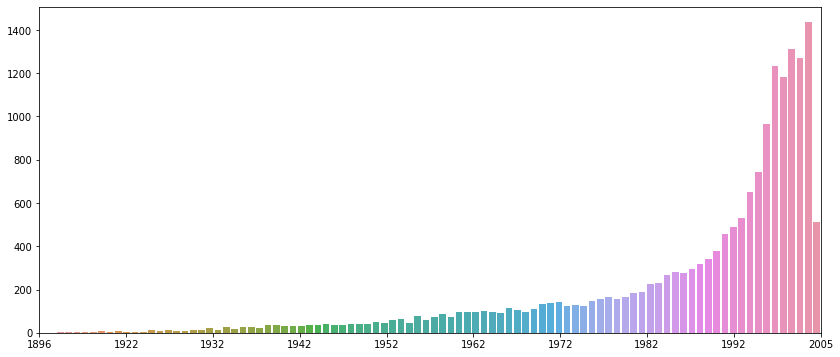

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.
The decline for the rightmost point is probably caused by an incomplete last year.

## Q 4.2: How are The Ratings Distributed?

__Your Turn:__ Build the visualization for rating distributions similar to the previous plot.


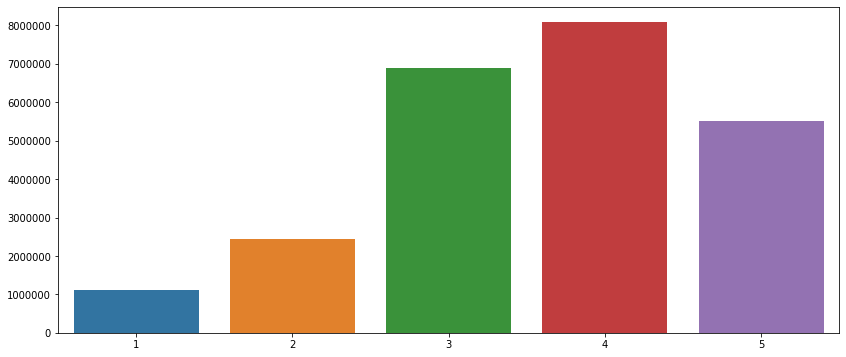

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y);

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

## 4.3: Visualize the Distribution of Number of Movie Ratings 

This is to understand how many movies (y-axis) are receiving specific number of movie ratings (x-axis)

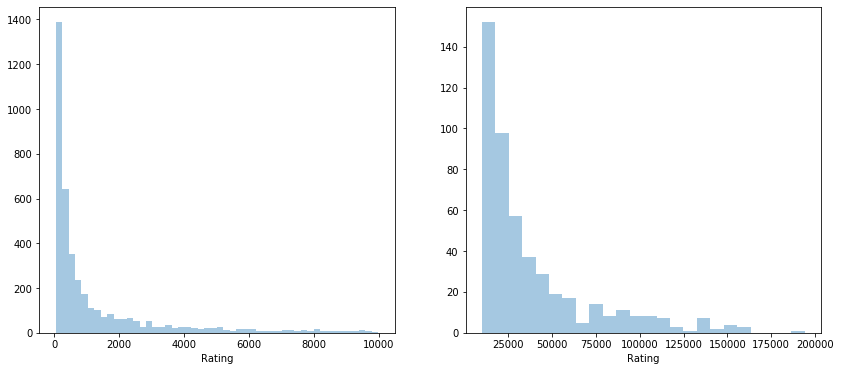

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1]);

## Q 4.4: Visualize the Distribution of Number of User Ratings 

This is to understand how many users (y-axis) are giving specific number of movie ratings (x-axis)

__Your Turn:__ Try to find out an optimal threshold as in the previous example to split the data to form two understandable subplots!

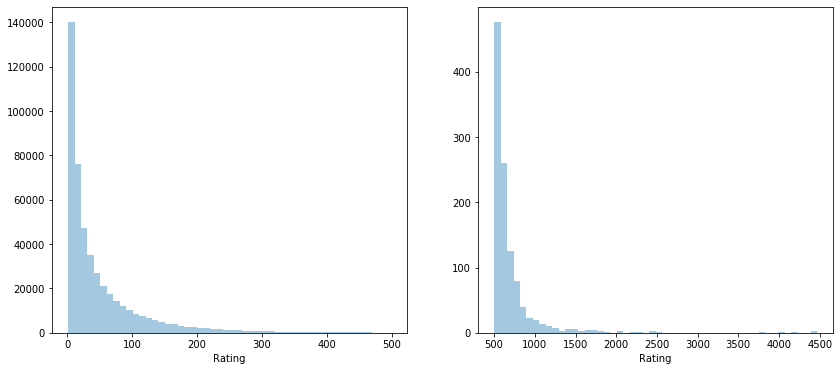

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('User')['Rating'].count()
sns.distplot(data[data  < 500], kde=False, ax=ax[0]);
sns.distplot(data[data  > 500], kde=False, ax=ax[1]);

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# 5. Dimensionality Reduction & Filtering

## Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.


In [ ]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(5930581, 4)


After filtering sparse movies and users about 5.9M rating records are present.

In [ ]:
df_filtered.columns

Index(['User', 'Rating', 'Date', 'Movie'], dtype='object')

# 6. Create Train and Test Datasets

Do note this will be used for the statistical method based models and collaborative filtering.

For content based filtering it is more of a model which recommends movies rather than predicting ratings and for the hybrid model we will need to recreate the train and test datasets later since we need to create a subset of movies-users-ratings which have movie text descriptions.

## Create Train and Test datasets

In [ ]:
# Shuffle DataFrame
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 100000

# Split train- & testset
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
df_train.shape, df_test.shape

((5830581, 3), (100000, 3))

The train set will be used to train all models and the test set ensures we can compare model performance on unseen data using the RMSE metric.

# 7. Transformation

### Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

A large, sparse matrix will be created in this step. Each row will represent a user and its ratings and the columns are the movies.

The movies already rated by users are the non-empty values in the matrix.

Empty values are unrated movies and the main objective is to estimate the empty values to help our users.


__Your turn:__ Create the User-Movie matrix leveraging the __`pivot_table()`__ function from pandas.

Fill in the blanks in the code below by referencing the __`pivot_table()`__ function and invoking it on __`df_train`__. Feel free to check out the documentation.

Remember, rows should be users, columns should be movies and the values in the matrix should be the movie ratings. All these should be available in the __`df_train`__ dataframe.

In [ ]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(values=["Rating"], index="User", columns="Movie")
df_p.head()

Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000192    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000301    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   
1000387    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000410    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  2.0  NaN  NaN  NaN  NaN  NaN  
1000192  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000301  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  
1000387  NaN  1.0  2.0  NaN  NaN  1.0  NaN  NaN  
1000410  NaN  NaN  3.0  NaN  3.0  NaN  NaN  3.0  

[5 rows x 1741 columns]

## 8. Building Recommendation Systems

## 8.1(a): Global Recommendation Systems (Mean Rating)

Computing the mean rating for all movies creates a ranking. The recommendation will be the same for all users and can be used if there is no information on the user.
Variations of this approach can be separate rankings for each country/year/gender/... and to use them individually to recommend movies/items to the user.

It has to be noted that this approach is biased and favours movies with fewer ratings, since large numbers of ratings tend to be less extreme in its mean ratings.

### Additional Hint

Predict model performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [ ]:
# Compute mean rating for all movies
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

# Compute rating frequencies for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Freq').to_frame()

# Combine the aggregated dataframes
combined_df = ratings_mean.join(ratings_count).droplevel(0).join(movie_titles)
combined_df.head(5)

,Rating-Mean,Rating-Freq,Year,Name
Movie,,,,
3456,4.657754,1309,2004.0,Lost: Season 1
2102,4.506461,2786,1994.0,The Simpsons: Season 6
3444,4.434798,2822,2004.0,Family Guy: Freakin' Sweet Collection
2452,4.426542,18582,2001.0,Lord of the Rings: The Fellowship of the Ring
2172,4.384219,6210,1991.0,The Simpsons: Season 3


In [ ]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(ratings_mean.droplevel(0))
predictions_df.head(5)

,User,Rating,Rating-Mean
Movie,,,
3,1984315,3.0,3.453861
3,752702,1.0,3.453861
3,2385435,5.0,3.453861
3,1966687,3.0,3.453861
3,2531820,4.0,3.453861


In [ ]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['Rating-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)

The RMSE Value for the Mean Rating Recommender: 1.0039388921644468


In [ ]:
# View top ten rated movies
combined_df[['Name', 'Rating-Mean']].head(10)

,Name,Rating-Mean
Movie,,
3456,Lost: Season 1,4.657754
2102,The Simpsons: Season 6,4.506461
3444,Family Guy: Freakin' Sweet Collection,4.434798
2452,Lord of the Rings: The Fellowship of the Ring,4.426542
2172,The Simpsons: Season 3,4.384219
3962,Finding Nemo (Widescreen),4.368583
1256,The Best of Friends: Vol. 4,4.367437
1476,Six Feet Under: Season 4,4.348180
3046,The Simpsons: Treehouse of Horror,4.347852


## Q 8.1(b): Global Recommendation Systems (Weighted Rating)

To tackle the problem of the unstable mean with few ratings e.g. IDMb uses a weighted rating. Many good ratings outweigh few in this algorithm.

### Hint:

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

*𝑅* = average for the movie (mean) = (Rating)

*𝑣* = number of votes for the movie = (votes)

*𝑚* = minimum votes required 

*𝐶* = the mean vote across the whole report 

__Your Turn:__ Fill in the necessary code snippets below to build and test the model


In [ ]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean().to_numpy()

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [ ]:
# Weighted formula to compute the weighted rating
weighted_score = (v / (v + m)) * R + (m / (v + m)) * C
weighted_score

array([3.46298131, 3.45898144, 3.37710397, ..., 2.90735162, 3.26336014,
       3.62780134])

In [ ]:
# convert weighted_score into a dataframe
weighted_mean = pd.DataFrame(weighted_score,index=df_p.columns.droplevel(0),
                            columns=['weighted rating'])

# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df2 = weighted_mean.join(movie_titles)
combined_df2.head(5)

,weighted rating,Year,Name
Movie,,,
3,3.462981,1997.0,Character
5,3.458981,2004.0,The Rise and Fall of ECW
6,3.377104,1997.0,Sick
8,3.170152,2004.0,What the #$*! Do We Know!?
16,3.197710,1996.0,Screamers


In [ ]:
# Join labels and predictions based on mean movie rating
predictions_df2 = df_test.set_index('Movie').join(weighted_mean)
predictions_df2

,User,Rating,weighted rating
Movie,,,
3,1984315,3.0,3.462981
3,752702,1.0,3.462981
3,2385435,5.0,3.462981
3,1966687,3.0,3.462981
3,2531820,4.0,3.462981
...,...,...,...
4496,762651,3.0,3.627801
4496,2375964,2.0,3.627801
4496,611315,4.0,3.627801


In [ ]:
# Compute RMSE
y_true2 = predictions_df2["Rating"]
y_pred2 = predictions_df2["weighted rating"]

rmse2 = np.sqrt(mean_squared_error(y_true=y_true2, y_pred=y_pred2))
print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse2)

The RMSE Value for the Weighted-Mean Rating Recommender: 1.0100200331413234


In [ ]:
# View top ten rated movies
combined_df2[["Name", "weighted rating"]].sort_values(
        by="weighted rating", ascending=False
).head(10)

,Name,weighted rating
Movie,,
2452,Lord of the Rings: The Fellowship of the Ring,4.377583
3962,Finding Nemo (Widescreen),4.319978
4306,The Sixth Sense,4.288886
2862,The Silence of the Lambs,4.282010
3290,The Godfather,4.264586
2172,The Simpsons: Season 3,4.257119
2102,The Simpsons: Season 6,4.232125
2782,Braveheart,4.218597
3046,The Simpsons: Treehouse of Horror,4.201862


The variable "m" can be seen as regularizing parameter. Changing it determines how much weight is put onto the movies with many ratings.
Even if there is a better ranking the RMSE decreased slightly. There is a trade-off between interpretability and predictive power.

## 8.2: Content Based Recommendation Systems


The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. If there is no historical data for a user or there is reliable metadata for each movie, it can be useful to compare the metadata of the movies to find similar ones.

![](./images/Content-based.png)

### Cosine TFIDF Movie Description Similarity

#### TF-IDF 

This is a text vectorization technique which is used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. 

IDF is the inverse of the document frequency among the whole corpus of documents. 

TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. 

In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

![](./images/TF-IDF-FORMULA.png)


#### Cosine Similarity 
After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors.

Consider the following example

![](./images/vector-space-model.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. 

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. 

The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. 

The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

In this approch we will use the movie description to create a TFIDF-matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text-vectors. This can easily be extended to more or different features if you like.
It is impossible for this model to compute a RMSE score, since the model does not recommend the movies directly.
In this way it is possible to find movies closly related to each other.

This approach of content based filtering can be extendend to increase the model performance by adding some more features like genres, cast, crew etc.

In [ ]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [ ]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity, 
                             index=movie_metadata.index.values, 
                             columns=movie_metadata.index.values)
similarity_df.head(10)

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Bloed, Zweet en Tranen",To Be Fat Like Me,Cadet Kelly,L'Homme à la tête de caoutchouc,Le locataire diabolique,L'Homme orchestre,Maa,Robin Hood
Toy Story,1.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.023356,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Jumanji,0.015385,1.000000,0.046854,0.000000,0.000000,0.047646,0.000000,0.000000,0.098488,0.0,...,0.000000,0.000000,0.0,0.004192,0.0,0.014642,0.000000,0.000000,0.000000,0.0
Grumpier Old Men,0.000000,0.046854,1.000000,0.000000,0.023903,0.000000,0.000000,0.006463,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.015409,0.000000,0.000000,0.007101,0.0
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007417,0.000000,0.008592,0.000000,0.0,...,0.028460,0.000000,0.0,0.000000,0.0,0.000000,0.016324,0.006840,0.000000,0.0
Father of the Bride Part II,0.000000,0.000000,0.023903,0.000000,1.000000,0.000000,0.030866,0.000000,0.033213,0.0,...,0.000000,0.000000,0.0,0.022816,0.0,0.000000,0.000000,0.000000,0.012584,0.0
Heat,0.000000,0.047646,0.000000,0.007417,0.000000,1.000000,0.000000,0.000000,0.046349,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.015837,0.000000,0.000000,0.0
Sabrina,0.000000,0.000000,0.000000,0.000000,0.030866,0.000000,1.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.028344,0.0,0.000000,0.105139,0.000000,0.000000,0.0
Tom and Huck,0.000000,0.000000,0.006463,0.008592,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.164136,0.071019,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006162,0.0
Sudden Death,0.000000,0.098488,0.000000,0.000000,0.033213,0.046349,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.014963,0.0
GoldenEye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.043867,0.000000,0.0,0.000000,0.0,0.076444,0.000000,0.016266,0.000000,0.0


In [ ]:
# movie list 
movie_list = similarity_df.columns.values


# sample movie
movie = 'Batman Begins'

# top recommendation movie count
top_n = 10

# get movie similarity records
movie_sim = similarity_df[similarity_df.index == movie].values[0]

# get movies sorted by similarity
sorted_movie_ids = np.argsort(movie_sim)[::-1]

# get recommended movie names
recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]

print('\n\nTop Recommended Movies for:', movie, 'are:-\n', recommended_movies)



Top Recommended Movies for: Batman Begins are:-
 ['Batman Unmasked: The Psychology of the Dark Knight'
 'Batman: The Dark Knight Returns, Part 1' 'Batman: Bad Blood'
 'Batman: Year One' 'Batman: Under the Red Hood'
 'Batman Beyond: The Movie' 'Batman Forever'
 'Batman: Mask of the Phantasm' 'Batman & Bill' 'Batman']


__Your turn:__ Create a function as defined below, __`content_movie_recommender()`__ which can take in sample movie names and print a list of top N recommended movies

In [ ]:
def content_movie_recommender(input_movie, similarity_database=similarity_df, movie_database_list=movie_list, top_n=10):
    
    print(f'Top {top_n} recommendations for {input_movie}.')
    # Select the row corresponding to <movie>
    mask = similarity_database.index == input_movie
    movie_sim = similarity_database[mask].values[0]
    # Sort by match to <movie>
    sorted_movie_ids = np.argsort(movie_sim)[::-1]
    # top movie names
    top_n_movies = movie_list[sorted_movie_ids[1:top_n+1]]

    for idx, movie in enumerate(top_n_movies):
        print(f'#{idx+1}: {movie}')

    print()

__Your turn:__ Test your function below on the given sample movies

In [ ]:
sample_movies = ['Captain America', 'The Terminator', 'The Exorcist', 
                 'The Hunger Games: Mockingjay - Part 1', 'The Blair Witch Project']
                 
for movie in sample_movies:
    content_movie_recommender(movie)

Top 10 recommendations for Captain America.
#1: Iron Man & Captain America: Heroes United
#2: Captain America: The First Avenger
#3: Team Thor
#4: Education for Death
#5: Captain America: The Winter Soldier
#6: 49th Parallel
#7: Ultimate Avengers
#8: Philadelphia Experiment II
#9: Vice Versa
#10: The Lair of the White Worm

Top 10 recommendations for The Terminator.
#1: Terminator 2: Judgment Day
#2: Terminator Salvation
#3: Terminator 3: Rise of the Machines
#4: Silent House
#5: They Wait
#6: Another World
#7: Teenage Caveman
#8: Appleseed Alpha
#9: Respire
#10: Just Married

Top 10 recommendations for The Exorcist.
#1: Exorcist II: The Heretic
#2: Domestic Disturbance
#3: Damien: Omen II
#4: The Exorcist III
#5: Like Sunday, Like Rain
#6: People Like Us
#7: Quand on a 17 Ans
#8: Don't Knock Twice
#9: Zero Day
#10: Brick Mansions

Top 10 recommendations for The Hunger Games: Mockingjay - Part 1.
#1: The Hunger Games: Catching Fire
#2: The Hunger Games: Mockingjay - Part 2
#3: Last Tra

## 8.3: Collaborative filtering Recommendation Systems

### Collaborative Filtering
Primarily recommends content to you based on inputs or actions from other people(say your friends).
![collaborative filtering](./images/collaborative-filtering.png)



### What is the intuition behind this?

*   **Personal tastes are correlated**


        1.   If Alice and Bob both like X and Alice likes Y then Bob is more likely to like Y
        2.   especially (perhaps) if Bob knows Alice

Types of Collaborative Filtering:


1.   Neighborhood methods
2.   Matrix Factorization (Latent Factor) methods



Assume you dont have users. Rather you have users' characterisics and properties(as shown in image).![Latent Factor method](https://miro.medium.com/max/876/1*AQEx38Wdo5H0WTSjRfAWtA.png)

For example, a person who is brave-hearted is more likely to be interested in dark, horrific movies rather than someone who is soft and compassionate.
* ^This is just an example(not in any literal sense)

So, once you have the properties and characteristics of each user, we call them as lower-dimensional features of the users. Similarly, we can have lower-dimensional features for movies(say its 10% action, 20% romance ...)

With these features, we represent users and movies in a low dimensional space describing their properties. **This is called as the latent space.**

We then recommend a movie based on its proximity to the user in the latent space.

### The problem:

The problem we try to address here is the rating prediction problem. 
Say, we try to guess how much Alice would rate a movie and suggest those movies that we think Alice will rate higher.

### Interesting...But, how do we predict how much Alice would rate a movie?

 The data we have is a rating history: ratings of users for items in the interval [1,5]. We can put all this data into a sparse matrix called R:
 
 $R = 
 \begin{pmatrix}
  3 & ? &? \\ 
  ? & 4 & 5 \\
  ? & ? & 2 \\
  2 & 3 & ?
 \end{pmatrix}
 \begin{matrix}
  Alice \\ 
  Bob \\
  Chand \\
  Deb
 \end{matrix}
 $

 Each row of the matrix corresponds to a given user, and each column corresponds to a given item. For instance here, Alice has rated the first movie with a rating of 3, and Chand has rated the third item with a rating of 2.

 The matrix R is sparse (more than 99% of the entries are missing), and our goal is to predict the missing entries, i.e. predict the ?.


### Anatomy of the Rating matrix: LATENT SPACE
Before predicting ratings, lets step back and understand the latent space more! \\
 In this Rating matrix, Rows represent Users and Columns represent Movies.
 $R = 
  \begin{pmatrix}
  --Alice-- \\ 
  --Bob-- \\
  --Chand-- \\
  --Deb--
 \end{pmatrix}
 $

 In latent space(low dimensional features - fanatics), for instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

```
Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ⋯ \\
Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ⋯ \\
: \\
Zoe = ⋯
```

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings.

$
R ^ T = 
  \begin{pmatrix}
  --Avengers-- \\ 
  --Matrix-- \\
  --Inception-- \\
  --Sherlock--
 \end{pmatrix}
$

In the latent space, we will associate a semantic meaning behind each of the  movies, and these semantic meanings(say movie characteristics) can build back all of our original movies.

### EXAMPLE
In the below example, we convert users and movies to vectors(embeddings) and do dot-product to predict R

user vector - U \\
movies vector - V \\
$
R = U.V
$

### Additional hints:

use dataframe map - [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)

Create tensor - [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input#view-aliases)

Create Embedding - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Dot product - [Dot](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Measure Performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

### Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL collaborative  filtering system

#### Create Configuration Parameters

In [ ]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping = {id:i for i, id in enumerate(df_filtered['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered['Movie'].unique())}

In [ ]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
train_user_data = df_train['User'].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

In [ ]:
# do the same for test data
test_user_data = df_test['User'].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)

In [ ]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

#### Construct Deep Learning Model Architecture

In [ ]:
# use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name='user')
movie_id_input = Input(shape=(1,), name='movie')

In [ ]:
# Create embedding layer for users 
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)

# create embedding layer for movies just like users
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=movies,
                           input_length=1, 
                           name='movie_embedding')(user_id_input)

In [ ]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [ ]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [ ]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       2082800     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       174100      user[0][0]                       
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100)          0           user_embedding[0][0]             
____________________________________________________________________________________________

#### Train and Test the Model

In [ ]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train['Rating']

batch_size = 1024
epochs = 5
validation_split = 0.1

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs,
          validation_split=validation_split,
          shuffle=True,
          verbose=1)

Train on 5247522 samples, validate on 583059 samples
Epoch 1/5


   1024/5247522 [..............................] - ETA: 3:34:47 - loss: 13.4386

  14336/5247522 [..............................] - ETA: 15:37 - loss: 13.1960  

  26624/5247522 [..............................] - ETA: 8:33 - loss: 13.1849 

  39936/5247522 [..............................] - ETA: 5:48 - loss: 13.1644

  52224/5247522 [..............................] - ETA: 4:30 - loss: 13.1634

  65536/5247522 [..............................] - ETA: 3:39 - loss: 13.1773

  78848/5247522 [..............................] - ETA: 3:05 - loss: 13.1821

  91136/5247522 [..............................] - ETA: 2:42 - loss: 13.1763

 103424/5247522 [..............................] - ETA: 2:25 - loss: 13.1607

 116736/5247522 [..............................] - ETA: 2:10 - loss: 13.1505

 130048/5247522 [..............................] - ETA: 1:59 - loss: 13.1574

 144384/5247522 [..............................] - ETA: 1:48 - loss: 13.1417

 157696/5247522 [..............................] - ETA: 1:41 - loss: 13.1348

 171008/5247522 [..............................] - ETA: 1:34 - loss: 13.1240

 184320/5247522 [>.............................] - ETA: 1:29 - loss: 13.1143

 196608/5247522 [>.............................] - ETA: 1:24 - loss: 13.1052

 209920/5247522 [>.............................] - ETA: 1:20 - loss: 13.0942

 223232/5247522 [>.............................] - ETA: 1:16 - loss: 13.0887

 236544/5247522 [>.............................] - ETA: 1:13 - loss: 13.0774

 249856/5247522 [>.............................] - ETA: 1:09 - loss: 13.0726

 263168/5247522 [>.............................] - ETA: 1:07 - loss: 13.0555

 276480/5247522 [>.............................] - ETA: 1:04 - loss: 13.0462

 288768/5247522 [>.............................] - ETA: 1:02 - loss: 13.0366

 302080/5247522 [>.............................] - ETA: 1:00 - loss: 13.0231

 315392/5247522 [>.............................] - ETA: 58s - loss: 13.0077 

 328704/5247522 [>.............................] - ETA: 56s - loss: 12.9982

 342016/5247522 [>.............................] - ETA: 55s - loss: 12.9801

 355328/5247522 [=>............................] - ETA: 53s - loss: 12.9657

 368640/5247522 [=>............................] - ETA: 52s - loss: 12.9544

 381952/5247522 [=>............................] - ETA: 51s - loss: 12.9413

 394240/5247522 [=>............................] - ETA: 50s - loss: 12.9291

 406528/5247522 [=>............................] - ETA: 49s - loss: 12.9166

 419840/5247522 [=>............................] - ETA: 47s - loss: 12.9011

 432128/5247522 [=>............................] - ETA: 47s - loss: 12.8922

 445440/5247522 [=>............................] - ETA: 46s - loss: 12.8810

 458752/5247522 [=>............................] - ETA: 45s - loss: 12.8672

 472064/5247522 [=>............................] - ETA: 44s - loss: 12.8543

 485376/5247522 [=>............................] - ETA: 43s - loss: 12.8405

 498688/5247522 [=>............................] - ETA: 42s - loss: 12.8263

 512000/5247522 [=>............................] - ETA: 41s - loss: 12.8132

 524288/5247522 [=>............................] - ETA: 41s - loss: 12.8032

 537600/5247522 [==>...........................] - ETA: 40s - loss: 12.7901

 551936/5247522 [==>...........................] - ETA: 39s - loss: 12.7760

 564224/5247522 [==>...........................] - ETA: 39s - loss: 12.7626

 576512/5247522 [==>...........................] - ETA: 38s - loss: 12.7533

 589824/5247522 [==>...........................] - ETA: 38s - loss: 12.7426

 602112/5247522 [==>...........................] - ETA: 37s - loss: 12.7327

 614400/5247522 [==>...........................] - ETA: 37s - loss: 12.7228

 627712/5247522 [==>...........................] - ETA: 36s - loss: 12.7092

 641024/5247522 [==>...........................] - ETA: 36s - loss: 12.6980

 654336/5247522 [==>...........................] - ETA: 35s - loss: 12.6876

 667648/5247522 [==>...........................] - ETA: 35s - loss: 12.6775

 679936/5247522 [==>...........................] - ETA: 34s - loss: 12.6685

 692224/5247522 [==>...........................] - ETA: 34s - loss: 12.6594

 705536/5247522 [===>..........................] - ETA: 34s - loss: 12.6497

 718848/5247522 [===>..........................] - ETA: 33s - loss: 12.6392

 732160/5247522 [===>..........................] - ETA: 33s - loss: 12.6301

 744448/5247522 [===>..........................] - ETA: 33s - loss: 12.6217

 757760/5247522 [===>..........................] - ETA: 32s - loss: 12.6139

 769024/5247522 [===>..........................] - ETA: 32s - loss: 12.6074

 782336/5247522 [===>..........................] - ETA: 32s - loss: 12.5969

 796672/5247522 [===>..........................] - ETA: 31s - loss: 12.5881

 809984/5247522 [===>..........................] - ETA: 31s - loss: 12.5799

 824320/5247522 [===>..........................] - ETA: 30s - loss: 12.5691

 836608/5247522 [===>..........................] - ETA: 30s - loss: 12.5606

 848896/5247522 [===>..........................] - ETA: 30s - loss: 12.5542

 862208/5247522 [===>..........................] - ETA: 30s - loss: 12.5465

 874496/5247522 [===>..........................] - ETA: 29s - loss: 12.5399

 886784/5247522 [====>.........................] - ETA: 29s - loss: 12.5344

 899072/5247522 [====>.........................] - ETA: 29s - loss: 12.5272

 912384/5247522 [====>.........................] - ETA: 29s - loss: 12.5203

 922624/5247522 [====>.........................] - ETA: 29s - loss: 12.5157

 934912/5247522 [====>.........................] - ETA: 28s - loss: 12.5103

 948224/5247522 [====>.........................] - ETA: 28s - loss: 12.5054

 961536/5247522 [====>.........................] - ETA: 28s - loss: 12.5000

 974848/5247522 [====>.........................] - ETA: 28s - loss: 12.4936

 988160/5247522 [====>.........................] - ETA: 27s - loss: 12.4871

1001472/5247522 [====>.........................] - ETA: 27s - loss: 12.4805

1014784/5247522 [====>.........................] - ETA: 27s - loss: 12.4742

1027072/5247522 [====>.........................] - ETA: 27s - loss: 12.4699

1040384/5247522 [====>.........................] - ETA: 26s - loss: 12.4650

1053696/5247522 [=====>........................] - ETA: 26s - loss: 12.4595

1067008/5247522 [=====>........................] - ETA: 26s - loss: 12.4540

1079296/5247522 [=====>........................] - ETA: 26s - loss: 12.4503

1092608/5247522 [=====>........................] - ETA: 26s - loss: 12.4447

1105920/5247522 [=====>........................] - ETA: 25s - loss: 12.4397

1118208/5247522 [=====>........................] - ETA: 25s - loss: 12.4353

1131520/5247522 [=====>........................] - ETA: 25s - loss: 12.4314

1143808/5247522 [=====>........................] - ETA: 25s - loss: 12.4273

1157120/5247522 [=====>........................] - ETA: 25s - loss: 12.4232

1170432/5247522 [=====>........................] - ETA: 25s - loss: 12.4190

1180672/5247522 [=====>........................] - ETA: 24s - loss: 12.4165

1192960/5247522 [=====>........................] - ETA: 24s - loss: 12.4146

1206272/5247522 [=====>........................] - ETA: 24s - loss: 12.4110

1218560/5247522 [=====>........................] - ETA: 24s - loss: 12.4071

1230848/5247522 [======>.......................] - ETA: 24s - loss: 12.4037

1242112/5247522 [======>.......................] - ETA: 24s - loss: 12.4015

1255424/5247522 [======>.......................] - ETA: 24s - loss: 12.3977

1268736/5247522 [======>.......................] - ETA: 23s - loss: 12.3932

1282048/5247522 [======>.......................] - ETA: 23s - loss: 12.3893

1295360/5247522 [======>.......................] - ETA: 23s - loss: 12.3853

1308672/5247522 [======>.......................] - ETA: 23s - loss: 12.3818

1321984/5247522 [======>.......................] - ETA: 23s - loss: 12.3773

1336320/5247522 [======>.......................] - ETA: 23s - loss: 12.3737

1349632/5247522 [======>.......................] - ETA: 22s - loss: 12.3691

1362944/5247522 [======>.......................] - ETA: 22s - loss: 12.3659

1375232/5247522 [======>.......................] - ETA: 22s - loss: 12.3634

1387520/5247522 [======>.......................] - ETA: 22s - loss: 12.3603

1400832/5247522 [=======>......................] - ETA: 22s - loss: 12.3568

1413120/5247522 [=======>......................] - ETA: 22s - loss: 12.3540

1425408/5247522 [=======>......................] - ETA: 22s - loss: 12.3516

1437696/5247522 [=======>......................] - ETA: 21s - loss: 12.3492

1449984/5247522 [=======>......................] - ETA: 21s - loss: 12.3478

1462272/5247522 [=======>......................] - ETA: 21s - loss: 12.3451

1475584/5247522 [=======>......................] - ETA: 21s - loss: 12.3432

1488896/5247522 [=======>......................] - ETA: 21s - loss: 12.3413

1501184/5247522 [=======>......................] - ETA: 21s - loss: 12.3384

1514496/5247522 [=======>......................] - ETA: 21s - loss: 12.3357

1527808/5247522 [=======>......................] - ETA: 21s - loss: 12.3331

1540096/5247522 [=======>......................] - ETA: 20s - loss: 12.3307

1553408/5247522 [=======>......................] - ETA: 20s - loss: 12.3290

1566720/5247522 [=======>......................] - ETA: 20s - loss: 12.3262

1580032/5247522 [========>.....................] - ETA: 20s - loss: 12.3245

1592320/5247522 [========>.....................] - ETA: 20s - loss: 12.3218

1605632/5247522 [========>.....................] - ETA: 20s - loss: 12.3193

1618944/5247522 [========>.....................] - ETA: 20s - loss: 12.3181

1632256/5247522 [========>.....................] - ETA: 20s - loss: 12.3163

1644544/5247522 [========>.....................] - ETA: 19s - loss: 12.3141

1655808/5247522 [========>.....................] - ETA: 19s - loss: 12.3122

1667072/5247522 [========>.....................] - ETA: 19s - loss: 12.3099

1678336/5247522 [========>.....................] - ETA: 19s - loss: 12.3085

1690624/5247522 [========>.....................] - ETA: 19s - loss: 12.3075

1703936/5247522 [========>.....................] - ETA: 19s - loss: 12.3058

1717248/5247522 [========>.....................] - ETA: 19s - loss: 12.3034

1730560/5247522 [========>.....................] - ETA: 19s - loss: 12.3007

1743872/5247522 [========>.....................] - ETA: 19s - loss: 12.2994

1756160/5247522 [=========>....................] - ETA: 19s - loss: 12.2987

1769472/5247522 [=========>....................] - ETA: 18s - loss: 12.2959

1781760/5247522 [=========>....................] - ETA: 18s - loss: 12.2944

1795072/5247522 [=========>....................] - ETA: 18s - loss: 12.2928

1808384/5247522 [=========>....................] - ETA: 18s - loss: 12.2908

1821696/5247522 [=========>....................] - ETA: 18s - loss: 12.2884

1833984/5247522 [=========>....................] - ETA: 18s - loss: 12.2862

1846272/5247522 [=========>....................] - ETA: 18s - loss: 12.2844

1858560/5247522 [=========>....................] - ETA: 18s - loss: 12.2830

1870848/5247522 [=========>....................] - ETA: 18s - loss: 12.2816

1883136/5247522 [=========>....................] - ETA: 18s - loss: 12.2805

1895424/5247522 [=========>....................] - ETA: 17s - loss: 12.2789

1908736/5247522 [=========>....................] - ETA: 17s - loss: 12.2766

1922048/5247522 [=========>....................] - ETA: 17s - loss: 12.2748

1934336/5247522 [==========>...................] - ETA: 17s - loss: 12.2735

1947648/5247522 [==========>...................] - ETA: 17s - loss: 12.2723

1959936/5247522 [==========>...................] - ETA: 17s - loss: 12.2711

1973248/5247522 [==========>...................] - ETA: 17s - loss: 12.2693

1986560/5247522 [==========>...................] - ETA: 17s - loss: 12.2684

1999872/5247522 [==========>...................] - ETA: 17s - loss: 12.2669

2013184/5247522 [==========>...................] - ETA: 17s - loss: 12.2655

2026496/5247522 [==========>...................] - ETA: 16s - loss: 12.2640

2039808/5247522 [==========>...................] - ETA: 16s - loss: 12.2634

2053120/5247522 [==========>...................] - ETA: 16s - loss: 12.2623

2067456/5247522 [==========>...................] - ETA: 16s - loss: 12.2609

2080768/5247522 [==========>...................] - ETA: 16s - loss: 12.2598

2094080/5247522 [==========>...................] - ETA: 16s - loss: 12.2579

2107392/5247522 [===========>..................] - ETA: 16s - loss: 12.2565

2121728/5247522 [===========>..................] - ETA: 16s - loss: 12.2543

2135040/5247522 [===========>..................] - ETA: 16s - loss: 12.2530

2148352/5247522 [===========>..................] - ETA: 16s - loss: 12.2520

2160640/5247522 [===========>..................] - ETA: 16s - loss: 12.2513

2172928/5247522 [===========>..................] - ETA: 15s - loss: 12.2499

2184192/5247522 [===========>..................] - ETA: 15s - loss: 12.2487

2196480/5247522 [===========>..................] - ETA: 15s - loss: 12.2478

2209792/5247522 [===========>..................] - ETA: 15s - loss: 12.2466

2223104/5247522 [===========>..................] - ETA: 15s - loss: 12.2452

2235392/5247522 [===========>..................] - ETA: 15s - loss: 12.2444

2248704/5247522 [===========>..................] - ETA: 15s - loss: 12.2430

2262016/5247522 [===========>..................] - ETA: 15s - loss: 12.2424

2275328/5247522 [============>.................] - ETA: 15s - loss: 12.2417

2288640/5247522 [============>.................] - ETA: 15s - loss: 12.2406

2301952/5247522 [============>.................] - ETA: 15s - loss: 12.2394

2315264/5247522 [============>.................] - ETA: 14s - loss: 12.2383

2328576/5247522 [============>.................] - ETA: 14s - loss: 12.2377

2340864/5247522 [============>.................] - ETA: 14s - loss: 12.2368

2354176/5247522 [============>.................] - ETA: 14s - loss: 12.2356

2367488/5247522 [============>.................] - ETA: 14s - loss: 12.2344

2380800/5247522 [============>.................] - ETA: 14s - loss: 12.2339

2394112/5247522 [============>.................] - ETA: 14s - loss: 12.2323

2407424/5247522 [============>.................] - ETA: 14s - loss: 12.2315

2420736/5247522 [============>.................] - ETA: 14s - loss: 12.2313

2434048/5247522 [============>.................] - ETA: 14s - loss: 12.2296

2447360/5247522 [============>.................] - ETA: 14s - loss: 12.2279

2460672/5247522 [=============>................] - ETA: 14s - loss: 12.2267

2473984/5247522 [=============>................] - ETA: 13s - loss: 12.2262

2486272/5247522 [=============>................] - ETA: 13s - loss: 12.2255

2498560/5247522 [=============>................] - ETA: 13s - loss: 12.2246

2511872/5247522 [=============>................] - ETA: 13s - loss: 12.2237

2525184/5247522 [=============>................] - ETA: 13s - loss: 12.2235

2538496/5247522 [=============>................] - ETA: 13s - loss: 12.2224

2550784/5247522 [=============>................] - ETA: 13s - loss: 12.2210

2564096/5247522 [=============>................] - ETA: 13s - loss: 12.2200

2577408/5247522 [=============>................] - ETA: 13s - loss: 12.2192

2590720/5247522 [=============>................] - ETA: 13s - loss: 12.2186

2604032/5247522 [=============>................] - ETA: 13s - loss: 12.2176

2617344/5247522 [=============>................] - ETA: 13s - loss: 12.2166

2630656/5247522 [==============>...............] - ETA: 13s - loss: 12.2155

2643968/5247522 [==============>...............] - ETA: 12s - loss: 12.2150

2657280/5247522 [==============>...............] - ETA: 12s - loss: 12.2144

2670592/5247522 [==============>...............] - ETA: 12s - loss: 12.2140

2682880/5247522 [==============>...............] - ETA: 12s - loss: 12.2132

2693120/5247522 [==============>...............] - ETA: 12s - loss: 12.2126

2705408/5247522 [==============>...............] - ETA: 12s - loss: 12.2121

2717696/5247522 [==============>...............] - ETA: 12s - loss: 12.2114

2728960/5247522 [==============>...............] - ETA: 12s - loss: 12.2108

2742272/5247522 [==============>...............] - ETA: 12s - loss: 12.2094

2755584/5247522 [==============>...............] - ETA: 12s - loss: 12.2088

2768896/5247522 [==============>...............] - ETA: 12s - loss: 12.2084

2782208/5247522 [==============>...............] - ETA: 12s - loss: 12.2078

2795520/5247522 [==============>...............] - ETA: 12s - loss: 12.2075

2808832/5247522 [===============>..............] - ETA: 11s - loss: 12.2074

2822144/5247522 [===============>..............] - ETA: 11s - loss: 12.2069

2834432/5247522 [===============>..............] - ETA: 11s - loss: 12.2065

2847744/5247522 [===============>..............] - ETA: 11s - loss: 12.2057

2861056/5247522 [===============>..............] - ETA: 11s - loss: 12.2046

2874368/5247522 [===============>..............] - ETA: 11s - loss: 12.2034

2887680/5247522 [===============>..............] - ETA: 11s - loss: 12.2023

2900992/5247522 [===============>..............] - ETA: 11s - loss: 12.2013

2914304/5247522 [===============>..............] - ETA: 11s - loss: 12.2007

2926592/5247522 [===============>..............] - ETA: 11s - loss: 12.1998

2939904/5247522 [===============>..............] - ETA: 11s - loss: 12.1996

2951168/5247522 [===============>..............] - ETA: 11s - loss: 12.1990

2964480/5247522 [===============>..............] - ETA: 11s - loss: 12.1983

2977792/5247522 [================>.............] - ETA: 11s - loss: 12.1975

2990080/5247522 [================>.............] - ETA: 10s - loss: 12.1966

3003392/5247522 [================>.............] - ETA: 10s - loss: 12.1959

3016704/5247522 [================>.............] - ETA: 10s - loss: 12.1953

3030016/5247522 [================>.............] - ETA: 10s - loss: 12.1950

3042304/5247522 [================>.............] - ETA: 10s - loss: 12.1940

3054592/5247522 [================>.............] - ETA: 10s - loss: 12.1942

3067904/5247522 [================>.............] - ETA: 10s - loss: 12.1940

3081216/5247522 [================>.............] - ETA: 10s - loss: 12.1937

3094528/5247522 [================>.............] - ETA: 10s - loss: 12.1932

3106816/5247522 [================>.............] - ETA: 10s - loss: 12.1927

3120128/5247522 [================>.............] - ETA: 10s - loss: 12.1925

3133440/5247522 [================>.............] - ETA: 10s - loss: 12.1921

3146752/5247522 [================>.............] - ETA: 10s - loss: 12.1917

3160064/5247522 [=================>............] - ETA: 10s - loss: 12.1912

3172352/5247522 [=================>............] - ETA: 9s - loss: 12.1907 

3185664/5247522 [=================>............] - ETA: 9s - loss: 12.1904

3198976/5247522 [=================>............] - ETA: 9s - loss: 12.1896

3211264/5247522 [=================>............] - ETA: 9s - loss: 12.1888

3224576/5247522 [=================>............] - ETA: 9s - loss: 12.1877

3237888/5247522 [=================>............] - ETA: 9s - loss: 12.1870

3251200/5247522 [=================>............] - ETA: 9s - loss: 12.1868

3263488/5247522 [=================>............] - ETA: 9s - loss: 12.1863

3276800/5247522 [=================>............] - ETA: 9s - loss: 12.1855

3290112/5247522 [=================>............] - ETA: 9s - loss: 12.1852

3303424/5247522 [=================>............] - ETA: 9s - loss: 12.1841

3316736/5247522 [=================>............] - ETA: 9s - loss: 12.1840

3330048/5247522 [==================>...........] - ETA: 9s - loss: 12.1838

3343360/5247522 [==================>...........] - ETA: 9s - loss: 12.1831

3355648/5247522 [==================>...........] - ETA: 9s - loss: 12.1826

3368960/5247522 [==================>...........] - ETA: 8s - loss: 12.1822

3382272/5247522 [==================>...........] - ETA: 8s - loss: 12.1815

3394560/5247522 [==================>...........] - ETA: 8s - loss: 12.1813

3407872/5247522 [==================>...........] - ETA: 8s - loss: 12.1805

3420160/5247522 [==================>...........] - ETA: 8s - loss: 12.1800

3433472/5247522 [==================>...........] - ETA: 8s - loss: 12.1795

3446784/5247522 [==================>...........] - ETA: 8s - loss: 12.1793

3459072/5247522 [==================>...........] - ETA: 8s - loss: 12.1788

3472384/5247522 [==================>...........] - ETA: 8s - loss: 12.1784

3485696/5247522 [==================>...........] - ETA: 8s - loss: 12.1780

3499008/5247522 [===================>..........] - ETA: 8s - loss: 12.1777

3512320/5247522 [===================>..........] - ETA: 8s - loss: 12.1779

3525632/5247522 [===================>..........] - ETA: 8s - loss: 12.1773

3538944/5247522 [===================>..........] - ETA: 8s - loss: 12.1764

3552256/5247522 [===================>..........] - ETA: 7s - loss: 12.1762

3565568/5247522 [===================>..........] - ETA: 7s - loss: 12.1757

3578880/5247522 [===================>..........] - ETA: 7s - loss: 12.1751

3592192/5247522 [===================>..........] - ETA: 7s - loss: 12.1749

3605504/5247522 [===================>..........] - ETA: 7s - loss: 12.1747

3617792/5247522 [===================>..........] - ETA: 7s - loss: 12.1744

3630080/5247522 [===================>..........] - ETA: 7s - loss: 12.1742

3642368/5247522 [===================>..........] - ETA: 7s - loss: 12.1736

3655680/5247522 [===================>..........] - ETA: 7s - loss: 12.1734

3668992/5247522 [===================>..........] - ETA: 7s - loss: 12.1732

3680256/5247522 [====================>.........] - ETA: 7s - loss: 12.1728

3693568/5247522 [====================>.........] - ETA: 7s - loss: 12.1723

3706880/5247522 [====================>.........] - ETA: 7s - loss: 12.1717

3716096/5247522 [====================>.........] - ETA: 7s - loss: 12.1714

3729408/5247522 [====================>.........] - ETA: 7s - loss: 12.1712

3742720/5247522 [====================>.........] - ETA: 7s - loss: 12.1707

3755008/5247522 [====================>.........] - ETA: 6s - loss: 12.1701

3767296/5247522 [====================>.........] - ETA: 6s - loss: 12.1700

3780608/5247522 [====================>.........] - ETA: 6s - loss: 12.1695

3792896/5247522 [====================>.........] - ETA: 6s - loss: 12.1691

3806208/5247522 [====================>.........] - ETA: 6s - loss: 12.1686

3818496/5247522 [====================>.........] - ETA: 6s - loss: 12.1683

3831808/5247522 [====================>.........] - ETA: 6s - loss: 12.1680

3845120/5247522 [====================>.........] - ETA: 6s - loss: 12.1676

3858432/5247522 [=====================>........] - ETA: 6s - loss: 12.1674

3872768/5247522 [=====================>........] - ETA: 6s - loss: 12.1671

3885056/5247522 [=====================>........] - ETA: 6s - loss: 12.1669

3898368/5247522 [=====================>........] - ETA: 6s - loss: 12.1663

3911680/5247522 [=====================>........] - ETA: 6s - loss: 12.1658

3923968/5247522 [=====================>........] - ETA: 6s - loss: 12.1656

3937280/5247522 [=====================>........] - ETA: 6s - loss: 12.1651

3950592/5247522 [=====================>........] - ETA: 6s - loss: 12.1645

3962880/5247522 [=====================>........] - ETA: 5s - loss: 12.1643

3975168/5247522 [=====================>........] - ETA: 5s - loss: 12.1639

3988480/5247522 [=====================>........] - ETA: 5s - loss: 12.1637

4000768/5247522 [=====================>........] - ETA: 5s - loss: 12.1635

4013056/5247522 [=====================>........] - ETA: 5s - loss: 12.1632

4025344/5247522 [======================>.......] - ETA: 5s - loss: 12.1628

4038656/5247522 [======================>.......] - ETA: 5s - loss: 12.1631

4051968/5247522 [======================>.......] - ETA: 5s - loss: 12.1630

4064256/5247522 [======================>.......] - ETA: 5s - loss: 12.1629

4077568/5247522 [======================>.......] - ETA: 5s - loss: 12.1624

4089856/5247522 [======================>.......] - ETA: 5s - loss: 12.1623

4103168/5247522 [======================>.......] - ETA: 5s - loss: 12.1621

4116480/5247522 [======================>.......] - ETA: 5s - loss: 12.1615

4129792/5247522 [======================>.......] - ETA: 5s - loss: 12.1612

4144128/5247522 [======================>.......] - ETA: 5s - loss: 12.1609

4157440/5247522 [======================>.......] - ETA: 5s - loss: 12.1605

4170752/5247522 [======================>.......] - ETA: 4s - loss: 12.1602

4184064/5247522 [======================>.......] - ETA: 4s - loss: 12.1598

4197376/5247522 [======================>.......] - ETA: 4s - loss: 12.1593

4210688/5247522 [=======================>......] - ETA: 4s - loss: 12.1589

4224000/5247522 [=======================>......] - ETA: 4s - loss: 12.1587

4237312/5247522 [=======================>......] - ETA: 4s - loss: 12.1585

4250624/5247522 [=======================>......] - ETA: 4s - loss: 12.1579

4263936/5247522 [=======================>......] - ETA: 4s - loss: 12.1573

4277248/5247522 [=======================>......] - ETA: 4s - loss: 12.1568

4290560/5247522 [=======================>......] - ETA: 4s - loss: 12.1567

4303872/5247522 [=======================>......] - ETA: 4s - loss: 12.1564

4317184/5247522 [=======================>......] - ETA: 4s - loss: 12.1560

4329472/5247522 [=======================>......] - ETA: 4s - loss: 12.1555

4341760/5247522 [=======================>......] - ETA: 4s - loss: 12.1549

4354048/5247522 [=======================>......] - ETA: 4s - loss: 12.1549

4366336/5247522 [=======================>......] - ETA: 4s - loss: 12.1544

4378624/5247522 [========================>.....] - ETA: 3s - loss: 12.1540

4389888/5247522 [========================>.....] - ETA: 3s - loss: 12.1536

4402176/5247522 [========================>.....] - ETA: 3s - loss: 12.1532

4415488/5247522 [========================>.....] - ETA: 3s - loss: 12.1531

4429824/5247522 [========================>.....] - ETA: 3s - loss: 12.1528

4442112/5247522 [========================>.....] - ETA: 3s - loss: 12.1529

4455424/5247522 [========================>.....] - ETA: 3s - loss: 12.1525

4468736/5247522 [========================>.....] - ETA: 3s - loss: 12.1523

4481024/5247522 [========================>.....] - ETA: 3s - loss: 12.1522

4494336/5247522 [========================>.....] - ETA: 3s - loss: 12.1520

4506624/5247522 [========================>.....] - ETA: 3s - loss: 12.1517

4518912/5247522 [========================>.....] - ETA: 3s - loss: 12.1515

4531200/5247522 [========================>.....] - ETA: 3s - loss: 12.1515

4544512/5247522 [========================>.....] - ETA: 3s - loss: 12.1512

4557824/5247522 [=========================>....] - ETA: 3s - loss: 12.1509

4571136/5247522 [=========================>....] - ETA: 3s - loss: 12.1507

4584448/5247522 [=========================>....] - ETA: 3s - loss: 12.1507

4597760/5247522 [=========================>....] - ETA: 2s - loss: 12.1504

4610048/5247522 [=========================>....] - ETA: 2s - loss: 12.1502

4624384/5247522 [=========================>....] - ETA: 2s - loss: 12.1497

4637696/5247522 [=========================>....] - ETA: 2s - loss: 12.1499

4652032/5247522 [=========================>....] - ETA: 2s - loss: 12.1494

4665344/5247522 [=========================>....] - ETA: 2s - loss: 12.1489

4676608/5247522 [=========================>....] - ETA: 2s - loss: 12.1487

4689920/5247522 [=========================>....] - ETA: 2s - loss: 12.1486

4702208/5247522 [=========================>....] - ETA: 2s - loss: 12.1481

4714496/5247522 [=========================>....] - ETA: 2s - loss: 12.1478

4726784/5247522 [==========================>...] - ETA: 2s - loss: 12.1477

4740096/5247522 [==========================>...] - ETA: 2s - loss: 12.1475

4753408/5247522 [==========================>...] - ETA: 2s - loss: 12.1472

4766720/5247522 [==========================>...] - ETA: 2s - loss: 12.1471

4780032/5247522 [==========================>...] - ETA: 2s - loss: 12.1466

4794368/5247522 [==========================>...] - ETA: 2s - loss: 12.1465

4807680/5247522 [==========================>...] - ETA: 1s - loss: 12.1464

4819968/5247522 [==========================>...] - ETA: 1s - loss: 12.1460

4833280/5247522 [==========================>...] - ETA: 1s - loss: 12.1456

4846592/5247522 [==========================>...] - ETA: 1s - loss: 12.1451

4859904/5247522 [==========================>...] - ETA: 1s - loss: 12.1451

4873216/5247522 [==========================>...] - ETA: 1s - loss: 12.1449

4886528/5247522 [==========================>...] - ETA: 1s - loss: 12.1445

4899840/5247522 [===========================>..] - ETA: 1s - loss: 12.1444

4912128/5247522 [===========================>..] - ETA: 1s - loss: 12.1440

4924416/5247522 [===========================>..] - ETA: 1s - loss: 12.1439

4937728/5247522 [===========================>..] - ETA: 1s - loss: 12.1438

4950016/5247522 [===========================>..] - ETA: 1s - loss: 12.1436

4963328/5247522 [===========================>..] - ETA: 1s - loss: 12.1432

4975616/5247522 [===========================>..] - ETA: 1s - loss: 12.1433

4986880/5247522 [===========================>..] - ETA: 1s - loss: 12.1432

4998144/5247522 [===========================>..] - ETA: 1s - loss: 12.1429

5010432/5247522 [===========================>..] - ETA: 1s - loss: 12.1427

5023744/5247522 [===========================>..] - ETA: 1s - loss: 12.1423

5037056/5247522 [===========================>..] - ETA: 0s - loss: 12.1420

5050368/5247522 [===========================>..] - ETA: 0s - loss: 12.1417

5062656/5247522 [===========================>..] - ETA: 0s - loss: 12.1418

5075968/5247522 [============================>.] - ETA: 0s - loss: 12.1417

5089280/5247522 [============================>.] - ETA: 0s - loss: 12.1417

5101568/5247522 [============================>.] - ETA: 0s - loss: 12.1415

5115904/5247522 [============================>.] - ETA: 0s - loss: 12.1415

5129216/5247522 [============================>.] - ETA: 0s - loss: 12.1410

5142528/5247522 [============================>.] - ETA: 0s - loss: 12.1407

5155840/5247522 [============================>.] - ETA: 0s - loss: 12.1408

5168128/5247522 [============================>.] - ETA: 0s - loss: 12.1406

5181440/5247522 [============================>.] - ETA: 0s - loss: 12.1405

5193728/5247522 [============================>.] - ETA: 0s - loss: 12.1404

5207040/5247522 [============================>.] - ETA: 0s - loss: 12.1402

5220352/5247522 [============================>.] - ETA: 0s - loss: 12.1400

5233664/5247522 [============================>.] - ETA: 0s - loss: 12.1396

5243904/5247522 [============================>.] - ETA: 0s - loss: 12.1397

5247522/5247522 [==============================] - 24s 5us/step - loss: 12.1396 - val_loss: 12.0603


Epoch 2/5


   1024/5247522 [..............................] - ETA: 23:22 - loss: 11.9328

  13312/5247522 [..............................] - ETA: 2:07 - loss: 12.1184 

  26624/5247522 [..............................] - ETA: 1:14 - loss: 12.0558

  39936/5247522 [..............................] - ETA: 56s - loss: 12.0533 

  53248/5247522 [..............................] - ETA: 47s - loss: 12.0388

  66560/5247522 [..............................] - ETA: 41s - loss: 12.0219

  79872/5247522 [..............................] - ETA: 38s - loss: 12.0274

  93184/5247522 [..............................] - ETA: 35s - loss: 12.0241

 105472/5247522 [..............................] - ETA: 33s - loss: 12.0286

 118784/5247522 [..............................] - ETA: 32s - loss: 12.0297

 131072/5247522 [..............................] - ETA: 31s - loss: 12.0361

 143360/5247522 [..............................] - ETA: 30s - loss: 12.0348

 155648/5247522 [..............................] - ETA: 29s - loss: 12.0318

 166912/5247522 [..............................] - ETA: 29s - loss: 12.0252

 179200/5247522 [>.............................] - ETA: 28s - loss: 12.0244

 190464/5247522 [>.............................] - ETA: 28s - loss: 12.0239

 202752/5247522 [>.............................] - ETA: 27s - loss: 12.0324

 214016/5247522 [>.............................] - ETA: 27s - loss: 12.0347

 226304/5247522 [>.............................] - ETA: 27s - loss: 12.0431

 239616/5247522 [>.............................] - ETA: 26s - loss: 12.0432

 252928/5247522 [>.............................] - ETA: 26s - loss: 12.0450

 266240/5247522 [>.............................] - ETA: 25s - loss: 12.0458

 279552/5247522 [>.............................] - ETA: 25s - loss: 12.0465

 292864/5247522 [>.............................] - ETA: 24s - loss: 12.0428

 306176/5247522 [>.............................] - ETA: 24s - loss: 12.0467

 318464/5247522 [>.............................] - ETA: 24s - loss: 12.0494

 330752/5247522 [>.............................] - ETA: 24s - loss: 12.0499

 344064/5247522 [>.............................] - ETA: 23s - loss: 12.0485

 357376/5247522 [=>............................] - ETA: 23s - loss: 12.0487

 371712/5247522 [=>............................] - ETA: 23s - loss: 12.0456

 385024/5247522 [=>............................] - ETA: 23s - loss: 12.0430

 398336/5247522 [=>............................] - ETA: 23s - loss: 12.0427

 411648/5247522 [=>............................] - ETA: 22s - loss: 12.0443

 424960/5247522 [=>............................] - ETA: 22s - loss: 12.0465

 438272/5247522 [=>............................] - ETA: 22s - loss: 12.0492

 451584/5247522 [=>............................] - ETA: 22s - loss: 12.0493

 464896/5247522 [=>............................] - ETA: 22s - loss: 12.0501

 478208/5247522 [=>............................] - ETA: 21s - loss: 12.0500

 490496/5247522 [=>............................] - ETA: 21s - loss: 12.0481

 503808/5247522 [=>............................] - ETA: 21s - loss: 12.0510

 517120/5247522 [=>............................] - ETA: 21s - loss: 12.0519

 530432/5247522 [==>...........................] - ETA: 21s - loss: 12.0515

 543744/5247522 [==>...........................] - ETA: 21s - loss: 12.0523

 557056/5247522 [==>...........................] - ETA: 21s - loss: 12.0509

 570368/5247522 [==>...........................] - ETA: 21s - loss: 12.0504

 583680/5247522 [==>...........................] - ETA: 20s - loss: 12.0518

 598016/5247522 [==>...........................] - ETA: 20s - loss: 12.0534

 611328/5247522 [==>...........................] - ETA: 20s - loss: 12.0551

 624640/5247522 [==>...........................] - ETA: 20s - loss: 12.0580

 637952/5247522 [==>...........................] - ETA: 20s - loss: 12.0562

 650240/5247522 [==>...........................] - ETA: 20s - loss: 12.0584

 662528/5247522 [==>...........................] - ETA: 20s - loss: 12.0589

 674816/5247522 [==>...........................] - ETA: 20s - loss: 12.0606

 687104/5247522 [==>...........................] - ETA: 20s - loss: 12.0618

 699392/5247522 [==>...........................] - ETA: 20s - loss: 12.0619

 712704/5247522 [===>..........................] - ETA: 19s - loss: 12.0605

 724992/5247522 [===>..........................] - ETA: 19s - loss: 12.0606

 738304/5247522 [===>..........................] - ETA: 19s - loss: 12.0618

 751616/5247522 [===>..........................] - ETA: 19s - loss: 12.0612

 764928/5247522 [===>..........................] - ETA: 19s - loss: 12.0605

 778240/5247522 [===>..........................] - ETA: 19s - loss: 12.0591

 790528/5247522 [===>..........................] - ETA: 19s - loss: 12.0584

 802816/5247522 [===>..........................] - ETA: 19s - loss: 12.0589

 815104/5247522 [===>..........................] - ETA: 19s - loss: 12.0601

 828416/5247522 [===>..........................] - ETA: 19s - loss: 12.0573

 841728/5247522 [===>..........................] - ETA: 19s - loss: 12.0572

 855040/5247522 [===>..........................] - ETA: 19s - loss: 12.0581

 867328/5247522 [===>..........................] - ETA: 19s - loss: 12.0594

 880640/5247522 [====>.........................] - ETA: 18s - loss: 12.0596

 892928/5247522 [====>.........................] - ETA: 18s - loss: 12.0578

 905216/5247522 [====>.........................] - ETA: 18s - loss: 12.0578

 916480/5247522 [====>.........................] - ETA: 18s - loss: 12.0588

 928768/5247522 [====>.........................] - ETA: 18s - loss: 12.0591

 942080/5247522 [====>.........................] - ETA: 18s - loss: 12.0590

 955392/5247522 [====>.........................] - ETA: 18s - loss: 12.0609

 968704/5247522 [====>.........................] - ETA: 18s - loss: 12.0607

 982016/5247522 [====>.........................] - ETA: 18s - loss: 12.0594

 995328/5247522 [====>.........................] - ETA: 18s - loss: 12.0596

1008640/5247522 [====>.........................] - ETA: 18s - loss: 12.0598

1021952/5247522 [====>.........................] - ETA: 18s - loss: 12.0603

1035264/5247522 [====>.........................] - ETA: 18s - loss: 12.0607

1047552/5247522 [====>.........................] - ETA: 18s - loss: 12.0603

1060864/5247522 [=====>........................] - ETA: 17s - loss: 12.0622

1074176/5247522 [=====>........................] - ETA: 17s - loss: 12.0612

1087488/5247522 [=====>........................] - ETA: 17s - loss: 12.0602

1100800/5247522 [=====>........................] - ETA: 17s - loss: 12.0596

1114112/5247522 [=====>........................] - ETA: 17s - loss: 12.0594

1127424/5247522 [=====>........................] - ETA: 17s - loss: 12.0592

1140736/5247522 [=====>........................] - ETA: 17s - loss: 12.0593

1154048/5247522 [=====>........................] - ETA: 17s - loss: 12.0599

1167360/5247522 [=====>........................] - ETA: 17s - loss: 12.0606

1180672/5247522 [=====>........................] - ETA: 17s - loss: 12.0614

1193984/5247522 [=====>........................] - ETA: 17s - loss: 12.0617

1207296/5247522 [=====>........................] - ETA: 17s - loss: 12.0616

1220608/5247522 [=====>........................] - ETA: 17s - loss: 12.0606

1233920/5247522 [======>.......................] - ETA: 16s - loss: 12.0617

1247232/5247522 [======>.......................] - ETA: 16s - loss: 12.0623

1260544/5247522 [======>.......................] - ETA: 16s - loss: 12.0633

1273856/5247522 [======>.......................] - ETA: 16s - loss: 12.0625

1286144/5247522 [======>.......................] - ETA: 16s - loss: 12.0617

1297408/5247522 [======>.......................] - ETA: 16s - loss: 12.0611

1309696/5247522 [======>.......................] - ETA: 16s - loss: 12.0611

1321984/5247522 [======>.......................] - ETA: 16s - loss: 12.0605

1334272/5247522 [======>.......................] - ETA: 16s - loss: 12.0592

1345536/5247522 [======>.......................] - ETA: 16s - loss: 12.0597

1355776/5247522 [======>.......................] - ETA: 16s - loss: 12.0604

1369088/5247522 [======>.......................] - ETA: 16s - loss: 12.0609

1383424/5247522 [======>.......................] - ETA: 16s - loss: 12.0606

1396736/5247522 [======>.......................] - ETA: 16s - loss: 12.0607

1409024/5247522 [=======>......................] - ETA: 16s - loss: 12.0610

1422336/5247522 [=======>......................] - ETA: 16s - loss: 12.0618

1435648/5247522 [=======>......................] - ETA: 16s - loss: 12.0617

1448960/5247522 [=======>......................] - ETA: 15s - loss: 12.0609

1462272/5247522 [=======>......................] - ETA: 15s - loss: 12.0613

1475584/5247522 [=======>......................] - ETA: 15s - loss: 12.0607

1486848/5247522 [=======>......................] - ETA: 15s - loss: 12.0614

1500160/5247522 [=======>......................] - ETA: 15s - loss: 12.0611

1512448/5247522 [=======>......................] - ETA: 15s - loss: 12.0609

1525760/5247522 [=======>......................] - ETA: 15s - loss: 12.0606

1538048/5247522 [=======>......................] - ETA: 15s - loss: 12.0611

1551360/5247522 [=======>......................] - ETA: 15s - loss: 12.0612

1563648/5247522 [=======>......................] - ETA: 15s - loss: 12.0609

1575936/5247522 [========>.....................] - ETA: 15s - loss: 12.0605

1589248/5247522 [========>.....................] - ETA: 15s - loss: 12.0608

1601536/5247522 [========>.....................] - ETA: 15s - loss: 12.0615

1614848/5247522 [========>.....................] - ETA: 15s - loss: 12.0616

1628160/5247522 [========>.....................] - ETA: 15s - loss: 12.0619

1639424/5247522 [========>.....................] - ETA: 15s - loss: 12.0614

1652736/5247522 [========>.....................] - ETA: 15s - loss: 12.0611

1666048/5247522 [========>.....................] - ETA: 14s - loss: 12.0618

1678336/5247522 [========>.....................] - ETA: 14s - loss: 12.0614

1691648/5247522 [========>.....................] - ETA: 14s - loss: 12.0610

1704960/5247522 [========>.....................] - ETA: 14s - loss: 12.0621

1718272/5247522 [========>.....................] - ETA: 14s - loss: 12.0620

1731584/5247522 [========>.....................] - ETA: 14s - loss: 12.0621

1742848/5247522 [========>.....................] - ETA: 14s - loss: 12.0617

1756160/5247522 [=========>....................] - ETA: 14s - loss: 12.0616

1769472/5247522 [=========>....................] - ETA: 14s - loss: 12.0610

1782784/5247522 [=========>....................] - ETA: 14s - loss: 12.0611

1796096/5247522 [=========>....................] - ETA: 14s - loss: 12.0606

1809408/5247522 [=========>....................] - ETA: 14s - loss: 12.0604

1821696/5247522 [=========>....................] - ETA: 14s - loss: 12.0611

1835008/5247522 [=========>....................] - ETA: 14s - loss: 12.0602

1848320/5247522 [=========>....................] - ETA: 14s - loss: 12.0609

1861632/5247522 [=========>....................] - ETA: 14s - loss: 12.0607

1874944/5247522 [=========>....................] - ETA: 14s - loss: 12.0607

1888256/5247522 [=========>....................] - ETA: 13s - loss: 12.0607

1901568/5247522 [=========>....................] - ETA: 13s - loss: 12.0611

1914880/5247522 [=========>....................] - ETA: 13s - loss: 12.0614

1928192/5247522 [==========>...................] - ETA: 13s - loss: 12.0610

1941504/5247522 [==========>...................] - ETA: 13s - loss: 12.0602

1954816/5247522 [==========>...................] - ETA: 13s - loss: 12.0605

1968128/5247522 [==========>...................] - ETA: 13s - loss: 12.0605

1981440/5247522 [==========>...................] - ETA: 13s - loss: 12.0605

1993728/5247522 [==========>...................] - ETA: 13s - loss: 12.0614

2004992/5247522 [==========>...................] - ETA: 13s - loss: 12.0619

2018304/5247522 [==========>...................] - ETA: 13s - loss: 12.0618

2030592/5247522 [==========>...................] - ETA: 13s - loss: 12.0619

2043904/5247522 [==========>...................] - ETA: 13s - loss: 12.0615

2057216/5247522 [==========>...................] - ETA: 13s - loss: 12.0616

2070528/5247522 [==========>...................] - ETA: 13s - loss: 12.0622

2084864/5247522 [==========>...................] - ETA: 13s - loss: 12.0617

2098176/5247522 [==========>...................] - ETA: 13s - loss: 12.0617

2112512/5247522 [===========>..................] - ETA: 12s - loss: 12.0617

2125824/5247522 [===========>..................] - ETA: 12s - loss: 12.0617

2137088/5247522 [===========>..................] - ETA: 12s - loss: 12.0613

2149376/5247522 [===========>..................] - ETA: 12s - loss: 12.0611

2162688/5247522 [===========>..................] - ETA: 12s - loss: 12.0610

2176000/5247522 [===========>..................] - ETA: 12s - loss: 12.0605

2189312/5247522 [===========>..................] - ETA: 12s - loss: 12.0610

2202624/5247522 [===========>..................] - ETA: 12s - loss: 12.0615

2215936/5247522 [===========>..................] - ETA: 12s - loss: 12.0610

2230272/5247522 [===========>..................] - ETA: 12s - loss: 12.0612

2243584/5247522 [===========>..................] - ETA: 12s - loss: 12.0607

2255872/5247522 [===========>..................] - ETA: 12s - loss: 12.0605

2269184/5247522 [===========>..................] - ETA: 12s - loss: 12.0596

2282496/5247522 [============>.................] - ETA: 12s - loss: 12.0596

2295808/5247522 [============>.................] - ETA: 12s - loss: 12.0599

2308096/5247522 [============>.................] - ETA: 12s - loss: 12.0599

2319360/5247522 [============>.................] - ETA: 12s - loss: 12.0599

2332672/5247522 [============>.................] - ETA: 12s - loss: 12.0601

2343936/5247522 [============>.................] - ETA: 11s - loss: 12.0603

2357248/5247522 [============>.................] - ETA: 11s - loss: 12.0599

2370560/5247522 [============>.................] - ETA: 11s - loss: 12.0589

2383872/5247522 [============>.................] - ETA: 11s - loss: 12.0595

2397184/5247522 [============>.................] - ETA: 11s - loss: 12.0592

2410496/5247522 [============>.................] - ETA: 11s - loss: 12.0588

2423808/5247522 [============>.................] - ETA: 11s - loss: 12.0584

2437120/5247522 [============>.................] - ETA: 11s - loss: 12.0586

2450432/5247522 [=============>................] - ETA: 11s - loss: 12.0587

2463744/5247522 [=============>................] - ETA: 11s - loss: 12.0589

2477056/5247522 [=============>................] - ETA: 11s - loss: 12.0588

2490368/5247522 [=============>................] - ETA: 11s - loss: 12.0586

2501632/5247522 [=============>................] - ETA: 11s - loss: 12.0584

2513920/5247522 [=============>................] - ETA: 11s - loss: 12.0585

2527232/5247522 [=============>................] - ETA: 11s - loss: 12.0584

2540544/5247522 [=============>................] - ETA: 11s - loss: 12.0581

2553856/5247522 [=============>................] - ETA: 11s - loss: 12.0581

2566144/5247522 [=============>................] - ETA: 11s - loss: 12.0583

2578432/5247522 [=============>................] - ETA: 10s - loss: 12.0579

2591744/5247522 [=============>................] - ETA: 10s - loss: 12.0576

2605056/5247522 [=============>................] - ETA: 10s - loss: 12.0578

2618368/5247522 [=============>................] - ETA: 10s - loss: 12.0575

2631680/5247522 [==============>...............] - ETA: 10s - loss: 12.0575

2642944/5247522 [==============>...............] - ETA: 10s - loss: 12.0575

2656256/5247522 [==============>...............] - ETA: 10s - loss: 12.0577

2668544/5247522 [==============>...............] - ETA: 10s - loss: 12.0585

2681856/5247522 [==============>...............] - ETA: 10s - loss: 12.0582

2695168/5247522 [==============>...............] - ETA: 10s - loss: 12.0583

2708480/5247522 [==============>...............] - ETA: 10s - loss: 12.0584

2721792/5247522 [==============>...............] - ETA: 10s - loss: 12.0580

2735104/5247522 [==============>...............] - ETA: 10s - loss: 12.0585

2747392/5247522 [==============>...............] - ETA: 10s - loss: 12.0589

2760704/5247522 [==============>...............] - ETA: 10s - loss: 12.0588

2772992/5247522 [==============>...............] - ETA: 10s - loss: 12.0590

2786304/5247522 [==============>...............] - ETA: 10s - loss: 12.0592

2799616/5247522 [===============>..............] - ETA: 10s - loss: 12.0594

2812928/5247522 [===============>..............] - ETA: 9s - loss: 12.0593 

2825216/5247522 [===============>..............] - ETA: 9s - loss: 12.0589

2837504/5247522 [===============>..............] - ETA: 9s - loss: 12.0587

2850816/5247522 [===============>..............] - ETA: 9s - loss: 12.0591

2864128/5247522 [===============>..............] - ETA: 9s - loss: 12.0588

2876416/5247522 [===============>..............] - ETA: 9s - loss: 12.0587

2889728/5247522 [===============>..............] - ETA: 9s - loss: 12.0584

2903040/5247522 [===============>..............] - ETA: 9s - loss: 12.0581

2916352/5247522 [===============>..............] - ETA: 9s - loss: 12.0580

2929664/5247522 [===============>..............] - ETA: 9s - loss: 12.0582

2942976/5247522 [===============>..............] - ETA: 9s - loss: 12.0581

2956288/5247522 [===============>..............] - ETA: 9s - loss: 12.0580

2969600/5247522 [===============>..............] - ETA: 9s - loss: 12.0580

2983936/5247522 [================>.............] - ETA: 9s - loss: 12.0585

2997248/5247522 [================>.............] - ETA: 9s - loss: 12.0589

3008512/5247522 [================>.............] - ETA: 9s - loss: 12.0588

3019776/5247522 [================>.............] - ETA: 9s - loss: 12.0594

3033088/5247522 [================>.............] - ETA: 9s - loss: 12.0592

3046400/5247522 [================>.............] - ETA: 9s - loss: 12.0593

3058688/5247522 [================>.............] - ETA: 8s - loss: 12.0594

3070976/5247522 [================>.............] - ETA: 8s - loss: 12.0597

3083264/5247522 [================>.............] - ETA: 8s - loss: 12.0597

3096576/5247522 [================>.............] - ETA: 8s - loss: 12.0599

3109888/5247522 [================>.............] - ETA: 8s - loss: 12.0605

3123200/5247522 [================>.............] - ETA: 8s - loss: 12.0602

3135488/5247522 [================>.............] - ETA: 8s - loss: 12.0603

3147776/5247522 [================>.............] - ETA: 8s - loss: 12.0604

3161088/5247522 [=================>............] - ETA: 8s - loss: 12.0601

3174400/5247522 [=================>............] - ETA: 8s - loss: 12.0599

3186688/5247522 [=================>............] - ETA: 8s - loss: 12.0600

3198976/5247522 [=================>............] - ETA: 8s - loss: 12.0598

3212288/5247522 [=================>............] - ETA: 8s - loss: 12.0597

3224576/5247522 [=================>............] - ETA: 8s - loss: 12.0598

3236864/5247522 [=================>............] - ETA: 8s - loss: 12.0596

3249152/5247522 [=================>............] - ETA: 8s - loss: 12.0596

3260416/5247522 [=================>............] - ETA: 8s - loss: 12.0600

3272704/5247522 [=================>............] - ETA: 8s - loss: 12.0595

3286016/5247522 [=================>............] - ETA: 8s - loss: 12.0594

3298304/5247522 [=================>............] - ETA: 7s - loss: 12.0590

3310592/5247522 [=================>............] - ETA: 7s - loss: 12.0589

3323904/5247522 [==================>...........] - ETA: 7s - loss: 12.0590

3337216/5247522 [==================>...........] - ETA: 7s - loss: 12.0592

3350528/5247522 [==================>...........] - ETA: 7s - loss: 12.0593

3362816/5247522 [==================>...........] - ETA: 7s - loss: 12.0592

3376128/5247522 [==================>...........] - ETA: 7s - loss: 12.0594

3389440/5247522 [==================>...........] - ETA: 7s - loss: 12.0596

3400704/5247522 [==================>...........] - ETA: 7s - loss: 12.0597

3411968/5247522 [==================>...........] - ETA: 7s - loss: 12.0600

3424256/5247522 [==================>...........] - ETA: 7s - loss: 12.0604

3437568/5247522 [==================>...........] - ETA: 7s - loss: 12.0603

3450880/5247522 [==================>...........] - ETA: 7s - loss: 12.0610

3465216/5247522 [==================>...........] - ETA: 7s - loss: 12.0613

3476480/5247522 [==================>...........] - ETA: 7s - loss: 12.0614

3489792/5247522 [==================>...........] - ETA: 7s - loss: 12.0611

3503104/5247522 [===================>..........] - ETA: 7s - loss: 12.0616

3516416/5247522 [===================>..........] - ETA: 7s - loss: 12.0616

3529728/5247522 [===================>..........] - ETA: 7s - loss: 12.0620

3543040/5247522 [===================>..........] - ETA: 6s - loss: 12.0620

3556352/5247522 [===================>..........] - ETA: 6s - loss: 12.0619

3569664/5247522 [===================>..........] - ETA: 6s - loss: 12.0614

3581952/5247522 [===================>..........] - ETA: 6s - loss: 12.0615

3595264/5247522 [===================>..........] - ETA: 6s - loss: 12.0615

3608576/5247522 [===================>..........] - ETA: 6s - loss: 12.0614

3621888/5247522 [===================>..........] - ETA: 6s - loss: 12.0612

3633152/5247522 [===================>..........] - ETA: 6s - loss: 12.0608

3644416/5247522 [===================>..........] - ETA: 6s - loss: 12.0612

3654656/5247522 [===================>..........] - ETA: 6s - loss: 12.0614

3665920/5247522 [===================>..........] - ETA: 6s - loss: 12.0617

3678208/5247522 [====================>.........] - ETA: 6s - loss: 12.0618

3690496/5247522 [====================>.........] - ETA: 6s - loss: 12.0622

3703808/5247522 [====================>.........] - ETA: 6s - loss: 12.0622

3717120/5247522 [====================>.........] - ETA: 6s - loss: 12.0625

3729408/5247522 [====================>.........] - ETA: 6s - loss: 12.0625

3742720/5247522 [====================>.........] - ETA: 6s - loss: 12.0622

3756032/5247522 [====================>.........] - ETA: 6s - loss: 12.0622

3767296/5247522 [====================>.........] - ETA: 6s - loss: 12.0623

3779584/5247522 [====================>.........] - ETA: 6s - loss: 12.0618

3790848/5247522 [====================>.........] - ETA: 5s - loss: 12.0617

3803136/5247522 [====================>.........] - ETA: 5s - loss: 12.0617

3816448/5247522 [====================>.........] - ETA: 5s - loss: 12.0615

3828736/5247522 [====================>.........] - ETA: 5s - loss: 12.0616

3841024/5247522 [====================>.........] - ETA: 5s - loss: 12.0615

3854336/5247522 [=====================>........] - ETA: 5s - loss: 12.0614

3867648/5247522 [=====================>........] - ETA: 5s - loss: 12.0612

3880960/5247522 [=====================>........] - ETA: 5s - loss: 12.0611

3894272/5247522 [=====================>........] - ETA: 5s - loss: 12.0611

3905536/5247522 [=====================>........] - ETA: 5s - loss: 12.0614

3919872/5247522 [=====================>........] - ETA: 5s - loss: 12.0611

3933184/5247522 [=====================>........] - ETA: 5s - loss: 12.0607

3945472/5247522 [=====================>........] - ETA: 5s - loss: 12.0606

3957760/5247522 [=====================>........] - ETA: 5s - loss: 12.0605

3969024/5247522 [=====================>........] - ETA: 5s - loss: 12.0604

3980288/5247522 [=====================>........] - ETA: 5s - loss: 12.0607

3992576/5247522 [=====================>........] - ETA: 5s - loss: 12.0607

4004864/5247522 [=====================>........] - ETA: 5s - loss: 12.0608

4018176/5247522 [=====================>........] - ETA: 5s - loss: 12.0609

4031488/5247522 [======================>.......] - ETA: 4s - loss: 12.0607

4044800/5247522 [======================>.......] - ETA: 4s - loss: 12.0606

4057088/5247522 [======================>.......] - ETA: 4s - loss: 12.0605

4070400/5247522 [======================>.......] - ETA: 4s - loss: 12.0603

4083712/5247522 [======================>.......] - ETA: 4s - loss: 12.0603

4097024/5247522 [======================>.......] - ETA: 4s - loss: 12.0601

4109312/5247522 [======================>.......] - ETA: 4s - loss: 12.0602

4122624/5247522 [======================>.......] - ETA: 4s - loss: 12.0603

4135936/5247522 [======================>.......] - ETA: 4s - loss: 12.0604

4149248/5247522 [======================>.......] - ETA: 4s - loss: 12.0606

4162560/5247522 [======================>.......] - ETA: 4s - loss: 12.0607

4175872/5247522 [======================>.......] - ETA: 4s - loss: 12.0611

4189184/5247522 [======================>.......] - ETA: 4s - loss: 12.0611

4202496/5247522 [=======================>......] - ETA: 4s - loss: 12.0612

4215808/5247522 [=======================>......] - ETA: 4s - loss: 12.0608

4229120/5247522 [=======================>......] - ETA: 4s - loss: 12.0608

4242432/5247522 [=======================>......] - ETA: 4s - loss: 12.0603

4254720/5247522 [=======================>......] - ETA: 4s - loss: 12.0599

4267008/5247522 [=======================>......] - ETA: 4s - loss: 12.0600

4279296/5247522 [=======================>......] - ETA: 3s - loss: 12.0600

4292608/5247522 [=======================>......] - ETA: 3s - loss: 12.0602

4305920/5247522 [=======================>......] - ETA: 3s - loss: 12.0605

4320256/5247522 [=======================>......] - ETA: 3s - loss: 12.0604

4333568/5247522 [=======================>......] - ETA: 3s - loss: 12.0607

4345856/5247522 [=======================>......] - ETA: 3s - loss: 12.0607

4359168/5247522 [=======================>......] - ETA: 3s - loss: 12.0606

4372480/5247522 [=======================>......] - ETA: 3s - loss: 12.0610

4384768/5247522 [========================>.....] - ETA: 3s - loss: 12.0613

4398080/5247522 [========================>.....] - ETA: 3s - loss: 12.0612

4411392/5247522 [========================>.....] - ETA: 3s - loss: 12.0610

4424704/5247522 [========================>.....] - ETA: 3s - loss: 12.0608

4438016/5247522 [========================>.....] - ETA: 3s - loss: 12.0609

4451328/5247522 [========================>.....] - ETA: 3s - loss: 12.0609

4464640/5247522 [========================>.....] - ETA: 3s - loss: 12.0611

4476928/5247522 [========================>.....] - ETA: 3s - loss: 12.0612

4490240/5247522 [========================>.....] - ETA: 3s - loss: 12.0611

4502528/5247522 [========================>.....] - ETA: 3s - loss: 12.0610

4514816/5247522 [========================>.....] - ETA: 2s - loss: 12.0609

4527104/5247522 [========================>.....] - ETA: 2s - loss: 12.0610

4540416/5247522 [========================>.....] - ETA: 2s - loss: 12.0609

4553728/5247522 [=========================>....] - ETA: 2s - loss: 12.0612

4567040/5247522 [=========================>....] - ETA: 2s - loss: 12.0613

4580352/5247522 [=========================>....] - ETA: 2s - loss: 12.0611

4593664/5247522 [=========================>....] - ETA: 2s - loss: 12.0615

4606976/5247522 [=========================>....] - ETA: 2s - loss: 12.0613

4620288/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4633600/5247522 [=========================>....] - ETA: 2s - loss: 12.0616

4646912/5247522 [=========================>....] - ETA: 2s - loss: 12.0617

4660224/5247522 [=========================>....] - ETA: 2s - loss: 12.0615

4673536/5247522 [=========================>....] - ETA: 2s - loss: 12.0613

4687872/5247522 [=========================>....] - ETA: 2s - loss: 12.0616

4701184/5247522 [=========================>....] - ETA: 2s - loss: 12.0615

4715520/5247522 [=========================>....] - ETA: 2s - loss: 12.0618

4728832/5247522 [==========================>...] - ETA: 2s - loss: 12.0621

4742144/5247522 [==========================>...] - ETA: 2s - loss: 12.0622

4755456/5247522 [==========================>...] - ETA: 2s - loss: 12.0621

4768768/5247522 [==========================>...] - ETA: 1s - loss: 12.0621

4782080/5247522 [==========================>...] - ETA: 1s - loss: 12.0621

4795392/5247522 [==========================>...] - ETA: 1s - loss: 12.0618

4809728/5247522 [==========================>...] - ETA: 1s - loss: 12.0618

4823040/5247522 [==========================>...] - ETA: 1s - loss: 12.0615

4836352/5247522 [==========================>...] - ETA: 1s - loss: 12.0618

4849664/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4862976/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4876288/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4889600/5247522 [==========================>...] - ETA: 1s - loss: 12.0618

4902912/5247522 [===========================>..] - ETA: 1s - loss: 12.0618

4916224/5247522 [===========================>..] - ETA: 1s - loss: 12.0618

4929536/5247522 [===========================>..] - ETA: 1s - loss: 12.0617

4943872/5247522 [===========================>..] - ETA: 1s - loss: 12.0612

4958208/5247522 [===========================>..] - ETA: 1s - loss: 12.0615

4970496/5247522 [===========================>..] - ETA: 1s - loss: 12.0610

4983808/5247522 [===========================>..] - ETA: 1s - loss: 12.0609

4997120/5247522 [===========================>..] - ETA: 1s - loss: 12.0611

5009408/5247522 [===========================>..] - ETA: 0s - loss: 12.0607

5021696/5247522 [===========================>..] - ETA: 0s - loss: 12.0609

5032960/5247522 [===========================>..] - ETA: 0s - loss: 12.0611

5046272/5247522 [===========================>..] - ETA: 0s - loss: 12.0611

5059584/5247522 [===========================>..] - ETA: 0s - loss: 12.0609

5072896/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5086208/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5099520/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5112832/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5124096/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5136384/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5149696/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5163008/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5176320/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5189632/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5202944/5247522 [============================>.] - ETA: 0s - loss: 12.0605

5216256/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5229568/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5240832/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5247522/5247522 [==============================] - 22s 4us/step - loss: 12.0608 - val_loss: 12.0603


Epoch 3/5


   1024/5247522 [..............................] - ETA: 20:11 - loss: 12.0617

  14336/5247522 [..............................] - ETA: 1:45 - loss: 12.1193 

  26624/5247522 [..............................] - ETA: 1:07 - loss: 12.1032

  39936/5247522 [..............................] - ETA: 51s - loss: 12.0610 

  53248/5247522 [..............................] - ETA: 43s - loss: 12.0753

  66560/5247522 [..............................] - ETA: 38s - loss: 12.0833

  79872/5247522 [..............................] - ETA: 35s - loss: 12.0633

  93184/5247522 [..............................] - ETA: 33s - loss: 12.0662

 104448/5247522 [..............................] - ETA: 32s - loss: 12.0670

 117760/5247522 [..............................] - ETA: 30s - loss: 12.0579

 131072/5247522 [..............................] - ETA: 29s - loss: 12.0484

 143360/5247522 [..............................] - ETA: 28s - loss: 12.0520

 155648/5247522 [..............................] - ETA: 28s - loss: 12.0426

 168960/5247522 [..............................] - ETA: 27s - loss: 12.0446

 182272/5247522 [>.............................] - ETA: 26s - loss: 12.0563

 195584/5247522 [>.............................] - ETA: 26s - loss: 12.0553

 208896/5247522 [>.............................] - ETA: 25s - loss: 12.0590

 221184/5247522 [>.............................] - ETA: 25s - loss: 12.0581

 232448/5247522 [>.............................] - ETA: 25s - loss: 12.0564

 245760/5247522 [>.............................] - ETA: 24s - loss: 12.0535

 259072/5247522 [>.............................] - ETA: 24s - loss: 12.0512

 271360/5247522 [>.............................] - ETA: 24s - loss: 12.0498

 282624/5247522 [>.............................] - ETA: 24s - loss: 12.0489

 295936/5247522 [>.............................] - ETA: 23s - loss: 12.0468

 309248/5247522 [>.............................] - ETA: 23s - loss: 12.0479

 322560/5247522 [>.............................] - ETA: 23s - loss: 12.0452

 335872/5247522 [>.............................] - ETA: 23s - loss: 12.0477

 349184/5247522 [>.............................] - ETA: 22s - loss: 12.0505

 363520/5247522 [=>............................] - ETA: 22s - loss: 12.0537

 377856/5247522 [=>............................] - ETA: 22s - loss: 12.0536

 388096/5247522 [=>............................] - ETA: 22s - loss: 12.0571

 400384/5247522 [=>............................] - ETA: 22s - loss: 12.0530

 413696/5247522 [=>............................] - ETA: 22s - loss: 12.0503

 427008/5247522 [=>............................] - ETA: 21s - loss: 12.0512

 440320/5247522 [=>............................] - ETA: 21s - loss: 12.0527

 453632/5247522 [=>............................] - ETA: 21s - loss: 12.0514

 466944/5247522 [=>............................] - ETA: 21s - loss: 12.0539

 480256/5247522 [=>............................] - ETA: 21s - loss: 12.0528

 494592/5247522 [=>............................] - ETA: 21s - loss: 12.0516

 507904/5247522 [=>............................] - ETA: 21s - loss: 12.0514

 521216/5247522 [=>............................] - ETA: 20s - loss: 12.0528

 533504/5247522 [==>...........................] - ETA: 20s - loss: 12.0503

 545792/5247522 [==>...........................] - ETA: 20s - loss: 12.0501

 558080/5247522 [==>...........................] - ETA: 20s - loss: 12.0510

 571392/5247522 [==>...........................] - ETA: 20s - loss: 12.0498

 584704/5247522 [==>...........................] - ETA: 20s - loss: 12.0499

 598016/5247522 [==>...........................] - ETA: 20s - loss: 12.0507

 609280/5247522 [==>...........................] - ETA: 20s - loss: 12.0514

 622592/5247522 [==>...........................] - ETA: 20s - loss: 12.0526

 634880/5247522 [==>...........................] - ETA: 20s - loss: 12.0551

 647168/5247522 [==>...........................] - ETA: 20s - loss: 12.0569

 659456/5247522 [==>...........................] - ETA: 20s - loss: 12.0576

 671744/5247522 [==>...........................] - ETA: 19s - loss: 12.0576

 685056/5247522 [==>...........................] - ETA: 19s - loss: 12.0602

 698368/5247522 [==>...........................] - ETA: 19s - loss: 12.0594

 711680/5247522 [===>..........................] - ETA: 19s - loss: 12.0600

 726016/5247522 [===>..........................] - ETA: 19s - loss: 12.0595

 739328/5247522 [===>..........................] - ETA: 19s - loss: 12.0600

 751616/5247522 [===>..........................] - ETA: 19s - loss: 12.0598

 763904/5247522 [===>..........................] - ETA: 19s - loss: 12.0590

 775168/5247522 [===>..........................] - ETA: 19s - loss: 12.0583

 785408/5247522 [===>..........................] - ETA: 19s - loss: 12.0561

 796672/5247522 [===>..........................] - ETA: 19s - loss: 12.0551

 807936/5247522 [===>..........................] - ETA: 19s - loss: 12.0554

 820224/5247522 [===>..........................] - ETA: 19s - loss: 12.0569

 832512/5247522 [===>..........................] - ETA: 19s - loss: 12.0567

 843776/5247522 [===>..........................] - ETA: 19s - loss: 12.0558

 855040/5247522 [===>..........................] - ETA: 19s - loss: 12.0560

 867328/5247522 [===>..........................] - ETA: 19s - loss: 12.0565

 877568/5247522 [====>.........................] - ETA: 19s - loss: 12.0567

 887808/5247522 [====>.........................] - ETA: 18s - loss: 12.0577

 898048/5247522 [====>.........................] - ETA: 18s - loss: 12.0578

 910336/5247522 [====>.........................] - ETA: 18s - loss: 12.0576

 923648/5247522 [====>.........................] - ETA: 18s - loss: 12.0567

 937984/5247522 [====>.........................] - ETA: 18s - loss: 12.0576

 951296/5247522 [====>.........................] - ETA: 18s - loss: 12.0587

 964608/5247522 [====>.........................] - ETA: 18s - loss: 12.0585

 977920/5247522 [====>.........................] - ETA: 18s - loss: 12.0595

 990208/5247522 [====>.........................] - ETA: 18s - loss: 12.0579

1003520/5247522 [====>.........................] - ETA: 18s - loss: 12.0588

1015808/5247522 [====>.........................] - ETA: 18s - loss: 12.0592

1028096/5247522 [====>.........................] - ETA: 18s - loss: 12.0603

1040384/5247522 [====>.........................] - ETA: 18s - loss: 12.0610

1053696/5247522 [=====>........................] - ETA: 18s - loss: 12.0612

1067008/5247522 [=====>........................] - ETA: 18s - loss: 12.0606

1080320/5247522 [=====>........................] - ETA: 17s - loss: 12.0595

1092608/5247522 [=====>........................] - ETA: 17s - loss: 12.0613

1104896/5247522 [=====>........................] - ETA: 17s - loss: 12.0617

1117184/5247522 [=====>........................] - ETA: 17s - loss: 12.0609

1130496/5247522 [=====>........................] - ETA: 17s - loss: 12.0616

1142784/5247522 [=====>........................] - ETA: 17s - loss: 12.0613

1155072/5247522 [=====>........................] - ETA: 17s - loss: 12.0612

1168384/5247522 [=====>........................] - ETA: 17s - loss: 12.0601

1181696/5247522 [=====>........................] - ETA: 17s - loss: 12.0606

1195008/5247522 [=====>........................] - ETA: 17s - loss: 12.0607

1208320/5247522 [=====>........................] - ETA: 17s - loss: 12.0600

1220608/5247522 [=====>........................] - ETA: 17s - loss: 12.0601

1233920/5247522 [======>.......................] - ETA: 17s - loss: 12.0595

1247232/5247522 [======>.......................] - ETA: 17s - loss: 12.0595

1259520/5247522 [======>.......................] - ETA: 17s - loss: 12.0594

1269760/5247522 [======>.......................] - ETA: 17s - loss: 12.0592

1283072/5247522 [======>.......................] - ETA: 16s - loss: 12.0596

1296384/5247522 [======>.......................] - ETA: 16s - loss: 12.0601

1308672/5247522 [======>.......................] - ETA: 16s - loss: 12.0597

1321984/5247522 [======>.......................] - ETA: 16s - loss: 12.0599

1335296/5247522 [======>.......................] - ETA: 16s - loss: 12.0595

1348608/5247522 [======>.......................] - ETA: 16s - loss: 12.0593

1360896/5247522 [======>.......................] - ETA: 16s - loss: 12.0594

1374208/5247522 [======>.......................] - ETA: 16s - loss: 12.0599

1386496/5247522 [======>.......................] - ETA: 16s - loss: 12.0599

1399808/5247522 [=======>......................] - ETA: 16s - loss: 12.0602

1413120/5247522 [=======>......................] - ETA: 16s - loss: 12.0603

1424384/5247522 [=======>......................] - ETA: 16s - loss: 12.0601

1436672/5247522 [=======>......................] - ETA: 16s - loss: 12.0591

1447936/5247522 [=======>......................] - ETA: 16s - loss: 12.0587

1460224/5247522 [=======>......................] - ETA: 16s - loss: 12.0586

1473536/5247522 [=======>......................] - ETA: 16s - loss: 12.0587

1486848/5247522 [=======>......................] - ETA: 15s - loss: 12.0591

1499136/5247522 [=======>......................] - ETA: 15s - loss: 12.0602

1511424/5247522 [=======>......................] - ETA: 15s - loss: 12.0602

1524736/5247522 [=======>......................] - ETA: 15s - loss: 12.0599

1537024/5247522 [=======>......................] - ETA: 15s - loss: 12.0607

1549312/5247522 [=======>......................] - ETA: 15s - loss: 12.0604

1562624/5247522 [=======>......................] - ETA: 15s - loss: 12.0598

1573888/5247522 [=======>......................] - ETA: 15s - loss: 12.0589

1587200/5247522 [========>.....................] - ETA: 15s - loss: 12.0586

1600512/5247522 [========>.....................] - ETA: 15s - loss: 12.0591

1612800/5247522 [========>.....................] - ETA: 15s - loss: 12.0597

1626112/5247522 [========>.....................] - ETA: 15s - loss: 12.0598

1639424/5247522 [========>.....................] - ETA: 15s - loss: 12.0606

1653760/5247522 [========>.....................] - ETA: 15s - loss: 12.0597

1667072/5247522 [========>.....................] - ETA: 15s - loss: 12.0601

1680384/5247522 [========>.....................] - ETA: 15s - loss: 12.0609

1693696/5247522 [========>.....................] - ETA: 15s - loss: 12.0605

1707008/5247522 [========>.....................] - ETA: 14s - loss: 12.0601

1720320/5247522 [========>.....................] - ETA: 14s - loss: 12.0604

1733632/5247522 [========>.....................] - ETA: 14s - loss: 12.0607

1746944/5247522 [========>.....................] - ETA: 14s - loss: 12.0608

1760256/5247522 [=========>....................] - ETA: 14s - loss: 12.0612

1772544/5247522 [=========>....................] - ETA: 14s - loss: 12.0604

1785856/5247522 [=========>....................] - ETA: 14s - loss: 12.0609

1799168/5247522 [=========>....................] - ETA: 14s - loss: 12.0600

1812480/5247522 [=========>....................] - ETA: 14s - loss: 12.0593

1825792/5247522 [=========>....................] - ETA: 14s - loss: 12.0596

1840128/5247522 [=========>....................] - ETA: 14s - loss: 12.0601

1853440/5247522 [=========>....................] - ETA: 14s - loss: 12.0605

1866752/5247522 [=========>....................] - ETA: 14s - loss: 12.0605

1879040/5247522 [=========>....................] - ETA: 14s - loss: 12.0601

1892352/5247522 [=========>....................] - ETA: 14s - loss: 12.0592

1905664/5247522 [=========>....................] - ETA: 14s - loss: 12.0589

1920000/5247522 [=========>....................] - ETA: 13s - loss: 12.0585

1932288/5247522 [==========>...................] - ETA: 13s - loss: 12.0588

1944576/5247522 [==========>...................] - ETA: 13s - loss: 12.0591

1956864/5247522 [==========>...................] - ETA: 13s - loss: 12.0590

1969152/5247522 [==========>...................] - ETA: 13s - loss: 12.0592

1982464/5247522 [==========>...................] - ETA: 13s - loss: 12.0591

1995776/5247522 [==========>...................] - ETA: 13s - loss: 12.0592

2009088/5247522 [==========>...................] - ETA: 13s - loss: 12.0598

2022400/5247522 [==========>...................] - ETA: 13s - loss: 12.0596

2034688/5247522 [==========>...................] - ETA: 13s - loss: 12.0597

2048000/5247522 [==========>...................] - ETA: 13s - loss: 12.0600

2061312/5247522 [==========>...................] - ETA: 13s - loss: 12.0597

2071552/5247522 [==========>...................] - ETA: 13s - loss: 12.0605

2084864/5247522 [==========>...................] - ETA: 13s - loss: 12.0599

2097152/5247522 [==========>...................] - ETA: 13s - loss: 12.0594

2109440/5247522 [===========>..................] - ETA: 13s - loss: 12.0596

2120704/5247522 [===========>..................] - ETA: 13s - loss: 12.0596

2129920/5247522 [===========>..................] - ETA: 13s - loss: 12.0593

2142208/5247522 [===========>..................] - ETA: 13s - loss: 12.0596

2154496/5247522 [===========>..................] - ETA: 12s - loss: 12.0595

2167808/5247522 [===========>..................] - ETA: 12s - loss: 12.0593

2181120/5247522 [===========>..................] - ETA: 12s - loss: 12.0587

2193408/5247522 [===========>..................] - ETA: 12s - loss: 12.0588

2206720/5247522 [===========>..................] - ETA: 12s - loss: 12.0588

2220032/5247522 [===========>..................] - ETA: 12s - loss: 12.0581

2233344/5247522 [===========>..................] - ETA: 12s - loss: 12.0584

2246656/5247522 [===========>..................] - ETA: 12s - loss: 12.0576

2259968/5247522 [===========>..................] - ETA: 12s - loss: 12.0576

2271232/5247522 [===========>..................] - ETA: 12s - loss: 12.0576

2284544/5247522 [============>.................] - ETA: 12s - loss: 12.0580

2297856/5247522 [============>.................] - ETA: 12s - loss: 12.0577

2311168/5247522 [============>.................] - ETA: 12s - loss: 12.0576

2324480/5247522 [============>.................] - ETA: 12s - loss: 12.0571

2338816/5247522 [============>.................] - ETA: 12s - loss: 12.0572

2352128/5247522 [============>.................] - ETA: 12s - loss: 12.0568

2365440/5247522 [============>.................] - ETA: 12s - loss: 12.0573

2377728/5247522 [============>.................] - ETA: 11s - loss: 12.0575

2391040/5247522 [============>.................] - ETA: 11s - loss: 12.0579

2404352/5247522 [============>.................] - ETA: 11s - loss: 12.0579

2417664/5247522 [============>.................] - ETA: 11s - loss: 12.0582

2430976/5247522 [============>.................] - ETA: 11s - loss: 12.0580

2444288/5247522 [============>.................] - ETA: 11s - loss: 12.0579

2457600/5247522 [=============>................] - ETA: 11s - loss: 12.0581

2470912/5247522 [=============>................] - ETA: 11s - loss: 12.0582

2484224/5247522 [=============>................] - ETA: 11s - loss: 12.0577

2497536/5247522 [=============>................] - ETA: 11s - loss: 12.0576

2509824/5247522 [=============>................] - ETA: 11s - loss: 12.0579

2523136/5247522 [=============>................] - ETA: 11s - loss: 12.0579

2536448/5247522 [=============>................] - ETA: 11s - loss: 12.0584

2549760/5247522 [=============>................] - ETA: 11s - loss: 12.0579

2562048/5247522 [=============>................] - ETA: 11s - loss: 12.0585

2574336/5247522 [=============>................] - ETA: 11s - loss: 12.0584

2588672/5247522 [=============>................] - ETA: 11s - loss: 12.0585

2601984/5247522 [=============>................] - ETA: 10s - loss: 12.0585

2614272/5247522 [=============>................] - ETA: 10s - loss: 12.0582

2626560/5247522 [==============>...............] - ETA: 10s - loss: 12.0577

2636800/5247522 [==============>...............] - ETA: 10s - loss: 12.0574

2650112/5247522 [==============>...............] - ETA: 10s - loss: 12.0576

2663424/5247522 [==============>...............] - ETA: 10s - loss: 12.0575

2676736/5247522 [==============>...............] - ETA: 10s - loss: 12.0578

2689024/5247522 [==============>...............] - ETA: 10s - loss: 12.0584

2700288/5247522 [==============>...............] - ETA: 10s - loss: 12.0584

2713600/5247522 [==============>...............] - ETA: 10s - loss: 12.0582

2725888/5247522 [==============>...............] - ETA: 10s - loss: 12.0586

2738176/5247522 [==============>...............] - ETA: 10s - loss: 12.0589

2750464/5247522 [==============>...............] - ETA: 10s - loss: 12.0595

2763776/5247522 [==============>...............] - ETA: 10s - loss: 12.0593

2777088/5247522 [==============>...............] - ETA: 10s - loss: 12.0596

2790400/5247522 [==============>...............] - ETA: 10s - loss: 12.0598

2803712/5247522 [===============>..............] - ETA: 10s - loss: 12.0601

2816000/5247522 [===============>..............] - ETA: 10s - loss: 12.0605

2829312/5247522 [===============>..............] - ETA: 10s - loss: 12.0605

2842624/5247522 [===============>..............] - ETA: 9s - loss: 12.0611 

2855936/5247522 [===============>..............] - ETA: 9s - loss: 12.0615

2868224/5247522 [===============>..............] - ETA: 9s - loss: 12.0614

2880512/5247522 [===============>..............] - ETA: 9s - loss: 12.0612

2893824/5247522 [===============>..............] - ETA: 9s - loss: 12.0614

2907136/5247522 [===============>..............] - ETA: 9s - loss: 12.0612

2918400/5247522 [===============>..............] - ETA: 9s - loss: 12.0610

2929664/5247522 [===============>..............] - ETA: 9s - loss: 12.0610

2940928/5247522 [===============>..............] - ETA: 9s - loss: 12.0614

2953216/5247522 [===============>..............] - ETA: 9s - loss: 12.0612

2965504/5247522 [===============>..............] - ETA: 9s - loss: 12.0619

2977792/5247522 [================>.............] - ETA: 9s - loss: 12.0619

2990080/5247522 [================>.............] - ETA: 9s - loss: 12.0617

3002368/5247522 [================>.............] - ETA: 9s - loss: 12.0615

3015680/5247522 [================>.............] - ETA: 9s - loss: 12.0617

3028992/5247522 [================>.............] - ETA: 9s - loss: 12.0614

3042304/5247522 [================>.............] - ETA: 9s - loss: 12.0611

3055616/5247522 [================>.............] - ETA: 9s - loss: 12.0619

3068928/5247522 [================>.............] - ETA: 9s - loss: 12.0622

3082240/5247522 [================>.............] - ETA: 8s - loss: 12.0620

3095552/5247522 [================>.............] - ETA: 8s - loss: 12.0618

3108864/5247522 [================>.............] - ETA: 8s - loss: 12.0616

3121152/5247522 [================>.............] - ETA: 8s - loss: 12.0613

3134464/5247522 [================>.............] - ETA: 8s - loss: 12.0611

3147776/5247522 [================>.............] - ETA: 8s - loss: 12.0617

3161088/5247522 [=================>............] - ETA: 8s - loss: 12.0618

3174400/5247522 [=================>............] - ETA: 8s - loss: 12.0619

3187712/5247522 [=================>............] - ETA: 8s - loss: 12.0618

3200000/5247522 [=================>............] - ETA: 8s - loss: 12.0616

3212288/5247522 [=================>............] - ETA: 8s - loss: 12.0614

3223552/5247522 [=================>............] - ETA: 8s - loss: 12.0616

3235840/5247522 [=================>............] - ETA: 8s - loss: 12.0614

3248128/5247522 [=================>............] - ETA: 8s - loss: 12.0616

3260416/5247522 [=================>............] - ETA: 8s - loss: 12.0616

3273728/5247522 [=================>............] - ETA: 8s - loss: 12.0619

3287040/5247522 [=================>............] - ETA: 8s - loss: 12.0619

3300352/5247522 [=================>............] - ETA: 8s - loss: 12.0621

3313664/5247522 [=================>............] - ETA: 8s - loss: 12.0616

3326976/5247522 [==================>...........] - ETA: 7s - loss: 12.0618

3340288/5247522 [==================>...........] - ETA: 7s - loss: 12.0615

3353600/5247522 [==================>...........] - ETA: 7s - loss: 12.0623

3366912/5247522 [==================>...........] - ETA: 7s - loss: 12.0624

3379200/5247522 [==================>...........] - ETA: 7s - loss: 12.0626

3391488/5247522 [==================>...........] - ETA: 7s - loss: 12.0626

3404800/5247522 [==================>...........] - ETA: 7s - loss: 12.0628

3418112/5247522 [==================>...........] - ETA: 7s - loss: 12.0630

3431424/5247522 [==================>...........] - ETA: 7s - loss: 12.0624

3443712/5247522 [==================>...........] - ETA: 7s - loss: 12.0621

3456000/5247522 [==================>...........] - ETA: 7s - loss: 12.0622

3468288/5247522 [==================>...........] - ETA: 7s - loss: 12.0623

3481600/5247522 [==================>...........] - ETA: 7s - loss: 12.0626

3494912/5247522 [==================>...........] - ETA: 7s - loss: 12.0623

3508224/5247522 [===================>..........] - ETA: 7s - loss: 12.0623

3521536/5247522 [===================>..........] - ETA: 7s - loss: 12.0622

3533824/5247522 [===================>..........] - ETA: 7s - loss: 12.0620

3546112/5247522 [===================>..........] - ETA: 7s - loss: 12.0621

3558400/5247522 [===================>..........] - ETA: 6s - loss: 12.0619

3571712/5247522 [===================>..........] - ETA: 6s - loss: 12.0620

3585024/5247522 [===================>..........] - ETA: 6s - loss: 12.0621

3597312/5247522 [===================>..........] - ETA: 6s - loss: 12.0626

3610624/5247522 [===================>..........] - ETA: 6s - loss: 12.0623

3623936/5247522 [===================>..........] - ETA: 6s - loss: 12.0620

3637248/5247522 [===================>..........] - ETA: 6s - loss: 12.0622

3650560/5247522 [===================>..........] - ETA: 6s - loss: 12.0618

3663872/5247522 [===================>..........] - ETA: 6s - loss: 12.0621

3677184/5247522 [====================>.........] - ETA: 6s - loss: 12.0618

3689472/5247522 [====================>.........] - ETA: 6s - loss: 12.0616

3702784/5247522 [====================>.........] - ETA: 6s - loss: 12.0617

3715072/5247522 [====================>.........] - ETA: 6s - loss: 12.0620

3727360/5247522 [====================>.........] - ETA: 6s - loss: 12.0623

3739648/5247522 [====================>.........] - ETA: 6s - loss: 12.0622

3752960/5247522 [====================>.........] - ETA: 6s - loss: 12.0627

3765248/5247522 [====================>.........] - ETA: 6s - loss: 12.0631

3778560/5247522 [====================>.........] - ETA: 6s - loss: 12.0633

3790848/5247522 [====================>.........] - ETA: 6s - loss: 12.0629

3804160/5247522 [====================>.........] - ETA: 5s - loss: 12.0632

3816448/5247522 [====================>.........] - ETA: 5s - loss: 12.0635

3828736/5247522 [====================>.........] - ETA: 5s - loss: 12.0633

3842048/5247522 [====================>.........] - ETA: 5s - loss: 12.0630

3855360/5247522 [=====================>........] - ETA: 5s - loss: 12.0630

3868672/5247522 [=====================>........] - ETA: 5s - loss: 12.0628

3881984/5247522 [=====================>........] - ETA: 5s - loss: 12.0629

3895296/5247522 [=====================>........] - ETA: 5s - loss: 12.0626

3909632/5247522 [=====================>........] - ETA: 5s - loss: 12.0627

3922944/5247522 [=====================>........] - ETA: 5s - loss: 12.0631

3935232/5247522 [=====================>........] - ETA: 5s - loss: 12.0632

3948544/5247522 [=====================>........] - ETA: 5s - loss: 12.0632

3961856/5247522 [=====================>........] - ETA: 5s - loss: 12.0631

3975168/5247522 [=====================>........] - ETA: 5s - loss: 12.0632

3988480/5247522 [=====================>........] - ETA: 5s - loss: 12.0633

4001792/5247522 [=====================>........] - ETA: 5s - loss: 12.0631

4015104/5247522 [=====================>........] - ETA: 5s - loss: 12.0629

4028416/5247522 [======================>.......] - ETA: 5s - loss: 12.0628

4041728/5247522 [======================>.......] - ETA: 4s - loss: 12.0625

4054016/5247522 [======================>.......] - ETA: 4s - loss: 12.0621

4067328/5247522 [======================>.......] - ETA: 4s - loss: 12.0621

4079616/5247522 [======================>.......] - ETA: 4s - loss: 12.0618

4091904/5247522 [======================>.......] - ETA: 4s - loss: 12.0617

4104192/5247522 [======================>.......] - ETA: 4s - loss: 12.0617

4117504/5247522 [======================>.......] - ETA: 4s - loss: 12.0617

4129792/5247522 [======================>.......] - ETA: 4s - loss: 12.0614

4143104/5247522 [======================>.......] - ETA: 4s - loss: 12.0613

4156416/5247522 [======================>.......] - ETA: 4s - loss: 12.0611

4169728/5247522 [======================>.......] - ETA: 4s - loss: 12.0611

4184064/5247522 [======================>.......] - ETA: 4s - loss: 12.0614

4197376/5247522 [======================>.......] - ETA: 4s - loss: 12.0614

4210688/5247522 [=======================>......] - ETA: 4s - loss: 12.0618

4224000/5247522 [=======================>......] - ETA: 4s - loss: 12.0617

4237312/5247522 [=======================>......] - ETA: 4s - loss: 12.0617

4250624/5247522 [=======================>......] - ETA: 4s - loss: 12.0618

4259840/5247522 [=======================>......] - ETA: 4s - loss: 12.0621

4273152/5247522 [=======================>......] - ETA: 4s - loss: 12.0623

4286464/5247522 [=======================>......] - ETA: 3s - loss: 12.0626

4299776/5247522 [=======================>......] - ETA: 3s - loss: 12.0622

4313088/5247522 [=======================>......] - ETA: 3s - loss: 12.0623

4326400/5247522 [=======================>......] - ETA: 3s - loss: 12.0623

4339712/5247522 [=======================>......] - ETA: 3s - loss: 12.0621

4354048/5247522 [=======================>......] - ETA: 3s - loss: 12.0623

4367360/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4380672/5247522 [========================>.....] - ETA: 3s - loss: 12.0623

4393984/5247522 [========================>.....] - ETA: 3s - loss: 12.0623

4406272/5247522 [========================>.....] - ETA: 3s - loss: 12.0621

4418560/5247522 [========================>.....] - ETA: 3s - loss: 12.0622

4430848/5247522 [========================>.....] - ETA: 3s - loss: 12.0620

4444160/5247522 [========================>.....] - ETA: 3s - loss: 12.0620

4457472/5247522 [========================>.....] - ETA: 3s - loss: 12.0619

4470784/5247522 [========================>.....] - ETA: 3s - loss: 12.0620

4483072/5247522 [========================>.....] - ETA: 3s - loss: 12.0620

4496384/5247522 [========================>.....] - ETA: 3s - loss: 12.0619

4509696/5247522 [========================>.....] - ETA: 3s - loss: 12.0621

4523008/5247522 [========================>.....] - ETA: 2s - loss: 12.0620

4536320/5247522 [========================>.....] - ETA: 2s - loss: 12.0620

4548608/5247522 [=========================>....] - ETA: 2s - loss: 12.0620

4560896/5247522 [=========================>....] - ETA: 2s - loss: 12.0623

4574208/5247522 [=========================>....] - ETA: 2s - loss: 12.0623

4587520/5247522 [=========================>....] - ETA: 2s - loss: 12.0626

4599808/5247522 [=========================>....] - ETA: 2s - loss: 12.0623

4613120/5247522 [=========================>....] - ETA: 2s - loss: 12.0619

4626432/5247522 [=========================>....] - ETA: 2s - loss: 12.0618

4638720/5247522 [=========================>....] - ETA: 2s - loss: 12.0618

4652032/5247522 [=========================>....] - ETA: 2s - loss: 12.0615

4665344/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4678656/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4691968/5247522 [=========================>....] - ETA: 2s - loss: 12.0611

4703232/5247522 [=========================>....] - ETA: 2s - loss: 12.0612

4716544/5247522 [=========================>....] - ETA: 2s - loss: 12.0613

4729856/5247522 [==========================>...] - ETA: 2s - loss: 12.0614

4742144/5247522 [==========================>...] - ETA: 2s - loss: 12.0611

4755456/5247522 [==========================>...] - ETA: 2s - loss: 12.0615

4768768/5247522 [==========================>...] - ETA: 1s - loss: 12.0614

4782080/5247522 [==========================>...] - ETA: 1s - loss: 12.0613

4795392/5247522 [==========================>...] - ETA: 1s - loss: 12.0613

4808704/5247522 [==========================>...] - ETA: 1s - loss: 12.0610

4822016/5247522 [==========================>...] - ETA: 1s - loss: 12.0609

4834304/5247522 [==========================>...] - ETA: 1s - loss: 12.0609

4847616/5247522 [==========================>...] - ETA: 1s - loss: 12.0608

4860928/5247522 [==========================>...] - ETA: 1s - loss: 12.0608

4874240/5247522 [==========================>...] - ETA: 1s - loss: 12.0607

4887552/5247522 [==========================>...] - ETA: 1s - loss: 12.0609

4900864/5247522 [===========================>..] - ETA: 1s - loss: 12.0610

4914176/5247522 [===========================>..] - ETA: 1s - loss: 12.0612

4927488/5247522 [===========================>..] - ETA: 1s - loss: 12.0610

4941824/5247522 [===========================>..] - ETA: 1s - loss: 12.0613

4956160/5247522 [===========================>..] - ETA: 1s - loss: 12.0611

4968448/5247522 [===========================>..] - ETA: 1s - loss: 12.0609

4980736/5247522 [===========================>..] - ETA: 1s - loss: 12.0611

4994048/5247522 [===========================>..] - ETA: 1s - loss: 12.0607

5007360/5247522 [===========================>..] - ETA: 0s - loss: 12.0608

5020672/5247522 [===========================>..] - ETA: 0s - loss: 12.0610

5033984/5247522 [===========================>..] - ETA: 0s - loss: 12.0609

5047296/5247522 [===========================>..] - ETA: 0s - loss: 12.0610

5057536/5247522 [===========================>..] - ETA: 0s - loss: 12.0609

5070848/5247522 [===========================>..] - ETA: 0s - loss: 12.0608

5083136/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5096448/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5109760/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5122048/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5135360/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5148672/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5161984/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5175296/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5188608/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5200896/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5213184/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5225472/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5238784/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5247522/5247522 [==============================] - 22s 4us/step - loss: 12.0608 - val_loss: 12.0599


Epoch 4/5


   1024/5247522 [..............................] - ETA: 20:29 - loss: 12.2911

  14336/5247522 [..............................] - ETA: 1:47 - loss: 12.1391 

  26624/5247522 [..............................] - ETA: 1:07 - loss: 12.0796

  37888/5247522 [..............................] - ETA: 54s - loss: 12.0841 

  48128/5247522 [..............................] - ETA: 48s - loss: 12.0665

  61440/5247522 [..............................] - ETA: 42s - loss: 12.0567

  73728/5247522 [..............................] - ETA: 39s - loss: 12.0561

  87040/5247522 [..............................] - ETA: 36s - loss: 12.0578

 100352/5247522 [..............................] - ETA: 33s - loss: 12.0482

 113664/5247522 [..............................] - ETA: 32s - loss: 12.0423

 128000/5247522 [..............................] - ETA: 30s - loss: 12.0282

 141312/5247522 [..............................] - ETA: 29s - loss: 12.0258

 154624/5247522 [..............................] - ETA: 28s - loss: 12.0302

 167936/5247522 [..............................] - ETA: 27s - loss: 12.0398

 180224/5247522 [>.............................] - ETA: 27s - loss: 12.0404

 192512/5247522 [>.............................] - ETA: 26s - loss: 12.0412

 204800/5247522 [>.............................] - ETA: 26s - loss: 12.0450

 217088/5247522 [>.............................] - ETA: 26s - loss: 12.0450

 230400/5247522 [>.............................] - ETA: 25s - loss: 12.0490

 243712/5247522 [>.............................] - ETA: 25s - loss: 12.0529

 256000/5247522 [>.............................] - ETA: 25s - loss: 12.0500

 269312/5247522 [>.............................] - ETA: 24s - loss: 12.0485

 282624/5247522 [>.............................] - ETA: 24s - loss: 12.0440

 295936/5247522 [>.............................] - ETA: 24s - loss: 12.0458

 309248/5247522 [>.............................] - ETA: 23s - loss: 12.0483

 322560/5247522 [>.............................] - ETA: 23s - loss: 12.0521

 335872/5247522 [>.............................] - ETA: 23s - loss: 12.0533

 349184/5247522 [>.............................] - ETA: 23s - loss: 12.0538

 362496/5247522 [=>............................] - ETA: 22s - loss: 12.0532

 374784/5247522 [=>............................] - ETA: 22s - loss: 12.0536

 388096/5247522 [=>............................] - ETA: 22s - loss: 12.0524

 401408/5247522 [=>............................] - ETA: 22s - loss: 12.0503

 412672/5247522 [=>............................] - ETA: 22s - loss: 12.0525

 425984/5247522 [=>............................] - ETA: 22s - loss: 12.0569

 439296/5247522 [=>............................] - ETA: 22s - loss: 12.0557

 451584/5247522 [=>............................] - ETA: 22s - loss: 12.0539

 464896/5247522 [=>............................] - ETA: 21s - loss: 12.0577

 479232/5247522 [=>............................] - ETA: 21s - loss: 12.0585

 493568/5247522 [=>............................] - ETA: 21s - loss: 12.0598

 505856/5247522 [=>............................] - ETA: 21s - loss: 12.0564

 518144/5247522 [=>............................] - ETA: 21s - loss: 12.0589

 528384/5247522 [==>...........................] - ETA: 21s - loss: 12.0606

 541696/5247522 [==>...........................] - ETA: 21s - loss: 12.0597

 553984/5247522 [==>...........................] - ETA: 21s - loss: 12.0602

 567296/5247522 [==>...........................] - ETA: 21s - loss: 12.0589

 579584/5247522 [==>...........................] - ETA: 20s - loss: 12.0577

 592896/5247522 [==>...........................] - ETA: 20s - loss: 12.0585

 605184/5247522 [==>...........................] - ETA: 20s - loss: 12.0593

 618496/5247522 [==>...........................] - ETA: 20s - loss: 12.0598

 631808/5247522 [==>...........................] - ETA: 20s - loss: 12.0607

 645120/5247522 [==>...........................] - ETA: 20s - loss: 12.0606

 658432/5247522 [==>...........................] - ETA: 20s - loss: 12.0611

 670720/5247522 [==>...........................] - ETA: 20s - loss: 12.0602

 684032/5247522 [==>...........................] - ETA: 20s - loss: 12.0588

 696320/5247522 [==>...........................] - ETA: 20s - loss: 12.0581

 709632/5247522 [===>..........................] - ETA: 19s - loss: 12.0588

 722944/5247522 [===>..........................] - ETA: 19s - loss: 12.0605

 736256/5247522 [===>..........................] - ETA: 19s - loss: 12.0600

 749568/5247522 [===>..........................] - ETA: 19s - loss: 12.0594

 762880/5247522 [===>..........................] - ETA: 19s - loss: 12.0603

 776192/5247522 [===>..........................] - ETA: 19s - loss: 12.0604

 789504/5247522 [===>..........................] - ETA: 19s - loss: 12.0592

 801792/5247522 [===>..........................] - ETA: 19s - loss: 12.0599

 815104/5247522 [===>..........................] - ETA: 19s - loss: 12.0601

 827392/5247522 [===>..........................] - ETA: 19s - loss: 12.0574

 840704/5247522 [===>..........................] - ETA: 19s - loss: 12.0551

 852992/5247522 [===>..........................] - ETA: 19s - loss: 12.0565

 865280/5247522 [===>..........................] - ETA: 18s - loss: 12.0561

 875520/5247522 [====>.........................] - ETA: 18s - loss: 12.0555

 885760/5247522 [====>.........................] - ETA: 18s - loss: 12.0543

 897024/5247522 [====>.........................] - ETA: 18s - loss: 12.0553

 909312/5247522 [====>.........................] - ETA: 18s - loss: 12.0546

 918528/5247522 [====>.........................] - ETA: 18s - loss: 12.0553

 928768/5247522 [====>.........................] - ETA: 18s - loss: 12.0560

 940032/5247522 [====>.........................] - ETA: 18s - loss: 12.0565

 952320/5247522 [====>.........................] - ETA: 18s - loss: 12.0571

 964608/5247522 [====>.........................] - ETA: 18s - loss: 12.0567

 977920/5247522 [====>.........................] - ETA: 18s - loss: 12.0565

 991232/5247522 [====>.........................] - ETA: 18s - loss: 12.0582

1004544/5247522 [====>.........................] - ETA: 18s - loss: 12.0569

1016832/5247522 [====>.........................] - ETA: 18s - loss: 12.0565

1029120/5247522 [====>.........................] - ETA: 18s - loss: 12.0558

1039360/5247522 [====>.........................] - ETA: 18s - loss: 12.0562

1050624/5247522 [=====>........................] - ETA: 18s - loss: 12.0566

1063936/5247522 [=====>........................] - ETA: 18s - loss: 12.0570

1076224/5247522 [=====>........................] - ETA: 18s - loss: 12.0582

1088512/5247522 [=====>........................] - ETA: 18s - loss: 12.0571

1101824/5247522 [=====>........................] - ETA: 17s - loss: 12.0585

1115136/5247522 [=====>........................] - ETA: 17s - loss: 12.0588

1127424/5247522 [=====>........................] - ETA: 17s - loss: 12.0591

1140736/5247522 [=====>........................] - ETA: 17s - loss: 12.0593

1154048/5247522 [=====>........................] - ETA: 17s - loss: 12.0600

1166336/5247522 [=====>........................] - ETA: 17s - loss: 12.0602

1179648/5247522 [=====>........................] - ETA: 17s - loss: 12.0594

1191936/5247522 [=====>........................] - ETA: 17s - loss: 12.0590

1205248/5247522 [=====>........................] - ETA: 17s - loss: 12.0594

1218560/5247522 [=====>........................] - ETA: 17s - loss: 12.0598

1230848/5247522 [======>.......................] - ETA: 17s - loss: 12.0607

1243136/5247522 [======>.......................] - ETA: 17s - loss: 12.0606

1256448/5247522 [======>.......................] - ETA: 17s - loss: 12.0607

1269760/5247522 [======>.......................] - ETA: 17s - loss: 12.0595

1282048/5247522 [======>.......................] - ETA: 17s - loss: 12.0597

1295360/5247522 [======>.......................] - ETA: 16s - loss: 12.0585

1308672/5247522 [======>.......................] - ETA: 16s - loss: 12.0572

1321984/5247522 [======>.......................] - ETA: 16s - loss: 12.0578

1335296/5247522 [======>.......................] - ETA: 16s - loss: 12.0574

1348608/5247522 [======>.......................] - ETA: 16s - loss: 12.0577

1359872/5247522 [======>.......................] - ETA: 16s - loss: 12.0584

1371136/5247522 [======>.......................] - ETA: 16s - loss: 12.0572

1383424/5247522 [======>.......................] - ETA: 16s - loss: 12.0561

1396736/5247522 [======>.......................] - ETA: 16s - loss: 12.0559

1409024/5247522 [=======>......................] - ETA: 16s - loss: 12.0555

1421312/5247522 [=======>......................] - ETA: 16s - loss: 12.0556

1433600/5247522 [=======>......................] - ETA: 16s - loss: 12.0562

1446912/5247522 [=======>......................] - ETA: 16s - loss: 12.0574

1460224/5247522 [=======>......................] - ETA: 16s - loss: 12.0574

1473536/5247522 [=======>......................] - ETA: 16s - loss: 12.0579

1486848/5247522 [=======>......................] - ETA: 16s - loss: 12.0574

1500160/5247522 [=======>......................] - ETA: 15s - loss: 12.0574

1513472/5247522 [=======>......................] - ETA: 15s - loss: 12.0569

1525760/5247522 [=======>......................] - ETA: 15s - loss: 12.0578

1536000/5247522 [=======>......................] - ETA: 15s - loss: 12.0575

1548288/5247522 [=======>......................] - ETA: 15s - loss: 12.0569

1561600/5247522 [=======>......................] - ETA: 15s - loss: 12.0553

1574912/5247522 [========>.....................] - ETA: 15s - loss: 12.0549

1587200/5247522 [========>.....................] - ETA: 15s - loss: 12.0547

1599488/5247522 [========>.....................] - ETA: 15s - loss: 12.0545

1612800/5247522 [========>.....................] - ETA: 15s - loss: 12.0543

1626112/5247522 [========>.....................] - ETA: 15s - loss: 12.0551

1638400/5247522 [========>.....................] - ETA: 15s - loss: 12.0541

1650688/5247522 [========>.....................] - ETA: 15s - loss: 12.0540

1662976/5247522 [========>.....................] - ETA: 15s - loss: 12.0537

1675264/5247522 [========>.....................] - ETA: 15s - loss: 12.0535

1688576/5247522 [========>.....................] - ETA: 15s - loss: 12.0539

1701888/5247522 [========>.....................] - ETA: 15s - loss: 12.0541

1715200/5247522 [========>.....................] - ETA: 15s - loss: 12.0543

1729536/5247522 [========>.....................] - ETA: 14s - loss: 12.0549

1742848/5247522 [========>.....................] - ETA: 14s - loss: 12.0549

1756160/5247522 [=========>....................] - ETA: 14s - loss: 12.0549

1769472/5247522 [=========>....................] - ETA: 14s - loss: 12.0537

1782784/5247522 [=========>....................] - ETA: 14s - loss: 12.0544

1794048/5247522 [=========>....................] - ETA: 14s - loss: 12.0541

1807360/5247522 [=========>....................] - ETA: 14s - loss: 12.0547

1819648/5247522 [=========>....................] - ETA: 14s - loss: 12.0539

1832960/5247522 [=========>....................] - ETA: 14s - loss: 12.0538

1846272/5247522 [=========>....................] - ETA: 14s - loss: 12.0544

1859584/5247522 [=========>....................] - ETA: 14s - loss: 12.0543

1872896/5247522 [=========>....................] - ETA: 14s - loss: 12.0540

1884160/5247522 [=========>....................] - ETA: 14s - loss: 12.0537

1895424/5247522 [=========>....................] - ETA: 14s - loss: 12.0540

1905664/5247522 [=========>....................] - ETA: 14s - loss: 12.0535

1916928/5247522 [=========>....................] - ETA: 14s - loss: 12.0535

1930240/5247522 [==========>...................] - ETA: 14s - loss: 12.0531

1943552/5247522 [==========>...................] - ETA: 13s - loss: 12.0530

1956864/5247522 [==========>...................] - ETA: 13s - loss: 12.0537

1970176/5247522 [==========>...................] - ETA: 13s - loss: 12.0529

1981440/5247522 [==========>...................] - ETA: 13s - loss: 12.0528

1994752/5247522 [==========>...................] - ETA: 13s - loss: 12.0535

2008064/5247522 [==========>...................] - ETA: 13s - loss: 12.0538

2021376/5247522 [==========>...................] - ETA: 13s - loss: 12.0535

2033664/5247522 [==========>...................] - ETA: 13s - loss: 12.0535

2045952/5247522 [==========>...................] - ETA: 13s - loss: 12.0537

2059264/5247522 [==========>...................] - ETA: 13s - loss: 12.0538

2071552/5247522 [==========>...................] - ETA: 13s - loss: 12.0542

2084864/5247522 [==========>...................] - ETA: 13s - loss: 12.0540

2098176/5247522 [==========>...................] - ETA: 13s - loss: 12.0541

2111488/5247522 [===========>..................] - ETA: 13s - loss: 12.0537

2124800/5247522 [===========>..................] - ETA: 13s - loss: 12.0537

2136064/5247522 [===========>..................] - ETA: 13s - loss: 12.0533

2149376/5247522 [===========>..................] - ETA: 13s - loss: 12.0536

2162688/5247522 [===========>..................] - ETA: 13s - loss: 12.0537

2176000/5247522 [===========>..................] - ETA: 12s - loss: 12.0536

2189312/5247522 [===========>..................] - ETA: 12s - loss: 12.0538

2200576/5247522 [===========>..................] - ETA: 12s - loss: 12.0544

2213888/5247522 [===========>..................] - ETA: 12s - loss: 12.0543

2227200/5247522 [===========>..................] - ETA: 12s - loss: 12.0547

2240512/5247522 [===========>..................] - ETA: 12s - loss: 12.0552

2253824/5247522 [===========>..................] - ETA: 12s - loss: 12.0547

2266112/5247522 [===========>..................] - ETA: 12s - loss: 12.0551

2277376/5247522 [============>.................] - ETA: 12s - loss: 12.0544

2290688/5247522 [============>.................] - ETA: 12s - loss: 12.0546

2302976/5247522 [============>.................] - ETA: 12s - loss: 12.0542

2315264/5247522 [============>.................] - ETA: 12s - loss: 12.0543

2328576/5247522 [============>.................] - ETA: 12s - loss: 12.0537

2341888/5247522 [============>.................] - ETA: 12s - loss: 12.0545

2355200/5247522 [============>.................] - ETA: 12s - loss: 12.0547

2368512/5247522 [============>.................] - ETA: 12s - loss: 12.0549

2380800/5247522 [============>.................] - ETA: 12s - loss: 12.0547

2394112/5247522 [============>.................] - ETA: 11s - loss: 12.0543

2406400/5247522 [============>.................] - ETA: 11s - loss: 12.0543

2419712/5247522 [============>.................] - ETA: 11s - loss: 12.0546

2428928/5247522 [============>.................] - ETA: 11s - loss: 12.0546

2442240/5247522 [============>.................] - ETA: 11s - loss: 12.0548

2455552/5247522 [=============>................] - ETA: 11s - loss: 12.0543

2469888/5247522 [=============>................] - ETA: 11s - loss: 12.0546

2482176/5247522 [=============>................] - ETA: 11s - loss: 12.0549

2496512/5247522 [=============>................] - ETA: 11s - loss: 12.0554

2509824/5247522 [=============>................] - ETA: 11s - loss: 12.0557

2523136/5247522 [=============>................] - ETA: 11s - loss: 12.0555

2534400/5247522 [=============>................] - ETA: 11s - loss: 12.0555

2546688/5247522 [=============>................] - ETA: 11s - loss: 12.0550

2560000/5247522 [=============>................] - ETA: 11s - loss: 12.0550

2573312/5247522 [=============>................] - ETA: 11s - loss: 12.0549

2586624/5247522 [=============>................] - ETA: 11s - loss: 12.0546

2599936/5247522 [=============>................] - ETA: 11s - loss: 12.0550

2613248/5247522 [=============>................] - ETA: 11s - loss: 12.0554

2625536/5247522 [==============>...............] - ETA: 10s - loss: 12.0560

2637824/5247522 [==============>...............] - ETA: 10s - loss: 12.0562

2649088/5247522 [==============>...............] - ETA: 10s - loss: 12.0562

2660352/5247522 [==============>...............] - ETA: 10s - loss: 12.0556

2672640/5247522 [==============>...............] - ETA: 10s - loss: 12.0554

2684928/5247522 [==============>...............] - ETA: 10s - loss: 12.0555

2697216/5247522 [==============>...............] - ETA: 10s - loss: 12.0548

2710528/5247522 [==============>...............] - ETA: 10s - loss: 12.0548

2723840/5247522 [==============>...............] - ETA: 10s - loss: 12.0550

2737152/5247522 [==============>...............] - ETA: 10s - loss: 12.0550

2750464/5247522 [==============>...............] - ETA: 10s - loss: 12.0547

2762752/5247522 [==============>...............] - ETA: 10s - loss: 12.0547

2776064/5247522 [==============>...............] - ETA: 10s - loss: 12.0544

2788352/5247522 [==============>...............] - ETA: 10s - loss: 12.0543

2800640/5247522 [===============>..............] - ETA: 10s - loss: 12.0543

2813952/5247522 [===============>..............] - ETA: 10s - loss: 12.0546

2827264/5247522 [===============>..............] - ETA: 10s - loss: 12.0547

2840576/5247522 [===============>..............] - ETA: 10s - loss: 12.0549

2853888/5247522 [===============>..............] - ETA: 9s - loss: 12.0553 

2867200/5247522 [===============>..............] - ETA: 9s - loss: 12.0555

2879488/5247522 [===============>..............] - ETA: 9s - loss: 12.0554

2891776/5247522 [===============>..............] - ETA: 9s - loss: 12.0555

2904064/5247522 [===============>..............] - ETA: 9s - loss: 12.0552

2917376/5247522 [===============>..............] - ETA: 9s - loss: 12.0552

2930688/5247522 [===============>..............] - ETA: 9s - loss: 12.0551

2944000/5247522 [===============>..............] - ETA: 9s - loss: 12.0549

2956288/5247522 [===============>..............] - ETA: 9s - loss: 12.0546

2969600/5247522 [===============>..............] - ETA: 9s - loss: 12.0548

2982912/5247522 [================>.............] - ETA: 9s - loss: 12.0552

2996224/5247522 [================>.............] - ETA: 9s - loss: 12.0550

3008512/5247522 [================>.............] - ETA: 9s - loss: 12.0547

3021824/5247522 [================>.............] - ETA: 9s - loss: 12.0554

3032064/5247522 [================>.............] - ETA: 9s - loss: 12.0556

3044352/5247522 [================>.............] - ETA: 9s - loss: 12.0557

3057664/5247522 [================>.............] - ETA: 9s - loss: 12.0551

3072000/5247522 [================>.............] - ETA: 9s - loss: 12.0550

3086336/5247522 [================>.............] - ETA: 8s - loss: 12.0553

3100672/5247522 [================>.............] - ETA: 8s - loss: 12.0556

3113984/5247522 [================>.............] - ETA: 8s - loss: 12.0558

3127296/5247522 [================>.............] - ETA: 8s - loss: 12.0558

3140608/5247522 [================>.............] - ETA: 8s - loss: 12.0557

3152896/5247522 [=================>............] - ETA: 8s - loss: 12.0558

3165184/5247522 [=================>............] - ETA: 8s - loss: 12.0556

3177472/5247522 [=================>............] - ETA: 8s - loss: 12.0560

3190784/5247522 [=================>............] - ETA: 8s - loss: 12.0561

3204096/5247522 [=================>............] - ETA: 8s - loss: 12.0560

3217408/5247522 [=================>............] - ETA: 8s - loss: 12.0559

3230720/5247522 [=================>............] - ETA: 8s - loss: 12.0561

3244032/5247522 [=================>............] - ETA: 8s - loss: 12.0558

3257344/5247522 [=================>............] - ETA: 8s - loss: 12.0560

3271680/5247522 [=================>............] - ETA: 8s - loss: 12.0559

3284992/5247522 [=================>............] - ETA: 8s - loss: 12.0558

3298304/5247522 [=================>............] - ETA: 8s - loss: 12.0555

3311616/5247522 [=================>............] - ETA: 8s - loss: 12.0555

3324928/5247522 [==================>...........] - ETA: 7s - loss: 12.0556

3339264/5247522 [==================>...........] - ETA: 7s - loss: 12.0559

3352576/5247522 [==================>...........] - ETA: 7s - loss: 12.0561

3364864/5247522 [==================>...........] - ETA: 7s - loss: 12.0563

3377152/5247522 [==================>...........] - ETA: 7s - loss: 12.0566

3389440/5247522 [==================>...........] - ETA: 7s - loss: 12.0566

3401728/5247522 [==================>...........] - ETA: 7s - loss: 12.0563

3415040/5247522 [==================>...........] - ETA: 7s - loss: 12.0565

3428352/5247522 [==================>...........] - ETA: 7s - loss: 12.0572

3441664/5247522 [==================>...........] - ETA: 7s - loss: 12.0570

3454976/5247522 [==================>...........] - ETA: 7s - loss: 12.0570

3468288/5247522 [==================>...........] - ETA: 7s - loss: 12.0574

3480576/5247522 [==================>...........] - ETA: 7s - loss: 12.0572

3493888/5247522 [==================>...........] - ETA: 7s - loss: 12.0574

3507200/5247522 [===================>..........] - ETA: 7s - loss: 12.0574

3520512/5247522 [===================>..........] - ETA: 7s - loss: 12.0573

3533824/5247522 [===================>..........] - ETA: 7s - loss: 12.0573

3546112/5247522 [===================>..........] - ETA: 7s - loss: 12.0569

3558400/5247522 [===================>..........] - ETA: 6s - loss: 12.0571

3571712/5247522 [===================>..........] - ETA: 6s - loss: 12.0577

3585024/5247522 [===================>..........] - ETA: 6s - loss: 12.0579

3598336/5247522 [===================>..........] - ETA: 6s - loss: 12.0576

3611648/5247522 [===================>..........] - ETA: 6s - loss: 12.0575

3625984/5247522 [===================>..........] - ETA: 6s - loss: 12.0576

3639296/5247522 [===================>..........] - ETA: 6s - loss: 12.0573

3652608/5247522 [===================>..........] - ETA: 6s - loss: 12.0575

3664896/5247522 [===================>..........] - ETA: 6s - loss: 12.0577

3677184/5247522 [====================>.........] - ETA: 6s - loss: 12.0577

3689472/5247522 [====================>.........] - ETA: 6s - loss: 12.0578

3702784/5247522 [====================>.........] - ETA: 6s - loss: 12.0575

3716096/5247522 [====================>.........] - ETA: 6s - loss: 12.0573

3729408/5247522 [====================>.........] - ETA: 6s - loss: 12.0575

3742720/5247522 [====================>.........] - ETA: 6s - loss: 12.0575

3756032/5247522 [====================>.........] - ETA: 6s - loss: 12.0568

3769344/5247522 [====================>.........] - ETA: 6s - loss: 12.0564

3783680/5247522 [====================>.........] - ETA: 6s - loss: 12.0563

3795968/5247522 [====================>.........] - ETA: 5s - loss: 12.0563

3808256/5247522 [====================>.........] - ETA: 5s - loss: 12.0562

3821568/5247522 [====================>.........] - ETA: 5s - loss: 12.0564

3831808/5247522 [====================>.........] - ETA: 5s - loss: 12.0563

3844096/5247522 [====================>.........] - ETA: 5s - loss: 12.0564

3856384/5247522 [=====================>........] - ETA: 5s - loss: 12.0567

3869696/5247522 [=====================>........] - ETA: 5s - loss: 12.0566

3883008/5247522 [=====================>........] - ETA: 5s - loss: 12.0566

3896320/5247522 [=====================>........] - ETA: 5s - loss: 12.0569

3909632/5247522 [=====================>........] - ETA: 5s - loss: 12.0570

3921920/5247522 [=====================>........] - ETA: 5s - loss: 12.0570

3935232/5247522 [=====================>........] - ETA: 5s - loss: 12.0569

3948544/5247522 [=====================>........] - ETA: 5s - loss: 12.0573

3961856/5247522 [=====================>........] - ETA: 5s - loss: 12.0572

3973120/5247522 [=====================>........] - ETA: 5s - loss: 12.0576

3985408/5247522 [=====================>........] - ETA: 5s - loss: 12.0581

3998720/5247522 [=====================>........] - ETA: 5s - loss: 12.0582

4011008/5247522 [=====================>........] - ETA: 5s - loss: 12.0584

4023296/5247522 [======================>.......] - ETA: 5s - loss: 12.0589

4035584/5247522 [======================>.......] - ETA: 4s - loss: 12.0591

4047872/5247522 [======================>.......] - ETA: 4s - loss: 12.0589

4060160/5247522 [======================>.......] - ETA: 4s - loss: 12.0588

4072448/5247522 [======================>.......] - ETA: 4s - loss: 12.0588

4083712/5247522 [======================>.......] - ETA: 4s - loss: 12.0591

4094976/5247522 [======================>.......] - ETA: 4s - loss: 12.0591

4108288/5247522 [======================>.......] - ETA: 4s - loss: 12.0593

4121600/5247522 [======================>.......] - ETA: 4s - loss: 12.0592

4133888/5247522 [======================>.......] - ETA: 4s - loss: 12.0592

4147200/5247522 [======================>.......] - ETA: 4s - loss: 12.0591

4160512/5247522 [======================>.......] - ETA: 4s - loss: 12.0589

4172800/5247522 [======================>.......] - ETA: 4s - loss: 12.0590

4183040/5247522 [======================>.......] - ETA: 4s - loss: 12.0590

4194304/5247522 [======================>.......] - ETA: 4s - loss: 12.0590

4206592/5247522 [=======================>......] - ETA: 4s - loss: 12.0591

4217856/5247522 [=======================>......] - ETA: 4s - loss: 12.0593

4228096/5247522 [=======================>......] - ETA: 4s - loss: 12.0594

4238336/5247522 [=======================>......] - ETA: 4s - loss: 12.0595

4250624/5247522 [=======================>......] - ETA: 4s - loss: 12.0596

4262912/5247522 [=======================>......] - ETA: 4s - loss: 12.0596

4275200/5247522 [=======================>......] - ETA: 4s - loss: 12.0597

4287488/5247522 [=======================>......] - ETA: 3s - loss: 12.0595

4300800/5247522 [=======================>......] - ETA: 3s - loss: 12.0594

4314112/5247522 [=======================>......] - ETA: 3s - loss: 12.0594

4326400/5247522 [=======================>......] - ETA: 3s - loss: 12.0597

4339712/5247522 [=======================>......] - ETA: 3s - loss: 12.0601

4353024/5247522 [=======================>......] - ETA: 3s - loss: 12.0603

4366336/5247522 [=======================>......] - ETA: 3s - loss: 12.0602

4379648/5247522 [========================>.....] - ETA: 3s - loss: 12.0603

4392960/5247522 [========================>.....] - ETA: 3s - loss: 12.0601

4406272/5247522 [========================>.....] - ETA: 3s - loss: 12.0596

4419584/5247522 [========================>.....] - ETA: 3s - loss: 12.0596

4432896/5247522 [========================>.....] - ETA: 3s - loss: 12.0598

4446208/5247522 [========================>.....] - ETA: 3s - loss: 12.0597

4459520/5247522 [========================>.....] - ETA: 3s - loss: 12.0599

4472832/5247522 [========================>.....] - ETA: 3s - loss: 12.0600

4486144/5247522 [========================>.....] - ETA: 3s - loss: 12.0598

4498432/5247522 [========================>.....] - ETA: 3s - loss: 12.0599

4510720/5247522 [========================>.....] - ETA: 3s - loss: 12.0598

4524032/5247522 [========================>.....] - ETA: 2s - loss: 12.0600

4534272/5247522 [========================>.....] - ETA: 2s - loss: 12.0599

4543488/5247522 [========================>.....] - ETA: 2s - loss: 12.0598

4556800/5247522 [=========================>....] - ETA: 2s - loss: 12.0596

4569088/5247522 [=========================>....] - ETA: 2s - loss: 12.0598

4581376/5247522 [=========================>....] - ETA: 2s - loss: 12.0599

4594688/5247522 [=========================>....] - ETA: 2s - loss: 12.0601

4606976/5247522 [=========================>....] - ETA: 2s - loss: 12.0602

4618240/5247522 [=========================>....] - ETA: 2s - loss: 12.0604

4631552/5247522 [=========================>....] - ETA: 2s - loss: 12.0605

4644864/5247522 [=========================>....] - ETA: 2s - loss: 12.0606

4658176/5247522 [=========================>....] - ETA: 2s - loss: 12.0605

4670464/5247522 [=========================>....] - ETA: 2s - loss: 12.0604

4683776/5247522 [=========================>....] - ETA: 2s - loss: 12.0604

4697088/5247522 [=========================>....] - ETA: 2s - loss: 12.0604

4710400/5247522 [=========================>....] - ETA: 2s - loss: 12.0605

4723712/5247522 [==========================>...] - ETA: 2s - loss: 12.0604

4736000/5247522 [==========================>...] - ETA: 2s - loss: 12.0602

4748288/5247522 [==========================>...] - ETA: 2s - loss: 12.0602

4761600/5247522 [==========================>...] - ETA: 2s - loss: 12.0602

4773888/5247522 [==========================>...] - ETA: 1s - loss: 12.0604

4786176/5247522 [==========================>...] - ETA: 1s - loss: 12.0602

4798464/5247522 [==========================>...] - ETA: 1s - loss: 12.0601

4811776/5247522 [==========================>...] - ETA: 1s - loss: 12.0603

4825088/5247522 [==========================>...] - ETA: 1s - loss: 12.0605

4838400/5247522 [==========================>...] - ETA: 1s - loss: 12.0605

4851712/5247522 [==========================>...] - ETA: 1s - loss: 12.0605

4865024/5247522 [==========================>...] - ETA: 1s - loss: 12.0606

4878336/5247522 [==========================>...] - ETA: 1s - loss: 12.0602

4891648/5247522 [==========================>...] - ETA: 1s - loss: 12.0602

4903936/5247522 [===========================>..] - ETA: 1s - loss: 12.0604

4917248/5247522 [===========================>..] - ETA: 1s - loss: 12.0607

4929536/5247522 [===========================>..] - ETA: 1s - loss: 12.0607

4942848/5247522 [===========================>..] - ETA: 1s - loss: 12.0605

4957184/5247522 [===========================>..] - ETA: 1s - loss: 12.0606

4970496/5247522 [===========================>..] - ETA: 1s - loss: 12.0607

4983808/5247522 [===========================>..] - ETA: 1s - loss: 12.0605

4997120/5247522 [===========================>..] - ETA: 1s - loss: 12.0604

5010432/5247522 [===========================>..] - ETA: 0s - loss: 12.0603

5023744/5247522 [===========================>..] - ETA: 0s - loss: 12.0599

5037056/5247522 [===========================>..] - ETA: 0s - loss: 12.0599

5049344/5247522 [===========================>..] - ETA: 0s - loss: 12.0598

5062656/5247522 [===========================>..] - ETA: 0s - loss: 12.0600

5075968/5247522 [============================>.] - ETA: 0s - loss: 12.0598

5089280/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5101568/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5112832/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5125120/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5138432/5247522 [============================>.] - ETA: 0s - loss: 12.0600

5151744/5247522 [============================>.] - ETA: 0s - loss: 12.0600

5164032/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5178368/5247522 [============================>.] - ETA: 0s - loss: 12.0601

5191680/5247522 [============================>.] - ETA: 0s - loss: 12.0603

5206016/5247522 [============================>.] - ETA: 0s - loss: 12.0603

5219328/5247522 [============================>.] - ETA: 0s - loss: 12.0605

5231616/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5243904/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5247522/5247522 [==============================] - 22s 4us/step - loss: 12.0607 - val_loss: 12.0601


Epoch 5/5


   1024/5247522 [..............................] - ETA: 21:09 - loss: 11.8707

  14336/5247522 [..............................] - ETA: 1:49 - loss: 12.0521 

  27648/5247522 [..............................] - ETA: 1:06 - loss: 12.0395

  39936/5247522 [..............................] - ETA: 53s - loss: 12.0713 

  52224/5247522 [..............................] - ETA: 45s - loss: 12.1005

  64512/5247522 [..............................] - ETA: 41s - loss: 12.0932

  77824/5247522 [..............................] - ETA: 37s - loss: 12.0925

  90112/5247522 [..............................] - ETA: 35s - loss: 12.0885

 102400/5247522 [..............................] - ETA: 33s - loss: 12.0832

 115712/5247522 [..............................] - ETA: 32s - loss: 12.0866

 129024/5247522 [..............................] - ETA: 30s - loss: 12.0852

 142336/5247522 [..............................] - ETA: 29s - loss: 12.0790

 155648/5247522 [..............................] - ETA: 28s - loss: 12.0750

 166912/5247522 [..............................] - ETA: 28s - loss: 12.0728

 180224/5247522 [>.............................] - ETA: 27s - loss: 12.0713

 193536/5247522 [>.............................] - ETA: 27s - loss: 12.0719

 205824/5247522 [>.............................] - ETA: 26s - loss: 12.0648

 219136/5247522 [>.............................] - ETA: 26s - loss: 12.0745

 232448/5247522 [>.............................] - ETA: 25s - loss: 12.0742

 246784/5247522 [>.............................] - ETA: 25s - loss: 12.0706

 260096/5247522 [>.............................] - ETA: 24s - loss: 12.0717

 271360/5247522 [>.............................] - ETA: 24s - loss: 12.0719

 284672/5247522 [>.............................] - ETA: 24s - loss: 12.0726

 296960/5247522 [>.............................] - ETA: 24s - loss: 12.0748

 309248/5247522 [>.............................] - ETA: 23s - loss: 12.0718

 322560/5247522 [>.............................] - ETA: 23s - loss: 12.0711

 335872/5247522 [>.............................] - ETA: 23s - loss: 12.0688

 349184/5247522 [>.............................] - ETA: 23s - loss: 12.0708

 362496/5247522 [=>............................] - ETA: 23s - loss: 12.0679

 375808/5247522 [=>............................] - ETA: 22s - loss: 12.0709

 390144/5247522 [=>............................] - ETA: 22s - loss: 12.0721

 403456/5247522 [=>............................] - ETA: 22s - loss: 12.0737

 415744/5247522 [=>............................] - ETA: 22s - loss: 12.0723

 429056/5247522 [=>............................] - ETA: 22s - loss: 12.0717

 442368/5247522 [=>............................] - ETA: 22s - loss: 12.0667

 455680/5247522 [=>............................] - ETA: 21s - loss: 12.0647

 468992/5247522 [=>............................] - ETA: 21s - loss: 12.0651

 482304/5247522 [=>............................] - ETA: 21s - loss: 12.0651

 495616/5247522 [=>............................] - ETA: 21s - loss: 12.0654

 507904/5247522 [=>............................] - ETA: 21s - loss: 12.0684

 520192/5247522 [=>............................] - ETA: 21s - loss: 12.0684

 532480/5247522 [==>...........................] - ETA: 21s - loss: 12.0693

 545792/5247522 [==>...........................] - ETA: 20s - loss: 12.0677

 559104/5247522 [==>...........................] - ETA: 20s - loss: 12.0662

 572416/5247522 [==>...........................] - ETA: 20s - loss: 12.0670

 585728/5247522 [==>...........................] - ETA: 20s - loss: 12.0660

 599040/5247522 [==>...........................] - ETA: 20s - loss: 12.0664

 611328/5247522 [==>...........................] - ETA: 20s - loss: 12.0662

 621568/5247522 [==>...........................] - ETA: 20s - loss: 12.0648

 634880/5247522 [==>...........................] - ETA: 20s - loss: 12.0645

 648192/5247522 [==>...........................] - ETA: 20s - loss: 12.0661

 661504/5247522 [==>...........................] - ETA: 20s - loss: 12.0657

 674816/5247522 [==>...........................] - ETA: 20s - loss: 12.0677

 687104/5247522 [==>...........................] - ETA: 20s - loss: 12.0671

 700416/5247522 [===>..........................] - ETA: 19s - loss: 12.0660

 713728/5247522 [===>..........................] - ETA: 19s - loss: 12.0676

 727040/5247522 [===>..........................] - ETA: 19s - loss: 12.0671

 740352/5247522 [===>..........................] - ETA: 19s - loss: 12.0647

 753664/5247522 [===>..........................] - ETA: 19s - loss: 12.0650

 765952/5247522 [===>..........................] - ETA: 19s - loss: 12.0650

 778240/5247522 [===>..........................] - ETA: 19s - loss: 12.0640

 790528/5247522 [===>..........................] - ETA: 19s - loss: 12.0639

 803840/5247522 [===>..........................] - ETA: 19s - loss: 12.0640

 817152/5247522 [===>..........................] - ETA: 19s - loss: 12.0642

 830464/5247522 [===>..........................] - ETA: 19s - loss: 12.0623

 843776/5247522 [===>..........................] - ETA: 18s - loss: 12.0625

 857088/5247522 [===>..........................] - ETA: 18s - loss: 12.0631

 869376/5247522 [===>..........................] - ETA: 18s - loss: 12.0639

 881664/5247522 [====>.........................] - ETA: 18s - loss: 12.0625

 893952/5247522 [====>.........................] - ETA: 18s - loss: 12.0616

 906240/5247522 [====>.........................] - ETA: 18s - loss: 12.0618

 919552/5247522 [====>.........................] - ETA: 18s - loss: 12.0610

 932864/5247522 [====>.........................] - ETA: 18s - loss: 12.0592

 946176/5247522 [====>.........................] - ETA: 18s - loss: 12.0574

 957440/5247522 [====>.........................] - ETA: 18s - loss: 12.0567

 970752/5247522 [====>.........................] - ETA: 18s - loss: 12.0571

 983040/5247522 [====>.........................] - ETA: 18s - loss: 12.0566

 996352/5247522 [====>.........................] - ETA: 18s - loss: 12.0557

1008640/5247522 [====>.........................] - ETA: 18s - loss: 12.0559

1021952/5247522 [====>.........................] - ETA: 18s - loss: 12.0554

1035264/5247522 [====>.........................] - ETA: 17s - loss: 12.0562

1048576/5247522 [====>.........................] - ETA: 17s - loss: 12.0570

1060864/5247522 [=====>........................] - ETA: 17s - loss: 12.0576

1074176/5247522 [=====>........................] - ETA: 17s - loss: 12.0575

1086464/5247522 [=====>........................] - ETA: 17s - loss: 12.0570

1097728/5247522 [=====>........................] - ETA: 17s - loss: 12.0558

1111040/5247522 [=====>........................] - ETA: 17s - loss: 12.0562

1123328/5247522 [=====>........................] - ETA: 17s - loss: 12.0558

1133568/5247522 [=====>........................] - ETA: 17s - loss: 12.0565

1143808/5247522 [=====>........................] - ETA: 17s - loss: 12.0561

1155072/5247522 [=====>........................] - ETA: 17s - loss: 12.0561

1166336/5247522 [=====>........................] - ETA: 17s - loss: 12.0561

1178624/5247522 [=====>........................] - ETA: 17s - loss: 12.0575

1191936/5247522 [=====>........................] - ETA: 17s - loss: 12.0585

1204224/5247522 [=====>........................] - ETA: 17s - loss: 12.0595

1217536/5247522 [=====>........................] - ETA: 17s - loss: 12.0598

1230848/5247522 [======>.......................] - ETA: 17s - loss: 12.0590

1244160/5247522 [======>.......................] - ETA: 17s - loss: 12.0610

1256448/5247522 [======>.......................] - ETA: 17s - loss: 12.0611

1268736/5247522 [======>.......................] - ETA: 16s - loss: 12.0600

1281024/5247522 [======>.......................] - ETA: 16s - loss: 12.0600

1294336/5247522 [======>.......................] - ETA: 16s - loss: 12.0602

1306624/5247522 [======>.......................] - ETA: 16s - loss: 12.0600

1318912/5247522 [======>.......................] - ETA: 16s - loss: 12.0595

1331200/5247522 [======>.......................] - ETA: 16s - loss: 12.0595

1344512/5247522 [======>.......................] - ETA: 16s - loss: 12.0593

1358848/5247522 [======>.......................] - ETA: 16s - loss: 12.0577

1372160/5247522 [======>.......................] - ETA: 16s - loss: 12.0576

1383424/5247522 [======>.......................] - ETA: 16s - loss: 12.0579

1394688/5247522 [======>.......................] - ETA: 16s - loss: 12.0571

1408000/5247522 [=======>......................] - ETA: 16s - loss: 12.0572

1420288/5247522 [=======>......................] - ETA: 16s - loss: 12.0573

1432576/5247522 [=======>......................] - ETA: 16s - loss: 12.0573

1445888/5247522 [=======>......................] - ETA: 16s - loss: 12.0569

1459200/5247522 [=======>......................] - ETA: 16s - loss: 12.0576

1471488/5247522 [=======>......................] - ETA: 16s - loss: 12.0568

1485824/5247522 [=======>......................] - ETA: 15s - loss: 12.0573

1498112/5247522 [=======>......................] - ETA: 15s - loss: 12.0565

1511424/5247522 [=======>......................] - ETA: 15s - loss: 12.0569

1523712/5247522 [=======>......................] - ETA: 15s - loss: 12.0564

1537024/5247522 [=======>......................] - ETA: 15s - loss: 12.0562

1550336/5247522 [=======>......................] - ETA: 15s - loss: 12.0557

1561600/5247522 [=======>......................] - ETA: 15s - loss: 12.0558

1572864/5247522 [=======>......................] - ETA: 15s - loss: 12.0554

1585152/5247522 [========>.....................] - ETA: 15s - loss: 12.0547

1597440/5247522 [========>.....................] - ETA: 15s - loss: 12.0550

1610752/5247522 [========>.....................] - ETA: 15s - loss: 12.0557

1624064/5247522 [========>.....................] - ETA: 15s - loss: 12.0559

1637376/5247522 [========>.....................] - ETA: 15s - loss: 12.0553

1651712/5247522 [========>.....................] - ETA: 15s - loss: 12.0548

1665024/5247522 [========>.....................] - ETA: 15s - loss: 12.0554

1678336/5247522 [========>.....................] - ETA: 15s - loss: 12.0551

1691648/5247522 [========>.....................] - ETA: 14s - loss: 12.0563

1704960/5247522 [========>.....................] - ETA: 14s - loss: 12.0571

1718272/5247522 [========>.....................] - ETA: 14s - loss: 12.0570

1731584/5247522 [========>.....................] - ETA: 14s - loss: 12.0568

1742848/5247522 [========>.....................] - ETA: 14s - loss: 12.0571

1756160/5247522 [=========>....................] - ETA: 14s - loss: 12.0566

1769472/5247522 [=========>....................] - ETA: 14s - loss: 12.0565

1780736/5247522 [=========>....................] - ETA: 14s - loss: 12.0557

1794048/5247522 [=========>....................] - ETA: 14s - loss: 12.0553

1806336/5247522 [=========>....................] - ETA: 14s - loss: 12.0554

1819648/5247522 [=========>....................] - ETA: 14s - loss: 12.0551

1832960/5247522 [=========>....................] - ETA: 14s - loss: 12.0546

1846272/5247522 [=========>....................] - ETA: 14s - loss: 12.0551

1859584/5247522 [=========>....................] - ETA: 14s - loss: 12.0554

1871872/5247522 [=========>....................] - ETA: 14s - loss: 12.0553

1884160/5247522 [=========>....................] - ETA: 14s - loss: 12.0555

1897472/5247522 [=========>....................] - ETA: 14s - loss: 12.0556

1910784/5247522 [=========>....................] - ETA: 13s - loss: 12.0553

1924096/5247522 [==========>...................] - ETA: 13s - loss: 12.0553

1937408/5247522 [==========>...................] - ETA: 13s - loss: 12.0561

1950720/5247522 [==========>...................] - ETA: 13s - loss: 12.0562

1964032/5247522 [==========>...................] - ETA: 13s - loss: 12.0566

1977344/5247522 [==========>...................] - ETA: 13s - loss: 12.0561

1990656/5247522 [==========>...................] - ETA: 13s - loss: 12.0561

2003968/5247522 [==========>...................] - ETA: 13s - loss: 12.0571

2017280/5247522 [==========>...................] - ETA: 13s - loss: 12.0570

2028544/5247522 [==========>...................] - ETA: 13s - loss: 12.0569

2040832/5247522 [==========>...................] - ETA: 13s - loss: 12.0569

2053120/5247522 [==========>...................] - ETA: 13s - loss: 12.0561

2063360/5247522 [==========>...................] - ETA: 13s - loss: 12.0560

2075648/5247522 [==========>...................] - ETA: 13s - loss: 12.0561

2086912/5247522 [==========>...................] - ETA: 13s - loss: 12.0560

2099200/5247522 [===========>..................] - ETA: 13s - loss: 12.0561

2111488/5247522 [===========>..................] - ETA: 13s - loss: 12.0564

2124800/5247522 [===========>..................] - ETA: 13s - loss: 12.0559

2138112/5247522 [===========>..................] - ETA: 13s - loss: 12.0560

2151424/5247522 [===========>..................] - ETA: 12s - loss: 12.0565

2164736/5247522 [===========>..................] - ETA: 12s - loss: 12.0563

2178048/5247522 [===========>..................] - ETA: 12s - loss: 12.0565

2191360/5247522 [===========>..................] - ETA: 12s - loss: 12.0566

2204672/5247522 [===========>..................] - ETA: 12s - loss: 12.0564

2216960/5247522 [===========>..................] - ETA: 12s - loss: 12.0557

2230272/5247522 [===========>..................] - ETA: 12s - loss: 12.0564

2243584/5247522 [===========>..................] - ETA: 12s - loss: 12.0563

2256896/5247522 [===========>..................] - ETA: 12s - loss: 12.0561

2270208/5247522 [===========>..................] - ETA: 12s - loss: 12.0562

2282496/5247522 [============>.................] - ETA: 12s - loss: 12.0556

2295808/5247522 [============>.................] - ETA: 12s - loss: 12.0553

2308096/5247522 [============>.................] - ETA: 12s - loss: 12.0554

2321408/5247522 [============>.................] - ETA: 12s - loss: 12.0560

2334720/5247522 [============>.................] - ETA: 12s - loss: 12.0564

2348032/5247522 [============>.................] - ETA: 12s - loss: 12.0564

2361344/5247522 [============>.................] - ETA: 12s - loss: 12.0562

2372608/5247522 [============>.................] - ETA: 11s - loss: 12.0576

2385920/5247522 [============>.................] - ETA: 11s - loss: 12.0573

2399232/5247522 [============>.................] - ETA: 11s - loss: 12.0573

2412544/5247522 [============>.................] - ETA: 11s - loss: 12.0574

2425856/5247522 [============>.................] - ETA: 11s - loss: 12.0570

2439168/5247522 [============>.................] - ETA: 11s - loss: 12.0578

2451456/5247522 [=============>................] - ETA: 11s - loss: 12.0580

2464768/5247522 [=============>................] - ETA: 11s - loss: 12.0579

2478080/5247522 [=============>................] - ETA: 11s - loss: 12.0582

2492416/5247522 [=============>................] - ETA: 11s - loss: 12.0581

2505728/5247522 [=============>................] - ETA: 11s - loss: 12.0581

2519040/5247522 [=============>................] - ETA: 11s - loss: 12.0587

2529280/5247522 [=============>................] - ETA: 11s - loss: 12.0588

2542592/5247522 [=============>................] - ETA: 11s - loss: 12.0594

2555904/5247522 [=============>................] - ETA: 11s - loss: 12.0589

2568192/5247522 [=============>................] - ETA: 11s - loss: 12.0595

2580480/5247522 [=============>................] - ETA: 11s - loss: 12.0600

2593792/5247522 [=============>................] - ETA: 11s - loss: 12.0601

2606080/5247522 [=============>................] - ETA: 10s - loss: 12.0604

2619392/5247522 [=============>................] - ETA: 10s - loss: 12.0607

2632704/5247522 [==============>...............] - ETA: 10s - loss: 12.0606

2646016/5247522 [==============>...............] - ETA: 10s - loss: 12.0608

2659328/5247522 [==============>...............] - ETA: 10s - loss: 12.0613

2672640/5247522 [==============>...............] - ETA: 10s - loss: 12.0612

2684928/5247522 [==============>...............] - ETA: 10s - loss: 12.0612

2698240/5247522 [==============>...............] - ETA: 10s - loss: 12.0618

2711552/5247522 [==============>...............] - ETA: 10s - loss: 12.0613

2725888/5247522 [==============>...............] - ETA: 10s - loss: 12.0607

2739200/5247522 [==============>...............] - ETA: 10s - loss: 12.0611

2752512/5247522 [==============>...............] - ETA: 10s - loss: 12.0609

2765824/5247522 [==============>...............] - ETA: 10s - loss: 12.0606

2778112/5247522 [==============>...............] - ETA: 10s - loss: 12.0610

2791424/5247522 [==============>...............] - ETA: 10s - loss: 12.0609

2804736/5247522 [===============>..............] - ETA: 10s - loss: 12.0607

2817024/5247522 [===============>..............] - ETA: 10s - loss: 12.0606

2830336/5247522 [===============>..............] - ETA: 10s - loss: 12.0604

2843648/5247522 [===============>..............] - ETA: 9s - loss: 12.0606 

2856960/5247522 [===============>..............] - ETA: 9s - loss: 12.0606

2870272/5247522 [===============>..............] - ETA: 9s - loss: 12.0604

2884608/5247522 [===============>..............] - ETA: 9s - loss: 12.0604

2897920/5247522 [===============>..............] - ETA: 9s - loss: 12.0602

2911232/5247522 [===============>..............] - ETA: 9s - loss: 12.0596

2924544/5247522 [===============>..............] - ETA: 9s - loss: 12.0599

2938880/5247522 [===============>..............] - ETA: 9s - loss: 12.0598

2952192/5247522 [===============>..............] - ETA: 9s - loss: 12.0595

2965504/5247522 [===============>..............] - ETA: 9s - loss: 12.0591

2978816/5247522 [================>.............] - ETA: 9s - loss: 12.0587

2992128/5247522 [================>.............] - ETA: 9s - loss: 12.0589

3005440/5247522 [================>.............] - ETA: 9s - loss: 12.0585

3018752/5247522 [================>.............] - ETA: 9s - loss: 12.0581

3032064/5247522 [================>.............] - ETA: 9s - loss: 12.0583

3044352/5247522 [================>.............] - ETA: 9s - loss: 12.0583

3057664/5247522 [================>.............] - ETA: 9s - loss: 12.0587

3070976/5247522 [================>.............] - ETA: 8s - loss: 12.0585

3084288/5247522 [================>.............] - ETA: 8s - loss: 12.0588

3097600/5247522 [================>.............] - ETA: 8s - loss: 12.0590

3110912/5247522 [================>.............] - ETA: 8s - loss: 12.0588

3124224/5247522 [================>.............] - ETA: 8s - loss: 12.0588

3137536/5247522 [================>.............] - ETA: 8s - loss: 12.0591

3150848/5247522 [=================>............] - ETA: 8s - loss: 12.0592

3164160/5247522 [=================>............] - ETA: 8s - loss: 12.0595

3177472/5247522 [=================>............] - ETA: 8s - loss: 12.0591

3191808/5247522 [=================>............] - ETA: 8s - loss: 12.0591

3205120/5247522 [=================>............] - ETA: 8s - loss: 12.0591

3218432/5247522 [=================>............] - ETA: 8s - loss: 12.0595

3230720/5247522 [=================>............] - ETA: 8s - loss: 12.0596

3243008/5247522 [=================>............] - ETA: 8s - loss: 12.0597

3255296/5247522 [=================>............] - ETA: 8s - loss: 12.0598

3268608/5247522 [=================>............] - ETA: 8s - loss: 12.0600

3281920/5247522 [=================>............] - ETA: 8s - loss: 12.0599

3292160/5247522 [=================>............] - ETA: 8s - loss: 12.0601

3304448/5247522 [=================>............] - ETA: 7s - loss: 12.0602

3317760/5247522 [=================>............] - ETA: 7s - loss: 12.0603

3330048/5247522 [==================>...........] - ETA: 7s - loss: 12.0609

3343360/5247522 [==================>...........] - ETA: 7s - loss: 12.0613

3356672/5247522 [==================>...........] - ETA: 7s - loss: 12.0615

3369984/5247522 [==================>...........] - ETA: 7s - loss: 12.0616

3383296/5247522 [==================>...........] - ETA: 7s - loss: 12.0617

3396608/5247522 [==================>...........] - ETA: 7s - loss: 12.0619

3409920/5247522 [==================>...........] - ETA: 7s - loss: 12.0618

3423232/5247522 [==================>...........] - ETA: 7s - loss: 12.0617

3436544/5247522 [==================>...........] - ETA: 7s - loss: 12.0621

3449856/5247522 [==================>...........] - ETA: 7s - loss: 12.0624

3463168/5247522 [==================>...........] - ETA: 7s - loss: 12.0625

3476480/5247522 [==================>...........] - ETA: 7s - loss: 12.0622

3488768/5247522 [==================>...........] - ETA: 7s - loss: 12.0622

3502080/5247522 [===================>..........] - ETA: 7s - loss: 12.0617

3515392/5247522 [===================>..........] - ETA: 7s - loss: 12.0619

3528704/5247522 [===================>..........] - ETA: 7s - loss: 12.0618

3539968/5247522 [===================>..........] - ETA: 7s - loss: 12.0618

3552256/5247522 [===================>..........] - ETA: 6s - loss: 12.0616

3565568/5247522 [===================>..........] - ETA: 6s - loss: 12.0615

3578880/5247522 [===================>..........] - ETA: 6s - loss: 12.0617

3592192/5247522 [===================>..........] - ETA: 6s - loss: 12.0615

3606528/5247522 [===================>..........] - ETA: 6s - loss: 12.0616

3619840/5247522 [===================>..........] - ETA: 6s - loss: 12.0617

3633152/5247522 [===================>..........] - ETA: 6s - loss: 12.0616

3646464/5247522 [===================>..........] - ETA: 6s - loss: 12.0609

3659776/5247522 [===================>..........] - ETA: 6s - loss: 12.0609

3673088/5247522 [===================>..........] - ETA: 6s - loss: 12.0607

3686400/5247522 [====================>.........] - ETA: 6s - loss: 12.0608

3699712/5247522 [====================>.........] - ETA: 6s - loss: 12.0612

3713024/5247522 [====================>.........] - ETA: 6s - loss: 12.0613

3726336/5247522 [====================>.........] - ETA: 6s - loss: 12.0612

3739648/5247522 [====================>.........] - ETA: 6s - loss: 12.0612

3752960/5247522 [====================>.........] - ETA: 6s - loss: 12.0614

3766272/5247522 [====================>.........] - ETA: 6s - loss: 12.0614

3779584/5247522 [====================>.........] - ETA: 6s - loss: 12.0619

3792896/5247522 [====================>.........] - ETA: 5s - loss: 12.0617

3806208/5247522 [====================>.........] - ETA: 5s - loss: 12.0618

3816448/5247522 [====================>.........] - ETA: 5s - loss: 12.0618

3829760/5247522 [====================>.........] - ETA: 5s - loss: 12.0618

3843072/5247522 [====================>.........] - ETA: 5s - loss: 12.0619

3856384/5247522 [=====================>........] - ETA: 5s - loss: 12.0618

3869696/5247522 [=====================>........] - ETA: 5s - loss: 12.0618

3883008/5247522 [=====================>........] - ETA: 5s - loss: 12.0620

3896320/5247522 [=====================>........] - ETA: 5s - loss: 12.0624

3908608/5247522 [=====================>........] - ETA: 5s - loss: 12.0621

3921920/5247522 [=====================>........] - ETA: 5s - loss: 12.0621

3935232/5247522 [=====================>........] - ETA: 5s - loss: 12.0625

3948544/5247522 [=====================>........] - ETA: 5s - loss: 12.0625

3961856/5247522 [=====================>........] - ETA: 5s - loss: 12.0624

3974144/5247522 [=====================>........] - ETA: 5s - loss: 12.0622

3986432/5247522 [=====================>........] - ETA: 5s - loss: 12.0621

3998720/5247522 [=====================>........] - ETA: 5s - loss: 12.0621

4011008/5247522 [=====================>........] - ETA: 5s - loss: 12.0620

4024320/5247522 [======================>.......] - ETA: 4s - loss: 12.0622

4037632/5247522 [======================>.......] - ETA: 4s - loss: 12.0627

4050944/5247522 [======================>.......] - ETA: 4s - loss: 12.0627

4064256/5247522 [======================>.......] - ETA: 4s - loss: 12.0622

4076544/5247522 [======================>.......] - ETA: 4s - loss: 12.0624

4089856/5247522 [======================>.......] - ETA: 4s - loss: 12.0626

4103168/5247522 [======================>.......] - ETA: 4s - loss: 12.0625

4116480/5247522 [======================>.......] - ETA: 4s - loss: 12.0626

4129792/5247522 [======================>.......] - ETA: 4s - loss: 12.0627

4143104/5247522 [======================>.......] - ETA: 4s - loss: 12.0627

4156416/5247522 [======================>.......] - ETA: 4s - loss: 12.0624

4168704/5247522 [======================>.......] - ETA: 4s - loss: 12.0623

4182016/5247522 [======================>.......] - ETA: 4s - loss: 12.0625

4194304/5247522 [======================>.......] - ETA: 4s - loss: 12.0626

4207616/5247522 [=======================>......] - ETA: 4s - loss: 12.0626

4220928/5247522 [=======================>......] - ETA: 4s - loss: 12.0626

4233216/5247522 [=======================>......] - ETA: 4s - loss: 12.0627

4245504/5247522 [=======================>......] - ETA: 4s - loss: 12.0627

4257792/5247522 [=======================>......] - ETA: 4s - loss: 12.0626

4271104/5247522 [=======================>......] - ETA: 3s - loss: 12.0626

4284416/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4297728/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4311040/5247522 [=======================>......] - ETA: 3s - loss: 12.0625

4323328/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4335616/5247522 [=======================>......] - ETA: 3s - loss: 12.0623

4348928/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4362240/5247522 [=======================>......] - ETA: 3s - loss: 12.0624

4375552/5247522 [========================>.....] - ETA: 3s - loss: 12.0627

4387840/5247522 [========================>.....] - ETA: 3s - loss: 12.0625

4401152/5247522 [========================>.....] - ETA: 3s - loss: 12.0624

4414464/5247522 [========================>.....] - ETA: 3s - loss: 12.0624

4427776/5247522 [========================>.....] - ETA: 3s - loss: 12.0623

4441088/5247522 [========================>.....] - ETA: 3s - loss: 12.0624

4455424/5247522 [========================>.....] - ETA: 3s - loss: 12.0625

4468736/5247522 [========================>.....] - ETA: 3s - loss: 12.0623

4482048/5247522 [========================>.....] - ETA: 3s - loss: 12.0622

4495360/5247522 [========================>.....] - ETA: 3s - loss: 12.0621

4507648/5247522 [========================>.....] - ETA: 3s - loss: 12.0620

4520960/5247522 [========================>.....] - ETA: 2s - loss: 12.0624

4533248/5247522 [========================>.....] - ETA: 2s - loss: 12.0621

4545536/5247522 [========================>.....] - ETA: 2s - loss: 12.0619

4556800/5247522 [=========================>....] - ETA: 2s - loss: 12.0620

4568064/5247522 [=========================>....] - ETA: 2s - loss: 12.0622

4578304/5247522 [=========================>....] - ETA: 2s - loss: 12.0621

4591616/5247522 [=========================>....] - ETA: 2s - loss: 12.0621

4603904/5247522 [=========================>....] - ETA: 2s - loss: 12.0620

4616192/5247522 [=========================>....] - ETA: 2s - loss: 12.0619

4629504/5247522 [=========================>....] - ETA: 2s - loss: 12.0624

4642816/5247522 [=========================>....] - ETA: 2s - loss: 12.0623

4656128/5247522 [=========================>....] - ETA: 2s - loss: 12.0618

4668416/5247522 [=========================>....] - ETA: 2s - loss: 12.0617

4681728/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4695040/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4708352/5247522 [=========================>....] - ETA: 2s - loss: 12.0614

4721664/5247522 [=========================>....] - ETA: 2s - loss: 12.0613

4734976/5247522 [==========================>...] - ETA: 2s - loss: 12.0616

4748288/5247522 [==========================>...] - ETA: 2s - loss: 12.0617

4761600/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4774912/5247522 [==========================>...] - ETA: 1s - loss: 12.0618

4787200/5247522 [==========================>...] - ETA: 1s - loss: 12.0612

4798464/5247522 [==========================>...] - ETA: 1s - loss: 12.0615

4809728/5247522 [==========================>...] - ETA: 1s - loss: 12.0614

4820992/5247522 [==========================>...] - ETA: 1s - loss: 12.0616

4834304/5247522 [==========================>...] - ETA: 1s - loss: 12.0616

4847616/5247522 [==========================>...] - ETA: 1s - loss: 12.0616

4860928/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4874240/5247522 [==========================>...] - ETA: 1s - loss: 12.0616

4887552/5247522 [==========================>...] - ETA: 1s - loss: 12.0617

4900864/5247522 [===========================>..] - ETA: 1s - loss: 12.0616

4913152/5247522 [===========================>..] - ETA: 1s - loss: 12.0617

4926464/5247522 [===========================>..] - ETA: 1s - loss: 12.0618

4939776/5247522 [===========================>..] - ETA: 1s - loss: 12.0619

4952064/5247522 [===========================>..] - ETA: 1s - loss: 12.0621

4964352/5247522 [===========================>..] - ETA: 1s - loss: 12.0618

4977664/5247522 [===========================>..] - ETA: 1s - loss: 12.0618

4990976/5247522 [===========================>..] - ETA: 1s - loss: 12.0616

5004288/5247522 [===========================>..] - ETA: 0s - loss: 12.0615

5017600/5247522 [===========================>..] - ETA: 0s - loss: 12.0614

5029888/5247522 [===========================>..] - ETA: 0s - loss: 12.0612

5042176/5247522 [===========================>..] - ETA: 0s - loss: 12.0610

5054464/5247522 [===========================>..] - ETA: 0s - loss: 12.0609

5066752/5247522 [===========================>..] - ETA: 0s - loss: 12.0608

5076992/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5090304/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5102592/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5115904/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5129216/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5142528/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5155840/5247522 [============================>.] - ETA: 0s - loss: 12.0609

5169152/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5182464/5247522 [============================>.] - ETA: 0s - loss: 12.0610

5195776/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5209088/5247522 [============================>.] - ETA: 0s - loss: 12.0606

5221376/5247522 [============================>.] - ETA: 0s - loss: 12.0607

5234688/5247522 [============================>.] - ETA: 0s - loss: 12.0608

5247522/5247522 [==============================] - 22s 4us/step - loss: 12.0608 - val_loss: 12.0606


In [ ]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# get true labels
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With DL Matrix-Factorization: 2.5869 RMSE


In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': test_user_data.values,
    'Movie ID': test_movie_data.values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in test_movie_data],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,11573,863,Laughing Out Loud: Vol. 1,1.0,3.0
1,8825,619,Hot Wheels: World Race,1.0,5.0
2,68,185,Panic in the Streets,4.1,3.0
3,11701,17,Immortal Beloved,1.0,4.0
4,5474,598,Sea of Love,1.0,5.0
5,4189,841,Reap the Wild Wind,1.0,4.0
6,13924,687,The History Channel Presents: The Alamo,1.0,4.0
7,16653,6,8 Man,1.0,4.0
8,16623,645,Matewan,1.0,5.0
9,6603,1650,The People That Time Forgot,1.0,2.0


## 8.4: Hybrid Recommendation System (Content & Collaborative)

One advantage of deep learning models is, that movie-metadata can easily be added to the model.
We will tf-idf transform the short description of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to combine metadata with the embedding of the user-id and the movie-id. In this way we can add any additional metadata to our own recommender.
These kind of hybrid systems can learn how to reduce the impact of the cold start problem.

Deep learning models require lots of data to train and predict. To provide our model with more data, we will include the movie metadata as well. We will do the following:


*   Use movie metadata to combine with user and movie matrices in order to get more data
*   Use tf-idf transform to vectorize movie metadata (Sparse Layer)
*   Create an embedding of the metadata 512 -> 256 
*   Combine all embeddings for movie tf-idf vectors, user and ratings to arrive at a common embedding space (256 sized embeddings per entity)
*   Use the embeddings to train the model and get predictions on the test data







### Additional Hints:

Dense layer setup :
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#example_2)

Create model using tf.keras API : 
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks)

Compile model using : [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Predict accuracy: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)



### Q8.3: Building a Deep Learning Hybrid Recommendation System

We will be building the following hybrid deep learning recommendation model as scene in the following schematic.

![](./images/hybrid-dl-model.png)

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL hybrid recommendation system

#### Create Configuration Parameters

In [ ]:
# ceate a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [ ]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['Movie'].unique())}

In [ ]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
df_filtered_cp['User'] = df_filtered_cp['User'].map(user_id_mapping)
df_filtered_cp['Movie'] = df_filtered_cp["Movie"].map(movie_id_mapping)

#### Create Movie Description Dataset (Content)

#### Create Movie Description Dataset (Content)

In [ ]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()

# Preprocess titles
tmp_titles = movie_titles.drop('Year', axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index = tmp_titles.index.str.lower()

# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('Id')
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
#del tmp_metadata,tmp_titles
print('Movie Description DF Shape:', df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6939, 1)


,overview
Id,
16182,daryl zero is a private investigator. along wi...
15233,"clear the runway for derek zoolander, vh1's th..."
1210,a newly arrived governor finds his province un...
17631,"in 1879, during the zulu wars, man of the peop..."
17631,"as a child, ali neuman narrowly escaped being ..."


#### Create User-Rating Filtered Dataset (Collaborative)

Here we filter out movie-user-ratings where movies don't have descriptions (content)

In [ ]:
df_hybrid = (df_filtered_cp.set_index('Movie')
               .join(df_id_descriptions)
               .dropna()
               .drop('overview', axis=1)
               .reset_index().rename({'index':'Movie'}, 
                                      axis=1))
print('Movie-User-Rating DF Shape:', df_hybrid.shape)
df_hybrid.head()

Movie-User-Rating DF Shape: (2123133, 3)


,Movie,User,Rating
0,12,12,4.0
1,12,1931,5.0
2,12,6073,4.0
3,12,3572,2.0
4,12,670,5.0


In [ ]:
# Split train- & testset
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((1823133, 3), (300000, 3))

#### Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)

In [ ]:
# Create tf-idf matrix for movie description vectors - HINT: check the overview column of df_id_description
tfidf = TfidfVectorizer(stop_words="english")
tfidf_hybrid = tfidf.fit_transform(df_id_descriptions["overview"])

In [ ]:
# Get mapping from movie-ids to indices in tfidf-matrix
movie_idx_mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

In [ ]:
# get train data tfidf vectors
train_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train['Movie'].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_hybrid[index])

len(train_tfidf)

  0%|          | 0/1823133 [00:00<?, ?it/s]

  0%|          | 1112/1823133 [00:00<02:43, 11118.92it/s]

  0%|          | 2139/1823133 [00:00<02:47, 10844.80it/s]

  0%|          | 3105/1823133 [00:00<02:54, 10456.87it/s]

  0%|          | 3950/1823133 [00:00<03:06, 9760.33it/s] 

  0%|          | 4894/1823133 [00:00<03:08, 9660.72it/s]

  0%|          | 5860/1823133 [00:00<03:08, 9658.63it/s]

  0%|          | 6877/1823133 [00:00<03:05, 9805.15it/s]

  0%|          | 7796/1823133 [00:00<03:08, 9611.85it/s]

  0%|          | 8810/1823133 [00:00<03:05, 9764.08it/s]

  1%|          | 9926/1823133 [00:01<02:58, 10144.66it/s]

  1%|          | 10967/1823133 [00:01<02:57, 10221.75it/s]

  1%|          | 12053/1823133 [00:01<02:54, 10405.14it/s]

  1%|          | 13083/1823133 [00:01<04:14, 7116.92it/s] 

  1%|          | 14202/1823133 [00:01<03:46, 7988.64it/s]

  1%|          | 15248/1823133 [00:01<03:30, 8596.39it/s]

  1%|          | 16311/1823133 [00:01<03:18, 9117.87it/s]

  1%|          | 17303/1823133 [00:01<03:14, 9278.35it/s]

  1%|          | 18311/1823133 [00:01<03:09, 9503.00it/s]

  1%|          | 19318/1823133 [00:02<03:06, 9663.89it/s]

  1%|          | 20347/1823133 [00:02<03:03, 9842.29it/s]

  1%|          | 21374/1823133 [00:02<03:00, 9965.00it/s]

  1%|          | 22415/1823133 [00:02<02:58, 10094.31it/s]

  1%|▏         | 23465/1823133 [00:02<02:56, 10211.87it/s]

  1%|▏         | 24495/1823133 [00:02<02:56, 10170.91it/s]

  1%|▏         | 25549/1823133 [00:02<02:54, 10277.65it/s]

  1%|▏         | 26582/1823133 [00:02<02:56, 10204.54it/s]

  2%|▏         | 27606/1823133 [00:02<02:57, 10108.48it/s]

  2%|▏         | 28696/1823133 [00:02<02:53, 10332.33it/s]

  2%|▏         | 29750/1823133 [00:03<02:52, 10393.21it/s]

  2%|▏         | 30995/1823133 [00:03<02:43, 10934.65it/s]

  2%|▏         | 32098/1823133 [00:03<02:44, 10861.98it/s]

  2%|▏         | 33191/1823133 [00:03<02:52, 10393.17it/s]

  2%|▏         | 34240/1823133 [00:03<02:57, 10073.00it/s]

  2%|▏         | 35396/1823133 [00:03<02:50, 10476.23it/s]

  2%|▏         | 36468/1823133 [00:03<02:49, 10548.12it/s]

  2%|▏         | 37530/1823133 [00:03<02:48, 10566.65it/s]

  2%|▏         | 38592/1823133 [00:03<02:55, 10180.62it/s]

  2%|▏         | 39617/1823133 [00:04<02:59, 9945.98it/s] 

  2%|▏         | 40618/1823133 [00:04<02:59, 9937.00it/s]

  2%|▏         | 41840/1823133 [00:04<02:49, 10525.17it/s]

  2%|▏         | 42905/1823133 [00:04<02:52, 10304.96it/s]

  2%|▏         | 43946/1823133 [00:04<02:56, 10076.11it/s]

  2%|▏         | 44962/1823133 [00:04<02:56, 10067.03it/s]

  3%|▎         | 46018/1823133 [00:04<02:54, 10208.82it/s]

  3%|▎         | 47044/1823133 [00:04<02:56, 10089.85it/s]

  3%|▎         | 48057/1823133 [00:04<02:55, 10090.18it/s]

  3%|▎         | 49082/1823133 [00:04<02:55, 10135.55it/s]

  3%|▎         | 50136/1823133 [00:05<02:52, 10252.22it/s]

  3%|▎         | 51174/1823133 [00:05<02:52, 10289.55it/s]

  3%|▎         | 52205/1823133 [00:05<04:16, 6895.67it/s] 

  3%|▎         | 53198/1823133 [00:05<03:53, 7591.30it/s]

  3%|▎         | 54158/1823133 [00:05<03:38, 8099.64it/s]

  3%|▎         | 55123/1823133 [00:05<03:27, 8508.26it/s]

  3%|▎         | 56048/1823133 [00:05<03:22, 8710.05it/s]

  3%|▎         | 56972/1823133 [00:05<03:25, 8584.45it/s]

  3%|▎         | 57992/1823133 [00:06<03:15, 9011.67it/s]

  3%|▎         | 59009/1823133 [00:06<03:09, 9328.69it/s]

  3%|▎         | 60024/1823133 [00:06<03:04, 9559.01it/s]

  3%|▎         | 61046/1823133 [00:06<03:00, 9745.73it/s]

  3%|▎         | 62035/1823133 [00:06<03:00, 9763.30it/s]

  3%|▎         | 63022/1823133 [00:06<03:02, 9632.91it/s]

  4%|▎         | 64054/1823133 [00:06<02:58, 9827.50it/s]

  4%|▎         | 65099/1823133 [00:06<02:55, 10005.09it/s]

  4%|▎         | 66271/1823133 [00:06<02:47, 10463.89it/s]

  4%|▎         | 67327/1823133 [00:06<02:53, 10134.27it/s]

  4%|▎         | 68350/1823133 [00:07<02:55, 10020.52it/s]

  4%|▍         | 69359/1823133 [00:07<02:56, 9959.34it/s] 

  4%|▍         | 70408/1823133 [00:07<02:53, 10110.06it/s]

  4%|▍         | 71423/1823133 [00:07<03:00, 9706.35it/s] 

  4%|▍         | 72400/1823133 [00:07<03:01, 9646.68it/s]

  4%|▍         | 73369/1823133 [00:07<03:02, 9566.88it/s]

  4%|▍         | 74329/1823133 [00:07<03:05, 9442.67it/s]

  4%|▍         | 75375/1823133 [00:07<02:59, 9722.57it/s]

  4%|▍         | 76364/1823133 [00:07<02:58, 9770.70it/s]

  4%|▍         | 77434/1823133 [00:07<02:54, 10030.27it/s]

  4%|▍         | 78466/1823133 [00:08<02:52, 10114.97it/s]

  4%|▍         | 79494/1823133 [00:08<02:51, 10161.33it/s]

  4%|▍         | 80513/1823133 [00:08<02:52, 10081.87it/s]

  4%|▍         | 81534/1823133 [00:08<02:52, 10117.11it/s]

  5%|▍         | 82547/1823133 [00:08<02:55, 9945.35it/s] 

  5%|▍         | 83572/1823133 [00:08<02:53, 10032.58it/s]

  5%|▍         | 84651/1823133 [00:08<02:49, 10247.83it/s]

  5%|▍         | 85678/1823133 [00:08<02:57, 9794.14it/s] 

  5%|▍         | 86664/1823133 [00:08<02:58, 9734.46it/s]

  5%|▍         | 87642/1823133 [00:09<03:00, 9620.77it/s]

  5%|▍         | 88612/1823133 [00:09<02:59, 9644.36it/s]

  5%|▍         | 89608/1823133 [00:09<02:58, 9736.79it/s]

  5%|▍         | 90653/1823133 [00:09<02:54, 9938.34it/s]

  5%|▌         | 91650/1823133 [00:09<02:54, 9913.78it/s]

  5%|▌         | 92670/1823133 [00:09<02:53, 9995.05it/s]

  5%|▌         | 93719/1823133 [00:09<02:50, 10138.48it/s]

  5%|▌         | 94768/1823133 [00:09<02:48, 10240.25it/s]

  5%|▌         | 95794/1823133 [00:09<02:50, 10135.69it/s]

  5%|▌         | 96809/1823133 [00:10<04:21, 6610.47it/s] 

  5%|▌         | 97677/1823133 [00:10<04:02, 7118.51it/s]

  5%|▌         | 98850/1823133 [00:10<03:33, 8068.90it/s]

  5%|▌         | 99848/1823133 [00:10<03:21, 8558.97it/s]

  6%|▌         | 100803/1823133 [00:10<03:14, 8833.14it/s]

  6%|▌         | 101878/1823133 [00:10<03:04, 9332.07it/s]

  6%|▌         | 102880/1823133 [00:10<03:00, 9527.75it/s]

  6%|▌         | 103888/1823133 [00:10<02:57, 9684.37it/s]

  6%|▌         | 104886/1823133 [00:10<02:56, 9754.07it/s]

  6%|▌         | 105883/1823133 [00:10<02:58, 9630.34it/s]

  6%|▌         | 106906/1823133 [00:11<02:55, 9801.95it/s]

  6%|▌         | 107910/1823133 [00:11<02:53, 9871.87it/s]

  6%|▌         | 109046/1823133 [00:11<02:46, 10273.50it/s]

  6%|▌         | 110105/1823133 [00:11<02:45, 10364.30it/s]

  6%|▌         | 111149/1823133 [00:11<02:48, 10165.77it/s]

  6%|▌         | 112172/1823133 [00:11<02:50, 10035.79it/s]

  6%|▌         | 113352/1823133 [00:11<02:42, 10507.02it/s]

  6%|▋         | 114412/1823133 [00:11<02:46, 10241.37it/s]

  6%|▋         | 115444/1823133 [00:11<02:50, 10006.60it/s]

  6%|▋         | 116452/1823133 [00:12<02:51, 9950.22it/s] 

  6%|▋         | 117471/1823133 [00:12<02:50, 10019.79it/s]

  7%|▋         | 118567/1823133 [00:12<02:45, 10283.97it/s]

  7%|▋         | 119600/1823133 [00:12<02:47, 10166.52it/s]

  7%|▋         | 120620/1823133 [00:12<02:50, 9993.95it/s] 

  7%|▋         | 121666/1823133 [00:12<02:47, 10128.75it/s]

  7%|▋         | 122705/1823133 [00:12<02:46, 10204.10it/s]

  7%|▋         | 123728/1823133 [00:12<02:47, 10158.15it/s]

  7%|▋         | 124746/1823133 [00:12<02:49, 10030.73it/s]

  7%|▋         | 125863/1823133 [00:12<02:44, 10346.21it/s]

  7%|▋         | 126902/1823133 [00:13<02:44, 10311.80it/s]

  7%|▋         | 127936/1823133 [00:13<02:46, 10200.74it/s]

  7%|▋         | 128959/1823133 [00:13<02:50, 9937.54it/s] 

  7%|▋         | 129956/1823133 [00:13<02:52, 9800.14it/s]

  7%|▋         | 131008/1823133 [00:13<02:49, 10004.56it/s]

  7%|▋         | 132053/1823133 [00:13<02:46, 10133.13it/s]

  7%|▋         | 133095/1823133 [00:13<02:45, 10217.21it/s]

  7%|▋         | 134119/1823133 [00:13<02:45, 10210.36it/s]

  7%|▋         | 135143/1823133 [00:13<02:45, 10218.67it/s]

  7%|▋         | 136166/1823133 [00:13<02:45, 10176.99it/s]

  8%|▊         | 137208/1823133 [00:14<02:44, 10248.19it/s]

  8%|▊         | 138286/1823133 [00:14<02:41, 10400.50it/s]

  8%|▊         | 139328/1823133 [00:14<02:48, 10004.66it/s]

  8%|▊         | 140333/1823133 [00:14<02:55, 9563.68it/s] 

  8%|▊         | 141298/1823133 [00:14<02:55, 9589.19it/s]

  8%|▊         | 142294/1823133 [00:14<02:53, 9694.52it/s]

  8%|▊         | 143379/1823133 [00:14<02:47, 10013.85it/s]

  8%|▊         | 144386/1823133 [00:14<02:48, 9939.06it/s] 

  8%|▊         | 145435/1823133 [00:14<02:46, 10096.29it/s]

  8%|▊         | 146448/1823133 [00:15<02:53, 9681.93it/s] 

  8%|▊         | 147423/1823133 [00:15<04:33, 6117.77it/s]

  8%|▊         | 148316/1823133 [00:15<04:07, 6755.44it/s]

  8%|▊         | 149266/1823133 [00:15<03:46, 7395.00it/s]

  8%|▊         | 150405/1823133 [00:15<03:22, 8264.47it/s]

  8%|▊         | 151449/1823133 [00:15<03:09, 8815.44it/s]

  8%|▊         | 152421/1823133 [00:15<03:05, 9006.27it/s]

  8%|▊         | 153401/1823133 [00:15<03:00, 9228.50it/s]

  8%|▊         | 154473/1823133 [00:16<02:53, 9629.14it/s]

  9%|▊         | 155479/1823133 [00:16<02:51, 9751.72it/s]

  9%|▊         | 156481/1823133 [00:16<02:50, 9794.98it/s]

  9%|▊         | 157492/1823133 [00:16<02:48, 9885.45it/s]

  9%|▊         | 158494/1823133 [00:16<02:48, 9898.95it/s]

  9%|▊         | 159494/1823133 [00:16<02:48, 9865.62it/s]

  9%|▉         | 160487/1823133 [00:16<02:48, 9872.23it/s]

  9%|▉         | 161630/1823133 [00:16<02:41, 10292.34it/s]

  9%|▉         | 162668/1823133 [00:16<02:42, 10232.60it/s]

  9%|▉         | 163697/1823133 [00:16<02:46, 9945.50it/s] 

  9%|▉         | 164719/1823133 [00:17<02:45, 10025.95it/s]

  9%|▉         | 165761/1823133 [00:17<02:43, 10140.53it/s]

  9%|▉         | 166825/1823133 [00:17<02:41, 10283.46it/s]

  9%|▉         | 167857/1823133 [00:17<02:41, 10230.45it/s]

  9%|▉         | 168883/1823133 [00:17<02:44, 10028.89it/s]

  9%|▉         | 169899/1823133 [00:17<02:44, 10066.49it/s]

  9%|▉         | 171138/1823133 [00:17<02:34, 10664.72it/s]

  9%|▉         | 172216/1823133 [00:17<02:35, 10639.35it/s]

 10%|▉         | 173430/1823133 [00:17<02:29, 11048.96it/s]

 10%|▉         | 174545/1823133 [00:17<02:35, 10625.48it/s]

 10%|▉         | 175618/1823133 [00:18<02:35, 10592.13it/s]

 10%|▉         | 176685/1823133 [00:18<02:38, 10379.99it/s]

 10%|▉         | 177729/1823133 [00:18<02:41, 10156.84it/s]

 10%|▉         | 178750/1823133 [00:18<02:41, 10163.82it/s]

 10%|▉         | 179771/1823133 [00:18<02:47, 9821.98it/s] 

 10%|▉         | 180802/1823133 [00:18<02:44, 9961.23it/s]

 10%|▉         | 181821/1823133 [00:18<02:43, 10027.04it/s]

 10%|█         | 182827/1823133 [00:18<02:48, 9721.75it/s] 

 10%|█         | 183839/1823133 [00:18<02:46, 9836.56it/s]

 10%|█         | 184864/1823133 [00:18<02:44, 9954.81it/s]

 10%|█         | 185875/1823133 [00:19<02:43, 10000.50it/s]

 10%|█         | 186938/1823133 [00:19<02:40, 10179.56it/s]

 10%|█         | 187970/1823133 [00:19<02:40, 10217.55it/s]

 10%|█         | 188994/1823133 [00:19<02:41, 10106.96it/s]

 10%|█         | 190020/1823133 [00:19<02:40, 10151.78it/s]

 10%|█         | 191037/1823133 [00:19<02:43, 9961.51it/s] 

 11%|█         | 192067/1823133 [00:19<02:42, 10059.36it/s]

 11%|█         | 193127/1823133 [00:19<02:39, 10213.98it/s]

 11%|█         | 194169/1823133 [00:19<02:38, 10273.36it/s]

 11%|█         | 195229/1823133 [00:20<02:36, 10369.07it/s]

 11%|█         | 196293/1823133 [00:20<02:35, 10446.78it/s]

 11%|█         | 197339/1823133 [00:20<02:37, 10348.82it/s]

 11%|█         | 198375/1823133 [00:20<02:38, 10259.02it/s]

 11%|█         | 199402/1823133 [00:20<02:40, 10140.90it/s]

 11%|█         | 200417/1823133 [00:20<02:45, 9826.84it/s] 

 11%|█         | 201422/1823133 [00:20<02:43, 9892.71it/s]

 11%|█         | 202414/1823133 [00:20<02:47, 9672.73it/s]

 11%|█         | 203384/1823133 [00:20<02:49, 9570.90it/s]

 11%|█         | 204344/1823133 [00:21<04:28, 6029.46it/s]

 11%|█▏        | 205189/1823133 [00:21<04:05, 6594.95it/s]

 11%|█▏        | 206155/1823133 [00:21<03:41, 7288.74it/s]

 11%|█▏        | 206999/1823133 [00:21<03:36, 7449.81it/s]

 11%|█▏        | 207933/1823133 [00:21<03:23, 7930.20it/s]

 11%|█▏        | 208905/1823133 [00:21<03:12, 8392.83it/s]

 12%|█▏        | 209898/1823133 [00:21<03:03, 8800.11it/s]

 12%|█▏        | 211159/1823133 [00:21<02:46, 9676.84it/s]

 12%|█▏        | 212183/1823133 [00:21<02:45, 9708.63it/s]

 12%|█▏        | 213194/1823133 [00:22<02:47, 9629.15it/s]

 12%|█▏        | 214441/1823133 [00:22<02:35, 10333.58it/s]

 12%|█▏        | 215509/1823133 [00:22<02:36, 10285.00it/s]

 12%|█▏        | 216562/1823133 [00:22<02:37, 10215.94it/s]

 12%|█▏        | 217601/1823133 [00:22<02:37, 10192.20it/s]

 12%|█▏        | 218632/1823133 [00:22<02:39, 10050.18it/s]

 12%|█▏        | 219646/1823133 [00:22<02:41, 9952.13it/s] 

 12%|█▏        | 220648/1823133 [00:22<02:43, 9805.91it/s]

 12%|█▏        | 221634/1823133 [00:22<02:48, 9530.79it/s]

 12%|█▏        | 222621/1823133 [00:22<02:46, 9627.99it/s]

 12%|█▏        | 223588/1823133 [00:23<02:48, 9519.49it/s]

 12%|█▏        | 224572/1823133 [00:23<02:46, 9613.03it/s]

 12%|█▏        | 225616/1823133 [00:23<02:42, 9845.20it/s]

 12%|█▏        | 226604/1823133 [00:23<02:46, 9596.63it/s]

 12%|█▏        | 227568/1823133 [00:23<02:48, 9450.03it/s]

 13%|█▎        | 228547/1823133 [00:23<02:47, 9544.85it/s]

 13%|█▎        | 229540/1823133 [00:23<02:45, 9657.05it/s]

 13%|█▎        | 230772/1823133 [00:23<02:34, 10325.33it/s]

 13%|█▎        | 231819/1823133 [00:23<02:35, 10209.59it/s]

 13%|█▎        | 232851/1823133 [00:24<02:40, 9899.97it/s] 

 13%|█▎        | 233851/1823133 [00:24<02:42, 9770.38it/s]

 13%|█▎        | 234835/1823133 [00:24<02:42, 9752.11it/s]

 13%|█▎        | 235877/1823133 [00:24<02:39, 9941.20it/s]

 13%|█▎        | 236922/1823133 [00:24<02:37, 10086.51it/s]

 13%|█▎        | 237935/1823133 [00:24<02:37, 10088.38it/s]

 13%|█▎        | 238947/1823133 [00:24<02:37, 10027.28it/s]

 13%|█▎        | 239980/1823133 [00:24<02:36, 10114.75it/s]

 13%|█▎        | 241235/1823133 [00:24<02:27, 10738.98it/s]

 13%|█▎        | 242321/1823133 [00:24<02:30, 10472.16it/s]

 13%|█▎        | 243378/1823133 [00:25<02:31, 10457.43it/s]

 13%|█▎        | 244431/1823133 [00:25<02:32, 10375.82it/s]

 13%|█▎        | 245474/1823133 [00:25<02:36, 10085.24it/s]

 14%|█▎        | 246489/1823133 [00:25<02:36, 10103.61it/s]

 14%|█▎        | 247503/1823133 [00:25<02:39, 9904.96it/s] 

 14%|█▎        | 248497/1823133 [00:25<02:40, 9822.68it/s]

 14%|█▎        | 249565/1823133 [00:25<02:36, 10064.95it/s]

 14%|█▎        | 250595/1823133 [00:25<02:35, 10132.50it/s]

 14%|█▍        | 251791/1823133 [00:25<02:27, 10617.86it/s]

 14%|█▍        | 252861/1823133 [00:25<02:32, 10300.38it/s]

 14%|█▍        | 253899/1823133 [00:26<02:36, 10040.27it/s]

 14%|█▍        | 254910/1823133 [00:26<02:36, 10041.91it/s]

 14%|█▍        | 255919/1823133 [00:26<02:39, 9801.84it/s] 

 14%|█▍        | 256904/1823133 [00:26<02:42, 9647.65it/s]

 14%|█▍        | 257956/1823133 [00:26<02:38, 9893.60it/s]

 14%|█▍        | 258992/1823133 [00:26<02:35, 10027.59it/s]

 14%|█▍        | 260079/1823133 [00:26<02:32, 10263.69it/s]

 14%|█▍        | 261110/1823133 [00:26<02:33, 10153.29it/s]

 14%|█▍        | 262129/1823133 [00:26<02:35, 10011.38it/s]

 14%|█▍        | 263138/1823133 [00:27<02:35, 10032.87it/s]

 14%|█▍        | 264176/1823133 [00:27<02:33, 10133.01it/s]

 15%|█▍        | 265198/1823133 [00:27<02:33, 10156.82it/s]

 15%|█▍        | 266260/1823133 [00:27<02:31, 10289.65it/s]

 15%|█▍        | 267291/1823133 [00:27<02:31, 10258.02it/s]

 15%|█▍        | 268318/1823133 [00:27<04:09, 6223.18it/s] 

 15%|█▍        | 269344/1823133 [00:27<03:40, 7055.88it/s]

 15%|█▍        | 270364/1823133 [00:27<03:19, 7773.15it/s]

 15%|█▍        | 271459/1823133 [00:28<03:02, 8512.72it/s]

 15%|█▍        | 272443/1823133 [00:28<02:54, 8870.51it/s]

 15%|█▍        | 273450/1823133 [00:28<02:48, 9198.96it/s]

 15%|█▌        | 274438/1823133 [00:28<02:44, 9392.34it/s]

 15%|█▌        | 275435/1823133 [00:28<02:41, 9556.83it/s]

 15%|█▌        | 276592/1823133 [00:28<02:33, 10081.66it/s]

 15%|█▌        | 277777/1823133 [00:28<02:26, 10552.96it/s]

 15%|█▌        | 278860/1823133 [00:28<02:30, 10274.64it/s]

 15%|█▌        | 279909/1823133 [00:28<02:33, 10078.89it/s]

 15%|█▌        | 280933/1823133 [00:28<02:34, 9951.36it/s] 

 15%|█▌        | 281940/1823133 [00:29<02:34, 9943.34it/s]

 16%|█▌        | 282947/1823133 [00:29<02:34, 9980.18it/s]

 16%|█▌        | 283951/1823133 [00:29<02:35, 9923.52it/s]

 16%|█▌        | 284948/1823133 [00:29<02:40, 9572.98it/s]

 16%|█▌        | 285957/1823133 [00:29<02:38, 9720.97it/s]

 16%|█▌        | 286985/1823133 [00:29<02:35, 9881.94it/s]

 16%|█▌        | 287991/1823133 [00:29<02:34, 9931.89it/s]

 16%|█▌        | 288992/1823133 [00:29<02:34, 9953.42it/s]

 16%|█▌        | 289990/1823133 [00:29<02:34, 9897.72it/s]

 16%|█▌        | 291024/1823133 [00:29<02:32, 10025.89it/s]

 16%|█▌        | 292099/1823133 [00:30<02:29, 10231.41it/s]

 16%|█▌        | 293189/1823133 [00:30<02:26, 10420.60it/s]

 16%|█▌        | 294250/1823133 [00:30<02:25, 10474.67it/s]

 16%|█▌        | 295300/1823133 [00:30<02:27, 10341.29it/s]

 16%|█▋        | 296336/1823133 [00:30<02:28, 10305.25it/s]

 16%|█▋        | 297401/1823133 [00:30<02:26, 10406.11it/s]

 16%|█▋        | 298445/1823133 [00:30<02:26, 10413.41it/s]

 16%|█▋        | 299488/1823133 [00:30<02:31, 10041.49it/s]

 16%|█▋        | 300496/1823133 [00:30<02:34, 9885.53it/s] 

 17%|█▋        | 301499/1823133 [00:31<02:33, 9928.14it/s]

 17%|█▋        | 302494/1823133 [00:31<02:34, 9871.19it/s]

 17%|█▋        | 303559/1823133 [00:31<02:30, 10092.00it/s]

 17%|█▋        | 304606/1823133 [00:31<02:28, 10200.91it/s]

 17%|█▋        | 305644/1823133 [00:31<02:28, 10252.93it/s]

 17%|█▋        | 306676/1823133 [00:31<02:27, 10272.07it/s]

 17%|█▋        | 307705/1823133 [00:31<02:29, 10162.59it/s]

 17%|█▋        | 308796/1823133 [00:31<02:25, 10373.33it/s]

 17%|█▋        | 309905/1823133 [00:31<02:23, 10578.38it/s]

 17%|█▋        | 311004/1823133 [00:31<02:21, 10697.82it/s]

 17%|█▋        | 312076/1823133 [00:32<02:25, 10394.97it/s]

 17%|█▋        | 313119/1823133 [00:32<02:31, 9995.15it/s] 

 17%|█▋        | 314305/1823133 [00:32<02:23, 10488.66it/s]

 17%|█▋        | 315365/1823133 [00:32<02:25, 10350.20it/s]

 17%|█▋        | 316491/1823133 [00:32<02:22, 10604.58it/s]

 17%|█▋        | 317559/1823133 [00:32<02:31, 9970.57it/s] 

 17%|█▋        | 318569/1823133 [00:32<02:34, 9732.35it/s]

 18%|█▊        | 319553/1823133 [00:32<02:34, 9712.36it/s]

 18%|█▊        | 320587/1823133 [00:32<02:31, 9890.60it/s]

 18%|█▊        | 321639/1823133 [00:32<02:29, 10071.01it/s]

 18%|█▊        | 322776/1823133 [00:33<02:23, 10427.38it/s]

 18%|█▊        | 323847/1823133 [00:33<02:22, 10508.54it/s]

 18%|█▊        | 324903/1823133 [00:33<02:25, 10303.15it/s]

 18%|█▊        | 325938/1823133 [00:33<02:27, 10152.15it/s]

 18%|█▊        | 326957/1823133 [00:33<02:31, 9860.23it/s] 

 18%|█▊        | 328103/1823133 [00:33<02:25, 10289.82it/s]

 18%|█▊        | 329179/1823133 [00:33<02:23, 10425.68it/s]

 18%|█▊        | 330279/1823133 [00:33<02:20, 10589.70it/s]

 18%|█▊        | 331343/1823133 [00:33<02:22, 10495.23it/s]

 18%|█▊        | 332397/1823133 [00:34<02:22, 10478.91it/s]

 18%|█▊        | 333448/1823133 [00:34<02:24, 10333.73it/s]

 18%|█▊        | 334490/1823133 [00:34<02:23, 10358.41it/s]

 18%|█▊        | 335528/1823133 [00:34<02:25, 10249.77it/s]

 18%|█▊        | 336555/1823133 [00:34<02:26, 10135.08it/s]

 19%|█▊        | 337570/1823133 [00:34<02:31, 9791.82it/s] 

 19%|█▊        | 338553/1823133 [00:34<04:17, 5766.34it/s]

 19%|█▊        | 339552/1823133 [00:34<03:44, 6602.95it/s]

 19%|█▊        | 340610/1823133 [00:35<03:19, 7440.77it/s]

 19%|█▊        | 341600/1823133 [00:35<03:04, 8038.52it/s]

 19%|█▉        | 342662/1823133 [00:35<02:50, 8670.43it/s]

 19%|█▉        | 343669/1823133 [00:35<02:43, 9047.12it/s]

 19%|█▉        | 344651/1823133 [00:35<02:41, 9154.09it/s]

 19%|█▉        | 345621/1823133 [00:35<02:38, 9306.66it/s]

 19%|█▉        | 346645/1823133 [00:35<02:34, 9567.25it/s]

 19%|█▉        | 347875/1823133 [00:35<02:23, 10248.97it/s]

 19%|█▉        | 348934/1823133 [00:35<02:29, 9868.38it/s] 

 19%|█▉        | 349993/1823133 [00:35<02:26, 10073.06it/s]

 19%|█▉        | 351154/1823133 [00:36<02:20, 10489.12it/s]

 19%|█▉        | 352239/1823133 [00:36<02:18, 10593.01it/s]

 19%|█▉        | 353312/1823133 [00:36<02:21, 10407.73it/s]

 19%|█▉        | 354363/1823133 [00:36<02:22, 10340.35it/s]

 20%|█▉        | 355533/1823133 [00:36<02:17, 10711.09it/s]

 20%|█▉        | 356613/1823133 [00:36<02:20, 10473.13it/s]

 20%|█▉        | 357669/1823133 [00:36<02:19, 10497.32it/s]

 20%|█▉        | 358902/1823133 [00:36<02:13, 10985.25it/s]

 20%|█▉        | 360010/1823133 [00:36<02:14, 10843.14it/s]

 20%|█▉        | 361102/1823133 [00:37<02:18, 10583.67it/s]

 20%|█▉        | 362167/1823133 [00:37<02:21, 10348.43it/s]

 20%|█▉        | 363260/1823133 [00:37<02:18, 10515.21it/s]

 20%|█▉        | 364356/1823133 [00:37<02:17, 10644.66it/s]

 20%|██        | 365425/1823133 [00:37<02:18, 10505.70it/s]

 20%|██        | 366592/1823133 [00:37<02:14, 10828.78it/s]

 20%|██        | 367680/1823133 [00:37<02:14, 10821.97it/s]

 20%|██        | 368766/1823133 [00:37<02:14, 10783.69it/s]

 20%|██        | 369847/1823133 [00:37<02:17, 10535.37it/s]

 20%|██        | 370904/1823133 [00:37<02:18, 10453.51it/s]

 20%|██        | 371952/1823133 [00:38<02:22, 10202.77it/s]

 20%|██        | 372976/1823133 [00:38<02:21, 10213.88it/s]

 21%|██        | 374000/1823133 [00:38<02:25, 9968.87it/s] 

 21%|██        | 375000/1823133 [00:38<02:26, 9903.02it/s]

 21%|██        | 375993/1823133 [00:38<02:28, 9754.43it/s]

 21%|██        | 376985/1823133 [00:38<02:27, 9803.27it/s]

 21%|██        | 378025/1823133 [00:38<02:24, 9973.17it/s]

 21%|██        | 379024/1823133 [00:38<02:24, 9965.32it/s]

 21%|██        | 380276/1823133 [00:38<02:15, 10614.70it/s]

 21%|██        | 381350/1823133 [00:38<02:19, 10316.15it/s]

 21%|██        | 382414/1823133 [00:39<02:18, 10410.42it/s]

 21%|██        | 383534/1823133 [00:39<02:15, 10633.56it/s]

 21%|██        | 384604/1823133 [00:39<02:15, 10630.43it/s]

 21%|██        | 385672/1823133 [00:39<02:16, 10520.32it/s]

 21%|██        | 386768/1823133 [00:39<02:14, 10647.74it/s]

 21%|██▏       | 387836/1823133 [00:39<02:15, 10610.98it/s]

 21%|██▏       | 388900/1823133 [00:39<02:18, 10376.07it/s]

 21%|██▏       | 389941/1823133 [00:39<02:20, 10191.17it/s]

 21%|██▏       | 390963/1823133 [00:39<02:23, 9980.06it/s] 

 22%|██▏       | 391979/1823133 [00:40<02:22, 10032.42it/s]

 22%|██▏       | 392986/1823133 [00:40<02:22, 10041.51it/s]

 22%|██▏       | 393992/1823133 [00:40<02:22, 10020.68it/s]

 22%|██▏       | 395033/1823133 [00:40<02:20, 10133.85it/s]

 22%|██▏       | 396048/1823133 [00:40<02:22, 10028.25it/s]

 22%|██▏       | 397052/1823133 [00:40<02:23, 9964.35it/s] 

 22%|██▏       | 398068/1823133 [00:40<02:22, 10019.52it/s]

 22%|██▏       | 399140/1823133 [00:40<02:19, 10218.74it/s]

 22%|██▏       | 400164/1823133 [00:40<02:19, 10166.88it/s]

 22%|██▏       | 401182/1823133 [00:40<02:26, 9680.39it/s] 

 22%|██▏       | 402156/1823133 [00:41<02:28, 9566.01it/s]

 22%|██▏       | 403184/1823133 [00:41<02:25, 9768.04it/s]

 22%|██▏       | 404268/1823133 [00:41<02:20, 10064.96it/s]

 22%|██▏       | 405280/1823133 [00:41<02:23, 9902.35it/s] 

 22%|██▏       | 406512/1823133 [00:41<02:14, 10521.72it/s]

 22%|██▏       | 407579/1823133 [00:41<02:13, 10565.39it/s]

 22%|██▏       | 408646/1823133 [00:41<02:17, 10314.04it/s]

 22%|██▏       | 409729/1823133 [00:41<02:15, 10460.88it/s]

 23%|██▎       | 410795/1823133 [00:41<02:14, 10517.59it/s]

 23%|██▎       | 411852/1823133 [00:41<02:16, 10374.25it/s]

 23%|██▎       | 412936/1823133 [00:42<02:14, 10507.72it/s]

 23%|██▎       | 413990/1823133 [00:42<02:16, 10334.74it/s]

 23%|██▎       | 415027/1823133 [00:42<02:18, 10154.67it/s]

 23%|██▎       | 416079/1823133 [00:42<02:17, 10260.78it/s]

 23%|██▎       | 417108/1823133 [00:42<02:17, 10252.49it/s]

 23%|██▎       | 418183/1823133 [00:42<02:15, 10395.31it/s]

 23%|██▎       | 419225/1823133 [00:42<02:15, 10346.31it/s]

 23%|██▎       | 420261/1823133 [00:43<03:55, 5960.25it/s] 

 23%|██▎       | 421274/1823133 [00:43<03:26, 6798.75it/s]

 23%|██▎       | 422339/1823133 [00:43<03:03, 7625.60it/s]

 23%|██▎       | 423358/1823133 [00:43<02:49, 8246.81it/s]

 23%|██▎       | 424324/1823133 [00:43<02:42, 8624.53it/s]

 23%|██▎       | 425284/1823133 [00:43<02:38, 8791.85it/s]

 23%|██▎       | 426233/1823133 [00:43<02:35, 8976.83it/s]

 23%|██▎       | 427344/1823133 [00:43<02:26, 9525.06it/s]

 23%|██▎       | 428341/1823133 [00:43<02:25, 9554.66it/s]

 24%|██▎       | 429500/1823133 [00:43<02:18, 10086.00it/s]

 24%|██▎       | 430548/1823133 [00:44<02:16, 10199.78it/s]

 24%|██▎       | 431589/1823133 [00:44<02:22, 9743.16it/s] 

 24%|██▎       | 432583/1823133 [00:44<02:23, 9669.39it/s]

 24%|██▍       | 433570/1823133 [00:44<02:22, 9727.57it/s]

 24%|██▍       | 434553/1823133 [00:44<02:24, 9641.52it/s]

 24%|██▍       | 435569/1823133 [00:44<02:21, 9789.15it/s]

 24%|██▍       | 436639/1823133 [00:44<02:18, 10044.66it/s]

 24%|██▍       | 437649/1823133 [00:44<02:18, 10017.24it/s]

 24%|██▍       | 438655/1823133 [00:44<02:19, 9949.62it/s] 

 24%|██▍       | 439653/1823133 [00:44<02:26, 9446.51it/s]

 24%|██▍       | 440678/1823133 [00:45<02:22, 9672.36it/s]

 24%|██▍       | 441717/1823133 [00:45<02:19, 9875.59it/s]

 24%|██▍       | 442711/1823133 [00:45<02:25, 9508.42it/s]

 24%|██▍       | 443770/1823133 [00:45<02:20, 9807.29it/s]

 24%|██▍       | 444758/1823133 [00:45<02:23, 9635.65it/s]

 24%|██▍       | 445728/1823133 [00:45<02:23, 9574.12it/s]

 25%|██▍       | 446696/1823133 [00:45<02:23, 9603.49it/s]

 25%|██▍       | 447692/1823133 [00:45<02:21, 9706.85it/s]

 25%|██▍       | 448701/1823133 [00:45<02:19, 9817.50it/s]

 25%|██▍       | 449732/1823133 [00:46<02:17, 9958.64it/s]

 25%|██▍       | 450733/1823133 [00:46<02:17, 9971.52it/s]

 25%|██▍       | 451774/1823133 [00:46<02:15, 10097.57it/s]

 25%|██▍       | 452786/1823133 [00:46<02:16, 10009.90it/s]

 25%|██▍       | 453789/1823133 [00:46<02:17, 9926.09it/s] 

 25%|██▍       | 454783/1823133 [00:46<02:19, 9793.98it/s]

 25%|██▍       | 455764/1823133 [00:46<02:19, 9791.15it/s]

 25%|██▌       | 456744/1823133 [00:46<02:20, 9742.42it/s]

 25%|██▌       | 457719/1823133 [00:46<02:20, 9691.47it/s]

 25%|██▌       | 458800/1823133 [00:46<02:16, 10001.11it/s]

 25%|██▌       | 459803/1823133 [00:47<02:19, 9807.95it/s] 

 25%|██▌       | 460787/1823133 [00:47<02:19, 9743.73it/s]

 25%|██▌       | 461815/1823133 [00:47<02:17, 9897.78it/s]

 25%|██▌       | 462854/1823133 [00:47<02:15, 10039.22it/s]

 25%|██▌       | 463881/1823133 [00:47<02:14, 10105.71it/s]

 25%|██▌       | 464894/1823133 [00:47<02:16, 9939.27it/s] 

 26%|██▌       | 465890/1823133 [00:47<02:17, 9840.79it/s]

 26%|██▌       | 466876/1823133 [00:47<02:18, 9824.08it/s]

 26%|██▌       | 467933/1823133 [00:47<02:15, 10035.83it/s]

 26%|██▌       | 469179/1823133 [00:47<02:07, 10655.93it/s]

 26%|██▌       | 470300/1823133 [00:48<02:05, 10814.24it/s]

 26%|██▌       | 471391/1823133 [00:48<02:06, 10668.23it/s]

 26%|██▌       | 472465/1823133 [00:48<02:12, 10215.94it/s]

 26%|██▌       | 473496/1823133 [00:48<02:11, 10233.38it/s]

 26%|██▌       | 474526/1823133 [00:48<02:14, 10028.49it/s]

 26%|██▌       | 475535/1823133 [00:48<02:17, 9768.19it/s] 

 26%|██▌       | 476517/1823133 [00:48<02:20, 9599.74it/s]

 26%|██▌       | 477545/1823133 [00:48<02:17, 9791.41it/s]

 26%|██▋       | 478622/1823133 [00:48<02:13, 10064.41it/s]

 26%|██▋       | 479634/1823133 [00:48<02:14, 10019.80it/s]

 26%|██▋       | 480640/1823133 [00:49<02:14, 9977.07it/s] 

 26%|██▋       | 481669/1823133 [00:49<02:13, 10067.67it/s]

 26%|██▋       | 482717/1823133 [00:49<02:11, 10187.52it/s]

 27%|██▋       | 483738/1823133 [00:49<02:12, 10115.54it/s]

 27%|██▋       | 484751/1823133 [00:49<02:13, 10018.79it/s]

 27%|██▋       | 485754/1823133 [00:49<02:15, 9891.57it/s] 

 27%|██▋       | 486745/1823133 [00:49<02:16, 9803.28it/s]

 27%|██▋       | 487804/1823133 [00:49<02:13, 10024.72it/s]

 27%|██▋       | 488809/1823133 [00:49<02:14, 9944.64it/s] 

 27%|██▋       | 489841/1823133 [00:50<02:12, 10052.86it/s]

 27%|██▋       | 490854/1823133 [00:50<02:12, 10074.58it/s]

 27%|██▋       | 491942/1823133 [00:50<02:09, 10302.76it/s]

 27%|██▋       | 492975/1823133 [00:50<02:09, 10237.54it/s]

 27%|██▋       | 494220/1823133 [00:50<02:02, 10813.67it/s]

 27%|██▋       | 495312/1823133 [00:50<02:04, 10690.32it/s]

 27%|██▋       | 496389/1823133 [00:50<02:06, 10526.42it/s]

 27%|██▋       | 497448/1823133 [00:50<02:07, 10381.42it/s]

 27%|██▋       | 498508/1823133 [00:50<02:06, 10444.58it/s]

 27%|██▋       | 499556/1823133 [00:50<02:08, 10317.78it/s]

 27%|██▋       | 500591/1823133 [00:51<02:09, 10247.66it/s]

 28%|██▊       | 501803/1823133 [00:51<02:03, 10742.20it/s]

 28%|██▊       | 502885/1823133 [00:51<02:03, 10675.06it/s]

 28%|██▊       | 503958/1823133 [00:51<02:05, 10534.74it/s]

 28%|██▊       | 505016/1823133 [00:51<02:07, 10375.42it/s]

 28%|██▊       | 506058/1823133 [00:51<02:12, 9904.40it/s] 

 28%|██▊       | 507056/1823133 [00:51<02:18, 9530.41it/s]

 28%|██▊       | 508017/1823133 [00:51<02:17, 9538.28it/s]

 28%|██▊       | 508977/1823133 [00:52<04:10, 5242.36it/s]

 28%|██▊       | 510018/1823133 [00:52<03:33, 6159.41it/s]

 28%|██▊       | 511023/1823133 [00:52<03:08, 6968.20it/s]

 28%|██▊       | 512095/1823133 [00:52<02:48, 7784.42it/s]

 28%|██▊       | 513162/1823133 [00:52<02:34, 8471.69it/s]

 28%|██▊       | 514206/1823133 [00:52<02:25, 8978.46it/s]

 28%|██▊       | 515219/1823133 [00:52<02:20, 9294.66it/s]

 28%|██▊       | 516222/1823133 [00:52<02:18, 9428.42it/s]

 28%|██▊       | 517270/1823133 [00:52<02:14, 9719.44it/s]

 28%|██▊       | 518346/1823133 [00:53<02:10, 10009.16it/s]

 28%|██▊       | 519377/1823133 [00:53<02:15, 9643.83it/s] 

 29%|██▊       | 520373/1823133 [00:53<02:13, 9732.02it/s]

 29%|██▊       | 521363/1823133 [00:53<02:14, 9680.48it/s]

 29%|██▊       | 522343/1823133 [00:53<02:17, 9467.80it/s]

 29%|██▊       | 523299/1823133 [00:53<02:20, 9283.26it/s]

 29%|██▉       | 524235/1823133 [00:53<02:20, 9259.26it/s]

 29%|██▉       | 525228/1823133 [00:53<02:17, 9447.56it/s]

 29%|██▉       | 526235/1823133 [00:53<02:14, 9625.98it/s]

 29%|██▉       | 527244/1823133 [00:53<02:12, 9760.45it/s]

 29%|██▉       | 528260/1823133 [00:54<02:11, 9874.50it/s]

 29%|██▉       | 529334/1823133 [00:54<02:07, 10116.77it/s]

 29%|██▉       | 530385/1823133 [00:54<02:06, 10230.96it/s]

 29%|██▉       | 531411/1823133 [00:54<02:08, 10069.21it/s]

 29%|██▉       | 532421/1823133 [00:54<02:08, 10063.63it/s]

 29%|██▉       | 533430/1823133 [00:54<02:08, 10046.72it/s]

 29%|██▉       | 534473/1823133 [00:54<02:06, 10158.50it/s]

 29%|██▉       | 535519/1823133 [00:54<02:05, 10247.08it/s]

 29%|██▉       | 536545/1823133 [00:54<02:07, 10110.38it/s]

 29%|██▉       | 537558/1823133 [00:55<02:08, 10001.83it/s]

 30%|██▉       | 538560/1823133 [00:55<02:08, 9989.32it/s] 

 30%|██▉       | 539560/1823133 [00:55<02:10, 9836.83it/s]

 30%|██▉       | 540584/1823133 [00:55<02:08, 9951.77it/s]

 30%|██▉       | 541597/1823133 [00:55<02:08, 10001.77it/s]

 30%|██▉       | 542640/1823133 [00:55<02:06, 10124.86it/s]

 30%|██▉       | 543654/1823133 [00:55<02:07, 10037.09it/s]

 30%|██▉       | 544659/1823133 [00:55<02:07, 10022.10it/s]

 30%|██▉       | 545665/1823133 [00:55<02:07, 10033.03it/s]

 30%|██▉       | 546711/1823133 [00:55<02:05, 10156.29it/s]

 30%|███       | 547728/1823133 [00:56<02:08, 9899.44it/s] 

 30%|███       | 548720/1823133 [00:56<02:11, 9676.91it/s]

 30%|███       | 549691/1823133 [00:56<02:13, 9517.78it/s]

 30%|███       | 550646/1823133 [00:56<02:17, 9240.19it/s]

 30%|███       | 551664/1823133 [00:56<02:13, 9502.72it/s]

 30%|███       | 552645/1823133 [00:56<02:12, 9592.06it/s]

 30%|███       | 553640/1823133 [00:56<02:10, 9693.58it/s]

 30%|███       | 554769/1823133 [00:56<02:05, 10122.18it/s]

 30%|███       | 555843/1823133 [00:56<02:03, 10298.05it/s]

 31%|███       | 556879/1823133 [00:56<02:03, 10246.73it/s]

 31%|███       | 557908/1823133 [00:57<02:03, 10256.48it/s]

 31%|███       | 558937/1823133 [00:57<02:04, 10131.93it/s]

 31%|███       | 559994/1823133 [00:57<02:03, 10258.16it/s]

 31%|███       | 561037/1823133 [00:57<02:02, 10306.43it/s]

 31%|███       | 562070/1823133 [00:57<02:03, 10224.58it/s]

 31%|███       | 563100/1823133 [00:57<02:02, 10245.76it/s]

 31%|███       | 564126/1823133 [00:57<02:03, 10161.88it/s]

 31%|███       | 565143/1823133 [00:57<02:04, 10112.15it/s]

 31%|███       | 566198/1823133 [00:57<02:02, 10237.60it/s]

 31%|███       | 567223/1823133 [00:57<02:02, 10239.83it/s]

 31%|███       | 568257/1823133 [00:58<02:02, 10267.89it/s]

 31%|███       | 569285/1823133 [00:58<02:04, 10075.61it/s]

 31%|███▏      | 570294/1823133 [00:58<02:05, 10006.67it/s]

 31%|███▏      | 571343/1823133 [00:58<02:03, 10146.10it/s]

 31%|███▏      | 572362/1823133 [00:58<02:03, 10157.93it/s]

 31%|███▏      | 573379/1823133 [00:58<02:03, 10151.15it/s]

 32%|███▏      | 574395/1823133 [00:58<02:04, 10029.49it/s]

 32%|███▏      | 575404/1823133 [00:58<02:04, 10045.45it/s]

 32%|███▏      | 576410/1823133 [00:58<02:04, 9993.11it/s] 

 32%|███▏      | 577417/1823133 [00:58<02:04, 10014.48it/s]

 32%|███▏      | 578674/1823133 [00:59<01:56, 10664.20it/s]

 32%|███▏      | 579753/1823133 [00:59<01:57, 10609.84it/s]

 32%|███▏      | 580951/1823133 [00:59<01:53, 10985.29it/s]

 32%|███▏      | 582059/1823133 [00:59<01:56, 10642.17it/s]

 32%|███▏      | 583146/1823133 [00:59<01:55, 10707.61it/s]

 32%|███▏      | 584223/1823133 [00:59<01:57, 10521.45it/s]

 32%|███▏      | 585281/1823133 [00:59<01:59, 10317.96it/s]

 32%|███▏      | 586318/1823133 [00:59<02:00, 10271.73it/s]

 32%|███▏      | 587349/1823133 [00:59<02:02, 10093.91it/s]

 32%|███▏      | 588391/1823133 [01:00<02:01, 10187.36it/s]

 32%|███▏      | 589412/1823133 [01:00<02:02, 10049.70it/s]

 32%|███▏      | 590430/1823133 [01:00<02:02, 10088.29it/s]

 32%|███▏      | 591441/1823133 [01:00<02:06, 9705.88it/s] 

 32%|███▏      | 592422/1823133 [01:00<02:06, 9733.43it/s]

 33%|███▎      | 593450/1823133 [01:00<02:04, 9889.35it/s]

 33%|███▎      | 594601/1823133 [01:00<01:58, 10325.09it/s]

 33%|███▎      | 595641/1823133 [01:00<02:01, 10082.40it/s]

 33%|███▎      | 596656/1823133 [01:00<02:04, 9837.08it/s] 

 33%|███▎      | 597646/1823133 [01:00<02:05, 9800.95it/s]

 33%|███▎      | 598698/1823133 [01:01<02:02, 10004.03it/s]

 33%|███▎      | 599703/1823133 [01:01<02:02, 9958.64it/s] 

 33%|███▎      | 600702/1823133 [01:01<02:02, 9945.89it/s]

 33%|███▎      | 601772/1823133 [01:01<02:00, 10158.40it/s]

 33%|███▎      | 602791/1823133 [01:01<02:01, 10080.77it/s]

 33%|███▎      | 603835/1823133 [01:01<01:59, 10184.42it/s]

 33%|███▎      | 604871/1823133 [01:01<01:59, 10234.93it/s]

 33%|███▎      | 605931/1823133 [01:01<01:57, 10340.84it/s]

 33%|███▎      | 606967/1823133 [01:01<01:57, 10321.78it/s]

 33%|███▎      | 608052/1823133 [01:01<01:56, 10472.93it/s]

 33%|███▎      | 609101/1823133 [01:02<01:57, 10355.40it/s]

 33%|███▎      | 610138/1823133 [01:02<03:45, 5378.90it/s] 

 34%|███▎      | 611116/1823133 [01:02<03:14, 6218.35it/s]

 34%|███▎      | 612147/1823133 [01:02<02:51, 7058.10it/s]

 34%|███▎      | 613191/1823133 [01:02<02:34, 7817.53it/s]

 34%|███▎      | 614164/1823133 [01:02<02:25, 8307.04it/s]

 34%|███▎      | 615236/1823133 [01:02<02:15, 8907.20it/s]

 34%|███▍      | 616227/1823133 [01:03<02:11, 9157.46it/s]

 34%|███▍      | 617215/1823133 [01:03<02:09, 9318.67it/s]

 34%|███▍      | 618198/1823133 [01:03<02:07, 9439.75it/s]

 34%|███▍      | 619178/1823133 [01:03<02:11, 9187.18it/s]

 34%|███▍      | 620124/1823133 [01:03<02:11, 9150.64it/s]

 34%|███▍      | 621058/1823133 [01:03<02:10, 9206.58it/s]

 34%|███▍      | 622089/1823133 [01:03<02:06, 9510.23it/s]

 34%|███▍      | 623086/1823133 [01:03<02:04, 9641.28it/s]

 34%|███▍      | 624071/1823133 [01:03<02:03, 9702.57it/s]

 34%|███▍      | 625107/1823133 [01:03<02:01, 9889.40it/s]

 34%|███▍      | 626102/1823133 [01:04<02:04, 9622.84it/s]

 34%|███▍      | 627186/1823133 [01:04<02:00, 9956.16it/s]

 34%|███▍      | 628219/1823133 [01:04<01:58, 10064.73it/s]

 35%|███▍      | 629231/1823133 [01:04<02:01, 9799.17it/s] 

 35%|███▍      | 630216/1823133 [01:04<02:05, 9529.77it/s]

 35%|███▍      | 631325/1823133 [01:04<01:59, 9948.78it/s]

 35%|███▍      | 632381/1823133 [01:04<01:57, 10124.04it/s]

 35%|███▍      | 633401/1823133 [01:04<01:58, 10064.19it/s]

 35%|███▍      | 634576/1823133 [01:04<01:53, 10516.11it/s]

 35%|███▍      | 635637/1823133 [01:05<01:53, 10442.05it/s]

 35%|███▍      | 636688/1823133 [01:05<01:55, 10232.22it/s]

 35%|███▍      | 637765/1823133 [01:05<01:54, 10385.70it/s]

 35%|███▌      | 638808/1823133 [01:05<01:55, 10290.70it/s]

 35%|███▌      | 639841/1823133 [01:05<02:00, 9802.82it/s] 

 35%|███▌      | 640829/1823133 [01:05<02:04, 9476.81it/s]

 35%|███▌      | 641784/1823133 [01:05<02:05, 9434.63it/s]

 35%|███▌      | 642803/1823133 [01:05<02:02, 9649.21it/s]

 35%|███▌      | 643792/1823133 [01:05<02:01, 9717.83it/s]

 35%|███▌      | 644768/1823133 [01:05<02:02, 9589.04it/s]

 35%|███▌      | 645730/1823133 [01:06<02:04, 9439.10it/s]

 35%|███▌      | 646706/1823133 [01:06<02:03, 9532.97it/s]

 36%|███▌      | 647702/1823133 [01:06<02:01, 9656.95it/s]

 36%|███▌      | 648670/1823133 [01:06<02:03, 9496.49it/s]

 36%|███▌      | 649648/1823133 [01:06<02:02, 9579.32it/s]

 36%|███▌      | 650628/1823133 [01:06<02:01, 9641.89it/s]

 36%|███▌      | 651594/1823133 [01:06<02:01, 9630.61it/s]

 36%|███▌      | 652638/1823133 [01:06<01:58, 9858.61it/s]

 36%|███▌      | 653626/1823133 [01:06<01:58, 9864.40it/s]

 36%|███▌      | 654614/1823133 [01:06<01:58, 9819.81it/s]

 36%|███▌      | 655807/1823133 [01:07<01:52, 10368.22it/s]

 36%|███▌      | 656853/1823133 [01:07<01:52, 10394.26it/s]

 36%|███▌      | 657899/1823133 [01:07<01:52, 10379.56it/s]

 36%|███▌      | 658942/1823133 [01:07<01:56, 10024.83it/s]

 36%|███▌      | 660096/1823133 [01:07<01:51, 10434.33it/s]

 36%|███▋      | 661148/1823133 [01:07<01:51, 10406.23it/s]

 36%|███▋      | 662225/1823133 [01:07<01:50, 10511.13it/s]

 36%|███▋      | 663281/1823133 [01:07<01:50, 10502.97it/s]

 36%|███▋      | 664335/1823133 [01:07<01:51, 10399.18it/s]

 37%|███▋      | 665582/1823133 [01:08<01:45, 10943.39it/s]

 37%|███▋      | 666686/1823133 [01:08<01:47, 10774.03it/s]

 37%|███▋      | 667771/1823133 [01:08<01:49, 10531.25it/s]

 37%|███▋      | 668831/1823133 [01:08<01:50, 10493.10it/s]

 37%|███▋      | 669903/1823133 [01:08<01:49, 10560.05it/s]

 37%|███▋      | 670963/1823133 [01:08<01:49, 10515.69it/s]

 37%|███▋      | 672017/1823133 [01:08<01:49, 10510.64it/s]

 37%|███▋      | 673070/1823133 [01:08<01:51, 10325.90it/s]

 37%|███▋      | 674105/1823133 [01:08<01:51, 10296.55it/s]

 37%|███▋      | 675136/1823133 [01:08<01:52, 10247.72it/s]

 37%|███▋      | 676172/1823133 [01:09<01:51, 10280.47it/s]

 37%|███▋      | 677201/1823133 [01:09<01:51, 10267.21it/s]

 37%|███▋      | 678229/1823133 [01:09<01:53, 10096.66it/s]

 37%|███▋      | 679240/1823133 [01:09<01:54, 9963.72it/s] 

 37%|███▋      | 680257/1823133 [01:09<01:54, 10023.91it/s]

 37%|███▋      | 681491/1823133 [01:09<01:47, 10620.49it/s]

 37%|███▋      | 682564/1823133 [01:09<01:47, 10651.45it/s]

 37%|███▋      | 683640/1823133 [01:09<01:46, 10682.80it/s]

 38%|███▊      | 684714/1823133 [01:09<01:48, 10497.09it/s]

 38%|███▊      | 685768/1823133 [01:09<01:49, 10408.15it/s]

 38%|███▊      | 686812/1823133 [01:10<01:51, 10204.97it/s]

 38%|███▊      | 687836/1823133 [01:10<01:51, 10182.84it/s]

 38%|███▊      | 688857/1823133 [01:10<01:54, 9900.20it/s] 

 38%|███▊      | 689851/1823133 [01:10<01:59, 9505.74it/s]

 38%|███▊      | 690808/1823133 [01:10<01:59, 9475.22it/s]

 38%|███▊      | 691793/1823133 [01:10<01:58, 9582.66it/s]

 38%|███▊      | 692784/1823133 [01:10<01:56, 9677.07it/s]

 38%|███▊      | 693815/1823133 [01:10<01:54, 9858.31it/s]

 38%|███▊      | 694804/1823133 [01:10<01:58, 9505.28it/s]

 38%|███▊      | 695759/1823133 [01:11<01:59, 9409.61it/s]

 38%|███▊      | 696744/1823133 [01:11<01:58, 9537.05it/s]

 38%|███▊      | 697759/1823133 [01:11<01:55, 9711.00it/s]

 38%|███▊      | 698776/1823133 [01:11<01:54, 9843.39it/s]

 38%|███▊      | 699796/1823133 [01:11<01:52, 9947.09it/s]

 38%|███▊      | 700803/1823133 [01:11<01:52, 9981.96it/s]

 38%|███▊      | 701803/1823133 [01:11<01:53, 9915.73it/s]

 39%|███▊      | 702842/1823133 [01:11<01:51, 10053.33it/s]

 39%|███▊      | 703926/1823133 [01:11<01:48, 10275.44it/s]

 39%|███▊      | 704956/1823133 [01:11<01:50, 10120.18it/s]

 39%|███▊      | 706161/1823133 [01:12<01:45, 10630.91it/s]

 39%|███▉      | 707233/1823133 [01:12<01:46, 10509.87it/s]

 39%|███▉      | 708291/1823133 [01:12<01:46, 10455.51it/s]

 39%|███▉      | 709341/1823133 [01:12<01:46, 10450.51it/s]

 39%|███▉      | 710390/1823133 [01:12<01:50, 10092.23it/s]

 39%|███▉      | 711410/1823133 [01:12<01:49, 10123.17it/s]

 39%|███▉      | 712459/1823133 [01:12<01:48, 10229.23it/s]

 39%|███▉      | 713485/1823133 [01:12<01:49, 10112.03it/s]

 39%|███▉      | 714499/1823133 [01:12<01:50, 10035.91it/s]

 39%|███▉      | 715505/1823133 [01:12<01:52, 9807.42it/s] 

 39%|███▉      | 716489/1823133 [01:13<01:53, 9731.54it/s]

 39%|███▉      | 717464/1823133 [01:13<01:54, 9676.91it/s]

 39%|███▉      | 718433/1823133 [01:13<01:55, 9564.07it/s]

 39%|███▉      | 719391/1823133 [01:13<01:55, 9527.52it/s]

 40%|███▉      | 720345/1823133 [01:13<01:57, 9389.54it/s]

 40%|███▉      | 721294/1823133 [01:13<01:56, 9419.24it/s]

 40%|███▉      | 722283/1823133 [01:13<01:55, 9553.77it/s]

 40%|███▉      | 723240/1823133 [01:13<01:55, 9519.45it/s]

 40%|███▉      | 724456/1823133 [01:13<01:47, 10178.49it/s]

 40%|███▉      | 725488/1823133 [01:14<03:22, 5415.62it/s] 

 40%|███▉      | 726486/1823133 [01:14<02:54, 6276.28it/s]

 40%|███▉      | 727432/1823133 [01:14<02:36, 6980.00it/s]

 40%|███▉      | 728461/1823133 [01:14<02:21, 7724.99it/s]

 40%|████      | 729485/1823133 [01:14<02:11, 8338.56it/s]

 40%|████      | 730465/1823133 [01:14<02:05, 8727.51it/s]

 40%|████      | 731491/1823133 [01:14<01:59, 9134.79it/s]

 40%|████      | 732521/1823133 [01:14<01:55, 9454.19it/s]

 40%|████      | 733518/1823133 [01:15<01:54, 9508.74it/s]

 40%|████      | 734547/1823133 [01:15<01:51, 9729.72it/s]

 40%|████      | 735800/1823133 [01:15<01:44, 10428.45it/s]

 40%|████      | 736876/1823133 [01:15<01:46, 10229.89it/s]

 40%|████      | 737923/1823133 [01:15<01:51, 9745.74it/s] 

 41%|████      | 738919/1823133 [01:15<01:52, 9677.01it/s]

 41%|████      | 739902/1823133 [01:15<01:55, 9341.16it/s]

 41%|████      | 740850/1823133 [01:15<01:55, 9350.52it/s]

 41%|████      | 741795/1823133 [01:15<01:56, 9313.74it/s]

 41%|████      | 742775/1823133 [01:16<01:54, 9452.83it/s]

 41%|████      | 743752/1823133 [01:16<01:53, 9544.61it/s]

 41%|████      | 744828/1823133 [01:16<01:49, 9877.21it/s]

 41%|████      | 745862/1823133 [01:16<01:47, 10009.69it/s]

 41%|████      | 746868/1823133 [01:16<01:48, 9904.32it/s] 

 41%|████      | 747883/1823133 [01:16<01:47, 9974.85it/s]

 41%|████      | 748933/1823133 [01:16<01:46, 10124.16it/s]

 41%|████      | 749948/1823133 [01:16<01:46, 10037.99it/s]

 41%|████      | 750954/1823133 [01:16<01:46, 10038.32it/s]

 41%|████      | 751960/1823133 [01:16<01:46, 10026.03it/s]

 41%|████▏     | 752973/1823133 [01:17<01:46, 10055.88it/s]

 41%|████▏     | 753980/1823133 [01:17<01:46, 10040.69it/s]

 41%|████▏     | 755027/1823133 [01:17<01:45, 10164.49it/s]

 41%|████▏     | 756060/1823133 [01:17<01:44, 10213.32it/s]

 42%|████▏     | 757114/1823133 [01:17<01:43, 10308.51it/s]

 42%|████▏     | 758162/1823133 [01:17<01:42, 10357.73it/s]

 42%|████▏     | 759199/1823133 [01:17<01:43, 10316.66it/s]

 42%|████▏     | 760276/1823133 [01:17<01:41, 10447.51it/s]

 42%|████▏     | 761359/1823133 [01:17<01:40, 10559.18it/s]

 42%|████▏     | 762416/1823133 [01:17<01:42, 10392.52it/s]

 42%|████▏     | 763457/1823133 [01:18<01:42, 10368.68it/s]

 42%|████▏     | 764495/1823133 [01:18<01:45, 10065.06it/s]

 42%|████▏     | 765537/1823133 [01:18<01:44, 10167.12it/s]

 42%|████▏     | 766556/1823133 [01:18<01:43, 10173.76it/s]

 42%|████▏     | 767673/1823133 [01:18<01:41, 10448.89it/s]

 42%|████▏     | 768728/1823133 [01:18<01:40, 10476.76it/s]

 42%|████▏     | 769778/1823133 [01:18<01:40, 10458.51it/s]

 42%|████▏     | 770826/1823133 [01:18<01:41, 10399.74it/s]

 42%|████▏     | 772085/1823133 [01:18<01:35, 10969.84it/s]

 42%|████▏     | 773241/1823133 [01:18<01:34, 11138.72it/s]

 42%|████▏     | 774483/1823133 [01:19<01:31, 11492.14it/s]

 43%|████▎     | 775694/1823133 [01:19<01:29, 11668.76it/s]

 43%|████▎     | 776867/1823133 [01:19<01:31, 11397.65it/s]

 43%|████▎     | 778013/1823133 [01:19<01:37, 10700.41it/s]

 43%|████▎     | 779096/1823133 [01:19<01:38, 10559.24it/s]

 43%|████▎     | 780162/1823133 [01:19<01:42, 10200.58it/s]

 43%|████▎     | 781192/1823133 [01:19<01:42, 10189.84it/s]

 43%|████▎     | 782218/1823133 [01:19<01:42, 10178.95it/s]

 43%|████▎     | 783241/1823133 [01:19<01:43, 10074.42it/s]

 43%|████▎     | 784287/1823133 [01:20<01:41, 10184.94it/s]

 43%|████▎     | 785309/1823133 [01:20<01:42, 10127.58it/s]

 43%|████▎     | 786353/1823133 [01:20<01:41, 10216.60it/s]

 43%|████▎     | 787408/1823133 [01:20<01:40, 10312.42it/s]

 43%|████▎     | 788444/1823133 [01:20<01:40, 10325.19it/s]

 43%|████▎     | 789478/1823133 [01:20<01:41, 10194.27it/s]

 43%|████▎     | 790499/1823133 [01:20<01:43, 9986.75it/s] 

 43%|████▎     | 791566/1823133 [01:20<01:41, 10181.64it/s]

 43%|████▎     | 792587/1823133 [01:20<01:45, 9790.15it/s] 

 44%|████▎     | 793594/1823133 [01:20<01:44, 9872.06it/s]

 44%|████▎     | 794650/1823133 [01:21<01:42, 10066.52it/s]

 44%|████▎     | 795671/1823133 [01:21<01:41, 10107.48it/s]

 44%|████▎     | 796685/1823133 [01:21<01:42, 10045.82it/s]

 44%|████▍     | 797716/1823133 [01:21<01:41, 10122.16it/s]

 44%|████▍     | 798748/1823133 [01:21<01:40, 10178.95it/s]

 44%|████▍     | 799767/1823133 [01:21<01:40, 10157.85it/s]

 44%|████▍     | 800832/1823133 [01:21<01:39, 10299.93it/s]

 44%|████▍     | 801863/1823133 [01:21<01:40, 10178.64it/s]

 44%|████▍     | 802882/1823133 [01:21<01:42, 9907.19it/s] 

 44%|████▍     | 803876/1823133 [01:21<01:43, 9886.51it/s]

 44%|████▍     | 805137/1823133 [01:22<01:36, 10570.16it/s]

 44%|████▍     | 806209/1823133 [01:22<01:37, 10469.64it/s]

 44%|████▍     | 807267/1823133 [01:22<01:39, 10256.45it/s]

 44%|████▍     | 808362/1823133 [01:22<01:37, 10453.84it/s]

 44%|████▍     | 809414/1823133 [01:22<01:38, 10316.38it/s]

 44%|████▍     | 810451/1823133 [01:22<01:39, 10143.30it/s]

 45%|████▍     | 811471/1823133 [01:22<01:39, 10157.81it/s]

 45%|████▍     | 812490/1823133 [01:22<01:41, 9981.91it/s] 

 45%|████▍     | 813512/1823133 [01:22<01:40, 10051.03it/s]

 45%|████▍     | 814520/1823133 [01:22<01:40, 10052.81it/s]

 45%|████▍     | 815527/1823133 [01:23<01:41, 9959.17it/s] 

 45%|████▍     | 816525/1823133 [01:23<01:42, 9821.49it/s]

 45%|████▍     | 817509/1823133 [01:23<01:44, 9636.85it/s]

 45%|████▍     | 818475/1823133 [01:23<01:45, 9482.71it/s]

 45%|████▍     | 819499/1823133 [01:23<01:43, 9697.38it/s]

 45%|████▌     | 820542/1823133 [01:23<01:41, 9903.11it/s]

 45%|████▌     | 821574/1823133 [01:23<01:39, 10022.64it/s]

 45%|████▌     | 822666/1823133 [01:23<01:37, 10275.56it/s]

 45%|████▌     | 823697/1823133 [01:23<01:40, 9927.31it/s] 

 45%|████▌     | 824737/1823133 [01:24<01:39, 10064.53it/s]

 45%|████▌     | 825748/1823133 [01:24<01:39, 10056.90it/s]

 45%|████▌     | 826757/1823133 [01:24<01:39, 10034.13it/s]

 45%|████▌     | 827791/1823133 [01:24<01:38, 10123.75it/s]

 45%|████▌     | 828809/1823133 [01:24<01:38, 10139.09it/s]

 46%|████▌     | 829824/1823133 [01:24<01:39, 9942.33it/s] 

 46%|████▌     | 830867/1823133 [01:24<01:38, 10081.70it/s]

 46%|████▌     | 831877/1823133 [01:24<01:38, 10020.38it/s]

 46%|████▌     | 832881/1823133 [01:24<01:39, 9956.73it/s] 

 46%|████▌     | 833878/1823133 [01:24<01:39, 9896.41it/s]

 46%|████▌     | 834914/1823133 [01:25<01:38, 10030.66it/s]

 46%|████▌     | 835919/1823133 [01:25<01:40, 9863.19it/s] 

 46%|████▌     | 836907/1823133 [01:25<01:41, 9689.12it/s]

 46%|████▌     | 837935/1823133 [01:25<01:39, 9859.09it/s]

 46%|████▌     | 838991/1823133 [01:25<01:37, 10057.54it/s]

 46%|████▌     | 840038/1823133 [01:25<01:36, 10177.07it/s]

 46%|████▌     | 841058/1823133 [01:25<01:37, 10087.14it/s]

 46%|████▌     | 842113/1823133 [01:25<01:35, 10220.13it/s]

 46%|████▌     | 843137/1823133 [01:25<01:37, 10090.80it/s]

 46%|████▋     | 844148/1823133 [01:25<01:38, 9926.79it/s] 

 46%|████▋     | 845143/1823133 [01:26<01:42, 9497.95it/s]

 46%|████▋     | 846121/1823133 [01:26<01:41, 9580.24it/s]

 46%|████▋     | 847083/1823133 [01:26<01:42, 9508.27it/s]

 47%|████▋     | 848037/1823133 [01:26<01:42, 9483.35it/s]

 47%|████▋     | 849044/1823133 [01:26<01:40, 9650.21it/s]

 47%|████▋     | 850012/1823133 [01:26<01:42, 9487.67it/s]

 47%|████▋     | 851000/1823133 [01:26<01:41, 9601.74it/s]

 47%|████▋     | 852045/1823133 [01:26<01:38, 9841.21it/s]

 47%|████▋     | 853227/1823133 [01:26<01:33, 10361.32it/s]

 47%|████▋     | 854273/1823133 [01:27<03:17, 4908.27it/s] 

 47%|████▋     | 855333/1823133 [01:27<02:45, 5850.28it/s]

 47%|████▋     | 856435/1823133 [01:27<02:22, 6807.67it/s]

 47%|████▋     | 857427/1823133 [01:27<02:08, 7515.00it/s]

 47%|████▋     | 858417/1823133 [01:27<01:59, 8099.28it/s]

 47%|████▋     | 859385/1823133 [01:27<01:53, 8461.22it/s]

 47%|████▋     | 860367/1823133 [01:27<01:49, 8827.39it/s]

 47%|████▋     | 861363/1823133 [01:28<01:45, 9137.38it/s]

 47%|████▋     | 862339/1823133 [01:28<01:43, 9260.85it/s]

 47%|████▋     | 863467/1823133 [01:28<01:38, 9785.48it/s]

 47%|████▋     | 864485/1823133 [01:28<01:37, 9799.97it/s]

 47%|████▋     | 865493/1823133 [01:28<01:36, 9881.72it/s]

 48%|████▊     | 866501/1823133 [01:28<01:36, 9915.45it/s]

 48%|████▊     | 867506/1823133 [01:28<01:37, 9847.91it/s]

 48%|████▊     | 868501/1823133 [01:28<01:39, 9625.11it/s]

 48%|████▊     | 869472/1823133 [01:28<01:39, 9595.32it/s]

 48%|████▊     | 870507/1823133 [01:28<01:37, 9809.16it/s]

 48%|████▊     | 871529/1823133 [01:29<01:35, 9928.67it/s]

 48%|████▊     | 872702/1823133 [01:29<01:31, 10406.64it/s]

 48%|████▊     | 873752/1823133 [01:29<01:32, 10308.80it/s]

 48%|████▊     | 874790/1823133 [01:29<01:32, 10217.54it/s]

 48%|████▊     | 875817/1823133 [01:29<01:34, 10062.29it/s]

 48%|████▊     | 876857/1823133 [01:29<01:33, 10160.54it/s]

 48%|████▊     | 877876/1823133 [01:29<01:36, 9818.39it/s] 

 48%|████▊     | 878885/1823133 [01:29<01:35, 9897.32it/s]

 48%|████▊     | 879879/1823133 [01:29<01:35, 9831.30it/s]

 48%|████▊     | 880878/1823133 [01:30<01:35, 9877.24it/s]

 48%|████▊     | 881918/1823133 [01:30<01:33, 10028.07it/s]

 48%|████▊     | 882948/1823133 [01:30<01:33, 10108.09it/s]

 48%|████▊     | 883971/1823133 [01:30<01:32, 10142.94it/s]

 49%|████▊     | 884987/1823133 [01:30<01:34, 9930.25it/s] 

 49%|████▊     | 886065/1823133 [01:30<01:32, 10169.66it/s]

 49%|████▊     | 887085/1823133 [01:30<01:32, 10115.48it/s]

 49%|████▊     | 888292/1823133 [01:30<01:27, 10631.69it/s]

 49%|████▉     | 889364/1823133 [01:30<01:28, 10543.77it/s]

 49%|████▉     | 890425/1823133 [01:30<01:30, 10305.54it/s]

 49%|████▉     | 891480/1823133 [01:31<01:29, 10375.42it/s]

 49%|████▉     | 892522/1823133 [01:31<01:32, 10072.47it/s]

 49%|████▉     | 893534/1823133 [01:31<01:33, 9981.25it/s] 

 49%|████▉     | 894649/1823133 [01:31<01:30, 10303.99it/s]

 49%|████▉     | 895685/1823133 [01:31<01:31, 10164.17it/s]

 49%|████▉     | 896732/1823133 [01:31<01:30, 10253.98it/s]

 49%|████▉     | 897761/1823133 [01:31<01:31, 10134.25it/s]

 49%|████▉     | 898884/1823133 [01:31<01:28, 10439.55it/s]

 49%|████▉     | 900061/1823133 [01:31<01:25, 10804.97it/s]

 49%|████▉     | 901148/1823133 [01:31<01:25, 10739.08it/s]

 49%|████▉     | 902227/1823133 [01:32<01:29, 10237.80it/s]

 50%|████▉     | 903399/1823133 [01:32<01:26, 10639.32it/s]

 50%|████▉     | 904473/1823133 [01:32<01:28, 10375.28it/s]

 50%|████▉     | 905519/1823133 [01:32<01:30, 10121.34it/s]

 50%|████▉     | 906539/1823133 [01:32<01:32, 9921.19it/s] 

 50%|████▉     | 907548/1823133 [01:32<01:31, 9968.64it/s]

 50%|████▉     | 908577/1823133 [01:32<01:30, 10061.94it/s]

 50%|████▉     | 909596/1823133 [01:32<01:30, 10098.25it/s]

 50%|████▉     | 910609/1823133 [01:32<01:30, 10102.34it/s]

 50%|█████     | 911621/1823133 [01:33<01:30, 10041.75it/s]

 50%|█████     | 912631/1823133 [01:33<01:30, 10057.94it/s]

 50%|█████     | 913648/1823133 [01:33<01:30, 10089.07it/s]

 50%|█████     | 914658/1823133 [01:33<01:31, 9894.64it/s] 

 50%|█████     | 915649/1823133 [01:33<01:34, 9641.51it/s]

 50%|█████     | 916616/1823133 [01:33<01:36, 9405.77it/s]

 50%|█████     | 917616/1823133 [01:33<01:34, 9574.53it/s]

 50%|█████     | 918716/1823133 [01:33<01:30, 9961.76it/s]

 50%|█████     | 919719/1823133 [01:33<01:30, 9950.90it/s]

 51%|█████     | 920735/1823133 [01:33<01:30, 10011.42it/s]

 51%|█████     | 921809/1823133 [01:34<01:28, 10217.47it/s]

 51%|█████     | 922852/1823133 [01:34<01:27, 10279.57it/s]

 51%|█████     | 923883/1823133 [01:34<01:27, 10241.06it/s]

 51%|█████     | 924909/1823133 [01:34<01:29, 10083.09it/s]

 51%|█████     | 926032/1823133 [01:34<01:26, 10395.83it/s]

 51%|█████     | 927076/1823133 [01:34<01:26, 10355.67it/s]

 51%|█████     | 928150/1823133 [01:34<01:25, 10466.93it/s]

 51%|█████     | 929199/1823133 [01:34<01:25, 10396.48it/s]

 51%|█████     | 930241/1823133 [01:34<01:25, 10383.70it/s]

 51%|█████     | 931281/1823133 [01:34<01:26, 10262.28it/s]

 51%|█████     | 932309/1823133 [01:35<01:27, 10238.68it/s]

 51%|█████     | 933407/1823133 [01:35<01:25, 10449.70it/s]

 51%|█████▏    | 934457/1823133 [01:35<01:24, 10462.93it/s]

 51%|█████▏    | 935643/1823133 [01:35<01:21, 10844.20it/s]

 51%|█████▏    | 936745/1823133 [01:35<01:21, 10895.60it/s]

 51%|█████▏    | 937838/1823133 [01:35<01:22, 10701.31it/s]

 52%|█████▏    | 938924/1823133 [01:35<01:22, 10745.80it/s]

 52%|█████▏    | 940042/1823133 [01:35<01:21, 10870.39it/s]

 52%|█████▏    | 941157/1823133 [01:35<01:20, 10950.26it/s]

 52%|█████▏    | 942254/1823133 [01:35<01:21, 10835.66it/s]

 52%|█████▏    | 943339/1823133 [01:36<01:22, 10684.62it/s]

 52%|█████▏    | 944409/1823133 [01:36<01:24, 10369.75it/s]

 52%|█████▏    | 945557/1823133 [01:36<01:22, 10678.59it/s]

 52%|█████▏    | 946630/1823133 [01:36<01:22, 10672.76it/s]

 52%|█████▏    | 947701/1823133 [01:36<01:23, 10512.03it/s]

 52%|█████▏    | 948755/1823133 [01:36<01:23, 10422.19it/s]

 52%|█████▏    | 949929/1823133 [01:36<01:20, 10785.36it/s]

 52%|█████▏    | 951033/1823133 [01:36<01:20, 10859.52it/s]

 52%|█████▏    | 952129/1823133 [01:36<01:20, 10887.25it/s]

 52%|█████▏    | 953221/1823133 [01:36<01:21, 10652.77it/s]

 52%|█████▏    | 954303/1823133 [01:37<01:21, 10701.12it/s]

 52%|█████▏    | 955376/1823133 [01:37<01:21, 10681.71it/s]

 52%|█████▏    | 956464/1823133 [01:37<01:20, 10740.15it/s]

 53%|█████▎    | 957540/1823133 [01:37<01:23, 10354.31it/s]

 53%|█████▎    | 958590/1823133 [01:37<01:23, 10397.40it/s]

 53%|█████▎    | 959744/1823133 [01:37<01:20, 10715.04it/s]

 53%|█████▎    | 960854/1823133 [01:37<01:19, 10825.55it/s]

 53%|█████▎    | 961963/1823133 [01:37<01:18, 10902.18it/s]

 53%|█████▎    | 963056/1823133 [01:37<01:20, 10682.62it/s]

 53%|█████▎    | 964236/1823133 [01:38<01:18, 10992.96it/s]

 53%|█████▎    | 965477/1823133 [01:38<01:15, 11379.18it/s]

 53%|█████▎    | 966622/1823133 [01:38<01:21, 10556.78it/s]

 53%|█████▎    | 967694/1823133 [01:38<01:23, 10233.06it/s]

 53%|█████▎    | 968731/1823133 [01:38<01:24, 10150.42it/s]

 53%|█████▎    | 969791/1823133 [01:38<01:23, 10277.50it/s]

 53%|█████▎    | 971044/1823133 [01:38<01:18, 10863.04it/s]

 53%|█████▎    | 972145/1823133 [01:38<01:19, 10666.66it/s]

 53%|█████▎    | 973223/1823133 [01:38<01:19, 10652.60it/s]

 53%|█████▎    | 974296/1823133 [01:38<01:21, 10385.11it/s]

 53%|█████▎    | 975357/1823133 [01:39<01:21, 10449.65it/s]

 54%|█████▎    | 976407/1823133 [01:39<01:22, 10303.61it/s]

 54%|█████▎    | 977442/1823133 [01:39<01:22, 10284.43it/s]

 54%|█████▎    | 978474/1823133 [01:39<01:22, 10206.75it/s]

 54%|█████▎    | 979540/1823133 [01:39<01:21, 10336.26it/s]

 54%|█████▍    | 980586/1823133 [01:39<01:21, 10370.35it/s]

 54%|█████▍    | 981644/1823133 [01:39<01:20, 10430.76it/s]

 54%|█████▍    | 982698/1823133 [01:39<01:20, 10459.00it/s]

 54%|█████▍    | 983806/1823133 [01:39<01:18, 10635.71it/s]

 54%|█████▍    | 984871/1823133 [01:39<01:19, 10551.09it/s]

 54%|█████▍    | 985944/1823133 [01:40<01:18, 10601.63it/s]

 54%|█████▍    | 987005/1823133 [01:40<01:20, 10391.15it/s]

 54%|█████▍    | 988050/1823133 [01:40<01:20, 10405.97it/s]

 54%|█████▍    | 989128/1823133 [01:40<01:19, 10514.42it/s]

 54%|█████▍    | 990327/1823133 [01:40<01:16, 10916.77it/s]

 54%|█████▍    | 991424/1823133 [01:40<01:19, 10508.31it/s]

 54%|█████▍    | 992539/1823133 [01:40<01:17, 10692.55it/s]

 55%|█████▍    | 993614/1823133 [01:40<01:18, 10625.35it/s]

 55%|█████▍    | 994681/1823133 [01:40<01:18, 10509.01it/s]

 55%|█████▍    | 995735/1823133 [01:41<01:20, 10258.00it/s]

 55%|█████▍    | 996765/1823133 [01:41<02:53, 4776.37it/s] 

 55%|█████▍    | 997845/1823133 [01:41<02:23, 5735.87it/s]

 55%|█████▍    | 998938/1823133 [01:41<02:03, 6689.01it/s]

 55%|█████▍    | 999997/1823133 [01:41<01:49, 7519.64it/s]

 55%|█████▍    | 1001092/1823133 [01:41<01:39, 8298.86it/s]

 55%|█████▍    | 1002134/1823133 [01:42<01:32, 8837.10it/s]

 55%|█████▌    | 1003156/1823133 [01:42<01:29, 9209.04it/s]

 55%|█████▌    | 1004240/1823133 [01:42<01:24, 9643.13it/s]

 55%|█████▌    | 1005514/1823133 [01:42<01:18, 10399.13it/s]

 55%|█████▌    | 1006641/1823133 [01:42<01:16, 10644.02it/s]

 55%|█████▌    | 1007784/1823133 [01:42<01:15, 10867.44it/s]

 55%|█████▌    | 1008907/1823133 [01:42<01:14, 10929.80it/s]

 55%|█████▌    | 1010026/1823133 [01:42<01:15, 10799.60it/s]

 55%|█████▌    | 1011125/1823133 [01:42<01:16, 10658.19it/s]

 56%|█████▌    | 1012204/1823133 [01:42<01:17, 10401.69it/s]

 56%|█████▌    | 1013329/1823133 [01:43<01:16, 10640.76it/s]

 56%|█████▌    | 1014470/1823133 [01:43<01:14, 10859.17it/s]

 56%|█████▌    | 1015564/1823133 [01:43<01:14, 10822.13it/s]

 56%|█████▌    | 1016652/1823133 [01:43<01:18, 10325.44it/s]

 56%|█████▌    | 1017693/1823133 [01:43<01:18, 10217.72it/s]

 56%|█████▌    | 1018806/1823133 [01:43<01:16, 10473.21it/s]

 56%|█████▌    | 1020007/1823133 [01:43<01:13, 10889.86it/s]

 56%|█████▌    | 1021105/1823133 [01:43<01:13, 10838.85it/s]

 56%|█████▌    | 1022195/1823133 [01:43<01:16, 10467.98it/s]

 56%|█████▌    | 1023367/1823133 [01:43<01:13, 10813.50it/s]

 56%|█████▌    | 1024545/1823133 [01:44<01:12, 11084.81it/s]

 56%|█████▋    | 1025782/1823133 [01:44<01:09, 11440.95it/s]

 56%|█████▋    | 1026934/1823133 [01:44<01:10, 11242.91it/s]

 56%|█████▋    | 1028065/1823133 [01:44<01:12, 11028.02it/s]

 56%|█████▋    | 1029174/1823133 [01:44<01:13, 10839.44it/s]

 57%|█████▋    | 1030263/1823133 [01:44<01:13, 10798.57it/s]

 57%|█████▋    | 1031346/1823133 [01:44<01:13, 10780.83it/s]

 57%|█████▋    | 1032572/1823133 [01:44<01:10, 11183.38it/s]

 57%|█████▋    | 1033729/1823133 [01:44<01:09, 11296.49it/s]

 57%|█████▋    | 1034863/1823133 [01:45<01:11, 11037.71it/s]

 57%|█████▋    | 1035971/1823133 [01:45<01:12, 10867.07it/s]

 57%|█████▋    | 1037159/1823133 [01:45<01:10, 11150.44it/s]

 57%|█████▋    | 1038327/1823133 [01:45<01:09, 11302.17it/s]

 57%|█████▋    | 1039514/1823133 [01:45<01:08, 11464.53it/s]

 57%|█████▋    | 1040664/1823133 [01:45<01:10, 11056.00it/s]

 57%|█████▋    | 1041775/1823133 [01:45<01:14, 10501.50it/s]

 57%|█████▋    | 1042912/1823133 [01:45<01:12, 10746.39it/s]

 57%|█████▋    | 1043995/1823133 [01:45<01:12, 10680.21it/s]

 57%|█████▋    | 1045069/1823133 [01:45<01:13, 10592.09it/s]

 57%|█████▋    | 1046285/1823133 [01:46<01:10, 11016.60it/s]

 57%|█████▋    | 1047394/1823133 [01:46<01:10, 11005.99it/s]

 58%|█████▊    | 1048500/1823133 [01:46<01:11, 10759.15it/s]

 58%|█████▊    | 1049581/1823133 [01:46<01:14, 10452.17it/s]

 58%|█████▊    | 1050632/1823133 [01:46<01:14, 10324.87it/s]

 58%|█████▊    | 1051669/1823133 [01:46<01:15, 10243.74it/s]

 58%|█████▊    | 1052697/1823133 [01:46<01:17, 9896.45it/s] 

 58%|█████▊    | 1053712/1823133 [01:46<01:17, 9968.49it/s]

 58%|█████▊    | 1054715/1823133 [01:46<01:16, 9984.69it/s]

 58%|█████▊    | 1055716/1823133 [01:46<01:17, 9907.02it/s]

 58%|█████▊    | 1056770/1823133 [01:47<01:15, 10087.71it/s]

 58%|█████▊    | 1057781/1823133 [01:47<01:16, 9988.09it/s] 

 58%|█████▊    | 1058954/1823133 [01:47<01:13, 10451.66it/s]

 58%|█████▊    | 1060038/1823133 [01:47<01:12, 10563.44it/s]

 58%|█████▊    | 1061141/1823133 [01:47<01:11, 10697.99it/s]

 58%|█████▊    | 1062260/1823133 [01:47<01:10, 10838.99it/s]

 58%|█████▊    | 1063348/1823133 [01:47<01:10, 10809.87it/s]

 58%|█████▊    | 1064432/1823133 [01:47<01:10, 10781.18it/s]

 58%|█████▊    | 1065512/1823133 [01:47<01:11, 10657.57it/s]

 59%|█████▊    | 1066580/1823133 [01:48<01:11, 10520.37it/s]

 59%|█████▊    | 1067809/1823133 [01:48<01:08, 10993.64it/s]

 59%|█████▊    | 1068915/1823133 [01:48<01:12, 10410.75it/s]

 59%|█████▊    | 1069968/1823133 [01:48<01:14, 10152.82it/s]

 59%|█████▉    | 1071093/1823133 [01:48<01:11, 10456.74it/s]

 59%|█████▉    | 1072267/1823133 [01:48<01:09, 10809.84it/s]

 59%|█████▉    | 1073358/1823133 [01:48<01:09, 10750.76it/s]

 59%|█████▉    | 1074501/1823133 [01:48<01:08, 10945.45it/s]

 59%|█████▉    | 1075658/1823133 [01:48<01:07, 11122.23it/s]

 59%|█████▉    | 1076775/1823133 [01:48<01:09, 10675.22it/s]

 59%|█████▉    | 1077850/1823133 [01:49<01:09, 10694.36it/s]

 59%|█████▉    | 1078960/1823133 [01:49<01:08, 10811.51it/s]

 59%|█████▉    | 1080045/1823133 [01:49<01:12, 10205.23it/s]

 59%|█████▉    | 1081076/1823133 [01:49<01:15, 9809.38it/s] 

 59%|█████▉    | 1082067/1823133 [01:49<01:18, 9447.24it/s]

 59%|█████▉    | 1083167/1823133 [01:49<01:15, 9864.14it/s]

 59%|█████▉    | 1084219/1823133 [01:49<01:13, 10050.18it/s]

 60%|█████▉    | 1085246/1823133 [01:49<01:12, 10113.90it/s]

 60%|█████▉    | 1086276/1823133 [01:49<01:12, 10168.40it/s]

 60%|█████▉    | 1087298/1823133 [01:49<01:12, 10101.20it/s]

 60%|█████▉    | 1088537/1823133 [01:50<01:08, 10692.78it/s]

 60%|█████▉    | 1089618/1823133 [01:50<01:10, 10357.61it/s]

 60%|█████▉    | 1090866/1823133 [01:50<01:07, 10911.75it/s]

 60%|█████▉    | 1091973/1823133 [01:50<01:09, 10466.23it/s]

 60%|█████▉    | 1093132/1823133 [01:50<01:07, 10778.89it/s]

 60%|██████    | 1094223/1823133 [01:50<01:08, 10660.29it/s]

 60%|██████    | 1095299/1823133 [01:50<01:08, 10671.30it/s]

 60%|██████    | 1096373/1823133 [01:50<01:08, 10665.60it/s]

 60%|██████    | 1097445/1823133 [01:50<01:12, 10067.33it/s]

 60%|██████    | 1098597/1823133 [01:51<01:09, 10461.33it/s]

 60%|██████    | 1099655/1823133 [01:51<01:09, 10435.35it/s]

 60%|██████    | 1100707/1823133 [01:51<01:09, 10353.28it/s]

 60%|██████    | 1101754/1823133 [01:51<01:09, 10385.47it/s]

 60%|██████    | 1102797/1823133 [01:51<01:11, 10064.90it/s]

 61%|██████    | 1103835/1823133 [01:51<01:10, 10154.93it/s]

 61%|██████    | 1105020/1823133 [01:51<01:07, 10608.28it/s]

 61%|██████    | 1106089/1823133 [01:51<01:09, 10252.30it/s]

 61%|██████    | 1107123/1823133 [01:51<01:09, 10237.62it/s]

 61%|██████    | 1108173/1823133 [01:51<01:09, 10313.61it/s]

 61%|██████    | 1109209/1823133 [01:52<01:10, 10097.99it/s]

 61%|██████    | 1110279/1823133 [01:52<01:09, 10271.30it/s]

 61%|██████    | 1111395/1823133 [01:52<01:07, 10521.60it/s]

 61%|██████    | 1112540/1823133 [01:52<01:05, 10782.72it/s]

 61%|██████    | 1113623/1823133 [01:52<01:06, 10661.44it/s]

 61%|██████    | 1114693/1823133 [01:52<01:08, 10415.76it/s]

 61%|██████    | 1115799/1823133 [01:52<01:06, 10600.27it/s]

 61%|██████▏   | 1116866/1823133 [01:52<01:06, 10620.34it/s]

 61%|██████▏   | 1117931/1823133 [01:52<01:07, 10454.36it/s]

 61%|██████▏   | 1118984/1823133 [01:53<01:07, 10473.76it/s]

 61%|██████▏   | 1120033/1823133 [01:53<01:08, 10262.70it/s]

 61%|██████▏   | 1121167/1823133 [01:53<01:06, 10563.66it/s]

 62%|██████▏   | 1122228/1823133 [01:53<01:07, 10359.05it/s]

 62%|██████▏   | 1123268/1823133 [01:53<01:10, 9865.53it/s] 

 62%|██████▏   | 1124330/1823133 [01:53<01:09, 10079.71it/s]

 62%|██████▏   | 1125421/1823133 [01:53<01:07, 10315.00it/s]

 62%|██████▏   | 1126585/1823133 [01:53<01:05, 10678.48it/s]

 62%|██████▏   | 1127661/1823133 [01:53<01:06, 10411.18it/s]

 62%|██████▏   | 1128715/1823133 [01:53<01:06, 10448.52it/s]

 62%|██████▏   | 1129866/1823133 [01:54<01:04, 10744.12it/s]

 62%|██████▏   | 1131114/1823133 [01:54<01:01, 11210.88it/s]

 62%|██████▏   | 1132245/1823133 [01:54<01:02, 11133.89it/s]

 62%|██████▏   | 1133365/1823133 [01:54<01:05, 10523.22it/s]

 62%|██████▏   | 1134429/1823133 [01:54<01:05, 10440.94it/s]

 62%|██████▏   | 1135520/1823133 [01:54<01:05, 10574.93it/s]

 62%|██████▏   | 1136584/1823133 [01:54<01:04, 10581.80it/s]

 62%|██████▏   | 1137689/1823133 [01:54<01:03, 10715.38it/s]

 62%|██████▏   | 1138764/1823133 [01:54<01:05, 10503.37it/s]

 63%|██████▎   | 1139818/1823133 [01:54<01:06, 10266.96it/s]

 63%|██████▎   | 1140849/1823133 [01:55<01:08, 10022.13it/s]

 63%|██████▎   | 1141912/1823133 [01:55<01:06, 10195.43it/s]

 63%|██████▎   | 1143088/1823133 [01:55<01:04, 10618.69it/s]

 63%|██████▎   | 1144180/1823133 [01:55<01:03, 10707.02it/s]

 63%|██████▎   | 1145256/1823133 [01:55<01:04, 10526.75it/s]

 63%|██████▎   | 1146313/1823133 [01:55<01:05, 10326.70it/s]

 63%|██████▎   | 1147350/1823133 [01:55<01:05, 10241.67it/s]

 63%|██████▎   | 1148601/1823133 [01:55<01:02, 10828.86it/s]

 63%|██████▎   | 1149695/1823133 [01:55<01:03, 10582.99it/s]

 63%|██████▎   | 1150763/1823133 [01:56<01:04, 10435.34it/s]

 63%|██████▎   | 1151814/1823133 [01:56<01:05, 10327.23it/s]

 63%|██████▎   | 1152910/1823133 [01:56<01:03, 10506.20it/s]

 63%|██████▎   | 1153965/1823133 [01:56<01:04, 10301.45it/s]

 63%|██████▎   | 1155010/1823133 [01:56<01:04, 10344.79it/s]

 63%|██████▎   | 1156130/1823133 [01:56<01:03, 10586.47it/s]

 63%|██████▎   | 1157295/1823133 [01:56<01:01, 10883.04it/s]

 64%|██████▎   | 1158389/1823133 [01:56<01:00, 10899.94it/s]

 64%|██████▎   | 1159483/1823133 [01:57<02:15, 4898.30it/s] 

 64%|██████▎   | 1160502/1823133 [01:57<01:54, 5801.94it/s]

 64%|██████▎   | 1161488/1823133 [01:57<01:39, 6617.34it/s]

 64%|██████▍   | 1162503/1823133 [01:57<01:29, 7387.66it/s]

 64%|██████▍   | 1163514/1823133 [01:57<01:22, 8035.11it/s]

 64%|██████▍   | 1164617/1823133 [01:57<01:15, 8746.93it/s]

 64%|██████▍   | 1165717/1823133 [01:57<01:10, 9317.73it/s]

 64%|██████▍   | 1166775/1823133 [01:57<01:07, 9661.20it/s]

 64%|██████▍   | 1167817/1823133 [01:58<01:06, 9876.43it/s]

 64%|██████▍   | 1168906/1823133 [01:58<01:04, 10158.29it/s]

 64%|██████▍   | 1169962/1823133 [01:58<01:05, 10006.04it/s]

 64%|██████▍   | 1170991/1823133 [01:58<01:05, 9962.20it/s] 

 64%|██████▍   | 1172019/1823133 [01:58<01:04, 10053.72it/s]

 64%|██████▍   | 1173108/1823133 [01:58<01:03, 10290.42it/s]

 64%|██████▍   | 1174186/1823133 [01:58<01:02, 10432.05it/s]

 64%|██████▍   | 1175245/1823133 [01:58<01:01, 10478.67it/s]

 65%|██████▍   | 1176299/1823133 [01:58<01:03, 10229.96it/s]

 65%|██████▍   | 1177384/1823133 [01:58<01:02, 10406.56it/s]

 65%|██████▍   | 1178430/1823133 [01:59<01:03, 10097.27it/s]

 65%|██████▍   | 1179463/1823133 [01:59<01:03, 10165.57it/s]

 65%|██████▍   | 1180516/1823133 [01:59<01:02, 10271.31it/s]

 65%|██████▍   | 1181557/1823133 [01:59<01:02, 10311.21it/s]

 65%|██████▍   | 1182591/1823133 [01:59<01:02, 10265.89it/s]

 65%|██████▍   | 1183620/1823133 [01:59<01:02, 10217.24it/s]

 65%|██████▍   | 1184743/1823133 [01:59<01:00, 10500.12it/s]

 65%|██████▌   | 1185853/1823133 [01:59<00:59, 10671.28it/s]

 65%|██████▌   | 1186923/1823133 [01:59<01:01, 10320.14it/s]

 65%|██████▌   | 1187978/1823133 [02:00<01:01, 10385.51it/s]

 65%|██████▌   | 1189020/1823133 [02:00<01:01, 10379.28it/s]

 65%|██████▌   | 1190157/1823133 [02:00<00:59, 10655.31it/s]

 65%|██████▌   | 1191321/1823133 [02:00<00:57, 10929.73it/s]

 65%|██████▌   | 1192419/1823133 [02:00<00:58, 10731.97it/s]

 65%|██████▌   | 1193565/1823133 [02:00<00:57, 10940.27it/s]

 66%|██████▌   | 1194682/1823133 [02:00<00:57, 11006.66it/s]

 66%|██████▌   | 1195786/1823133 [02:00<00:58, 10769.57it/s]

 66%|██████▌   | 1196866/1823133 [02:00<00:58, 10766.15it/s]

 66%|██████▌   | 1197945/1823133 [02:00<00:58, 10683.95it/s]

 66%|██████▌   | 1199031/1823133 [02:01<00:58, 10734.53it/s]

 66%|██████▌   | 1200125/1823133 [02:01<00:57, 10793.14it/s]

 66%|██████▌   | 1201256/1823133 [02:01<00:56, 10939.80it/s]

 66%|██████▌   | 1202352/1823133 [02:01<00:58, 10633.34it/s]

 66%|██████▌   | 1203576/1823133 [02:01<00:55, 11065.14it/s]

 66%|██████▌   | 1204689/1823133 [02:01<00:58, 10587.52it/s]

 66%|██████▌   | 1205927/1823133 [02:01<00:55, 11066.05it/s]

 66%|██████▌   | 1207084/1823133 [02:01<00:54, 11211.19it/s]

 66%|██████▋   | 1208214/1823133 [02:01<00:56, 10823.33it/s]

 66%|██████▋   | 1209306/1823133 [02:01<00:57, 10670.96it/s]

 66%|██████▋   | 1210380/1823133 [02:02<00:58, 10435.29it/s]

 66%|██████▋   | 1211478/1823133 [02:02<00:57, 10592.37it/s]

 67%|██████▋   | 1212542/1823133 [02:02<00:58, 10353.36it/s]

 67%|██████▋   | 1213643/1823133 [02:02<00:57, 10539.57it/s]

 67%|██████▋   | 1214883/1823133 [02:02<00:55, 11035.29it/s]

 67%|██████▋   | 1215996/1823133 [02:02<00:57, 10486.99it/s]

 67%|██████▋   | 1217057/1823133 [02:02<00:58, 10287.68it/s]

 67%|██████▋   | 1218206/1823133 [02:02<00:56, 10617.74it/s]

 67%|██████▋   | 1219277/1823133 [02:02<00:57, 10423.64it/s]

 67%|██████▋   | 1220525/1823133 [02:03<00:54, 10963.80it/s]

 67%|██████▋   | 1221643/1823133 [02:03<00:54, 11026.31it/s]

 67%|██████▋   | 1222755/1823133 [02:03<00:55, 10731.45it/s]

 67%|██████▋   | 1223837/1823133 [02:03<00:56, 10516.50it/s]

 67%|██████▋   | 1224896/1823133 [02:03<00:58, 10254.94it/s]

 67%|██████▋   | 1225928/1823133 [02:03<00:59, 10055.28it/s]

 67%|██████▋   | 1227088/1823133 [02:03<00:56, 10472.91it/s]

 67%|██████▋   | 1228144/1823133 [02:03<00:57, 10398.67it/s]

 67%|██████▋   | 1229352/1823133 [02:03<00:54, 10849.92it/s]

 67%|██████▋   | 1230447/1823133 [02:03<00:55, 10635.66it/s]

 68%|██████▊   | 1231518/1823133 [02:04<00:56, 10398.96it/s]

 68%|██████▊   | 1232578/1823133 [02:04<00:56, 10457.32it/s]

 68%|██████▊   | 1233731/1823133 [02:04<00:54, 10755.97it/s]

 68%|██████▊   | 1234812/1823133 [02:04<00:56, 10414.46it/s]

 68%|██████▊   | 1235860/1823133 [02:04<00:57, 10273.77it/s]

 68%|██████▊   | 1236893/1823133 [02:04<00:57, 10269.58it/s]

 68%|██████▊   | 1237950/1823133 [02:04<00:56, 10357.28it/s]

 68%|██████▊   | 1238989/1823133 [02:04<00:57, 10214.34it/s]

 68%|██████▊   | 1240039/1823133 [02:04<00:56, 10296.44it/s]

 68%|██████▊   | 1241075/1823133 [02:04<00:56, 10315.37it/s]

 68%|██████▊   | 1242108/1823133 [02:05<00:56, 10252.05it/s]

 68%|██████▊   | 1243136/1823133 [02:05<00:56, 10257.73it/s]

 68%|██████▊   | 1244309/1823133 [02:05<00:54, 10657.89it/s]

 68%|██████▊   | 1245380/1823133 [02:05<00:56, 10208.95it/s]

 68%|██████▊   | 1246441/1823133 [02:05<00:55, 10323.58it/s]

 68%|██████▊   | 1247479/1823133 [02:05<00:57, 10000.13it/s]

 68%|██████▊   | 1248496/1823133 [02:05<00:57, 10049.08it/s]

 69%|██████▊   | 1249506/1823133 [02:05<00:57, 10024.72it/s]

 69%|██████▊   | 1250512/1823133 [02:05<00:57, 10013.26it/s]

 69%|██████▊   | 1251645/1823133 [02:06<00:55, 10374.53it/s]

 69%|██████▊   | 1252890/1823133 [02:06<00:52, 10919.97it/s]

 69%|██████▉   | 1253993/1823133 [02:06<00:53, 10645.53it/s]

 69%|██████▉   | 1255067/1823133 [02:06<00:54, 10398.35it/s]

 69%|██████▉   | 1256115/1823133 [02:06<00:56, 10058.43it/s]

 69%|██████▉   | 1257322/1823133 [02:06<00:53, 10587.25it/s]

 69%|██████▉   | 1258394/1823133 [02:06<00:54, 10354.05it/s]

 69%|██████▉   | 1259521/1823133 [02:06<00:53, 10610.75it/s]

 69%|██████▉   | 1260718/1823133 [02:06<00:51, 10984.32it/s]

 69%|██████▉   | 1261826/1823133 [02:06<00:52, 10666.05it/s]

 69%|██████▉   | 1262949/1823133 [02:07<00:51, 10829.17it/s]

 69%|██████▉   | 1264039/1823133 [02:07<00:53, 10453.85it/s]

 69%|██████▉   | 1265143/1823133 [02:07<00:52, 10620.76it/s]

 69%|██████▉   | 1266277/1823133 [02:07<00:51, 10823.65it/s]

 70%|██████▉   | 1267423/1823133 [02:07<00:50, 10998.52it/s]

 70%|██████▉   | 1268528/1823133 [02:07<00:51, 10688.03it/s]

 70%|██████▉   | 1269666/1823133 [02:07<00:50, 10884.47it/s]

 70%|██████▉   | 1270803/1823133 [02:07<00:50, 11023.96it/s]

 70%|██████▉   | 1271909/1823133 [02:07<00:51, 10659.88it/s]

 70%|██████▉   | 1273049/1823133 [02:08<00:50, 10870.02it/s]

 70%|██████▉   | 1274192/1823133 [02:08<00:49, 11031.42it/s]

 70%|██████▉   | 1275299/1823133 [02:08<00:52, 10426.40it/s]

 70%|███████   | 1276352/1823133 [02:08<00:53, 10185.47it/s]

 70%|███████   | 1277478/1823133 [02:08<00:52, 10485.45it/s]

 70%|███████   | 1278686/1823133 [02:08<00:49, 10916.23it/s]

 70%|███████   | 1279788/1823133 [02:08<00:50, 10773.56it/s]

 70%|███████   | 1280873/1823133 [02:08<00:50, 10714.69it/s]

 70%|███████   | 1281950/1823133 [02:08<00:50, 10722.86it/s]

 70%|███████   | 1283026/1823133 [02:08<00:50, 10696.01it/s]

 70%|███████   | 1284153/1823133 [02:09<00:49, 10859.72it/s]

 70%|███████   | 1285242/1823133 [02:09<00:50, 10713.33it/s]

 71%|███████   | 1286316/1823133 [02:09<00:51, 10447.33it/s]

 71%|███████   | 1287364/1823133 [02:09<00:52, 10277.90it/s]

 71%|███████   | 1288395/1823133 [02:09<00:52, 10171.38it/s]

 71%|███████   | 1289475/1823133 [02:09<00:51, 10349.53it/s]

 71%|███████   | 1290614/1823133 [02:09<00:50, 10639.73it/s]

 71%|███████   | 1291712/1823133 [02:09<00:49, 10738.87it/s]

 71%|███████   | 1292789/1823133 [02:09<00:50, 10527.88it/s]

 71%|███████   | 1293845/1823133 [02:09<00:50, 10465.46it/s]

 71%|███████   | 1294896/1823133 [02:10<00:50, 10476.29it/s]

 71%|███████   | 1295946/1823133 [02:10<00:50, 10464.16it/s]

 71%|███████   | 1296994/1823133 [02:10<00:51, 10190.75it/s]

 71%|███████   | 1298054/1823133 [02:10<00:50, 10309.04it/s]

 71%|███████▏  | 1299203/1823133 [02:10<00:49, 10636.48it/s]

 71%|███████▏  | 1300277/1823133 [02:10<00:49, 10665.69it/s]

 71%|███████▏  | 1301431/1823133 [02:10<00:47, 10911.96it/s]

 71%|███████▏  | 1302619/1823133 [02:10<00:46, 11183.89it/s]

 72%|███████▏  | 1303742/1823133 [02:10<00:48, 10788.08it/s]

 72%|███████▏  | 1304887/1823133 [02:11<00:47, 10977.51it/s]

 72%|███████▏  | 1305990/1823133 [02:11<00:47, 10881.30it/s]

 72%|███████▏  | 1307082/1823133 [02:11<00:48, 10589.39it/s]

 72%|███████▏  | 1308146/1823133 [02:11<00:50, 10262.48it/s]

 72%|███████▏  | 1309312/1823133 [02:11<00:48, 10643.47it/s]

 72%|███████▏  | 1310388/1823133 [02:11<00:48, 10676.77it/s]

 72%|███████▏  | 1311461/1823133 [02:11<00:48, 10474.45it/s]

 72%|███████▏  | 1312646/1823133 [02:11<00:47, 10850.14it/s]

 72%|███████▏  | 1313888/1823133 [02:11<00:45, 11276.86it/s]

 72%|███████▏  | 1315025/1823133 [02:11<00:44, 11296.46it/s]

 72%|███████▏  | 1316161/1823133 [02:12<00:45, 11078.50it/s]

 72%|███████▏  | 1317333/1823133 [02:12<00:44, 11262.54it/s]

 72%|███████▏  | 1318464/1823133 [02:12<00:46, 10912.84it/s]

 72%|███████▏  | 1319561/1823133 [02:12<00:47, 10703.94it/s]

 72%|███████▏  | 1320637/1823133 [02:12<00:47, 10513.37it/s]

 72%|███████▏  | 1321693/1823133 [02:12<00:47, 10494.72it/s]

 73%|███████▎  | 1322746/1823133 [02:12<00:48, 10358.97it/s]

 73%|███████▎  | 1323785/1823133 [02:12<00:48, 10365.90it/s]

 73%|███████▎  | 1324824/1823133 [02:12<00:48, 10299.86it/s]

 73%|███████▎  | 1325856/1823133 [02:12<00:48, 10252.76it/s]

 73%|███████▎  | 1327106/1823133 [02:13<00:45, 10835.60it/s]

 73%|███████▎  | 1328200/1823133 [02:13<00:45, 10812.07it/s]

 73%|███████▎  | 1329288/1823133 [02:13<00:47, 10484.24it/s]

 73%|███████▎  | 1330344/1823133 [02:13<00:48, 10153.64it/s]

 73%|███████▎  | 1331407/1823133 [02:13<00:47, 10290.54it/s]

 73%|███████▎  | 1332442/1823133 [02:13<00:48, 10177.47it/s]

 73%|███████▎  | 1333464/1823133 [02:13<00:48, 10166.44it/s]

 73%|███████▎  | 1334484/1823133 [02:13<00:48, 10104.53it/s]

 73%|███████▎  | 1335497/1823133 [02:13<00:49, 9824.89it/s] 

 73%|███████▎  | 1336489/1823133 [02:14<00:49, 9851.13it/s]

 73%|███████▎  | 1337572/1823133 [02:14<00:47, 10124.52it/s]

 73%|███████▎  | 1338638/1823133 [02:14<00:47, 10278.86it/s]

 73%|███████▎  | 1339669/1823133 [02:14<00:47, 10099.27it/s]

 74%|███████▎  | 1340682/1823133 [02:14<01:57, 4121.32it/s] 

 74%|███████▎  | 1341695/1823133 [02:15<01:36, 5012.98it/s]

 74%|███████▎  | 1342752/1823133 [02:15<01:20, 5951.42it/s]

 74%|███████▎  | 1343666/1823133 [02:15<01:12, 6646.77it/s]

 74%|███████▍  | 1344682/1823133 [02:15<01:04, 7414.89it/s]

 74%|███████▍  | 1345621/1823133 [02:15<01:00, 7858.25it/s]

 74%|███████▍  | 1346633/1823133 [02:15<00:56, 8422.33it/s]

 74%|███████▍  | 1347609/1823133 [02:15<00:54, 8781.47it/s]

 74%|███████▍  | 1348620/1823133 [02:15<00:51, 9141.03it/s]

 74%|███████▍  | 1349645/1823133 [02:15<00:50, 9447.41it/s]

 74%|███████▍  | 1350636/1823133 [02:15<00:49, 9539.27it/s]

 74%|███████▍  | 1351623/1823133 [02:16<00:49, 9470.46it/s]

 74%|███████▍  | 1352684/1823133 [02:16<00:48, 9784.59it/s]

 74%|███████▍  | 1353725/1823133 [02:16<00:47, 9963.65it/s]

 74%|███████▍  | 1354788/1823133 [02:16<00:46, 10151.60it/s]

 74%|███████▍  | 1355814/1823133 [02:16<00:46, 10102.30it/s]

 74%|███████▍  | 1357060/1823133 [02:16<00:43, 10709.13it/s]

 74%|███████▍  | 1358147/1823133 [02:16<00:43, 10642.03it/s]

 75%|███████▍  | 1359320/1823133 [02:16<00:42, 10945.22it/s]

 75%|███████▍  | 1360448/1823133 [02:16<00:41, 11042.27it/s]

 75%|███████▍  | 1361560/1823133 [02:16<00:43, 10706.81it/s]

 75%|███████▍  | 1362680/1823133 [02:17<00:42, 10848.24it/s]

 75%|███████▍  | 1363771/1823133 [02:17<00:42, 10699.97it/s]

 75%|███████▍  | 1364846/1823133 [02:17<00:43, 10641.84it/s]

 75%|███████▍  | 1365914/1823133 [02:17<00:43, 10474.14it/s]

 75%|███████▍  | 1366965/1823133 [02:17<00:44, 10206.89it/s]

 75%|███████▌  | 1368041/1823133 [02:17<00:43, 10364.77it/s]

 75%|███████▌  | 1369260/1823133 [02:17<00:41, 10849.95it/s]

 75%|███████▌  | 1370354/1823133 [02:17<00:41, 10788.56it/s]

 75%|███████▌  | 1371439/1823133 [02:17<00:41, 10799.05it/s]

 75%|███████▌  | 1372700/1823133 [02:17<00:39, 11284.43it/s]

 75%|███████▌  | 1373837/1823133 [02:18<00:40, 11032.57it/s]

 75%|███████▌  | 1374948/1823133 [02:18<00:42, 10627.33it/s]

 75%|███████▌  | 1376019/1823133 [02:18<00:44, 10148.77it/s]

 76%|███████▌  | 1377045/1823133 [02:18<00:44, 10004.22it/s]

 76%|███████▌  | 1378054/1823133 [02:18<00:45, 9820.19it/s] 

 76%|███████▌  | 1379112/1823133 [02:18<00:44, 10036.37it/s]

 76%|███████▌  | 1380335/1823133 [02:18<00:41, 10605.75it/s]

 76%|███████▌  | 1381409/1823133 [02:18<00:41, 10606.59it/s]

 76%|███████▌  | 1382479/1823133 [02:18<00:42, 10372.97it/s]

 76%|███████▌  | 1383524/1823133 [02:19<00:43, 10156.66it/s]

 76%|███████▌  | 1384590/1823133 [02:19<00:42, 10301.11it/s]

 76%|███████▌  | 1385625/1823133 [02:19<00:43, 10174.15it/s]

 76%|███████▌  | 1386651/1823133 [02:19<00:42, 10199.43it/s]

 76%|███████▌  | 1387881/1823133 [02:19<00:40, 10749.19it/s]

 76%|███████▌  | 1388966/1823133 [02:19<00:41, 10520.70it/s]

 76%|███████▌  | 1390026/1823133 [02:19<00:41, 10395.32it/s]

 76%|███████▋  | 1391113/1823133 [02:19<00:41, 10529.66it/s]

 76%|███████▋  | 1392171/1823133 [02:19<00:41, 10474.64it/s]

 76%|███████▋  | 1393239/1823133 [02:19<00:40, 10534.05it/s]

 76%|███████▋  | 1394295/1823133 [02:20<00:40, 10459.91it/s]

 77%|███████▋  | 1395343/1823133 [02:20<00:40, 10459.54it/s]

 77%|███████▋  | 1396396/1823133 [02:20<00:40, 10478.75it/s]

 77%|███████▋  | 1397445/1823133 [02:20<00:41, 10367.82it/s]

 77%|███████▋  | 1398483/1823133 [02:20<00:41, 10152.09it/s]

 77%|███████▋  | 1399500/1823133 [02:20<00:42, 9930.16it/s] 

 77%|███████▋  | 1400496/1823133 [02:20<00:42, 9904.29it/s]

 77%|███████▋  | 1401488/1823133 [02:20<00:42, 9905.03it/s]

 77%|███████▋  | 1402604/1823133 [02:20<00:41, 10249.25it/s]

 77%|███████▋  | 1403633/1823133 [02:20<00:40, 10243.49it/s]

 77%|███████▋  | 1404661/1823133 [02:21<00:41, 10193.21it/s]

 77%|███████▋  | 1405683/1823133 [02:21<00:41, 10176.55it/s]

 77%|███████▋  | 1406703/1823133 [02:21<00:40, 10183.16it/s]

 77%|███████▋  | 1407818/1823133 [02:21<00:39, 10454.67it/s]

 77%|███████▋  | 1408871/1823133 [02:21<00:39, 10475.32it/s]

 77%|███████▋  | 1410079/1823133 [02:21<00:37, 10909.62it/s]

 77%|███████▋  | 1411176/1823133 [02:21<00:38, 10623.60it/s]

 77%|███████▋  | 1412275/1823133 [02:21<00:38, 10728.22it/s]

 78%|███████▊  | 1413353/1823133 [02:21<00:40, 10082.29it/s]

 78%|███████▊  | 1414373/1823133 [02:22<00:41, 9806.93it/s] 

 78%|███████▊  | 1415413/1823133 [02:22<00:40, 9977.44it/s]

 78%|███████▊  | 1416494/1823133 [02:22<00:39, 10212.46it/s]

 78%|███████▊  | 1417691/1823133 [02:22<00:37, 10682.82it/s]

 78%|███████▊  | 1418855/1823133 [02:22<00:36, 10950.05it/s]

 78%|███████▊  | 1419959/1823133 [02:22<00:38, 10466.86it/s]

 78%|███████▊  | 1421017/1823133 [02:22<00:38, 10313.36it/s]

 78%|███████▊  | 1422135/1823133 [02:22<00:37, 10557.42it/s]

 78%|███████▊  | 1423198/1823133 [02:22<00:38, 10260.10it/s]

 78%|███████▊  | 1424231/1823133 [02:22<00:39, 10166.23it/s]

 78%|███████▊  | 1425253/1823133 [02:23<00:39, 9992.91it/s] 

 78%|███████▊  | 1426433/1823133 [02:23<00:37, 10472.62it/s]

 78%|███████▊  | 1427490/1823133 [02:23<00:38, 10395.08it/s]

 78%|███████▊  | 1428536/1823133 [02:23<00:38, 10243.17it/s]

 78%|███████▊  | 1429566/1823133 [02:23<00:39, 10022.09it/s]

 78%|███████▊  | 1430677/1823133 [02:23<00:38, 10323.39it/s]

 79%|███████▊  | 1431818/1823133 [02:23<00:36, 10626.06it/s]

 79%|███████▊  | 1432888/1823133 [02:23<00:36, 10646.16it/s]

 79%|███████▊  | 1434041/1823133 [02:23<00:35, 10893.29it/s]

 79%|███████▊  | 1435135/1823133 [02:23<00:36, 10595.13it/s]

 79%|███████▉  | 1436207/1823133 [02:24<00:36, 10630.18it/s]

 79%|███████▉  | 1437274/1823133 [02:24<00:37, 10342.40it/s]

 79%|███████▉  | 1438313/1823133 [02:24<00:37, 10280.90it/s]

 79%|███████▉  | 1439345/1823133 [02:24<00:37, 10177.82it/s]

 79%|███████▉  | 1440366/1823133 [02:24<00:38, 9867.16it/s] 

 79%|███████▉  | 1441566/1823133 [02:24<00:36, 10421.05it/s]

 79%|███████▉  | 1442620/1823133 [02:24<00:36, 10454.67it/s]

 79%|███████▉  | 1443674/1823133 [02:24<00:36, 10449.33it/s]

 79%|███████▉  | 1444725/1823133 [02:24<00:36, 10240.42it/s]

 79%|███████▉  | 1445951/1823133 [02:25<00:35, 10771.23it/s]

 79%|███████▉  | 1447172/1823133 [02:25<00:33, 11165.27it/s]

 79%|███████▉  | 1448300/1823133 [02:25<00:35, 10705.06it/s]

 79%|███████▉  | 1449383/1823133 [02:25<00:36, 10194.12it/s]

 80%|███████▉  | 1450416/1823133 [02:25<00:36, 10091.56it/s]

 80%|███████▉  | 1451457/1823133 [02:25<00:36, 10182.44it/s]

 80%|███████▉  | 1452599/1823133 [02:25<00:35, 10522.27it/s]

 80%|███████▉  | 1453740/1823133 [02:25<00:34, 10772.58it/s]

 80%|███████▉  | 1454850/1823133 [02:25<00:33, 10867.54it/s]

 80%|███████▉  | 1455942/1823133 [02:25<00:35, 10382.97it/s]

 80%|███████▉  | 1456989/1823133 [02:26<00:37, 9892.86it/s] 

 80%|███████▉  | 1458024/1823133 [02:26<00:36, 10025.27it/s]

 80%|████████  | 1459212/1823133 [02:26<00:34, 10517.53it/s]

 80%|████████  | 1460361/1823133 [02:26<00:33, 10789.65it/s]

 80%|████████  | 1461450/1823133 [02:26<00:33, 10643.14it/s]

 80%|████████  | 1462522/1823133 [02:26<00:34, 10347.82it/s]

 80%|████████  | 1463564/1823133 [02:26<00:35, 10237.39it/s]

 80%|████████  | 1464631/1823133 [02:26<00:34, 10361.81it/s]

 80%|████████  | 1465672/1823133 [02:26<00:35, 9999.21it/s] 

 80%|████████  | 1466687/1823133 [02:27<00:35, 10043.71it/s]

 81%|████████  | 1467854/1823133 [02:27<00:33, 10480.70it/s]

 81%|████████  | 1468910/1823133 [02:27<00:35, 10071.74it/s]

 81%|████████  | 1470034/1823133 [02:27<00:33, 10394.00it/s]

 81%|████████  | 1471083/1823133 [02:27<00:34, 10281.47it/s]

 81%|████████  | 1472139/1823133 [02:27<00:33, 10361.88it/s]

 81%|████████  | 1473243/1823133 [02:27<00:33, 10554.91it/s]

 81%|████████  | 1474303/1823133 [02:27<00:33, 10348.12it/s]

 81%|████████  | 1475342/1823133 [02:27<00:34, 10178.49it/s]

 81%|████████  | 1476535/1823133 [02:27<00:32, 10645.87it/s]

 81%|████████  | 1477702/1823133 [02:28<00:31, 10933.46it/s]

 81%|████████  | 1478803/1823133 [02:28<00:32, 10598.66it/s]

 81%|████████  | 1479871/1823133 [02:28<00:33, 10330.73it/s]

 81%|████████  | 1480911/1823133 [02:28<00:33, 10248.24it/s]

 81%|████████▏ | 1481949/1823133 [02:28<00:33, 10286.40it/s]

 81%|████████▏ | 1483009/1823133 [02:28<00:32, 10376.59it/s]

 81%|████████▏ | 1484175/1823133 [02:28<00:31, 10729.71it/s]

 81%|████████▏ | 1485302/1823133 [02:28<00:31, 10884.71it/s]

 82%|████████▏ | 1486395/1823133 [02:28<00:31, 10539.46it/s]

 82%|████████▏ | 1487620/1823133 [02:29<00:30, 10999.41it/s]

 82%|████████▏ | 1488729/1823133 [02:29<00:31, 10761.81it/s]

 82%|████████▏ | 1489937/1823133 [02:29<00:29, 11123.94it/s]

 82%|████████▏ | 1491058/1823133 [02:29<00:30, 10900.42it/s]

 82%|████████▏ | 1492155/1823133 [02:29<00:31, 10608.82it/s]

 82%|████████▏ | 1493429/1823133 [02:29<00:29, 11167.39it/s]

 82%|████████▏ | 1494559/1823133 [02:29<00:30, 10886.26it/s]

 82%|████████▏ | 1495762/1823133 [02:29<00:29, 11205.28it/s]

 82%|████████▏ | 1496893/1823133 [02:29<00:29, 11109.86it/s]

 82%|████████▏ | 1498011/1823133 [02:29<00:29, 11086.45it/s]

 82%|████████▏ | 1499134/1823133 [02:30<00:29, 11129.07it/s]

 82%|████████▏ | 1500339/1823133 [02:30<00:28, 11389.29it/s]

 82%|████████▏ | 1501482/1823133 [02:30<00:28, 11239.38it/s]

 82%|████████▏ | 1502610/1823133 [02:30<00:28, 11103.45it/s]

 82%|████████▏ | 1503723/1823133 [02:30<00:29, 10750.54it/s]

 83%|████████▎ | 1504877/1823133 [02:30<00:28, 10975.28it/s]

 83%|████████▎ | 1505979/1823133 [02:30<00:29, 10734.96it/s]

 83%|████████▎ | 1507057/1823133 [02:30<00:29, 10580.99it/s]

 83%|████████▎ | 1508119/1823133 [02:30<00:29, 10517.74it/s]

 83%|████████▎ | 1509174/1823133 [02:30<00:30, 10410.17it/s]

 83%|████████▎ | 1510217/1823133 [02:31<00:30, 10412.69it/s]

 83%|████████▎ | 1511337/1823133 [02:31<00:29, 10635.88it/s]

 83%|████████▎ | 1512442/1823133 [02:31<00:28, 10755.98it/s]

 83%|████████▎ | 1513534/1823133 [02:31<00:28, 10802.73it/s]

 83%|████████▎ | 1514616/1823133 [02:31<00:28, 10803.11it/s]

 83%|████████▎ | 1515698/1823133 [02:31<00:28, 10642.15it/s]

 83%|████████▎ | 1516816/1823133 [02:31<00:28, 10795.62it/s]

 83%|████████▎ | 1517897/1823133 [02:31<00:28, 10718.94it/s]

 83%|████████▎ | 1518970/1823133 [02:31<00:29, 10482.45it/s]

 83%|████████▎ | 1520098/1823133 [02:32<00:28, 10707.23it/s]

 83%|████████▎ | 1521172/1823133 [02:32<00:28, 10646.85it/s]

 83%|████████▎ | 1522239/1823133 [02:32<00:28, 10594.49it/s]

 84%|████████▎ | 1523300/1823133 [02:32<00:28, 10514.29it/s]

 84%|████████▎ | 1524353/1823133 [02:32<00:28, 10404.83it/s]

 84%|████████▎ | 1525395/1823133 [02:32<00:29, 10244.87it/s]

 84%|████████▎ | 1526421/1823133 [02:32<00:29, 10115.55it/s]

 84%|████████▍ | 1527557/1823133 [02:32<00:28, 10459.25it/s]

 84%|████████▍ | 1528716/1823133 [02:32<00:27, 10773.47it/s]

 84%|████████▍ | 1529799/1823133 [02:32<00:28, 10219.29it/s]

 84%|████████▍ | 1530922/1823133 [02:33<00:27, 10501.75it/s]

 84%|████████▍ | 1532003/1823133 [02:33<00:27, 10590.57it/s]

 84%|████████▍ | 1533213/1823133 [02:33<00:26, 11001.56it/s]

 84%|████████▍ | 1534322/1823133 [02:33<00:26, 10760.53it/s]

 84%|████████▍ | 1535406/1823133 [02:33<00:28, 10260.39it/s]

 84%|████████▍ | 1536442/1823133 [02:33<00:28, 10114.46it/s]

 84%|████████▍ | 1537588/1823133 [02:33<00:27, 10483.72it/s]

 84%|████████▍ | 1538656/1823133 [02:33<00:26, 10541.38it/s]

 84%|████████▍ | 1539758/1823133 [02:33<00:26, 10678.43it/s]

 85%|████████▍ | 1540831/1823133 [02:33<00:26, 10566.06it/s]

 85%|████████▍ | 1542019/1823133 [02:34<00:25, 10927.67it/s]

 85%|████████▍ | 1543118/1823133 [02:34<00:25, 10826.81it/s]

 85%|████████▍ | 1544205/1823133 [02:34<00:26, 10640.94it/s]

 85%|████████▍ | 1545273/1823133 [02:34<01:06, 4181.29it/s] 

 85%|████████▍ | 1546288/1823133 [02:35<00:54, 5076.23it/s]

 85%|████████▍ | 1547310/1823133 [02:35<00:46, 5978.61it/s]

 85%|████████▍ | 1548405/1823133 [02:35<00:39, 6920.90it/s]

 85%|████████▍ | 1549498/1823133 [02:35<00:35, 7776.13it/s]

 85%|████████▌ | 1550521/1823133 [02:35<00:32, 8379.08it/s]

 85%|████████▌ | 1551674/1823133 [02:35<00:29, 9126.94it/s]

 85%|████████▌ | 1552751/1823133 [02:35<00:28, 9564.69it/s]

 85%|████████▌ | 1553811/1823133 [02:35<00:27, 9753.26it/s]

 85%|████████▌ | 1554860/1823133 [02:35<00:27, 9860.72it/s]

 85%|████████▌ | 1555934/1823133 [02:35<00:26, 10108.26it/s]

 85%|████████▌ | 1556983/1823133 [02:36<00:26, 10180.73it/s]

 85%|████████▌ | 1558028/1823133 [02:36<00:27, 9708.10it/s] 

 86%|████████▌ | 1559169/1823133 [02:36<00:25, 10160.93it/s]

 86%|████████▌ | 1560207/1823133 [02:36<00:26, 9931.07it/s] 

 86%|████████▌ | 1561237/1823133 [02:36<00:26, 10038.27it/s]

 86%|████████▌ | 1562253/1823133 [02:36<00:26, 10018.77it/s]

 86%|████████▌ | 1563279/1823133 [02:36<00:25, 10088.08it/s]

 86%|████████▌ | 1564296/1823133 [02:36<00:25, 10111.13it/s]

 86%|████████▌ | 1565312/1823133 [02:36<00:25, 10002.57it/s]

 86%|████████▌ | 1566316/1823133 [02:36<00:25, 9937.58it/s] 

 86%|████████▌ | 1567543/1823133 [02:37<00:24, 10538.14it/s]

 86%|████████▌ | 1568609/1823133 [02:37<00:24, 10352.33it/s]

 86%|████████▌ | 1569653/1823133 [02:37<00:24, 10248.23it/s]

 86%|████████▌ | 1570685/1823133 [02:37<00:25, 9924.65it/s] 

 86%|████████▌ | 1571776/1823133 [02:37<00:24, 10199.86it/s]

 86%|████████▋ | 1572868/1823133 [02:37<00:24, 10403.98it/s]

 86%|████████▋ | 1573915/1823133 [02:37<00:24, 10276.64it/s]

 86%|████████▋ | 1574947/1823133 [02:37<00:24, 10160.33it/s]

 86%|████████▋ | 1575998/1823133 [02:37<00:24, 10261.88it/s]

 87%|████████▋ | 1577027/1823133 [02:37<00:23, 10263.64it/s]

 87%|████████▋ | 1578056/1823133 [02:38<00:24, 9831.13it/s] 

 87%|████████▋ | 1579045/1823133 [02:38<00:25, 9465.53it/s]

 87%|████████▋ | 1580025/1823133 [02:38<00:25, 9563.08it/s]

 87%|████████▋ | 1581209/1823133 [02:38<00:23, 10146.41it/s]

 87%|████████▋ | 1582273/1823133 [02:38<00:23, 10285.17it/s]

 87%|████████▋ | 1583312/1823133 [02:38<00:23, 10279.23it/s]

 87%|████████▋ | 1584347/1823133 [02:38<00:23, 10257.67it/s]

 87%|████████▋ | 1585517/1823133 [02:38<00:22, 10651.32it/s]

 87%|████████▋ | 1586590/1823133 [02:38<00:22, 10609.73it/s]

 87%|████████▋ | 1587657/1823133 [02:39<00:22, 10346.44it/s]

 87%|████████▋ | 1588697/1823133 [02:39<00:22, 10221.99it/s]

 87%|████████▋ | 1589774/1823133 [02:39<00:22, 10378.01it/s]

 87%|████████▋ | 1591005/1823133 [02:39<00:21, 10889.06it/s]

 87%|████████▋ | 1592103/1823133 [02:39<00:21, 10774.28it/s]

 87%|████████▋ | 1593187/1823133 [02:39<00:21, 10642.56it/s]

 87%|████████▋ | 1594352/1823133 [02:39<00:20, 10924.83it/s]

 88%|████████▊ | 1595488/1823133 [02:39<00:20, 11050.05it/s]

 88%|████████▊ | 1596703/1823133 [02:39<00:19, 11355.67it/s]

 88%|████████▊ | 1597844/1823133 [02:39<00:20, 11032.02it/s]

 88%|████████▊ | 1598953/1823133 [02:40<00:20, 10731.49it/s]

 88%|████████▊ | 1600032/1823133 [02:40<00:21, 10395.27it/s]

 88%|████████▊ | 1601078/1823133 [02:40<00:21, 10146.23it/s]

 88%|████████▊ | 1602099/1823133 [02:40<00:21, 10064.95it/s]

 88%|████████▊ | 1603251/1823133 [02:40<00:21, 10461.00it/s]

 88%|████████▊ | 1604346/1823133 [02:40<00:20, 10601.53it/s]

 88%|████████▊ | 1605412/1823133 [02:40<00:21, 10360.43it/s]

 88%|████████▊ | 1606453/1823133 [02:40<00:21, 9902.30it/s] 

 88%|████████▊ | 1607540/1823133 [02:40<00:21, 10173.32it/s]

 88%|████████▊ | 1608565/1823133 [02:41<00:21, 10155.93it/s]

 88%|████████▊ | 1609590/1823133 [02:41<00:20, 10183.23it/s]

 88%|████████▊ | 1610711/1823133 [02:41<00:20, 10470.13it/s]

 88%|████████▊ | 1611970/1823133 [02:41<00:19, 11025.91it/s]

 88%|████████▊ | 1613084/1823133 [02:41<00:19, 10738.49it/s]

 89%|████████▊ | 1614168/1823133 [02:41<00:20, 10432.71it/s]

 89%|████████▊ | 1615220/1823133 [02:41<00:19, 10453.53it/s]

 89%|████████▊ | 1616272/1823133 [02:41<00:19, 10382.34it/s]

 89%|████████▊ | 1617318/1823133 [02:41<00:19, 10401.33it/s]

 89%|████████▉ | 1618423/1823133 [02:41<00:19, 10586.40it/s]

 89%|████████▉ | 1619489/1823133 [02:42<00:19, 10607.70it/s]

 89%|████████▉ | 1620552/1823133 [02:42<00:19, 10398.89it/s]

 89%|████████▉ | 1621735/1823133 [02:42<00:18, 10789.58it/s]

 89%|████████▉ | 1622820/1823133 [02:42<00:18, 10698.18it/s]

 89%|████████▉ | 1623894/1823133 [02:42<00:19, 10449.49it/s]

 89%|████████▉ | 1624957/1823133 [02:42<00:18, 10500.87it/s]

 89%|████████▉ | 1626025/1823133 [02:42<00:18, 10552.04it/s]

 89%|████████▉ | 1627240/1823133 [02:42<00:17, 10983.16it/s]

 89%|████████▉ | 1628345/1823133 [02:42<00:18, 10751.56it/s]

 89%|████████▉ | 1629485/1823133 [02:42<00:17, 10932.53it/s]

 89%|████████▉ | 1630674/1823133 [02:43<00:17, 11202.20it/s]

 90%|████████▉ | 1631799/1823133 [02:43<00:17, 10969.25it/s]

 90%|████████▉ | 1632909/1823133 [02:43<00:17, 11006.77it/s]

 90%|████████▉ | 1634013/1823133 [02:43<00:17, 10721.54it/s]

 90%|████████▉ | 1635089/1823133 [02:43<00:17, 10550.61it/s]

 90%|████████▉ | 1636181/1823133 [02:43<00:17, 10656.09it/s]

 90%|████████▉ | 1637250/1823133 [02:43<00:17, 10577.54it/s]

 90%|████████▉ | 1638426/1823133 [02:43<00:16, 10904.21it/s]

 90%|████████▉ | 1639537/1823133 [02:43<00:16, 10963.64it/s]

 90%|████████▉ | 1640637/1823133 [02:43<00:16, 10819.87it/s]

 90%|█████████ | 1641722/1823133 [02:44<00:17, 10589.60it/s]

 90%|█████████ | 1642784/1823133 [02:44<00:17, 10545.37it/s]

 90%|█████████ | 1643992/1823133 [02:44<00:16, 10963.14it/s]

 90%|█████████ | 1645094/1823133 [02:44<00:16, 10608.04it/s]

 90%|█████████ | 1646162/1823133 [02:44<00:16, 10431.54it/s]

 90%|█████████ | 1647211/1823133 [02:44<00:17, 10344.08it/s]

 90%|█████████ | 1648307/1823133 [02:44<00:16, 10520.74it/s]

 90%|█████████ | 1649363/1823133 [02:44<00:16, 10384.13it/s]

 91%|█████████ | 1650405/1823133 [02:44<00:17, 9718.06it/s] 

 91%|█████████ | 1651463/1823133 [02:45<00:17, 9959.13it/s]

 91%|█████████ | 1652540/1823133 [02:45<00:16, 10188.82it/s]

 91%|█████████ | 1653567/1823133 [02:45<00:17, 9956.45it/s] 

 91%|█████████ | 1654677/1823133 [02:45<00:16, 10273.41it/s]

 91%|█████████ | 1655817/1823133 [02:45<00:15, 10587.22it/s]

 91%|█████████ | 1656937/1823133 [02:45<00:15, 10760.00it/s]

 91%|█████████ | 1658019/1823133 [02:45<00:15, 10745.38it/s]

 91%|█████████ | 1659098/1823133 [02:45<00:15, 10617.26it/s]

 91%|█████████ | 1660163/1823133 [02:45<00:15, 10405.15it/s]

 91%|█████████ | 1661381/1823133 [02:45<00:14, 10878.64it/s]

 91%|█████████ | 1662477/1823133 [02:46<00:15, 10580.34it/s]

 91%|█████████ | 1663543/1823133 [02:46<00:15, 10176.61it/s]

 91%|█████████▏| 1664570/1823133 [02:46<00:15, 9983.09it/s] 

 91%|█████████▏| 1665580/1823133 [02:46<00:15, 10015.45it/s]

 91%|█████████▏| 1666587/1823133 [02:46<00:15, 9956.09it/s] 

 91%|█████████▏| 1667621/1823133 [02:46<00:15, 10068.00it/s]

 92%|█████████▏| 1668631/1823133 [02:46<00:15, 10001.87it/s]

 92%|█████████▏| 1669700/1823133 [02:46<00:15, 10196.09it/s]

 92%|█████████▏| 1670726/1823133 [02:46<00:14, 10215.11it/s]

 92%|█████████▏| 1671780/1823133 [02:47<00:14, 10309.67it/s]

 92%|█████████▏| 1672813/1823133 [02:47<00:14, 10242.32it/s]

 92%|█████████▏| 1673839/1823133 [02:47<00:14, 10159.24it/s]

 92%|█████████▏| 1675010/1823133 [02:47<00:14, 10578.54it/s]

 92%|█████████▏| 1676079/1823133 [02:47<00:13, 10611.61it/s]

 92%|█████████▏| 1677144/1823133 [02:47<00:14, 10237.40it/s]

 92%|█████████▏| 1678174/1823133 [02:47<00:14, 10206.52it/s]

 92%|█████████▏| 1679216/1823133 [02:47<00:14, 10268.24it/s]

 92%|█████████▏| 1680246/1823133 [02:47<00:13, 10242.19it/s]

 92%|█████████▏| 1681273/1823133 [02:47<00:14, 9637.47it/s] 

 92%|█████████▏| 1682246/1823133 [02:48<00:15, 9383.21it/s]

 92%|█████████▏| 1683259/1823133 [02:48<00:14, 9585.31it/s]

 92%|█████████▏| 1684239/1823133 [02:48<00:14, 9645.60it/s]

 92%|█████████▏| 1685209/1823133 [02:48<00:14, 9533.14it/s]

 92%|█████████▏| 1686300/1823133 [02:48<00:13, 9906.51it/s]

 93%|█████████▎| 1687297/1823133 [02:48<00:14, 9668.23it/s]

 93%|█████████▎| 1688270/1823133 [02:48<00:13, 9667.61it/s]

 93%|█████████▎| 1689256/1823133 [02:48<00:13, 9724.04it/s]

 93%|█████████▎| 1690232/1823133 [02:48<00:13, 9734.64it/s]

 93%|█████████▎| 1691260/1823133 [02:48<00:13, 9891.97it/s]

 93%|█████████▎| 1692323/1823133 [02:49<00:12, 10101.86it/s]

 93%|█████████▎| 1693420/1823133 [02:49<00:12, 10347.18it/s]

 93%|█████████▎| 1694615/1823133 [02:49<00:11, 10780.25it/s]

 93%|█████████▎| 1695700/1823133 [02:49<00:11, 10633.22it/s]

 93%|█████████▎| 1696769/1823133 [02:49<00:11, 10629.72it/s]

 93%|█████████▎| 1697939/1823133 [02:49<00:11, 10928.87it/s]

 93%|█████████▎| 1699037/1823133 [02:49<00:11, 10836.65it/s]

 93%|█████████▎| 1700125/1823133 [02:49<00:11, 10597.31it/s]

 93%|█████████▎| 1701330/1823133 [02:49<00:11, 10993.70it/s]

 93%|█████████▎| 1702436/1823133 [02:50<00:11, 10717.39it/s]

 93%|█████████▎| 1703521/1823133 [02:50<00:11, 10753.89it/s]

 93%|█████████▎| 1704601/1823133 [02:50<00:11, 10763.12it/s]

 94%|█████████▎| 1705681/1823133 [02:50<00:11, 10394.94it/s]

 94%|█████████▎| 1706726/1823133 [02:50<00:11, 10011.79it/s]

 94%|█████████▎| 1707832/1823133 [02:50<00:11, 10303.57it/s]

 94%|█████████▎| 1708908/1823133 [02:50<00:10, 10435.57it/s]

 94%|█████████▍| 1710046/1823133 [02:50<00:10, 10700.34it/s]

 94%|█████████▍| 1711122/1823133 [02:50<00:10, 10474.16it/s]

 94%|█████████▍| 1712175/1823133 [02:50<00:11, 10029.16it/s]

 94%|█████████▍| 1713256/1823133 [02:51<00:10, 10250.42it/s]

 94%|█████████▍| 1714316/1823133 [02:51<00:10, 10350.74it/s]

 94%|█████████▍| 1715447/1823133 [02:51<00:10, 10619.28it/s]

 94%|█████████▍| 1716514/1823133 [02:51<00:10, 10465.63it/s]

 94%|█████████▍| 1717565/1823133 [02:51<00:10, 10164.79it/s]

 94%|█████████▍| 1718658/1823133 [02:51<00:10, 10382.71it/s]

 94%|█████████▍| 1719725/1823133 [02:51<00:09, 10464.42it/s]

 94%|█████████▍| 1720775/1823133 [02:51<00:09, 10285.65it/s]

 94%|█████████▍| 1721946/1823133 [02:51<00:09, 10674.69it/s]

 95%|█████████▍| 1723020/1823133 [02:51<00:09, 10250.19it/s]

 95%|█████████▍| 1724053/1823133 [02:52<00:09, 10166.23it/s]

 95%|█████████▍| 1725088/1823133 [02:52<00:09, 10219.76it/s]

 95%|█████████▍| 1726247/1823133 [02:52<00:09, 10595.06it/s]

 95%|█████████▍| 1727324/1823133 [02:52<00:08, 10645.95it/s]

 95%|█████████▍| 1728394/1823133 [02:52<00:09, 10466.59it/s]

 95%|█████████▍| 1729445/1823133 [02:52<00:09, 10404.44it/s]

 95%|█████████▍| 1730517/1823133 [02:52<00:08, 10496.11it/s]

 95%|█████████▍| 1731569/1823133 [02:52<00:08, 10468.05it/s]

 95%|█████████▌| 1732682/1823133 [02:52<00:08, 10657.90it/s]

 95%|█████████▌| 1733750/1823133 [02:53<00:08, 10591.30it/s]

 95%|█████████▌| 1734929/1823133 [02:53<00:08, 10924.17it/s]

 95%|█████████▌| 1736208/1823133 [02:53<00:07, 11422.33it/s]

 95%|█████████▌| 1737359/1823133 [02:53<00:07, 11379.96it/s]

 95%|█████████▌| 1738503/1823133 [02:53<00:08, 10577.95it/s]

 95%|█████████▌| 1739577/1823133 [02:53<00:07, 10501.41it/s]

 95%|█████████▌| 1740693/1823133 [02:53<00:07, 10688.70it/s]

 96%|█████████▌| 1741771/1823133 [02:53<00:07, 10383.61it/s]

 96%|█████████▌| 1742818/1823133 [02:53<00:07, 10295.93it/s]

 96%|█████████▌| 1744006/1823133 [02:53<00:07, 10723.71it/s]

 96%|█████████▌| 1745087/1823133 [02:54<00:07, 10645.98it/s]

 96%|█████████▌| 1746158/1823133 [02:54<00:07, 10582.14it/s]

 96%|█████████▌| 1747221/1823133 [02:54<00:07, 10351.91it/s]

 96%|█████████▌| 1748261/1823133 [02:54<00:07, 10289.90it/s]

 96%|█████████▌| 1749380/1823133 [02:54<00:06, 10542.09it/s]

 96%|█████████▌| 1750438/1823133 [02:54<00:06, 10519.76it/s]

 96%|█████████▌| 1751493/1823133 [02:54<00:06, 10386.39it/s]

 96%|█████████▌| 1752534/1823133 [02:54<00:06, 10388.90it/s]

 96%|█████████▌| 1753575/1823133 [02:54<00:06, 10291.45it/s]

 96%|█████████▌| 1754640/1823133 [02:54<00:06, 10393.01it/s]

 96%|█████████▋| 1755765/1823133 [02:55<00:06, 10634.35it/s]

 96%|█████████▋| 1756831/1823133 [02:55<00:06, 10614.80it/s]

 96%|█████████▋| 1757895/1823133 [02:55<00:06, 10362.55it/s]

 96%|█████████▋| 1758934/1823133 [02:55<00:06, 10219.87it/s]

 97%|█████████▋| 1759959/1823133 [02:55<00:06, 10174.73it/s]

 97%|█████████▋| 1761006/1823133 [02:55<00:06, 10259.14it/s]

 97%|█████████▋| 1762034/1823133 [02:55<00:06, 10064.03it/s]

 97%|█████████▋| 1763243/1823133 [02:55<00:05, 10594.90it/s]

 97%|█████████▋| 1764312/1823133 [02:55<00:05, 10585.92it/s]

 97%|█████████▋| 1765398/1823133 [02:55<00:05, 10665.31it/s]

 97%|█████████▋| 1766469/1823133 [02:56<00:05, 10388.87it/s]

 97%|█████████▋| 1767579/1823133 [02:56<00:05, 10592.15it/s]

 97%|█████████▋| 1768643/1823133 [02:56<00:05, 10338.43it/s]

 97%|█████████▋| 1769682/1823133 [02:56<00:05, 10246.66it/s]

 97%|█████████▋| 1770753/1823133 [02:56<00:05, 10381.30it/s]

 97%|█████████▋| 1771914/1823133 [02:56<00:04, 10720.62it/s]

 97%|█████████▋| 1773146/1823133 [02:56<00:04, 11154.04it/s]

 97%|█████████▋| 1774270/1823133 [02:57<00:12, 3939.39it/s] 

 97%|█████████▋| 1775194/1823133 [02:57<00:10, 4758.22it/s]

 97%|█████████▋| 1776197/1823133 [02:57<00:08, 5648.53it/s]

 97%|█████████▋| 1777255/1823133 [02:57<00:06, 6566.39it/s]

 98%|█████████▊| 1778274/1823133 [02:57<00:06, 7348.71it/s]

 98%|█████████▊| 1779305/1823133 [02:57<00:05, 8041.37it/s]

 98%|█████████▊| 1780381/1823133 [02:58<00:04, 8700.37it/s]

 98%|█████████▊| 1781396/1823133 [02:58<00:04, 8961.28it/s]

 98%|█████████▊| 1782396/1823133 [02:58<00:04, 9036.94it/s]

 98%|█████████▊| 1783429/1823133 [02:58<00:04, 9389.11it/s]

 98%|█████████▊| 1784656/1823133 [02:58<00:03, 10100.00it/s]

 98%|█████████▊| 1785720/1823133 [02:58<00:03, 10035.94it/s]

 98%|█████████▊| 1786761/1823133 [02:58<00:03, 9855.92it/s] 

 98%|█████████▊| 1787774/1823133 [02:58<00:03, 9691.75it/s]

 98%|█████████▊| 1788763/1823133 [02:58<00:03, 9620.72it/s]

 98%|█████████▊| 1789826/1823133 [02:58<00:03, 9902.17it/s]

 98%|█████████▊| 1790851/1823133 [02:59<00:03, 10000.78it/s]

 98%|█████████▊| 1791960/1823133 [02:59<00:03, 10304.17it/s]

 98%|█████████▊| 1792999/1823133 [02:59<00:02, 10237.77it/s]

 98%|█████████▊| 1794188/1823133 [02:59<00:02, 10681.47it/s]

 98%|█████████▊| 1795266/1823133 [02:59<00:02, 10579.14it/s]

 99%|█████████▊| 1796466/1823133 [02:59<00:02, 10968.10it/s]

 99%|█████████▊| 1797572/1823133 [02:59<00:02, 10700.81it/s]

 99%|█████████▊| 1798650/1823133 [02:59<00:02, 10712.10it/s]

 99%|█████████▊| 1799845/1823133 [02:59<00:02, 11054.75it/s]

 99%|█████████▉| 1800957/1823133 [03:00<00:02, 10995.18it/s]

 99%|█████████▉| 1802062/1823133 [03:00<00:01, 10862.46it/s]

 99%|█████████▉| 1803259/1823133 [03:00<00:01, 11171.78it/s]

 99%|█████████▉| 1804381/1823133 [03:00<00:01, 11034.91it/s]

 99%|█████████▉| 1805594/1823133 [03:00<00:01, 11339.37it/s]

 99%|█████████▉| 1806733/1823133 [03:00<00:01, 10806.84it/s]

 99%|█████████▉| 1807823/1823133 [03:00<00:01, 10654.64it/s]

 99%|█████████▉| 1808895/1823133 [03:00<00:01, 10654.71it/s]

 99%|█████████▉| 1810065/1823133 [03:00<00:01, 10945.86it/s]

 99%|█████████▉| 1811165/1823133 [03:00<00:01, 10814.90it/s]

 99%|█████████▉| 1812251/1823133 [03:01<00:01, 10626.14it/s]

 99%|█████████▉| 1813318/1823133 [03:01<00:00, 10566.39it/s]

100%|█████████▉| 1814378/1823133 [03:01<00:00, 10349.93it/s]

100%|█████████▉| 1815514/1823133 [03:01<00:00, 10633.36it/s]

100%|█████████▉| 1816582/1823133 [03:01<00:00, 10408.57it/s]

100%|█████████▉| 1817696/1823133 [03:01<00:00, 10616.57it/s]

100%|█████████▉| 1818824/1823133 [03:01<00:00, 10807.09it/s]

100%|█████████▉| 1819909/1823133 [03:01<00:00, 10676.10it/s]

100%|█████████▉| 1821037/1823133 [03:01<00:00, 10848.59it/s]

100%|█████████▉| 1822239/1823133 [03:01<00:00, 11173.99it/s]

100%|██████████| 1823133/1823133 [03:02<00:00, 10014.01it/s]

1823133

In [ ]:
# get test data tfidf vectors
test_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train["Movie"].values):
    index = movie_idx_mapping[idx]
    test_tfidf.append(tfidf_hybrid[index])

len(test_tfidf)

  0%|          | 0/1823133 [00:00<?, ?it/s]

  0%|          | 1144/1823133 [00:00<02:39, 11435.02it/s]

  0%|          | 2376/1823133 [00:00<02:35, 11684.45it/s]

  0%|          | 3412/1823133 [00:00<02:41, 11251.18it/s]

  0%|          | 4423/1823133 [00:00<02:47, 10878.72it/s]

  0%|          | 5535/1823133 [00:00<02:46, 10947.72it/s]

  0%|          | 6603/1823133 [00:00<02:47, 10864.67it/s]

  0%|          | 7610/1823133 [00:00<02:51, 10613.26it/s]

  0%|          | 8581/1823133 [00:00<02:56, 10305.26it/s]

  1%|          | 9550/1823133 [00:00<02:59, 10109.40it/s]

  1%|          | 10616/1823133 [00:01<02:56, 10267.21it/s]

  1%|          | 11712/1823133 [00:01<02:53, 10465.04it/s]

  1%|          | 12740/1823133 [00:01<02:57, 10188.69it/s]

  1%|          | 13747/1823133 [00:01<03:03, 9841.87it/s] 

  1%|          | 14772/1823133 [00:01<03:01, 9959.42it/s]

  1%|          | 15797/1823133 [00:01<02:59, 10043.06it/s]

  1%|          | 16799/1823133 [00:01<03:03, 9832.81it/s] 

  1%|          | 17841/1823133 [00:01<03:00, 10001.50it/s]

  1%|          | 18871/1823133 [00:01<02:58, 10086.69it/s]

  1%|          | 19931/1823133 [00:01<02:56, 10233.00it/s]

  1%|          | 20956/1823133 [00:02<02:59, 10049.57it/s]

  1%|          | 21963/1823133 [00:02<03:01, 9948.06it/s] 

  1%|▏         | 22959/1823133 [00:02<03:02, 9887.97it/s]

  1%|▏         | 24121/1823133 [00:02<02:53, 10348.05it/s]

  1%|▏         | 25270/1823133 [00:02<02:48, 10663.53it/s]

  1%|▏         | 26344/1823133 [00:02<02:49, 10625.85it/s]

  2%|▏         | 27426/1823133 [00:02<02:48, 10683.04it/s]

  2%|▏         | 28498/1823133 [00:02<02:50, 10540.58it/s]

  2%|▏         | 29611/1823133 [00:02<02:47, 10708.06it/s]

  2%|▏         | 30702/1823133 [00:02<02:46, 10765.98it/s]

  2%|▏         | 31827/1823133 [00:03<02:44, 10904.83it/s]

  2%|▏         | 33021/1823133 [00:03<02:39, 11195.93it/s]

  2%|▏         | 34144/1823133 [00:03<02:42, 11033.80it/s]

  2%|▏         | 35278/1823133 [00:03<02:40, 11122.21it/s]

  2%|▏         | 36450/1823133 [00:03<02:38, 11293.63it/s]

  2%|▏         | 37603/1823133 [00:03<02:37, 11361.64it/s]

  2%|▏         | 38741/1823133 [00:03<02:41, 11061.57it/s]

  2%|▏         | 39926/1823133 [00:03<02:38, 11285.94it/s]

  2%|▏         | 41058/1823133 [00:03<02:43, 10866.63it/s]

  2%|▏         | 42163/1823133 [00:03<02:43, 10919.52it/s]

  2%|▏         | 43339/1823133 [00:04<02:39, 11157.59it/s]

  2%|▏         | 44598/1823133 [00:04<02:34, 11548.87it/s]

  3%|▎         | 45760/1823133 [00:04<02:40, 11097.44it/s]

  3%|▎         | 46878/1823133 [00:04<02:44, 10817.25it/s]

  3%|▎         | 47968/1823133 [00:04<02:45, 10737.65it/s]

  3%|▎         | 49087/1823133 [00:04<02:43, 10867.10it/s]

  3%|▎         | 50182/1823133 [00:04<02:42, 10890.02it/s]

  3%|▎         | 51274/1823133 [00:04<02:44, 10755.01it/s]

  3%|▎         | 52352/1823133 [00:04<02:50, 10398.59it/s]

  3%|▎         | 53412/1823133 [00:05<02:49, 10454.31it/s]

  3%|▎         | 54461/1823133 [00:05<02:53, 10191.81it/s]

  3%|▎         | 55627/1823133 [00:05<02:46, 10591.12it/s]

  3%|▎         | 56693/1823133 [00:05<02:50, 10354.80it/s]

  3%|▎         | 57827/1823133 [00:05<02:46, 10628.88it/s]

  3%|▎         | 58896/1823133 [00:05<02:49, 10424.20it/s]

  3%|▎         | 59979/1823133 [00:05<02:47, 10540.50it/s]

  3%|▎         | 61060/1823133 [00:05<02:45, 10618.17it/s]

  3%|▎         | 62125/1823133 [00:05<02:47, 10491.80it/s]

  3%|▎         | 63177/1823133 [00:05<02:47, 10479.83it/s]

  4%|▎         | 64424/1823133 [00:06<02:39, 11006.48it/s]

  4%|▎         | 65533/1823133 [00:06<02:43, 10731.23it/s]

  4%|▎         | 66661/1823133 [00:06<02:41, 10888.25it/s]

  4%|▎         | 67756/1823133 [00:06<02:42, 10813.45it/s]

  4%|▍         | 68882/1823133 [00:06<02:40, 10943.28it/s]

  4%|▍         | 69980/1823133 [00:06<02:45, 10589.86it/s]

  4%|▍         | 71044/1823133 [00:06<02:46, 10523.99it/s]

  4%|▍         | 72100/1823133 [00:06<02:48, 10417.03it/s]

  4%|▍         | 73152/1823133 [00:06<02:47, 10446.38it/s]

  4%|▍         | 74199/1823133 [00:06<02:51, 10207.37it/s]

  4%|▍         | 75256/1823133 [00:07<02:49, 10310.54it/s]

  4%|▍         | 76290/1823133 [00:07<02:49, 10305.46it/s]

  4%|▍         | 77433/1823133 [00:07<02:44, 10618.18it/s]

  4%|▍         | 78499/1823133 [00:07<02:44, 10618.05it/s]

  4%|▍         | 79564/1823133 [00:07<02:48, 10347.76it/s]

  4%|▍         | 80602/1823133 [00:07<02:50, 10205.86it/s]

  4%|▍         | 81663/1823133 [00:07<02:48, 10323.39it/s]

  5%|▍         | 82698/1823133 [00:07<02:49, 10254.10it/s]

  5%|▍         | 83726/1823133 [00:07<02:53, 10012.48it/s]

  5%|▍         | 84793/1823133 [00:08<02:50, 10200.61it/s]

  5%|▍         | 85855/1823133 [00:08<02:48, 10321.33it/s]

  5%|▍         | 86945/1823133 [00:08<02:45, 10486.97it/s]

  5%|▍         | 88017/1823133 [00:08<02:44, 10553.64it/s]

  5%|▍         | 89074/1823133 [00:08<02:44, 10517.04it/s]

  5%|▍         | 90127/1823133 [00:08<02:49, 10201.56it/s]

  5%|▍         | 91151/1823133 [00:08<02:54, 9902.02it/s] 

  5%|▌         | 92321/1823133 [00:08<02:46, 10377.46it/s]

  5%|▌         | 93368/1823133 [00:08<02:49, 10189.02it/s]

  5%|▌         | 94539/1823133 [00:08<02:43, 10602.09it/s]

  5%|▌         | 95609/1823133 [00:09<02:42, 10617.06it/s]

  5%|▌         | 96678/1823133 [00:09<02:43, 10580.76it/s]

  5%|▌         | 97949/1823133 [00:09<02:34, 11139.01it/s]

  5%|▌         | 99087/1823133 [00:09<02:33, 11208.31it/s]

  5%|▌         | 100216/1823133 [00:09<02:36, 11022.68it/s]

  6%|▌         | 101377/1823133 [00:09<02:33, 11191.01it/s]

  6%|▌         | 102548/1823133 [00:09<02:31, 11339.82it/s]

  6%|▌         | 103712/1823133 [00:09<02:30, 11426.52it/s]

  6%|▌         | 104858/1823133 [00:09<02:35, 11048.16it/s]

  6%|▌         | 105968/1823133 [00:09<02:38, 10848.46it/s]

  6%|▌         | 107094/1823133 [00:10<02:36, 10968.04it/s]

  6%|▌         | 108195/1823133 [00:10<02:38, 10826.22it/s]

  6%|▌         | 109304/1823133 [00:10<02:37, 10903.09it/s]

  6%|▌         | 110481/1823133 [00:10<02:33, 11146.47it/s]

  6%|▌         | 111601/1823133 [00:10<02:33, 11160.11it/s]

  6%|▌         | 112812/1823133 [00:10<02:29, 11427.80it/s]

  6%|▋         | 113958/1823133 [00:10<02:36, 10956.06it/s]

  6%|▋         | 115060/1823133 [00:10<02:41, 10545.48it/s]

  6%|▋         | 116123/1823133 [00:10<02:44, 10377.10it/s]

  6%|▋         | 117167/1823133 [00:11<02:46, 10264.26it/s]

  6%|▋         | 118202/1823133 [00:11<02:45, 10288.10it/s]

  7%|▋         | 119237/1823133 [00:11<02:45, 10305.36it/s]

  7%|▋         | 120270/1823133 [00:11<02:49, 10058.22it/s]

  7%|▋         | 121320/1823133 [00:11<02:47, 10184.58it/s]

  7%|▋         | 122341/1823133 [00:11<02:50, 9991.99it/s] 

  7%|▋         | 123343/1823133 [00:11<02:51, 9889.28it/s]

  7%|▋         | 124574/1823133 [00:11<02:41, 10507.27it/s]

  7%|▋         | 125637/1823133 [00:11<02:46, 10205.42it/s]

  7%|▋         | 126668/1823133 [00:11<02:47, 10102.06it/s]

  7%|▋         | 127686/1823133 [00:12<02:49, 9997.70it/s] 

  7%|▋         | 128692/1823133 [00:12<02:55, 9675.59it/s]

  7%|▋         | 129677/1823133 [00:12<02:54, 9726.14it/s]

  7%|▋         | 130753/1823133 [00:12<02:48, 10014.58it/s]

  7%|▋         | 131760/1823133 [00:12<02:52, 9785.24it/s] 

  7%|▋         | 132855/1823133 [00:12<02:47, 10106.15it/s]

  7%|▋         | 133872/1823133 [00:12<02:49, 9948.24it/s] 

  7%|▋         | 134872/1823133 [00:12<02:50, 9891.93it/s]

  7%|▋         | 135950/1823133 [00:12<02:46, 10140.87it/s]

  8%|▊         | 137033/1823133 [00:12<02:43, 10338.21it/s]

  8%|▊         | 138122/1823133 [00:13<02:40, 10497.38it/s]

  8%|▊         | 139217/1823133 [00:13<02:38, 10628.57it/s]

  8%|▊         | 140283/1823133 [00:13<02:38, 10624.37it/s]

  8%|▊         | 141348/1823133 [00:13<02:40, 10506.97it/s]

  8%|▊         | 142422/1823133 [00:13<02:38, 10573.55it/s]

  8%|▊         | 143481/1823133 [00:13<02:39, 10553.88it/s]

  8%|▊         | 144538/1823133 [00:13<02:46, 10067.92it/s]

  8%|▊         | 145726/1823133 [00:13<02:38, 10550.46it/s]

  8%|▊         | 146856/1823133 [00:13<02:35, 10762.57it/s]

  8%|▊         | 147941/1823133 [00:14<02:36, 10686.72it/s]

  8%|▊         | 149016/1823133 [00:14<02:40, 10408.89it/s]

  8%|▊         | 150066/1823133 [00:14<02:40, 10434.22it/s]

  8%|▊         | 151114/1823133 [00:14<02:40, 10385.51it/s]

  8%|▊         | 152162/1823133 [00:14<02:40, 10412.05it/s]

  8%|▊         | 153206/1823133 [00:14<02:42, 10247.78it/s]

  8%|▊         | 154275/1823133 [00:14<02:40, 10375.77it/s]

  9%|▊         | 155359/1823133 [00:14<02:38, 10510.56it/s]

  9%|▊         | 156529/1823133 [00:14<02:33, 10839.74it/s]

  9%|▊         | 157617/1823133 [00:14<02:35, 10728.66it/s]

  9%|▊         | 158736/1823133 [00:15<02:33, 10861.72it/s]

  9%|▉         | 159825/1823133 [00:15<02:34, 10762.07it/s]

  9%|▉         | 160912/1823133 [00:15<02:33, 10794.18it/s]

  9%|▉         | 161993/1823133 [00:15<02:37, 10568.16it/s]

  9%|▉         | 163052/1823133 [00:15<02:37, 10531.13it/s]

  9%|▉         | 164116/1823133 [00:15<02:37, 10561.89it/s]

  9%|▉         | 165178/1823133 [00:15<02:36, 10579.11it/s]

  9%|▉         | 166258/1823133 [00:15<02:35, 10642.76it/s]

  9%|▉         | 167323/1823133 [00:15<02:43, 10156.37it/s]

  9%|▉         | 168426/1823133 [00:15<02:39, 10399.15it/s]

  9%|▉         | 169471/1823133 [00:16<02:41, 10247.99it/s]

  9%|▉         | 170645/1823133 [00:16<02:35, 10653.74it/s]

  9%|▉         | 171718/1823133 [00:16<02:38, 10402.36it/s]

  9%|▉         | 172916/1823133 [00:16<02:32, 10827.00it/s]

 10%|▉         | 174031/1823133 [00:16<02:30, 10921.28it/s]

 10%|▉         | 175191/1823133 [00:16<02:28, 11114.95it/s]

 10%|▉         | 176308/1823133 [00:16<02:29, 10989.57it/s]

 10%|▉         | 177411/1823133 [00:16<02:31, 10846.75it/s]

 10%|▉         | 178593/1823133 [00:16<02:27, 11120.12it/s]

 10%|▉         | 179709/1823133 [00:16<02:30, 10929.26it/s]

 10%|▉         | 180806/1823133 [00:17<02:33, 10690.81it/s]

 10%|▉         | 181917/1823133 [00:17<02:31, 10812.24it/s]

 10%|█         | 183002/1823133 [00:17<02:34, 10605.04it/s]

 10%|█         | 184117/1823133 [00:17<02:32, 10761.37it/s]

 10%|█         | 185196/1823133 [00:17<02:32, 10723.61it/s]

 10%|█         | 186307/1823133 [00:17<02:31, 10833.89it/s]

 10%|█         | 187392/1823133 [00:17<02:33, 10674.43it/s]

 10%|█         | 188462/1823133 [00:17<02:37, 10386.39it/s]

 10%|█         | 189655/1823133 [00:17<02:31, 10805.12it/s]

 10%|█         | 190742/1823133 [00:18<02:31, 10741.64it/s]

 11%|█         | 191821/1823133 [00:18<02:36, 10396.78it/s]

 11%|█         | 192867/1823133 [00:18<02:41, 10068.81it/s]

 11%|█         | 193881/1823133 [00:18<02:42, 10029.54it/s]

 11%|█         | 195147/1823133 [00:18<02:32, 10694.50it/s]

 11%|█         | 196232/1823133 [00:18<02:33, 10574.12it/s]

 11%|█         | 197418/1823133 [00:18<02:28, 10926.85it/s]

 11%|█         | 198522/1823133 [00:18<02:32, 10640.41it/s]

 11%|█         | 199722/1823133 [00:18<02:27, 11013.93it/s]

 11%|█         | 200834/1823133 [00:18<02:29, 10837.96it/s]

 11%|█         | 201971/1823133 [00:19<02:27, 10989.01it/s]

 11%|█         | 203076/1823133 [00:19<02:32, 10647.08it/s]

 11%|█         | 204148/1823133 [00:19<02:32, 10586.88it/s]

 11%|█▏        | 205212/1823133 [00:19<02:36, 10360.57it/s]

 11%|█▏        | 206361/1823133 [00:19<02:31, 10674.93it/s]

 11%|█▏        | 207448/1823133 [00:19<02:30, 10729.74it/s]

 11%|█▏        | 208525/1823133 [00:20<07:14, 3714.93it/s] 

 12%|█▏        | 209673/1823133 [00:20<05:46, 4660.37it/s]

 12%|█▏        | 210670/1823133 [00:20<04:50, 5546.41it/s]

 12%|█▏        | 211696/1823133 [00:20<04:10, 6432.59it/s]

 12%|█▏        | 212725/1823133 [00:20<03:42, 7246.70it/s]

 12%|█▏        | 213725/1823133 [00:20<03:23, 7897.81it/s]

 12%|█▏        | 214775/1823133 [00:20<03:08, 8531.66it/s]

 12%|█▏        | 215781/1823133 [00:21<03:01, 8842.19it/s]

 12%|█▏        | 216775/1823133 [00:21<02:56, 9116.98it/s]

 12%|█▏        | 217922/1823133 [00:21<02:45, 9713.26it/s]

 12%|█▏        | 218975/1823133 [00:21<02:41, 9944.46it/s]

 12%|█▏        | 220017/1823133 [00:21<02:40, 9982.81it/s]

 12%|█▏        | 221114/1823133 [00:21<02:36, 10257.96it/s]

 12%|█▏        | 222228/1823133 [00:21<02:32, 10506.61it/s]

 12%|█▏        | 223336/1823133 [00:21<02:29, 10670.51it/s]

 12%|█▏        | 224434/1823133 [00:21<02:28, 10760.48it/s]

 12%|█▏        | 225521/1823133 [00:21<02:34, 10358.18it/s]

 12%|█▏        | 226573/1823133 [00:22<02:33, 10404.16it/s]

 12%|█▏        | 227621/1823133 [00:22<02:33, 10374.99it/s]

 13%|█▎        | 228789/1823133 [00:22<02:28, 10734.47it/s]

 13%|█▎        | 229870/1823133 [00:22<02:31, 10511.55it/s]

 13%|█▎        | 230956/1823133 [00:22<02:30, 10612.86it/s]

 13%|█▎        | 232022/1823133 [00:22<02:30, 10560.62it/s]

 13%|█▎        | 233101/1823133 [00:22<02:29, 10628.09it/s]

 13%|█▎        | 234264/1823133 [00:22<02:25, 10909.77it/s]

 13%|█▎        | 235359/1823133 [00:22<02:28, 10725.52it/s]

 13%|█▎        | 236498/1823133 [00:22<02:25, 10913.02it/s]

 13%|█▎        | 237593/1823133 [00:23<02:28, 10677.02it/s]

 13%|█▎        | 238664/1823133 [00:23<02:28, 10683.96it/s]

 13%|█▎        | 239735/1823133 [00:23<02:29, 10583.69it/s]

 13%|█▎        | 240935/1823133 [00:23<02:24, 10970.07it/s]

 13%|█▎        | 242037/1823133 [00:23<02:28, 10650.41it/s]

 13%|█▎        | 243108/1823133 [00:23<02:28, 10605.17it/s]

 13%|█▎        | 244182/1823133 [00:23<02:28, 10642.31it/s]

 13%|█▎        | 245297/1823133 [00:23<02:26, 10787.63it/s]

 14%|█▎        | 246379/1823133 [00:23<02:27, 10662.23it/s]

 14%|█▎        | 247482/1823133 [00:23<02:26, 10768.26it/s]

 14%|█▎        | 248561/1823133 [00:24<02:26, 10759.59it/s]

 14%|█▎        | 249639/1823133 [00:24<02:26, 10729.08it/s]

 14%|█▍        | 250790/1823133 [00:24<02:23, 10951.01it/s]

 14%|█▍        | 251903/1823133 [00:24<02:22, 11002.78it/s]

 14%|█▍        | 253035/1823133 [00:24<02:21, 11095.45it/s]

 14%|█▍        | 254146/1823133 [00:24<02:23, 10910.75it/s]

 14%|█▍        | 255248/1823133 [00:24<02:23, 10941.61it/s]

 14%|█▍        | 256344/1823133 [00:24<02:23, 10946.73it/s]

 14%|█▍        | 257440/1823133 [00:24<02:26, 10702.43it/s]

 14%|█▍        | 258604/1823133 [00:25<02:22, 10967.40it/s]

 14%|█▍        | 259828/1823133 [00:25<02:18, 11319.51it/s]

 14%|█▍        | 260965/1823133 [00:25<02:21, 11035.38it/s]

 14%|█▍        | 262074/1823133 [00:25<02:25, 10735.02it/s]

 14%|█▍        | 263153/1823133 [00:25<02:29, 10446.58it/s]

 14%|█▍        | 264330/1823133 [00:25<02:24, 10810.45it/s]

 15%|█▍        | 265419/1823133 [00:25<02:23, 10817.59it/s]

 15%|█▍        | 266506/1823133 [00:25<02:24, 10759.63it/s]

 15%|█▍        | 267721/1823133 [00:25<02:19, 11139.32it/s]

 15%|█▍        | 268841/1823133 [00:25<02:23, 10806.02it/s]

 15%|█▍        | 269928/1823133 [00:26<02:24, 10746.46it/s]

 15%|█▍        | 271008/1823133 [00:26<02:25, 10674.64it/s]

 15%|█▍        | 272079/1823133 [00:26<02:27, 10525.34it/s]

 15%|█▍        | 273143/1823133 [00:26<02:26, 10556.46it/s]

 15%|█▌        | 274201/1823133 [00:26<02:31, 10213.36it/s]

 15%|█▌        | 275235/1823133 [00:26<02:31, 10250.84it/s]

 15%|█▌        | 276455/1823133 [00:26<02:23, 10766.44it/s]

 15%|█▌        | 277621/1823133 [00:26<02:20, 11019.45it/s]

 15%|█▌        | 278731/1823133 [00:26<02:23, 10799.57it/s]

 15%|█▌        | 279907/1823133 [00:26<02:19, 11068.70it/s]

 15%|█▌        | 281023/1823133 [00:27<02:18, 11095.65it/s]

 15%|█▌        | 282137/1823133 [00:27<02:20, 10942.64it/s]

 16%|█▌        | 283235/1823133 [00:27<02:21, 10910.71it/s]

 16%|█▌        | 284329/1823133 [00:27<02:24, 10615.29it/s]

 16%|█▌        | 285394/1823133 [00:27<02:25, 10547.93it/s]

 16%|█▌        | 286452/1823133 [00:27<02:27, 10396.29it/s]

 16%|█▌        | 287633/1823133 [00:27<02:22, 10783.24it/s]

 16%|█▌        | 288717/1823133 [00:27<02:24, 10644.69it/s]

 16%|█▌        | 289786/1823133 [00:27<02:28, 10343.51it/s]

 16%|█▌        | 290826/1823133 [00:28<02:30, 10185.94it/s]

 16%|█▌        | 291849/1823133 [00:28<02:36, 9770.79it/s] 

 16%|█▌        | 292997/1823133 [00:28<02:29, 10227.30it/s]

 16%|█▌        | 294030/1823133 [00:28<02:29, 10209.74it/s]

 16%|█▌        | 295190/1823133 [00:28<02:24, 10590.02it/s]

 16%|█▌        | 296258/1823133 [00:28<02:32, 9988.26it/s] 

 16%|█▋        | 297285/1823133 [00:28<02:31, 10070.85it/s]

 16%|█▋        | 298302/1823133 [00:28<02:33, 9916.86it/s] 

 16%|█▋        | 299317/1823133 [00:28<02:32, 9983.20it/s]

 16%|█▋        | 300321/1823133 [00:28<02:35, 9798.47it/s]

 17%|█▋        | 301312/1823133 [00:29<02:34, 9828.90it/s]

 17%|█▋        | 302396/1823133 [00:29<02:30, 10111.44it/s]

 17%|█▋        | 303412/1823133 [00:29<02:30, 10103.06it/s]

 17%|█▋        | 304487/1823133 [00:29<02:27, 10286.34it/s]

 17%|█▋        | 305519/1823133 [00:29<02:28, 10221.10it/s]

 17%|█▋        | 306675/1823133 [00:29<02:23, 10587.24it/s]

 17%|█▋        | 307739/1823133 [00:29<02:23, 10539.80it/s]

 17%|█▋        | 308811/1823133 [00:29<02:22, 10590.61it/s]

 17%|█▋        | 309908/1823133 [00:29<02:21, 10699.31it/s]

 17%|█▋        | 311023/1823133 [00:29<02:19, 10830.16it/s]

 17%|█▋        | 312108/1823133 [00:30<02:23, 10503.85it/s]

 17%|█▋        | 313162/1823133 [00:30<02:25, 10395.41it/s]

 17%|█▋        | 314359/1823133 [00:30<02:19, 10820.38it/s]

 17%|█▋        | 315448/1823133 [00:30<02:24, 10449.14it/s]

 17%|█▋        | 316501/1823133 [00:30<02:28, 10114.40it/s]

 17%|█▋        | 317520/1823133 [00:30<02:29, 10045.71it/s]

 17%|█▋        | 318732/1823133 [00:30<02:22, 10587.72it/s]

 18%|█▊        | 319934/1823133 [00:30<02:16, 10979.46it/s]

 18%|█▊        | 321044/1823133 [00:30<02:18, 10808.77it/s]

 18%|█▊        | 322134/1823133 [00:31<02:20, 10686.32it/s]

 18%|█▊        | 323210/1823133 [00:31<02:24, 10366.32it/s]

 18%|█▊        | 324254/1823133 [00:31<02:29, 9997.73it/s] 

 18%|█▊        | 325262/1823133 [00:31<02:38, 9460.30it/s]

 18%|█▊        | 326220/1823133 [00:31<02:38, 9435.88it/s]

 18%|█▊        | 327276/1823133 [00:31<02:33, 9746.83it/s]

 18%|█▊        | 328503/1823133 [00:31<02:23, 10386.70it/s]

 18%|█▊        | 329559/1823133 [00:31<02:24, 10327.60it/s]

 18%|█▊        | 330604/1823133 [00:31<02:27, 10124.00it/s]

 18%|█▊        | 331767/1823133 [00:31<02:21, 10531.28it/s]

 18%|█▊        | 332894/1823133 [00:32<02:18, 10741.52it/s]

 18%|█▊        | 333977/1823133 [00:32<02:23, 10382.27it/s]

 18%|█▊        | 335058/1823133 [00:32<02:21, 10506.03it/s]

 18%|█▊        | 336115/1823133 [00:32<02:22, 10458.26it/s]

 18%|█▊        | 337168/1823133 [00:32<02:21, 10477.23it/s]

 19%|█▊        | 338247/1823133 [00:32<02:20, 10568.00it/s]

 19%|█▊        | 339521/1823133 [00:32<02:13, 11135.96it/s]

 19%|█▊        | 340645/1823133 [00:32<02:17, 10798.65it/s]

 19%|█▊        | 341734/1823133 [00:32<02:20, 10579.19it/s]

 19%|█▉        | 343000/1823133 [00:33<02:13, 11127.07it/s]

 19%|█▉        | 344198/1823133 [00:33<02:10, 11367.54it/s]

 19%|█▉        | 345345/1823133 [00:33<02:10, 11317.33it/s]

 19%|█▉        | 346484/1823133 [00:33<02:13, 11078.16it/s]

 19%|█▉        | 347598/1823133 [00:33<02:18, 10620.53it/s]

 19%|█▉        | 348669/1823133 [00:33<02:26, 10053.65it/s]

 19%|█▉        | 349732/1823133 [00:33<02:24, 10218.71it/s]

 19%|█▉        | 350763/1823133 [00:33<02:26, 10076.87it/s]

 19%|█▉        | 351817/1823133 [00:33<02:24, 10211.04it/s]

 19%|█▉        | 352844/1823133 [00:33<02:25, 10134.53it/s]

 19%|█▉        | 353862/1823133 [00:34<02:25, 10077.86it/s]

 19%|█▉        | 354955/1823133 [00:34<02:22, 10318.13it/s]

 20%|█▉        | 356173/1823133 [00:34<02:15, 10812.44it/s]

 20%|█▉        | 357263/1823133 [00:34<02:16, 10739.65it/s]

 20%|█▉        | 358356/1823133 [00:34<02:15, 10792.97it/s]

 20%|█▉        | 359440/1823133 [00:34<02:15, 10788.86it/s]

 20%|█▉        | 360522/1823133 [00:34<02:15, 10766.14it/s]

 20%|█▉        | 361663/1823133 [00:34<02:13, 10949.07it/s]

 20%|█▉        | 362761/1823133 [00:34<02:17, 10648.67it/s]

 20%|█▉        | 363830/1823133 [00:35<02:21, 10282.44it/s]

 20%|██        | 364898/1823133 [00:35<02:20, 10397.82it/s]

 20%|██        | 365959/1823133 [00:35<02:19, 10459.87it/s]

 20%|██        | 367036/1823133 [00:35<02:18, 10549.01it/s]

 20%|██        | 368207/1823133 [00:35<02:13, 10870.39it/s]

 20%|██        | 369298/1823133 [00:35<02:14, 10809.16it/s]

 20%|██        | 370403/1823133 [00:35<02:13, 10876.58it/s]

 20%|██        | 371517/1823133 [00:35<02:12, 10952.73it/s]

 20%|██        | 372696/1823133 [00:35<02:09, 11190.84it/s]

 21%|██        | 373818/1823133 [00:35<02:10, 11120.90it/s]

 21%|██        | 374957/1823133 [00:36<02:09, 11199.20it/s]

 21%|██        | 376079/1823133 [00:36<02:11, 11010.72it/s]

 21%|██        | 377194/1823133 [00:36<02:10, 11051.22it/s]

 21%|██        | 378301/1823133 [00:36<02:13, 10853.29it/s]

 21%|██        | 379388/1823133 [00:36<02:17, 10479.37it/s]

 21%|██        | 380440/1823133 [00:36<02:20, 10300.64it/s]

 21%|██        | 381474/1823133 [00:36<02:21, 10219.77it/s]

 21%|██        | 382711/1823133 [00:36<02:13, 10780.49it/s]

 21%|██        | 383827/1823133 [00:36<02:12, 10890.24it/s]

 21%|██        | 384924/1823133 [00:36<02:16, 10568.39it/s]

 21%|██        | 386129/1823133 [00:37<02:10, 10972.60it/s]

 21%|██        | 387236/1823133 [00:37<02:10, 10971.42it/s]

 21%|██▏       | 388340/1823133 [00:37<02:10, 10953.00it/s]

 21%|██▏       | 389440/1823133 [00:37<02:15, 10554.20it/s]

 21%|██▏       | 390502/1823133 [00:37<02:17, 10418.87it/s]

 21%|██▏       | 391571/1823133 [00:37<02:16, 10497.11it/s]

 22%|██▏       | 392708/1823133 [00:37<02:13, 10743.56it/s]

 22%|██▏       | 393872/1823133 [00:37<02:09, 10996.87it/s]

 22%|██▏       | 394976/1823133 [00:37<02:15, 10568.63it/s]

 22%|██▏       | 396040/1823133 [00:37<02:14, 10579.56it/s]

 22%|██▏       | 397190/1823133 [00:38<02:11, 10837.43it/s]

 22%|██▏       | 398279/1823133 [00:38<02:11, 10827.42it/s]

 22%|██▏       | 399366/1823133 [00:38<02:13, 10678.05it/s]

 22%|██▏       | 400437/1823133 [00:38<02:19, 10167.04it/s]

 22%|██▏       | 401461/1823133 [00:38<02:21, 10015.85it/s]

 22%|██▏       | 402554/1823133 [00:38<02:18, 10272.94it/s]

 22%|██▏       | 403587/1823133 [00:38<02:19, 10171.79it/s]

 22%|██▏       | 404646/1823133 [00:38<02:17, 10287.22it/s]

 22%|██▏       | 405705/1823133 [00:38<02:16, 10375.57it/s]

 22%|██▏       | 406745/1823133 [00:39<02:18, 10253.58it/s]

 22%|██▏       | 407894/1823133 [00:39<02:13, 10595.28it/s]

 22%|██▏       | 409084/1823133 [00:39<02:09, 10953.54it/s]

 23%|██▎       | 410267/1823133 [00:39<02:06, 11201.97it/s]

 23%|██▎       | 411393/1823133 [00:39<02:06, 11156.51it/s]

 23%|██▎       | 412522/1823133 [00:39<02:05, 11195.46it/s]

 23%|██▎       | 413735/1823133 [00:39<02:02, 11459.31it/s]

 23%|██▎       | 414885/1823133 [00:39<02:06, 11150.37it/s]

 23%|██▎       | 416030/1823133 [00:39<02:05, 11237.30it/s]

 23%|██▎       | 417157/1823133 [00:39<02:08, 10933.77it/s]

 23%|██▎       | 418255/1823133 [00:40<02:13, 10522.13it/s]

 23%|██▎       | 419314/1823133 [00:40<02:16, 10299.65it/s]

 23%|██▎       | 420358/1823133 [00:40<02:15, 10340.14it/s]

 23%|██▎       | 421396/1823133 [00:40<02:17, 10223.90it/s]

 23%|██▎       | 422460/1823133 [00:40<02:15, 10343.75it/s]

 23%|██▎       | 423502/1823133 [00:40<02:15, 10362.24it/s]

 23%|██▎       | 424540/1823133 [00:40<02:17, 10139.74it/s]

 23%|██▎       | 425767/1823133 [00:40<02:10, 10696.20it/s]

 23%|██▎       | 426847/1823133 [00:40<02:14, 10402.20it/s]

 23%|██▎       | 427896/1823133 [00:41<02:19, 10016.33it/s]

 24%|██▎       | 428907/1823133 [00:41<02:20, 9937.32it/s] 

 24%|██▎       | 430073/1823133 [00:41<02:13, 10396.34it/s]

 24%|██▎       | 431123/1823133 [00:41<02:15, 10252.31it/s]

 24%|██▎       | 432156/1823133 [00:41<02:17, 10103.09it/s]

 24%|██▍       | 433173/1823133 [00:41<02:20, 9887.26it/s] 

 24%|██▍       | 434223/1823133 [00:41<02:18, 10062.79it/s]

 24%|██▍       | 435297/1823133 [00:41<02:15, 10254.95it/s]

 24%|██▍       | 436327/1823133 [00:41<02:17, 10078.27it/s]

 24%|██▍       | 437341/1823133 [00:41<02:17, 10094.51it/s]

 24%|██▍       | 438353/1823133 [00:42<02:17, 10049.88it/s]

 24%|██▍       | 439484/1823133 [00:42<02:13, 10393.27it/s]

 24%|██▍       | 440528/1823133 [00:42<02:18, 9953.84it/s] 

 24%|██▍       | 441564/1823133 [00:42<02:17, 10071.77it/s]

 24%|██▍       | 442577/1823133 [00:42<02:18, 9980.09it/s] 

 24%|██▍       | 443689/1823133 [00:42<02:13, 10294.80it/s]

 24%|██▍       | 444812/1823133 [00:42<02:10, 10557.36it/s]

 24%|██▍       | 445874/1823133 [00:42<02:11, 10512.50it/s]

 25%|██▍       | 446935/1823133 [00:42<02:10, 10540.36it/s]

 25%|██▍       | 447992/1823133 [00:42<02:13, 10303.38it/s]

 25%|██▍       | 449042/1823133 [00:43<02:12, 10359.47it/s]

 25%|██▍       | 450123/1823133 [00:43<02:10, 10489.86it/s]

 25%|██▍       | 451174/1823133 [00:43<02:14, 10181.75it/s]

 25%|██▍       | 452196/1823133 [00:43<02:15, 10084.79it/s]

 25%|██▍       | 453367/1823133 [00:43<02:10, 10522.84it/s]

 25%|██▍       | 454439/1823133 [00:43<02:09, 10578.25it/s]

 25%|██▍       | 455502/1823133 [00:43<02:09, 10521.94it/s]

 25%|██▌       | 456569/1823133 [00:43<02:09, 10565.23it/s]

 25%|██▌       | 457771/1823133 [00:43<02:04, 10961.04it/s]

 25%|██▌       | 458975/1823133 [00:43<02:01, 11262.69it/s]

 25%|██▌       | 460108/1823133 [00:44<02:05, 10876.29it/s]

 25%|██▌       | 461203/1823133 [00:44<02:07, 10705.36it/s]

 25%|██▌       | 462280/1823133 [00:44<02:08, 10616.11it/s]

 25%|██▌       | 463347/1823133 [00:44<02:07, 10631.73it/s]

 25%|██▌       | 464488/1823133 [00:44<02:05, 10853.75it/s]

 26%|██▌       | 465577/1823133 [00:44<02:05, 10806.52it/s]

 26%|██▌       | 466660/1823133 [00:44<02:08, 10529.89it/s]

 26%|██▌       | 467780/1823133 [00:44<02:06, 10720.68it/s]

 26%|██▌       | 468916/1823133 [00:44<02:04, 10902.59it/s]

 26%|██▌       | 470010/1823133 [00:45<02:05, 10748.63it/s]

 26%|██▌       | 471088/1823133 [00:45<02:07, 10630.97it/s]

 26%|██▌       | 472212/1823133 [00:45<02:05, 10806.08it/s]

 26%|██▌       | 473296/1823133 [00:45<02:04, 10814.26it/s]

 26%|██▌       | 474412/1823133 [00:45<02:03, 10913.94it/s]

 26%|██▌       | 475505/1823133 [00:45<02:07, 10593.13it/s]

 26%|██▌       | 476568/1823133 [00:45<02:09, 10396.66it/s]

 26%|██▌       | 477611/1823133 [00:45<02:11, 10210.02it/s]

 26%|██▋       | 478675/1823133 [00:45<02:10, 10333.22it/s]

 26%|██▋       | 479725/1823133 [00:45<02:09, 10382.38it/s]

 26%|██▋       | 480775/1823133 [00:46<02:08, 10416.93it/s]

 26%|██▋       | 482003/1823133 [00:46<02:02, 10913.58it/s]

 26%|██▋       | 483102/1823133 [00:46<02:02, 10910.58it/s]

 27%|██▋       | 484198/1823133 [00:46<02:04, 10787.07it/s]

 27%|██▋       | 485329/1823133 [00:46<02:02, 10936.86it/s]

 27%|██▋       | 486426/1823133 [00:46<02:02, 10939.97it/s]

 27%|██▋       | 487523/1823133 [00:46<02:03, 10834.70it/s]

 27%|██▋       | 488609/1823133 [00:46<02:05, 10626.74it/s]

 27%|██▋       | 489847/1823133 [00:46<02:00, 11095.98it/s]

 27%|██▋       | 490981/1823133 [00:46<01:59, 11167.30it/s]

 27%|██▋       | 492103/1823133 [00:47<02:04, 10717.01it/s]

 27%|██▋       | 493224/1823133 [00:47<02:02, 10858.49it/s]

 27%|██▋       | 494479/1823133 [00:47<01:57, 11315.18it/s]

 27%|██▋       | 495620/1823133 [00:47<02:00, 10990.79it/s]

 27%|██▋       | 496728/1823133 [00:47<02:04, 10616.16it/s]

 27%|██▋       | 497799/1823133 [00:47<02:06, 10490.24it/s]

 27%|██▋       | 498855/1823133 [00:47<02:07, 10394.33it/s]

 27%|██▋       | 499900/1823133 [00:48<06:24, 3437.58it/s] 

 27%|██▋       | 500954/1823133 [00:48<05:06, 4308.38it/s]

 28%|██▊       | 501953/1823133 [00:48<04:14, 5194.37it/s]

 28%|██▊       | 502997/1823133 [00:48<03:35, 6115.59it/s]

 28%|██▊       | 504033/1823133 [00:48<03:09, 6972.14it/s]

 28%|██▊       | 505006/1823133 [00:48<02:53, 7618.81it/s]

 28%|██▊       | 506037/1823133 [00:49<02:39, 8265.40it/s]

 28%|██▊       | 507041/1823133 [00:49<02:30, 8726.71it/s]

 28%|██▊       | 508035/1823133 [00:49<02:45, 7954.48it/s]

 28%|██▊       | 508928/1823133 [00:49<02:55, 7471.06it/s]

 28%|██▊       | 509986/1823133 [00:49<02:40, 8192.91it/s]

 28%|██▊       | 511110/1823133 [00:49<02:27, 8918.12it/s]

 28%|██▊       | 512155/1823133 [00:49<02:20, 9325.29it/s]

 28%|██▊       | 513142/1823133 [00:49<02:18, 9480.89it/s]

 28%|██▊       | 514129/1823133 [00:49<02:17, 9520.97it/s]

 28%|██▊       | 515241/1823133 [00:50<02:11, 9947.96it/s]

 28%|██▊       | 516357/1823133 [00:50<02:07, 10282.65it/s]

 28%|██▊       | 517405/1823133 [00:50<02:06, 10283.27it/s]

 28%|██▊       | 518447/1823133 [00:50<02:08, 10170.77it/s]

 28%|██▊       | 519474/1823133 [00:50<02:11, 9909.27it/s] 

 29%|██▊       | 520540/1823133 [00:50<02:08, 10121.93it/s]

 29%|██▊       | 521689/1823133 [00:50<02:04, 10494.78it/s]

 29%|██▊       | 522747/1823133 [00:50<02:05, 10383.79it/s]

 29%|██▊       | 523792/1823133 [00:50<02:08, 10132.48it/s]

 29%|██▉       | 524865/1823133 [00:51<02:06, 10302.18it/s]

 29%|██▉       | 526062/1823133 [00:51<02:00, 10751.05it/s]

 29%|██▉       | 527254/1823133 [00:51<01:57, 11075.16it/s]

 29%|██▉       | 528438/1823133 [00:51<01:54, 11291.16it/s]

 29%|██▉       | 529615/1823133 [00:51<01:53, 11429.21it/s]

 29%|██▉       | 530764/1823133 [00:51<01:58, 10901.66it/s]

 29%|██▉       | 531968/1823133 [00:51<01:55, 11218.82it/s]

 29%|██▉       | 533099/1823133 [00:51<01:59, 10755.76it/s]

 29%|██▉       | 534185/1823133 [00:51<02:01, 10651.26it/s]

 29%|██▉       | 535258/1823133 [00:51<02:03, 10428.09it/s]

 29%|██▉       | 536307/1823133 [00:52<02:11, 9820.13it/s] 

 29%|██▉       | 537301/1823133 [00:52<02:14, 9524.82it/s]

 30%|██▉       | 538264/1823133 [00:52<02:15, 9453.35it/s]

 30%|██▉       | 539276/1823133 [00:52<02:13, 9643.13it/s]

 30%|██▉       | 540280/1823133 [00:52<02:11, 9757.90it/s]

 30%|██▉       | 541303/1823133 [00:52<02:09, 9893.85it/s]

 30%|██▉       | 542343/1823133 [00:52<02:07, 10040.02it/s]

 30%|██▉       | 543351/1823133 [00:52<02:09, 9893.69it/s] 

 30%|██▉       | 544343/1823133 [00:52<02:10, 9823.67it/s]

 30%|██▉       | 545346/1823133 [00:52<02:09, 9882.13it/s]

 30%|██▉       | 546415/1823133 [00:53<02:06, 10109.07it/s]

 30%|███       | 547704/1823133 [00:53<01:58, 10808.47it/s]

 30%|███       | 548915/1823133 [00:53<01:54, 11165.64it/s]

 30%|███       | 550064/1823133 [00:53<01:53, 11258.43it/s]

 30%|███       | 551200/1823133 [00:53<01:54, 11080.94it/s]

 30%|███       | 552316/1823133 [00:53<01:57, 10811.83it/s]

 30%|███       | 553404/1823133 [00:53<02:01, 10451.47it/s]

 30%|███       | 554515/1823133 [00:53<01:59, 10637.53it/s]

 30%|███       | 555585/1823133 [00:53<02:00, 10484.96it/s]

 31%|███       | 556639/1823133 [00:54<02:04, 10178.14it/s]

 31%|███       | 557734/1823133 [00:54<02:01, 10396.88it/s]

 31%|███       | 558779/1823133 [00:54<02:03, 10216.38it/s]

 31%|███       | 559874/1823133 [00:54<02:01, 10422.86it/s]

 31%|███       | 560999/1823133 [00:54<01:58, 10656.56it/s]

 31%|███       | 562069/1823133 [00:54<02:02, 10266.61it/s]

 31%|███       | 563120/1823133 [00:54<02:01, 10338.19it/s]

 31%|███       | 564159/1823133 [00:54<02:02, 10287.70it/s]

 31%|███       | 565234/1823133 [00:54<02:00, 10420.37it/s]

 31%|███       | 566279/1823133 [00:54<02:01, 10375.75it/s]

 31%|███       | 567351/1823133 [00:55<01:59, 10475.04it/s]

 31%|███       | 568406/1823133 [00:55<01:59, 10496.09it/s]

 31%|███       | 569457/1823133 [00:55<02:01, 10327.22it/s]

 31%|███▏      | 570492/1823133 [00:55<02:01, 10303.32it/s]

 31%|███▏      | 571572/1823133 [00:55<01:59, 10447.36it/s]

 31%|███▏      | 572679/1823133 [00:55<01:57, 10624.74it/s]

 31%|███▏      | 573744/1823133 [00:55<02:01, 10307.42it/s]

 32%|███▏      | 574829/1823133 [00:55<01:59, 10464.03it/s]

 32%|███▏      | 575879/1823133 [00:55<02:05, 9933.74it/s] 

 32%|███▏      | 576978/1823133 [00:56<02:01, 10228.64it/s]

 32%|███▏      | 578137/1823133 [00:56<01:57, 10601.64it/s]

 32%|███▏      | 579293/1823133 [00:56<01:54, 10871.63it/s]

 32%|███▏      | 580388/1823133 [00:56<01:55, 10720.02it/s]

 32%|███▏      | 581466/1823133 [00:56<01:58, 10475.07it/s]

 32%|███▏      | 582519/1823133 [00:56<02:00, 10326.34it/s]

 32%|███▏      | 583556/1823133 [00:56<02:04, 9974.64it/s] 

 32%|███▏      | 584560/1823133 [00:56<02:06, 9755.76it/s]

 32%|███▏      | 585541/1823133 [00:56<02:08, 9618.01it/s]

 32%|███▏      | 586767/1823133 [00:56<02:00, 10281.15it/s]

 32%|███▏      | 587890/1823133 [00:57<01:57, 10548.41it/s]

 32%|███▏      | 588988/1823133 [00:57<01:55, 10673.02it/s]

 32%|███▏      | 590065/1823133 [00:57<01:56, 10625.09it/s]

 32%|███▏      | 591134/1823133 [00:57<02:02, 10055.05it/s]

 32%|███▏      | 592151/1823133 [00:57<02:03, 10002.82it/s]

 33%|███▎      | 593225/1823133 [00:57<02:00, 10209.69it/s]

 33%|███▎      | 594253/1823133 [00:57<02:00, 10183.00it/s]

 33%|███▎      | 595306/1823133 [00:57<01:59, 10284.40it/s]

 33%|███▎      | 596349/1823133 [00:57<01:58, 10324.26it/s]

 33%|███▎      | 597515/1823133 [00:57<01:54, 10690.61it/s]

 33%|███▎      | 598726/1823133 [00:58<01:50, 11079.87it/s]

 33%|███▎      | 599842/1823133 [00:58<01:50, 11044.35it/s]

 33%|███▎      | 600984/1823133 [00:58<01:49, 11151.29it/s]

 33%|███▎      | 602103/1823133 [00:58<01:49, 11137.60it/s]

 33%|███▎      | 603255/1823133 [00:58<01:48, 11248.60it/s]

 33%|███▎      | 604382/1823133 [00:58<01:54, 10689.53it/s]

 33%|███▎      | 605459/1823133 [00:58<01:54, 10651.72it/s]

 33%|███▎      | 606530/1823133 [00:58<01:54, 10593.51it/s]

 33%|███▎      | 607594/1823133 [00:58<01:58, 10295.43it/s]

 33%|███▎      | 608628/1823133 [00:59<01:58, 10225.66it/s]

 33%|███▎      | 609654/1823133 [00:59<01:58, 10215.74it/s]

 33%|███▎      | 610678/1823133 [00:59<01:59, 10151.38it/s]

 34%|███▎      | 611695/1823133 [00:59<02:00, 10040.67it/s]

 34%|███▎      | 612701/1823133 [00:59<02:03, 9815.78it/s] 

 34%|███▎      | 613725/1823133 [00:59<02:01, 9938.47it/s]

 34%|███▎      | 614721/1823133 [00:59<02:01, 9939.16it/s]

 34%|███▍      | 615904/1823133 [00:59<01:55, 10438.70it/s]

 34%|███▍      | 616956/1823133 [00:59<01:56, 10386.64it/s]

 34%|███▍      | 618059/1823133 [00:59<01:54, 10569.49it/s]

 34%|███▍      | 619306/1823133 [01:00<01:48, 11075.59it/s]

 34%|███▍      | 620424/1823133 [01:00<01:52, 10709.61it/s]

 34%|███▍      | 621505/1823133 [01:00<01:54, 10518.37it/s]

 34%|███▍      | 622565/1823133 [01:00<01:56, 10301.53it/s]

 34%|███▍      | 623602/1823133 [01:00<02:03, 9702.09it/s] 

 34%|███▍      | 624678/1823133 [01:00<01:59, 9995.29it/s]

 34%|███▍      | 625688/1823133 [01:00<02:00, 9926.86it/s]

 34%|███▍      | 626745/1823133 [01:00<01:58, 10109.79it/s]

 34%|███▍      | 627762/1823133 [01:00<02:01, 9805.66it/s] 

 34%|███▍      | 628749/1823133 [01:00<02:03, 9686.43it/s]

 35%|███▍      | 629963/1823133 [01:01<01:55, 10310.14it/s]

 35%|███▍      | 631029/1823133 [01:01<01:54, 10411.96it/s]

 35%|███▍      | 632081/1823133 [01:01<01:54, 10389.91it/s]

 35%|███▍      | 633128/1823133 [01:01<01:56, 10222.27it/s]

 35%|███▍      | 634156/1823133 [01:01<01:56, 10224.43it/s]

 35%|███▍      | 635183/1823133 [01:01<01:58, 10025.24it/s]

 35%|███▍      | 636213/1823133 [01:01<01:57, 10104.96it/s]

 35%|███▍      | 637227/1823133 [01:01<01:57, 10079.99it/s]

 35%|███▌      | 638237/1823133 [01:01<01:59, 9889.35it/s] 

 35%|███▌      | 639405/1823133 [01:02<01:54, 10364.18it/s]

 35%|███▌      | 640529/1823133 [01:02<01:51, 10610.38it/s]

 35%|███▌      | 641597/1823133 [01:02<01:51, 10603.32it/s]

 35%|███▌      | 642663/1823133 [01:02<01:52, 10464.42it/s]

 35%|███▌      | 643765/1823133 [01:02<01:51, 10623.24it/s]

 35%|███▌      | 644958/1823133 [01:02<01:47, 10983.21it/s]

 35%|███▌      | 646062/1823133 [01:02<01:47, 10982.27it/s]

 35%|███▌      | 647164/1823133 [01:02<01:47, 10955.09it/s]

 36%|███▌      | 648329/1823133 [01:02<01:45, 11151.81it/s]

 36%|███▌      | 649447/1823133 [01:02<01:51, 10520.53it/s]

 36%|███▌      | 650509/1823133 [01:03<01:55, 10150.94it/s]

 36%|███▌      | 651594/1823133 [01:03<01:53, 10348.46it/s]

 36%|███▌      | 652637/1823133 [01:03<01:54, 10227.44it/s]

 36%|███▌      | 653666/1823133 [01:03<01:58, 9884.23it/s] 

 36%|███▌      | 654661/1823133 [01:03<01:59, 9804.14it/s]

 36%|███▌      | 655710/1823133 [01:03<01:56, 9998.25it/s]

 36%|███▌      | 656866/1823133 [01:03<01:51, 10419.10it/s]

 36%|███▌      | 658103/1823133 [01:03<01:46, 10936.02it/s]

 36%|███▌      | 659209/1823133 [01:03<01:46, 10924.66it/s]

 36%|███▌      | 660310/1823133 [01:03<01:48, 10685.84it/s]

 36%|███▋      | 661386/1823133 [01:04<01:49, 10608.72it/s]

 36%|███▋      | 662566/1823133 [01:04<01:46, 10939.82it/s]

 36%|███▋      | 663671/1823133 [01:04<01:45, 10972.05it/s]

 36%|███▋      | 664843/1823133 [01:04<01:43, 11184.72it/s]

 37%|███▋      | 665966/1823133 [01:04<01:44, 11104.31it/s]

 37%|███▋      | 667108/1823133 [01:04<01:43, 11195.77it/s]

 37%|███▋      | 668230/1823133 [01:04<01:45, 10920.02it/s]

 37%|███▋      | 669326/1823133 [01:04<01:48, 10607.90it/s]

 37%|███▋      | 670391/1823133 [01:04<01:51, 10379.21it/s]

 37%|███▋      | 671535/1823133 [01:05<01:47, 10673.72it/s]

 37%|███▋      | 672633/1823133 [01:05<01:46, 10762.98it/s]

 37%|███▋      | 673773/1823133 [01:05<01:45, 10944.58it/s]

 37%|███▋      | 674911/1823133 [01:05<01:43, 11070.72it/s]

 37%|███▋      | 676021/1823133 [01:05<01:43, 11045.42it/s]

 37%|███▋      | 677128/1823133 [01:05<01:44, 10948.07it/s]

 37%|███▋      | 678225/1823133 [01:05<01:47, 10615.18it/s]

 37%|███▋      | 679290/1823133 [01:05<01:50, 10323.20it/s]

 37%|███▋      | 680327/1823133 [01:05<01:51, 10258.85it/s]

 37%|███▋      | 681356/1823133 [01:05<01:51, 10199.74it/s]

 37%|███▋      | 682426/1823133 [01:06<01:50, 10342.94it/s]

 37%|███▋      | 683481/1823133 [01:06<01:49, 10403.64it/s]

 38%|███▊      | 684523/1823133 [01:06<01:50, 10307.70it/s]

 38%|███▊      | 685564/1823133 [01:06<01:50, 10337.26it/s]

 38%|███▊      | 686599/1823133 [01:06<01:51, 10187.61it/s]

 38%|███▊      | 687619/1823133 [01:06<01:53, 9987.54it/s] 

 38%|███▊      | 688620/1823133 [01:06<01:57, 9644.90it/s]

 38%|███▊      | 689622/1823133 [01:06<01:56, 9752.06it/s]

 38%|███▊      | 690616/1823133 [01:06<01:55, 9805.38it/s]

 38%|███▊      | 691608/1823133 [01:06<01:55, 9835.86it/s]

 38%|███▊      | 692594/1823133 [01:07<01:56, 9702.02it/s]

 38%|███▊      | 693768/1823133 [01:07<01:50, 10233.50it/s]

 38%|███▊      | 694801/1823133 [01:07<01:51, 10086.32it/s]

 38%|███▊      | 695842/1823133 [01:07<01:50, 10179.12it/s]

 38%|███▊      | 696946/1823133 [01:07<01:48, 10421.91it/s]

 38%|███▊      | 698105/1823133 [01:07<01:44, 10745.90it/s]

 38%|███▊      | 699337/1823133 [01:07<01:40, 11172.12it/s]

 38%|███▊      | 700463/1823133 [01:07<01:40, 11124.33it/s]

 38%|███▊      | 701582/1823133 [01:07<01:40, 11140.33it/s]

 39%|███▊      | 702701/1823133 [01:08<01:43, 10823.70it/s]

 39%|███▊      | 703789/1823133 [01:08<01:43, 10792.74it/s]

 39%|███▊      | 704941/1823133 [01:08<01:41, 11000.38it/s]

 39%|███▊      | 706045/1823133 [01:08<01:44, 10705.87it/s]

 39%|███▉      | 707120/1823133 [01:08<01:46, 10524.75it/s]

 39%|███▉      | 708177/1823133 [01:08<01:47, 10399.28it/s]

 39%|███▉      | 709416/1823133 [01:08<01:41, 10923.42it/s]

 39%|███▉      | 710518/1823133 [01:08<01:44, 10661.10it/s]

 39%|███▉      | 711592/1823133 [01:08<01:46, 10423.92it/s]

 39%|███▉      | 712641/1823133 [01:08<01:51, 9970.02it/s] 

 39%|███▉      | 713734/1823133 [01:09<01:48, 10239.40it/s]

 39%|███▉      | 714766/1823133 [01:09<01:48, 10253.27it/s]

 39%|███▉      | 715797/1823133 [01:09<01:48, 10202.47it/s]

 39%|███▉      | 716843/1823133 [01:09<01:47, 10276.08it/s]

 39%|███▉      | 717984/1823133 [01:09<01:44, 10591.86it/s]

 39%|███▉      | 719048/1823133 [01:09<01:46, 10373.00it/s]

 39%|███▉      | 720116/1823133 [01:09<01:45, 10460.27it/s]

 40%|███▉      | 721292/1823133 [01:09<01:41, 10817.92it/s]

 40%|███▉      | 722380/1823133 [01:09<01:45, 10474.72it/s]

 40%|███▉      | 723477/1823133 [01:09<01:43, 10617.76it/s]

 40%|███▉      | 724544/1823133 [01:10<01:45, 10372.43it/s]

 40%|███▉      | 725586/1823133 [01:10<01:53, 9655.17it/s] 

 40%|███▉      | 726569/1823133 [01:10<01:52, 9706.03it/s]

 40%|███▉      | 727588/1823133 [01:10<01:51, 9844.67it/s]

 40%|███▉      | 728694/1823133 [01:10<01:47, 10179.68it/s]

 40%|████      | 729847/1823133 [01:10<01:43, 10548.62it/s]

 40%|████      | 730911/1823133 [01:10<01:44, 10488.33it/s]

 40%|████      | 732093/1823133 [01:10<01:40, 10852.37it/s]

 40%|████      | 733186/1823133 [01:10<01:42, 10627.80it/s]

 40%|████      | 734310/1823133 [01:11<01:40, 10802.35it/s]

 40%|████      | 735396/1823133 [01:11<01:42, 10632.53it/s]

 40%|████      | 736464/1823133 [01:11<01:42, 10550.50it/s]

 40%|████      | 737523/1823133 [01:11<01:45, 10262.03it/s]

 41%|████      | 738576/1823133 [01:11<01:44, 10340.17it/s]

 41%|████      | 739613/1823133 [01:11<01:48, 9992.41it/s] 

 41%|████      | 740647/1823133 [01:11<01:47, 10092.18it/s]

 41%|████      | 741728/1823133 [01:11<01:45, 10295.14it/s]

 41%|████      | 742831/1823133 [01:11<01:42, 10504.91it/s]

 41%|████      | 744010/1823133 [01:11<01:39, 10858.76it/s]

 41%|████      | 745126/1823133 [01:12<01:38, 10944.72it/s]

 41%|████      | 746225/1823133 [01:12<01:41, 10581.80it/s]

 41%|████      | 747289/1823133 [01:12<01:46, 10124.83it/s]

 41%|████      | 748310/1823133 [01:12<01:49, 9827.10it/s] 

 41%|████      | 749455/1823133 [01:12<01:44, 10261.91it/s]

 41%|████      | 750492/1823133 [01:12<01:45, 10190.91it/s]

 41%|████      | 751651/1823133 [01:12<01:41, 10571.74it/s]

 41%|████▏     | 752774/1823133 [01:12<01:39, 10758.75it/s]

 41%|████▏     | 753857/1823133 [01:12<01:39, 10692.86it/s]

 41%|████▏     | 755024/1823133 [01:13<01:37, 10966.15it/s]

 41%|████▏     | 756135/1823133 [01:13<01:36, 11006.88it/s]

 42%|████▏     | 757240/1823133 [01:13<01:38, 10825.85it/s]

 42%|████▏     | 758326/1823133 [01:13<01:39, 10664.94it/s]

 42%|████▏     | 759396/1823133 [01:13<01:40, 10579.24it/s]

 42%|████▏     | 760457/1823133 [01:13<01:40, 10574.25it/s]

 42%|████▏     | 761537/1823133 [01:13<01:39, 10638.17it/s]

 42%|████▏     | 762602/1823133 [01:13<01:43, 10221.60it/s]

 42%|████▏     | 763629/1823133 [01:13<01:43, 10194.83it/s]

 42%|████▏     | 764685/1823133 [01:13<01:42, 10299.19it/s]

 42%|████▏     | 765718/1823133 [01:14<01:44, 10105.63it/s]

 42%|████▏     | 766732/1823133 [01:14<01:46, 9900.54it/s] 

 42%|████▏     | 767725/1823133 [01:14<01:49, 9651.27it/s]

 42%|████▏     | 768727/1823133 [01:14<01:48, 9756.73it/s]

 42%|████▏     | 769706/1823133 [01:14<01:48, 9712.48it/s]

 42%|████▏     | 770717/1823133 [01:14<01:47, 9827.65it/s]

 42%|████▏     | 771702/1823133 [01:14<01:48, 9668.84it/s]

 42%|████▏     | 772671/1823133 [01:14<01:50, 9525.03it/s]

 42%|████▏     | 773626/1823133 [01:14<01:51, 9432.69it/s]

 42%|████▏     | 774584/1823133 [01:14<01:50, 9474.15it/s]

 43%|████▎     | 775639/1823133 [01:15<01:47, 9771.55it/s]

 43%|████▎     | 776620/1823133 [01:15<01:47, 9757.82it/s]

 43%|████▎     | 777639/1823133 [01:15<01:45, 9881.82it/s]

 43%|████▎     | 778819/1823133 [01:15<01:40, 10387.16it/s]

 43%|████▎     | 779940/1823133 [01:15<01:38, 10620.52it/s]

 43%|████▎     | 781010/1823133 [01:15<01:39, 10432.62it/s]

 43%|████▎     | 782059/1823133 [01:15<01:40, 10391.03it/s]

 43%|████▎     | 783103/1823133 [01:15<01:40, 10388.70it/s]

 43%|████▎     | 784145/1823133 [01:15<01:40, 10307.96it/s]

 43%|████▎     | 785178/1823133 [01:15<01:41, 10273.18it/s]

 43%|████▎     | 786309/1823133 [01:16<01:38, 10561.77it/s]

 43%|████▎     | 787558/1823133 [01:16<01:33, 11073.58it/s]

 43%|████▎     | 788771/1823133 [01:16<01:30, 11370.13it/s]

 43%|████▎     | 789917/1823133 [01:16<01:33, 11097.74it/s]

 43%|████▎     | 791034/1823133 [01:16<01:35, 10788.83it/s]

 43%|████▎     | 792120/1823133 [01:16<01:36, 10664.64it/s]

 44%|████▎     | 793192/1823133 [01:16<01:38, 10509.48it/s]

 44%|████▎     | 794304/1823133 [01:16<01:36, 10685.28it/s]

 44%|████▎     | 795377/1823133 [01:16<01:39, 10361.43it/s]

 44%|████▎     | 796568/1823133 [01:17<01:35, 10781.44it/s]

 44%|████▍     | 797654/1823133 [01:17<01:37, 10542.52it/s]

 44%|████▍     | 798878/1823133 [01:17<01:33, 10999.55it/s]

 44%|████▍     | 799988/1823133 [01:17<01:38, 10432.82it/s]

 44%|████▍     | 801045/1823133 [01:17<01:39, 10224.09it/s]

 44%|████▍     | 802205/1823133 [01:17<01:36, 10600.49it/s]

 44%|████▍     | 803313/1823133 [01:17<01:34, 10738.40it/s]

 44%|████▍     | 804550/1823133 [01:17<01:31, 11180.41it/s]

 44%|████▍     | 805679/1823133 [01:17<01:32, 11039.02it/s]

 44%|████▍     | 806791/1823133 [01:17<01:33, 10910.11it/s]

 44%|████▍     | 807888/1823133 [01:18<01:35, 10598.86it/s]

 44%|████▍     | 808954/1823133 [01:18<01:37, 10378.38it/s]

 44%|████▍     | 810141/1823133 [01:18<01:33, 10784.26it/s]

 45%|████▍     | 811310/1823133 [01:18<01:31, 11038.52it/s]

 45%|████▍     | 812421/1823133 [01:18<01:33, 10841.94it/s]

 45%|████▍     | 813564/1823133 [01:18<01:31, 11010.30it/s]

 45%|████▍     | 814670/1823133 [01:18<01:32, 10954.79it/s]

 45%|████▍     | 815769/1823133 [01:18<01:35, 10533.93it/s]

 45%|████▍     | 816983/1823133 [01:18<01:31, 10967.92it/s]

 45%|████▍     | 818113/1823133 [01:19<01:30, 11064.07it/s]

 45%|████▍     | 819309/1823133 [01:19<01:28, 11318.15it/s]

 45%|████▌     | 820447/1823133 [01:19<01:32, 10842.48it/s]

 45%|████▌     | 821540/1823133 [01:19<01:33, 10721.91it/s]

 45%|████▌     | 822740/1823133 [01:19<01:30, 11073.47it/s]

 45%|████▌     | 823855/1823133 [01:19<01:35, 10437.13it/s]

 45%|████▌     | 824912/1823133 [01:19<01:37, 10211.03it/s]

 45%|████▌     | 825962/1823133 [01:19<01:36, 10293.53it/s]

 45%|████▌     | 826999/1823133 [01:20<05:33, 2986.49it/s] 

 45%|████▌     | 828084/1823133 [01:20<04:20, 3816.00it/s]

 45%|████▌     | 829156/1823133 [01:20<03:30, 4729.53it/s]

 46%|████▌     | 830287/1823133 [01:20<02:53, 5729.59it/s]

 46%|████▌     | 831405/1823133 [01:21<02:27, 6711.06it/s]

 46%|████▌     | 832430/1823133 [01:21<02:14, 7369.79it/s]

 46%|████▌     | 833434/1823133 [01:21<02:07, 7787.39it/s]

 46%|████▌     | 834406/1823133 [01:21<02:01, 8154.25it/s]

 46%|████▌     | 835362/1823133 [01:21<01:58, 8316.90it/s]

 46%|████▌     | 836349/1823133 [01:21<01:53, 8727.55it/s]

 46%|████▌     | 837326/1823133 [01:21<01:49, 9015.85it/s]

 46%|████▌     | 838400/1823133 [01:21<01:43, 9470.60it/s]

 46%|████▌     | 839443/1823133 [01:21<01:41, 9739.20it/s]

 46%|████▌     | 840514/1823133 [01:22<01:38, 10010.13it/s]

 46%|████▌     | 841540/1823133 [01:22<01:37, 10057.97it/s]

 46%|████▌     | 842564/1823133 [01:22<01:37, 10075.01it/s]

 46%|████▋     | 843639/1823133 [01:22<01:35, 10266.95it/s]

 46%|████▋     | 844676/1823133 [01:22<01:36, 10167.48it/s]

 46%|████▋     | 845820/1823133 [01:22<01:32, 10517.74it/s]

 46%|████▋     | 846913/1823133 [01:22<01:31, 10637.92it/s]

 47%|████▋     | 848068/1823133 [01:22<01:29, 10895.07it/s]

 47%|████▋     | 849164/1823133 [01:22<01:29, 10892.54it/s]

 47%|████▋     | 850352/1823133 [01:22<01:27, 11170.03it/s]

 47%|████▋     | 851474/1823133 [01:23<01:28, 11017.36it/s]

 47%|████▋     | 852610/1823133 [01:23<01:27, 11117.17it/s]

 47%|████▋     | 853725/1823133 [01:23<01:28, 10992.24it/s]

 47%|████▋     | 854827/1823133 [01:23<01:30, 10724.74it/s]

 47%|████▋     | 855903/1823133 [01:23<01:33, 10362.44it/s]

 47%|████▋     | 856944/1823133 [01:23<01:34, 10255.16it/s]

 47%|████▋     | 857974/1823133 [01:23<01:34, 10253.95it/s]

 47%|████▋     | 859141/1823133 [01:23<01:30, 10639.91it/s]

 47%|████▋     | 860211/1823133 [01:23<01:31, 10545.49it/s]

 47%|████▋     | 861270/1823133 [01:23<01:31, 10514.35it/s]

 47%|████▋     | 862325/1823133 [01:24<01:31, 10472.04it/s]

 47%|████▋     | 863412/1823133 [01:24<01:30, 10587.90it/s]

 47%|████▋     | 864473/1823133 [01:24<01:34, 10193.69it/s]

 47%|████▋     | 865497/1823133 [01:24<01:39, 9632.84it/s] 

 48%|████▊     | 866470/1823133 [01:24<01:47, 8933.21it/s]

 48%|████▊     | 867441/1823133 [01:24<01:44, 9151.22it/s]

 48%|████▊     | 868431/1823133 [01:24<01:41, 9361.12it/s]

 48%|████▊     | 869492/1823133 [01:24<01:38, 9702.04it/s]

 48%|████▊     | 870484/1823133 [01:24<01:37, 9765.50it/s]

 48%|████▊     | 871509/1823133 [01:25<01:36, 9905.83it/s]

 48%|████▊     | 872506/1823133 [01:25<01:37, 9799.78it/s]

 48%|████▊     | 873498/1823133 [01:25<01:36, 9834.68it/s]

 48%|████▊     | 874602/1823133 [01:25<01:33, 10166.09it/s]

 48%|████▊     | 875624/1823133 [01:25<01:34, 10045.71it/s]

 48%|████▊     | 876825/1823133 [01:25<01:29, 10563.33it/s]

 48%|████▊     | 877892/1823133 [01:25<01:29, 10548.47it/s]

 48%|████▊     | 878957/1823133 [01:25<01:29, 10575.38it/s]

 48%|████▊     | 880078/1823133 [01:25<01:27, 10757.02it/s]

 48%|████▊     | 881160/1823133 [01:25<01:27, 10774.27it/s]

 48%|████▊     | 882354/1823133 [01:26<01:24, 11098.34it/s]

 48%|████▊     | 883588/1823133 [01:26<01:22, 11443.33it/s]

 49%|████▊     | 884873/1823133 [01:26<01:19, 11831.52it/s]

 49%|████▊     | 886064/1823133 [01:26<01:22, 11351.63it/s]

 49%|████▊     | 887209/1823133 [01:26<01:27, 10726.65it/s]

 49%|████▊     | 888296/1823133 [01:26<01:27, 10704.61it/s]

 49%|████▉     | 889492/1823133 [01:26<01:24, 11050.51it/s]

 49%|████▉     | 890636/1823133 [01:26<01:23, 11163.38it/s]

 49%|████▉     | 891760/1823133 [01:26<01:26, 10812.44it/s]

 49%|████▉     | 892849/1823133 [01:26<01:26, 10773.32it/s]

 49%|████▉     | 893932/1823133 [01:27<01:26, 10773.16it/s]

 49%|████▉     | 895013/1823133 [01:27<01:27, 10614.25it/s]

 49%|████▉     | 896078/1823133 [01:27<01:29, 10323.02it/s]

 49%|████▉     | 897115/1823133 [01:27<01:32, 9999.62it/s] 

 49%|████▉     | 898120/1823133 [01:27<01:33, 9889.40it/s]

 49%|████▉     | 899132/1823133 [01:27<01:32, 9956.44it/s]

 49%|████▉     | 900131/1823133 [01:27<01:32, 9939.67it/s]

 49%|████▉     | 901291/1823133 [01:27<01:28, 10382.82it/s]

 49%|████▉     | 902336/1823133 [01:27<01:29, 10275.09it/s]

 50%|████▉     | 903369/1823133 [01:28<01:31, 10100.04it/s]

 50%|████▉     | 904384/1823133 [01:28<01:31, 10074.06it/s]

 50%|████▉     | 905435/1823133 [01:28<01:29, 10199.11it/s]

 50%|████▉     | 906678/1823133 [01:28<01:25, 10779.07it/s]

 50%|████▉     | 907767/1823133 [01:28<01:26, 10547.22it/s]

 50%|████▉     | 908846/1823133 [01:28<01:26, 10617.12it/s]

 50%|████▉     | 909914/1823133 [01:28<01:27, 10463.77it/s]

 50%|████▉     | 910966/1823133 [01:28<01:28, 10349.20it/s]

 50%|█████     | 912005/1823133 [01:28<01:28, 10353.25it/s]

 50%|█████     | 913099/1823133 [01:28<01:26, 10520.94it/s]

 50%|█████     | 914154/1823133 [01:29<01:28, 10292.93it/s]

 50%|█████     | 915309/1823133 [01:29<01:25, 10636.88it/s]

 50%|█████     | 916574/1823133 [01:29<01:21, 11170.11it/s]

 50%|█████     | 917702/1823133 [01:29<01:22, 10948.09it/s]

 50%|█████     | 918806/1823133 [01:29<01:25, 10614.09it/s]

 50%|█████     | 919876/1823133 [01:29<01:26, 10455.29it/s]

 51%|█████     | 920928/1823133 [01:29<01:26, 10415.24it/s]

 51%|█████     | 922106/1823133 [01:29<01:23, 10788.81it/s]

 51%|█████     | 923235/1823133 [01:29<01:22, 10933.99it/s]

 51%|█████     | 924334/1823133 [01:29<01:24, 10679.92it/s]

 51%|█████     | 925407/1823133 [01:30<01:24, 10653.99it/s]

 51%|█████     | 926476/1823133 [01:30<01:24, 10610.26it/s]

 51%|█████     | 927540/1823133 [01:30<01:25, 10439.31it/s]

 51%|█████     | 928609/1823133 [01:30<01:25, 10513.22it/s]

 51%|█████     | 929663/1823133 [01:30<01:27, 10244.27it/s]

 51%|█████     | 930833/1823133 [01:30<01:23, 10640.36it/s]

 51%|█████     | 931903/1823133 [01:30<01:25, 10443.31it/s]

 51%|█████     | 933132/1823133 [01:30<01:21, 10933.88it/s]

 51%|█████     | 934235/1823133 [01:30<01:23, 10599.95it/s]

 51%|█████▏    | 935389/1823133 [01:31<01:21, 10862.91it/s]

 51%|█████▏    | 936585/1823133 [01:31<01:19, 11169.79it/s]

 51%|█████▏    | 937822/1823133 [01:31<01:16, 11504.32it/s]

 52%|█████▏    | 938981/1823133 [01:31<01:17, 11433.07it/s]

 52%|█████▏    | 940130/1823133 [01:31<01:19, 11070.13it/s]

 52%|█████▏    | 941244/1823133 [01:31<01:20, 10945.33it/s]

 52%|█████▏    | 942344/1823133 [01:31<01:21, 10817.64it/s]

 52%|█████▏    | 943430/1823133 [01:31<01:21, 10776.29it/s]

 52%|█████▏    | 944511/1823133 [01:31<01:23, 10558.91it/s]

 52%|█████▏    | 945581/1823133 [01:31<01:22, 10600.34it/s]

 52%|█████▏    | 946652/1823133 [01:32<01:22, 10631.00it/s]

 52%|█████▏    | 947717/1823133 [01:32<01:25, 10280.40it/s]

 52%|█████▏    | 948749/1823133 [01:32<01:25, 10176.49it/s]

 52%|█████▏    | 949771/1823133 [01:32<01:25, 10186.66it/s]

 52%|█████▏    | 950887/1823133 [01:32<01:23, 10460.26it/s]

 52%|█████▏    | 951937/1823133 [01:32<01:23, 10463.10it/s]

 52%|█████▏    | 953070/1823133 [01:32<01:21, 10707.88it/s]

 52%|█████▏    | 954199/1823133 [01:32<01:19, 10875.07it/s]

 52%|█████▏    | 955309/1823133 [01:32<01:19, 10940.19it/s]

 52%|█████▏    | 956490/1823133 [01:32<01:17, 11186.91it/s]

 53%|█████▎    | 957682/1823133 [01:33<01:15, 11396.00it/s]

 53%|█████▎    | 958825/1823133 [01:33<01:16, 11295.85it/s]

 53%|█████▎    | 960044/1823133 [01:33<01:14, 11547.81it/s]

 53%|█████▎    | 961203/1823133 [01:33<01:14, 11559.27it/s]

 53%|█████▎    | 962361/1823133 [01:33<01:17, 11143.32it/s]

 53%|█████▎    | 963480/1823133 [01:33<01:18, 10925.31it/s]

 53%|█████▎    | 964577/1823133 [01:33<01:20, 10688.42it/s]

 53%|█████▎    | 965730/1823133 [01:33<01:18, 10926.58it/s]

 53%|█████▎    | 966827/1823133 [01:33<01:23, 10268.10it/s]

 53%|█████▎    | 967865/1823133 [01:34<01:25, 9982.45it/s] 

 53%|█████▎    | 968873/1823133 [01:34<01:27, 9779.84it/s]

 53%|█████▎    | 969924/1823133 [01:34<01:25, 9985.75it/s]

 53%|█████▎    | 970943/1823133 [01:34<01:24, 10043.51it/s]

 53%|█████▎    | 971960/1823133 [01:34<01:24, 10079.82it/s]

 53%|█████▎    | 973037/1823133 [01:34<01:22, 10276.61it/s]

 53%|█████▎    | 974068/1823133 [01:34<01:22, 10258.58it/s]

 53%|█████▎    | 975097/1823133 [01:34<01:22, 10244.52it/s]

 54%|█████▎    | 976131/1823133 [01:34<01:22, 10269.75it/s]

 54%|█████▎    | 977160/1823133 [01:34<01:23, 10169.20it/s]

 54%|█████▎    | 978185/1823133 [01:35<01:22, 10191.70it/s]

 54%|█████▎    | 979259/1823133 [01:35<01:21, 10348.03it/s]

 54%|█████▍    | 980303/1823133 [01:35<01:21, 10374.53it/s]

 54%|█████▍    | 981342/1823133 [01:35<01:25, 9835.67it/s] 

 54%|█████▍    | 982441/1823133 [01:35<01:22, 10155.22it/s]

 54%|█████▍    | 983464/1823133 [01:35<01:23, 10084.64it/s]

 54%|█████▍    | 984727/1823133 [01:35<01:18, 10733.39it/s]

 54%|█████▍    | 985941/1823133 [01:35<01:15, 11118.84it/s]

 54%|█████▍    | 987067/1823133 [01:35<01:17, 10818.89it/s]

 54%|█████▍    | 988161/1823133 [01:35<01:17, 10803.77it/s]

 54%|█████▍    | 989250/1823133 [01:36<01:17, 10784.87it/s]

 54%|█████▍    | 990455/1823133 [01:36<01:14, 11132.39it/s]

 54%|█████▍    | 991629/1823133 [01:36<01:13, 11305.61it/s]

 54%|█████▍    | 992765/1823133 [01:36<01:15, 10982.45it/s]

 55%|█████▍    | 993870/1823133 [01:36<01:16, 10795.84it/s]

 55%|█████▍    | 994955/1823133 [01:36<01:17, 10751.94it/s]

 55%|█████▍    | 996034/1823133 [01:36<01:17, 10697.15it/s]

 55%|█████▍    | 997202/1823133 [01:36<01:15, 10973.11it/s]

 55%|█████▍    | 998383/1823133 [01:36<01:13, 11209.73it/s]

 55%|█████▍    | 999567/1823133 [01:37<01:12, 11390.84it/s]

 55%|█████▍    | 1000796/1823133 [01:37<01:10, 11644.62it/s]

 55%|█████▍    | 1001965/1823133 [01:37<01:12, 11339.05it/s]

 55%|█████▌    | 1003104/1823133 [01:37<01:16, 10781.84it/s]

 55%|█████▌    | 1004191/1823133 [01:37<01:16, 10672.11it/s]

 55%|█████▌    | 1005309/1823133 [01:37<01:15, 10818.55it/s]

 55%|█████▌    | 1006396/1823133 [01:37<01:16, 10691.22it/s]

 55%|█████▌    | 1007469/1823133 [01:37<01:16, 10634.37it/s]

 55%|█████▌    | 1008539/1823133 [01:37<01:16, 10651.57it/s]

 55%|█████▌    | 1009666/1823133 [01:37<01:15, 10828.12it/s]

 55%|█████▌    | 1010751/1823133 [01:38<01:22, 9864.12it/s] 

 55%|█████▌    | 1011756/1823133 [01:38<01:23, 9761.49it/s]

 56%|█████▌    | 1013011/1823133 [01:38<01:17, 10456.65it/s]

 56%|█████▌    | 1014194/1823133 [01:38<01:14, 10833.10it/s]

 56%|█████▌    | 1015372/1823133 [01:38<01:12, 11098.73it/s]

 56%|█████▌    | 1016562/1823133 [01:38<01:11, 11325.84it/s]

 56%|█████▌    | 1017707/1823133 [01:38<01:15, 10705.12it/s]

 56%|█████▌    | 1018793/1823133 [01:38<01:16, 10526.39it/s]

 56%|█████▌    | 1019858/1823133 [01:38<01:18, 10289.07it/s]

 56%|█████▌    | 1021022/1823133 [01:39<01:15, 10659.27it/s]

 56%|█████▌    | 1022098/1823133 [01:39<01:16, 10461.13it/s]

 56%|█████▌    | 1023156/1823133 [01:39<01:16, 10495.10it/s]

 56%|█████▌    | 1024218/1823133 [01:39<01:15, 10532.15it/s]

 56%|█████▌    | 1025371/1823133 [01:39<01:13, 10811.28it/s]

 56%|█████▋    | 1026457/1823133 [01:39<01:14, 10739.66it/s]

 56%|█████▋    | 1027559/1823133 [01:39<01:13, 10818.93it/s]

 56%|█████▋    | 1028644/1823133 [01:39<01:16, 10408.62it/s]

 56%|█████▋    | 1029794/1823133 [01:39<01:14, 10713.52it/s]

 57%|█████▋    | 1030942/1823133 [01:39<01:12, 10930.72it/s]

 57%|█████▋    | 1032172/1823133 [01:40<01:09, 11308.35it/s]

 57%|█████▋    | 1033310/1823133 [01:40<01:09, 11320.07it/s]

 57%|█████▋    | 1034447/1823133 [01:40<01:11, 10970.69it/s]

 57%|█████▋    | 1035550/1823133 [01:40<01:13, 10710.30it/s]

 57%|█████▋    | 1036627/1823133 [01:40<01:17, 10196.64it/s]

 57%|█████▋    | 1037664/1823133 [01:40<01:16, 10246.04it/s]

 57%|█████▋    | 1038695/1823133 [01:40<01:17, 10114.20it/s]

 57%|█████▋    | 1039732/1823133 [01:40<01:16, 10189.23it/s]

 57%|█████▋    | 1040835/1823133 [01:40<01:15, 10425.43it/s]

 57%|█████▋    | 1041882/1823133 [01:41<01:16, 10265.23it/s]

 57%|█████▋    | 1042970/1823133 [01:41<01:14, 10441.04it/s]

 57%|█████▋    | 1044243/1823133 [01:41<01:10, 11034.49it/s]

 57%|█████▋    | 1045358/1823133 [01:41<01:14, 10452.69it/s]

 57%|█████▋    | 1046418/1823133 [01:41<01:15, 10239.97it/s]

 57%|█████▋    | 1047453/1823133 [01:41<01:15, 10217.99it/s]

 58%|█████▊    | 1048483/1823133 [01:41<01:17, 10021.48it/s]

 58%|█████▊    | 1049510/1823133 [01:41<01:16, 10092.97it/s]

 58%|█████▊    | 1050524/1823133 [01:41<01:16, 10036.03it/s]

 58%|█████▊    | 1051758/1823133 [01:41<01:12, 10630.23it/s]

 58%|█████▊    | 1052964/1823133 [01:42<01:09, 11020.79it/s]

 58%|█████▊    | 1054098/1823133 [01:42<01:09, 11113.14it/s]

 58%|█████▊    | 1055218/1823133 [01:42<01:11, 10765.92it/s]

 58%|█████▊    | 1056306/1823133 [01:42<01:11, 10797.18it/s]

 58%|█████▊    | 1057392/1823133 [01:42<01:11, 10654.94it/s]

 58%|█████▊    | 1058463/1823133 [01:42<01:13, 10355.54it/s]

 58%|█████▊    | 1059511/1823133 [01:42<01:13, 10390.70it/s]

 58%|█████▊    | 1060554/1823133 [01:42<01:13, 10319.53it/s]

 58%|█████▊    | 1061589/1823133 [01:42<01:15, 10043.42it/s]

 58%|█████▊    | 1062618/1823133 [01:42<01:15, 10115.82it/s]

 58%|█████▊    | 1063658/1823133 [01:43<01:14, 10197.61it/s]

 58%|█████▊    | 1064717/1823133 [01:43<01:13, 10310.65it/s]

 58%|█████▊    | 1065851/1823133 [01:43<01:11, 10598.41it/s]

 59%|█████▊    | 1067024/1823133 [01:43<01:09, 10911.78it/s]

 59%|█████▊    | 1068120/1823133 [01:43<01:12, 10467.72it/s]

 59%|█████▊    | 1069276/1823133 [01:43<01:09, 10771.68it/s]

 59%|█████▊    | 1070361/1823133 [01:43<01:10, 10728.88it/s]

 59%|█████▉    | 1071443/1823133 [01:43<01:09, 10753.93it/s]

 59%|█████▉    | 1072522/1823133 [01:43<01:12, 10340.83it/s]

 59%|█████▉    | 1073636/1823133 [01:44<01:10, 10567.70it/s]

 59%|█████▉    | 1074699/1823133 [01:44<01:15, 9972.48it/s] 

 59%|█████▉    | 1075707/1823133 [01:44<01:16, 9730.34it/s]

 59%|█████▉    | 1076720/1823133 [01:44<01:15, 9844.90it/s]

 59%|█████▉    | 1077711/1823133 [01:44<01:16, 9739.67it/s]

 59%|█████▉    | 1078882/1823133 [01:44<01:12, 10255.70it/s]

 59%|█████▉    | 1079972/1823133 [01:44<01:11, 10440.32it/s]

 59%|█████▉    | 1081025/1823133 [01:44<01:11, 10336.44it/s]

 59%|█████▉    | 1082080/1823133 [01:44<01:11, 10398.67it/s]

 59%|█████▉    | 1083234/1823133 [01:44<01:09, 10715.70it/s]

 59%|█████▉    | 1084312/1823133 [01:45<01:09, 10563.94it/s]

 60%|█████▉    | 1085408/1823133 [01:45<01:09, 10677.83it/s]

 60%|█████▉    | 1086523/1823133 [01:45<01:08, 10812.79it/s]

 60%|█████▉    | 1087607/1823133 [01:45<01:09, 10658.77it/s]

 60%|█████▉    | 1088676/1823133 [01:45<01:10, 10427.86it/s]

 60%|█████▉    | 1089722/1823133 [01:45<01:11, 10321.51it/s]

 60%|█████▉    | 1090757/1823133 [01:45<01:11, 10203.06it/s]

 60%|█████▉    | 1091974/1823133 [01:45<01:08, 10722.06it/s]

 60%|█████▉    | 1093055/1823133 [01:45<01:09, 10545.43it/s]

 60%|██████    | 1094116/1823133 [01:45<01:09, 10559.85it/s]

 60%|██████    | 1095184/1823133 [01:46<01:08, 10592.79it/s]

 60%|██████    | 1096247/1823133 [01:46<01:09, 10513.14it/s]

 60%|██████    | 1097450/1823133 [01:46<01:06, 10925.25it/s]

 60%|██████    | 1098549/1823133 [01:46<01:07, 10780.99it/s]

 60%|██████    | 1099632/1823133 [01:46<01:09, 10413.37it/s]

 60%|██████    | 1100680/1823133 [01:46<01:10, 10241.52it/s]

 60%|██████    | 1101709/1823133 [01:46<01:12, 10007.67it/s]

 60%|██████    | 1102891/1823133 [01:46<01:08, 10488.06it/s]

 61%|██████    | 1103950/1823133 [01:46<01:08, 10449.34it/s]

 61%|██████    | 1105044/1823133 [01:47<01:07, 10591.74it/s]

 61%|██████    | 1106109/1823133 [01:47<01:09, 10371.42it/s]

 61%|██████    | 1107151/1823133 [01:47<01:13, 9782.81it/s] 

 61%|██████    | 1108140/1823133 [01:47<01:17, 9188.59it/s]

 61%|██████    | 1109074/1823133 [01:47<01:19, 9035.87it/s]

 61%|██████    | 1110195/1823133 [01:47<01:14, 9591.88it/s]

 61%|██████    | 1111288/1823133 [01:47<01:11, 9954.40it/s]

 61%|██████    | 1112375/1823133 [01:47<01:09, 10211.91it/s]

 61%|██████    | 1113459/1823133 [01:47<01:08, 10392.47it/s]

 61%|██████    | 1114619/1823133 [01:47<01:06, 10726.83it/s]

 61%|██████    | 1115701/1823133 [01:48<01:06, 10630.20it/s]

 61%|██████▏   | 1116771/1823133 [01:48<01:07, 10533.38it/s]

 61%|██████▏   | 1117830/1823133 [01:48<01:06, 10537.36it/s]

 61%|██████▏   | 1119027/1823133 [01:48<01:04, 10928.52it/s]

 61%|██████▏   | 1120126/1823133 [01:48<01:05, 10795.23it/s]

 61%|██████▏   | 1121211/1823133 [01:48<01:05, 10732.29it/s]

 62%|██████▏   | 1122288/1823133 [01:48<01:06, 10505.77it/s]

 62%|██████▏   | 1123342/1823133 [01:48<01:07, 10433.51it/s]

 62%|██████▏   | 1124388/1823133 [01:48<01:08, 10228.51it/s]

 62%|██████▏   | 1125414/1823133 [01:49<01:08, 10116.23it/s]

 62%|██████▏   | 1126551/1823133 [01:49<01:06, 10460.57it/s]

 62%|██████▏   | 1127749/1823133 [01:49<01:03, 10872.67it/s]

 62%|██████▏   | 1128844/1823133 [01:49<01:05, 10675.69it/s]

 62%|██████▏   | 1129969/1823133 [01:49<01:03, 10839.06it/s]

 62%|██████▏   | 1131173/1823133 [01:49<01:01, 11172.56it/s]

 62%|██████▏   | 1132297/1823133 [01:49<01:02, 11081.14it/s]

 62%|██████▏   | 1133487/1823133 [01:49<01:00, 11311.95it/s]

 62%|██████▏   | 1134623/1823133 [01:49<01:01, 11237.21it/s]

 62%|██████▏   | 1135750/1823133 [01:49<01:02, 11017.82it/s]

 62%|██████▏   | 1136855/1823133 [01:50<01:02, 10957.01it/s]

 62%|██████▏   | 1138073/1823133 [01:50<01:00, 11296.47it/s]

 62%|██████▏   | 1139207/1823133 [01:50<01:02, 10892.86it/s]

 63%|██████▎   | 1140376/1823133 [01:50<01:01, 11119.95it/s]

 63%|██████▎   | 1141494/1823133 [01:50<01:02, 10848.64it/s]

 63%|██████▎   | 1142585/1823133 [01:50<01:02, 10860.65it/s]

 63%|██████▎   | 1143675/1823133 [01:50<01:03, 10704.26it/s]

 63%|██████▎   | 1144749/1823133 [01:50<01:06, 10135.96it/s]

 63%|██████▎   | 1145772/1823133 [01:50<01:07, 9971.12it/s] 

 63%|██████▎   | 1146961/1823133 [01:50<01:04, 10477.84it/s]

 63%|██████▎   | 1148078/1823133 [01:51<01:03, 10674.74it/s]

 63%|██████▎   | 1149212/1823133 [01:51<01:02, 10863.46it/s]

 63%|██████▎   | 1150306/1823133 [01:51<01:02, 10751.07it/s]

 63%|██████▎   | 1151387/1823133 [01:51<01:04, 10458.04it/s]

 63%|██████▎   | 1152439/1823133 [01:51<01:05, 10246.86it/s]

 63%|██████▎   | 1153469/1823133 [01:51<01:06, 10099.97it/s]

 63%|██████▎   | 1154483/1823133 [01:51<01:06, 9993.21it/s] 

 63%|██████▎   | 1155486/1823133 [01:51<01:08, 9723.25it/s]

 63%|██████▎   | 1156462/1823133 [01:51<01:10, 9418.50it/s]

 63%|██████▎   | 1157623/1823133 [01:52<01:06, 9981.87it/s]

 64%|██████▎   | 1158634/1823133 [01:52<01:06, 9948.91it/s]

 64%|██████▎   | 1159730/1823133 [01:52<01:04, 10231.83it/s]

 64%|██████▎   | 1160808/1823133 [01:52<01:03, 10387.92it/s]

 64%|██████▎   | 1161854/1823133 [01:52<01:03, 10407.86it/s]

 64%|██████▍   | 1163065/1823133 [01:52<01:00, 10865.04it/s]

 64%|██████▍   | 1164160/1823133 [01:52<01:01, 10760.14it/s]

 64%|██████▍   | 1165402/1823133 [01:52<00:58, 11207.87it/s]

 64%|██████▍   | 1166532/1823133 [01:52<00:58, 11153.04it/s]

 64%|██████▍   | 1167654/1823133 [01:52<00:59, 11033.95it/s]

 64%|██████▍   | 1168763/1823133 [01:53<00:59, 11014.83it/s]

 64%|██████▍   | 1169887/1823133 [01:53<00:58, 11080.39it/s]

 64%|██████▍   | 1171100/1823133 [01:53<00:57, 11375.64it/s]

 64%|██████▍   | 1172274/1823133 [01:53<00:56, 11482.21it/s]

 64%|██████▍   | 1173426/1823133 [01:53<00:59, 10916.43it/s]

 64%|██████▍   | 1174526/1823133 [01:53<01:00, 10793.59it/s]

 64%|██████▍   | 1175662/1823133 [01:53<00:59, 10956.47it/s]

 65%|██████▍   | 1176875/1823133 [01:53<00:57, 11282.21it/s]

 65%|██████▍   | 1178009/1823133 [01:53<00:59, 10913.90it/s]

 65%|██████▍   | 1179174/1823133 [01:53<00:57, 11124.48it/s]

 65%|██████▍   | 1180361/1823133 [01:54<00:56, 11336.10it/s]

 65%|██████▍   | 1181581/1823133 [01:54<00:55, 11579.78it/s]

 65%|██████▍   | 1182744/1823133 [01:54<00:56, 11258.08it/s]

 65%|██████▍   | 1183876/1823133 [01:54<00:59, 10686.02it/s]

 65%|██████▍   | 1184955/1823133 [01:54<01:00, 10613.01it/s]

 65%|██████▌   | 1186078/1823133 [01:54<00:59, 10788.66it/s]

 65%|██████▌   | 1187163/1823133 [01:54<01:01, 10376.27it/s]

 65%|██████▌   | 1188208/1823133 [01:54<01:01, 10330.45it/s]

 65%|██████▌   | 1189257/1823133 [01:54<01:01, 10375.59it/s]

 65%|██████▌   | 1190299/1823133 [01:55<01:02, 10112.96it/s]

 65%|██████▌   | 1191328/1823133 [01:55<01:02, 10160.67it/s]

 65%|██████▌   | 1192347/1823133 [01:56<03:44, 2811.65it/s] 

 65%|██████▌   | 1193496/1823133 [01:56<02:53, 3635.37it/s]

 66%|██████▌   | 1194618/1823133 [01:56<02:17, 4559.92it/s]

 66%|██████▌   | 1195584/1823133 [01:56<01:55, 5417.44it/s]

 66%|██████▌   | 1196534/1823133 [01:56<01:41, 6179.08it/s]

 66%|██████▌   | 1197624/1823133 [01:56<01:28, 7101.80it/s]

 66%|██████▌   | 1198663/1823133 [01:56<01:19, 7845.61it/s]

 66%|██████▌   | 1199665/1823133 [01:56<01:16, 8201.22it/s]

 66%|██████▌   | 1200654/1823133 [01:56<01:12, 8643.46it/s]

 66%|██████▌   | 1201764/1823133 [01:57<01:07, 9258.08it/s]

 66%|██████▌   | 1202804/1823133 [01:57<01:04, 9572.57it/s]

 66%|██████▌   | 1203830/1823133 [01:57<01:05, 9520.71it/s]

 66%|██████▌   | 1204830/1823133 [01:57<01:07, 9100.24it/s]

 66%|██████▌   | 1205799/1823133 [01:57<01:06, 9265.95it/s]

 66%|██████▌   | 1206759/1823133 [01:57<01:05, 9361.10it/s]

 66%|██████▋   | 1207867/1823133 [01:57<01:02, 9816.99it/s]

 66%|██████▋   | 1208871/1823133 [01:57<01:02, 9882.31it/s]

 66%|██████▋   | 1210088/1823133 [01:57<00:58, 10472.77it/s]

 66%|██████▋   | 1211180/1823133 [01:57<00:57, 10601.43it/s]

 66%|██████▋   | 1212254/1823133 [01:58<00:58, 10460.78it/s]

 67%|██████▋   | 1213311/1823133 [01:58<01:02, 9680.81it/s] 

 67%|██████▋   | 1214298/1823133 [01:58<01:15, 8082.59it/s]

 67%|██████▋   | 1215164/1823133 [01:58<01:21, 7472.30it/s]

 67%|██████▋   | 1216080/1823133 [01:58<01:16, 7908.07it/s]

 67%|██████▋   | 1217164/1823133 [01:58<01:10, 8604.47it/s]

 67%|██████▋   | 1218412/1823133 [01:58<01:03, 9488.39it/s]

 67%|██████▋   | 1219502/1823133 [01:58<01:01, 9869.78it/s]

 67%|██████▋   | 1220690/1823133 [01:59<00:57, 10397.20it/s]

 67%|██████▋   | 1221770/1823133 [01:59<00:57, 10386.96it/s]

 67%|██████▋   | 1222837/1823133 [01:59<00:57, 10454.82it/s]

 67%|██████▋   | 1223903/1823133 [01:59<00:57, 10496.02it/s]

 67%|██████▋   | 1224967/1823133 [01:59<00:58, 10172.40it/s]

 67%|██████▋   | 1225997/1823133 [01:59<00:58, 10135.59it/s]

 67%|██████▋   | 1227019/1823133 [01:59<00:58, 10153.95it/s]

 67%|██████▋   | 1228062/1823133 [01:59<00:58, 10232.92it/s]

 67%|██████▋   | 1229090/1823133 [01:59<00:58, 10237.42it/s]

 67%|██████▋   | 1230117/1823133 [01:59<00:58, 10107.40it/s]

 68%|██████▊   | 1231152/1823133 [02:00<00:58, 10178.64it/s]

 68%|██████▊   | 1232196/1823133 [02:00<00:57, 10254.88it/s]

 68%|██████▊   | 1233223/1823133 [02:00<00:58, 10140.16it/s]

 68%|██████▊   | 1234239/1823133 [02:00<00:58, 10109.69it/s]

 68%|██████▊   | 1235251/1823133 [02:00<00:58, 10062.80it/s]

 68%|██████▊   | 1236275/1823133 [02:00<00:58, 10113.66it/s]

 68%|██████▊   | 1237300/1823133 [02:00<00:57, 10149.70it/s]

 68%|██████▊   | 1238316/1823133 [02:00<00:58, 10001.92it/s]

 68%|██████▊   | 1239317/1823133 [02:00<01:00, 9728.30it/s] 

 68%|██████▊   | 1240293/1823133 [02:00<01:02, 9384.74it/s]

 68%|██████▊   | 1241326/1823133 [02:01<01:00, 9647.94it/s]

 68%|██████▊   | 1242359/1823133 [02:01<00:59, 9840.40it/s]

 68%|██████▊   | 1243376/1823133 [02:01<00:58, 9935.74it/s]

 68%|██████▊   | 1244401/1823133 [02:01<00:57, 10026.23it/s]

 68%|██████▊   | 1245407/1823133 [02:01<00:59, 9726.57it/s] 

 68%|██████▊   | 1246384/1823133 [02:01<01:00, 9553.92it/s]

 68%|██████▊   | 1247392/1823133 [02:01<00:59, 9703.04it/s]

 68%|██████▊   | 1248366/1823133 [02:01<00:59, 9660.47it/s]

 69%|██████▊   | 1249335/1823133 [02:01<01:00, 9533.89it/s]

 69%|██████▊   | 1250373/1823133 [02:01<00:58, 9772.50it/s]

 69%|██████▊   | 1251516/1823133 [02:02<00:55, 10216.68it/s]

 69%|██████▊   | 1252545/1823133 [02:02<00:57, 9946.94it/s] 

 69%|██████▉   | 1253590/1823133 [02:02<00:56, 10090.67it/s]

 69%|██████▉   | 1254605/1823133 [02:02<00:56, 10098.46it/s]

 69%|██████▉   | 1255711/1823133 [02:02<00:54, 10368.33it/s]

 69%|██████▉   | 1256875/1823133 [02:02<00:52, 10717.72it/s]

 69%|██████▉   | 1257953/1823133 [02:02<00:52, 10720.72it/s]

 69%|██████▉   | 1259049/1823133 [02:02<00:52, 10789.36it/s]

 69%|██████▉   | 1260202/1823133 [02:02<00:51, 11000.54it/s]

 69%|██████▉   | 1261306/1823133 [02:03<00:51, 10852.79it/s]

 69%|██████▉   | 1262545/1823133 [02:03<00:49, 11271.31it/s]

 69%|██████▉   | 1263757/1823133 [02:03<00:48, 11511.80it/s]

 69%|██████▉   | 1264914/1823133 [02:03<00:49, 11279.31it/s]

 69%|██████▉   | 1266047/1823133 [02:03<00:50, 10987.88it/s]

 70%|██████▉   | 1267153/1823133 [02:03<00:50, 11006.31it/s]

 70%|██████▉   | 1268258/1823133 [02:03<00:51, 10730.55it/s]

 70%|██████▉   | 1269423/1823133 [02:03<00:50, 10990.54it/s]

 70%|██████▉   | 1270640/1823133 [02:03<00:48, 11319.29it/s]

 70%|██████▉   | 1271778/1823133 [02:03<00:49, 11168.61it/s]

 70%|██████▉   | 1272900/1823133 [02:04<00:51, 10612.85it/s]

 70%|██████▉   | 1273971/1823133 [02:04<00:54, 10167.43it/s]

 70%|██████▉   | 1275002/1823133 [02:04<00:53, 10207.41it/s]

 70%|██████▉   | 1276030/1823133 [02:04<00:54, 9978.17it/s] 

 70%|███████   | 1277074/1823133 [02:04<00:54, 10111.92it/s]

 70%|███████   | 1278094/1823133 [02:04<00:53, 10137.03it/s]

 70%|███████   | 1279117/1823133 [02:04<00:53, 10162.28it/s]

 70%|███████   | 1280136/1823133 [02:04<00:53, 10122.65it/s]

 70%|███████   | 1281150/1823133 [02:04<00:53, 10113.03it/s]

 70%|███████   | 1282175/1823133 [02:04<00:53, 10151.08it/s]

 70%|███████   | 1283203/1823133 [02:05<00:52, 10188.19it/s]

 70%|███████   | 1284267/1823133 [02:05<00:52, 10318.78it/s]

 71%|███████   | 1285325/1823133 [02:05<00:51, 10395.48it/s]

 71%|███████   | 1286366/1823133 [02:05<00:52, 10308.40it/s]

 71%|███████   | 1287559/1823133 [02:05<00:49, 10746.59it/s]

 71%|███████   | 1288767/1823133 [02:05<00:48, 11113.59it/s]

 71%|███████   | 1289886/1823133 [02:05<00:48, 11057.98it/s]

 71%|███████   | 1290998/1823133 [02:05<00:48, 11073.96it/s]

 71%|███████   | 1292114/1823133 [02:05<00:47, 11099.39it/s]

 71%|███████   | 1293227/1823133 [02:05<00:48, 10921.33it/s]

 71%|███████   | 1294347/1823133 [02:06<00:48, 11001.40it/s]

 71%|███████   | 1295570/1823133 [02:06<00:46, 11341.50it/s]

 71%|███████   | 1296783/1823133 [02:06<00:45, 11565.60it/s]

 71%|███████   | 1297971/1823133 [02:06<00:45, 11657.43it/s]

 71%|███████▏  | 1299225/1823133 [02:06<00:43, 11907.79it/s]

 71%|███████▏  | 1300420/1823133 [02:06<00:44, 11784.36it/s]

 71%|███████▏  | 1301620/1823133 [02:06<00:44, 11848.19it/s]

 71%|███████▏  | 1302807/1823133 [02:06<00:45, 11421.72it/s]

 72%|███████▏  | 1303954/1823133 [02:06<00:47, 10946.49it/s]

 72%|███████▏  | 1305057/1823133 [02:07<00:47, 10899.50it/s]

 72%|███████▏  | 1306153/1823133 [02:07<00:47, 10828.41it/s]

 72%|███████▏  | 1307240/1823133 [02:07<00:48, 10737.22it/s]

 72%|███████▏  | 1308317/1823133 [02:07<00:49, 10406.06it/s]

 72%|███████▏  | 1309369/1823133 [02:07<00:49, 10437.95it/s]

 72%|███████▏  | 1310431/1823133 [02:07<00:48, 10491.00it/s]

 72%|███████▏  | 1311503/1823133 [02:07<00:48, 10558.65it/s]

 72%|███████▏  | 1312652/1823133 [02:07<00:47, 10819.88it/s]

 72%|███████▏  | 1313737/1823133 [02:07<00:47, 10721.85it/s]

 72%|███████▏  | 1314812/1823133 [02:07<00:47, 10660.25it/s]

 72%|███████▏  | 1315992/1823133 [02:08<00:46, 10975.37it/s]

 72%|███████▏  | 1317093/1823133 [02:08<00:46, 10798.35it/s]

 72%|███████▏  | 1318176/1823133 [02:08<00:47, 10613.59it/s]

 72%|███████▏  | 1319241/1823133 [02:08<00:48, 10483.23it/s]

 72%|███████▏  | 1320292/1823133 [02:08<00:50, 9917.52it/s] 

 72%|███████▏  | 1321292/1823133 [02:08<00:50, 9928.37it/s]

 73%|███████▎  | 1322325/1823133 [02:08<00:49, 10043.74it/s]

 73%|███████▎  | 1323377/1823133 [02:08<00:49, 10181.48it/s]

 73%|███████▎  | 1324399/1823133 [02:08<00:48, 10183.39it/s]

 73%|███████▎  | 1325420/1823133 [02:08<00:49, 10151.54it/s]

 73%|███████▎  | 1326437/1823133 [02:09<00:49, 10122.45it/s]

 73%|███████▎  | 1327455/1823133 [02:09<00:48, 10139.53it/s]

 73%|███████▎  | 1328502/1823133 [02:09<00:48, 10235.77it/s]

 73%|███████▎  | 1329661/1823133 [02:09<00:46, 10607.36it/s]

 73%|███████▎  | 1330726/1823133 [02:09<00:46, 10535.16it/s]

 73%|███████▎  | 1331900/1823133 [02:09<00:45, 10867.59it/s]

 73%|███████▎  | 1332992/1823133 [02:09<00:45, 10868.87it/s]

 73%|███████▎  | 1334083/1823133 [02:09<00:46, 10580.71it/s]

 73%|███████▎  | 1335155/1823133 [02:09<00:45, 10621.12it/s]

 73%|███████▎  | 1336287/1823133 [02:10<00:44, 10819.94it/s]

 73%|███████▎  | 1337372/1823133 [02:10<00:45, 10678.15it/s]

 73%|███████▎  | 1338443/1823133 [02:10<00:45, 10627.37it/s]

 73%|███████▎  | 1339646/1823133 [02:10<00:43, 11010.08it/s]

 74%|███████▎  | 1340752/1823133 [02:10<00:44, 10847.40it/s]

 74%|███████▎  | 1341841/1823133 [02:10<00:44, 10784.11it/s]

 74%|███████▎  | 1342938/1823133 [02:10<00:44, 10837.82it/s]

 74%|███████▎  | 1344024/1823133 [02:10<00:44, 10748.46it/s]

 74%|███████▍  | 1345101/1823133 [02:10<00:44, 10657.25it/s]

 74%|███████▍  | 1346169/1823133 [02:10<00:46, 10336.31it/s]

 74%|███████▍  | 1347260/1823133 [02:11<00:45, 10501.87it/s]

 74%|███████▍  | 1348429/1823133 [02:11<00:43, 10831.15it/s]

 74%|███████▍  | 1349555/1823133 [02:11<00:43, 10956.00it/s]

 74%|███████▍  | 1350655/1823133 [02:11<00:44, 10583.83it/s]

 74%|███████▍  | 1351719/1823133 [02:11<00:45, 10423.44it/s]

 74%|███████▍  | 1352766/1823133 [02:11<00:46, 10153.74it/s]

 74%|███████▍  | 1353893/1823133 [02:11<00:44, 10463.17it/s]

 74%|███████▍  | 1354945/1823133 [02:11<00:45, 10236.99it/s]

 74%|███████▍  | 1356069/1823133 [02:11<00:44, 10517.00it/s]

 74%|███████▍  | 1357127/1823133 [02:11<00:44, 10513.03it/s]

 74%|███████▍  | 1358224/1823133 [02:12<00:43, 10644.02it/s]

 75%|███████▍  | 1359292/1823133 [02:12<00:45, 10301.13it/s]

 75%|███████▍  | 1360385/1823133 [02:12<00:44, 10481.46it/s]

 75%|███████▍  | 1361474/1823133 [02:12<00:43, 10599.28it/s]

 75%|███████▍  | 1362554/1823133 [02:12<00:43, 10653.59it/s]

 75%|███████▍  | 1363622/1823133 [02:12<00:43, 10527.26it/s]

 75%|███████▍  | 1364679/1823133 [02:12<00:43, 10536.92it/s]

 75%|███████▍  | 1365735/1823133 [02:12<00:43, 10474.44it/s]

 75%|███████▍  | 1366878/1823133 [02:12<00:42, 10741.61it/s]

 75%|███████▌  | 1368037/1823133 [02:12<00:41, 10982.04it/s]

 75%|███████▌  | 1369139/1823133 [02:13<00:41, 10983.58it/s]

 75%|███████▌  | 1370240/1823133 [02:13<00:41, 10917.62it/s]

 75%|███████▌  | 1371334/1823133 [02:13<00:41, 10831.71it/s]

 75%|███████▌  | 1372471/1823133 [02:13<00:41, 10987.49it/s]

 75%|███████▌  | 1373572/1823133 [02:13<00:41, 10841.00it/s]

 75%|███████▌  | 1374658/1823133 [02:13<00:41, 10793.74it/s]

 75%|███████▌  | 1375838/1823133 [02:13<00:40, 11074.96it/s]

 76%|███████▌  | 1376949/1823133 [02:13<00:42, 10619.60it/s]

 76%|███████▌  | 1378017/1823133 [02:13<00:42, 10412.62it/s]

 76%|███████▌  | 1379064/1823133 [02:14<00:42, 10409.50it/s]

 76%|███████▌  | 1380109/1823133 [02:14<00:43, 10133.03it/s]

 76%|███████▌  | 1381149/1823133 [02:14<00:43, 10209.41it/s]

 76%|███████▌  | 1382173/1823133 [02:14<00:43, 10128.51it/s]

 76%|███████▌  | 1383189/1823133 [02:14<00:44, 9964.38it/s] 

 76%|███████▌  | 1384188/1823133 [02:14<00:44, 9811.22it/s]

 76%|███████▌  | 1385179/1823133 [02:14<00:44, 9838.43it/s]

 76%|███████▌  | 1386165/1823133 [02:14<00:45, 9600.87it/s]

 76%|███████▌  | 1387177/1823133 [02:14<00:44, 9749.10it/s]

 76%|███████▌  | 1388155/1823133 [02:14<00:44, 9708.09it/s]

 76%|███████▌  | 1389178/1823133 [02:15<00:44, 9857.43it/s]

 76%|███████▋  | 1390166/1823133 [02:15<00:44, 9769.90it/s]

 76%|███████▋  | 1391194/1823133 [02:15<00:43, 9914.47it/s]

 76%|███████▋  | 1392231/1823133 [02:15<00:42, 10045.85it/s]

 76%|███████▋  | 1393238/1823133 [02:15<00:43, 9798.66it/s] 

 76%|███████▋  | 1394242/1823133 [02:15<00:43, 9867.80it/s]

 77%|███████▋  | 1395275/1823133 [02:15<00:42, 10001.77it/s]

 77%|███████▋  | 1396440/1823133 [02:15<00:40, 10444.06it/s]

 77%|███████▋  | 1397492/1823133 [02:15<00:40, 10464.00it/s]

 77%|███████▋  | 1398611/1823133 [02:15<00:39, 10671.41it/s]

 77%|███████▋  | 1399683/1823133 [02:16<00:40, 10406.60it/s]

 77%|███████▋  | 1400728/1823133 [02:16<00:40, 10405.59it/s]

 77%|███████▋  | 1401895/1823133 [02:16<00:39, 10753.33it/s]

 77%|███████▋  | 1402976/1823133 [02:16<00:39, 10669.36it/s]

 77%|███████▋  | 1404047/1823133 [02:16<00:40, 10325.82it/s]

 77%|███████▋  | 1405110/1823133 [02:16<00:40, 10412.30it/s]

 77%|███████▋  | 1406169/1823133 [02:16<00:39, 10462.91it/s]

 77%|███████▋  | 1407218/1823133 [02:16<00:39, 10420.58it/s]

 77%|███████▋  | 1408324/1823133 [02:16<00:39, 10603.97it/s]

 77%|███████▋  | 1409428/1823133 [02:16<00:38, 10728.96it/s]

 77%|███████▋  | 1410503/1823133 [02:17<00:38, 10701.64it/s]

 77%|███████▋  | 1411717/1823133 [02:17<00:37, 11095.32it/s]

 77%|███████▋  | 1412832/1823133 [02:17<00:37, 10878.65it/s]

 78%|███████▊  | 1413925/1823133 [02:17<00:38, 10586.70it/s]

 78%|███████▊  | 1415000/1823133 [02:17<00:38, 10632.52it/s]

 78%|███████▊  | 1416067/1823133 [02:17<00:39, 10278.02it/s]

 78%|███████▊  | 1417100/1823133 [02:17<00:41, 9888.62it/s] 

 78%|███████▊  | 1418096/1823133 [02:17<00:41, 9841.84it/s]

 78%|███████▊  | 1419085/1823133 [02:17<00:41, 9851.12it/s]

 78%|███████▊  | 1420139/1823133 [02:18<00:40, 10046.50it/s]

 78%|███████▊  | 1421150/1823133 [02:18<00:39, 10064.43it/s]

 78%|███████▊  | 1422185/1823133 [02:18<00:39, 10148.29it/s]

 78%|███████▊  | 1423202/1823133 [02:18<00:39, 10102.43it/s]

 78%|███████▊  | 1424214/1823133 [02:18<00:39, 10100.18it/s]

 78%|███████▊  | 1425238/1823133 [02:18<00:39, 10141.42it/s]

 78%|███████▊  | 1426253/1823133 [02:18<00:39, 10047.56it/s]

 78%|███████▊  | 1427259/1823133 [02:18<00:40, 9785.72it/s] 

 78%|███████▊  | 1428240/1823133 [02:18<00:40, 9691.07it/s]

 78%|███████▊  | 1429440/1823133 [02:18<00:38, 10283.32it/s]

 78%|███████▊  | 1430512/1823133 [02:19<00:37, 10408.90it/s]

 79%|███████▊  | 1431561/1823133 [02:19<00:37, 10411.98it/s]

 79%|███████▊  | 1432608/1823133 [02:19<00:38, 10151.64it/s]

 79%|███████▊  | 1433711/1823133 [02:19<00:37, 10397.13it/s]

 79%|███████▊  | 1434943/1823133 [02:19<00:35, 10907.62it/s]

 79%|███████▉  | 1436045/1823133 [02:19<00:36, 10586.86it/s]

 79%|███████▉  | 1437113/1823133 [02:19<00:36, 10435.02it/s]

 79%|███████▉  | 1438164/1823133 [02:19<00:37, 10161.61it/s]

 79%|███████▉  | 1439256/1823133 [02:19<00:36, 10375.12it/s]

 79%|███████▉  | 1440309/1823133 [02:19<00:36, 10418.77it/s]

 79%|███████▉  | 1441355/1823133 [02:20<00:36, 10403.73it/s]

 79%|███████▉  | 1442399/1823133 [02:20<00:37, 10214.74it/s]

 79%|███████▉  | 1443600/1823133 [02:20<00:35, 10691.45it/s]

 79%|███████▉  | 1444677/1823133 [02:20<00:36, 10471.80it/s]

 79%|███████▉  | 1445731/1823133 [02:20<00:36, 10421.92it/s]

 79%|███████▉  | 1446778/1823133 [02:20<00:36, 10432.04it/s]

 79%|███████▉  | 1447825/1823133 [02:20<00:36, 10345.77it/s]

 79%|███████▉  | 1448862/1823133 [02:20<00:36, 10197.23it/s]

 80%|███████▉  | 1449960/1823133 [02:20<00:35, 10420.04it/s]

 80%|███████▉  | 1451005/1823133 [02:21<00:35, 10408.89it/s]

 80%|███████▉  | 1452054/1823133 [02:21<00:35, 10431.61it/s]

 80%|███████▉  | 1453109/1823133 [02:21<00:35, 10466.69it/s]

 80%|███████▉  | 1454157/1823133 [02:21<00:35, 10393.94it/s]

 80%|███████▉  | 1455198/1823133 [02:21<00:35, 10394.04it/s]

 80%|███████▉  | 1456441/1823133 [02:21<00:33, 10931.07it/s]

 80%|███████▉  | 1457614/1823133 [02:21<00:32, 11157.44it/s]

 80%|████████  | 1458737/1823133 [02:21<00:33, 10817.84it/s]

 80%|████████  | 1459826/1823133 [02:21<00:34, 10514.64it/s]

 80%|████████  | 1460885/1823133 [02:21<00:35, 10318.44it/s]

 80%|████████  | 1462001/1823133 [02:22<00:34, 10555.43it/s]

 80%|████████  | 1463184/1823133 [02:22<00:33, 10905.29it/s]

 80%|████████  | 1464347/1823133 [02:22<00:32, 11112.23it/s]

 80%|████████  | 1465464/1823133 [02:22<00:33, 10661.16it/s]

 80%|████████  | 1466538/1823133 [02:22<00:33, 10516.15it/s]

 80%|████████  | 1467596/1823133 [02:22<00:34, 10435.67it/s]

 81%|████████  | 1468752/1823133 [02:22<00:32, 10747.14it/s]

 81%|████████  | 1469879/1823133 [02:22<00:32, 10896.64it/s]

 81%|████████  | 1470973/1823133 [02:22<00:32, 10739.84it/s]

 81%|████████  | 1472051/1823133 [02:22<00:33, 10630.14it/s]

 81%|████████  | 1473238/1823133 [02:23<00:31, 10973.08it/s]

 81%|████████  | 1474340/1823133 [02:23<00:32, 10763.47it/s]

 81%|████████  | 1475421/1823133 [02:23<00:32, 10731.81it/s]

 81%|████████  | 1476498/1823133 [02:23<00:32, 10701.34it/s]

 81%|████████  | 1477583/1823133 [02:23<00:32, 10743.72it/s]

 81%|████████  | 1478784/1823133 [02:23<00:31, 11092.95it/s]

 81%|████████  | 1479898/1823133 [02:23<00:31, 10929.79it/s]

 81%|████████  | 1480995/1823133 [02:23<00:31, 10780.86it/s]

 81%|████████▏ | 1482076/1823133 [02:23<00:32, 10577.81it/s]

 81%|████████▏ | 1483137/1823133 [02:24<00:32, 10325.71it/s]

 81%|████████▏ | 1484199/1823133 [02:24<00:32, 10410.13it/s]

 81%|████████▏ | 1485254/1823133 [02:24<00:32, 10451.18it/s]

 82%|████████▏ | 1486426/1823133 [02:24<00:31, 10800.03it/s]

 82%|████████▏ | 1487511/1823133 [02:24<00:31, 10695.24it/s]

 82%|████████▏ | 1488650/1823133 [02:24<00:30, 10892.68it/s]

 82%|████████▏ | 1489743/1823133 [02:24<00:31, 10603.53it/s]

 82%|████████▏ | 1490808/1823133 [02:24<00:31, 10449.31it/s]

 82%|████████▏ | 1491932/1823133 [02:24<00:31, 10673.16it/s]

 82%|████████▏ | 1493061/1823133 [02:24<00:30, 10849.00it/s]

 82%|████████▏ | 1494149/1823133 [02:25<00:30, 10705.86it/s]

 82%|████████▏ | 1495300/1823133 [02:25<00:29, 10934.33it/s]

 82%|████████▏ | 1496424/1823133 [02:25<00:29, 11023.11it/s]

 82%|████████▏ | 1497529/1823133 [02:25<00:30, 10817.19it/s]

 82%|████████▏ | 1498623/1823133 [02:25<00:29, 10850.89it/s]

 82%|████████▏ | 1499710/1823133 [02:25<00:30, 10495.03it/s]

 82%|████████▏ | 1500764/1823133 [02:25<00:31, 10256.11it/s]

 82%|████████▏ | 1501900/1823133 [02:25<00:30, 10560.91it/s]

 82%|████████▏ | 1503089/1823133 [02:25<00:29, 10925.83it/s]

 83%|████████▎ | 1504265/1823133 [02:25<00:28, 11160.60it/s]

 83%|████████▎ | 1505387/1823133 [02:26<00:29, 10783.97it/s]

 83%|████████▎ | 1506534/1823133 [02:26<00:28, 10978.95it/s]

 83%|████████▎ | 1507714/1823133 [02:26<00:28, 11211.03it/s]

 83%|████████▎ | 1508858/1823133 [02:26<00:27, 11277.77it/s]

 83%|████████▎ | 1509990/1823133 [02:26<00:28, 11114.51it/s]

 83%|████████▎ | 1511105/1823133 [02:26<00:29, 10672.83it/s]

 83%|████████▎ | 1512248/1823133 [02:26<00:28, 10886.52it/s]

 83%|████████▎ | 1513342/1823133 [02:26<00:30, 10281.82it/s]

 83%|████████▎ | 1514381/1823133 [02:26<00:30, 10027.33it/s]

 83%|████████▎ | 1515475/1823133 [02:27<00:29, 10284.61it/s]

 83%|████████▎ | 1516571/1823133 [02:27<00:29, 10477.75it/s]

 83%|████████▎ | 1517626/1823133 [02:27<00:29, 10452.03it/s]

 83%|████████▎ | 1518676/1823133 [02:27<00:30, 10071.08it/s]

 83%|████████▎ | 1519690/1823133 [02:27<00:30, 9896.86it/s] 

 83%|████████▎ | 1520843/1823133 [02:27<00:29, 10333.89it/s]

 83%|████████▎ | 1521987/1823133 [02:27<00:28, 10640.46it/s]

 84%|████████▎ | 1523060/1823133 [02:27<00:28, 10614.54it/s]

 84%|████████▎ | 1524128/1823133 [02:27<00:29, 10206.34it/s]

 84%|████████▎ | 1525157/1823133 [02:27<00:29, 10119.93it/s]

 84%|████████▎ | 1526175/1823133 [02:28<00:29, 9949.84it/s] 

 84%|████████▍ | 1527271/1823133 [02:28<00:28, 10232.48it/s]

 84%|████████▍ | 1528399/1823133 [02:28<00:28, 10525.25it/s]

 84%|████████▍ | 1529593/1823133 [02:28<00:26, 10912.50it/s]

 84%|████████▍ | 1530692/1823133 [02:28<00:27, 10504.73it/s]

 84%|████████▍ | 1531818/1823133 [02:28<00:27, 10720.42it/s]

 84%|████████▍ | 1532898/1823133 [02:28<00:27, 10446.61it/s]

 84%|████████▍ | 1533950/1823133 [02:28<00:27, 10447.79it/s]

 84%|████████▍ | 1535000/1823133 [02:28<00:28, 10140.32it/s]

 84%|████████▍ | 1536020/1823133 [02:29<00:28, 9938.35it/s] 

 84%|████████▍ | 1537149/1823133 [02:29<00:27, 10306.13it/s]

 84%|████████▍ | 1538217/1823133 [02:29<00:27, 10412.59it/s]

 84%|████████▍ | 1539264/1823133 [02:29<00:27, 10414.51it/s]

 84%|████████▍ | 1540346/1823133 [02:29<00:26, 10531.50it/s]

 85%|████████▍ | 1541402/1823133 [02:29<00:26, 10480.69it/s]

 85%|████████▍ | 1542453/1823133 [02:29<00:28, 9965.96it/s] 

 85%|████████▍ | 1543512/1823133 [02:29<00:27, 10143.85it/s]

 85%|████████▍ | 1544696/1823133 [02:29<00:26, 10597.71it/s]

 85%|████████▍ | 1545765/1823133 [02:29<00:26, 10516.22it/s]

 85%|████████▍ | 1546824/1823133 [02:30<00:26, 10362.15it/s]

 85%|████████▍ | 1547975/1823133 [02:30<00:25, 10667.20it/s]

 85%|████████▍ | 1549048/1823133 [02:30<00:25, 10581.61it/s]

 85%|████████▌ | 1550111/1823133 [02:30<00:26, 10142.73it/s]

 85%|████████▌ | 1551133/1823133 [02:30<00:27, 9747.92it/s] 

 85%|████████▌ | 1552116/1823133 [02:30<00:28, 9559.22it/s]

 85%|████████▌ | 1553170/1823133 [02:30<00:27, 9831.98it/s]

 85%|████████▌ | 1554214/1823133 [02:30<00:26, 10006.20it/s]

 85%|████████▌ | 1555230/1823133 [02:30<00:26, 10049.70it/s]

 85%|████████▌ | 1556239/1823133 [02:31<00:27, 9749.22it/s] 

 85%|████████▌ | 1557219/1823133 [02:31<00:27, 9692.45it/s]

 85%|████████▌ | 1558210/1823133 [02:31<00:27, 9754.95it/s]

 86%|████████▌ | 1559188/1823133 [02:31<00:27, 9739.03it/s]

 86%|████████▌ | 1560227/1823133 [02:31<00:26, 9925.17it/s]

 86%|████████▌ | 1561222/1823133 [02:31<00:26, 9861.64it/s]

 86%|████████▌ | 1562210/1823133 [02:31<00:26, 9726.64it/s]

 86%|████████▌ | 1563262/1823133 [02:31<00:26, 9951.73it/s]

 86%|████████▌ | 1564265/1823133 [02:31<00:25, 9973.22it/s]

 86%|████████▌ | 1565264/1823133 [02:31<00:26, 9791.40it/s]

 86%|████████▌ | 1566246/1823133 [02:32<00:27, 9407.28it/s]

 86%|████████▌ | 1567192/1823133 [02:32<00:27, 9407.23it/s]

 86%|████████▌ | 1568160/1823133 [02:32<00:26, 9486.80it/s]

 86%|████████▌ | 1569112/1823133 [02:32<00:27, 9380.92it/s]

 86%|████████▌ | 1570067/1823133 [02:32<00:26, 9430.31it/s]

 86%|████████▌ | 1571211/1823133 [02:32<00:25, 9953.70it/s]

 86%|████████▌ | 1572331/1823133 [02:32<00:24, 10296.19it/s]

 86%|████████▋ | 1573509/1823133 [02:32<00:23, 10700.15it/s]

 86%|████████▋ | 1574620/1823133 [02:32<00:22, 10819.26it/s]

 86%|████████▋ | 1575712/1823133 [02:32<00:22, 10846.89it/s]

 86%|████████▋ | 1576846/1823133 [02:33<00:22, 10988.60it/s]

 87%|████████▋ | 1577950/1823133 [02:33<00:22, 10684.25it/s]

 87%|████████▋ | 1579024/1823133 [02:33<00:23, 10598.38it/s]

 87%|████████▋ | 1580088/1823133 [02:33<00:23, 10484.06it/s]

 87%|████████▋ | 1581140/1823133 [02:33<00:23, 10476.22it/s]

 87%|████████▋ | 1582190/1823133 [02:33<00:23, 10248.07it/s]

 87%|████████▋ | 1583218/1823133 [02:33<00:23, 10235.64it/s]

 87%|████████▋ | 1584335/1823133 [02:33<00:22, 10498.99it/s]

 87%|████████▋ | 1585455/1823133 [02:33<00:22, 10698.68it/s]

 87%|████████▋ | 1586528/1823133 [02:33<00:23, 10279.03it/s]

 87%|████████▋ | 1587562/1823133 [02:34<00:23, 10055.36it/s]

 87%|████████▋ | 1588573/1823133 [02:34<00:23, 10018.24it/s]

 87%|████████▋ | 1589618/1823133 [02:34<00:23, 10143.94it/s]

 87%|████████▋ | 1590636/1823133 [02:34<00:23, 9844.67it/s] 

 87%|████████▋ | 1591759/1823133 [02:34<00:22, 10221.00it/s]

 87%|████████▋ | 1592788/1823133 [02:34<00:22, 10139.46it/s]

 87%|████████▋ | 1593918/1823133 [02:34<00:21, 10459.63it/s]

 87%|████████▋ | 1595103/1823133 [02:34<00:21, 10840.26it/s]

 88%|████████▊ | 1596195/1823133 [02:34<00:21, 10464.11it/s]

 88%|████████▊ | 1597250/1823133 [02:35<00:22, 10207.89it/s]

 88%|████████▊ | 1598373/1823133 [02:35<00:21, 10493.84it/s]

 88%|████████▊ | 1599430/1823133 [02:35<00:21, 10432.67it/s]

 88%|████████▊ | 1600498/1823133 [02:35<00:21, 10502.77it/s]

 88%|████████▊ | 1601641/1823133 [02:35<00:20, 10763.21it/s]

 88%|████████▊ | 1602722/1823133 [02:35<00:20, 10774.91it/s]

 88%|████████▊ | 1603817/1823133 [02:35<00:20, 10822.05it/s]

 88%|████████▊ | 1604933/1823133 [02:35<00:19, 10919.89it/s]

 88%|████████▊ | 1606027/1823133 [02:35<00:20, 10568.24it/s]

 88%|████████▊ | 1607088/1823133 [02:36<01:20, 2700.05it/s] 

 88%|████████▊ | 1608061/1823133 [02:37<01:02, 3447.15it/s]

 88%|████████▊ | 1609037/1823133 [02:37<00:50, 4276.64it/s]

 88%|████████▊ | 1610072/1823133 [02:37<00:41, 5190.06it/s]

 88%|████████▊ | 1611155/1823133 [02:37<00:34, 6150.85it/s]

 88%|████████▊ | 1612126/1823133 [02:37<00:31, 6737.89it/s]

 88%|████████▊ | 1613106/1823133 [02:37<00:28, 7433.39it/s]

 89%|████████▊ | 1614249/1823133 [02:37<00:25, 8303.27it/s]

 89%|████████▊ | 1615425/1823133 [02:37<00:22, 9105.21it/s]

 89%|████████▊ | 1616524/1823133 [02:37<00:21, 9597.17it/s]

 89%|████████▊ | 1617595/1823133 [02:37<00:21, 9630.17it/s]

 89%|████████▉ | 1618636/1823133 [02:38<00:21, 9646.70it/s]

 89%|████████▉ | 1619687/1823133 [02:38<00:20, 9888.83it/s]

 89%|████████▉ | 1620716/1823133 [02:38<00:20, 9752.66it/s]

 89%|████████▉ | 1621758/1823133 [02:38<00:20, 9941.84it/s]

 89%|████████▉ | 1622773/1823133 [02:38<00:20, 9763.47it/s]

 89%|████████▉ | 1623840/1823133 [02:38<00:19, 10017.50it/s]

 89%|████████▉ | 1624854/1823133 [02:38<00:20, 9881.49it/s] 

 89%|████████▉ | 1625962/1823133 [02:38<00:19, 10210.55it/s]

 89%|████████▉ | 1627098/1823133 [02:38<00:18, 10529.57it/s]

 89%|████████▉ | 1628160/1823133 [02:38<00:18, 10444.41it/s]

 89%|████████▉ | 1629292/1823133 [02:39<00:18, 10691.72it/s]

 89%|████████▉ | 1630368/1823133 [02:39<00:18, 10578.86it/s]

 89%|████████▉ | 1631431/1823133 [02:39<00:18, 10456.44it/s]

 90%|████████▉ | 1632481/1823133 [02:39<00:18, 10206.80it/s]

 90%|████████▉ | 1633506/1823133 [02:39<00:18, 10175.45it/s]

 90%|████████▉ | 1634573/1823133 [02:39<00:18, 10318.12it/s]

 90%|████████▉ | 1635688/1823133 [02:39<00:17, 10552.66it/s]

 90%|████████▉ | 1636876/1823133 [02:39<00:17, 10918.62it/s]

 90%|████████▉ | 1637974/1823133 [02:39<00:17, 10852.50it/s]

 90%|████████▉ | 1639133/1823133 [02:39<00:16, 11063.21it/s]

 90%|████████▉ | 1640243/1823133 [02:40<00:16, 10872.81it/s]

 90%|█████████ | 1641334/1823133 [02:40<00:16, 10767.95it/s]

 90%|█████████ | 1642452/1823133 [02:40<00:16, 10882.08it/s]

 90%|█████████ | 1643674/1823133 [02:40<00:15, 11249.97it/s]

 90%|█████████ | 1644804/1823133 [02:40<00:16, 10770.71it/s]

 90%|█████████ | 1645889/1823133 [02:40<00:16, 10523.35it/s]

 90%|█████████ | 1646948/1823133 [02:40<00:16, 10461.99it/s]

 90%|█████████ | 1647999/1823133 [02:40<00:17, 10175.83it/s]

 90%|█████████ | 1649022/1823133 [02:40<00:17, 9978.41it/s] 

 91%|█████████ | 1650025/1823133 [02:41<00:17, 9909.12it/s]

 91%|█████████ | 1651020/1823133 [02:41<00:17, 9700.41it/s]

 91%|█████████ | 1651994/1823133 [02:41<00:17, 9554.63it/s]

 91%|█████████ | 1653109/1823133 [02:41<00:17, 9982.78it/s]

 91%|█████████ | 1654122/1823133 [02:41<00:16, 10024.42it/s]

 91%|█████████ | 1655153/1823133 [02:41<00:16, 10106.69it/s]

 91%|█████████ | 1656204/1823133 [02:41<00:16, 10222.80it/s]

 91%|█████████ | 1657261/1823133 [02:41<00:16, 10323.99it/s]

 91%|█████████ | 1658476/1823133 [02:41<00:15, 10810.18it/s]

 91%|█████████ | 1659565/1823133 [02:41<00:15, 10586.81it/s]

 91%|█████████ | 1660630/1823133 [02:42<00:15, 10196.51it/s]

 91%|█████████ | 1661658/1823133 [02:42<00:15, 10121.11it/s]

 91%|█████████ | 1662676/1823133 [02:42<00:16, 9911.49it/s] 

 91%|█████████▏| 1663793/1823133 [02:42<00:15, 10256.41it/s]

 91%|█████████▏| 1664826/1823133 [02:42<00:15, 10125.59it/s]

 91%|█████████▏| 1665895/1823133 [02:42<00:15, 10288.36it/s]

 91%|█████████▏| 1667059/1823133 [02:42<00:14, 10658.42it/s]

 91%|█████████▏| 1668132/1823133 [02:42<00:14, 10347.00it/s]

 92%|█████████▏| 1669174/1823133 [02:42<00:15, 10104.93it/s]

 92%|█████████▏| 1670265/1823133 [02:43<00:14, 10332.49it/s]

 92%|█████████▏| 1671385/1823133 [02:43<00:14, 10577.10it/s]

 92%|█████████▏| 1672486/1823133 [02:43<00:14, 10703.01it/s]

 92%|█████████▏| 1673561/1823133 [02:43<00:13, 10702.73it/s]

 92%|█████████▏| 1674685/1823133 [02:43<00:13, 10857.48it/s]

 92%|█████████▏| 1675774/1823133 [02:43<00:14, 10516.43it/s]

 92%|█████████▏| 1676830/1823133 [02:43<00:13, 10468.64it/s]

 92%|█████████▏| 1677939/1823133 [02:43<00:13, 10646.66it/s]

 92%|█████████▏| 1679014/1823133 [02:43<00:13, 10676.13it/s]

 92%|█████████▏| 1680207/1823133 [02:43<00:12, 11022.84it/s]

 92%|█████████▏| 1681314/1823133 [02:44<00:13, 10908.28it/s]

 92%|█████████▏| 1682409/1823133 [02:44<00:13, 10760.74it/s]

 92%|█████████▏| 1683527/1823133 [02:44<00:12, 10882.27it/s]

 92%|█████████▏| 1684618/1823133 [02:44<00:12, 10873.31it/s]

 92%|█████████▏| 1685707/1823133 [02:44<00:13, 10451.55it/s]

 93%|█████████▎| 1686760/1823133 [02:44<00:13, 10472.70it/s]

 93%|█████████▎| 1687894/1823133 [02:44<00:12, 10716.96it/s]

 93%|█████████▎| 1689015/1823133 [02:44<00:12, 10857.79it/s]

 93%|█████████▎| 1690104/1823133 [02:44<00:12, 10761.53it/s]

 93%|█████████▎| 1691216/1823133 [02:44<00:12, 10866.32it/s]

 93%|█████████▎| 1692336/1823133 [02:45<00:11, 10962.69it/s]

 93%|█████████▎| 1693471/1823133 [02:45<00:11, 11074.45it/s]

 93%|█████████▎| 1694682/1823133 [02:45<00:11, 11364.20it/s]

 93%|█████████▎| 1695854/1823133 [02:45<00:11, 11468.20it/s]

 93%|█████████▎| 1697004/1823133 [02:45<00:11, 11375.46it/s]

 93%|█████████▎| 1698194/1823133 [02:45<00:10, 11526.03it/s]

 93%|█████████▎| 1699349/1823133 [02:45<00:10, 11267.30it/s]

 93%|█████████▎| 1700479/1823133 [02:45<00:11, 10897.73it/s]

 93%|█████████▎| 1701574/1823133 [02:45<00:11, 10131.16it/s]

 93%|█████████▎| 1702601/1823133 [02:46<00:11, 10099.25it/s]

 93%|█████████▎| 1703696/1823133 [02:46<00:11, 10339.09it/s]

 94%|█████████▎| 1704739/1823133 [02:46<00:11, 10324.13it/s]

 94%|█████████▎| 1705867/1823133 [02:46<00:11, 10592.73it/s]

 94%|█████████▎| 1706933/1823133 [02:46<00:11, 10508.27it/s]

 94%|█████████▎| 1708041/1823133 [02:46<00:10, 10672.06it/s]

 94%|█████████▍| 1709190/1823133 [02:46<00:10, 10904.73it/s]

 94%|█████████▍| 1710285/1823133 [02:46<00:10, 10601.22it/s]

 94%|█████████▍| 1711428/1823133 [02:46<00:10, 10832.31it/s]

 94%|█████████▍| 1712516/1823133 [02:46<00:10, 10796.47it/s]

 94%|█████████▍| 1713599/1823133 [02:47<00:10, 10378.27it/s]

 94%|█████████▍| 1714679/1823133 [02:47<00:10, 10499.41it/s]

 94%|█████████▍| 1715890/1823133 [02:47<00:09, 10933.69it/s]

 94%|█████████▍| 1716992/1823133 [02:47<00:10, 10279.50it/s]

 94%|█████████▍| 1718034/1823133 [02:47<00:10, 10087.02it/s]

 94%|█████████▍| 1719109/1823133 [02:47<00:10, 10275.23it/s]

 94%|█████████▍| 1720289/1823133 [02:47<00:09, 10689.43it/s]

 94%|█████████▍| 1721462/1823133 [02:47<00:09, 10980.11it/s]

 94%|█████████▍| 1722613/1823133 [02:47<00:09, 11131.89it/s]

 95%|█████████▍| 1723733/1823133 [02:47<00:09, 10884.07it/s]

 95%|█████████▍| 1724828/1823133 [02:48<00:09, 10752.80it/s]

 95%|█████████▍| 1725939/1823133 [02:48<00:08, 10854.96it/s]

 95%|█████████▍| 1727101/1823133 [02:48<00:08, 11072.52it/s]

 95%|█████████▍| 1728212/1823133 [02:48<00:08, 10922.94it/s]

 95%|█████████▍| 1729308/1823133 [02:48<00:08, 10622.28it/s]

 95%|█████████▍| 1730511/1823133 [02:48<00:08, 11008.05it/s]

 95%|█████████▍| 1731705/1823133 [02:48<00:08, 11271.71it/s]

 95%|█████████▌| 1732839/1823133 [02:48<00:08, 11238.78it/s]

 95%|█████████▌| 1733968/1823133 [02:48<00:08, 10868.89it/s]

 95%|█████████▌| 1735061/1823133 [02:49<00:08, 10770.09it/s]

 95%|█████████▌| 1736143/1823133 [02:49<00:08, 10569.88it/s]

 95%|█████████▌| 1737311/1823133 [02:49<00:07, 10876.27it/s]

 95%|█████████▌| 1738404/1823133 [02:49<00:08, 10573.93it/s]

 95%|█████████▌| 1739467/1823133 [02:49<00:08, 10425.22it/s]

 95%|█████████▌| 1740684/1823133 [02:49<00:07, 10892.77it/s]

 96%|█████████▌| 1741782/1823133 [02:49<00:07, 10742.64it/s]

 96%|█████████▌| 1742863/1823133 [02:49<00:07, 10458.78it/s]

 96%|█████████▌| 1743996/1823133 [02:49<00:07, 10704.89it/s]

 96%|█████████▌| 1745073/1823133 [02:49<00:07, 10533.79it/s]

 96%|█████████▌| 1746131/1823133 [02:50<00:07, 10478.67it/s]

 96%|█████████▌| 1747183/1823133 [02:50<00:07, 10488.22it/s]

 96%|█████████▌| 1748235/1823133 [02:50<00:07, 10462.70it/s]

 96%|█████████▌| 1749283/1823133 [02:50<00:07, 10416.58it/s]

 96%|█████████▌| 1750326/1823133 [02:50<00:06, 10417.27it/s]

 96%|█████████▌| 1751401/1823133 [02:50<00:06, 10513.45it/s]

 96%|█████████▌| 1752454/1823133 [02:50<00:06, 10463.38it/s]

 96%|█████████▌| 1753536/1823133 [02:50<00:06, 10566.17it/s]

 96%|█████████▌| 1754635/1823133 [02:50<00:06, 10688.48it/s]

 96%|█████████▋| 1755705/1823133 [02:50<00:06, 10549.23it/s]

 96%|█████████▋| 1756761/1823133 [02:51<00:06, 10340.03it/s]

 96%|█████████▋| 1757867/1823133 [02:51<00:06, 10541.12it/s]

 96%|█████████▋| 1758924/1823133 [02:51<00:06, 10295.58it/s]

 97%|█████████▋| 1759957/1823133 [02:51<00:06, 10034.57it/s]

 97%|█████████▋| 1761106/1823133 [02:51<00:05, 10428.60it/s]

 97%|█████████▋| 1762158/1823133 [02:51<00:05, 10453.98it/s]

 97%|█████████▋| 1763208/1823133 [02:51<00:05, 10301.38it/s]

 97%|█████████▋| 1764242/1823133 [02:51<00:05, 10103.31it/s]

 97%|█████████▋| 1765256/1823133 [02:51<00:05, 9921.39it/s] 

 97%|█████████▋| 1766252/1823133 [02:52<00:05, 9799.70it/s]

 97%|█████████▋| 1767235/1823133 [02:52<00:05, 9463.67it/s]

 97%|█████████▋| 1768186/1823133 [02:52<00:05, 9393.04it/s]

 97%|█████████▋| 1769176/1823133 [02:52<00:05, 9536.69it/s]

 97%|█████████▋| 1770163/1823133 [02:52<00:05, 9631.95it/s]

 97%|█████████▋| 1771252/1823133 [02:52<00:05, 9976.35it/s]

 97%|█████████▋| 1772255/1823133 [02:52<00:05, 9817.30it/s]

 97%|█████████▋| 1773417/1823133 [02:52<00:04, 10296.15it/s]

 97%|█████████▋| 1774532/1823133 [02:52<00:04, 10536.16it/s]

 97%|█████████▋| 1775612/1823133 [02:52<00:04, 10612.53it/s]

 97%|█████████▋| 1776679/1823133 [02:53<00:04, 10463.27it/s]

 98%|█████████▊| 1777779/1823133 [02:53<00:04, 10618.62it/s]

 98%|█████████▊| 1778864/1823133 [02:53<00:04, 10686.12it/s]

 98%|█████████▊| 1779936/1823133 [02:53<00:04, 10546.61it/s]

 98%|█████████▊| 1780993/1823133 [02:53<00:04, 10449.49it/s]

 98%|█████████▊| 1782040/1823133 [02:53<00:04, 10171.51it/s]

 98%|█████████▊| 1783181/1823133 [02:53<00:03, 10513.41it/s]

 98%|█████████▊| 1784238/1823133 [02:53<00:03, 10272.84it/s]

 98%|█████████▊| 1785403/1823133 [02:53<00:03, 10650.46it/s]

 98%|█████████▊| 1786476/1823133 [02:53<00:03, 10671.41it/s]

 98%|█████████▊| 1787548/1823133 [02:54<00:03, 10436.30it/s]

 98%|█████████▊| 1788597/1823133 [02:54<00:03, 10304.09it/s]

 98%|█████████▊| 1789674/1823133 [02:54<00:03, 10438.46it/s]

 98%|█████████▊| 1790721/1823133 [02:54<00:03, 10388.15it/s]

 98%|█████████▊| 1791762/1823133 [02:54<00:03, 10221.66it/s]

 98%|█████████▊| 1792997/1823133 [02:54<00:02, 10778.19it/s]

 98%|█████████▊| 1794085/1823133 [02:54<00:02, 10404.05it/s]

 98%|█████████▊| 1795135/1823133 [02:54<00:02, 10374.17it/s]

 99%|█████████▊| 1796180/1823133 [02:54<00:02, 10254.60it/s]

 99%|█████████▊| 1797344/1823133 [02:55<00:02, 10633.50it/s]

 99%|█████████▊| 1798415/1823133 [02:55<00:02, 10597.22it/s]

 99%|█████████▊| 1799621/1823133 [02:55<00:02, 10997.33it/s]

 99%|█████████▉| 1800841/1823133 [02:55<00:01, 11331.92it/s]

 99%|█████████▉| 1801982/1823133 [02:55<00:02, 10501.77it/s]

 99%|█████████▉| 1803050/1823133 [02:55<00:01, 10095.18it/s]

 99%|█████████▉| 1804076/1823133 [02:55<00:01, 10123.02it/s]

 99%|█████████▉| 1805166/1823133 [02:55<00:01, 10342.30it/s]

 99%|█████████▉| 1806210/1823133 [02:55<00:01, 10068.72it/s]

 99%|█████████▉| 1807225/1823133 [02:55<00:01, 10062.20it/s]

 99%|█████████▉| 1808237/1823133 [02:56<00:01, 10021.58it/s]

 99%|█████████▉| 1809262/1823133 [02:56<00:01, 10086.57it/s]

 99%|█████████▉| 1810460/1823133 [02:56<00:01, 10588.09it/s]

 99%|█████████▉| 1811552/1823133 [02:56<00:01, 10684.98it/s]

 99%|█████████▉| 1812627/1823133 [02:56<00:00, 10571.74it/s]

 99%|█████████▉| 1813724/1823133 [02:56<00:00, 10685.90it/s]

100%|█████████▉| 1814797/1823133 [02:56<00:00, 10524.93it/s]

100%|█████████▉| 1815853/1823133 [02:56<00:00, 10343.39it/s]

100%|█████████▉| 1816891/1823133 [02:56<00:00, 10101.77it/s]

100%|█████████▉| 1817991/1823133 [02:56<00:00, 10354.78it/s]

100%|█████████▉| 1819031/1823133 [02:57<00:00, 10358.18it/s]

100%|█████████▉| 1820090/1823133 [02:57<00:00, 10424.36it/s]

100%|█████████▉| 1821135/1823133 [02:57<00:00, 10406.03it/s]

100%|█████████▉| 1822177/1823133 [02:57<00:00, 10039.60it/s]

100%|██████████| 1823133/1823133 [02:57<00:00, 10270.49it/s]

1823133

In [ ]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf = vstack(test_tfidf)

train_tfidf.shape, test_tfidf.shape

((1823133, 24144), (1823133, 24144))

In [ ]:
type(train_tfidf)

scipy.sparse.csr.csr_matrix

This shows we are using sparse matrices to represent the vectors as dense vectors would typically give a out of memory error!

#### Construct Deep Learning Model Architecture

In [ ]:
# setup NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
tfidf_input_shape = tfidf_hybrid.shape[1]

In [ ]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name='user')
movie_id_input = Input(shape=(movieid_input_shape,), name='movie')

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name='tfidf', sparse=True)

In [ ]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='user_embedding')(user_id_input)

# movie embedding
movie_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(movie_id_mapping),
                           input_length=movieid_input_shape,
                           name='movie_embedding')(movie_id_input)

In [ ]:
# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(512, activation='relu')(tfidf_input)
tfidf_vectors = Dense(256, activation='relu')(tfidf_vectors)

In [ ]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [ ]:
# Concatenate all layers into one 
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

In [ ]:
# add in dense and output layers
dense = Dense(512, activation='relu')(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

In [ ]:
# create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
tfidf (InputLayer)              (None, 24144)        0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 256)       5331968     user[0][0]                       
____________________________________________________________________________________________

#### Train and Test the Model

In [ ]:
# fit the model
batch_size=1024
epochs=10
X = [df_hybrid_train['User'], df_hybrid_train['Movie'], train_tfidf]
y = df_hybrid_train['Rating']
model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs, ## Change the epochs to find better improved model.
          validation_split=0.1,
          shuffle=True)

Train on 1640819 samples, validate on 182314 samples
Epoch 1/10


   1024/1640819 [..............................] - ETA: 33:43 - loss: 13.0670

   3072/1640819 [..............................] - ETA: 11:48 - loss: 12.8931

   5120/1640819 [..............................] - ETA: 7:24 - loss: 12.1883 

   7168/1640819 [..............................] - ETA: 5:30 - loss: 11.1912

   9216/1640819 [..............................] - ETA: 4:28 - loss: 9.7630 

  11264/1640819 [..............................] - ETA: 3:48 - loss: 8.2982

  13312/1640819 [..............................] - ETA: 3:21 - loss: 7.5832

  15360/1640819 [..............................] - ETA: 3:00 - loss: 6.8836

  17408/1640819 [..............................] - ETA: 2:44 - loss: 6.2148

  19456/1640819 [..............................] - ETA: 2:32 - loss: 5.7231

  21504/1640819 [..............................] - ETA: 2:22 - loss: 5.3668

  23552/1640819 [..............................] - ETA: 2:13 - loss: 5.0658

  25600/1640819 [..............................] - ETA: 2:06 - loss: 4.7723

  27648/1640819 [..............................] - ETA: 2:00 - loss: 4.5077

  29696/1640819 [..............................] - ETA: 1:55 - loss: 4.2894

  31744/1640819 [..............................] - ETA: 1:51 - loss: 4.1073

  33792/1640819 [..............................] - ETA: 1:47 - loss: 3.9379

  35840/1640819 [..............................] - ETA: 1:43 - loss: 3.7774

  37888/1640819 [..............................] - ETA: 1:40 - loss: 3.6329

  39936/1640819 [..............................] - ETA: 1:38 - loss: 3.5086

  41984/1640819 [..............................] - ETA: 1:35 - loss: 3.3960

  44032/1640819 [..............................] - ETA: 1:33 - loss: 3.2919

  46080/1640819 [..............................] - ETA: 1:31 - loss: 3.1941

  49152/1640819 [..............................] - ETA: 1:27 - loss: 3.0667

  52224/1640819 [..............................] - ETA: 1:24 - loss: 2.9536

  55296/1640819 [>.............................] - ETA: 1:21 - loss: 2.8467

  58368/1640819 [>.............................] - ETA: 1:18 - loss: 2.7558

  61440/1640819 [>.............................] - ETA: 1:15 - loss: 2.6706

  64512/1640819 [>.............................] - ETA: 1:13 - loss: 2.5923

  67584/1640819 [>.............................] - ETA: 1:11 - loss: 2.5212

  70656/1640819 [>.............................] - ETA: 1:09 - loss: 2.4591

  73728/1640819 [>.............................] - ETA: 1:08 - loss: 2.3990

  76800/1640819 [>.............................] - ETA: 1:06 - loss: 2.3456

  79872/1640819 [>.............................] - ETA: 1:05 - loss: 2.2954

  82944/1640819 [>.............................] - ETA: 1:04 - loss: 2.2507

  86016/1640819 [>.............................] - ETA: 1:02 - loss: 2.2072



  89088/1640819 [>.............................] - ETA: 1:01 - loss: 2.1666

  92160/1640819 [>.............................] - ETA: 1:00 - loss: 2.1277

  95232/1640819 [>.............................] - ETA: 59s - loss: 2.0910 

  98304/1640819 [>.............................] - ETA: 58s - loss: 2.0569

 101376/1640819 [>.............................] - ETA: 57s - loss: 2.0262

 104448/1640819 [>.............................] - ETA: 56s - loss: 1.9952

 107520/1640819 [>.............................] - ETA: 56s - loss: 1.9676

 110592/1640819 [=>............................] - ETA: 55s - loss: 1.9400

 113664/1640819 [=>............................] - ETA: 54s - loss: 1.9143

 116736/1640819 [=>............................] - ETA: 53s - loss: 1.8898

 119808/1640819 [=>............................] - ETA: 53s - loss: 1.8667

 122880/1640819 [=>............................] - ETA: 52s - loss: 1.8450

 125952/1640819 [=>............................] - ETA: 51s - loss: 1.8239

 129024/1640819 [=>............................] - ETA: 51s - loss: 1.8031

 132096/1640819 [=>............................] - ETA: 50s - loss: 1.7830

 135168/1640819 [=>............................] - ETA: 50s - loss: 1.7648

 138240/1640819 [=>............................] - ETA: 49s - loss: 1.7470

 141312/1640819 [=>............................] - ETA: 49s - loss: 1.7308

 144384/1640819 [=>............................] - ETA: 48s - loss: 1.7155

 147456/1640819 [=>............................] - ETA: 48s - loss: 1.7001

 150528/1640819 [=>............................] - ETA: 47s - loss: 1.6845

 153600/1640819 [=>............................] - ETA: 47s - loss: 1.6705

 156672/1640819 [=>............................] - ETA: 47s - loss: 1.6569

 159744/1640819 [=>............................] - ETA: 46s - loss: 1.6442

 162816/1640819 [=>............................] - ETA: 46s - loss: 1.6316

 165888/1640819 [==>...........................] - ETA: 45s - loss: 1.6191

 168960/1640819 [==>...........................] - ETA: 45s - loss: 1.6076

 172032/1640819 [==>...........................] - ETA: 45s - loss: 1.5957

 175104/1640819 [==>...........................] - ETA: 44s - loss: 1.5837

 178176/1640819 [==>...........................] - ETA: 44s - loss: 1.5727

 181248/1640819 [==>...........................] - ETA: 44s - loss: 1.5626

 184320/1640819 [==>...........................] - ETA: 43s - loss: 1.5529

 187392/1640819 [==>...........................] - ETA: 43s - loss: 1.5432

 190464/1640819 [==>...........................] - ETA: 43s - loss: 1.5327

 193536/1640819 [==>...........................] - ETA: 43s - loss: 1.5235

 196608/1640819 [==>...........................] - ETA: 42s - loss: 1.5149

 199680/1640819 [==>...........................] - ETA: 42s - loss: 1.5064

 202752/1640819 [==>...........................] - ETA: 42s - loss: 1.4981

 205824/1640819 [==>...........................] - ETA: 41s - loss: 1.4900

 208896/1640819 [==>...........................] - ETA: 41s - loss: 1.4816

 210944/1640819 [==>...........................] - ETA: 41s - loss: 1.4768

 212992/1640819 [==>...........................] - ETA: 41s - loss: 1.4717

 215040/1640819 [==>...........................] - ETA: 41s - loss: 1.4666

 217088/1640819 [==>...........................] - ETA: 41s - loss: 1.4617

 220160/1640819 [===>..........................] - ETA: 41s - loss: 1.4545

 223232/1640819 [===>..........................] - ETA: 41s - loss: 1.4473

 226304/1640819 [===>..........................] - ETA: 40s - loss: 1.4401

 229376/1640819 [===>..........................] - ETA: 40s - loss: 1.4331

 232448/1640819 [===>..........................] - ETA: 40s - loss: 1.4266

 235520/1640819 [===>..........................] - ETA: 40s - loss: 1.4199

 237568/1640819 [===>..........................] - ETA: 40s - loss: 1.4158

 240640/1640819 [===>..........................] - ETA: 39s - loss: 1.4097

 243712/1640819 [===>..........................] - ETA: 39s - loss: 1.4036

 246784/1640819 [===>..........................] - ETA: 39s - loss: 1.3975

 249856/1640819 [===>..........................] - ETA: 39s - loss: 1.3921

 252928/1640819 [===>..........................] - ETA: 39s - loss: 1.3871

 256000/1640819 [===>..........................] - ETA: 38s - loss: 1.3816

 259072/1640819 [===>..........................] - ETA: 38s - loss: 1.3765

 262144/1640819 [===>..........................] - ETA: 38s - loss: 1.3714

 265216/1640819 [===>..........................] - ETA: 38s - loss: 1.3663

 268288/1640819 [===>..........................] - ETA: 38s - loss: 1.3613

 271360/1640819 [===>..........................] - ETA: 37s - loss: 1.3561

 274432/1640819 [====>.........................] - ETA: 37s - loss: 1.3516

 277504/1640819 [====>.........................] - ETA: 37s - loss: 1.3472

 280576/1640819 [====>.........................] - ETA: 37s - loss: 1.3430

 283648/1640819 [====>.........................] - ETA: 37s - loss: 1.3390

 286720/1640819 [====>.........................] - ETA: 36s - loss: 1.3348

 289792/1640819 [====>.........................] - ETA: 36s - loss: 1.3306

 292864/1640819 [====>.........................] - ETA: 36s - loss: 1.3262

 295936/1640819 [====>.........................] - ETA: 36s - loss: 1.3220

 299008/1640819 [====>.........................] - ETA: 36s - loss: 1.3182

 302080/1640819 [====>.........................] - ETA: 36s - loss: 1.3143

 305152/1640819 [====>.........................] - ETA: 35s - loss: 1.3109

 308224/1640819 [====>.........................] - ETA: 35s - loss: 1.3072

 311296/1640819 [====>.........................] - ETA: 35s - loss: 1.3032

 314368/1640819 [====>.........................] - ETA: 35s - loss: 1.2998

 317440/1640819 [====>.........................] - ETA: 35s - loss: 1.2962

 320512/1640819 [====>.........................] - ETA: 35s - loss: 1.2930

 323584/1640819 [====>.........................] - ETA: 34s - loss: 1.2897

 326656/1640819 [====>.........................] - ETA: 34s - loss: 1.2867

 329728/1640819 [=====>........................] - ETA: 34s - loss: 1.2834

 332800/1640819 [=====>........................] - ETA: 34s - loss: 1.2803

 335872/1640819 [=====>........................] - ETA: 34s - loss: 1.2770

 338944/1640819 [=====>........................] - ETA: 34s - loss: 1.2736

 342016/1640819 [=====>........................] - ETA: 34s - loss: 1.2704

 345088/1640819 [=====>........................] - ETA: 33s - loss: 1.2671

 348160/1640819 [=====>........................] - ETA: 33s - loss: 1.2639

 351232/1640819 [=====>........................] - ETA: 33s - loss: 1.2608

 354304/1640819 [=====>........................] - ETA: 33s - loss: 1.2575

 357376/1640819 [=====>........................] - ETA: 33s - loss: 1.2546

 360448/1640819 [=====>........................] - ETA: 33s - loss: 1.2518

 363520/1640819 [=====>........................] - ETA: 33s - loss: 1.2490

 366592/1640819 [=====>........................] - ETA: 32s - loss: 1.2463

 369664/1640819 [=====>........................] - ETA: 32s - loss: 1.2439

 372736/1640819 [=====>........................] - ETA: 32s - loss: 1.2413

 375808/1640819 [=====>........................] - ETA: 32s - loss: 1.2387

 378880/1640819 [=====>........................] - ETA: 32s - loss: 1.2361

 381952/1640819 [=====>........................] - ETA: 32s - loss: 1.2335

 385024/1640819 [======>.......................] - ETA: 32s - loss: 1.2309

 388096/1640819 [======>.......................] - ETA: 32s - loss: 1.2285

 391168/1640819 [======>.......................] - ETA: 31s - loss: 1.2259

 394240/1640819 [======>.......................] - ETA: 31s - loss: 1.2239

 397312/1640819 [======>.......................] - ETA: 31s - loss: 1.2214

 400384/1640819 [======>.......................] - ETA: 31s - loss: 1.2189

 403456/1640819 [======>.......................] - ETA: 31s - loss: 1.2163

 406528/1640819 [======>.......................] - ETA: 31s - loss: 1.2138

 409600/1640819 [======>.......................] - ETA: 31s - loss: 1.2114

 412672/1640819 [======>.......................] - ETA: 31s - loss: 1.2089

 415744/1640819 [======>.......................] - ETA: 31s - loss: 1.2068

 418816/1640819 [======>.......................] - ETA: 30s - loss: 1.2044

 421888/1640819 [======>.......................] - ETA: 30s - loss: 1.2023

 424960/1640819 [======>.......................] - ETA: 30s - loss: 1.2004

 428032/1640819 [======>.......................] - ETA: 30s - loss: 1.1983

 431104/1640819 [======>.......................] - ETA: 30s - loss: 1.1959

 434176/1640819 [======>.......................] - ETA: 30s - loss: 1.1939

 437248/1640819 [======>.......................] - ETA: 30s - loss: 1.1920

 440320/1640819 [=======>......................] - ETA: 30s - loss: 1.1900

 443392/1640819 [=======>......................] - ETA: 29s - loss: 1.1879

 446464/1640819 [=======>......................] - ETA: 29s - loss: 1.1861

 449536/1640819 [=======>......................] - ETA: 29s - loss: 1.1845

 452608/1640819 [=======>......................] - ETA: 29s - loss: 1.1823

 455680/1640819 [=======>......................] - ETA: 29s - loss: 1.1806

 458752/1640819 [=======>......................] - ETA: 29s - loss: 1.1788

 461824/1640819 [=======>......................] - ETA: 29s - loss: 1.1771

 464896/1640819 [=======>......................] - ETA: 29s - loss: 1.1754

 467968/1640819 [=======>......................] - ETA: 29s - loss: 1.1735

 471040/1640819 [=======>......................] - ETA: 29s - loss: 1.1714

 474112/1640819 [=======>......................] - ETA: 28s - loss: 1.1699

 477184/1640819 [=======>......................] - ETA: 28s - loss: 1.1681

 480256/1640819 [=======>......................] - ETA: 28s - loss: 1.1665

 483328/1640819 [=======>......................] - ETA: 28s - loss: 1.1648

 486400/1640819 [=======>......................] - ETA: 28s - loss: 1.1630

 489472/1640819 [=======>......................] - ETA: 28s - loss: 1.1611

 492544/1640819 [========>.....................] - ETA: 28s - loss: 1.1597

 495616/1640819 [========>.....................] - ETA: 28s - loss: 1.1582

 498688/1640819 [========>.....................] - ETA: 28s - loss: 1.1564

 501760/1640819 [========>.....................] - ETA: 27s - loss: 1.1548

 504832/1640819 [========>.....................] - ETA: 27s - loss: 1.1536

 507904/1640819 [========>.....................] - ETA: 27s - loss: 1.1522

 510976/1640819 [========>.....................] - ETA: 27s - loss: 1.1506

 514048/1640819 [========>.....................] - ETA: 27s - loss: 1.1491

 517120/1640819 [========>.....................] - ETA: 27s - loss: 1.1476

 520192/1640819 [========>.....................] - ETA: 27s - loss: 1.1462

 523264/1640819 [========>.....................] - ETA: 27s - loss: 1.1448

 526336/1640819 [========>.....................] - ETA: 27s - loss: 1.1434

 529408/1640819 [========>.....................] - ETA: 27s - loss: 1.1421

 532480/1640819 [========>.....................] - ETA: 26s - loss: 1.1408

 535552/1640819 [========>.....................] - ETA: 26s - loss: 1.1395

 538624/1640819 [========>.....................] - ETA: 26s - loss: 1.1383

 541696/1640819 [========>.....................] - ETA: 26s - loss: 1.1369

 544768/1640819 [========>.....................] - ETA: 26s - loss: 1.1356

 547840/1640819 [=========>....................] - ETA: 26s - loss: 1.1341

 550912/1640819 [=========>....................] - ETA: 26s - loss: 1.1327

 553984/1640819 [=========>....................] - ETA: 26s - loss: 1.1315

 557056/1640819 [=========>....................] - ETA: 26s - loss: 1.1303

 560128/1640819 [=========>....................] - ETA: 26s - loss: 1.1289

 563200/1640819 [=========>....................] - ETA: 26s - loss: 1.1276

 566272/1640819 [=========>....................] - ETA: 25s - loss: 1.1263

 569344/1640819 [=========>....................] - ETA: 25s - loss: 1.1250

 572416/1640819 [=========>....................] - ETA: 25s - loss: 1.1238

 575488/1640819 [=========>....................] - ETA: 25s - loss: 1.1226

 578560/1640819 [=========>....................] - ETA: 25s - loss: 1.1213

 581632/1640819 [=========>....................] - ETA: 25s - loss: 1.1199

 584704/1640819 [=========>....................] - ETA: 25s - loss: 1.1186

 587776/1640819 [=========>....................] - ETA: 25s - loss: 1.1172

 590848/1640819 [=========>....................] - ETA: 25s - loss: 1.1159

 593920/1640819 [=========>....................] - ETA: 25s - loss: 1.1148

 596992/1640819 [=========>....................] - ETA: 25s - loss: 1.1137

 600064/1640819 [=========>....................] - ETA: 24s - loss: 1.1127

 603136/1640819 [==========>...................] - ETA: 24s - loss: 1.1116

 606208/1640819 [==========>...................] - ETA: 24s - loss: 1.1105

 609280/1640819 [==========>...................] - ETA: 24s - loss: 1.1093

 612352/1640819 [==========>...................] - ETA: 24s - loss: 1.1083

 615424/1640819 [==========>...................] - ETA: 24s - loss: 1.1073

 618496/1640819 [==========>...................] - ETA: 24s - loss: 1.1062

 621568/1640819 [==========>...................] - ETA: 24s - loss: 1.1053

 624640/1640819 [==========>...................] - ETA: 24s - loss: 1.1043

 627712/1640819 [==========>...................] - ETA: 24s - loss: 1.1033

 630784/1640819 [==========>...................] - ETA: 24s - loss: 1.1022

 633856/1640819 [==========>...................] - ETA: 23s - loss: 1.1011

 636928/1640819 [==========>...................] - ETA: 23s - loss: 1.1000

 640000/1640819 [==========>...................] - ETA: 23s - loss: 1.0990

 643072/1640819 [==========>...................] - ETA: 23s - loss: 1.0981

 646144/1640819 [==========>...................] - ETA: 23s - loss: 1.0971

 649216/1640819 [==========>...................] - ETA: 23s - loss: 1.0961

 652288/1640819 [==========>...................] - ETA: 23s - loss: 1.0951

 655360/1640819 [==========>...................] - ETA: 23s - loss: 1.0943

 658432/1640819 [===========>..................] - ETA: 23s - loss: 1.0932

 661504/1640819 [===========>..................] - ETA: 23s - loss: 1.0923

 664576/1640819 [===========>..................] - ETA: 23s - loss: 1.0912

 667648/1640819 [===========>..................] - ETA: 23s - loss: 1.0901

 670720/1640819 [===========>..................] - ETA: 22s - loss: 1.0892

 673792/1640819 [===========>..................] - ETA: 22s - loss: 1.0885

 676864/1640819 [===========>..................] - ETA: 22s - loss: 1.0876

 679936/1640819 [===========>..................] - ETA: 22s - loss: 1.0865

 683008/1640819 [===========>..................] - ETA: 22s - loss: 1.0855

 686080/1640819 [===========>..................] - ETA: 22s - loss: 1.0848

 689152/1640819 [===========>..................] - ETA: 22s - loss: 1.0840

 692224/1640819 [===========>..................] - ETA: 22s - loss: 1.0831

 695296/1640819 [===========>..................] - ETA: 22s - loss: 1.0822

 698368/1640819 [===========>..................] - ETA: 22s - loss: 1.0814

 701440/1640819 [===========>..................] - ETA: 22s - loss: 1.0803

 704512/1640819 [===========>..................] - ETA: 22s - loss: 1.0796

 707584/1640819 [===========>..................] - ETA: 21s - loss: 1.0788

 710656/1640819 [===========>..................] - ETA: 21s - loss: 1.0780

 713728/1640819 [============>.................] - ETA: 21s - loss: 1.0772

 716800/1640819 [============>.................] - ETA: 21s - loss: 1.0764

 719872/1640819 [============>.................] - ETA: 21s - loss: 1.0757

 722944/1640819 [============>.................] - ETA: 21s - loss: 1.0748

 726016/1640819 [============>.................] - ETA: 21s - loss: 1.0741

 729088/1640819 [============>.................] - ETA: 21s - loss: 1.0733

 732160/1640819 [============>.................] - ETA: 21s - loss: 1.0725

 735232/1640819 [============>.................] - ETA: 21s - loss: 1.0717

 738304/1640819 [============>.................] - ETA: 21s - loss: 1.0710

 741376/1640819 [============>.................] - ETA: 21s - loss: 1.0702

 744448/1640819 [============>.................] - ETA: 20s - loss: 1.0696

 747520/1640819 [============>.................] - ETA: 20s - loss: 1.0688

 750592/1640819 [============>.................] - ETA: 20s - loss: 1.0680

 753664/1640819 [============>.................] - ETA: 20s - loss: 1.0674

 756736/1640819 [============>.................] - ETA: 20s - loss: 1.0667

 759808/1640819 [============>.................] - ETA: 20s - loss: 1.0659

 762880/1640819 [============>.................] - ETA: 20s - loss: 1.0652

 765952/1640819 [=============>................] - ETA: 20s - loss: 1.0646

 769024/1640819 [=============>................] - ETA: 20s - loss: 1.0639

 772096/1640819 [=============>................] - ETA: 20s - loss: 1.0631

 775168/1640819 [=============>................] - ETA: 20s - loss: 1.0624

 778240/1640819 [=============>................] - ETA: 20s - loss: 1.0618

 781312/1640819 [=============>................] - ETA: 20s - loss: 1.0611

 784384/1640819 [=============>................] - ETA: 19s - loss: 1.0605

 787456/1640819 [=============>................] - ETA: 19s - loss: 1.0598

 790528/1640819 [=============>................] - ETA: 19s - loss: 1.0591

 793600/1640819 [=============>................] - ETA: 19s - loss: 1.0584

 796672/1640819 [=============>................] - ETA: 19s - loss: 1.0575

 799744/1640819 [=============>................] - ETA: 19s - loss: 1.0570

 802816/1640819 [=============>................] - ETA: 19s - loss: 1.0560

 805888/1640819 [=============>................] - ETA: 19s - loss: 1.0554

 808960/1640819 [=============>................] - ETA: 19s - loss: 1.0548

 812032/1640819 [=============>................] - ETA: 19s - loss: 1.0541

 815104/1640819 [=============>................] - ETA: 19s - loss: 1.0534

 818176/1640819 [=============>................] - ETA: 19s - loss: 1.0527

 821248/1640819 [==============>...............] - ETA: 18s - loss: 1.0522

 824320/1640819 [==============>...............] - ETA: 18s - loss: 1.0518

 827392/1640819 [==============>...............] - ETA: 18s - loss: 1.0511

 830464/1640819 [==============>...............] - ETA: 18s - loss: 1.0505

 833536/1640819 [==============>...............] - ETA: 18s - loss: 1.0498

 836608/1640819 [==============>...............] - ETA: 18s - loss: 1.0493

 839680/1640819 [==============>...............] - ETA: 18s - loss: 1.0486

 842752/1640819 [==============>...............] - ETA: 18s - loss: 1.0482

 845824/1640819 [==============>...............] - ETA: 18s - loss: 1.0478

 848896/1640819 [==============>...............] - ETA: 18s - loss: 1.0473

 851968/1640819 [==============>...............] - ETA: 18s - loss: 1.0467

 855040/1640819 [==============>...............] - ETA: 18s - loss: 1.0462

 858112/1640819 [==============>...............] - ETA: 18s - loss: 1.0456

 861184/1640819 [==============>...............] - ETA: 17s - loss: 1.0450

 864256/1640819 [==============>...............] - ETA: 17s - loss: 1.0445

 867328/1640819 [==============>...............] - ETA: 17s - loss: 1.0438

 870400/1640819 [==============>...............] - ETA: 17s - loss: 1.0433

 873472/1640819 [==============>...............] - ETA: 17s - loss: 1.0426

 876544/1640819 [===============>..............] - ETA: 17s - loss: 1.0421

 879616/1640819 [===============>..............] - ETA: 17s - loss: 1.0415

 882688/1640819 [===============>..............] - ETA: 17s - loss: 1.0409

 885760/1640819 [===============>..............] - ETA: 17s - loss: 1.0404

 888832/1640819 [===============>..............] - ETA: 17s - loss: 1.0399

 891904/1640819 [===============>..............] - ETA: 17s - loss: 1.0393

 894976/1640819 [===============>..............] - ETA: 17s - loss: 1.0388

 898048/1640819 [===============>..............] - ETA: 17s - loss: 1.0383

 901120/1640819 [===============>..............] - ETA: 16s - loss: 1.0379

 904192/1640819 [===============>..............] - ETA: 16s - loss: 1.0374

 907264/1640819 [===============>..............] - ETA: 16s - loss: 1.0367

 910336/1640819 [===============>..............] - ETA: 16s - loss: 1.0361

 913408/1640819 [===============>..............] - ETA: 16s - loss: 1.0354

 916480/1640819 [===============>..............] - ETA: 16s - loss: 1.0348

 919552/1640819 [===============>..............] - ETA: 16s - loss: 1.0343

 922624/1640819 [===============>..............] - ETA: 16s - loss: 1.0337

 925696/1640819 [===============>..............] - ETA: 16s - loss: 1.0331

 928768/1640819 [===============>..............] - ETA: 16s - loss: 1.0328

 931840/1640819 [================>.............] - ETA: 16s - loss: 1.0322

 934912/1640819 [================>.............] - ETA: 16s - loss: 1.0318

 937984/1640819 [================>.............] - ETA: 16s - loss: 1.0313

 941056/1640819 [================>.............] - ETA: 16s - loss: 1.0308

 944128/1640819 [================>.............] - ETA: 15s - loss: 1.0303

 947200/1640819 [================>.............] - ETA: 15s - loss: 1.0297

 950272/1640819 [================>.............] - ETA: 15s - loss: 1.0292

 953344/1640819 [================>.............] - ETA: 15s - loss: 1.0288

 956416/1640819 [================>.............] - ETA: 15s - loss: 1.0281

 959488/1640819 [================>.............] - ETA: 15s - loss: 1.0275

 962560/1640819 [================>.............] - ETA: 15s - loss: 1.0270

 965632/1640819 [================>.............] - ETA: 15s - loss: 1.0267

 968704/1640819 [================>.............] - ETA: 15s - loss: 1.0261

 971776/1640819 [================>.............] - ETA: 15s - loss: 1.0257

 974848/1640819 [================>.............] - ETA: 15s - loss: 1.0251

 977920/1640819 [================>.............] - ETA: 15s - loss: 1.0246

 980992/1640819 [================>.............] - ETA: 15s - loss: 1.0241

 984064/1640819 [================>.............] - ETA: 14s - loss: 1.0237

 987136/1640819 [=================>............] - ETA: 14s - loss: 1.0230

 990208/1640819 [=================>............] - ETA: 14s - loss: 1.0226

 993280/1640819 [=================>............] - ETA: 14s - loss: 1.0222

 996352/1640819 [=================>............] - ETA: 14s - loss: 1.0217

 999424/1640819 [=================>............] - ETA: 14s - loss: 1.0213

1002496/1640819 [=================>............] - ETA: 14s - loss: 1.0210

1005568/1640819 [=================>............] - ETA: 14s - loss: 1.0206

1008640/1640819 [=================>............] - ETA: 14s - loss: 1.0203

1011712/1640819 [=================>............] - ETA: 14s - loss: 1.0199

1014784/1640819 [=================>............] - ETA: 14s - loss: 1.0195

1017856/1640819 [=================>............] - ETA: 14s - loss: 1.0190

1020928/1640819 [=================>............] - ETA: 14s - loss: 1.0185

1024000/1640819 [=================>............] - ETA: 14s - loss: 1.0180

1027072/1640819 [=================>............] - ETA: 13s - loss: 1.0176

1030144/1640819 [=================>............] - ETA: 13s - loss: 1.0171

1033216/1640819 [=================>............] - ETA: 13s - loss: 1.0167

1036288/1640819 [=================>............] - ETA: 13s - loss: 1.0163

1039360/1640819 [==================>...........] - ETA: 13s - loss: 1.0159

1042432/1640819 [==================>...........] - ETA: 13s - loss: 1.0155

1045504/1640819 [==================>...........] - ETA: 13s - loss: 1.0150

1048576/1640819 [==================>...........] - ETA: 13s - loss: 1.0145

1051648/1640819 [==================>...........] - ETA: 13s - loss: 1.0140

1054720/1640819 [==================>...........] - ETA: 13s - loss: 1.0135

1057792/1640819 [==================>...........] - ETA: 13s - loss: 1.0130

1060864/1640819 [==================>...........] - ETA: 13s - loss: 1.0126

1063936/1640819 [==================>...........] - ETA: 13s - loss: 1.0122

1067008/1640819 [==================>...........] - ETA: 13s - loss: 1.0117

1070080/1640819 [==================>...........] - ETA: 12s - loss: 1.0113

1073152/1640819 [==================>...........] - ETA: 12s - loss: 1.0109

1076224/1640819 [==================>...........] - ETA: 12s - loss: 1.0105

1079296/1640819 [==================>...........] - ETA: 12s - loss: 1.0101

1082368/1640819 [==================>...........] - ETA: 12s - loss: 1.0098

1085440/1640819 [==================>...........] - ETA: 12s - loss: 1.0094

1088512/1640819 [==================>...........] - ETA: 12s - loss: 1.0091

1091584/1640819 [==================>...........] - ETA: 12s - loss: 1.0087

1094656/1640819 [===================>..........] - ETA: 12s - loss: 1.0084

1097728/1640819 [===================>..........] - ETA: 12s - loss: 1.0081

1100800/1640819 [===================>..........] - ETA: 12s - loss: 1.0076

1103872/1640819 [===================>..........] - ETA: 12s - loss: 1.0073

1106944/1640819 [===================>..........] - ETA: 12s - loss: 1.0069

1110016/1640819 [===================>..........] - ETA: 12s - loss: 1.0066

1113088/1640819 [===================>..........] - ETA: 11s - loss: 1.0061

1116160/1640819 [===================>..........] - ETA: 11s - loss: 1.0058

1119232/1640819 [===================>..........] - ETA: 11s - loss: 1.0055

1122304/1640819 [===================>..........] - ETA: 11s - loss: 1.0052

1125376/1640819 [===================>..........] - ETA: 11s - loss: 1.0049

1128448/1640819 [===================>..........] - ETA: 11s - loss: 1.0045

1131520/1640819 [===================>..........] - ETA: 11s - loss: 1.0042

1134592/1640819 [===================>..........] - ETA: 11s - loss: 1.0038

1137664/1640819 [===================>..........] - ETA: 11s - loss: 1.0036

1140736/1640819 [===================>..........] - ETA: 11s - loss: 1.0031

1143808/1640819 [===================>..........] - ETA: 11s - loss: 1.0028

1146880/1640819 [===================>..........] - ETA: 11s - loss: 1.0024

1149952/1640819 [====================>.........] - ETA: 11s - loss: 1.0021

1153024/1640819 [====================>.........] - ETA: 11s - loss: 1.0018

1156096/1640819 [====================>.........] - ETA: 10s - loss: 1.0014

1159168/1640819 [====================>.........] - ETA: 10s - loss: 1.0011

1162240/1640819 [====================>.........] - ETA: 10s - loss: 1.0007

1165312/1640819 [====================>.........] - ETA: 10s - loss: 1.0003

1168384/1640819 [====================>.........] - ETA: 10s - loss: 1.0000

1171456/1640819 [====================>.........] - ETA: 10s - loss: 0.9997

1174528/1640819 [====================>.........] - ETA: 10s - loss: 0.9995

1177600/1640819 [====================>.........] - ETA: 10s - loss: 0.9990

1180672/1640819 [====================>.........] - ETA: 10s - loss: 0.9986

1183744/1640819 [====================>.........] - ETA: 10s - loss: 0.9983

1186816/1640819 [====================>.........] - ETA: 10s - loss: 0.9980

1189888/1640819 [====================>.........] - ETA: 10s - loss: 0.9977

1192960/1640819 [====================>.........] - ETA: 10s - loss: 0.9973

1196032/1640819 [====================>.........] - ETA: 10s - loss: 0.9969

1199104/1640819 [====================>.........] - ETA: 9s - loss: 0.9966 

1202176/1640819 [====================>.........] - ETA: 9s - loss: 0.9963

1205248/1640819 [=====================>........] - ETA: 9s - loss: 0.9959

1208320/1640819 [=====================>........] - ETA: 9s - loss: 0.9956

1211392/1640819 [=====================>........] - ETA: 9s - loss: 0.9953

1214464/1640819 [=====================>........] - ETA: 9s - loss: 0.9948

1217536/1640819 [=====================>........] - ETA: 9s - loss: 0.9946

1220608/1640819 [=====================>........] - ETA: 9s - loss: 0.9942

1223680/1640819 [=====================>........] - ETA: 9s - loss: 0.9938

1226752/1640819 [=====================>........] - ETA: 9s - loss: 0.9935

1229824/1640819 [=====================>........] - ETA: 9s - loss: 0.9931

1232896/1640819 [=====================>........] - ETA: 9s - loss: 0.9928

1235968/1640819 [=====================>........] - ETA: 9s - loss: 0.9925

1239040/1640819 [=====================>........] - ETA: 9s - loss: 0.9921

1242112/1640819 [=====================>........] - ETA: 8s - loss: 0.9918

1245184/1640819 [=====================>........] - ETA: 8s - loss: 0.9915

1248256/1640819 [=====================>........] - ETA: 8s - loss: 0.9912

1251328/1640819 [=====================>........] - ETA: 8s - loss: 0.9909

1254400/1640819 [=====================>........] - ETA: 8s - loss: 0.9907

1257472/1640819 [=====================>........] - ETA: 8s - loss: 0.9904

1260544/1640819 [======================>.......] - ETA: 8s - loss: 0.9901

1263616/1640819 [======================>.......] - ETA: 8s - loss: 0.9898

1266688/1640819 [======================>.......] - ETA: 8s - loss: 0.9895

1269760/1640819 [======================>.......] - ETA: 8s - loss: 0.9892

1272832/1640819 [======================>.......] - ETA: 8s - loss: 0.9889

1275904/1640819 [======================>.......] - ETA: 8s - loss: 0.9886

1278976/1640819 [======================>.......] - ETA: 8s - loss: 0.9883

1282048/1640819 [======================>.......] - ETA: 8s - loss: 0.9881

1285120/1640819 [======================>.......] - ETA: 7s - loss: 0.9878

1288192/1640819 [======================>.......] - ETA: 7s - loss: 0.9874

1291264/1640819 [======================>.......] - ETA: 7s - loss: 0.9873

1294336/1640819 [======================>.......] - ETA: 7s - loss: 0.9870

1297408/1640819 [======================>.......] - ETA: 7s - loss: 0.9868

1300480/1640819 [======================>.......] - ETA: 7s - loss: 0.9866

1303552/1640819 [======================>.......] - ETA: 7s - loss: 0.9863

1306624/1640819 [======================>.......] - ETA: 7s - loss: 0.9860

1309696/1640819 [======================>.......] - ETA: 7s - loss: 0.9856

1312768/1640819 [=======================>......] - ETA: 7s - loss: 0.9854

1315840/1640819 [=======================>......] - ETA: 7s - loss: 0.9852

1318912/1640819 [=======================>......] - ETA: 7s - loss: 0.9849

1321984/1640819 [=======================>......] - ETA: 7s - loss: 0.9848

1325056/1640819 [=======================>......] - ETA: 7s - loss: 0.9845

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.9842

1331200/1640819 [=======================>......] - ETA: 6s - loss: 0.9840

1334272/1640819 [=======================>......] - ETA: 6s - loss: 0.9838

1337344/1640819 [=======================>......] - ETA: 6s - loss: 0.9835

1340416/1640819 [=======================>......] - ETA: 6s - loss: 0.9833

1343488/1640819 [=======================>......] - ETA: 6s - loss: 0.9831

1346560/1640819 [=======================>......] - ETA: 6s - loss: 0.9828

1349632/1640819 [=======================>......] - ETA: 6s - loss: 0.9826

1352704/1640819 [=======================>......] - ETA: 6s - loss: 0.9822

1355776/1640819 [=======================>......] - ETA: 6s - loss: 0.9818

1358848/1640819 [=======================>......] - ETA: 6s - loss: 0.9815

1361920/1640819 [=======================>......] - ETA: 6s - loss: 0.9812

1364992/1640819 [=======================>......] - ETA: 6s - loss: 0.9810

1368064/1640819 [========================>.....] - ETA: 6s - loss: 0.9807

1371136/1640819 [========================>.....] - ETA: 6s - loss: 0.9805

1374208/1640819 [========================>.....] - ETA: 5s - loss: 0.9802

1377280/1640819 [========================>.....] - ETA: 5s - loss: 0.9799

1380352/1640819 [========================>.....] - ETA: 5s - loss: 0.9796

1383424/1640819 [========================>.....] - ETA: 5s - loss: 0.9794

1386496/1640819 [========================>.....] - ETA: 5s - loss: 0.9793

1389568/1640819 [========================>.....] - ETA: 5s - loss: 0.9790

1392640/1640819 [========================>.....] - ETA: 5s - loss: 0.9788

1395712/1640819 [========================>.....] - ETA: 5s - loss: 0.9785

1398784/1640819 [========================>.....] - ETA: 5s - loss: 0.9782

1401856/1640819 [========================>.....] - ETA: 5s - loss: 0.9780

1404928/1640819 [========================>.....] - ETA: 5s - loss: 0.9778

1408000/1640819 [========================>.....] - ETA: 5s - loss: 0.9775

1411072/1640819 [========================>.....] - ETA: 5s - loss: 0.9773

1414144/1640819 [========================>.....] - ETA: 5s - loss: 0.9772

1417216/1640819 [========================>.....] - ETA: 4s - loss: 0.9770

1420288/1640819 [========================>.....] - ETA: 4s - loss: 0.9767

1423360/1640819 [=========================>....] - ETA: 4s - loss: 0.9765

1426432/1640819 [=========================>....] - ETA: 4s - loss: 0.9762

1429504/1640819 [=========================>....] - ETA: 4s - loss: 0.9759

1432576/1640819 [=========================>....] - ETA: 4s - loss: 0.9757

1435648/1640819 [=========================>....] - ETA: 4s - loss: 0.9755

1438720/1640819 [=========================>....] - ETA: 4s - loss: 0.9753

1441792/1640819 [=========================>....] - ETA: 4s - loss: 0.9750

1444864/1640819 [=========================>....] - ETA: 4s - loss: 0.9748

1447936/1640819 [=========================>....] - ETA: 4s - loss: 0.9745

1451008/1640819 [=========================>....] - ETA: 4s - loss: 0.9742

1454080/1640819 [=========================>....] - ETA: 4s - loss: 0.9740

1457152/1640819 [=========================>....] - ETA: 4s - loss: 0.9738

1460224/1640819 [=========================>....] - ETA: 4s - loss: 0.9735

1463296/1640819 [=========================>....] - ETA: 3s - loss: 0.9732

1466368/1640819 [=========================>....] - ETA: 3s - loss: 0.9729

1469440/1640819 [=========================>....] - ETA: 3s - loss: 0.9728

1472512/1640819 [=========================>....] - ETA: 3s - loss: 0.9725

1475584/1640819 [=========================>....] - ETA: 3s - loss: 0.9723

1478656/1640819 [==========================>...] - ETA: 3s - loss: 0.9721

1481728/1640819 [==========================>...] - ETA: 3s - loss: 0.9719

1484800/1640819 [==========================>...] - ETA: 3s - loss: 0.9717

1487872/1640819 [==========================>...] - ETA: 3s - loss: 0.9715

1490944/1640819 [==========================>...] - ETA: 3s - loss: 0.9712

1494016/1640819 [==========================>...] - ETA: 3s - loss: 0.9709

1497088/1640819 [==========================>...] - ETA: 3s - loss: 0.9706

1500160/1640819 [==========================>...] - ETA: 3s - loss: 0.9703

1503232/1640819 [==========================>...] - ETA: 3s - loss: 0.9700

1506304/1640819 [==========================>...] - ETA: 2s - loss: 0.9698

1509376/1640819 [==========================>...] - ETA: 2s - loss: 0.9696

1512448/1640819 [==========================>...] - ETA: 2s - loss: 0.9693

1515520/1640819 [==========================>...] - ETA: 2s - loss: 0.9691

1518592/1640819 [==========================>...] - ETA: 2s - loss: 0.9688

1521664/1640819 [==========================>...] - ETA: 2s - loss: 0.9685

1524736/1640819 [==========================>...] - ETA: 2s - loss: 0.9682

1527808/1640819 [==========================>...] - ETA: 2s - loss: 0.9680

1530880/1640819 [==========================>...] - ETA: 2s - loss: 0.9678

1533952/1640819 [===========================>..] - ETA: 2s - loss: 0.9676

1537024/1640819 [===========================>..] - ETA: 2s - loss: 0.9673

1540096/1640819 [===========================>..] - ETA: 2s - loss: 0.9672

1543168/1640819 [===========================>..] - ETA: 2s - loss: 0.9669

1546240/1640819 [===========================>..] - ETA: 2s - loss: 0.9667

1549312/1640819 [===========================>..] - ETA: 2s - loss: 0.9665

1552384/1640819 [===========================>..] - ETA: 1s - loss: 0.9662

1555456/1640819 [===========================>..] - ETA: 1s - loss: 0.9661

1558528/1640819 [===========================>..] - ETA: 1s - loss: 0.9658

1561600/1640819 [===========================>..] - ETA: 1s - loss: 0.9656

1564672/1640819 [===========================>..] - ETA: 1s - loss: 0.9654

1567744/1640819 [===========================>..] - ETA: 1s - loss: 0.9652

1570816/1640819 [===========================>..] - ETA: 1s - loss: 0.9649

1573888/1640819 [===========================>..] - ETA: 1s - loss: 0.9647

1576960/1640819 [===========================>..] - ETA: 1s - loss: 0.9645

1580032/1640819 [===========================>..] - ETA: 1s - loss: 0.9642

1583104/1640819 [===========================>..] - ETA: 1s - loss: 0.9640

1586176/1640819 [============================>.] - ETA: 1s - loss: 0.9637

1589248/1640819 [============================>.] - ETA: 1s - loss: 0.9635

1592320/1640819 [============================>.] - ETA: 1s - loss: 0.9632

1595392/1640819 [============================>.] - ETA: 1s - loss: 0.9631

1598464/1640819 [============================>.] - ETA: 0s - loss: 0.9628

1601536/1640819 [============================>.] - ETA: 0s - loss: 0.9626

1604608/1640819 [============================>.] - ETA: 0s - loss: 0.9624

1607680/1640819 [============================>.] - ETA: 0s - loss: 0.9622

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.9619

1613824/1640819 [============================>.] - ETA: 0s - loss: 0.9616

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.9615

1619968/1640819 [============================>.] - ETA: 0s - loss: 0.9613

1623040/1640819 [============================>.] - ETA: 0s - loss: 0.9610

1626112/1640819 [============================>.] - ETA: 0s - loss: 0.9609

1629184/1640819 [============================>.] - ETA: 0s - loss: 0.9606

1632256/1640819 [============================>.] - ETA: 0s - loss: 0.9604

1635328/1640819 [============================>.] - ETA: 0s - loss: 0.9603

1638400/1640819 [============================>.] - ETA: 0s - loss: 0.9601

1640819/1640819 [==============================] - 37s 23us/step - loss: 0.9599 - val_loss: 0.8366


Epoch 2/10
   1024/1640819 [..............................] - ETA: 1:58 - loss: 0.7939

   4096/1640819 [..............................] - ETA: 54s - loss: 0.8442 

   7168/1640819 [..............................] - ETA: 45s - loss: 0.8378

  10240/1640819 [..............................] - ETA: 41s - loss: 0.8390

  13312/1640819 [..............................] - ETA: 39s - loss: 0.8328

  16384/1640819 [..............................] - ETA: 38s - loss: 0.8367

  19456/1640819 [..............................] - ETA: 37s - loss: 0.8433

  22528/1640819 [..............................] - ETA: 37s - loss: 0.8414

  25600/1640819 [..............................] - ETA: 36s - loss: 0.8387

  28672/1640819 [..............................] - ETA: 36s - loss: 0.8369

  31744/1640819 [..............................] - ETA: 36s - loss: 0.8351

  34816/1640819 [..............................] - ETA: 35s - loss: 0.8337

  37888/1640819 [..............................] - ETA: 35s - loss: 0.8368

  40960/1640819 [..............................] - ETA: 35s - loss: 0.8354

  44032/1640819 [..............................] - ETA: 35s - loss: 0.8355

  47104/1640819 [..............................] - ETA: 34s - loss: 0.8336

  50176/1640819 [..............................] - ETA: 34s - loss: 0.8343

  53248/1640819 [..............................] - ETA: 34s - loss: 0.8357

  55296/1640819 [>.............................] - ETA: 34s - loss: 0.8363

  58368/1640819 [>.............................] - ETA: 34s - loss: 0.8368

  61440/1640819 [>.............................] - ETA: 34s - loss: 0.8354

  64512/1640819 [>.............................] - ETA: 34s - loss: 0.8348

  67584/1640819 [>.............................] - ETA: 34s - loss: 0.8344

  70656/1640819 [>.............................] - ETA: 34s - loss: 0.8342

  73728/1640819 [>.............................] - ETA: 34s - loss: 0.8341

  76800/1640819 [>.............................] - ETA: 33s - loss: 0.8350

  79872/1640819 [>.............................] - ETA: 33s - loss: 0.8347

  82944/1640819 [>.............................] - ETA: 33s - loss: 0.8365

  86016/1640819 [>.............................] - ETA: 33s - loss: 0.8377

  89088/1640819 [>.............................] - ETA: 33s - loss: 0.8382

  92160/1640819 [>.............................] - ETA: 33s - loss: 0.8388

  95232/1640819 [>.............................] - ETA: 33s - loss: 0.8381

  98304/1640819 [>.............................] - ETA: 33s - loss: 0.8386

 101376/1640819 [>.............................] - ETA: 33s - loss: 0.8398

 104448/1640819 [>.............................] - ETA: 33s - loss: 0.8402

 107520/1640819 [>.............................] - ETA: 33s - loss: 0.8396

 110592/1640819 [=>............................] - ETA: 32s - loss: 0.8386

 113664/1640819 [=>............................] - ETA: 32s - loss: 0.8371

 116736/1640819 [=>............................] - ETA: 32s - loss: 0.8362

 119808/1640819 [=>............................] - ETA: 32s - loss: 0.8363

 122880/1640819 [=>............................] - ETA: 32s - loss: 0.8357

 125952/1640819 [=>............................] - ETA: 32s - loss: 0.8362

 129024/1640819 [=>............................] - ETA: 32s - loss: 0.8353

 132096/1640819 [=>............................] - ETA: 32s - loss: 0.8353

 135168/1640819 [=>............................] - ETA: 32s - loss: 0.8357

 138240/1640819 [=>............................] - ETA: 32s - loss: 0.8354

 141312/1640819 [=>............................] - ETA: 32s - loss: 0.8347

 144384/1640819 [=>............................] - ETA: 32s - loss: 0.8341

 147456/1640819 [=>............................] - ETA: 32s - loss: 0.8329

 150528/1640819 [=>............................] - ETA: 31s - loss: 0.8336

 153600/1640819 [=>............................] - ETA: 31s - loss: 0.8338

 156672/1640819 [=>............................] - ETA: 31s - loss: 0.8339

 159744/1640819 [=>............................] - ETA: 31s - loss: 0.8344

 162816/1640819 [=>............................] - ETA: 31s - loss: 0.8342

 165888/1640819 [==>...........................] - ETA: 31s - loss: 0.8337

 168960/1640819 [==>...........................] - ETA: 31s - loss: 0.8333

 172032/1640819 [==>...........................] - ETA: 31s - loss: 0.8331

 175104/1640819 [==>...........................] - ETA: 31s - loss: 0.8334

 178176/1640819 [==>...........................] - ETA: 31s - loss: 0.8336

 181248/1640819 [==>...........................] - ETA: 31s - loss: 0.8335

 184320/1640819 [==>...........................] - ETA: 31s - loss: 0.8339

 187392/1640819 [==>...........................] - ETA: 31s - loss: 0.8340

 190464/1640819 [==>...........................] - ETA: 30s - loss: 0.8338

 193536/1640819 [==>...........................] - ETA: 30s - loss: 0.8340

 196608/1640819 [==>...........................] - ETA: 30s - loss: 0.8341

 199680/1640819 [==>...........................] - ETA: 30s - loss: 0.8344

 202752/1640819 [==>...........................] - ETA: 30s - loss: 0.8341

 205824/1640819 [==>...........................] - ETA: 30s - loss: 0.8338

 208896/1640819 [==>...........................] - ETA: 30s - loss: 0.8332

 211968/1640819 [==>...........................] - ETA: 30s - loss: 0.8339

 215040/1640819 [==>...........................] - ETA: 30s - loss: 0.8340

 218112/1640819 [==>...........................] - ETA: 30s - loss: 0.8338

 221184/1640819 [===>..........................] - ETA: 30s - loss: 0.8339

 224256/1640819 [===>..........................] - ETA: 30s - loss: 0.8339

 227328/1640819 [===>..........................] - ETA: 30s - loss: 0.8340

 230400/1640819 [===>..........................] - ETA: 30s - loss: 0.8333

 233472/1640819 [===>..........................] - ETA: 29s - loss: 0.8333

 236544/1640819 [===>..........................] - ETA: 29s - loss: 0.8330

 239616/1640819 [===>..........................] - ETA: 29s - loss: 0.8333

 242688/1640819 [===>..........................] - ETA: 29s - loss: 0.8337

 245760/1640819 [===>..........................] - ETA: 29s - loss: 0.8337

 248832/1640819 [===>..........................] - ETA: 29s - loss: 0.8338

 251904/1640819 [===>..........................] - ETA: 29s - loss: 0.8337

 254976/1640819 [===>..........................] - ETA: 29s - loss: 0.8337

 258048/1640819 [===>..........................] - ETA: 29s - loss: 0.8340

 261120/1640819 [===>..........................] - ETA: 29s - loss: 0.8342

 264192/1640819 [===>..........................] - ETA: 29s - loss: 0.8342

 267264/1640819 [===>..........................] - ETA: 29s - loss: 0.8343

 270336/1640819 [===>..........................] - ETA: 29s - loss: 0.8345

 273408/1640819 [===>..........................] - ETA: 29s - loss: 0.8346

 276480/1640819 [====>.........................] - ETA: 29s - loss: 0.8343

 279552/1640819 [====>.........................] - ETA: 28s - loss: 0.8343

 282624/1640819 [====>.........................] - ETA: 28s - loss: 0.8346

 285696/1640819 [====>.........................] - ETA: 28s - loss: 0.8343

 288768/1640819 [====>.........................] - ETA: 28s - loss: 0.8343

 291840/1640819 [====>.........................] - ETA: 28s - loss: 0.8344

 294912/1640819 [====>.........................] - ETA: 28s - loss: 0.8349

 297984/1640819 [====>.........................] - ETA: 28s - loss: 0.8350

 301056/1640819 [====>.........................] - ETA: 28s - loss: 0.8348

 304128/1640819 [====>.........................] - ETA: 28s - loss: 0.8345

 307200/1640819 [====>.........................] - ETA: 28s - loss: 0.8342

 310272/1640819 [====>.........................] - ETA: 28s - loss: 0.8343

 313344/1640819 [====>.........................] - ETA: 28s - loss: 0.8349

 316416/1640819 [====>.........................] - ETA: 28s - loss: 0.8353

 319488/1640819 [====>.........................] - ETA: 28s - loss: 0.8351

 322560/1640819 [====>.........................] - ETA: 27s - loss: 0.8352

 325632/1640819 [====>.........................] - ETA: 27s - loss: 0.8353

 328704/1640819 [=====>........................] - ETA: 27s - loss: 0.8354

 331776/1640819 [=====>........................] - ETA: 27s - loss: 0.8353

 334848/1640819 [=====>........................] - ETA: 27s - loss: 0.8354

 337920/1640819 [=====>........................] - ETA: 27s - loss: 0.8356

 340992/1640819 [=====>........................] - ETA: 27s - loss: 0.8357

 344064/1640819 [=====>........................] - ETA: 27s - loss: 0.8357

 347136/1640819 [=====>........................] - ETA: 27s - loss: 0.8358

 350208/1640819 [=====>........................] - ETA: 27s - loss: 0.8358

 353280/1640819 [=====>........................] - ETA: 27s - loss: 0.8358

 356352/1640819 [=====>........................] - ETA: 27s - loss: 0.8358

 359424/1640819 [=====>........................] - ETA: 27s - loss: 0.8361

 362496/1640819 [=====>........................] - ETA: 27s - loss: 0.8359

 365568/1640819 [=====>........................] - ETA: 27s - loss: 0.8359

 368640/1640819 [=====>........................] - ETA: 26s - loss: 0.8360

 371712/1640819 [=====>........................] - ETA: 26s - loss: 0.8358

 374784/1640819 [=====>........................] - ETA: 26s - loss: 0.8363

 377856/1640819 [=====>........................] - ETA: 26s - loss: 0.8360

 380928/1640819 [=====>........................] - ETA: 26s - loss: 0.8359

 384000/1640819 [======>.......................] - ETA: 26s - loss: 0.8361

 387072/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 390144/1640819 [======>.......................] - ETA: 26s - loss: 0.8358

 393216/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 396288/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 399360/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 402432/1640819 [======>.......................] - ETA: 26s - loss: 0.8359

 405504/1640819 [======>.......................] - ETA: 26s - loss: 0.8361

 408576/1640819 [======>.......................] - ETA: 26s - loss: 0.8359

 411648/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 414720/1640819 [======>.......................] - ETA: 26s - loss: 0.8360

 417792/1640819 [======>.......................] - ETA: 25s - loss: 0.8362

 420864/1640819 [======>.......................] - ETA: 25s - loss: 0.8364

 423936/1640819 [======>.......................] - ETA: 25s - loss: 0.8365

 427008/1640819 [======>.......................] - ETA: 25s - loss: 0.8364

 430080/1640819 [======>.......................] - ETA: 25s - loss: 0.8363

 433152/1640819 [======>.......................] - ETA: 25s - loss: 0.8364

 436224/1640819 [======>.......................] - ETA: 25s - loss: 0.8365

 439296/1640819 [=======>......................] - ETA: 25s - loss: 0.8366

 442368/1640819 [=======>......................] - ETA: 25s - loss: 0.8369

 445440/1640819 [=======>......................] - ETA: 25s - loss: 0.8364

 448512/1640819 [=======>......................] - ETA: 25s - loss: 0.8364

 451584/1640819 [=======>......................] - ETA: 25s - loss: 0.8359

 454656/1640819 [=======>......................] - ETA: 25s - loss: 0.8360

 457728/1640819 [=======>......................] - ETA: 25s - loss: 0.8360

 460800/1640819 [=======>......................] - ETA: 25s - loss: 0.8361

 463872/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 466944/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 470016/1640819 [=======>......................] - ETA: 24s - loss: 0.8363

 473088/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 476160/1640819 [=======>......................] - ETA: 24s - loss: 0.8365

 479232/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 482304/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 485376/1640819 [=======>......................] - ETA: 24s - loss: 0.8361

 487424/1640819 [=======>......................] - ETA: 24s - loss: 0.8361

 490496/1640819 [=======>......................] - ETA: 24s - loss: 0.8362

 493568/1640819 [========>.....................] - ETA: 24s - loss: 0.8362

 496640/1640819 [========>.....................] - ETA: 24s - loss: 0.8362

 499712/1640819 [========>.....................] - ETA: 24s - loss: 0.8363

 502784/1640819 [========>.....................] - ETA: 24s - loss: 0.8362

 505856/1640819 [========>.....................] - ETA: 24s - loss: 0.8360

 508928/1640819 [========>.....................] - ETA: 23s - loss: 0.8359

 512000/1640819 [========>.....................] - ETA: 23s - loss: 0.8358

 515072/1640819 [========>.....................] - ETA: 23s - loss: 0.8357

 518144/1640819 [========>.....................] - ETA: 23s - loss: 0.8356

 521216/1640819 [========>.....................] - ETA: 23s - loss: 0.8356

 524288/1640819 [========>.....................] - ETA: 23s - loss: 0.8355

 527360/1640819 [========>.....................] - ETA: 23s - loss: 0.8352

 530432/1640819 [========>.....................] - ETA: 23s - loss: 0.8351

 533504/1640819 [========>.....................] - ETA: 23s - loss: 0.8350

 536576/1640819 [========>.....................] - ETA: 23s - loss: 0.8350

 539648/1640819 [========>.....................] - ETA: 23s - loss: 0.8349

 542720/1640819 [========>.....................] - ETA: 23s - loss: 0.8348

 545792/1640819 [========>.....................] - ETA: 23s - loss: 0.8347

 548864/1640819 [=========>....................] - ETA: 23s - loss: 0.8347

 551936/1640819 [=========>....................] - ETA: 23s - loss: 0.8350

 555008/1640819 [=========>....................] - ETA: 22s - loss: 0.8351

 558080/1640819 [=========>....................] - ETA: 22s - loss: 0.8352

 561152/1640819 [=========>....................] - ETA: 22s - loss: 0.8351

 564224/1640819 [=========>....................] - ETA: 22s - loss: 0.8351

 567296/1640819 [=========>....................] - ETA: 22s - loss: 0.8350

 570368/1640819 [=========>....................] - ETA: 22s - loss: 0.8346

 573440/1640819 [=========>....................] - ETA: 22s - loss: 0.8345

 576512/1640819 [=========>....................] - ETA: 22s - loss: 0.8344

 579584/1640819 [=========>....................] - ETA: 22s - loss: 0.8344

 582656/1640819 [=========>....................] - ETA: 22s - loss: 0.8342

 585728/1640819 [=========>....................] - ETA: 22s - loss: 0.8340

 588800/1640819 [=========>....................] - ETA: 22s - loss: 0.8341

 591872/1640819 [=========>....................] - ETA: 22s - loss: 0.8341

 594944/1640819 [=========>....................] - ETA: 22s - loss: 0.8338

 598016/1640819 [=========>....................] - ETA: 22s - loss: 0.8336

 601088/1640819 [=========>....................] - ETA: 21s - loss: 0.8335

 604160/1640819 [==========>...................] - ETA: 21s - loss: 0.8335

 607232/1640819 [==========>...................] - ETA: 21s - loss: 0.8333

 610304/1640819 [==========>...................] - ETA: 21s - loss: 0.8333

 613376/1640819 [==========>...................] - ETA: 21s - loss: 0.8334

 616448/1640819 [==========>...................] - ETA: 21s - loss: 0.8334

 619520/1640819 [==========>...................] - ETA: 21s - loss: 0.8334

 622592/1640819 [==========>...................] - ETA: 21s - loss: 0.8334

 625664/1640819 [==========>...................] - ETA: 21s - loss: 0.8331

 628736/1640819 [==========>...................] - ETA: 21s - loss: 0.8331

 631808/1640819 [==========>...................] - ETA: 21s - loss: 0.8331

 634880/1640819 [==========>...................] - ETA: 21s - loss: 0.8331

 637952/1640819 [==========>...................] - ETA: 21s - loss: 0.8330

 641024/1640819 [==========>...................] - ETA: 21s - loss: 0.8328

 644096/1640819 [==========>...................] - ETA: 21s - loss: 0.8328

 647168/1640819 [==========>...................] - ETA: 21s - loss: 0.8330

 650240/1640819 [==========>...................] - ETA: 20s - loss: 0.8329

 653312/1640819 [==========>...................] - ETA: 20s - loss: 0.8328

 656384/1640819 [===========>..................] - ETA: 20s - loss: 0.8327

 659456/1640819 [===========>..................] - ETA: 20s - loss: 0.8326

 662528/1640819 [===========>..................] - ETA: 20s - loss: 0.8325

 665600/1640819 [===========>..................] - ETA: 20s - loss: 0.8324

 668672/1640819 [===========>..................] - ETA: 20s - loss: 0.8326

 671744/1640819 [===========>..................] - ETA: 20s - loss: 0.8325

 674816/1640819 [===========>..................] - ETA: 20s - loss: 0.8325

 677888/1640819 [===========>..................] - ETA: 20s - loss: 0.8326

 680960/1640819 [===========>..................] - ETA: 20s - loss: 0.8327

 684032/1640819 [===========>..................] - ETA: 20s - loss: 0.8327

 687104/1640819 [===========>..................] - ETA: 20s - loss: 0.8325

 690176/1640819 [===========>..................] - ETA: 20s - loss: 0.8325

 693248/1640819 [===========>..................] - ETA: 20s - loss: 0.8323

 696320/1640819 [===========>..................] - ETA: 19s - loss: 0.8324

 699392/1640819 [===========>..................] - ETA: 19s - loss: 0.8323

 702464/1640819 [===========>..................] - ETA: 19s - loss: 0.8323

 705536/1640819 [===========>..................] - ETA: 19s - loss: 0.8323

 708608/1640819 [===========>..................] - ETA: 19s - loss: 0.8323

 711680/1640819 [============>.................] - ETA: 19s - loss: 0.8323

 714752/1640819 [============>.................] - ETA: 19s - loss: 0.8323

 717824/1640819 [============>.................] - ETA: 19s - loss: 0.8322

 720896/1640819 [============>.................] - ETA: 19s - loss: 0.8323

 723968/1640819 [============>.................] - ETA: 19s - loss: 0.8323

 727040/1640819 [============>.................] - ETA: 19s - loss: 0.8323

 730112/1640819 [============>.................] - ETA: 19s - loss: 0.8321

 733184/1640819 [============>.................] - ETA: 19s - loss: 0.8322

 736256/1640819 [============>.................] - ETA: 19s - loss: 0.8321

 739328/1640819 [============>.................] - ETA: 19s - loss: 0.8321

 742400/1640819 [============>.................] - ETA: 18s - loss: 0.8321

 745472/1640819 [============>.................] - ETA: 18s - loss: 0.8321

 748544/1640819 [============>.................] - ETA: 18s - loss: 0.8321

 751616/1640819 [============>.................] - ETA: 18s - loss: 0.8320

 754688/1640819 [============>.................] - ETA: 18s - loss: 0.8318

 757760/1640819 [============>.................] - ETA: 18s - loss: 0.8319

 760832/1640819 [============>.................] - ETA: 18s - loss: 0.8318

 763904/1640819 [============>.................] - ETA: 18s - loss: 0.8318

 766976/1640819 [=============>................] - ETA: 18s - loss: 0.8316

 770048/1640819 [=============>................] - ETA: 18s - loss: 0.8316

 773120/1640819 [=============>................] - ETA: 18s - loss: 0.8314

 776192/1640819 [=============>................] - ETA: 18s - loss: 0.8312

 779264/1640819 [=============>................] - ETA: 18s - loss: 0.8312

 782336/1640819 [=============>................] - ETA: 18s - loss: 0.8311

 785408/1640819 [=============>................] - ETA: 18s - loss: 0.8310

 788480/1640819 [=============>................] - ETA: 18s - loss: 0.8309

 791552/1640819 [=============>................] - ETA: 17s - loss: 0.8307

 794624/1640819 [=============>................] - ETA: 17s - loss: 0.8306

 797696/1640819 [=============>................] - ETA: 17s - loss: 0.8306

 800768/1640819 [=============>................] - ETA: 17s - loss: 0.8304

 803840/1640819 [=============>................] - ETA: 17s - loss: 0.8304

 806912/1640819 [=============>................] - ETA: 17s - loss: 0.8304

 809984/1640819 [=============>................] - ETA: 17s - loss: 0.8304

 813056/1640819 [=============>................] - ETA: 17s - loss: 0.8305

 816128/1640819 [=============>................] - ETA: 17s - loss: 0.8305

 819200/1640819 [=============>................] - ETA: 17s - loss: 0.8304

 822272/1640819 [==============>...............] - ETA: 17s - loss: 0.8302

 825344/1640819 [==============>...............] - ETA: 17s - loss: 0.8302

 828416/1640819 [==============>...............] - ETA: 17s - loss: 0.8300

 831488/1640819 [==============>...............] - ETA: 17s - loss: 0.8300

 834560/1640819 [==============>...............] - ETA: 17s - loss: 0.8300

 837632/1640819 [==============>...............] - ETA: 16s - loss: 0.8299

 840704/1640819 [==============>...............] - ETA: 16s - loss: 0.8297

 843776/1640819 [==============>...............] - ETA: 16s - loss: 0.8297

 846848/1640819 [==============>...............] - ETA: 16s - loss: 0.8296

 849920/1640819 [==============>...............] - ETA: 16s - loss: 0.8297

 852992/1640819 [==============>...............] - ETA: 16s - loss: 0.8297

 856064/1640819 [==============>...............] - ETA: 16s - loss: 0.8297

 859136/1640819 [==============>...............] - ETA: 16s - loss: 0.8296

 862208/1640819 [==============>...............] - ETA: 16s - loss: 0.8295

 865280/1640819 [==============>...............] - ETA: 16s - loss: 0.8294

 868352/1640819 [==============>...............] - ETA: 16s - loss: 0.8293

 871424/1640819 [==============>...............] - ETA: 16s - loss: 0.8293

 874496/1640819 [==============>...............] - ETA: 16s - loss: 0.8292

 877568/1640819 [===============>..............] - ETA: 16s - loss: 0.8292

 880640/1640819 [===============>..............] - ETA: 16s - loss: 0.8291

 883712/1640819 [===============>..............] - ETA: 15s - loss: 0.8289

 886784/1640819 [===============>..............] - ETA: 15s - loss: 0.8288

 889856/1640819 [===============>..............] - ETA: 15s - loss: 0.8287

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.8287

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.8287

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.8285

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.8285

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.8286

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.8284

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.8284

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.8284

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.8283

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.8283

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.8283

 926720/1640819 [===============>..............] - ETA: 15s - loss: 0.8283

 929792/1640819 [===============>..............] - ETA: 15s - loss: 0.8283

 932864/1640819 [================>.............] - ETA: 14s - loss: 0.8283

 935936/1640819 [================>.............] - ETA: 14s - loss: 0.8282

 939008/1640819 [================>.............] - ETA: 14s - loss: 0.8280

 942080/1640819 [================>.............] - ETA: 14s - loss: 0.8279

 945152/1640819 [================>.............] - ETA: 14s - loss: 0.8279

 948224/1640819 [================>.............] - ETA: 14s - loss: 0.8279

 951296/1640819 [================>.............] - ETA: 14s - loss: 0.8279

 954368/1640819 [================>.............] - ETA: 14s - loss: 0.8279

 957440/1640819 [================>.............] - ETA: 14s - loss: 0.8278

 960512/1640819 [================>.............] - ETA: 14s - loss: 0.8277

 963584/1640819 [================>.............] - ETA: 14s - loss: 0.8276

 966656/1640819 [================>.............] - ETA: 14s - loss: 0.8275

 969728/1640819 [================>.............] - ETA: 14s - loss: 0.8274

 972800/1640819 [================>.............] - ETA: 14s - loss: 0.8273

 975872/1640819 [================>.............] - ETA: 14s - loss: 0.8272

 978944/1640819 [================>.............] - ETA: 13s - loss: 0.8271

 982016/1640819 [================>.............] - ETA: 13s - loss: 0.8270

 985088/1640819 [=================>............] - ETA: 13s - loss: 0.8270

 988160/1640819 [=================>............] - ETA: 13s - loss: 0.8269

 991232/1640819 [=================>............] - ETA: 13s - loss: 0.8270

 994304/1640819 [=================>............] - ETA: 13s - loss: 0.8270

 997376/1640819 [=================>............] - ETA: 13s - loss: 0.8269

1000448/1640819 [=================>............] - ETA: 13s - loss: 0.8268

1003520/1640819 [=================>............] - ETA: 13s - loss: 0.8267

1006592/1640819 [=================>............] - ETA: 13s - loss: 0.8267

1009664/1640819 [=================>............] - ETA: 13s - loss: 0.8267

1012736/1640819 [=================>............] - ETA: 13s - loss: 0.8266

1015808/1640819 [=================>............] - ETA: 13s - loss: 0.8266

1018880/1640819 [=================>............] - ETA: 13s - loss: 0.8265

1021952/1640819 [=================>............] - ETA: 13s - loss: 0.8264

1025024/1640819 [=================>............] - ETA: 12s - loss: 0.8263

1028096/1640819 [=================>............] - ETA: 12s - loss: 0.8263

1031168/1640819 [=================>............] - ETA: 12s - loss: 0.8263

1034240/1640819 [=================>............] - ETA: 12s - loss: 0.8262

1037312/1640819 [=================>............] - ETA: 12s - loss: 0.8261

1040384/1640819 [==================>...........] - ETA: 12s - loss: 0.8260

1043456/1640819 [==================>...........] - ETA: 12s - loss: 0.8260

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.8260

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.8259

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.8259

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.8258

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.8257

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.8256

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.8256

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.8254

1071104/1640819 [==================>...........] - ETA: 12s - loss: 0.8254

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.8253

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.8252

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.8252

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.8252

1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.8252

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.8252

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.8251

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.8249

1098752/1640819 [===================>..........] - ETA: 11s - loss: 0.8249

1101824/1640819 [===================>..........] - ETA: 11s - loss: 0.8249

1104896/1640819 [===================>..........] - ETA: 11s - loss: 0.8248

1107968/1640819 [===================>..........] - ETA: 11s - loss: 0.8248

1111040/1640819 [===================>..........] - ETA: 11s - loss: 0.8248

1114112/1640819 [===================>..........] - ETA: 11s - loss: 0.8248

1117184/1640819 [===================>..........] - ETA: 11s - loss: 0.8247

1120256/1640819 [===================>..........] - ETA: 10s - loss: 0.8247

1123328/1640819 [===================>..........] - ETA: 10s - loss: 0.8247

1126400/1640819 [===================>..........] - ETA: 10s - loss: 0.8245

1129472/1640819 [===================>..........] - ETA: 10s - loss: 0.8245

1132544/1640819 [===================>..........] - ETA: 10s - loss: 0.8245

1135616/1640819 [===================>..........] - ETA: 10s - loss: 0.8245

1138688/1640819 [===================>..........] - ETA: 10s - loss: 0.8245

1141760/1640819 [===================>..........] - ETA: 10s - loss: 0.8244

1144832/1640819 [===================>..........] - ETA: 10s - loss: 0.8244

1147904/1640819 [===================>..........] - ETA: 10s - loss: 0.8243

1150976/1640819 [====================>.........] - ETA: 10s - loss: 0.8242

1154048/1640819 [====================>.........] - ETA: 10s - loss: 0.8242

1157120/1640819 [====================>.........] - ETA: 10s - loss: 0.8241

1160192/1640819 [====================>.........] - ETA: 10s - loss: 0.8241

1163264/1640819 [====================>.........] - ETA: 10s - loss: 0.8240

1166336/1640819 [====================>.........] - ETA: 10s - loss: 0.8240

1169408/1640819 [====================>.........] - ETA: 9s - loss: 0.8241 

1172480/1640819 [====================>.........] - ETA: 9s - loss: 0.8240

1175552/1640819 [====================>.........] - ETA: 9s - loss: 0.8241

1178624/1640819 [====================>.........] - ETA: 9s - loss: 0.8240

1181696/1640819 [====================>.........] - ETA: 9s - loss: 0.8239

1184768/1640819 [====================>.........] - ETA: 9s - loss: 0.8239

1187840/1640819 [====================>.........] - ETA: 9s - loss: 0.8238

1190912/1640819 [====================>.........] - ETA: 9s - loss: 0.8238

1193984/1640819 [====================>.........] - ETA: 9s - loss: 0.8238

1197056/1640819 [====================>.........] - ETA: 9s - loss: 0.8237

1200128/1640819 [====================>.........] - ETA: 9s - loss: 0.8236

1203200/1640819 [====================>.........] - ETA: 9s - loss: 0.8235

1206272/1640819 [=====================>........] - ETA: 9s - loss: 0.8235

1209344/1640819 [=====================>........] - ETA: 9s - loss: 0.8234

1212416/1640819 [=====================>........] - ETA: 9s - loss: 0.8234

1215488/1640819 [=====================>........] - ETA: 8s - loss: 0.8234

1218560/1640819 [=====================>........] - ETA: 8s - loss: 0.8234

1221632/1640819 [=====================>........] - ETA: 8s - loss: 0.8232

1224704/1640819 [=====================>........] - ETA: 8s - loss: 0.8232

1227776/1640819 [=====================>........] - ETA: 8s - loss: 0.8232

1230848/1640819 [=====================>........] - ETA: 8s - loss: 0.8231

1233920/1640819 [=====================>........] - ETA: 8s - loss: 0.8231

1236992/1640819 [=====================>........] - ETA: 8s - loss: 0.8232

1240064/1640819 [=====================>........] - ETA: 8s - loss: 0.8232

1243136/1640819 [=====================>........] - ETA: 8s - loss: 0.8231

1246208/1640819 [=====================>........] - ETA: 8s - loss: 0.8231

1249280/1640819 [=====================>........] - ETA: 8s - loss: 0.8230

1252352/1640819 [=====================>........] - ETA: 8s - loss: 0.8229

1255424/1640819 [=====================>........] - ETA: 8s - loss: 0.8228

1258496/1640819 [======================>.......] - ETA: 8s - loss: 0.8228

1261568/1640819 [======================>.......] - ETA: 7s - loss: 0.8228

1264640/1640819 [======================>.......] - ETA: 7s - loss: 0.8228

1267712/1640819 [======================>.......] - ETA: 7s - loss: 0.8227

1270784/1640819 [======================>.......] - ETA: 7s - loss: 0.8227

1273856/1640819 [======================>.......] - ETA: 7s - loss: 0.8227

1276928/1640819 [======================>.......] - ETA: 7s - loss: 0.8227

1280000/1640819 [======================>.......] - ETA: 7s - loss: 0.8227

1283072/1640819 [======================>.......] - ETA: 7s - loss: 0.8226

1286144/1640819 [======================>.......] - ETA: 7s - loss: 0.8225

1289216/1640819 [======================>.......] - ETA: 7s - loss: 0.8225

1292288/1640819 [======================>.......] - ETA: 7s - loss: 0.8224

1295360/1640819 [======================>.......] - ETA: 7s - loss: 0.8224

1298432/1640819 [======================>.......] - ETA: 7s - loss: 0.8223

1301504/1640819 [======================>.......] - ETA: 7s - loss: 0.8223

1304576/1640819 [======================>.......] - ETA: 7s - loss: 0.8222

1307648/1640819 [======================>.......] - ETA: 7s - loss: 0.8222

1310720/1640819 [======================>.......] - ETA: 6s - loss: 0.8223

1313792/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1316864/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1319936/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1323008/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1325056/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.8222

1331200/1640819 [=======================>......] - ETA: 6s - loss: 0.8221

1334272/1640819 [=======================>......] - ETA: 6s - loss: 0.8221

1337344/1640819 [=======================>......] - ETA: 6s - loss: 0.8220

1340416/1640819 [=======================>......] - ETA: 6s - loss: 0.8219

1343488/1640819 [=======================>......] - ETA: 6s - loss: 0.8219

1346560/1640819 [=======================>......] - ETA: 6s - loss: 0.8218

1349632/1640819 [=======================>......] - ETA: 6s - loss: 0.8218

1352704/1640819 [=======================>......] - ETA: 6s - loss: 0.8217

1355776/1640819 [=======================>......] - ETA: 6s - loss: 0.8216

1358848/1640819 [=======================>......] - ETA: 5s - loss: 0.8216

1361920/1640819 [=======================>......] - ETA: 5s - loss: 0.8216

1364992/1640819 [=======================>......] - ETA: 5s - loss: 0.8216

1368064/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1371136/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1374208/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1377280/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1380352/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1383424/1640819 [========================>.....] - ETA: 5s - loss: 0.8216

1386496/1640819 [========================>.....] - ETA: 5s - loss: 0.8216

1389568/1640819 [========================>.....] - ETA: 5s - loss: 0.8216

1392640/1640819 [========================>.....] - ETA: 5s - loss: 0.8214

1395712/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1398784/1640819 [========================>.....] - ETA: 5s - loss: 0.8215

1401856/1640819 [========================>.....] - ETA: 5s - loss: 0.8214

1404928/1640819 [========================>.....] - ETA: 4s - loss: 0.8214

1408000/1640819 [========================>.....] - ETA: 4s - loss: 0.8212

1411072/1640819 [========================>.....] - ETA: 4s - loss: 0.8213

1414144/1640819 [========================>.....] - ETA: 4s - loss: 0.8212

1417216/1640819 [========================>.....] - ETA: 4s - loss: 0.8212

1420288/1640819 [========================>.....] - ETA: 4s - loss: 0.8211

1423360/1640819 [=========================>....] - ETA: 4s - loss: 0.8212

1426432/1640819 [=========================>....] - ETA: 4s - loss: 0.8211

1429504/1640819 [=========================>....] - ETA: 4s - loss: 0.8211

1432576/1640819 [=========================>....] - ETA: 4s - loss: 0.8210

1435648/1640819 [=========================>....] - ETA: 4s - loss: 0.8210

1438720/1640819 [=========================>....] - ETA: 4s - loss: 0.8210

1441792/1640819 [=========================>....] - ETA: 4s - loss: 0.8209

1444864/1640819 [=========================>....] - ETA: 4s - loss: 0.8209

1447936/1640819 [=========================>....] - ETA: 4s - loss: 0.8208

1451008/1640819 [=========================>....] - ETA: 4s - loss: 0.8208

1454080/1640819 [=========================>....] - ETA: 3s - loss: 0.8208

1457152/1640819 [=========================>....] - ETA: 3s - loss: 0.8208

1460224/1640819 [=========================>....] - ETA: 3s - loss: 0.8209

1463296/1640819 [=========================>....] - ETA: 3s - loss: 0.8208

1466368/1640819 [=========================>....] - ETA: 3s - loss: 0.8207

1469440/1640819 [=========================>....] - ETA: 3s - loss: 0.8207

1472512/1640819 [=========================>....] - ETA: 3s - loss: 0.8206

1475584/1640819 [=========================>....] - ETA: 3s - loss: 0.8206

1478656/1640819 [==========================>...] - ETA: 3s - loss: 0.8205

1481728/1640819 [==========================>...] - ETA: 3s - loss: 0.8204

1484800/1640819 [==========================>...] - ETA: 3s - loss: 0.8204

1487872/1640819 [==========================>...] - ETA: 3s - loss: 0.8203

1490944/1640819 [==========================>...] - ETA: 3s - loss: 0.8203

1494016/1640819 [==========================>...] - ETA: 3s - loss: 0.8202

1497088/1640819 [==========================>...] - ETA: 3s - loss: 0.8201

1500160/1640819 [==========================>...] - ETA: 2s - loss: 0.8200

1503232/1640819 [==========================>...] - ETA: 2s - loss: 0.8201

1506304/1640819 [==========================>...] - ETA: 2s - loss: 0.8200

1509376/1640819 [==========================>...] - ETA: 2s - loss: 0.8200

1512448/1640819 [==========================>...] - ETA: 2s - loss: 0.8199

1515520/1640819 [==========================>...] - ETA: 2s - loss: 0.8199

1518592/1640819 [==========================>...] - ETA: 2s - loss: 0.8199

1521664/1640819 [==========================>...] - ETA: 2s - loss: 0.8198

1524736/1640819 [==========================>...] - ETA: 2s - loss: 0.8198

1527808/1640819 [==========================>...] - ETA: 2s - loss: 0.8197

1530880/1640819 [==========================>...] - ETA: 2s - loss: 0.8198

1533952/1640819 [===========================>..] - ETA: 2s - loss: 0.8198

1537024/1640819 [===========================>..] - ETA: 2s - loss: 0.8197

1540096/1640819 [===========================>..] - ETA: 2s - loss: 0.8197

1543168/1640819 [===========================>..] - ETA: 2s - loss: 0.8197

1546240/1640819 [===========================>..] - ETA: 1s - loss: 0.8197

1549312/1640819 [===========================>..] - ETA: 1s - loss: 0.8197

1552384/1640819 [===========================>..] - ETA: 1s - loss: 0.8197

1555456/1640819 [===========================>..] - ETA: 1s - loss: 0.8196

1558528/1640819 [===========================>..] - ETA: 1s - loss: 0.8196

1561600/1640819 [===========================>..] - ETA: 1s - loss: 0.8196

1564672/1640819 [===========================>..] - ETA: 1s - loss: 0.8196

1567744/1640819 [===========================>..] - ETA: 1s - loss: 0.8195

1570816/1640819 [===========================>..] - ETA: 1s - loss: 0.8194

1573888/1640819 [===========================>..] - ETA: 1s - loss: 0.8194

1576960/1640819 [===========================>..] - ETA: 1s - loss: 0.8194

1580032/1640819 [===========================>..] - ETA: 1s - loss: 0.8194

1583104/1640819 [===========================>..] - ETA: 1s - loss: 0.8193

1586176/1640819 [============================>.] - ETA: 1s - loss: 0.8193

1589248/1640819 [============================>.] - ETA: 1s - loss: 0.8193

1592320/1640819 [============================>.] - ETA: 1s - loss: 0.8192

1595392/1640819 [============================>.] - ETA: 0s - loss: 0.8192

1598464/1640819 [============================>.] - ETA: 0s - loss: 0.8191

1601536/1640819 [============================>.] - ETA: 0s - loss: 0.8191

1604608/1640819 [============================>.] - ETA: 0s - loss: 0.8190

1607680/1640819 [============================>.] - ETA: 0s - loss: 0.8190

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.8190

1613824/1640819 [============================>.] - ETA: 0s - loss: 0.8190

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.8189

1619968/1640819 [============================>.] - ETA: 0s - loss: 0.8189

1623040/1640819 [============================>.] - ETA: 0s - loss: 0.8189

1626112/1640819 [============================>.] - ETA: 0s - loss: 0.8189

1629184/1640819 [============================>.] - ETA: 0s - loss: 0.8189

1632256/1640819 [============================>.] - ETA: 0s - loss: 0.8188

1635328/1640819 [============================>.] - ETA: 0s - loss: 0.8187

1638400/1640819 [============================>.] - ETA: 0s - loss: 0.8187

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.8187 - val_loss: 0.7880


Epoch 3/10
   1024/1640819 [..............................] - ETA: 2:00 - loss: 0.7769

   4096/1640819 [..............................] - ETA: 55s - loss: 0.7502 

   7168/1640819 [..............................] - ETA: 46s - loss: 0.7703

  10240/1640819 [..............................] - ETA: 44s - loss: 0.7674

  13312/1640819 [..............................] - ETA: 41s - loss: 0.7804

  16384/1640819 [..............................] - ETA: 40s - loss: 0.7817

  19456/1640819 [..............................] - ETA: 39s - loss: 0.7808

  22528/1640819 [..............................] - ETA: 38s - loss: 0.7816

  25600/1640819 [..............................] - ETA: 37s - loss: 0.7783

  28672/1640819 [..............................] - ETA: 37s - loss: 0.7757

  31744/1640819 [..............................] - ETA: 36s - loss: 0.7727

  34816/1640819 [..............................] - ETA: 36s - loss: 0.7738

  37888/1640819 [..............................] - ETA: 36s - loss: 0.7739

  40960/1640819 [..............................] - ETA: 35s - loss: 0.7749

  44032/1640819 [..............................] - ETA: 35s - loss: 0.7745

  47104/1640819 [..............................] - ETA: 35s - loss: 0.7748

  50176/1640819 [..............................] - ETA: 35s - loss: 0.7749

  53248/1640819 [..............................] - ETA: 35s - loss: 0.7728

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.7734

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.7733

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.7730

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.7730

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.7729

  71680/1640819 [>.............................] - ETA: 34s - loss: 0.7736

  74752/1640819 [>.............................] - ETA: 34s - loss: 0.7733

  77824/1640819 [>.............................] - ETA: 33s - loss: 0.7726

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.7728

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.7735

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.7736

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.7729

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.7727

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.7725

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.7718

 102400/1640819 [>.............................] - ETA: 33s - loss: 0.7722

 105472/1640819 [>.............................] - ETA: 32s - loss: 0.7715

 108544/1640819 [>.............................] - ETA: 32s - loss: 0.7696

 111616/1640819 [=>............................] - ETA: 32s - loss: 0.7691

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.7695

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.7696

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.7683

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.7684

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.7685

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.7687

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.7681

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.7676

 139264/1640819 [=>............................] - ETA: 32s - loss: 0.7680

 142336/1640819 [=>............................] - ETA: 32s - loss: 0.7683

 145408/1640819 [=>............................] - ETA: 32s - loss: 0.7684

 148480/1640819 [=>............................] - ETA: 31s - loss: 0.7683

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.7692

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.7689

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.7688

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.7687

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.7687

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.7697

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.7696

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.7694

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.7699

 179200/1640819 [==>...........................] - ETA: 31s - loss: 0.7701

 182272/1640819 [==>...........................] - ETA: 31s - loss: 0.7701

 185344/1640819 [==>...........................] - ETA: 31s - loss: 0.7704

 188416/1640819 [==>...........................] - ETA: 30s - loss: 0.7707

 191488/1640819 [==>...........................] - ETA: 30s - loss: 0.7708

 194560/1640819 [==>...........................] - ETA: 30s - loss: 0.7707

 197632/1640819 [==>...........................] - ETA: 30s - loss: 0.7717

 200704/1640819 [==>...........................] - ETA: 30s - loss: 0.7720

 203776/1640819 [==>...........................] - ETA: 30s - loss: 0.7727

 206848/1640819 [==>...........................] - ETA: 30s - loss: 0.7725

 209920/1640819 [==>...........................] - ETA: 30s - loss: 0.7730

 212992/1640819 [==>...........................] - ETA: 30s - loss: 0.7729

 216064/1640819 [==>...........................] - ETA: 30s - loss: 0.7728

 219136/1640819 [===>..........................] - ETA: 30s - loss: 0.7722

 222208/1640819 [===>..........................] - ETA: 30s - loss: 0.7730

 225280/1640819 [===>..........................] - ETA: 30s - loss: 0.7729

 228352/1640819 [===>..........................] - ETA: 30s - loss: 0.7733

 231424/1640819 [===>..........................] - ETA: 29s - loss: 0.7734

 234496/1640819 [===>..........................] - ETA: 29s - loss: 0.7735

 237568/1640819 [===>..........................] - ETA: 29s - loss: 0.7737

 240640/1640819 [===>..........................] - ETA: 29s - loss: 0.7734

 243712/1640819 [===>..........................] - ETA: 29s - loss: 0.7738

 246784/1640819 [===>..........................] - ETA: 29s - loss: 0.7736

 249856/1640819 [===>..........................] - ETA: 29s - loss: 0.7738

 252928/1640819 [===>..........................] - ETA: 29s - loss: 0.7741

 256000/1640819 [===>..........................] - ETA: 29s - loss: 0.7746

 259072/1640819 [===>..........................] - ETA: 29s - loss: 0.7745

 262144/1640819 [===>..........................] - ETA: 29s - loss: 0.7747

 265216/1640819 [===>..........................] - ETA: 29s - loss: 0.7748

 268288/1640819 [===>..........................] - ETA: 29s - loss: 0.7750

 271360/1640819 [===>..........................] - ETA: 29s - loss: 0.7754

 274432/1640819 [====>.........................] - ETA: 29s - loss: 0.7753

 277504/1640819 [====>.........................] - ETA: 28s - loss: 0.7752

 280576/1640819 [====>.........................] - ETA: 28s - loss: 0.7755

 283648/1640819 [====>.........................] - ETA: 28s - loss: 0.7752

 286720/1640819 [====>.........................] - ETA: 28s - loss: 0.7754

 289792/1640819 [====>.........................] - ETA: 28s - loss: 0.7755

 292864/1640819 [====>.........................] - ETA: 28s - loss: 0.7757

 295936/1640819 [====>.........................] - ETA: 28s - loss: 0.7759

 299008/1640819 [====>.........................] - ETA: 28s - loss: 0.7761

 302080/1640819 [====>.........................] - ETA: 28s - loss: 0.7762

 305152/1640819 [====>.........................] - ETA: 28s - loss: 0.7761

 308224/1640819 [====>.........................] - ETA: 28s - loss: 0.7760

 311296/1640819 [====>.........................] - ETA: 28s - loss: 0.7761

 314368/1640819 [====>.........................] - ETA: 28s - loss: 0.7765

 317440/1640819 [====>.........................] - ETA: 28s - loss: 0.7766

 320512/1640819 [====>.........................] - ETA: 28s - loss: 0.7766

 323584/1640819 [====>.........................] - ETA: 27s - loss: 0.7764

 326656/1640819 [====>.........................] - ETA: 27s - loss: 0.7765

 329728/1640819 [=====>........................] - ETA: 27s - loss: 0.7765

 332800/1640819 [=====>........................] - ETA: 27s - loss: 0.7765

 335872/1640819 [=====>........................] - ETA: 27s - loss: 0.7766

 338944/1640819 [=====>........................] - ETA: 27s - loss: 0.7767

 342016/1640819 [=====>........................] - ETA: 27s - loss: 0.7766

 345088/1640819 [=====>........................] - ETA: 27s - loss: 0.7766

 348160/1640819 [=====>........................] - ETA: 27s - loss: 0.7766

 351232/1640819 [=====>........................] - ETA: 27s - loss: 0.7765

 354304/1640819 [=====>........................] - ETA: 27s - loss: 0.7764

 357376/1640819 [=====>........................] - ETA: 27s - loss: 0.7769

 360448/1640819 [=====>........................] - ETA: 27s - loss: 0.7767

 363520/1640819 [=====>........................] - ETA: 27s - loss: 0.7767

 366592/1640819 [=====>........................] - ETA: 27s - loss: 0.7768

 369664/1640819 [=====>........................] - ETA: 26s - loss: 0.7767

 372736/1640819 [=====>........................] - ETA: 26s - loss: 0.7765

 375808/1640819 [=====>........................] - ETA: 26s - loss: 0.7771

 378880/1640819 [=====>........................] - ETA: 26s - loss: 0.7772

 381952/1640819 [=====>........................] - ETA: 26s - loss: 0.7773

 385024/1640819 [======>.......................] - ETA: 26s - loss: 0.7774

 388096/1640819 [======>.......................] - ETA: 26s - loss: 0.7775

 391168/1640819 [======>.......................] - ETA: 26s - loss: 0.7775

 394240/1640819 [======>.......................] - ETA: 26s - loss: 0.7777

 397312/1640819 [======>.......................] - ETA: 26s - loss: 0.7780

 400384/1640819 [======>.......................] - ETA: 26s - loss: 0.7779

 403456/1640819 [======>.......................] - ETA: 26s - loss: 0.7779

 406528/1640819 [======>.......................] - ETA: 26s - loss: 0.7780

 409600/1640819 [======>.......................] - ETA: 26s - loss: 0.7780

 412672/1640819 [======>.......................] - ETA: 26s - loss: 0.7781

 415744/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 418816/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 421888/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 424960/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 428032/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 431104/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 434176/1640819 [======>.......................] - ETA: 25s - loss: 0.7781

 437248/1640819 [======>.......................] - ETA: 25s - loss: 0.7783

 440320/1640819 [=======>......................] - ETA: 25s - loss: 0.7785

 443392/1640819 [=======>......................] - ETA: 25s - loss: 0.7784

 446464/1640819 [=======>......................] - ETA: 25s - loss: 0.7785

 449536/1640819 [=======>......................] - ETA: 25s - loss: 0.7783

 452608/1640819 [=======>......................] - ETA: 25s - loss: 0.7780

 455680/1640819 [=======>......................] - ETA: 25s - loss: 0.7779

 458752/1640819 [=======>......................] - ETA: 25s - loss: 0.7780

 461824/1640819 [=======>......................] - ETA: 25s - loss: 0.7782

 464896/1640819 [=======>......................] - ETA: 24s - loss: 0.7782

 467968/1640819 [=======>......................] - ETA: 24s - loss: 0.7781

 471040/1640819 [=======>......................] - ETA: 24s - loss: 0.7782

 474112/1640819 [=======>......................] - ETA: 24s - loss: 0.7783

 477184/1640819 [=======>......................] - ETA: 24s - loss: 0.7782

 480256/1640819 [=======>......................] - ETA: 24s - loss: 0.7782

 483328/1640819 [=======>......................] - ETA: 24s - loss: 0.7784

 486400/1640819 [=======>......................] - ETA: 24s - loss: 0.7786

 489472/1640819 [=======>......................] - ETA: 24s - loss: 0.7786

 492544/1640819 [========>.....................] - ETA: 24s - loss: 0.7788

 495616/1640819 [========>.....................] - ETA: 24s - loss: 0.7789

 498688/1640819 [========>.....................] - ETA: 24s - loss: 0.7787

 501760/1640819 [========>.....................] - ETA: 24s - loss: 0.7787

 504832/1640819 [========>.....................] - ETA: 24s - loss: 0.7787

 507904/1640819 [========>.....................] - ETA: 24s - loss: 0.7790

 510976/1640819 [========>.....................] - ETA: 23s - loss: 0.7789

 514048/1640819 [========>.....................] - ETA: 23s - loss: 0.7788

 517120/1640819 [========>.....................] - ETA: 23s - loss: 0.7790

 520192/1640819 [========>.....................] - ETA: 23s - loss: 0.7791

 523264/1640819 [========>.....................] - ETA: 23s - loss: 0.7792

 526336/1640819 [========>.....................] - ETA: 23s - loss: 0.7792

 529408/1640819 [========>.....................] - ETA: 23s - loss: 0.7791

 532480/1640819 [========>.....................] - ETA: 23s - loss: 0.7789

 535552/1640819 [========>.....................] - ETA: 23s - loss: 0.7788

 538624/1640819 [========>.....................] - ETA: 23s - loss: 0.7790

 541696/1640819 [========>.....................] - ETA: 23s - loss: 0.7789

 544768/1640819 [========>.....................] - ETA: 23s - loss: 0.7791

 547840/1640819 [=========>....................] - ETA: 23s - loss: 0.7793

 550912/1640819 [=========>....................] - ETA: 23s - loss: 0.7793

 553984/1640819 [=========>....................] - ETA: 23s - loss: 0.7793

 557056/1640819 [=========>....................] - ETA: 23s - loss: 0.7791

 560128/1640819 [=========>....................] - ETA: 22s - loss: 0.7790

 563200/1640819 [=========>....................] - ETA: 22s - loss: 0.7789

 566272/1640819 [=========>....................] - ETA: 22s - loss: 0.7789

 569344/1640819 [=========>....................] - ETA: 22s - loss: 0.7789

 572416/1640819 [=========>....................] - ETA: 22s - loss: 0.7789

 575488/1640819 [=========>....................] - ETA: 22s - loss: 0.7791

 578560/1640819 [=========>....................] - ETA: 22s - loss: 0.7792

 581632/1640819 [=========>....................] - ETA: 22s - loss: 0.7794

 584704/1640819 [=========>....................] - ETA: 22s - loss: 0.7795

 587776/1640819 [=========>....................] - ETA: 22s - loss: 0.7794

 590848/1640819 [=========>....................] - ETA: 22s - loss: 0.7794

 593920/1640819 [=========>....................] - ETA: 22s - loss: 0.7794

 596992/1640819 [=========>....................] - ETA: 22s - loss: 0.7795

 600064/1640819 [=========>....................] - ETA: 22s - loss: 0.7793

 603136/1640819 [==========>...................] - ETA: 22s - loss: 0.7794

 606208/1640819 [==========>...................] - ETA: 21s - loss: 0.7792

 609280/1640819 [==========>...................] - ETA: 21s - loss: 0.7792

 612352/1640819 [==========>...................] - ETA: 21s - loss: 0.7790

 615424/1640819 [==========>...................] - ETA: 21s - loss: 0.7791

 618496/1640819 [==========>...................] - ETA: 21s - loss: 0.7790

 621568/1640819 [==========>...................] - ETA: 21s - loss: 0.7791

 624640/1640819 [==========>...................] - ETA: 21s - loss: 0.7789

 627712/1640819 [==========>...................] - ETA: 21s - loss: 0.7787

 630784/1640819 [==========>...................] - ETA: 21s - loss: 0.7788

 633856/1640819 [==========>...................] - ETA: 21s - loss: 0.7787

 636928/1640819 [==========>...................] - ETA: 21s - loss: 0.7788

 640000/1640819 [==========>...................] - ETA: 21s - loss: 0.7788

 643072/1640819 [==========>...................] - ETA: 21s - loss: 0.7788

 646144/1640819 [==========>...................] - ETA: 21s - loss: 0.7786

 649216/1640819 [==========>...................] - ETA: 21s - loss: 0.7787

 652288/1640819 [==========>...................] - ETA: 20s - loss: 0.7788

 655360/1640819 [==========>...................] - ETA: 20s - loss: 0.7788

 658432/1640819 [===========>..................] - ETA: 20s - loss: 0.7787

 661504/1640819 [===========>..................] - ETA: 20s - loss: 0.7788

 664576/1640819 [===========>..................] - ETA: 20s - loss: 0.7786

 667648/1640819 [===========>..................] - ETA: 20s - loss: 0.7787

 670720/1640819 [===========>..................] - ETA: 20s - loss: 0.7786

 673792/1640819 [===========>..................] - ETA: 20s - loss: 0.7787

 676864/1640819 [===========>..................] - ETA: 20s - loss: 0.7786

 679936/1640819 [===========>..................] - ETA: 20s - loss: 0.7786

 683008/1640819 [===========>..................] - ETA: 20s - loss: 0.7787

 686080/1640819 [===========>..................] - ETA: 20s - loss: 0.7787

 689152/1640819 [===========>..................] - ETA: 20s - loss: 0.7789

 692224/1640819 [===========>..................] - ETA: 20s - loss: 0.7790

 695296/1640819 [===========>..................] - ETA: 20s - loss: 0.7790

 698368/1640819 [===========>..................] - ETA: 19s - loss: 0.7791

 701440/1640819 [===========>..................] - ETA: 19s - loss: 0.7791

 704512/1640819 [===========>..................] - ETA: 19s - loss: 0.7792

 707584/1640819 [===========>..................] - ETA: 19s - loss: 0.7794

 710656/1640819 [===========>..................] - ETA: 19s - loss: 0.7795

 713728/1640819 [============>.................] - ETA: 19s - loss: 0.7795

 716800/1640819 [============>.................] - ETA: 19s - loss: 0.7796

 719872/1640819 [============>.................] - ETA: 19s - loss: 0.7797

 721920/1640819 [============>.................] - ETA: 19s - loss: 0.7798

 724992/1640819 [============>.................] - ETA: 19s - loss: 0.7799

 728064/1640819 [============>.................] - ETA: 19s - loss: 0.7800

 731136/1640819 [============>.................] - ETA: 19s - loss: 0.7802

 734208/1640819 [============>.................] - ETA: 19s - loss: 0.7801

 737280/1640819 [============>.................] - ETA: 19s - loss: 0.7801

 740352/1640819 [============>.................] - ETA: 19s - loss: 0.7802

 743424/1640819 [============>.................] - ETA: 19s - loss: 0.7802

 746496/1640819 [============>.................] - ETA: 18s - loss: 0.7801

 749568/1640819 [============>.................] - ETA: 18s - loss: 0.7801

 752640/1640819 [============>.................] - ETA: 18s - loss: 0.7801

 755712/1640819 [============>.................] - ETA: 18s - loss: 0.7803

 758784/1640819 [============>.................] - ETA: 18s - loss: 0.7805

 761856/1640819 [============>.................] - ETA: 18s - loss: 0.7804

 764928/1640819 [============>.................] - ETA: 18s - loss: 0.7804

 768000/1640819 [=============>................] - ETA: 18s - loss: 0.7804

 771072/1640819 [=============>................] - ETA: 18s - loss: 0.7804

 774144/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 777216/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 780288/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 783360/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 786432/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 789504/1640819 [=============>................] - ETA: 18s - loss: 0.7806

 792576/1640819 [=============>................] - ETA: 17s - loss: 0.7805

 795648/1640819 [=============>................] - ETA: 17s - loss: 0.7804

 798720/1640819 [=============>................] - ETA: 17s - loss: 0.7805

 801792/1640819 [=============>................] - ETA: 17s - loss: 0.7806

 804864/1640819 [=============>................] - ETA: 17s - loss: 0.7806

 807936/1640819 [=============>................] - ETA: 17s - loss: 0.7804

 811008/1640819 [=============>................] - ETA: 17s - loss: 0.7805

 814080/1640819 [=============>................] - ETA: 17s - loss: 0.7805

 817152/1640819 [=============>................] - ETA: 17s - loss: 0.7807

 820224/1640819 [=============>................] - ETA: 17s - loss: 0.7807

 823296/1640819 [==============>...............] - ETA: 17s - loss: 0.7807

 826368/1640819 [==============>...............] - ETA: 17s - loss: 0.7807

 829440/1640819 [==============>...............] - ETA: 17s - loss: 0.7807

 832512/1640819 [==============>...............] - ETA: 17s - loss: 0.7808

 835584/1640819 [==============>...............] - ETA: 17s - loss: 0.7808

 838656/1640819 [==============>...............] - ETA: 16s - loss: 0.7808

 841728/1640819 [==============>...............] - ETA: 16s - loss: 0.7808

 844800/1640819 [==============>...............] - ETA: 16s - loss: 0.7809

 847872/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 850944/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 854016/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 857088/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 860160/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 863232/1640819 [==============>...............] - ETA: 16s - loss: 0.7810

 866304/1640819 [==============>...............] - ETA: 16s - loss: 0.7809

 869376/1640819 [==============>...............] - ETA: 16s - loss: 0.7808

 872448/1640819 [==============>...............] - ETA: 16s - loss: 0.7808

 875520/1640819 [===============>..............] - ETA: 16s - loss: 0.7807

 878592/1640819 [===============>..............] - ETA: 16s - loss: 0.7808

 881664/1640819 [===============>..............] - ETA: 16s - loss: 0.7806

 884736/1640819 [===============>..............] - ETA: 16s - loss: 0.7807

 887808/1640819 [===============>..............] - ETA: 15s - loss: 0.7806

 890880/1640819 [===============>..............] - ETA: 15s - loss: 0.7807

 893952/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 897024/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 900096/1640819 [===============>..............] - ETA: 15s - loss: 0.7810

 903168/1640819 [===============>..............] - ETA: 15s - loss: 0.7810

 906240/1640819 [===============>..............] - ETA: 15s - loss: 0.7808

 909312/1640819 [===============>..............] - ETA: 15s - loss: 0.7808

 912384/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 915456/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 918528/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 921600/1640819 [===============>..............] - ETA: 15s - loss: 0.7808

 924672/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 927744/1640819 [===============>..............] - ETA: 15s - loss: 0.7809

 930816/1640819 [================>.............] - ETA: 15s - loss: 0.7809

 933888/1640819 [================>.............] - ETA: 14s - loss: 0.7809

 936960/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 940032/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 943104/1640819 [================>.............] - ETA: 14s - loss: 0.7809

 946176/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 949248/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 952320/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 955392/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 958464/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 961536/1640819 [================>.............] - ETA: 14s - loss: 0.7809

 964608/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 967680/1640819 [================>.............] - ETA: 14s - loss: 0.7809

 970752/1640819 [================>.............] - ETA: 14s - loss: 0.7809

 973824/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 976896/1640819 [================>.............] - ETA: 14s - loss: 0.7810

 979968/1640819 [================>.............] - ETA: 13s - loss: 0.7811

 983040/1640819 [================>.............] - ETA: 13s - loss: 0.7811

 986112/1640819 [=================>............] - ETA: 13s - loss: 0.7812

 989184/1640819 [=================>............] - ETA: 13s - loss: 0.7812

 992256/1640819 [=================>............] - ETA: 13s - loss: 0.7814

 995328/1640819 [=================>............] - ETA: 13s - loss: 0.7815

 998400/1640819 [=================>............] - ETA: 13s - loss: 0.7816

1001472/1640819 [=================>............] - ETA: 13s - loss: 0.7816

1004544/1640819 [=================>............] - ETA: 13s - loss: 0.7816

1007616/1640819 [=================>............] - ETA: 13s - loss: 0.7816

1010688/1640819 [=================>............] - ETA: 13s - loss: 0.7815

1013760/1640819 [=================>............] - ETA: 13s - loss: 0.7815

1016832/1640819 [=================>............] - ETA: 13s - loss: 0.7816

1019904/1640819 [=================>............] - ETA: 13s - loss: 0.7817

1022976/1640819 [=================>............] - ETA: 13s - loss: 0.7818

1026048/1640819 [=================>............] - ETA: 13s - loss: 0.7818

1029120/1640819 [=================>............] - ETA: 12s - loss: 0.7818

1032192/1640819 [=================>............] - ETA: 12s - loss: 0.7818

1035264/1640819 [=================>............] - ETA: 12s - loss: 0.7818

1038336/1640819 [=================>............] - ETA: 12s - loss: 0.7819

1041408/1640819 [==================>...........] - ETA: 12s - loss: 0.7818

1044480/1640819 [==================>...........] - ETA: 12s - loss: 0.7819

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.7818

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.7819

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.7820

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.7820

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.7820

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.7819

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.7818

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.7818

1071104/1640819 [==================>...........] - ETA: 12s - loss: 0.7818

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.7817

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.7818

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.7818

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.7817



1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.7816

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.7817

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.7817

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1097728/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1100800/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1103872/1640819 [===================>..........] - ETA: 11s - loss: 0.7817

1106944/1640819 [===================>..........] - ETA: 11s - loss: 0.7817

1110016/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1113088/1640819 [===================>..........] - ETA: 11s - loss: 0.7817

1116160/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1119232/1640819 [===================>..........] - ETA: 11s - loss: 0.7818

1122304/1640819 [===================>..........] - ETA: 10s - loss: 0.7818

1125376/1640819 [===================>..........] - ETA: 10s - loss: 0.7818

1128448/1640819 [===================>..........] - ETA: 10s - loss: 0.7820

1131520/1640819 [===================>..........] - ETA: 10s - loss: 0.7819

1134592/1640819 [===================>..........] - ETA: 10s - loss: 0.7820

1137664/1640819 [===================>..........] - ETA: 10s - loss: 0.7821

1140736/1640819 [===================>..........] - ETA: 10s - loss: 0.7821

1143808/1640819 [===================>..........] - ETA: 10s - loss: 0.7821

1146880/1640819 [===================>..........] - ETA: 10s - loss: 0.7821

1149952/1640819 [====================>.........] - ETA: 10s - loss: 0.7821

1153024/1640819 [====================>.........] - ETA: 10s - loss: 0.7821

1156096/1640819 [====================>.........] - ETA: 10s - loss: 0.7822

1159168/1640819 [====================>.........] - ETA: 10s - loss: 0.7822

1162240/1640819 [====================>.........] - ETA: 10s - loss: 0.7821

1165312/1640819 [====================>.........] - ETA: 10s - loss: 0.7821

1168384/1640819 [====================>.........] - ETA: 10s - loss: 0.7820

1171456/1640819 [====================>.........] - ETA: 9s - loss: 0.7821 

1174528/1640819 [====================>.........] - ETA: 9s - loss: 0.7820

1177600/1640819 [====================>.........] - ETA: 9s - loss: 0.7821

1180672/1640819 [====================>.........] - ETA: 9s - loss: 0.7821

1183744/1640819 [====================>.........] - ETA: 9s - loss: 0.7821

1186816/1640819 [====================>.........] - ETA: 9s - loss: 0.7820

1189888/1640819 [====================>.........] - ETA: 9s - loss: 0.7820

1192960/1640819 [====================>.........] - ETA: 9s - loss: 0.7819

1196032/1640819 [====================>.........] - ETA: 9s - loss: 0.7820

1199104/1640819 [====================>.........] - ETA: 9s - loss: 0.7821

1202176/1640819 [====================>.........] - ETA: 9s - loss: 0.7822

1205248/1640819 [=====================>........] - ETA: 9s - loss: 0.7822

1208320/1640819 [=====================>........] - ETA: 9s - loss: 0.7822

1211392/1640819 [=====================>........] - ETA: 9s - loss: 0.7822

1214464/1640819 [=====================>........] - ETA: 9s - loss: 0.7821

1217536/1640819 [=====================>........] - ETA: 8s - loss: 0.7821

1220608/1640819 [=====================>........] - ETA: 8s - loss: 0.7822

1223680/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1226752/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1229824/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1232896/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1235968/1640819 [=====================>........] - ETA: 8s - loss: 0.7822

1239040/1640819 [=====================>........] - ETA: 8s - loss: 0.7822

1242112/1640819 [=====================>........] - ETA: 8s - loss: 0.7822

1245184/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1248256/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1251328/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1254400/1640819 [=====================>........] - ETA: 8s - loss: 0.7823

1257472/1640819 [=====================>........] - ETA: 8s - loss: 0.7822

1260544/1640819 [======================>.......] - ETA: 8s - loss: 0.7821

1263616/1640819 [======================>.......] - ETA: 7s - loss: 0.7821

1266688/1640819 [======================>.......] - ETA: 7s - loss: 0.7822

1269760/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1272832/1640819 [======================>.......] - ETA: 7s - loss: 0.7823

1275904/1640819 [======================>.......] - ETA: 7s - loss: 0.7823

1278976/1640819 [======================>.......] - ETA: 7s - loss: 0.7823

1282048/1640819 [======================>.......] - ETA: 7s - loss: 0.7823

1285120/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1288192/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1291264/1640819 [======================>.......] - ETA: 7s - loss: 0.7825

1294336/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1297408/1640819 [======================>.......] - ETA: 7s - loss: 0.7825

1300480/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1303552/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1306624/1640819 [======================>.......] - ETA: 7s - loss: 0.7824

1309696/1640819 [======================>.......] - ETA: 7s - loss: 0.7823

1312768/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1315840/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1318912/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1321984/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1325056/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1331200/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1334272/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1337344/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1340416/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1343488/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1346560/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1349632/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1352704/1640819 [=======================>......] - ETA: 6s - loss: 0.7823

1355776/1640819 [=======================>......] - ETA: 6s - loss: 0.7824

1358848/1640819 [=======================>......] - ETA: 5s - loss: 0.7824

1361920/1640819 [=======================>......] - ETA: 5s - loss: 0.7824

1364992/1640819 [=======================>......] - ETA: 5s - loss: 0.7824

1368064/1640819 [========================>.....] - ETA: 5s - loss: 0.7824

1371136/1640819 [========================>.....] - ETA: 5s - loss: 0.7824

1374208/1640819 [========================>.....] - ETA: 5s - loss: 0.7824

1377280/1640819 [========================>.....] - ETA: 5s - loss: 0.7823

1380352/1640819 [========================>.....] - ETA: 5s - loss: 0.7824

1383424/1640819 [========================>.....] - ETA: 5s - loss: 0.7823

1386496/1640819 [========================>.....] - ETA: 5s - loss: 0.7823

1389568/1640819 [========================>.....] - ETA: 5s - loss: 0.7822

1392640/1640819 [========================>.....] - ETA: 5s - loss: 0.7822

1395712/1640819 [========================>.....] - ETA: 5s - loss: 0.7822

1398784/1640819 [========================>.....] - ETA: 5s - loss: 0.7822

1401856/1640819 [========================>.....] - ETA: 5s - loss: 0.7822

1404928/1640819 [========================>.....] - ETA: 4s - loss: 0.7823

1408000/1640819 [========================>.....] - ETA: 4s - loss: 0.7823

1411072/1640819 [========================>.....] - ETA: 4s - loss: 0.7823

1414144/1640819 [========================>.....] - ETA: 4s - loss: 0.7823

1417216/1640819 [========================>.....] - ETA: 4s - loss: 0.7823

1420288/1640819 [========================>.....] - ETA: 4s - loss: 0.7821

1423360/1640819 [=========================>....] - ETA: 4s - loss: 0.7822

1426432/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1429504/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1432576/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1435648/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1438720/1640819 [=========================>....] - ETA: 4s - loss: 0.7820

1441792/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1444864/1640819 [=========================>....] - ETA: 4s - loss: 0.7821

1447936/1640819 [=========================>....] - ETA: 4s - loss: 0.7820

1451008/1640819 [=========================>....] - ETA: 4s - loss: 0.7819

1454080/1640819 [=========================>....] - ETA: 3s - loss: 0.7819

1457152/1640819 [=========================>....] - ETA: 3s - loss: 0.7819

1460224/1640819 [=========================>....] - ETA: 3s - loss: 0.7819

1463296/1640819 [=========================>....] - ETA: 3s - loss: 0.7819

1466368/1640819 [=========================>....] - ETA: 3s - loss: 0.7820

1469440/1640819 [=========================>....] - ETA: 3s - loss: 0.7820

1472512/1640819 [=========================>....] - ETA: 3s - loss: 0.7820

1475584/1640819 [=========================>....] - ETA: 3s - loss: 0.7821

1478656/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1481728/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1484800/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1487872/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1489920/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1492992/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1496064/1640819 [==========================>...] - ETA: 3s - loss: 0.7820

1499136/1640819 [==========================>...] - ETA: 2s - loss: 0.7820

1502208/1640819 [==========================>...] - ETA: 2s - loss: 0.7820

1505280/1640819 [==========================>...] - ETA: 2s - loss: 0.7820

1508352/1640819 [==========================>...] - ETA: 2s - loss: 0.7819

1511424/1640819 [==========================>...] - ETA: 2s - loss: 0.7819

1514496/1640819 [==========================>...] - ETA: 2s - loss: 0.7819

1517568/1640819 [==========================>...] - ETA: 2s - loss: 0.7818

1520640/1640819 [==========================>...] - ETA: 2s - loss: 0.7818

1523712/1640819 [==========================>...] - ETA: 2s - loss: 0.7818

1526784/1640819 [==========================>...] - ETA: 2s - loss: 0.7818

1529856/1640819 [==========================>...] - ETA: 2s - loss: 0.7818

1532928/1640819 [===========================>..] - ETA: 2s - loss: 0.7817

1536000/1640819 [===========================>..] - ETA: 2s - loss: 0.7817

1539072/1640819 [===========================>..] - ETA: 2s - loss: 0.7817

1542144/1640819 [===========================>..] - ETA: 2s - loss: 0.7817

1545216/1640819 [===========================>..] - ETA: 2s - loss: 0.7817

1548288/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1551360/1640819 [===========================>..] - ETA: 1s - loss: 0.7815

1554432/1640819 [===========================>..] - ETA: 1s - loss: 0.7815

1557504/1640819 [===========================>..] - ETA: 1s - loss: 0.7815

1560576/1640819 [===========================>..] - ETA: 1s - loss: 0.7815

1563648/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1566720/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1569792/1640819 [===========================>..] - ETA: 1s - loss: 0.7815

1572864/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1575936/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1579008/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1582080/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1585152/1640819 [===========================>..] - ETA: 1s - loss: 0.7816

1588224/1640819 [============================>.] - ETA: 1s - loss: 0.7816

1591296/1640819 [============================>.] - ETA: 1s - loss: 0.7816

1594368/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1597440/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1600512/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1603584/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1606656/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1609728/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1612800/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1615872/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1618944/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1622016/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1625088/1640819 [============================>.] - ETA: 0s - loss: 0.7815

1628160/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1631232/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1634304/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1637376/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1640448/1640819 [============================>.] - ETA: 0s - loss: 0.7816

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.7816 - val_loss: 0.7741


Epoch 4/10
   1024/1640819 [..............................] - ETA: 1:50 - loss: 0.7189

   4096/1640819 [..............................] - ETA: 53s - loss: 0.7308 

   7168/1640819 [..............................]

 - ETA: 45s - loss: 0.7456

  10240/1640819 [..............................] - ETA: 41s - loss: 0.7507

  13312/1640819 [..............................] - ETA: 39s - loss: 0.7423

  16384/1640819 [..............................] - ETA: 38s - loss: 0.7402

  19456/1640819 [..............................] - ETA: 37s - loss: 0.7403

  22528/1640819 [..............................] - ETA: 37s - loss: 0.7420

  25600/1640819 [..............................] - ETA: 36s - loss: 0.7433

  28672/1640819 [..............................] - ETA: 36s - loss: 0.7430

  31744/1640819 [..............................] - ETA: 36s - loss: 0.7435

  34816/1640819 [..............................] - ETA: 35s - loss: 0.7402

  37888/1640819 [..............................] - ETA: 35s - loss: 0.7379

  40960/1640819 [..............................] - ETA: 35s - loss: 0.7377

  44032/1640819 [..............................] - ETA: 35s - loss: 0.7359

  47104/1640819 [..............................] - ETA: 35s - loss: 0.7348

  50176/1640819 [..............................] - ETA: 34s - loss: 0.7347

  53248/1640819 [..............................] - ETA: 34s - loss: 0.7349

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.7348

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.7360

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.7363

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.7372

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.7362

  71680/1640819 [>.............................] - ETA: 33s - loss: 0.7362

  74752/1640819 [>.............................] - ETA: 33s - loss: 0.7363

  77824/1640819 [>.............................] - ETA: 33s - loss: 0.7369

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.7364

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.7358

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.7361

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.7350

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.7339

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.7342

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.7335

 102400/1640819 [>.............................] - ETA: 32s - loss: 0.7327

 105472/1640819 [>.............................] - ETA: 32s - loss: 0.7334

 108544/1640819 [>.............................] - ETA: 32s - loss: 0.7329

 111616/1640819 [=>............................] - ETA: 32s - loss: 0.7338

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.7343

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.7355

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.7358

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.7364

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.7366

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.7376

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.7369

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.7373

 139264/1640819 [=>............................] - ETA: 31s - loss: 0.7364

 142336/1640819 [=>............................] - ETA: 31s - loss: 0.7359

 145408/1640819 [=>............................] - ETA: 31s - loss: 0.7355

 148480/1640819 [=>............................] - ETA: 31s - loss: 0.7359

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.7358

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.7360

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.7365

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.7368

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.7372

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.7370

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.7374

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.7380

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.7378

 179200/1640819 [==>...........................] - ETA: 30s - loss: 0.7381

 182272/1640819 [==>...........................] - ETA: 30s - loss: 0.7382

 185344/1640819 [==>...........................] - ETA: 30s - loss: 0.7388

 188416/1640819 [==>...........................] - ETA: 30s - loss: 0.7383

 191488/1640819 [==>...........................] - ETA: 30s - loss: 0.7386

 194560/1640819 [==>...........................] - ETA: 30s - loss: 0.7386

 197632/1640819 [==>...........................] - ETA: 30s - loss: 0.7390

 200704/1640819 [==>...........................] - ETA: 30s - loss: 0.7392

 203776/1640819 [==>...........................] - ETA: 30s - loss: 0.7395

 206848/1640819 [==>...........................] - ETA: 30s - loss: 0.7393

 209920/1640819 [==>...........................] - ETA: 30s - loss: 0.7397

 212992/1640819 [==>...........................] - ETA: 30s - loss: 0.7406

 216064/1640819 [==>...........................] - ETA: 30s - loss: 0.7411

 219136/1640819 [===>..........................] - ETA: 30s - loss: 0.7409

 222208/1640819 [===>..........................] - ETA: 30s - loss: 0.7415

 225280/1640819 [===>..........................] - ETA: 29s - loss: 0.7409

 228352/1640819 [===>..........................] - ETA: 29s - loss: 0.7406

 231424/1640819 [===>..........................] - ETA: 29s - loss: 0.7407

 234496/1640819 [===>..........................] - ETA: 29s - loss: 0.7409

 237568/1640819 [===>..........................] - ETA: 29s - loss: 0.7412

 240640/1640819 [===>..........................] - ETA: 29s - loss: 0.7413

 243712/1640819 [===>..........................] - ETA: 29s - loss: 0.7411

 246784/1640819 [===>..........................] - ETA: 29s - loss: 0.7412

 249856/1640819 [===>..........................] - ETA: 29s - loss: 0.7412

 252928/1640819 [===>..........................] - ETA: 29s - loss: 0.7408

 256000/1640819 [===>..........................] - ETA: 29s - loss: 0.7407

 259072/1640819 [===>..........................] - ETA: 29s - loss: 0.7407

 262144/1640819 [===>..........................] - ETA: 29s - loss: 0.7408

 265216/1640819 [===>..........................] - ETA: 29s - loss: 0.7410

 268288/1640819 [===>..........................] - ETA: 29s - loss: 0.7411

 271360/1640819 [===>..........................] - ETA: 29s - loss: 0.7411

 274432/1640819 [====>.........................] - ETA: 28s - loss: 0.7413

 277504/1640819 [====>.........................] - ETA: 28s - loss: 0.7416

 280576/1640819 [====>.........................] - ETA: 28s - loss: 0.7415

 283648/1640819 [====>.........................] - ETA: 28s - loss: 0.7420

 286720/1640819 [====>.........................] - ETA: 28s - loss: 0.7423

 289792/1640819 [====>.........................] - ETA: 28s - loss: 0.7424

 292864/1640819 [====>.........................] - ETA: 28s - loss: 0.7428

 295936/1640819 [====>.........................] - ETA: 28s - loss: 0.7426

 299008/1640819 [====>.........................] - ETA: 28s - loss: 0.7433

 302080/1640819 [====>.........................] - ETA: 28s - loss: 0.7432

 305152/1640819 [====>.........................] - ETA: 28s - loss: 0.7434

 308224/1640819 [====>.........................] - ETA: 28s - loss: 0.7439

 311296/1640819 [====>.........................] - ETA: 28s - loss: 0.7438

 314368/1640819 [====>.........................] - ETA: 28s - loss: 0.7440

 317440/1640819 [====>.........................] - ETA: 27s - loss: 0.7437

 320512/1640819 [====>.........................] - ETA: 27s - loss: 0.7438

 323584/1640819 [====>.........................] - ETA: 27s - loss: 0.7438

 326656/1640819 [====>.........................] - ETA: 27s - loss: 0.7436

 329728/1640819 [=====>........................] - ETA: 27s - loss: 0.7439

 332800/1640819 [=====>........................] - ETA: 27s - loss: 0.7436

 335872/1640819 [=====>........................] - ETA: 27s - loss: 0.7436

 338944/1640819 [=====>........................] - ETA: 27s - loss: 0.7437

 342016/1640819 [=====>........................] - ETA: 27s - loss: 0.7443

 345088/1640819 [=====>........................] - ETA: 27s - loss: 0.7443

 348160/1640819 [=====>........................] - ETA: 27s - loss: 0.7443

 351232/1640819 [=====>........................] - ETA: 27s - loss: 0.7445

 354304/1640819 [=====>........................] - ETA: 27s - loss: 0.7445

 357376/1640819 [=====>........................] - ETA: 27s - loss: 0.7448

 360448/1640819 [=====>........................] - ETA: 27s - loss: 0.7447

 363520/1640819 [=====>........................] - ETA: 27s - loss: 0.7447

 366592/1640819 [=====>........................] - ETA: 26s - loss: 0.7448

 369664/1640819 [=====>........................] - ETA: 26s - loss: 0.7450

 372736/1640819 [=====>........................] - ETA: 26s - loss: 0.7449

 375808/1640819 [=====>........................] - ETA: 26s - loss: 0.7446

 378880/1640819 [=====>........................] - ETA: 26s - loss: 0.7446

 381952/1640819 [=====>........................] - ETA: 26s - loss: 0.7448

 385024/1640819 [======>.......................] - ETA: 26s - loss: 0.7447

 388096/1640819 [======>.......................] - ETA: 26s - loss: 0.7448

 391168/1640819 [======>.......................] - ETA: 26s - loss: 0.7448

 394240/1640819 [======>.......................] - ETA: 26s - loss: 0.7450

 397312/1640819 [======>.......................] - ETA: 26s - loss: 0.7453

 400384/1640819 [======>.......................] - ETA: 26s - loss: 0.7452

 403456/1640819 [======>.......................] - ETA: 26s - loss: 0.7453

 406528/1640819 [======>.......................] - ETA: 26s - loss: 0.7455

 409600/1640819 [======>.......................] - ETA: 25s - loss: 0.7452

 412672/1640819 [======>.......................] - ETA: 25s - loss: 0.7454

 415744/1640819 [======>.......................] - ETA: 25s - loss: 0.7455

 418816/1640819 [======>.......................] - ETA: 25s - loss: 0.7455

 421888/1640819 [======>.......................] - ETA: 25s - loss: 0.7454

 424960/1640819 [======>.......................] - ETA: 25s - loss: 0.7456

 428032/1640819 [======>.......................] - ETA: 25s - loss: 0.7458

 431104/1640819 [======>.......................] - ETA: 25s - loss: 0.7459

 434176/1640819 [======>.......................] - ETA: 25s - loss: 0.7459

 437248/1640819 [======>.......................] - ETA: 25s - loss: 0.7461

 440320/1640819 [=======>......................] - ETA: 25s - loss: 0.7464

 443392/1640819 [=======>......................] - ETA: 25s - loss: 0.7464

 446464/1640819 [=======>......................] - ETA: 25s - loss: 0.7462

 449536/1640819 [=======>......................] - ETA: 25s - loss: 0.7463

 452608/1640819 [=======>......................] - ETA: 25s - loss: 0.7462

 455680/1640819 [=======>......................] - ETA: 25s - loss: 0.7463

 458752/1640819 [=======>......................] - ETA: 24s - loss: 0.7464

 461824/1640819 [=======>......................] - ETA: 24s - loss: 0.7465

 464896/1640819 [=======>......................] - ETA: 24s - loss: 0.7464

 467968/1640819 [=======>......................] - ETA: 24s - loss: 0.7462

 471040/1640819 [=======>......................] - ETA: 24s - loss: 0.7466

 474112/1640819 [=======>......................] - ETA: 24s - loss: 0.7465

 477184/1640819 [=======>......................] - ETA: 24s - loss: 0.7467

 480256/1640819 [=======>......................] - ETA: 24s - loss: 0.7470

 483328/1640819 [=======>......................] - ETA: 24s - loss: 0.7471

 486400/1640819 [=======>......................] - ETA: 24s - loss: 0.7472

 489472/1640819 [=======>......................] - ETA: 24s - loss: 0.7471

 492544/1640819 [========>.....................] - ETA: 24s - loss: 0.7473

 495616/1640819 [========>.....................] - ETA: 24s - loss: 0.7475

 498688/1640819 [========>.....................] - ETA: 24s - loss: 0.7476

 501760/1640819 [========>.....................] - ETA: 24s - loss: 0.7477

 504832/1640819 [========>.....................] - ETA: 23s - loss: 0.7476

 507904/1640819 [========>.....................] - ETA: 23s - loss: 0.7477

 510976/1640819 [========>.....................] - ETA: 23s - loss: 0.7478

 514048/1640819 [========>.....................] - ETA: 23s - loss: 0.7480

 517120/1640819 [========>.....................] - ETA: 23s - loss: 0.7482

 520192/1640819 [========>.....................] - ETA: 23s - loss: 0.7484

 523264/1640819 [========>.....................] - ETA: 23s - loss: 0.7484

 526336/1640819 [========>.....................] - ETA: 23s - loss: 0.7485

 529408/1640819 [========>.....................] - ETA: 23s - loss: 0.7485

 532480/1640819 [========>.....................] - ETA: 23s - loss: 0.7484

 535552/1640819 [========>.....................] - ETA: 23s - loss: 0.7484

 538624/1640819 [========>.....................] - ETA: 23s - loss: 0.7483

 541696/1640819 [========>.....................] - ETA: 23s - loss: 0.7486

 544768/1640819 [========>.....................] - ETA: 23s - loss: 0.7485

 547840/1640819 [=========>....................] - ETA: 23s - loss: 0.7486

 550912/1640819 [=========>....................] - ETA: 22s - loss: 0.7488

 553984/1640819 [=========>....................] - ETA: 22s - loss: 0.7486

 557056/1640819 [=========>....................] - ETA: 22s - loss: 0.7487

 560128/1640819 [=========>....................] - ETA: 22s - loss: 0.7487

 563200/1640819 [=========>....................] - ETA: 22s - loss: 0.7487

 566272/1640819 [=========>....................] - ETA: 22s - loss: 0.7489

 569344/1640819 [=========>....................] - ETA: 22s - loss: 0.7488

 572416/1640819 [=========>....................] - ETA: 22s - loss: 0.7488

 575488/1640819 [=========>....................] - ETA: 22s - loss: 0.7488

 578560/1640819 [=========>....................] - ETA: 22s - loss: 0.7487

 581632/1640819 [=========>....................] - ETA: 22s - loss: 0.7490

 584704/1640819 [=========>....................] - ETA: 22s - loss: 0.7490

 587776/1640819 [=========>....................] - ETA: 22s - loss: 0.7492

 590848/1640819 [=========>....................] - ETA: 22s - loss: 0.7494

 593920/1640819 [=========>....................] - ETA: 22s - loss: 0.7496

 596992/1640819 [=========>....................] - ETA: 21s - loss: 0.7497

 600064/1640819 [=========>....................] - ETA: 21s - loss: 0.7497

 603136/1640819 [==========>...................] - ETA: 21s - loss: 0.7497

 606208/1640819 [==========>...................] - ETA: 21s - loss: 0.7497

 609280/1640819 [==========>...................] - ETA: 21s - loss: 0.7496

 611328/1640819 [==========>...................] - ETA: 21s - loss: 0.7497

 614400/1640819 [==========>...................] - ETA: 21s - loss: 0.7496

 617472/1640819 [==========>...................] - ETA: 21s - loss: 0.7496

 620544/1640819 [==========>...................] - ETA: 21s - loss: 0.7496

 623616/1640819 [==========>...................] - ETA: 21s - loss: 0.7495

 626688/1640819 [==========>...................] - ETA: 21s - loss: 0.7496

 629760/1640819 [==========>...................] - ETA: 21s - loss: 0.7497

 632832/1640819 [==========>...................] - ETA: 21s - loss: 0.7497

 635904/1640819 [==========>...................] - ETA: 21s - loss: 0.7499

 638976/1640819 [==========>...................] - ETA: 21s - loss: 0.7500

 642048/1640819 [==========>...................] - ETA: 21s - loss: 0.7499

 645120/1640819 [==========>...................] - ETA: 20s - loss: 0.7500

 648192/1640819 [==========>...................] - ETA: 20s - loss: 0.7502

 651264/1640819 [==========>...................] - ETA: 20s - loss: 0.7501

 654336/1640819 [==========>...................] - ETA: 20s - loss: 0.7504

 657408/1640819 [===========>..................] - ETA: 20s - loss: 0.7504

 660480/1640819 [===========>..................] - ETA: 20s - loss: 0.7504

 663552/1640819 [===========>..................] - ETA: 20s - loss: 0.7505

 666624/1640819 [===========>..................] - ETA: 20s - loss: 0.7506

 669696/1640819 [===========>..................] - ETA: 20s - loss: 0.7505

 672768/1640819 [===========>..................] - ETA: 20s - loss: 0.7506

 675840/1640819 [===========>..................] - ETA: 20s - loss: 0.7507

 678912/1640819 [===========>..................] - ETA: 20s - loss: 0.7505

 681984/1640819 [===========>..................] - ETA: 20s - loss: 0.7505

 685056/1640819 [===========>..................] - ETA: 20s - loss: 0.7506

 688128/1640819 [===========>..................] - ETA: 20s - loss: 0.7507

 691200/1640819 [===========>..................] - ETA: 19s - loss: 0.7506

 694272/1640819 [===========>..................] - ETA: 19s - loss: 0.7507

 697344/1640819 [===========>..................] - ETA: 19s - loss: 0.7508

 700416/1640819 [===========>..................] - ETA: 19s - loss: 0.7510

 703488/1640819 [===========>..................] - ETA: 19s - loss: 0.7509

 706560/1640819 [===========>..................] - ETA: 19s - loss: 0.7510

 709632/1640819 [===========>..................] - ETA: 19s - loss: 0.7510

 712704/1640819 [============>.................] - ETA: 19s - loss: 0.7510

 715776/1640819 [============>.................] - ETA: 19s - loss: 0.7510

 718848/1640819 [============>.................] - ETA: 19s - loss: 0.7509

 721920/1640819 [============>.................] - ETA: 19s - loss: 0.7509

 724992/1640819 [============>.................] - ETA: 19s - loss: 0.7510

 728064/1640819 [============>.................] - ETA: 19s - loss: 0.7510

 731136/1640819 [============>.................] - ETA: 19s - loss: 0.7511

 734208/1640819 [============>.................] - ETA: 19s - loss: 0.7512

 737280/1640819 [============>.................] - ETA: 19s - loss: 0.7513

 740352/1640819 [============>.................] - ETA: 18s - loss: 0.7514

 743424/1640819 [============>.................] - ETA: 18s - loss: 0.7514

 746496/1640819 [============>.................] - ETA: 18s - loss: 0.7514

 749568/1640819 [============>.................] - ETA: 18s - loss: 0.7515

 752640/1640819 [============>.................] - ETA: 18s - loss: 0.7516

 755712/1640819 [============>.................] - ETA: 18s - loss: 0.7516

 758784/1640819 [============>.................] - ETA: 18s - loss: 0.7516

 761856/1640819 [============>.................] - ETA: 18s - loss: 0.7517

 764928/1640819 [============>.................] - ETA: 18s - loss: 0.7518

 768000/1640819 [=============>................] - ETA: 18s - loss: 0.7518

 771072/1640819 [=============>................] - ETA: 18s - loss: 0.7518

 774144/1640819 [=============>................] - ETA: 18s - loss: 0.7519

 777216/1640819 [=============>................] - ETA: 18s - loss: 0.7520

 780288/1640819 [=============>................] - ETA: 18s - loss: 0.7519

 783360/1640819 [=============>................] - ETA: 18s - loss: 0.7520

 786432/1640819 [=============>................] - ETA: 17s - loss: 0.7521

 789504/1640819 [=============>................] - ETA: 17s - loss: 0.7522

 792576/1640819 [=============>................] - ETA: 17s - loss: 0.7522

 795648/1640819 [=============>................] - ETA: 17s - loss: 0.7521

 798720/1640819 [=============>................] - ETA: 17s - loss: 0.7520

 801792/1640819 [=============>................] - ETA: 17s - loss: 0.7521

 804864/1640819 [=============>................] - ETA: 17s - loss: 0.7520

 807936/1640819 [=============>................] - ETA: 17s - loss: 0.7520

 811008/1640819 [=============>................] - ETA: 17s - loss: 0.7522

 814080/1640819 [=============>................] - ETA: 17s - loss: 0.7523

 817152/1640819 [=============>................] - ETA: 17s - loss: 0.7523

 820224/1640819 [=============>................] - ETA: 17s - loss: 0.7523

 823296/1640819 [==============>...............] - ETA: 17s - loss: 0.7524

 826368/1640819 [==============>...............] - ETA: 17s - loss: 0.7523

 829440/1640819 [==============>...............] - ETA: 17s - loss: 0.7522

 832512/1640819 [==============>...............] - ETA: 17s - loss: 0.7522

 835584/1640819 [==============>...............] - ETA: 16s - loss: 0.7523

 838656/1640819 [==============>...............] - ETA: 16s - loss: 0.7523

 841728/1640819 [==============>...............] - ETA: 16s - loss: 0.7524

 844800/1640819 [==============>...............] - ETA: 16s - loss: 0.7524

 847872/1640819 [==============>...............] - ETA: 16s - loss: 0.7523

 850944/1640819 [==============>...............] - ETA: 16s - loss: 0.7524

 854016/1640819 [==============>...............] - ETA: 16s - loss: 0.7525

 857088/1640819 [==============>...............] - ETA: 16s - loss: 0.7525

 860160/1640819 [==============>...............] - ETA: 16s - loss: 0.7526

 863232/1640819 [==============>...............] - ETA: 16s - loss: 0.7527

 866304/1640819 [==============>...............] - ETA: 16s - loss: 0.7529

 869376/1640819 [==============>...............] - ETA: 16s - loss: 0.7530

 872448/1640819 [==============>...............] - ETA: 16s - loss: 0.7529

 875520/1640819 [===============>..............] - ETA: 16s - loss: 0.7530

 878592/1640819 [===============>..............] - ETA: 16s - loss: 0.7530

 881664/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 884736/1640819 [===============>..............] - ETA: 15s - loss: 0.7529

 887808/1640819 [===============>..............] - ETA: 15s - loss: 0.7529

 890880/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.7530

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.7531

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.7531

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.7531

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.7532

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.7531

 926720/1640819 [===============>..............] - ETA: 15s - loss: 0.7531

 929792/1640819 [===============>..............] - ETA: 14s - loss: 0.7531

 932864/1640819 [================>.............] - ETA: 14s - loss: 0.7530

 935936/1640819 [================>.............] - ETA: 14s - loss: 0.7530

 939008/1640819 [================>.............] - ETA: 14s - loss: 0.7531

 942080/1640819 [================>.............] - ETA: 14s - loss: 0.7531

 945152/1640819 [================>.............] - ETA: 14s - loss: 0.7531

 948224/1640819 [================>.............] - ETA: 14s - loss: 0.7532

 951296/1640819 [================>.............] - ETA: 14s - loss: 0.7533

 954368/1640819 [================>.............] - ETA: 14s - loss: 0.7534

 957440/1640819 [================>.............] - ETA: 14s - loss: 0.7535

 960512/1640819 [================>.............] - ETA: 14s - loss: 0.7535

 963584/1640819 [================>.............] - ETA: 14s - loss: 0.7537

 966656/1640819 [================>.............] - ETA: 14s - loss: 0.7536

 969728/1640819 [================>.............] - ETA: 14s - loss: 0.7535

 972800/1640819 [================>.............] - ETA: 14s - loss: 0.7535

 975872/1640819 [================>.............] - ETA: 13s - loss: 0.7535

 978944/1640819 [================>.............] - ETA: 13s - loss: 0.7536

 982016/1640819 [================>.............] - ETA: 13s - loss: 0.7537

 985088/1640819 [=================>............] - ETA: 13s - loss: 0.7537

 988160/1640819 [=================>............] - ETA: 13s - loss: 0.7537

 991232/1640819 [=================>............] - ETA: 13s - loss: 0.7538

 994304/1640819 [=================>............] - ETA: 13s - loss: 0.7538

 997376/1640819 [=================>............] - ETA: 13s - loss: 0.7539

1000448/1640819 [=================>............] - ETA: 13s - loss: 0.7540

1003520/1640819 [=================>............] - ETA: 13s - loss: 0.7540

1006592/1640819 [=================>............] - ETA: 13s - loss: 0.7539

1009664/1640819 [=================>............] - ETA: 13s - loss: 0.7539

1012736/1640819 [=================>............] - ETA: 13s - loss: 0.7539

1015808/1640819 [=================>............] - ETA: 13s - loss: 0.7539

1018880/1640819 [=================>............] - ETA: 13s - loss: 0.7538

1021952/1640819 [=================>............] - ETA: 13s - loss: 0.7538

1025024/1640819 [=================>............] - ETA: 12s - loss: 0.7539

1028096/1640819 [=================>............] - ETA: 12s - loss: 0.7539

1031168/1640819 [=================>............] - ETA: 12s - loss: 0.7538

1034240/1640819 [=================>............] - ETA: 12s - loss: 0.7538

1037312/1640819 [=================>............] - ETA: 12s - loss: 0.7538

1040384/1640819 [==================>...........] - ETA: 12s - loss: 0.7539

1043456/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.7541

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.7540

1071104/1640819 [==================>...........] - ETA: 11s - loss: 0.7540

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.7541

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.7541

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.7542

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.7542

1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.7542

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.7542

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.7542

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.7543

1098752/1640819 [===================>..........] - ETA: 11s - loss: 0.7543

1101824/1640819 [===================>..........] - ETA: 11s - loss: 0.7544

1104896/1640819 [===================>..........] - ETA: 11s - loss: 0.7544

1107968/1640819 [===================>..........] - ETA: 11s - loss: 0.7545

1111040/1640819 [===================>..........] - ETA: 11s - loss: 0.7546

1114112/1640819 [===================>..........] - ETA: 11s - loss: 0.7545

1117184/1640819 [===================>..........] - ETA: 11s - loss: 0.7545

1120256/1640819 [===================>..........] - ETA: 10s - loss: 0.7545

1123328/1640819 [===================>..........] - ETA: 10s - loss: 0.7546

1126400/1640819 [===================>..........] - ETA: 10s - loss: 0.7546

1129472/1640819 [===================>..........] - ETA: 10s - loss: 0.7546

1132544/1640819 [===================>..........] - ETA: 10s - loss: 0.7545

1135616/1640819 [===================>..........] - ETA: 10s - loss: 0.7544

1138688/1640819 [===================>..........] - ETA: 10s - loss: 0.7545

1141760/1640819 [===================>..........] - ETA: 10s - loss: 0.7544

1144832/1640819 [===================>..........] - ETA: 10s - loss: 0.7544

1147904/1640819 [===================>..........] - ETA: 10s - loss: 0.7544

1150976/1640819 [====================>.........] - ETA: 10s - loss: 0.7544

1154048/1640819 [====================>.........] - ETA: 10s - loss: 0.7545

1157120/1640819 [====================>.........] - ETA: 10s - loss: 0.7545

1160192/1640819 [====================>.........] - ETA: 10s - loss: 0.7544

1163264/1640819 [====================>.........] - ETA: 10s - loss: 0.7545

1166336/1640819 [====================>.........] - ETA: 9s - loss: 0.7545 

1169408/1640819 [====================>.........] - ETA: 9s - loss: 0.7545

1172480/1640819 [====================>.........] - ETA: 9s - loss: 0.7545

1175552/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1178624/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1181696/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1184768/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1187840/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1190912/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1193984/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1197056/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1200128/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1203200/1640819 [====================>.........] - ETA: 9s - loss: 0.7544

1206272/1640819 [=====================>........] - ETA: 9s - loss: 0.7545

1209344/1640819 [=====================>........] - ETA: 9s - loss: 0.7545

1212416/1640819 [=====================>........] - ETA: 9s - loss: 0.7544

1215488/1640819 [=====================>........] - ETA: 8s - loss: 0.7544

1218560/1640819 [=====================>........] - ETA: 8s - loss: 0.7546

1221632/1640819 [=====================>........] - ETA: 8s - loss: 0.7545

1224704/1640819 [=====================>........] - ETA: 8s - loss: 0.7545

1227776/1640819 [=====================>........] - ETA: 8s - loss: 0.7546

1230848/1640819 [=====================>........] - ETA: 8s - loss: 0.7546

1233920/1640819 [=====================>........] - ETA: 8s - loss: 0.7546

1236992/1640819 [=====================>........] - ETA: 8s - loss: 0.7547

1240064/1640819 [=====================>........] - ETA: 8s - loss: 0.7546

1243136/1640819 [=====================>........] - ETA: 8s - loss: 0.7547

1246208/1640819 [=====================>........] - ETA: 8s - loss: 0.7547

1249280/1640819 [=====================>........] - ETA: 8s - loss: 0.7547

1252352/1640819 [=====================>........] - ETA: 8s - loss: 0.7548

1255424/1640819 [=====================>........] - ETA: 8s - loss: 0.7549

1258496/1640819 [======================>.......] - ETA: 8s - loss: 0.7548

1261568/1640819 [======================>.......] - ETA: 7s - loss: 0.7549

1264640/1640819 [======================>.......] - ETA: 7s - loss: 0.7549

1267712/1640819 [======================>.......] - ETA: 7s - loss: 0.7549

1270784/1640819 [======================>.......] - ETA: 7s - loss: 0.7549

1273856/1640819 [======================>.......] - ETA: 7s - loss: 0.7550

1276928/1640819 [======================>.......] - ETA: 7s - loss: 0.7550

1280000/1640819 [======================>.......] - ETA: 7s - loss: 0.7550

1283072/1640819 [======================>.......] - ETA: 7s - loss: 0.7550

1286144/1640819 [======================>.......] - ETA: 7s - loss: 0.7550

1289216/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1292288/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1295360/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1298432/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1301504/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1304576/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1307648/1640819 [======================>.......] - ETA: 7s - loss: 0.7551

1310720/1640819 [======================>.......] - ETA: 6s - loss: 0.7551

1313792/1640819 [=======================>......] - ETA: 6s - loss: 0.7551

1316864/1640819 [=======================>......] - ETA: 6s - loss: 0.7551

1319936/1640819 [=======================>......] - ETA: 6s - loss: 0.7550

1323008/1640819 [=======================>......] - ETA: 6s - loss: 0.7550

1326080/1640819 [=======================>......] - ETA: 6s - loss: 0.7551

1329152/1640819 [=======================>......] - ETA: 6s - loss: 0.7551

1332224/1640819 [=======================>......] - ETA: 6s - loss: 0.7552

1335296/1640819 [=======================>......]

 - ETA: 6s - loss: 0.7553

1338368/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1341440/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1344512/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1347584/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1350656/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1353728/1640819 [=======================>......] - ETA: 6s - loss: 0.7553

1356800/1640819 [=======================>......] - ETA: 5s - loss: 0.7554

1359872/1640819 [=======================>......] - ETA: 5s - loss: 0.7553

1362944/1640819 [=======================>......] - ETA: 5s - loss: 0.7553

1366016/1640819 [=======================>......] - ETA: 5s - loss: 0.7554

1369088/1640819 [========================>.....] - ETA: 5s - loss: 0.7555

1372160/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1375232/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1378304/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1381376/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1384448/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1387520/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1390592/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1393664/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1396736/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1399808/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1402880/1640819 [========================>.....] - ETA: 5s - loss: 0.7554

1405952/1640819 [========================>.....] - ETA: 4s - loss: 0.7555

1409024/1640819 [========================>.....] - ETA: 4s - loss: 0.7554

1412096/1640819 [========================>.....] - ETA: 4s - loss: 0.7554

1415168/1640819 [========================>.....] - ETA: 4s - loss: 0.7555

1418240/1640819 [========================>.....] - ETA: 4s - loss: 0.7555

1421312/1640819 [========================>.....] - ETA: 4s - loss: 0.7555

1424384/1640819 [=========================>....] - ETA: 4s - loss: 0.7555

1427456/1640819 [=========================>....] - ETA: 4s - loss: 0.7555

1430528/1640819 [=========================>....] - ETA: 4s - loss: 0.7555

1433600/1640819 [=========================>....] - ETA: 4s - loss: 0.7554

1436672/1640819 [=========================>....] - ETA: 4s - loss: 0.7555

1439744/1640819 [=========================>....] - ETA: 4s - loss: 0.7556

1442816/1640819 [=========================>....] - ETA: 4s - loss: 0.7556

1445888/1640819 [=========================>....] - ETA: 4s - loss: 0.7556

1448960/1640819 [=========================>....] - ETA: 4s - loss: 0.7556

1452032/1640819 [=========================>....] - ETA: 3s - loss: 0.7557

1455104/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1458176/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1461248/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1464320/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1467392/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1470464/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1473536/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1476608/1640819 [=========================>....] - ETA: 3s - loss: 0.7556

1479680/1640819 [==========================>...] - ETA: 3s - loss: 0.7556

1482752/1640819 [==========================>...] - ETA: 3s - loss: 0.7556

1485824/1640819 [==========================>...] - ETA: 3s - loss: 0.7556

1488896/1640819 [==========================>...] - ETA: 3s - loss: 0.7557

1491968/1640819 [==========================>...] - ETA: 3s - loss: 0.7558

1495040/1640819 [==========================>...] - ETA: 3s - loss: 0.7559

1498112/1640819 [==========================>...] - ETA: 3s - loss: 0.7559

1501184/1640819 [==========================>...] - ETA: 2s - loss: 0.7558

1504256/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1507328/1640819 [==========================>...] - ETA: 2s - loss: 0.7558

1510400/1640819 [==========================>...] - ETA: 2s - loss: 0.7558

1513472/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1516544/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1519616/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1522688/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1525760/1640819 [==========================>...] - ETA: 2s - loss: 0.7559

1528832/1640819 [==========================>...] - ETA: 2s - loss: 0.7560

1531904/1640819 [===========================>..] - ETA: 2s - loss: 0.7560

1534976/1640819 [===========================>..] - ETA: 2s - loss: 0.7560

1538048/1640819 [===========================>..] - ETA: 2s - loss: 0.7560

1541120/1640819 [===========================>..] - ETA: 2s - loss: 0.7560

1544192/1640819 [===========================>..] - ETA: 2s - loss: 0.7561

1547264/1640819 [===========================>..] - ETA: 1s - loss: 0.7561

1550336/1640819 [===========================>..] - ETA: 1s - loss: 0.7560

1553408/1640819 [===========================>..] - ETA: 1s - loss: 0.7561

1556480/1640819 [===========================>..] - ETA: 1s - loss: 0.7560

1559552/1640819 [===========================>..] - ETA: 1s - loss: 0.7561

1562624/1640819 [===========================>..] - ETA: 1s - loss: 0.7561

1565696/1640819 [===========================>..] - ETA: 1s - loss: 0.7560

1568768/1640819 [===========================>..] - ETA: 1s - loss: 0.7561

1571840/1640819 [===========================>..] - ETA: 1s - loss: 0.7562

1574912/1640819 [===========================>..] - ETA: 1s - loss: 0.7563

1577984/1640819 [===========================>..] - ETA: 1s - loss: 0.7563

1581056/1640819 [===========================>..] - ETA: 1s - loss: 0.7562

1584128/1640819 [===========================>..] - ETA: 1s - loss: 0.7562

1587200/1640819 [============================>.] - ETA: 1s - loss: 0.7561

1590272/1640819 [============================>.] - ETA: 1s - loss: 0.7561

1593344/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1596416/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1599488/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1602560/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1605632/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1608704/1640819 [============================>.] - ETA: 0s - loss: 0.7560

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1612800/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1614848/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1618944/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1622016/1640819 [============================>.] - ETA: 0s - loss: 0.7562

1625088/1640819 [============================>.] - ETA: 0s - loss: 0.7562

1628160/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1631232/1640819 [============================>.] - ETA: 0s - loss: 0.7562

1634304/1640819 [============================>.] - ETA: 0s - loss: 0.7562

1637376/1640819 [============================>.] - ETA: 0s - loss: 0.7561

1640448/1640819 [============================>.] - ETA: 0s - loss: 0.7562

1640819/1640819 [==============================] - 36s 22us/step - loss: 0.7562 - val_loss: 0.7567


Epoch 5/10
   1024/1640819 [..............................] - ETA: 1:58 - loss: 0.7350

   4096/1640819 [..............................] - ETA: 55s - loss: 0.7265 

   7168/1640819 [..............................] - ETA: 46s - loss: 0.7235

  10240/1640819 [..............................] - ETA: 42s - loss: 0.7270

  13312/1640819 [..............................] - ETA: 40s - loss: 0.7246

  16384/1640819 [..............................] - ETA: 39s - loss: 0.7179

  19456/1640819 [..............................] - ETA: 38s - loss: 0.7125

  22528/1640819 [..............................] - ETA: 37s - loss: 0.7090

  25600/1640819 [..............................] - ETA: 37s - loss: 0.7087

  28672/1640819 [..............................] - ETA: 36s - loss: 0.7119

  31744/1640819 [..............................] - ETA: 36s - loss: 0.7133

  34816/1640819 [..............................] - ETA: 35s - loss: 0.7144

  37888/1640819 [..............................] - ETA: 35s - loss: 0.7110

  40960/1640819 [..............................] - ETA: 35s - loss: 0.7108

  44032/1640819 [..............................] - ETA: 35s - loss: 0.7114

  47104/1640819 [..............................] - ETA: 35s - loss: 0.7110

  50176/1640819 [..............................] - ETA: 34s - loss: 0.7129

  53248/1640819 [..............................] - ETA: 34s - loss: 0.7147

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.7143

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.7152

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.7140

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.7142

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.7136

  71680/1640819 [>.............................] - ETA: 34s - loss: 0.7129

  74752/1640819 [>.............................] - ETA: 34s - loss: 0.7137

  77824/1640819 [>.............................] - ETA: 33s - loss: 0.7134

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.7128

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.7119

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.7122

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.7115

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.7118

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.7115

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.7113

 102400/1640819 [>.............................] - ETA: 33s - loss: 0.7106

 105472/1640819 [>.............................] - ETA: 33s - loss: 0.7104

 108544/1640819 [>.............................] - ETA: 33s - loss: 0.7103

 111616/1640819 [=>............................] - ETA: 32s - loss: 0.7107

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.7095

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.7094

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.7100

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.7096

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.7097

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.7100

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.7099

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.7100

 139264/1640819 [=>............................] - ETA: 32s - loss: 0.7109

 142336/1640819 [=>............................] - ETA: 32s - loss: 0.7107

 145408/1640819 [=>............................] - ETA: 32s - loss: 0.7113

 148480/1640819 [=>............................] - ETA: 32s - loss: 0.7113

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.7109

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.7105

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.7111

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.7114

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.7120

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.7121

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.7116

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.7110

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.7112

 179200/1640819 [==>...........................] - ETA: 31s - loss: 0.7118

 182272/1640819 [==>...........................] - ETA: 31s - loss: 0.7125

 185344/1640819 [==>...........................] - ETA: 31s - loss: 0.7125

 188416/1640819 [==>...........................] - ETA: 31s - loss: 0.7125

 191488/1640819 [==>...........................] - ETA: 31s - loss: 0.7126

 194560/1640819 [==>...........................] - ETA: 30s - loss: 0.7125

 197632/1640819 [==>...........................] - ETA: 30s - loss: 0.7127

 200704/1640819 [==>...........................] - ETA: 30s - loss: 0.7124

 203776/1640819 [==>...........................] - ETA: 30s - loss: 0.7123

 206848/1640819 [==>...........................] - ETA: 30s - loss: 0.7134

 209920/1640819 [==>...........................] - ETA: 30s - loss: 0.7140

 212992/1640819 [==>...........................] - ETA: 30s - loss: 0.7141

 216064/1640819 [==>...........................] - ETA: 30s - loss: 0.7144

 219136/1640819 [===>..........................] - ETA: 30s - loss: 0.7146

 222208/1640819 [===>..........................] - ETA: 30s - loss: 0.7149

 225280/1640819 [===>..........................] - ETA: 30s - loss: 0.7149

 228352/1640819 [===>..........................] - ETA: 30s - loss: 0.7155

 231424/1640819 [===>..........................] - ETA: 30s - loss: 0.7157

 234496/1640819 [===>..........................] - ETA: 29s - loss: 0.7156

 237568/1640819 [===>..........................] - ETA: 29s - loss: 0.7158

 240640/1640819 [===>..........................] - ETA: 29s - loss: 0.7160

 243712/1640819 [===>..........................] - ETA: 29s - loss: 0.7162

 246784/1640819 [===>..........................] - ETA: 29s - loss: 0.7164

 249856/1640819 [===>..........................] - ETA: 29s - loss: 0.7165

 252928/1640819 [===>..........................] - ETA: 29s - loss: 0.7167

 256000/1640819 [===>..........................] - ETA: 29s - loss: 0.7167

 259072/1640819 [===>..........................] - ETA: 29s - loss: 0.7171

 262144/1640819 [===>..........................] - ETA: 29s - loss: 0.7171

 265216/1640819 [===>..........................] - ETA: 29s - loss: 0.7171

 268288/1640819 [===>..........................] - ETA: 29s - loss: 0.7172

 271360/1640819 [===>..........................] - ETA: 29s - loss: 0.7174

 274432/1640819 [====>.........................] - ETA: 29s - loss: 0.7178

 277504/1640819 [====>.........................] - ETA: 29s - loss: 0.7176

 280576/1640819 [====>.........................] - ETA: 28s - loss: 0.7176

 283648/1640819 [====>.........................] - ETA: 28s - loss: 0.7182

 286720/1640819 [====>.........................] - ETA: 28s - loss: 0.7180

 289792/1640819 [====>.........................] - ETA: 28s - loss: 0.7179

 292864/1640819 [====>.........................] - ETA: 28s - loss: 0.7180

 295936/1640819 [====>.........................] - ETA: 28s - loss: 0.7178

 299008/1640819 [====>.........................] - ETA: 28s - loss: 0.7179

 302080/1640819 [====>.........................] - ETA: 28s - loss: 0.7181

 305152/1640819 [====>.........................] - ETA: 28s - loss: 0.7183

 308224/1640819 [====>.........................] - ETA: 28s - loss: 0.7187

 311296/1640819 [====>.........................] - ETA: 28s - loss: 0.7186

 314368/1640819 [====>.........................] - ETA: 28s - loss: 0.7185

 317440/1640819 [====>.........................] - ETA: 28s - loss: 0.7188

 320512/1640819 [====>.........................] - ETA: 28s - loss: 0.7189

 323584/1640819 [====>.........................] - ETA: 27s - loss: 0.7188

 326656/1640819 [====>.........................] - ETA: 27s - loss: 0.7188

 329728/1640819 [=====>........................] - ETA: 27s - loss: 0.7186

 332800/1640819 [=====>........................] - ETA: 27s - loss: 0.7190

 335872/1640819 [=====>........................] - ETA: 27s - loss: 0.7189

 338944/1640819 [=====>........................] - ETA: 27s - loss: 0.7190

 342016/1640819 [=====>........................] - ETA: 27s - loss: 0.7192

 345088/1640819 [=====>........................] - ETA: 27s - loss: 0.7194

 348160/1640819 [=====>........................] - ETA: 27s - loss: 0.7197

 351232/1640819 [=====>........................] - ETA: 27s - loss: 0.7195

 354304/1640819 [=====>........................] - ETA: 27s - loss: 0.7195

 357376/1640819 [=====>........................] - ETA: 27s - loss: 0.7193

 360448/1640819 [=====>........................] - ETA: 27s - loss: 0.7195

 363520/1640819 [=====>........................] - ETA: 27s - loss: 0.7195

 366592/1640819 [=====>........................] - ETA: 27s - loss: 0.7198

 369664/1640819 [=====>........................] - ETA: 26s - loss: 0.7202

 372736/1640819 [=====>........................] - ETA: 26s - loss: 0.7200

 375808/1640819 [=====>........................] - ETA: 26s - loss: 0.7200

 378880/1640819 [=====>........................] - ETA: 26s - loss: 0.7202

 381952/1640819 [=====>........................] - ETA: 26s - loss: 0.7202

 385024/1640819 [======>.......................] - ETA: 26s - loss: 0.7204

 388096/1640819 [======>.......................] - ETA: 26s - loss: 0.7207

 391168/1640819 [======>.......................] - ETA: 26s - loss: 0.7205

 394240/1640819 [======>.......................] - ETA: 26s - loss: 0.7204

 397312/1640819 [======>.......................] - ETA: 26s - loss: 0.7206

 400384/1640819 [======>.......................] - ETA: 26s - loss: 0.7204

 403456/1640819 [======>.......................] - ETA: 26s - loss: 0.7206

 406528/1640819 [======>.......................] - ETA: 26s - loss: 0.7207

 409600/1640819 [======>.......................] - ETA: 26s - loss: 0.7208

 412672/1640819 [======>.......................] - ETA: 26s - loss: 0.7207

 415744/1640819 [======>.......................] - ETA: 25s - loss: 0.7209

 418816/1640819 [======>.......................] - ETA: 25s - loss: 0.7209

 421888/1640819 [======>.......................] - ETA: 25s - loss: 0.7208

 424960/1640819 [======>.......................] - ETA: 25s - loss: 0.7209

 428032/1640819 [======>.......................] - ETA: 25s - loss: 0.7212

 431104/1640819 [======>.......................] - ETA: 25s - loss: 0.7213

 434176/1640819 [======>.......................] - ETA: 25s - loss: 0.7215

 437248/1640819 [======>.......................] - ETA: 25s - loss: 0.7218

 440320/1640819 [=======>......................] - ETA: 25s - loss: 0.7218

 443392/1640819 [=======>......................] - ETA: 25s - loss: 0.7219

 446464/1640819 [=======>......................] - ETA: 25s - loss: 0.7221

 449536/1640819 [=======>......................] - ETA: 25s - loss: 0.7222

 452608/1640819 [=======>......................] - ETA: 25s - loss: 0.7221

 455680/1640819 [=======>......................] - ETA: 25s - loss: 0.7222

 458752/1640819 [=======>......................] - ETA: 25s - loss: 0.7221

 461824/1640819 [=======>......................] - ETA: 24s - loss: 0.7220

 464896/1640819 [=======>......................] - ETA: 24s - loss: 0.7225

 467968/1640819 [=======>......................] - ETA: 24s - loss: 0.7224

 471040/1640819 [=======>......................] - ETA: 24s - loss: 0.7225

 474112/1640819 [=======>......................] - ETA: 24s - loss: 0.7226

 477184/1640819 [=======>......................] - ETA: 24s - loss: 0.7224

 480256/1640819 [=======>......................] - ETA: 24s - loss: 0.7224

 483328/1640819 [=======>......................] - ETA: 24s - loss: 0.7224

 486400/1640819 [=======>......................] - ETA: 24s - loss: 0.7225

 489472/1640819 [=======>......................] - ETA: 24s - loss: 0.7225

 492544/1640819 [========>.....................] - ETA: 24s - loss: 0.7222

 495616/1640819 [========>.....................] - ETA: 24s - loss: 0.7223

 498688/1640819 [========>.....................] - ETA: 24s - loss: 0.7223

 501760/1640819 [========>.....................] - ETA: 24s - loss: 0.7223

 504832/1640819 [========>.....................] - ETA: 24s - loss: 0.7223

 507904/1640819 [========>.....................] - ETA: 23s - loss: 0.7224

 510976/1640819 [========>.....................] - ETA: 23s - loss: 0.7225

 514048/1640819 [========>.....................] - ETA: 23s - loss: 0.7224

 517120/1640819 [========>.....................] - ETA: 23s - loss: 0.7225

 520192/1640819 [========>.....................] - ETA: 23s - loss: 0.7225

 523264/1640819 [========>.....................] - ETA: 23s - loss: 0.7225

 526336/1640819 [========>.....................] - ETA: 23s - loss: 0.7224

 529408/1640819 [========>.....................] - ETA: 23s - loss: 0.7225

 532480/1640819 [========>.....................] - ETA: 23s - loss: 0.7227

 535552/1640819 [========>.....................] - ETA: 23s - loss: 0.7227

 538624/1640819 [========>.....................] - ETA: 23s - loss: 0.7227

 541696/1640819 [========>.....................] - ETA: 23s - loss: 0.7228

 544768/1640819 [========>.....................] - ETA: 23s - loss: 0.7229

 547840/1640819 [=========>....................] - ETA: 23s - loss: 0.7231

 550912/1640819 [=========>....................] - ETA: 23s - loss: 0.7232

 553984/1640819 [=========>....................] - ETA: 23s - loss: 0.7233

 557056/1640819 [=========>....................] - ETA: 22s - loss: 0.7232

 560128/1640819 [=========>....................] - ETA: 22s - loss: 0.7232

 563200/1640819 [=========>....................] - ETA: 22s - loss: 0.7235

 566272/1640819 [=========>....................] - ETA: 22s - loss: 0.7235

 569344/1640819 [=========>....................] - ETA: 22s - loss: 0.7236

 572416/1640819 [=========>....................] - ETA: 22s - loss: 0.7235

 575488/1640819 [=========>....................] - ETA: 22s - loss: 0.7236

 578560/1640819 [=========>....................] - ETA: 22s - loss: 0.7237

 581632/1640819 [=========>....................] - ETA: 22s - loss: 0.7235

 584704/1640819 [=========>....................] - ETA: 22s - loss: 0.7236

 587776/1640819 [=========>....................] - ETA: 22s - loss: 0.7234

 590848/1640819 [=========>....................] - ETA: 22s - loss: 0.7234

 593920/1640819 [=========>....................] - ETA: 22s - loss: 0.7234

 596992/1640819 [=========>....................] - ETA: 22s - loss: 0.7234

 600064/1640819 [=========>....................] - ETA: 22s - loss: 0.7234

 603136/1640819 [==========>...................] - ETA: 21s - loss: 0.7234

 606208/1640819 [==========>...................] - ETA: 21s - loss: 0.7233

 609280/1640819 [==========>...................] - ETA: 21s - loss: 0.7235

 612352/1640819 [==========>...................] - ETA: 21s - loss: 0.7235

 615424/1640819 [==========>...................] - ETA: 21s - loss: 0.7236

 618496/1640819 [==========>...................] - ETA: 21s - loss: 0.7235

 621568/1640819 [==========>...................] - ETA: 21s - loss: 0.7235

 624640/1640819 [==========>...................] - ETA: 21s - loss: 0.7238

 627712/1640819 [==========>...................] - ETA: 21s - loss: 0.7238

 630784/1640819 [==========>...................] - ETA: 21s - loss: 0.7239

 633856/1640819 [==========>...................] - ETA: 21s - loss: 0.7238

 636928/1640819 [==========>...................] - ETA: 21s - loss: 0.7238

 640000/1640819 [==========>...................] - ETA: 21s - loss: 0.7237

 643072/1640819 [==========>...................] - ETA: 21s - loss: 0.7236

 646144/1640819 [==========>...................] - ETA: 21s - loss: 0.7239

 649216/1640819 [==========>...................] - ETA: 20s - loss: 0.7239

 652288/1640819 [==========>...................] - ETA: 20s - loss: 0.7240

 655360/1640819 [==========>...................] - ETA: 20s - loss: 0.7241

 658432/1640819 [===========>..................] - ETA: 20s - loss: 0.7241

 661504/1640819 [===========>..................] - ETA: 20s - loss: 0.7241

 664576/1640819 [===========>..................] - ETA: 20s - loss: 0.7242

 667648/1640819 [===========>..................] - ETA: 20s - loss: 0.7242

 670720/1640819 [===========>..................] - ETA: 20s - loss: 0.7242

 673792/1640819 [===========>..................] - ETA: 20s - loss: 0.7243

 676864/1640819 [===========>..................] - ETA: 20s - loss: 0.7243

 679936/1640819 [===========>..................] - ETA: 20s - loss: 0.7243

 683008/1640819 [===========>..................] - ETA: 20s - loss: 0.7244

 686080/1640819 [===========>..................] - ETA: 20s - loss: 0.7243

 689152/1640819 [===========>..................] - ETA: 20s - loss: 0.7245

 692224/1640819 [===========>..................] - ETA: 20s - loss: 0.7244

 695296/1640819 [===========>..................] - ETA: 19s - loss: 0.7244

 698368/1640819 [===========>..................] - ETA: 19s - loss: 0.7244

 701440/1640819 [===========>..................] - ETA: 19s - loss: 0.7245

 704512/1640819 [===========>..................] - ETA: 19s - loss: 0.7244

 707584/1640819 [===========>..................] - ETA: 19s - loss: 0.7245

 710656/1640819 [===========>..................] - ETA: 19s - loss: 0.7243

 713728/1640819 [============>.................] - ETA: 19s - loss: 0.7243

 716800/1640819 [============>.................] - ETA: 19s - loss: 0.7243

 719872/1640819 [============>.................] - ETA: 19s - loss: 0.7243

 722944/1640819 [============>.................] - ETA: 19s - loss: 0.7243

 726016/1640819 [============>.................] - ETA: 19s - loss: 0.7242

 729088/1640819 [============>.................] - ETA: 19s - loss: 0.7242

 732160/1640819 [============>.................] - ETA: 19s - loss: 0.7242

 735232/1640819 [============>.................] - ETA: 19s - loss: 0.7243

 738304/1640819 [============>.................] - ETA: 19s - loss: 0.7244

 741376/1640819 [============>.................] - ETA: 19s - loss: 0.7245

 744448/1640819 [============>.................] - ETA: 18s - loss: 0.7245

 747520/1640819 [============>.................] - ETA: 18s - loss: 0.7246

 750592/1640819 [============>.................] - ETA: 18s - loss: 0.7247

 753664/1640819 [============>.................] - ETA: 18s - loss: 0.7247

 756736/1640819 [============>.................] - ETA: 18s - loss: 0.7248

 759808/1640819 [============>.................] - ETA: 18s - loss: 0.7249

 762880/1640819 [============>.................] - ETA: 18s - loss: 0.7249

 765952/1640819 [=============>................] - ETA: 18s - loss: 0.7250

 769024/1640819 [=============>................] - ETA: 18s - loss: 0.7252

 772096/1640819 [=============>................] - ETA: 18s - loss: 0.7252

 775168/1640819 [=============>................] - ETA: 18s - loss: 0.7252

 778240/1640819 [=============>................] - ETA: 18s - loss: 0.7251

 781312/1640819 [=============>................] - ETA: 18s - loss: 0.7251

 784384/1640819 [=============>................] - ETA: 18s - loss: 0.7252

 787456/1640819 [=============>................] - ETA: 18s - loss: 0.7252

 790528/1640819 [=============>................] - ETA: 17s - loss: 0.7254

 793600/1640819 [=============>................] - ETA: 17s - loss: 0.7255

 796672/1640819 [=============>................] - ETA: 17s - loss: 0.7255

 799744/1640819 [=============>................] - ETA: 17s - loss: 0.7255

 802816/1640819 [=============>................] - ETA: 17s - loss: 0.7256

 805888/1640819 [=============>................] - ETA: 17s - loss: 0.7258

 808960/1640819 [=============>................] - ETA: 17s - loss: 0.7259

 812032/1640819 [=============>................] - ETA: 17s - loss: 0.7257

 815104/1640819 [=============>................] - ETA: 17s - loss: 0.7259

 818176/1640819 [=============>................] - ETA: 17s - loss: 0.7259

 821248/1640819 [==============>...............] - ETA: 17s - loss: 0.7260

 824320/1640819 [==============>...............] - ETA: 17s - loss: 0.7260

 827392/1640819 [==============>...............] - ETA: 17s - loss: 0.7260

 830464/1640819 [==============>...............] - ETA: 17s - loss: 0.7261

 833536/1640819 [==============>...............] - ETA: 17s - loss: 0.7262

 836608/1640819 [==============>...............] - ETA: 16s - loss: 0.7262

 839680/1640819 [==============>...............] - ETA: 16s - loss: 0.7262

 842752/1640819 [==============>...............] - ETA: 16s - loss: 0.7262

 845824/1640819 [==============>...............] - ETA: 16s - loss: 0.7264

 848896/1640819 [==============>...............] - ETA: 16s - loss: 0.7264

 851968/1640819 [==============>...............] - ETA: 16s - loss: 0.7266

 855040/1640819 [==============>...............] - ETA: 16s - loss: 0.7266

 858112/1640819 [==============>...............] - ETA: 16s - loss: 0.7267

 861184/1640819 [==============>...............] - ETA: 16s - loss: 0.7267

 864256/1640819 [==============>...............] - ETA: 16s - loss: 0.7266

 867328/1640819 [==============>...............] - ETA: 16s - loss: 0.7267

 870400/1640819 [==============>...............] - ETA: 16s - loss: 0.7268

 873472/1640819 [==============>...............] - ETA: 16s - loss: 0.7268

 876544/1640819 [===============>..............] - ETA: 16s - loss: 0.7269

 879616/1640819 [===============>..............] - ETA: 16s - loss: 0.7270

 882688/1640819 [===============>..............] - ETA: 15s - loss: 0.7270

 885760/1640819 [===============>..............] - ETA: 15s - loss: 0.7270

 888832/1640819 [===============>..............] - ETA: 15s - loss: 0.7269

 891904/1640819 [===============>..............] - ETA: 15s - loss: 0.7269

 894976/1640819 [===============>..............] - ETA: 15s - loss: 0.7269

 898048/1640819 [===============>..............] - ETA: 15s - loss: 0.7269

 901120/1640819 [===============>..............] - ETA: 15s - loss: 0.7269

 904192/1640819 [===============>..............] - ETA: 15s - loss: 0.7270

 907264/1640819 [===============>..............] - ETA: 15s - loss: 0.7271

 910336/1640819 [===============>..............] - ETA: 15s - loss: 0.7271

 913408/1640819 [===============>..............] - ETA: 15s - loss: 0.7271

 916480/1640819 [===============>..............] - ETA: 15s - loss: 0.7272

 919552/1640819 [===============>..............] - ETA: 15s - loss: 0.7273

 922624/1640819 [===============>..............] - ETA: 15s - loss: 0.7273

 925696/1640819 [===============>..............] - ETA: 15s - loss: 0.7273

 928768/1640819 [===============>..............] - ETA: 15s - loss: 0.7273

 931840/1640819 [================>.............] - ETA: 14s - loss: 0.7272

 934912/1640819 [================>.............] - ETA: 14s - loss: 0.7272

 937984/1640819 [================>.............] - ETA: 14s - loss: 0.7273

 941056/1640819 [================>.............] - ETA: 14s - loss: 0.7274

 944128/1640819 [================>.............] - ETA: 14s - loss: 0.7275

 947200/1640819 [================>.............] - ETA: 14s - loss: 0.7275

 950272/1640819 [================>.............] - ETA: 14s - loss: 0.7275

 953344/1640819 [================>.............] - ETA: 14s - loss: 0.7276

 956416/1640819 [================>.............] - ETA: 14s - loss: 0.7276

 959488/1640819 [================>.............] - ETA: 14s - loss: 0.7276

 962560/1640819 [================>.............] - ETA: 14s - loss: 0.7276

 965632/1640819 [================>.............] - ETA: 14s - loss: 0.7276

 968704/1640819 [================>.............] - ETA: 14s - loss: 0.7277

 971776/1640819 [================>.............] - ETA: 14s - loss: 0.7277

 974848/1640819 [================>.............] - ETA: 14s - loss: 0.7277

 977920/1640819 [================>.............] - ETA: 13s - loss: 0.7277

 980992/1640819 [================>.............] - ETA: 13s - loss: 0.7276

 984064/1640819 [================>.............] - ETA: 13s - loss: 0.7276

 987136/1640819 [=================>............] - ETA: 13s - loss: 0.7276

 990208/1640819 [=================>............] - ETA: 13s - loss: 0.7275

 993280/1640819 [=================>............] - ETA: 13s - loss: 0.7275

 996352/1640819 [=================>............] - ETA: 13s - loss: 0.7276

 999424/1640819 [=================>............] - ETA: 13s - loss: 0.7276

1002496/1640819 [=================>............] - ETA: 13s - loss: 0.7278

1005568/1640819 [=================>............] - ETA: 13s - loss: 0.7277

1008640/1640819 [=================>............] - ETA: 13s - loss: 0.7277

1011712/1640819 [=================>............] - ETA: 13s - loss: 0.7277

1014784/1640819 [=================>............] - ETA: 13s - loss: 0.7276

1017856/1640819 [=================>............] - ETA: 13s - loss: 0.7276

1020928/1640819 [=================>............] - ETA: 13s - loss: 0.7276

1024000/1640819 [=================>............] - ETA: 13s - loss: 0.7277

1027072/1640819 [=================>............] - ETA: 12s - loss: 0.7277

1030144/1640819 [=================>............] - ETA: 12s - loss: 0.7277

1033216/1640819 [=================>............] - ETA: 12s - loss: 0.7277

1036288/1640819 [=================>............] - ETA: 12s - loss: 0.7277

1039360/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1042432/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1045504/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1048576/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1051648/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1054720/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1057792/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1060864/1640819 [==================>...........] - ETA: 12s - loss: 0.7279

1063936/1640819 [==================>...........] - ETA: 12s - loss: 0.7278

1067008/1640819 [==================>...........] - ETA: 12s - loss: 0.7277

1070080/1640819 [==================>...........] - ETA: 12s - loss: 0.7278

1073152/1640819 [==================>...........] - ETA: 11s - loss: 0.7279

1076224/1640819 [==================>...........] - ETA: 11s - loss: 0.7279

1079296/1640819 [==================>...........] - ETA: 11s - loss: 0.7279

1082368/1640819 [==================>...........] - ETA: 11s - loss: 0.7279

1085440/1640819 [==================>...........] - ETA: 11s - loss: 0.7279

1088512/1640819 [==================>...........] - ETA: 11s - loss: 0.7280

1091584/1640819 [==================>...........] - ETA: 11s - loss: 0.7280

1094656/1640819 [===================>..........] - ETA: 11s - loss: 0.7280

1097728/1640819 [===================>..........] - ETA: 11s - loss: 0.7280

1100800/1640819 [===================>..........] - ETA: 11s - loss: 0.7280

1103872/1640819 [===================>..........] - ETA: 11s - loss: 0.7281

1106944/1640819 [===================>..........] - ETA: 11s - loss: 0.7280

1110016/1640819 [===================>..........] - ETA: 11s - loss: 0.7281

1113088/1640819 [===================>..........] - ETA: 11s - loss: 0.7280

1116160/1640819 [===================>..........] - ETA: 11s - loss: 0.7281

1119232/1640819 [===================>..........] - ETA: 11s - loss: 0.7282

1122304/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1125376/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1128448/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1131520/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1134592/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1137664/1640819 [===================>..........] - ETA: 10s - loss: 0.7281

1140736/1640819 [===================>..........] - ETA: 10s - loss: 0.7282

1143808/1640819 [===================>..........] - ETA: 10s - loss: 0.7282

1146880/1640819 [===================>..........] - ETA: 10s - loss: 0.7282

1149952/1640819 [====================>.........] - ETA: 10s - loss: 0.7281

1153024/1640819 [====================>.........] - ETA: 10s - loss: 0.7282

1156096/1640819 [====================>.........] - ETA: 10s - loss: 0.7281

1159168/1640819 [====================>.........] - ETA: 10s - loss: 0.7280

1162240/1640819 [====================>.........] - ETA: 10s - loss: 0.7280

1165312/1640819 [====================>.........] - ETA: 10s - loss: 0.7280

1168384/1640819 [====================>.........] - ETA: 9s - loss: 0.7282 

1171456/1640819 [====================>.........] - ETA: 9s - loss: 0.7283

1174528/1640819 [====================>.........] - ETA: 9s - loss: 0.7283

1177600/1640819 [====================>.........] - ETA: 9s - loss: 0.7282

1180672/1640819 [====================>.........] - ETA: 9s - loss: 0.7283

1183744/1640819 [====================>.........] - ETA: 9s - loss: 0.7282

1186816/1640819 [====================>.........] - ETA: 9s - loss: 0.7282

1189888/1640819 [====================>.........] - ETA: 9s - loss: 0.7284

1192960/1640819 [====================>.........] - ETA: 9s - loss: 0.7284

1196032/1640819 [====================>.........] - ETA: 9s - loss: 0.7284

1199104/1640819 [====================>.........] - ETA: 9s - loss: 0.7284

1202176/1640819 [====================>.........] - ETA: 9s - loss: 0.7283

1205248/1640819 [=====================>........] - ETA: 9s - loss: 0.7284

1208320/1640819 [=====================>........] - ETA: 9s - loss: 0.7284

1211392/1640819 [=====================>........] - ETA: 9s - loss: 0.7284

1214464/1640819 [=====================>........] - ETA: 8s - loss: 0.7284

1217536/1640819 [=====================>........] - ETA: 8s - loss: 0.7284

1220608/1640819 [=====================>........] - ETA: 8s - loss: 0.7284

1223680/1640819 [=====================>........] - ETA: 8s - loss: 0.7285

1226752/1640819 [=====================>........] - ETA: 8s - loss: 0.7285

1229824/1640819 [=====================>........] - ETA: 8s - loss: 0.7285

1232896/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1235968/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1239040/1640819 [=====================>........] - ETA: 8s - loss: 0.7287

1242112/1640819 [=====================>........] - ETA: 8s - loss: 0.7287

1245184/1640819 [=====================>........] - ETA: 8s - loss: 0.7287

1248256/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1251328/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1254400/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1257472/1640819 [=====================>........] - ETA: 8s - loss: 0.7286

1260544/1640819 [======================>.......] - ETA: 8s - loss: 0.7286

1263616/1640819 [======================>.......] - ETA: 7s - loss: 0.7287

1266688/1640819 [======================>.......] - ETA: 7s - loss: 0.7287

1269760/1640819 [======================>.......] - ETA: 7s - loss: 0.7287

1272832/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1275904/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1278976/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1282048/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1285120/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1288192/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1291264/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1294336/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1297408/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1300480/1640819 [======================>.......] - ETA: 7s - loss: 0.7288

1303552/1640819 [======================>.......] - ETA: 7s - loss: 0.7289

1306624/1640819 [======================>.......] - ETA: 7s - loss: 0.7289

1309696/1640819 [======================>.......] - ETA: 6s - loss: 0.7289

1312768/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1315840/1640819 [=======================>......] - ETA: 6s - loss: 0.7288

1318912/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1321984/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1325056/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1331200/1640819 [=======================>......] - ETA: 6s - loss: 0.7290

1334272/1640819 [=======================>......] - ETA: 6s - loss: 0.7290

1337344/1640819 [=======================>......] - ETA: 6s - loss: 0.7290

1340416/1640819 [=======================>......] - ETA: 6s - loss: 0.7290

1343488/1640819 [=======================>......] - ETA: 6s - loss: 0.7289

1346560/1640819 [=======================>......] - ETA: 6s - loss: 0.7291

1349632/1640819 [=======================>......] - ETA: 6s - loss: 0.7291

1352704/1640819 [=======================>......] - ETA: 6s - loss: 0.7291

1355776/1640819 [=======================>......] - ETA: 6s - loss: 0.7291

1358848/1640819 [=======================>......] - ETA: 5s - loss: 0.7292

1361920/1640819 [=======================>......] - ETA: 5s - loss: 0.7292

1364992/1640819 [=======================>......] - ETA: 5s - loss: 0.7293

1368064/1640819 [========================>.....] - ETA: 5s - loss: 0.7294

1371136/1640819 [========================>.....] - ETA: 5s - loss: 0.7294

1374208/1640819 [========================>.....] - ETA: 5s - loss: 0.7294

1377280/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1380352/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1383424/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1386496/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1389568/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1392640/1640819 [========================>.....] - ETA: 5s - loss: 0.7293

1395712/1640819 [========================>.....] - ETA: 5s - loss: 0.7294

1398784/1640819 [========================>.....] - ETA: 5s - loss: 0.7295

1401856/1640819 [========================>.....] - ETA: 5s - loss: 0.7294

1404928/1640819 [========================>.....] - ETA: 4s - loss: 0.7294

1408000/1640819 [========================>.....] - ETA: 4s - loss: 0.7295

1411072/1640819 [========================>.....] - ETA: 4s - loss: 0.7295

1414144/1640819 [========================>.....] - ETA: 4s - loss: 0.7296

1417216/1640819 [========================>.....] - ETA: 4s - loss: 0.7297

1420288/1640819 [========================>.....] - ETA: 4s - loss: 0.7297

1423360/1640819 [=========================>....] - ETA: 4s - loss: 0.7297

1426432/1640819 [=========================>....] - ETA: 4s - loss: 0.7297

1429504/1640819 [=========================>....] - ETA: 4s - loss: 0.7297

1432576/1640819 [=========================>....] - ETA: 4s - loss: 0.7297

1435648/1640819 [=========================>....] - ETA: 4s - loss: 0.7298

1438720/1640819 [=========================>....] - ETA: 4s - loss: 0.7298

1441792/1640819 [=========================>....] - ETA: 4s - loss: 0.7298

1444864/1640819 [=========================>....] - ETA: 4s - loss: 0.7298

1447936/1640819 [=========================>....] - ETA: 4s - loss: 0.7299

1451008/1640819 [=========================>....] - ETA: 4s - loss: 0.7299

1454080/1640819 [=========================>....] - ETA: 3s - loss: 0.7299

1457152/1640819 [=========================>....] - ETA: 3s - loss: 0.7300

1460224/1640819 [=========================>....] - ETA: 3s - loss: 0.7300

1463296/1640819 [=========================>....] - ETA: 3s - loss: 0.7301

1466368/1640819 [=========================>....] - ETA: 3s - loss: 0.7302

1469440/1640819 [=========================>....] - ETA: 3s - loss: 0.7300

1472512/1640819 [=========================>....] - ETA: 3s - loss: 0.7301

1475584/1640819 [=========================>....] - ETA: 3s - loss: 0.7301

1478656/1640819 [==========================>...] - ETA: 3s - loss: 0.7301

1481728/1640819 [==========================>...] - ETA: 3s - loss: 0.7301

1484800/1640819 [==========================>...] - ETA: 3s - loss: 0.7301

1487872/1640819 [==========================>...] - ETA: 3s - loss: 0.7300

1490944/1640819 [==========================>...] - ETA: 3s - loss: 0.7300

1494016/1640819 [==========================>...] - ETA: 3s - loss: 0.7300

1497088/1640819 [==========================>...] - ETA: 3s - loss: 0.7301

1500160/1640819 [==========================>...] - ETA: 2s - loss: 0.7302

1503232/1640819 [==========================>...] - ETA: 2s - loss: 0.7302

1506304/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1509376/1640819 [==========================>...] - ETA: 2s - loss: 0.7302

1512448/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1515520/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1518592/1640819 [==========================>...] - ETA: 2s - loss: 0.7304

1521664/1640819 [==========================>...] - ETA: 2s - loss: 0.7304

1524736/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1527808/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1530880/1640819 [==========================>...] - ETA: 2s - loss: 0.7303

1533952/1640819 [===========================>..] - ETA: 2s - loss: 0.7304

1537024/1640819 [===========================>..] - ETA: 2s - loss: 0.7304

1540096/1640819 [===========================>..] - ETA: 2s - loss: 0.7305

1543168/1640819 [===========================>..] - ETA: 2s - loss: 0.7305

1546240/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1549312/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1552384/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1555456/1640819 [===========================>..] - ETA: 1s - loss: 0.7304

1558528/1640819 [===========================>..] - ETA: 1s - loss: 0.7304

1561600/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1564672/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1567744/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1570816/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1573888/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1576960/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1580032/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1583104/1640819 [===========================>..] - ETA: 1s - loss: 0.7305

1586176/1640819 [============================>.] - ETA: 1s - loss: 0.7305

1589248/1640819 [============================>.] - ETA: 1s - loss: 0.7305

1592320/1640819 [============================>.] - ETA: 1s - loss: 0.7305

1595392/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1598464/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1601536/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1604608/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1607680/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.7305

1613824/1640819 [============================>.] - ETA: 0s - loss: 0.7306

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.7306

1619968/1640819 [============================>.] - ETA: 0s - loss: 0.7306

1623040/1640819 [============================>.] - ETA: 0s - loss: 0.7307

1626112/1640819 [============================>.] - ETA: 0s - loss: 0.7307

1629184/1640819 [============================>.] - ETA: 0s - loss: 0.7307

1632256/1640819 [============================>.] - ETA: 0s - loss: 0.7308

1635328/1640819 [============================>.] - ETA: 0s - loss: 0.7307

1638400/1640819 [============================>.] - ETA: 0s - loss: 0.7307

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.7308 - val_loss: 0.7474


Epoch 6/10
   1024/1640819 [..............................] - ETA: 1:49 - loss: 0.6826

   4096/1640819 [..............................] - ETA: 53s - loss: 0.6784 

   7168/1640819 [..............................] - ETA: 45s - loss: 0.6915

  10240/1640819 [..............................] - ETA: 41s - loss: 0.6804

  13312/1640819 [..............................] - ETA: 39s - loss: 0.6856

  16384/1640819 [..............................] - ETA: 38s - loss: 0.6849

  19456/1640819 [..............................] - ETA: 37s - loss: 0.6843

  22528/1640819 [..............................] - ETA: 37s - loss: 0.6849

  25600/1640819 [..............................] - ETA: 36s - loss: 0.6839

  28672/1640819 [..............................] - ETA: 36s - loss: 0.6831

  31744/1640819 [..............................] - ETA: 36s - loss: 0.6795

  34816/1640819 [..............................] - ETA: 36s - loss: 0.6781

  37888/1640819 [..............................] - ETA: 35s - loss: 0.6796

  40960/1640819 [..............................] - ETA: 35s - loss: 0.6783

  44032/1640819 [..............................] - ETA: 35s - loss: 0.6788

  47104/1640819 [..............................] - ETA: 35s - loss: 0.6818

  50176/1640819 [..............................] - ETA: 34s - loss: 0.6824

  53248/1640819 [..............................] - ETA: 34s - loss: 0.6809

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.6803

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.6815

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.6826

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.6813

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.6812

  71680/1640819 [>.............................] - ETA: 34s - loss: 0.6828

  74752/1640819 [>.............................] - ETA: 33s - loss: 0.6828

  77824/1640819 [>.............................] - ETA: 33s - loss: 0.6829

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.6840

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.6832

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.6838

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.6832

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.6818

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.6811

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.6806

 102400/1640819 [>.............................] - ETA: 33s - loss: 0.6809

 105472/1640819 [>.............................] - ETA: 33s - loss: 0.6812

 108544/1640819 [>.............................] - ETA: 32s - loss: 0.6809

 111616/1640819 [=>............................] - ETA: 32s - loss: 0.6804

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.6803

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.6802

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.6810

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.6814

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.6810

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.6807

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.6808

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.6807

 139264/1640819 [=>............................] - ETA: 32s - loss: 0.6819

 142336/1640819 [=>............................] - ETA: 32s - loss: 0.6824

 145408/1640819 [=>............................] - ETA: 31s - loss: 0.6822

 148480/1640819 [=>............................] - ETA: 31s - loss: 0.6824

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.6835

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.6835

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.6843

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.6846

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.6846

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.6845

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.6846

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.6844

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.6845

 178176/1640819 [==>...........................] - ETA: 31s - loss: 0.6844

 181248/1640819 [==>...........................] - ETA: 31s - loss: 0.6844

 184320/1640819 [==>...........................] - ETA: 31s - loss: 0.6849

 187392/1640819 [==>...........................] - ETA: 31s - loss: 0.6849

 190464/1640819 [==>...........................] - ETA: 30s - loss: 0.6850

 193536/1640819 [==>...........................] - ETA: 30s - loss: 0.6845

 196608/1640819 [==>...........................] - ETA: 30s - loss: 0.6846

 199680/1640819 [==>...........................] - ETA: 30s - loss: 0.6849

 202752/1640819 [==>...........................] - ETA: 30s - loss: 0.6849

 205824/1640819 [==>...........................] - ETA: 30s - loss: 0.6855

 208896/1640819 [==>...........................] - ETA: 30s - loss: 0.6856

 211968/1640819 [==>...........................] - ETA: 30s - loss: 0.6855

 215040/1640819 [==>...........................] - ETA: 30s - loss: 0.6856

 218112/1640819 [==>...........................] - ETA: 30s - loss: 0.6858

 221184/1640819 [===>..........................] - ETA: 30s - loss: 0.6859

 224256/1640819 [===>..........................] - ETA: 30s - loss: 0.6865

 227328/1640819 [===>..........................] - ETA: 30s - loss: 0.6867

 230400/1640819 [===>..........................] - ETA: 30s - loss: 0.6868

 233472/1640819 [===>..........................] - ETA: 29s - loss: 0.6870

 236544/1640819 [===>..........................] - ETA: 29s - loss: 0.6874

 239616/1640819 [===>..........................] - ETA: 29s - loss: 0.6879

 242688/1640819 [===>..........................] - ETA: 29s - loss: 0.6879

 245760/1640819 [===>..........................] - ETA: 29s - loss: 0.6880

 248832/1640819 [===>..........................] - ETA: 29s - loss: 0.6880

 251904/1640819 [===>..........................] - ETA: 29s - loss: 0.6883

 254976/1640819 [===>..........................] - ETA: 29s - loss: 0.6883

 258048/1640819 [===>..........................] - ETA: 29s - loss: 0.6886

 261120/1640819 [===>..........................] - ETA: 29s - loss: 0.6886

 264192/1640819 [===>..........................] - ETA: 29s - loss: 0.6891

 267264/1640819 [===>..........................] - ETA: 29s - loss: 0.6891

 270336/1640819 [===>..........................] - ETA: 29s - loss: 0.6897

 273408/1640819 [===>..........................] - ETA: 29s - loss: 0.6896

 276480/1640819 [====>.........................] - ETA: 29s - loss: 0.6898

 279552/1640819 [====>.........................] - ETA: 28s - loss: 0.6902

 282624/1640819 [====>.........................] - ETA: 28s - loss: 0.6905

 285696/1640819 [====>.........................] - ETA: 28s - loss: 0.6904

 288768/1640819 [====>.........................] - ETA: 28s - loss: 0.6905

 291840/1640819 [====>.........................] - ETA: 28s - loss: 0.6904

 294912/1640819 [====>.........................] - ETA: 28s - loss: 0.6905

 297984/1640819 [====>.........................] - ETA: 28s - loss: 0.6903

 301056/1640819 [====>.........................] - ETA: 28s - loss: 0.6903

 304128/1640819 [====>.........................] - ETA: 28s - loss: 0.6905

 307200/1640819 [====>.........................] - ETA: 28s - loss: 0.6909

 310272/1640819 [====>.........................] - ETA: 28s - loss: 0.6911

 313344/1640819 [====>.........................] - ETA: 28s - loss: 0.6916

 316416/1640819 [====>.........................] - ETA: 28s - loss: 0.6918

 319488/1640819 [====>.........................] - ETA: 28s - loss: 0.6921

 322560/1640819 [====>.........................] - ETA: 28s - loss: 0.6922

 325632/1640819 [====>.........................] - ETA: 27s - loss: 0.6923

 328704/1640819 [=====>........................] - ETA: 27s - loss: 0.6921

 331776/1640819 [=====>........................] - ETA: 27s - loss: 0.6922

 334848/1640819 [=====>........................] - ETA: 27s - loss: 0.6923

 337920/1640819 [=====>........................] - ETA: 27s - loss: 0.6928

 340992/1640819 [=====>........................] - ETA: 27s - loss: 0.6930

 344064/1640819 [=====>........................] - ETA: 27s - loss: 0.6932

 347136/1640819 [=====>........................] - ETA: 27s - loss: 0.6931

 350208/1640819 [=====>........................] - ETA: 27s - loss: 0.6932

 353280/1640819 [=====>........................] - ETA: 27s - loss: 0.6934

 356352/1640819 [=====>........................] - ETA: 27s - loss: 0.6932

 359424/1640819 [=====>........................] - ETA: 27s - loss: 0.6932

 362496/1640819 [=====>........................] - ETA: 27s - loss: 0.6935

 365568/1640819 [=====>........................] - ETA: 27s - loss: 0.6935

 368640/1640819 [=====>........................] - ETA: 27s - loss: 0.6935

 371712/1640819 [=====>........................] - ETA: 26s - loss: 0.6937

 374784/1640819 [=====>........................] - ETA: 26s - loss: 0.6938

 377856/1640819 [=====>........................] - ETA: 26s - loss: 0.6939

 380928/1640819 [=====>........................] - ETA: 26s - loss: 0.6940

 384000/1640819 [======>.......................] - ETA: 26s - loss: 0.6939

 387072/1640819 [======>.......................] - ETA: 26s - loss: 0.6941

 390144/1640819 [======>.......................] - ETA: 26s - loss: 0.6938

 393216/1640819 [======>.......................] - ETA: 26s - loss: 0.6940

 396288/1640819 [======>.......................] - ETA: 26s - loss: 0.6939

 399360/1640819 [======>.......................] - ETA: 26s - loss: 0.6939

 402432/1640819 [======>.......................] - ETA: 26s - loss: 0.6938

 405504/1640819 [======>.......................] - ETA: 26s - loss: 0.6938

 408576/1640819 [======>.......................] - ETA: 26s - loss: 0.6940

 411648/1640819 [======>.......................] - ETA: 26s - loss: 0.6940

 414720/1640819 [======>.......................] - ETA: 26s - loss: 0.6939

 417792/1640819 [======>.......................] - ETA: 25s - loss: 0.6938

 420864/1640819 [======>.......................] - ETA: 25s - loss: 0.6939

 423936/1640819 [======>.......................] - ETA: 25s - loss: 0.6938

 427008/1640819 [======>.......................] - ETA: 25s - loss: 0.6937

 430080/1640819 [======>.......................] - ETA: 25s - loss: 0.6936

 433152/1640819 [======>.......................] - ETA: 25s - loss: 0.6936

 436224/1640819 [======>.......................] - ETA: 25s - loss: 0.6937

 439296/1640819 [=======>......................] - ETA: 25s - loss: 0.6938

 442368/1640819 [=======>......................] - ETA: 25s - loss: 0.6939

 445440/1640819 [=======>......................] - ETA: 25s - loss: 0.6942

 448512/1640819 [=======>......................] - ETA: 25s - loss: 0.6944

 451584/1640819 [=======>......................] - ETA: 25s - loss: 0.6944

 454656/1640819 [=======>......................] - ETA: 25s - loss: 0.6944

 457728/1640819 [=======>......................] - ETA: 25s - loss: 0.6946

 460800/1640819 [=======>......................] - ETA: 25s - loss: 0.6946

 463872/1640819 [=======>......................] - ETA: 24s - loss: 0.6950

 466944/1640819 [=======>......................] - ETA: 24s - loss: 0.6950

 470016/1640819 [=======>......................] - ETA: 24s - loss: 0.6951

 473088/1640819 [=======>......................] - ETA: 24s - loss: 0.6953

 476160/1640819 [=======>......................] - ETA: 24s - loss: 0.6954

 479232/1640819 [=======>......................] - ETA: 24s - loss: 0.6954

 482304/1640819 [=======>......................] - ETA: 24s - loss: 0.6958

 485376/1640819 [=======>......................] - ETA: 24s - loss: 0.6958

 488448/1640819 [=======>......................] - ETA: 24s - loss: 0.6958

 491520/1640819 [=======>......................] - ETA: 24s - loss: 0.6958

 494592/1640819 [========>.....................] - ETA: 24s - loss: 0.6961

 497664/1640819 [========>.....................] - ETA: 24s - loss: 0.6960

 500736/1640819 [========>.....................] - ETA: 24s - loss: 0.6962

 503808/1640819 [========>.....................] - ETA: 24s - loss: 0.6964

 506880/1640819 [========>.....................] - ETA: 24s - loss: 0.6965

 509952/1640819 [========>.....................] - ETA: 23s - loss: 0.6964

 513024/1640819 [========>.....................] - ETA: 23s - loss: 0.6962

 516096/1640819 [========>.....................] - ETA: 23s - loss: 0.6965

 519168/1640819 [========>.....................] - ETA: 23s - loss: 0.6966

 522240/1640819 [========>.....................] - ETA: 23s - loss: 0.6969

 525312/1640819 [========>.....................] - ETA: 23s - loss: 0.6970

 528384/1640819 [========>.....................] - ETA: 23s - loss: 0.6972

 531456/1640819 [========>.....................] - ETA: 23s - loss: 0.6972

 534528/1640819 [========>.....................] - ETA: 23s - loss: 0.6971

 537600/1640819 [========>.....................] - ETA: 23s - loss: 0.6972

 540672/1640819 [========>.....................] - ETA: 23s - loss: 0.6973

 543744/1640819 [========>.....................] - ETA: 23s - loss: 0.6973

 546816/1640819 [========>.....................] - ETA: 23s - loss: 0.6974

 549888/1640819 [=========>....................] - ETA: 23s - loss: 0.6973

 552960/1640819 [=========>....................] - ETA: 23s - loss: 0.6973

 556032/1640819 [=========>....................] - ETA: 22s - loss: 0.6972

 559104/1640819 [=========>....................] - ETA: 22s - loss: 0.6971

 562176/1640819 [=========>....................] - ETA: 22s - loss: 0.6971

 565248/1640819 [=========>....................] - ETA: 22s - loss: 0.6974

 568320/1640819 [=========>....................] - ETA: 22s - loss: 0.6975

 570368/1640819 [=========>....................] - ETA: 22s - loss: 0.6974

 573440/1640819 [=========>....................] - ETA: 22s - loss: 0.6973

 576512/1640819 [=========>....................] - ETA: 22s - loss: 0.6973

 579584/1640819 [=========>....................] - ETA: 22s - loss: 0.6974

 582656/1640819 [=========>....................] - ETA: 22s - loss: 0.6975

 585728/1640819 [=========>....................] - ETA: 22s - loss: 0.6975

 588800/1640819 [=========>....................] - ETA: 22s - loss: 0.6977

 591872/1640819 [=========>....................] - ETA: 22s - loss: 0.6978

 594944/1640819 [=========>....................] - ETA: 22s - loss: 0.6978

 598016/1640819 [=========>....................] - ETA: 22s - loss: 0.6979

 601088/1640819 [=========>....................] - ETA: 22s - loss: 0.6982

 604160/1640819 [==========>...................] - ETA: 21s - loss: 0.6982

 607232/1640819 [==========>...................] - ETA: 21s - loss: 0.6982

 610304/1640819 [==========>...................] - ETA: 21s - loss: 0.6982

 613376/1640819 [==========>...................] - ETA: 21s - loss: 0.6983

 616448/1640819 [==========>...................] - ETA: 21s - loss: 0.6985

 619520/1640819 [==========>...................] - ETA: 21s - loss: 0.6984

 622592/1640819 [==========>...................] - ETA: 21s - loss: 0.6983

 625664/1640819 [==========>...................] - ETA: 21s - loss: 0.6983

 628736/1640819 [==========>...................] - ETA: 21s - loss: 0.6984

 631808/1640819 [==========>...................] - ETA: 21s - loss: 0.6984

 634880/1640819 [==========>...................] - ETA: 21s - loss: 0.6984

 637952/1640819 [==========>...................] - ETA: 21s - loss: 0.6983

 641024/1640819 [==========>...................] - ETA: 21s - loss: 0.6983

 644096/1640819 [==========>...................] - ETA: 21s - loss: 0.6984

 647168/1640819 [==========>...................] - ETA: 21s - loss: 0.6985

 650240/1640819 [==========>...................] - ETA: 20s - loss: 0.6983

 653312/1640819 [==========>...................] - ETA: 20s - loss: 0.6985

 656384/1640819 [===========>..................] - ETA: 20s - loss: 0.6986

 659456/1640819 [===========>..................] - ETA: 20s - loss: 0.6987

 662528/1640819 [===========>..................] - ETA: 20s - loss: 0.6987

 665600/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 668672/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 671744/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 674816/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 677888/1640819 [===========>..................] - ETA: 20s - loss: 0.6989

 680960/1640819 [===========>..................] - ETA: 20s - loss: 0.6987

 684032/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 687104/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 690176/1640819 [===========>..................] - ETA: 20s - loss: 0.6988

 693248/1640819 [===========>..................] - ETA: 20s - loss: 0.6989

 696320/1640819 [===========>..................] - ETA: 19s - loss: 0.6989

 699392/1640819 [===========>..................] - ETA: 19s - loss: 0.6988

 702464/1640819 [===========>..................] - ETA: 19s - loss: 0.6989

 705536/1640819 [===========>..................] - ETA: 19s - loss: 0.6989

 708608/1640819 [===========>..................] - ETA: 19s - loss: 0.6988

 711680/1640819 [============>.................] - ETA: 19s - loss: 0.6988

 714752/1640819 [============>.................] - ETA: 19s - loss: 0.6988

 717824/1640819 [============>.................] - ETA: 19s - loss: 0.6988

 720896/1640819 [============>.................] - ETA: 19s - loss: 0.6987

 723968/1640819 [============>.................] - ETA: 19s - loss: 0.6988

 727040/1640819 [============>.................] - ETA: 19s - loss: 0.6989

 730112/1640819 [============>.................] - ETA: 19s - loss: 0.6989

 733184/1640819 [============>.................] - ETA: 19s - loss: 0.6991

 736256/1640819 [============>.................] - ETA: 19s - loss: 0.6992

 739328/1640819 [============>.................] - ETA: 19s - loss: 0.6993

 742400/1640819 [============>.................] - ETA: 19s - loss: 0.6993

 745472/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 748544/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 751616/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 754688/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 757760/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 760832/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 763904/1640819 [============>.................] - ETA: 18s - loss: 0.6994

 766976/1640819 [=============>................] - ETA: 18s - loss: 0.6993

 770048/1640819 [=============>................] - ETA: 18s - loss: 0.6994

 773120/1640819 [=============>................] - ETA: 18s - loss: 0.6993

 776192/1640819 [=============>................] - ETA: 18s - loss: 0.6994

 779264/1640819 [=============>................] - ETA: 18s - loss: 0.6995

 782336/1640819 [=============>................] - ETA: 18s - loss: 0.6995

 785408/1640819 [=============>................] - ETA: 18s - loss: 0.6995

 788480/1640819 [=============>................] - ETA: 18s - loss: 0.6994

 791552/1640819 [=============>................] - ETA: 17s - loss: 0.6996

 794624/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 797696/1640819 [=============>................] - ETA: 17s - loss: 0.6994

 800768/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 803840/1640819 [=============>................] - ETA: 17s - loss: 0.6994

 806912/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 809984/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 813056/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 816128/1640819 [=============>................] - ETA: 17s - loss: 0.6995

 819200/1640819 [=============>................] - ETA: 17s - loss: 0.6993

 822272/1640819 [==============>...............] - ETA: 17s - loss: 0.6994

 825344/1640819 [==============>...............] - ETA: 17s - loss: 0.6994

 828416/1640819 [==============>...............] - ETA: 17s - loss: 0.6993

 831488/1640819 [==============>...............] - ETA: 17s - loss: 0.6993

 834560/1640819 [==============>...............] - ETA: 17s - loss: 0.6993

 837632/1640819 [==============>...............] - ETA: 16s - loss: 0.6993

 840704/1640819 [==============>...............] - ETA: 16s - loss: 0.6994

 843776/1640819 [==============>...............] - ETA: 16s - loss: 0.6995

 846848/1640819 [==============>...............] - ETA: 16s - loss: 0.6994

 849920/1640819 [==============>...............] - ETA: 16s - loss: 0.6994

 852992/1640819 [==============>...............] - ETA: 16s - loss: 0.6995

 856064/1640819 [==============>...............] - ETA: 16s - loss: 0.6994

 859136/1640819 [==============>...............] - ETA: 16s - loss: 0.6994

 862208/1640819 [==============>...............] - ETA: 16s - loss: 0.6995

 865280/1640819 [==============>...............] - ETA: 16s - loss: 0.6996

 868352/1640819 [==============>...............] - ETA: 16s - loss: 0.6996

 871424/1640819 [==============>...............] - ETA: 16s - loss: 0.6997

 874496/1640819 [==============>...............] - ETA: 16s - loss: 0.6997

 877568/1640819 [===============>..............] - ETA: 16s - loss: 0.6998

 880640/1640819 [===============>..............] - ETA: 16s - loss: 0.6998

 883712/1640819 [===============>..............] - ETA: 16s - loss: 0.6998

 886784/1640819 [===============>..............] - ETA: 15s - loss: 0.6999

 889856/1640819 [===============>..............] - ETA: 15s - loss: 0.6999

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.7000

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.7001

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.7001

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.6999

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.7000

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.7000

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.7001

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.7001

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.7003

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.7004

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.7005

 926720/1640819 [===============>..............] - ETA: 15s - loss: 0.7005

 929792/1640819 [===============>..............] - ETA: 15s - loss: 0.7006

 932864/1640819 [================>.............] - ETA: 14s - loss: 0.7007

 935936/1640819 [================>.............] - ETA: 14s - loss: 0.7007

 939008/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 942080/1640819 [================>.............] - ETA: 14s - loss: 0.7009

 945152/1640819 [================>.............] - ETA: 14s - loss: 0.7009

 948224/1640819 [================>.............] - ETA: 14s - loss: 0.7010

 951296/1640819 [================>.............] - ETA: 14s - loss: 0.7010

 954368/1640819 [================>.............] - ETA: 14s - loss: 0.7010

 957440/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 960512/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 963584/1640819 [================>.............] - ETA: 14s - loss: 0.7007

 966656/1640819 [================>.............] - ETA: 14s - loss: 0.7007

 969728/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 972800/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 975872/1640819 [================>.............] - ETA: 14s - loss: 0.7008

 978944/1640819 [================>.............] - ETA: 13s - loss: 0.7008

 982016/1640819 [================>.............] - ETA: 13s - loss: 0.7009

 985088/1640819 [=================>............] - ETA: 13s - loss: 0.7010

 988160/1640819 [=================>............] - ETA: 13s - loss: 0.7010

 991232/1640819 [=================>............] - ETA: 13s - loss: 0.7010

 994304/1640819 [=================>............] - ETA: 13s - loss: 0.7011

 997376/1640819 [=================>............] - ETA: 13s - loss: 0.7011

1000448/1640819 [=================>............] - ETA: 13s - loss: 0.7011

1003520/1640819 [=================>............] - ETA: 13s - loss: 0.7012

1006592/1640819 [=================>............] - ETA: 13s - loss: 0.7012

1009664/1640819 [=================>............] - ETA: 13s - loss: 0.7011

1012736/1640819 [=================>............] - ETA: 13s - loss: 0.7012

1015808/1640819 [=================>............] - ETA: 13s - loss: 0.7012

1018880/1640819 [=================>............] - ETA: 13s - loss: 0.7012

1021952/1640819 [=================>............] - ETA: 13s - loss: 0.7013

1025024/1640819 [=================>............] - ETA: 13s - loss: 0.7013

1028096/1640819 [=================>............] - ETA: 12s - loss: 0.7013

1031168/1640819 [=================>............] - ETA: 12s - loss: 0.7012

1034240/1640819 [=================>............] - ETA: 12s - loss: 0.7011

1037312/1640819 [=================>............] - ETA: 12s - loss: 0.7011

1040384/1640819 [==================>...........] - ETA: 12s - loss: 0.7012

1043456/1640819 [==================>...........] - ETA: 12s - loss: 0.7012

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.7012

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.7011

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.7012

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.7012

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.7014

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.7014

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.7014

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.7015

1071104/1640819 [==================>...........] - ETA: 12s - loss: 0.7015

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.7015

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.7014

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.7015

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.7015

1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.7016

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.7016

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.7016

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.7015

1098752/1640819 [===================>..........] - ETA: 11s - loss: 0.7015

1101824/1640819 [===================>..........] - ETA: 11s - loss: 0.7016

1104896/1640819 [===================>..........] - ETA: 11s - loss: 0.7016

1107968/1640819 [===================>..........] - ETA: 11s - loss: 0.7017

1111040/1640819 [===================>..........] - ETA: 11s - loss: 0.7017

1114112/1640819 [===================>..........] - ETA: 11s - loss: 0.7017

1117184/1640819 [===================>..........] - ETA: 11s - loss: 0.7017

1120256/1640819 [===================>..........] - ETA: 10s - loss: 0.7017

1123328/1640819 [===================>..........] - ETA: 10s - loss: 0.7016

1126400/1640819 [===================>..........] - ETA: 10s - loss: 0.7017

1129472/1640819 [===================>..........] - ETA: 10s - loss: 0.7017

1132544/1640819 [===================>..........] - ETA: 10s - loss: 0.7016

1135616/1640819 [===================>..........] - ETA: 10s - loss: 0.7016

1138688/1640819 [===================>..........] - ETA: 10s - loss: 0.7017

1141760/1640819 [===================>..........] - ETA: 10s - loss: 0.7018

1144832/1640819 [===================>..........] - ETA: 10s - loss: 0.7018

1147904/1640819 [===================>..........] - ETA: 10s - loss: 0.7018

1150976/1640819 [====================>.........] - ETA: 10s - loss: 0.7018

1154048/1640819 [====================>.........] - ETA: 10s - loss: 0.7017

1157120/1640819 [====================>.........] - ETA: 10s - loss: 0.7018

1160192/1640819 [====================>.........] - ETA: 10s - loss: 0.7019

1163264/1640819 [====================>.........] - ETA: 10s - loss: 0.7019

1166336/1640819 [====================>.........] - ETA: 10s - loss: 0.7021

1169408/1640819 [====================>.........] - ETA: 9s - loss: 0.7021 

1172480/1640819 [====================>.........]

 - ETA: 9s - loss: 0.7021

1175552/1640819 [====================>.........] - ETA: 9s - loss: 0.7022

1178624/1640819 [====================>.........] - ETA: 9s - loss: 0.7022

1181696/1640819 [====================>.........] - ETA: 9s - loss: 0.7022

1184768/1640819 [====================>.........] - ETA: 9s - loss: 0.7021

1187840/1640819 [====================>.........] - ETA: 9s - loss: 0.7021

1190912/1640819 [====================>.........] - ETA: 9s - loss: 0.7021

1193984/1640819 [====================>.........] - ETA: 9s - loss: 0.7020

1197056/1640819 [====================>.........] - ETA: 9s - loss: 0.7020

1200128/1640819 [====================>.........] - ETA: 9s - loss: 0.7021

1203200/1640819 [====================>.........] - ETA: 9s - loss: 0.7021

1206272/1640819 [=====================>........] - ETA: 9s - loss: 0.7021

1209344/1640819 [=====================>........] - ETA: 9s - loss: 0.7021

1212416/1640819 [=====================>........] - ETA: 9s - loss: 0.7021

1215488/1640819 [=====================>........] - ETA: 8s - loss: 0.7021

1218560/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1221632/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1224704/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1227776/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1230848/1640819 [=====================>........] - ETA: 8s - loss: 0.7019

1233920/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1236992/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1240064/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1243136/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1246208/1640819 [=====================>........] - ETA: 8s - loss: 0.7020

1249280/1640819 [=====================>........] - ETA: 8s - loss: 0.7021

1252352/1640819 [=====================>........] - ETA: 8s - loss: 0.7021

1255424/1640819 [=====================>........] - ETA: 8s - loss: 0.7021

1258496/1640819 [======================>.......] - ETA: 8s - loss: 0.7022

1261568/1640819 [======================>.......] - ETA: 8s - loss: 0.7022

1264640/1640819 [======================>.......] - ETA: 7s - loss: 0.7022

1267712/1640819 [======================>.......] - ETA: 7s - loss: 0.7023

1270784/1640819 [======================>.......] - ETA: 7s - loss: 0.7024

1273856/1640819 [======================>.......] - ETA: 7s - loss: 0.7024

1276928/1640819 [======================>.......] - ETA: 7s - loss: 0.7024

1280000/1640819 [======================>.......] - ETA: 7s - loss: 0.7024

1283072/1640819 [======================>.......] - ETA: 7s - loss: 0.7024

1286144/1640819 [======================>.......] - ETA: 7s - loss: 0.7026

1289216/1640819 [======================>.......] - ETA: 7s - loss: 0.7026

1292288/1640819 [======================>.......] - ETA: 7s - loss: 0.7026

1295360/1640819 [======================>.......] - ETA: 7s - loss: 0.7027

1298432/1640819 [======================>.......] - ETA: 7s - loss: 0.7028

1301504/1640819 [======================>.......] - ETA: 7s - loss: 0.7028

1304576/1640819 [======================>.......] - ETA: 7s - loss: 0.7028

1307648/1640819 [======================>.......] - ETA: 7s - loss: 0.7028

1310720/1640819 [======================>.......] - ETA: 6s - loss: 0.7028

1313792/1640819 [=======================>......] - ETA: 6s - loss: 0.7029

1316864/1640819 [=======================>......] - ETA: 6s - loss: 0.7030

1319936/1640819 [=======================>......] - ETA: 6s - loss: 0.7029

1323008/1640819 [=======================>......] - ETA: 6s - loss: 0.7029

1326080/1640819 [=======================>......] - ETA: 6s - loss: 0.7030

1329152/1640819 [=======================>......] - ETA: 6s - loss: 0.7030

1332224/1640819 [=======================>......] - ETA: 6s - loss: 0.7031

1335296/1640819 [=======================>......] - ETA: 6s - loss: 0.7031

1338368/1640819 [=======================>......] - ETA: 6s - loss: 0.7032

1341440/1640819 [=======================>......] - ETA: 6s - loss: 0.7031

1344512/1640819 [=======================>......] - ETA: 6s - loss: 0.7032

1347584/1640819 [=======================>......] - ETA: 6s - loss: 0.7034

1350656/1640819 [=======================>......] - ETA: 6s - loss: 0.7034

1353728/1640819 [=======================>......] - ETA: 6s - loss: 0.7034

1356800/1640819 [=======================>......] - ETA: 6s - loss: 0.7035

1359872/1640819 [=======================>......] - ETA: 5s - loss: 0.7036

1362944/1640819 [=======================>......] - ETA: 5s - loss: 0.7036

1366016/1640819 [=======================>......] - ETA: 5s - loss: 0.7037

1369088/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1372160/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1375232/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1378304/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1381376/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1384448/1640819 [========================>.....] - ETA: 5s - loss: 0.7039

1387520/1640819 [========================>.....] - ETA: 5s - loss: 0.7039

1390592/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1393664/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1396736/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1399808/1640819 [========================>.....] - ETA: 5s - loss: 0.7038

1402880/1640819 [========================>.....] - ETA: 5s - loss: 0.7037

1405952/1640819 [========================>.....] - ETA: 4s - loss: 0.7037

1409024/1640819 [========================>.....] - ETA: 4s - loss: 0.7037

1412096/1640819 [========================>.....] - ETA: 4s - loss: 0.7037

1415168/1640819 [========================>.....] - ETA: 4s - loss: 0.7038

1418240/1640819 [========================>.....] - ETA: 4s - loss: 0.7038

1421312/1640819 [========================>.....] - ETA: 4s - loss: 0.7038

1424384/1640819 [=========================>....] - ETA: 4s - loss: 0.7038

1427456/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1430528/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1433600/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1436672/1640819 [=========================>....] - ETA: 4s - loss: 0.7038

1439744/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1442816/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1445888/1640819 [=========================>....] - ETA: 4s - loss: 0.7040

1448960/1640819 [=========================>....] - ETA: 4s - loss: 0.7039

1452032/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1455104/1640819 [=========================>....] - ETA: 3s - loss: 0.7041

1458176/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1461248/1640819 [=========================>....] - ETA: 3s - loss: 0.7041

1464320/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1467392/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1470464/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1473536/1640819 [=========================>....] - ETA: 3s - loss: 0.7040

1476608/1640819 [=========================>....] - ETA: 3s - loss: 0.7041

1479680/1640819 [==========================>...] - ETA: 3s - loss: 0.7042

1482752/1640819 [==========================>...] - ETA: 3s - loss: 0.7041

1485824/1640819 [==========================>...] - ETA: 3s - loss: 0.7041

1488896/1640819 [==========================>...] - ETA: 3s - loss: 0.7042

1491968/1640819 [==========================>...] - ETA: 3s - loss: 0.7042

1495040/1640819 [==========================>...] - ETA: 3s - loss: 0.7041

1498112/1640819 [==========================>...] - ETA: 3s - loss: 0.7041

1501184/1640819 [==========================>...] - ETA: 2s - loss: 0.7041

1504256/1640819 [==========================>...] - ETA: 2s - loss: 0.7041

1507328/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1510400/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1513472/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1516544/1640819 [==========================>...] - ETA: 2s - loss: 0.7043

1519616/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1522688/1640819 [==========================>...] - ETA: 2s - loss: 0.7043

1525760/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1528832/1640819 [==========================>...] - ETA: 2s - loss: 0.7042

1531904/1640819 [===========================>..] - ETA: 2s - loss: 0.7042

1534976/1640819 [===========================>..] - ETA: 2s - loss: 0.7042

1538048/1640819 [===========================>..] - ETA: 2s - loss: 0.7043

1541120/1640819 [===========================>..] - ETA: 2s - loss: 0.7043

1544192/1640819 [===========================>..] - ETA: 2s - loss: 0.7044

1547264/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1550336/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1553408/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1556480/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1559552/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1562624/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1565696/1640819 [===========================>..] - ETA: 1s - loss: 0.7044

1568768/1640819 [===========================>..] - ETA: 1s - loss: 0.7045

1571840/1640819 [===========================>..] - ETA: 1s - loss: 0.7045

1574912/1640819 [===========================>..] - ETA: 1s - loss: 0.7045

1577984/1640819 [===========================>..] - ETA: 1s - loss: 0.7045

1581056/1640819 [===========================>..] - ETA: 1s - loss: 0.7045

1584128/1640819 [===========================>..] - ETA: 1s - loss: 0.7046

1587200/1640819 [============================>.] - ETA: 1s - loss: 0.7047

1590272/1640819 [============================>.] - ETA: 1s - loss: 0.7047

1593344/1640819 [============================>.] - ETA: 1s - loss: 0.7048

1596416/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1599488/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1602560/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1605632/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1608704/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1611776/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1614848/1640819 [============================>.] - ETA: 0s - loss: 0.7047

1617920/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1620992/1640819 [============================>.] - ETA: 0s - loss: 0.7048

1624064/1640819 [============================>.] - ETA: 0s - loss: 0.7049

1627136/1640819 [============================>.] - ETA: 0s - loss: 0.7049

1630208/1640819 [============================>.] - ETA: 0s - loss: 0.7049

1633280/1640819 [============================>.] - ETA: 0s - loss: 0.7050

1636352/1640819 [============================>.] - ETA: 0s - loss: 0.7050

1639424/1640819 [============================>.] - ETA: 0s - loss: 0.7051

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.7051 - val_loss: 0.7334


Epoch 7/10
   1024/1640819 [..............................] - ETA: 1:50 - loss: 0.6756

   4096/1640819 [..............................] - ETA: 52s - loss: 0.6469 

   7168/1640819 [..............................] - ETA: 44s - loss: 0.6425

  10240/1640819 [..............................] - ETA: 41s - loss: 0.6432

  13312/1640819 [..............................] - ETA: 39s - loss: 0.6393

  16384/1640819 [..............................] - ETA: 38s - loss: 0.6410

  19456/1640819 [..............................] - ETA: 37s - loss: 0.6443

  22528/1640819 [..............................] - ETA: 37s - loss: 0.6491

  24576/1640819 [..............................] - ETA: 37s - loss: 0.6507

  27648/1640819 [..............................] - ETA: 37s - loss: 0.6525

  30720/1640819 [..............................] - ETA: 36s - loss: 0.6558

  33792/1640819 [..............................] - ETA: 36s - loss: 0.6570

  36864/1640819 [..............................] - ETA: 36s - loss: 0.6543

  39936/1640819 [..............................] - ETA: 36s - loss: 0.6532

  43008/1640819 [..............................] - ETA: 35s - loss: 0.6545

  46080/1640819 [..............................] - ETA: 35s - loss: 0.6562

  49152/1640819 [..............................] - ETA: 35s - loss: 0.6559

  52224/1640819 [..............................] - ETA: 35s - loss: 0.6554

  55296/1640819 [>.............................] - ETA: 35s - loss: 0.6555

  58368/1640819 [>.............................] - ETA: 35s - loss: 0.6565

  61440/1640819 [>.............................] - ETA: 35s - loss: 0.6566

  64512/1640819 [>.............................] - ETA: 35s - loss: 0.6552

  67584/1640819 [>.............................] - ETA: 34s - loss: 0.6553

  70656/1640819 [>.............................] - ETA: 34s - loss: 0.6557

  73728/1640819 [>.............................] - ETA: 34s - loss: 0.6544

  76800/1640819 [>.............................] - ETA: 34s - loss: 0.6547

  79872/1640819 [>.............................] - ETA: 34s - loss: 0.6554

  82944/1640819 [>.............................] - ETA: 34s - loss: 0.6565

  86016/1640819 [>.............................] - ETA: 34s - loss: 0.6569

  89088/1640819 [>.............................] - ETA: 33s - loss: 0.6573

  92160/1640819 [>.............................] - ETA: 33s - loss: 0.6563

  95232/1640819 [>.............................] - ETA: 33s - loss: 0.6560

  98304/1640819 [>.............................] - ETA: 33s - loss: 0.6555

 101376/1640819 [>.............................] - ETA: 33s - loss: 0.6550

 104448/1640819 [>.............................] - ETA: 33s - loss: 0.6547

 107520/1640819 [>.............................] - ETA: 33s - loss: 0.6555

 110592/1640819 [=>............................] - ETA: 33s - loss: 0.6556

 113664/1640819 [=>............................] - ETA: 33s - loss: 0.6563

 116736/1640819 [=>............................] - ETA: 33s - loss: 0.6566

 119808/1640819 [=>............................] - ETA: 32s - loss: 0.6554

 122880/1640819 [=>............................] - ETA: 32s - loss: 0.6555

 125952/1640819 [=>............................] - ETA: 32s - loss: 0.6558

 129024/1640819 [=>............................] - ETA: 32s - loss: 0.6560

 132096/1640819 [=>............................] - ETA: 32s - loss: 0.6555

 135168/1640819 [=>............................] - ETA: 32s - loss: 0.6555

 138240/1640819 [=>............................] - ETA: 32s - loss: 0.6548

 141312/1640819 [=>............................] - ETA: 32s - loss: 0.6549

 144384/1640819 [=>............................] - ETA: 32s - loss: 0.6553

 147456/1640819 [=>............................] - ETA: 32s - loss: 0.6547

 150528/1640819 [=>............................] - ETA: 32s - loss: 0.6545

 153600/1640819 [=>............................] - ETA: 32s - loss: 0.6546

 156672/1640819 [=>............................] - ETA: 32s - loss: 0.6551

 159744/1640819 [=>............................] - ETA: 31s - loss: 0.6549

 162816/1640819 [=>............................] - ETA: 31s - loss: 0.6549

 165888/1640819 [==>...........................] - ETA: 31s - loss: 0.6548

 168960/1640819 [==>...........................] - ETA: 31s - loss: 0.6546

 172032/1640819 [==>...........................] - ETA: 31s - loss: 0.6545

 175104/1640819 [==>...........................] - ETA: 31s - loss: 0.6543

 178176/1640819 [==>...........................] - ETA: 31s - loss: 0.6538

 181248/1640819 [==>...........................] - ETA: 31s - loss: 0.6539

 184320/1640819 [==>...........................] - ETA: 31s - loss: 0.6544

 187392/1640819 [==>...........................] - ETA: 31s - loss: 0.6546

 190464/1640819 [==>...........................] - ETA: 31s - loss: 0.6548

 193536/1640819 [==>...........................] - ETA: 30s - loss: 0.6552

 196608/1640819 [==>...........................] - ETA: 30s - loss: 0.6552

 199680/1640819 [==>...........................] - ETA: 30s - loss: 0.6553

 202752/1640819 [==>...........................] - ETA: 30s - loss: 0.6554

 205824/1640819 [==>...........................] - ETA: 30s - loss: 0.6557

 208896/1640819 [==>...........................] - ETA: 30s - loss: 0.6557

 211968/1640819 [==>...........................] - ETA: 30s - loss: 0.6553

 215040/1640819 [==>...........................] - ETA: 30s - loss: 0.6554

 218112/1640819 [==>...........................] - ETA: 30s - loss: 0.6555

 221184/1640819 [===>..........................] - ETA: 30s - loss: 0.6556

 224256/1640819 [===>..........................] - ETA: 30s - loss: 0.6553

 227328/1640819 [===>..........................] - ETA: 30s - loss: 0.6551

 230400/1640819 [===>..........................] - ETA: 30s - loss: 0.6553

 233472/1640819 [===>..........................] - ETA: 29s - loss: 0.6555

 236544/1640819 [===>..........................] - ETA: 29s - loss: 0.6559

 239616/1640819 [===>..........................] - ETA: 29s - loss: 0.6561

 242688/1640819 [===>..........................] - ETA: 29s - loss: 0.6557

 245760/1640819 [===>..........................] - ETA: 29s - loss: 0.6556

 248832/1640819 [===>..........................] - ETA: 29s - loss: 0.6557

 251904/1640819 [===>..........................] - ETA: 29s - loss: 0.6557

 254976/1640819 [===>..........................] - ETA: 29s - loss: 0.6558

 258048/1640819 [===>..........................] - ETA: 29s - loss: 0.6560

 261120/1640819 [===>..........................] - ETA: 29s - loss: 0.6563

 264192/1640819 [===>..........................] - ETA: 29s - loss: 0.6566

 267264/1640819 [===>..........................] - ETA: 29s - loss: 0.6566

 270336/1640819 [===>..........................] - ETA: 29s - loss: 0.6566

 273408/1640819 [===>..........................] - ETA: 29s - loss: 0.6571

 276480/1640819 [====>.........................] - ETA: 29s - loss: 0.6573

 279552/1640819 [====>.........................] - ETA: 28s - loss: 0.6573

 282624/1640819 [====>.........................] - ETA: 28s - loss: 0.6569

 285696/1640819 [====>.........................] - ETA: 28s - loss: 0.6568

 288768/1640819 [====>.........................] - ETA: 28s - loss: 0.6568

 291840/1640819 [====>.........................] - ETA: 28s - loss: 0.6569

 294912/1640819 [====>.........................] - ETA: 28s - loss: 0.6570

 297984/1640819 [====>.........................] - ETA: 28s - loss: 0.6570

 301056/1640819 [====>.........................] - ETA: 28s - loss: 0.6572

 304128/1640819 [====>.........................] - ETA: 28s - loss: 0.6572

 307200/1640819 [====>.........................] - ETA: 28s - loss: 0.6576

 310272/1640819 [====>.........................] - ETA: 28s - loss: 0.6575

 313344/1640819 [====>.........................] - ETA: 28s - loss: 0.6575

 316416/1640819 [====>.........................] - ETA: 28s - loss: 0.6575

 319488/1640819 [====>.........................] - ETA: 28s - loss: 0.6575

 322560/1640819 [====>.........................] - ETA: 27s - loss: 0.6572

 325632/1640819 [====>.........................] - ETA: 27s - loss: 0.6574

 328704/1640819 [=====>........................] - ETA: 27s - loss: 0.6576

 331776/1640819 [=====>........................] - ETA: 27s - loss: 0.6577

 334848/1640819 [=====>........................] - ETA: 27s - loss: 0.6577

 337920/1640819 [=====>........................] - ETA: 27s - loss: 0.6577

 340992/1640819 [=====>........................] - ETA: 27s - loss: 0.6577

 344064/1640819 [=====>........................] - ETA: 27s - loss: 0.6579

 347136/1640819 [=====>........................] - ETA: 27s - loss: 0.6581

 350208/1640819 [=====>........................] - ETA: 27s - loss: 0.6580

 353280/1640819 [=====>........................] - ETA: 27s - loss: 0.6581

 356352/1640819 [=====>........................] - ETA: 27s - loss: 0.6582

 359424/1640819 [=====>........................] - ETA: 27s - loss: 0.6586

 362496/1640819 [=====>........................] - ETA: 27s - loss: 0.6585

 365568/1640819 [=====>........................] - ETA: 27s - loss: 0.6587

 368640/1640819 [=====>........................] - ETA: 26s - loss: 0.6590

 371712/1640819 [=====>........................] - ETA: 26s - loss: 0.6591

 374784/1640819 [=====>........................] - ETA: 26s - loss: 0.6593

 377856/1640819 [=====>........................] - ETA: 26s - loss: 0.6591

 380928/1640819 [=====>........................] - ETA: 26s - loss: 0.6594

 384000/1640819 [======>.......................] - ETA: 26s - loss: 0.6595

 387072/1640819 [======>.......................] - ETA: 26s - loss: 0.6593

 390144/1640819 [======>.......................] - ETA: 26s - loss: 0.6594

 393216/1640819 [======>.......................] - ETA: 26s - loss: 0.6595

 396288/1640819 [======>.......................] - ETA: 26s - loss: 0.6595

 399360/1640819 [======>.......................] - ETA: 26s - loss: 0.6597

 402432/1640819 [======>.......................] - ETA: 26s - loss: 0.6596

 405504/1640819 [======>.......................] - ETA: 26s - loss: 0.6598

 408576/1640819 [======>.......................] - ETA: 26s - loss: 0.6600

 411648/1640819 [======>.......................] - ETA: 26s - loss: 0.6603

 414720/1640819 [======>.......................] - ETA: 25s - loss: 0.6603

 417792/1640819 [======>.......................] - ETA: 25s - loss: 0.6604

 420864/1640819 [======>.......................] - ETA: 25s - loss: 0.6605

 423936/1640819 [======>.......................] - ETA: 25s - loss: 0.6607

 427008/1640819 [======>.......................] - ETA: 25s - loss: 0.6608

 430080/1640819 [======>.......................] - ETA: 25s - loss: 0.6609

 433152/1640819 [======>.......................] - ETA: 25s - loss: 0.6608

 436224/1640819 [======>.......................] - ETA: 25s - loss: 0.6610

 439296/1640819 [=======>......................] - ETA: 25s - loss: 0.6611

 442368/1640819 [=======>......................] - ETA: 25s - loss: 0.6611

 445440/1640819 [=======>......................] - ETA: 25s - loss: 0.6611

 448512/1640819 [=======>......................] - ETA: 25s - loss: 0.6611

 451584/1640819 [=======>......................] - ETA: 25s - loss: 0.6612

 454656/1640819 [=======>......................] - ETA: 25s - loss: 0.6614

 457728/1640819 [=======>......................] - ETA: 25s - loss: 0.6613

 460800/1640819 [=======>......................] - ETA: 24s - loss: 0.6616

 463872/1640819 [=======>......................] - ETA: 24s - loss: 0.6617

 466944/1640819 [=======>......................] - ETA: 24s - loss: 0.6617

 470016/1640819 [=======>......................] - ETA: 24s - loss: 0.6619

 473088/1640819 [=======>......................] - ETA: 24s - loss: 0.6620

 476160/1640819 [=======>......................] - ETA: 24s - loss: 0.6620

 479232/1640819 [=======>......................] - ETA: 24s - loss: 0.6622

 482304/1640819 [=======>......................] - ETA: 24s - loss: 0.6622

 485376/1640819 [=======>......................] - ETA: 24s - loss: 0.6619

 488448/1640819 [=======>......................] - ETA: 24s - loss: 0.6619

 491520/1640819 [=======>......................] - ETA: 24s - loss: 0.6620

 494592/1640819 [========>.....................] - ETA: 24s - loss: 0.6618

 497664/1640819 [========>.....................] - ETA: 24s - loss: 0.6617

 500736/1640819 [========>.....................] - ETA: 24s - loss: 0.6620

 503808/1640819 [========>.....................] - ETA: 24s - loss: 0.6621

 506880/1640819 [========>.....................] - ETA: 23s - loss: 0.6620

 509952/1640819 [========>.....................] - ETA: 23s - loss: 0.6621

 513024/1640819 [========>.....................] - ETA: 23s - loss: 0.6621

 516096/1640819 [========>.....................] - ETA: 23s - loss: 0.6621

 519168/1640819 [========>.....................] - ETA: 23s - loss: 0.6619

 522240/1640819 [========>.....................] - ETA: 23s - loss: 0.6620

 525312/1640819 [========>.....................] - ETA: 23s - loss: 0.6622

 528384/1640819 [========>.....................] - ETA: 23s - loss: 0.6621

 531456/1640819 [========>.....................] - ETA: 23s - loss: 0.6622

 534528/1640819 [========>.....................] - ETA: 23s - loss: 0.6623

 537600/1640819 [========>.....................] - ETA: 23s - loss: 0.6622

 540672/1640819 [========>.....................] - ETA: 23s - loss: 0.6623

 543744/1640819 [========>.....................] - ETA: 23s - loss: 0.6623

 546816/1640819 [========>.....................] - ETA: 23s - loss: 0.6622

 549888/1640819 [=========>....................] - ETA: 23s - loss: 0.6623

 552960/1640819 [=========>....................] - ETA: 23s - loss: 0.6623

 556032/1640819 [=========>....................] - ETA: 22s - loss: 0.6624

 559104/1640819 [=========>....................] - ETA: 22s - loss: 0.6625

 562176/1640819 [=========>....................] - ETA: 22s - loss: 0.6627

 565248/1640819 [=========>....................] - ETA: 22s - loss: 0.6628

 568320/1640819 [=========>....................] - ETA: 22s - loss: 0.6627

 571392/1640819 [=========>....................] - ETA: 22s - loss: 0.6627

 574464/1640819 [=========>....................] - ETA: 22s - loss: 0.6625

 577536/1640819 [=========>....................] - ETA: 22s - loss: 0.6627

 580608/1640819 [=========>....................] - ETA: 22s - loss: 0.6628

 583680/1640819 [=========>....................] - ETA: 22s - loss: 0.6631

 586752/1640819 [=========>....................] - ETA: 22s - loss: 0.6630

 589824/1640819 [=========>....................] - ETA: 22s - loss: 0.6630

 592896/1640819 [=========>....................] - ETA: 22s - loss: 0.6631

 595968/1640819 [=========>....................] - ETA: 22s - loss: 0.6629

 599040/1640819 [=========>....................] - ETA: 22s - loss: 0.6630

 602112/1640819 [==========>...................] - ETA: 21s - loss: 0.6631

 605184/1640819 [==========>...................] - ETA: 21s - loss: 0.6631

 608256/1640819 [==========>...................] - ETA: 21s - loss: 0.6631

 611328/1640819 [==========>...................] - ETA: 21s - loss: 0.6632

 614400/1640819 [==========>...................] - ETA: 21s - loss: 0.6633

 617472/1640819 [==========>...................] - ETA: 21s - loss: 0.6635

 620544/1640819 [==========>...................] - ETA: 21s - loss: 0.6635

 623616/1640819 [==========>...................] - ETA: 21s - loss: 0.6637

 626688/1640819 [==========>...................] - ETA: 21s - loss: 0.6638

 629760/1640819 [==========>...................] - ETA: 21s - loss: 0.6639

 632832/1640819 [==========>...................] - ETA: 21s - loss: 0.6639

 635904/1640819 [==========>...................] - ETA: 21s - loss: 0.6640

 638976/1640819 [==========>...................] - ETA: 21s - loss: 0.6641

 642048/1640819 [==========>...................] - ETA: 21s - loss: 0.6641

 645120/1640819 [==========>...................] - ETA: 21s - loss: 0.6643

 648192/1640819 [==========>...................] - ETA: 20s - loss: 0.6641

 651264/1640819 [==========>...................] - ETA: 20s - loss: 0.6643

 654336/1640819 [==========>...................] - ETA: 20s - loss: 0.6644

 657408/1640819 [===========>..................] - ETA: 20s - loss: 0.6645

 660480/1640819 [===========>..................] - ETA: 20s - loss: 0.6646

 663552/1640819 [===========>..................] - ETA: 20s - loss: 0.6648

 666624/1640819 [===========>..................] - ETA: 20s - loss: 0.6649

 669696/1640819 [===========>..................] - ETA: 20s - loss: 0.6650

 672768/1640819 [===========>..................] - ETA: 20s - loss: 0.6651

 675840/1640819 [===========>..................] - ETA: 20s - loss: 0.6652

 678912/1640819 [===========>..................] - ETA: 20s - loss: 0.6653

 681984/1640819 [===========>..................] - ETA: 20s - loss: 0.6652

 685056/1640819 [===========>..................] - ETA: 20s - loss: 0.6652

 688128/1640819 [===========>..................] - ETA: 20s - loss: 0.6653

 691200/1640819 [===========>..................] - ETA: 20s - loss: 0.6652

 694272/1640819 [===========>..................] - ETA: 20s - loss: 0.6653

 697344/1640819 [===========>..................] - ETA: 19s - loss: 0.6653

 700416/1640819 [===========>..................] - ETA: 19s - loss: 0.6653

 703488/1640819 [===========>..................] - ETA: 19s - loss: 0.6652

 706560/1640819 [===========>..................] - ETA: 19s - loss: 0.6652

 709632/1640819 [===========>..................] - ETA: 19s - loss: 0.6653

 712704/1640819 [============>.................] - ETA: 19s - loss: 0.6654

 715776/1640819 [============>.................] - ETA: 19s - loss: 0.6654

 718848/1640819 [============>.................] - ETA: 19s - loss: 0.6655

 721920/1640819 [============>.................] - ETA: 19s - loss: 0.6655

 724992/1640819 [============>.................] - ETA: 19s - loss: 0.6654

 728064/1640819 [============>.................] - ETA: 19s - loss: 0.6654

 731136/1640819 [============>.................] - ETA: 19s - loss: 0.6654

 734208/1640819 [============>.................] - ETA: 19s - loss: 0.6655

 737280/1640819 [============>.................] - ETA: 19s - loss: 0.6656

 740352/1640819 [============>.................] - ETA: 19s - loss: 0.6656

 743424/1640819 [============>.................] - ETA: 18s - loss: 0.6656

 746496/1640819 [============>.................] - ETA: 18s - loss: 0.6657

 749568/1640819 [============>.................] - ETA: 18s - loss: 0.6658

 752640/1640819 [============>.................] - ETA: 18s - loss: 0.6659

 755712/1640819 [============>.................] - ETA: 18s - loss: 0.6659

 758784/1640819 [============>.................] - ETA: 18s - loss: 0.6660

 761856/1640819 [============>.................] - ETA: 18s - loss: 0.6661

 764928/1640819 [============>.................] - ETA: 18s - loss: 0.6662

 768000/1640819 [=============>................] - ETA: 18s - loss: 0.6663

 771072/1640819 [=============>................] - ETA: 18s - loss: 0.6663

 774144/1640819 [=============>................] - ETA: 18s - loss: 0.6665

 777216/1640819 [=============>................] - ETA: 18s - loss: 0.6665

 780288/1640819 [=============>................] - ETA: 18s - loss: 0.6664

 783360/1640819 [=============>................] - ETA: 18s - loss: 0.6667

 786432/1640819 [=============>................] - ETA: 18s - loss: 0.6667

 789504/1640819 [=============>................] - ETA: 17s - loss: 0.6666

 792576/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 795648/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 798720/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 801792/1640819 [=============>................] - ETA: 17s - loss: 0.6666

 804864/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 807936/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 811008/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 814080/1640819 [=============>................] - ETA: 17s - loss: 0.6668

 817152/1640819 [=============>................] - ETA: 17s - loss: 0.6667

 820224/1640819 [=============>................] - ETA: 17s - loss: 0.6668

 823296/1640819 [==============>...............] - ETA: 17s - loss: 0.6669

 826368/1640819 [==============>...............] - ETA: 17s - loss: 0.6668

 829440/1640819 [==============>...............] - ETA: 17s - loss: 0.6667

 832512/1640819 [==============>...............] - ETA: 17s - loss: 0.6667

 835584/1640819 [==============>...............] - ETA: 17s - loss: 0.6667

 838656/1640819 [==============>...............] - ETA: 16s - loss: 0.6668

 841728/1640819 [==============>...............] - ETA: 16s - loss: 0.6668

 844800/1640819 [==============>...............] - ETA: 16s - loss: 0.6669

 847872/1640819 [==============>...............] - ETA: 16s - loss: 0.6670

 850944/1640819 [==============>...............] - ETA: 16s - loss: 0.6670

 854016/1640819 [==============>...............] - ETA: 16s - loss: 0.6669

 857088/1640819 [==============>...............] - ETA: 16s - loss: 0.6671

 860160/1640819 [==============>...............] - ETA: 16s - loss: 0.6671

 863232/1640819 [==============>...............] - ETA: 16s - loss: 0.6671

 866304/1640819 [==============>...............] - ETA: 16s - loss: 0.6673

 869376/1640819 [==============>...............] - ETA: 16s - loss: 0.6673

 872448/1640819 [==============>...............] - ETA: 16s - loss: 0.6675

 875520/1640819 [===============>..............] - ETA: 16s - loss: 0.6675

 878592/1640819 [===============>..............] - ETA: 16s - loss: 0.6675

 881664/1640819 [===============>..............] - ETA: 16s - loss: 0.6675

 883712/1640819 [===============>..............] - ETA: 15s - loss: 0.6675

 886784/1640819 [===============>..............] - ETA: 15s - loss: 0.6675

 889856/1640819 [===============>..............] - ETA: 15s - loss: 0.6675

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.6677

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.6676

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.6677

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.6677

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.6677

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.6678

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.6679

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.6681

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.6680

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.6680

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.6681

 926720/1640819 [===============>..............] - ETA: 15s - loss: 0.6682

 929792/1640819 [===============>..............] - ETA: 15s - loss: 0.6680

 932864/1640819 [================>.............] - ETA: 14s - loss: 0.6682

 935936/1640819 [================>.............] - ETA: 14s - loss: 0.6682

 939008/1640819 [================>.............] - ETA: 14s - loss: 0.6683

 942080/1640819 [================>.............] - ETA: 14s - loss: 0.6682

 945152/1640819 [================>.............] - ETA: 14s - loss: 0.6682

 948224/1640819 [================>.............] - ETA: 14s - loss: 0.6683

 951296/1640819 [================>.............] - ETA: 14s - loss: 0.6685

 954368/1640819 [================>.............] - ETA: 14s - loss: 0.6685

 957440/1640819 [================>.............] - ETA: 14s - loss: 0.6685

 960512/1640819 [================>.............] - ETA: 14s - loss: 0.6686

 963584/1640819 [================>.............] - ETA: 14s - loss: 0.6686

 966656/1640819 [================>.............] - ETA: 14s - loss: 0.6686

 969728/1640819 [================>.............] - ETA: 14s - loss: 0.6687

 972800/1640819 [================>.............] - ETA: 14s - loss: 0.6689

 975872/1640819 [================>.............] - ETA: 14s - loss: 0.6689

 978944/1640819 [================>.............] - ETA: 13s - loss: 0.6689

 982016/1640819 [================>.............] - ETA: 13s - loss: 0.6690

 985088/1640819 [=================>............] - ETA: 13s - loss: 0.6689

 988160/1640819 [=================>............] - ETA: 13s - loss: 0.6689

 991232/1640819 [=================>............] - ETA: 13s - loss: 0.6689

 994304/1640819 [=================>............] - ETA: 13s - loss: 0.6690

 997376/1640819 [=================>............] - ETA: 13s - loss: 0.6691

1000448/1640819 [=================>............] - ETA: 13s - loss: 0.6691

1003520/1640819 [=================>............] - ETA: 13s - loss: 0.6691

1006592/1640819 [=================>............] - ETA: 13s - loss: 0.6690

1009664/1640819 [=================>............] - ETA: 13s - loss: 0.6691

1012736/1640819 [=================>............] - ETA: 13s - loss: 0.6691

1015808/1640819 [=================>............] - ETA: 13s - loss: 0.6692

1018880/1640819 [=================>............] - ETA: 13s - loss: 0.6692

1021952/1640819 [=================>............] - ETA: 13s - loss: 0.6694

1025024/1640819 [=================>............] - ETA: 13s - loss: 0.6694

1028096/1640819 [=================>............] - ETA: 12s - loss: 0.6694

1031168/1640819 [=================>............] - ETA: 12s - loss: 0.6694

1034240/1640819 [=================>............] - ETA: 12s - loss: 0.6694

1037312/1640819 [=================>............] - ETA: 12s - loss: 0.6695

1040384/1640819 [==================>...........] - ETA: 12s - loss: 0.6696

1043456/1640819 [==================>...........] - ETA: 12s - loss: 0.6696

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.6696

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.6695

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.6695

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.6695

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.6694

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.6695

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.6694

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.6696

1071104/1640819 [==================>...........] - ETA: 12s - loss: 0.6696

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.6696

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.6697

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.6697

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.6697

1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.6697

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.6697

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.6698

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.6699

1098752/1640819 [===================>..........] - ETA: 11s - loss: 0.6699

1101824/1640819 [===================>..........] - ETA: 11s - loss: 0.6700

1104896/1640819 [===================>..........] - ETA: 11s - loss: 0.6700

1107968/1640819 [===================>..........] - ETA: 11s - loss: 0.6703

1111040/1640819 [===================>..........] - ETA: 11s - loss: 0.6704

1114112/1640819 [===================>..........] - ETA: 11s - loss: 0.6705

1117184/1640819 [===================>..........] - ETA: 11s - loss: 0.6707

1120256/1640819 [===================>..........] - ETA: 10s - loss: 0.6707

1123328/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1126400/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1129472/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1132544/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1135616/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1138688/1640819 [===================>..........] - ETA: 10s - loss: 0.6706

1141760/1640819 [===================>..........] - ETA: 10s - loss: 0.6707

1144832/1640819 [===================>..........] - ETA: 10s - loss: 0.6707

1147904/1640819 [===================>..........] - ETA: 10s - loss: 0.6708

1150976/1640819 [====================>.........] - ETA: 10s - loss: 0.6708

1154048/1640819 [====================>.........] - ETA: 10s - loss: 0.6708

1157120/1640819 [====================>.........] - ETA: 10s - loss: 0.6708

1160192/1640819 [====================>.........] - ETA: 10s - loss: 0.6708

1163264/1640819 [====================>.........] - ETA: 10s - loss: 0.6709

1166336/1640819 [====================>.........] - ETA: 10s - loss: 0.6710

1169408/1640819 [====================>.........] - ETA: 9s - loss: 0.6711 

1172480/1640819 [====================>.........] - ETA: 9s - loss: 0.6711

1175552/1640819 [====================>.........] - ETA: 9s - loss: 0.6711

1178624/1640819 [====================>.........] - ETA: 9s - loss: 0.6712

1181696/1640819 [====================>.........] - ETA: 9s - loss: 0.6712

1184768/1640819 [====================>.........] - ETA: 9s - loss: 0.6712

1187840/1640819 [====================>.........] - ETA: 9s - loss: 0.6712

1190912/1640819 [====================>.........] - ETA: 9s - loss: 0.6712

1193984/1640819 [====================>.........] - ETA: 9s - loss: 0.6713

1197056/1640819 [====================>.........] - ETA: 9s - loss: 0.6714

1200128/1640819 [====================>.........] - ETA: 9s - loss: 0.6715

1203200/1640819 [====================>.........] - ETA: 9s - loss: 0.6714

1206272/1640819 [=====================>........] - ETA: 9s - loss: 0.6715

1209344/1640819 [=====================>........] - ETA: 9s - loss: 0.6715

1212416/1640819 [=====================>........] - ETA: 9s - loss: 0.6715

1215488/1640819 [=====================>........] - ETA: 8s - loss: 0.6716

1218560/1640819 [=====================>........] - ETA: 8s - loss: 0.6716

1221632/1640819 [=====================>........] - ETA: 8s - loss: 0.6716

1224704/1640819 [=====================>........] - ETA: 8s - loss: 0.6718

1227776/1640819 [=====================>........] - ETA: 8s - loss: 0.6719

1230848/1640819 [=====================>........] - ETA: 8s - loss: 0.6719

1233920/1640819 [=====================>........] - ETA: 8s - loss: 0.6719

1236992/1640819 [=====================>........] - ETA: 8s - loss: 0.6720

1240064/1640819 [=====================>........] - ETA: 8s - loss: 0.6720

1243136/1640819 [=====================>........] - ETA: 8s - loss: 0.6721

1246208/1640819 [=====================>........] - ETA: 8s - loss: 0.6721

1249280/1640819 [=====================>........] - ETA: 8s - loss: 0.6720

1252352/1640819 [=====================>........] - ETA: 8s - loss: 0.6721

1255424/1640819 [=====================>........] - ETA: 8s - loss: 0.6722

1258496/1640819 [======================>.......] - ETA: 8s - loss: 0.6722

1261568/1640819 [======================>.......] - ETA: 8s - loss: 0.6722

1264640/1640819 [======================>.......] - ETA: 7s - loss: 0.6722

1267712/1640819 [======================>.......] - ETA: 7s - loss: 0.6723

1270784/1640819 [======================>.......] - ETA: 7s - loss: 0.6724

1273856/1640819 [======================>.......] - ETA: 7s - loss: 0.6724

1276928/1640819 [======================>.......] - ETA: 7s - loss: 0.6724

1280000/1640819 [======================>.......] - ETA: 7s - loss: 0.6725

1283072/1640819 [======================>.......] - ETA: 7s - loss: 0.6726

1286144/1640819 [======================>.......] - ETA: 7s - loss: 0.6726

1289216/1640819 [======================>.......] - ETA: 7s - loss: 0.6726

1292288/1640819 [======================>.......] - ETA: 7s - loss: 0.6727

1295360/1640819 [======================>.......] - ETA: 7s - loss: 0.6726

1298432/1640819 [======================>.......] - ETA: 7s - loss: 0.6727

1301504/1640819 [======================>.......] - ETA: 7s - loss: 0.6727

1304576/1640819 [======================>.......] - ETA: 7s - loss: 0.6727

1307648/1640819 [======================>.......] - ETA: 7s - loss: 0.6727

1310720/1640819 [======================>.......] - ETA: 6s - loss: 0.6728

1313792/1640819 [=======================>......] - ETA: 6s - loss: 0.6728

1316864/1640819 [=======================>......] - ETA: 6s - loss: 0.6729

1319936/1640819 [=======================>......] - ETA: 6s - loss: 0.6730

1323008/1640819 [=======================>......] - ETA: 6s - loss: 0.6730

1326080/1640819 [=======================>......] - ETA: 6s - loss: 0.6730

1329152/1640819 [=======================>......] - ETA: 6s - loss: 0.6730

1332224/1640819 [=======================>......] - ETA: 6s - loss: 0.6730

1335296/1640819 [=======================>......] - ETA: 6s - loss: 0.6732

1338368/1640819 [=======================>......] - ETA: 6s - loss: 0.6731

1341440/1640819 [=======================>......] - ETA: 6s - loss: 0.6732

1344512/1640819 [=======================>......] - ETA: 6s - loss: 0.6732

1347584/1640819 [=======================>......] - ETA: 6s - loss: 0.6732

1350656/1640819 [=======================>......] - ETA: 6s - loss: 0.6733

1353728/1640819 [=======================>......] - ETA: 6s - loss: 0.6733

1356800/1640819 [=======================>......] - ETA: 5s - loss: 0.6733

1359872/1640819 [=======================>......] - ETA: 5s - loss: 0.6733

1362944/1640819 [=======================>......] - ETA: 5s - loss: 0.6733

1366016/1640819 [=======================>......] - ETA: 5s - loss: 0.6734

1369088/1640819 [========================>.....] - ETA: 5s - loss: 0.6734

1372160/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1375232/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1378304/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1381376/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1384448/1640819 [========================>.....] - ETA: 5s - loss: 0.6736

1387520/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1390592/1640819 [========================>.....] - ETA: 5s - loss: 0.6736

1393664/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1396736/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1399808/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1402880/1640819 [========================>.....] - ETA: 5s - loss: 0.6735

1405952/1640819 [========================>.....] - ETA: 4s - loss: 0.6735

1409024/1640819 [========================>.....] - ETA: 4s - loss: 0.6735

1412096/1640819 [========================>.....] - ETA: 4s - loss: 0.6735

1415168/1640819 [========================>.....] - ETA: 4s - loss: 0.6736

1418240/1640819 [========================>.....] - ETA: 4s - loss: 0.6736

1421312/1640819 [========================>.....] - ETA: 4s - loss: 0.6736

1424384/1640819 [=========================>....] - ETA: 4s - loss: 0.6736

1427456/1640819 [=========================>....] - ETA: 4s - loss: 0.6737

1430528/1640819 [=========================>....] - ETA: 4s - loss: 0.6737

1433600/1640819 [=========================>....] - ETA: 4s - loss: 0.6737

1436672/1640819 [=========================>....] - ETA: 4s - loss: 0.6739

1439744/1640819 [=========================>....] - ETA: 4s - loss: 0.6739

1442816/1640819 [=========================>....] - ETA: 4s - loss: 0.6739

1445888/1640819 [=========================>....] - ETA: 4s - loss: 0.6739

1448960/1640819 [=========================>....] - ETA: 4s - loss: 0.6739

1452032/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1455104/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1458176/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1461248/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1464320/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1467392/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1470464/1640819 [=========================>....] - ETA: 3s - loss: 0.6738

1473536/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1476608/1640819 [=========================>....] - ETA: 3s - loss: 0.6739

1479680/1640819 [==========================>...] - ETA: 3s - loss: 0.6739

1482752/1640819 [==========================>...] - ETA: 3s - loss: 0.6739

1485824/1640819 [==========================>...] - ETA: 3s - loss: 0.6739

1488896/1640819 [==========================>...] - ETA: 3s - loss: 0.6740

1491968/1640819 [==========================>...] - ETA: 3s - loss: 0.6739

1495040/1640819 [==========================>...] - ETA: 3s - loss: 0.6740

1498112/1640819 [==========================>...] - ETA: 3s - loss: 0.6740

1501184/1640819 [==========================>...] - ETA: 2s - loss: 0.6740

1504256/1640819 [==========================>...] - ETA: 2s - loss: 0.6740

1507328/1640819 [==========================>...] - ETA: 2s - loss: 0.6741

1510400/1640819 [==========================>...] - ETA: 2s - loss: 0.6741

1513472/1640819 [==========================>...] - ETA: 2s - loss: 0.6742

1516544/1640819 [==========================>...] - ETA: 2s - loss: 0.6742

1519616/1640819 [==========================>...] - ETA: 2s - loss: 0.6742

1522688/1640819 [==========================>...] - ETA: 2s - loss: 0.6742

1525760/1640819 [==========================>...] - ETA: 2s - loss: 0.6743

1528832/1640819 [==========================>...] - ETA: 2s - loss: 0.6743

1531904/1640819 [===========================>..] - ETA: 2s - loss: 0.6744

1534976/1640819 [===========================>..] - ETA: 2s - loss: 0.6744

1538048/1640819 [===========================>..] - ETA: 2s - loss: 0.6744

1541120/1640819 [===========================>..] - ETA: 2s - loss: 0.6745

1544192/1640819 [===========================>..] - ETA: 2s - loss: 0.6745

1547264/1640819 [===========================>..] - ETA: 1s - loss: 0.6745

1550336/1640819 [===========================>..] - ETA: 1s - loss: 0.6744

1553408/1640819 [===========================>..] - ETA: 1s - loss: 0.6745

1556480/1640819 [===========================>..] - ETA: 1s - loss: 0.6745

1559552/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1562624/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1565696/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1568768/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1571840/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1574912/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1577984/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1581056/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1584128/1640819 [===========================>..] - ETA: 1s - loss: 0.6746

1587200/1640819 [============================>.] - ETA: 1s - loss: 0.6746

1590272/1640819 [============================>.] - ETA: 1s - loss: 0.6746

1593344/1640819 [============================>.] - ETA: 1s - loss: 0.6746

1596416/1640819 [============================>.] - ETA: 0s - loss: 0.6746

1599488/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1602560/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1605632/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1608704/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1611776/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1614848/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1617920/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1620992/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1624064/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1627136/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1630208/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1633280/1640819 [============================>.] - ETA: 0s - loss: 0.6747

1636352/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1639424/1640819 [============================>.] - ETA: 0s - loss: 0.6748

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.6748 - val_loss: 0.7205


Epoch 8/10
   1024/1640819 [..............................] - ETA: 2:02 - loss: 0.6430

   4096/1640819 [..............................] - ETA: 56s - loss: 0.6354 

   7168/1640819 [..............................] - ETA: 46s - loss: 0.6359

  10240/1640819 [..............................] - ETA: 43s - loss: 0.6390

  13312/1640819 [..............................] - ETA: 41s - loss: 0.6282

  16384/1640819 [..............................] - ETA: 40s - loss: 0.6307

  19456/1640819 [..............................] - ETA: 38s - loss: 0.6295

  22528/1640819 [..............................] - ETA: 38s - loss: 0.6307

  25600/1640819 [..............................] - ETA: 37s - loss: 0.6291

  28672/1640819 [..............................] - ETA: 37s - loss: 0.6280

  31744/1640819 [..............................] - ETA: 36s - loss: 0.6267

  34816/1640819 [..............................] - ETA: 36s - loss: 0.6278

  37888/1640819 [..............................] - ETA: 36s - loss: 0.6274

  40960/1640819 [..............................] - ETA: 35s - loss: 0.6283

  44032/1640819 [..............................] - ETA: 35s - loss: 0.6272

  47104/1640819 [..............................] - ETA: 35s - loss: 0.6258

  50176/1640819 [..............................] - ETA: 35s - loss: 0.6255

  53248/1640819 [..............................] - ETA: 35s - loss: 0.6241

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.6244

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.6217

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.6216

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.6230

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.6227

  71680/1640819 [>.............................] - ETA: 34s - loss: 0.6227

  74752/1640819 [>.............................] - ETA: 34s - loss: 0.6233

  77824/1640819 [>.............................] - ETA: 34s - loss: 0.6236

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.6225

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.6226

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.6218

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.6222

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.6228

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.6233

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.6229

 102400/1640819 [>.............................] - ETA: 33s - loss: 0.6220

 105472/1640819 [>.............................] - ETA: 33s - loss: 0.6222

 108544/1640819 [>.............................] - ETA: 33s - loss: 0.6216

 111616/1640819 [=>............................] - ETA: 32s - loss: 0.6212

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.6211

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.6212

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.6216

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.6216

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.6225

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.6229

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.6224

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.6223

 139264/1640819 [=>............................] - ETA: 32s - loss: 0.6223

 142336/1640819 [=>............................] - ETA: 32s - loss: 0.6217

 145408/1640819 [=>............................] - ETA: 32s - loss: 0.6216

 148480/1640819 [=>............................] - ETA: 32s - loss: 0.6218

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.6216

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.6218

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.6212

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.6211

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.6214

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.6220

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.6218

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.6214

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.6212

 179200/1640819 [==>...........................] - ETA: 31s - loss: 0.6206

 182272/1640819 [==>...........................] - ETA: 31s - loss: 0.6217

 185344/1640819 [==>...........................] - ETA: 31s - loss: 0.6220

 188416/1640819 [==>...........................] - ETA: 31s - loss: 0.6218

 191488/1640819 [==>...........................] - ETA: 31s - loss: 0.6225

 194560/1640819 [==>...........................] - ETA: 30s - loss: 0.6222

 197632/1640819 [==>...........................] - ETA: 30s - loss: 0.6224

 200704/1640819 [==>...........................] - ETA: 30s - loss: 0.6223

 203776/1640819 [==>...........................] - ETA: 30s - loss: 0.6221

 206848/1640819 [==>...........................] - ETA: 30s - loss: 0.6219

 209920/1640819 [==>...........................] - ETA: 30s - loss: 0.6216

 212992/1640819 [==>...........................] - ETA: 30s - loss: 0.6215

 216064/1640819 [==>...........................] - ETA: 30s - loss: 0.6220

 219136/1640819 [===>..........................] - ETA: 30s - loss: 0.6223

 222208/1640819 [===>..........................] - ETA: 30s - loss: 0.6220

 225280/1640819 [===>..........................] - ETA: 30s - loss: 0.6217

 228352/1640819 [===>..........................] - ETA: 30s - loss: 0.6219

 231424/1640819 [===>..........................] - ETA: 30s - loss: 0.6224

 234496/1640819 [===>..........................] - ETA: 29s - loss: 0.6228

 237568/1640819 [===>..........................] - ETA: 29s - loss: 0.6230

 240640/1640819 [===>..........................] - ETA: 29s - loss: 0.6238

 243712/1640819 [===>..........................] - ETA: 29s - loss: 0.6241

 246784/1640819 [===>..........................] - ETA: 29s - loss: 0.6242

 249856/1640819 [===>..........................] - ETA: 29s - loss: 0.6246

 252928/1640819 [===>..........................] - ETA: 29s - loss: 0.6249

 256000/1640819 [===>..........................] - ETA: 29s - loss: 0.6246

 259072/1640819 [===>..........................] - ETA: 29s - loss: 0.6244

 262144/1640819 [===>..........................] - ETA: 29s - loss: 0.6246

 265216/1640819 [===>..........................] - ETA: 29s - loss: 0.6246

 268288/1640819 [===>..........................] - ETA: 29s - loss: 0.6244

 271360/1640819 [===>..........................] - ETA: 29s - loss: 0.6244

 274432/1640819 [====>.........................] - ETA: 29s - loss: 0.6245

 277504/1640819 [====>.........................] - ETA: 29s - loss: 0.6244

 280576/1640819 [====>.........................] - ETA: 28s - loss: 0.6245

 283648/1640819 [====>.........................] - ETA: 28s - loss: 0.6244

 286720/1640819 [====>.........................] - ETA: 28s - loss: 0.6240

 289792/1640819 [====>.........................] - ETA: 28s - loss: 0.6243

 292864/1640819 [====>.........................] - ETA: 28s - loss: 0.6242

 295936/1640819 [====>.........................] - ETA: 28s - loss: 0.6240

 299008/1640819 [====>.........................] - ETA: 28s - loss: 0.6244

 302080/1640819 [====>.........................] - ETA: 28s - loss: 0.6246

 305152/1640819 [====>.........................] - ETA: 28s - loss: 0.6247

 308224/1640819 [====>.........................] - ETA: 28s - loss: 0.6245

 311296/1640819 [====>.........................] - ETA: 28s - loss: 0.6242

 314368/1640819 [====>.........................] - ETA: 28s - loss: 0.6241

 317440/1640819 [====>.........................] - ETA: 28s - loss: 0.6243

 320512/1640819 [====>.........................] - ETA: 28s - loss: 0.6244

 323584/1640819 [====>.........................] - ETA: 27s - loss: 0.6245

 326656/1640819 [====>.........................] - ETA: 27s - loss: 0.6244

 329728/1640819 [=====>........................] - ETA: 27s - loss: 0.6244

 332800/1640819 [=====>........................] - ETA: 27s - loss: 0.6245

 335872/1640819 [=====>........................] - ETA: 27s - loss: 0.6244

 338944/1640819 [=====>........................] - ETA: 27s - loss: 0.6245

 342016/1640819 [=====>........................] - ETA: 27s - loss: 0.6245

 345088/1640819 [=====>........................] - ETA: 27s - loss: 0.6246

 348160/1640819 [=====>........................] - ETA: 27s - loss: 0.6248

 351232/1640819 [=====>........................] - ETA: 27s - loss: 0.6247

 354304/1640819 [=====>........................] - ETA: 27s - loss: 0.6246

 357376/1640819 [=====>........................] - ETA: 27s - loss: 0.6244

 360448/1640819 [=====>........................] - ETA: 27s - loss: 0.6246

 363520/1640819 [=====>........................] - ETA: 27s - loss: 0.6248

 366592/1640819 [=====>........................] - ETA: 27s - loss: 0.6247

 369664/1640819 [=====>........................] - ETA: 26s - loss: 0.6247

 372736/1640819 [=====>........................] - ETA: 26s - loss: 0.6246

 375808/1640819 [=====>........................] - ETA: 26s - loss: 0.6248

 378880/1640819 [=====>........................] - ETA: 26s - loss: 0.6249

 381952/1640819 [=====>........................] - ETA: 26s - loss: 0.6252

 385024/1640819 [======>.......................] - ETA: 26s - loss: 0.6252

 388096/1640819 [======>.......................] - ETA: 26s - loss: 0.6252

 391168/1640819 [======>.......................] - ETA: 26s - loss: 0.6255

 394240/1640819 [======>.......................] - ETA: 26s - loss: 0.6255

 397312/1640819 [======>.......................] - ETA: 26s - loss: 0.6257

 400384/1640819 [======>.......................] - ETA: 26s - loss: 0.6256

 403456/1640819 [======>.......................] - ETA: 26s - loss: 0.6257

 406528/1640819 [======>.......................] - ETA: 26s - loss: 0.6261

 409600/1640819 [======>.......................] - ETA: 26s - loss: 0.6262

 412672/1640819 [======>.......................] - ETA: 26s - loss: 0.6263

 415744/1640819 [======>.......................] - ETA: 25s - loss: 0.6264

 418816/1640819 [======>.......................] - ETA: 25s - loss: 0.6265

 421888/1640819 [======>.......................] - ETA: 25s - loss: 0.6263

 424960/1640819 [======>.......................] - ETA: 25s - loss: 0.6264

 428032/1640819 [======>.......................] - ETA: 25s - loss: 0.6267

 431104/1640819 [======>.......................] - ETA: 25s - loss: 0.6269

 434176/1640819 [======>.......................] - ETA: 25s - loss: 0.6268

 437248/1640819 [======>.......................] - ETA: 25s - loss: 0.6270

 440320/1640819 [=======>......................] - ETA: 25s - loss: 0.6269

 443392/1640819 [=======>......................] - ETA: 25s - loss: 0.6272

 446464/1640819 [=======>......................] - ETA: 25s - loss: 0.6273

 449536/1640819 [=======>......................] - ETA: 25s - loss: 0.6275

 452608/1640819 [=======>......................] - ETA: 25s - loss: 0.6275

 455680/1640819 [=======>......................] - ETA: 25s - loss: 0.6275

 458752/1640819 [=======>......................] - ETA: 25s - loss: 0.6276

 461824/1640819 [=======>......................] - ETA: 25s - loss: 0.6279

 464896/1640819 [=======>......................] - ETA: 24s - loss: 0.6279

 467968/1640819 [=======>......................] - ETA: 24s - loss: 0.6278

 471040/1640819 [=======>......................] - ETA: 24s - loss: 0.6277

 474112/1640819 [=======>......................] - ETA: 24s - loss: 0.6277

 477184/1640819 [=======>......................] - ETA: 24s - loss: 0.6277

 480256/1640819 [=======>......................] - ETA: 24s - loss: 0.6276

 483328/1640819 [=======>......................] - ETA: 24s - loss: 0.6277

 486400/1640819 [=======>......................] - ETA: 24s - loss: 0.6278

 489472/1640819 [=======>......................] - ETA: 24s - loss: 0.6278

 492544/1640819 [========>.....................] - ETA: 24s - loss: 0.6278

 495616/1640819 [========>.....................] - ETA: 24s - loss: 0.6278

 498688/1640819 [========>.....................] - ETA: 24s - loss: 0.6278

 501760/1640819 [========>.....................] - ETA: 24s - loss: 0.6278

 504832/1640819 [========>.....................] - ETA: 24s - loss: 0.6280

 507904/1640819 [========>.....................] - ETA: 24s - loss: 0.6282

 510976/1640819 [========>.....................] - ETA: 23s - loss: 0.6282

 514048/1640819 [========>.....................] - ETA: 23s - loss: 0.6286

 517120/1640819 [========>.....................] - ETA: 23s - loss: 0.6286

 520192/1640819 [========>.....................] - ETA: 23s - loss: 0.6285

 523264/1640819 [========>.....................] - ETA: 23s - loss: 0.6285

 526336/1640819 [========>.....................] - ETA: 23s - loss: 0.6287

 529408/1640819 [========>.....................] - ETA: 23s - loss: 0.6287

 532480/1640819 [========>.....................] - ETA: 23s - loss: 0.6289

 535552/1640819 [========>.....................] - ETA: 23s - loss: 0.6290

 538624/1640819 [========>.....................] - ETA: 23s - loss: 0.6289

 541696/1640819 [========>.....................] - ETA: 23s - loss: 0.6292

 544768/1640819 [========>.....................] - ETA: 23s - loss: 0.6291

 547840/1640819 [=========>....................] - ETA: 23s - loss: 0.6291

 550912/1640819 [=========>....................] - ETA: 23s - loss: 0.6290

 553984/1640819 [=========>....................] - ETA: 23s - loss: 0.6291

 557056/1640819 [=========>....................] - ETA: 22s - loss: 0.6291

 560128/1640819 [=========>....................] - ETA: 22s - loss: 0.6290

 563200/1640819 [=========>....................] - ETA: 22s - loss: 0.6290

 566272/1640819 [=========>....................] - ETA: 22s - loss: 0.6289

 569344/1640819 [=========>....................] - ETA: 22s - loss: 0.6289

 572416/1640819 [=========>....................] - ETA: 22s - loss: 0.6288

 575488/1640819 [=========>....................] - ETA: 22s - loss: 0.6290

 578560/1640819 [=========>....................] - ETA: 22s - loss: 0.6289

 581632/1640819 [=========>....................] - ETA: 22s - loss: 0.6289

 584704/1640819 [=========>....................] - ETA: 22s - loss: 0.6289

 587776/1640819 [=========>....................] - ETA: 22s - loss: 0.6290

 590848/1640819 [=========>....................] - ETA: 22s - loss: 0.6291

 593920/1640819 [=========>....................] - ETA: 22s - loss: 0.6292

 596992/1640819 [=========>....................] - ETA: 22s - loss: 0.6291

 600064/1640819 [=========>....................] - ETA: 22s - loss: 0.6292

 603136/1640819 [==========>...................] - ETA: 21s - loss: 0.6293

 606208/1640819 [==========>...................] - ETA: 21s - loss: 0.6294

 609280/1640819 [==========>...................] - ETA: 21s - loss: 0.6294

 612352/1640819 [==========>...................] - ETA: 21s - loss: 0.6297

 615424/1640819 [==========>...................] - ETA: 21s - loss: 0.6297

 618496/1640819 [==========>...................] - ETA: 21s - loss: 0.6298

 621568/1640819 [==========>...................] - ETA: 21s - loss: 0.6297

 624640/1640819 [==========>...................] - ETA: 21s - loss: 0.6298

 627712/1640819 [==========>...................] - ETA: 21s - loss: 0.6299

 630784/1640819 [==========>...................] - ETA: 21s - loss: 0.6301

 633856/1640819 [==========>...................] - ETA: 21s - loss: 0.6301

 636928/1640819 [==========>...................] - ETA: 21s - loss: 0.6301

 640000/1640819 [==========>...................] - ETA: 21s - loss: 0.6300

 643072/1640819 [==========>...................] - ETA: 21s - loss: 0.6300

 646144/1640819 [==========>...................] - ETA: 21s - loss: 0.6301

 649216/1640819 [==========>...................] - ETA: 21s - loss: 0.6302

 652288/1640819 [==========>...................] - ETA: 20s - loss: 0.6301

 655360/1640819 [==========>...................] - ETA: 20s - loss: 0.6303

 658432/1640819 [===========>..................] - ETA: 20s - loss: 0.6306

 661504/1640819 [===========>..................] - ETA: 20s - loss: 0.6306

 664576/1640819 [===========>..................] - ETA: 20s - loss: 0.6306

 666624/1640819 [===========>..................] - ETA: 20s - loss: 0.6307

 669696/1640819 [===========>..................] - ETA: 20s - loss: 0.6307

 672768/1640819 [===========>..................] - ETA: 20s - loss: 0.6307

 675840/1640819 [===========>..................] - ETA: 20s - loss: 0.6308

 678912/1640819 [===========>..................] - ETA: 20s - loss: 0.6310

 681984/1640819 [===========>..................] - ETA: 20s - loss: 0.6309

 685056/1640819 [===========>..................] - ETA: 20s - loss: 0.6310

 688128/1640819 [===========>..................] - ETA: 20s - loss: 0.6309

 691200/1640819 [===========>..................] - ETA: 20s - loss: 0.6310

 694272/1640819 [===========>..................] - ETA: 20s - loss: 0.6310

 697344/1640819 [===========>..................] - ETA: 19s - loss: 0.6310

 700416/1640819 [===========>..................] - ETA: 19s - loss: 0.6310

 703488/1640819 [===========>..................] - ETA: 19s - loss: 0.6310

 706560/1640819 [===========>..................] - ETA: 19s - loss: 0.6310

 709632/1640819 [===========>..................] - ETA: 19s - loss: 0.6312

 712704/1640819 [============>.................] - ETA: 19s - loss: 0.6312

 715776/1640819 [============>.................] - ETA: 19s - loss: 0.6313

 718848/1640819 [============>.................] - ETA: 19s - loss: 0.6312

 721920/1640819 [============>.................] - ETA: 19s - loss: 0.6313

 724992/1640819 [============>.................] - ETA: 19s - loss: 0.6313

 728064/1640819 [============>.................] - ETA: 19s - loss: 0.6313

 731136/1640819 [============>.................] - ETA: 19s - loss: 0.6314

 734208/1640819 [============>.................] - ETA: 19s - loss: 0.6315

 737280/1640819 [============>.................] - ETA: 19s - loss: 0.6316

 740352/1640819 [============>.................] - ETA: 19s - loss: 0.6315

 743424/1640819 [============>.................] - ETA: 18s - loss: 0.6316

 746496/1640819 [============>.................] - ETA: 18s - loss: 0.6316

 749568/1640819 [============>.................] - ETA: 18s - loss: 0.6316

 752640/1640819 [============>.................] - ETA: 18s - loss: 0.6317

 755712/1640819 [============>.................] - ETA: 18s - loss: 0.6317

 758784/1640819 [============>.................] - ETA: 18s - loss: 0.6317

 761856/1640819 [============>.................] - ETA: 18s - loss: 0.6318

 764928/1640819 [============>.................] - ETA: 18s - loss: 0.6319

 768000/1640819 [=============>................] - ETA: 18s - loss: 0.6319

 771072/1640819 [=============>................] - ETA: 18s - loss: 0.6319

 774144/1640819 [=============>................] - ETA: 18s - loss: 0.6319

 777216/1640819 [=============>................] - ETA: 18s - loss: 0.6320

 780288/1640819 [=============>................] - ETA: 18s - loss: 0.6320

 783360/1640819 [=============>................] - ETA: 18s - loss: 0.6319

 786432/1640819 [=============>................] - ETA: 18s - loss: 0.6320

 789504/1640819 [=============>................] - ETA: 18s - loss: 0.6320

 792576/1640819 [=============>................] - ETA: 17s - loss: 0.6320

 795648/1640819 [=============>................] - ETA: 17s - loss: 0.6321

 798720/1640819 [=============>................] - ETA: 17s - loss: 0.6321

 801792/1640819 [=============>................] - ETA: 17s - loss: 0.6321

 804864/1640819 [=============>................] - ETA: 17s - loss: 0.6320

 806912/1640819 [=============>................] - ETA: 17s - loss: 0.6320

 809984/1640819 [=============>................] - ETA: 17s - loss: 0.6321

 813056/1640819 [=============>................] - ETA: 17s - loss: 0.6319

 816128/1640819 [=============>................] - ETA: 17s - loss: 0.6320

 819200/1640819 [=============>................] - ETA: 17s - loss: 0.6321

 822272/1640819 [==============>...............] - ETA: 17s - loss: 0.6321

 825344/1640819 [==============>...............] - ETA: 17s - loss: 0.6321

 828416/1640819 [==============>...............] - ETA: 17s - loss: 0.6320

 831488/1640819 [==============>...............] - ETA: 17s - loss: 0.6319

 834560/1640819 [==============>...............] - ETA: 17s - loss: 0.6321

 837632/1640819 [==============>...............] - ETA: 16s - loss: 0.6321

 840704/1640819 [==============>...............] - ETA: 16s - loss: 0.6321

 843776/1640819 [==============>...............] - ETA: 16s - loss: 0.6321

 846848/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 849920/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 852992/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 856064/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 859136/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 862208/1640819 [==============>...............] - ETA: 16s - loss: 0.6323

 865280/1640819 [==============>...............] - ETA: 16s - loss: 0.6324

 868352/1640819 [==============>...............] - ETA: 16s - loss: 0.6326

 871424/1640819 [==============>...............] - ETA: 16s - loss: 0.6326

 874496/1640819 [==============>...............] - ETA: 16s - loss: 0.6327

 877568/1640819 [===============>..............] - ETA: 16s - loss: 0.6327

 880640/1640819 [===============>..............] - ETA: 16s - loss: 0.6328

 883712/1640819 [===============>..............] - ETA: 16s - loss: 0.6328

 886784/1640819 [===============>..............] - ETA: 15s - loss: 0.6329

 889856/1640819 [===============>..............] - ETA: 15s - loss: 0.6330

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.6331

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.6332

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.6333

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.6333

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.6333

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 926720/1640819 [===============>..............] - ETA: 15s - loss: 0.6334

 929792/1640819 [===============>..............] - ETA: 15s - loss: 0.6335

 932864/1640819 [================>.............] - ETA: 14s - loss: 0.6334

 935936/1640819 [================>.............] - ETA: 14s - loss: 0.6334

 939008/1640819 [================>.............] - ETA: 14s - loss: 0.6335

 942080/1640819 [================>.............] - ETA: 14s - loss: 0.6335

 945152/1640819 [================>.............] - ETA: 14s - loss: 0.6336

 948224/1640819 [================>.............] - ETA: 14s - loss: 0.6336

 951296/1640819 [================>.............] - ETA: 14s - loss: 0.6337

 954368/1640819 [================>.............] - ETA: 14s - loss: 0.6337

 957440/1640819 [================>.............] - ETA: 14s - loss: 0.6338

 960512/1640819 [================>.............] - ETA: 14s - loss: 0.6337

 963584/1640819 [================>.............] - ETA: 14s - loss: 0.6338

 966656/1640819 [================>.............] - ETA: 14s - loss: 0.6338

 969728/1640819 [================>.............] - ETA: 14s - loss: 0.6338

 972800/1640819 [================>.............] - ETA: 14s - loss: 0.6338

 975872/1640819 [================>.............] - ETA: 14s - loss: 0.6339

 978944/1640819 [================>.............] - ETA: 13s - loss: 0.6339

 982016/1640819 [================>.............] - ETA: 13s - loss: 0.6340

 985088/1640819 [=================>............] - ETA: 13s - loss: 0.6341

 988160/1640819 [=================>............] - ETA: 13s - loss: 0.6342

 991232/1640819 [=================>............] - ETA: 13s - loss: 0.6343

 994304/1640819 [=================>............] - ETA: 13s - loss: 0.6344

 997376/1640819 [=================>............] - ETA: 13s - loss: 0.6345

1000448/1640819 [=================>............] - ETA: 13s - loss: 0.6346

1003520/1640819 [=================>............] - ETA: 13s - loss: 0.6346

1006592/1640819 [=================>............] - ETA: 13s - loss: 0.6347

1009664/1640819 [=================>............] - ETA: 13s - loss: 0.6348

1012736/1640819 [=================>............] - ETA: 13s - loss: 0.6348

1015808/1640819 [=================>............] - ETA: 13s - loss: 0.6348

1018880/1640819 [=================>............] - ETA: 13s - loss: 0.6348

1021952/1640819 [=================>............] - ETA: 13s - loss: 0.6349

1025024/1640819 [=================>............] - ETA: 13s - loss: 0.6349

1028096/1640819 [=================>............] - ETA: 12s - loss: 0.6349

1031168/1640819 [=================>............] - ETA: 12s - loss: 0.6350

1034240/1640819 [=================>............] - ETA: 12s - loss: 0.6351

1037312/1640819 [=================>............] - ETA: 12s - loss: 0.6351

1040384/1640819 [==================>...........] - ETA: 12s - loss: 0.6352

1043456/1640819 [==================>...........] - ETA: 12s - loss: 0.6352

1046528/1640819 [==================>...........] - ETA: 12s - loss: 0.6352

1049600/1640819 [==================>...........] - ETA: 12s - loss: 0.6352

1052672/1640819 [==================>...........] - ETA: 12s - loss: 0.6353

1055744/1640819 [==================>...........] - ETA: 12s - loss: 0.6354

1058816/1640819 [==================>...........] - ETA: 12s - loss: 0.6355

1061888/1640819 [==================>...........] - ETA: 12s - loss: 0.6356

1064960/1640819 [==================>...........] - ETA: 12s - loss: 0.6356

1068032/1640819 [==================>...........] - ETA: 12s - loss: 0.6358

1071104/1640819 [==================>...........] - ETA: 12s - loss: 0.6358

1074176/1640819 [==================>...........] - ETA: 11s - loss: 0.6359

1077248/1640819 [==================>...........] - ETA: 11s - loss: 0.6359

1080320/1640819 [==================>...........] - ETA: 11s - loss: 0.6359

1083392/1640819 [==================>...........] - ETA: 11s - loss: 0.6360

1086464/1640819 [==================>...........] - ETA: 11s - loss: 0.6360

1089536/1640819 [==================>...........] - ETA: 11s - loss: 0.6361

1092608/1640819 [==================>...........] - ETA: 11s - loss: 0.6362

1095680/1640819 [===================>..........] - ETA: 11s - loss: 0.6363

1098752/1640819 [===================>..........] - ETA: 11s - loss: 0.6364

1101824/1640819 [===================>..........] - ETA: 11s - loss: 0.6365

1104896/1640819 [===================>..........] - ETA: 11s - loss: 0.6364

1107968/1640819 [===================>..........] - ETA: 11s - loss: 0.6365

1111040/1640819 [===================>..........] - ETA: 11s - loss: 0.6367

1114112/1640819 [===================>..........] - ETA: 11s - loss: 0.6367

1117184/1640819 [===================>..........] - ETA: 11s - loss: 0.6368

1120256/1640819 [===================>..........] - ETA: 10s - loss: 0.6368

1123328/1640819 [===================>..........] - ETA: 10s - loss: 0.6368

1126400/1640819 [===================>..........] - ETA: 10s - loss: 0.6369

1129472/1640819 [===================>..........] - ETA: 10s - loss: 0.6370

1131520/1640819 [===================>..........] - ETA: 10s - loss: 0.6371

1134592/1640819 [===================>..........] - ETA: 10s - loss: 0.6371

1137664/1640819 [===================>..........] - ETA: 10s - loss: 0.6372

1140736/1640819 [===================>..........] - ETA: 10s - loss: 0.6374

1143808/1640819 [===================>..........] - ETA: 10s - loss: 0.6375

1146880/1640819 [===================>..........] - ETA: 10s - loss: 0.6376

1149952/1640819 [====================>.........] - ETA: 10s - loss: 0.6376

1153024/1640819 [====================>.........] - ETA: 10s - loss: 0.6376

1156096/1640819 [====================>.........] - ETA: 10s - loss: 0.6377

1159168/1640819 [====================>.........] - ETA: 10s - loss: 0.6377

1162240/1640819 [====================>.........] - ETA: 10s - loss: 0.6378

1165312/1640819 [====================>.........] - ETA: 10s - loss: 0.6378

1168384/1640819 [====================>.........] - ETA: 9s - loss: 0.6379 

1171456/1640819 [====================>.........] - ETA: 9s - loss: 0.6378

1174528/1640819 [====================>.........] - ETA: 9s - loss: 0.6379

1177600/1640819 [====================>.........] - ETA: 9s - loss: 0.6380

1180672/1640819 [====================>.........] - ETA: 9s - loss: 0.6381

1183744/1640819 [====================>.........] - ETA: 9s - loss: 0.6381

1186816/1640819 [====================>.........] - ETA: 9s - loss: 0.6381

1189888/1640819 [====================>.........] - ETA: 9s - loss: 0.6380

1192960/1640819 [====================>.........] - ETA: 9s - loss: 0.6380

1196032/1640819 [====================>.........] - ETA: 9s - loss: 0.6380

1199104/1640819 [====================>.........] - ETA: 9s - loss: 0.6381

1202176/1640819 [====================>.........] - ETA: 9s - loss: 0.6381

1205248/1640819 [=====================>........] - ETA: 9s - loss: 0.6382

1208320/1640819 [=====================>........] - ETA: 9s - loss: 0.6383

1211392/1640819 [=====================>........] - ETA: 9s - loss: 0.6384

1214464/1640819 [=====================>........] - ETA: 8s - loss: 0.6384

1217536/1640819 [=====================>........] - ETA: 8s - loss: 0.6385

1220608/1640819 [=====================>........] - ETA: 8s - loss: 0.6386

1223680/1640819 [=====================>........] - ETA: 8s - loss: 0.6386

1226752/1640819 [=====================>........] - ETA: 8s - loss: 0.6386

1229824/1640819 [=====================>........] - ETA: 8s - loss: 0.6387

1232896/1640819 [=====================>........] - ETA: 8s - loss: 0.6388

1235968/1640819 [=====================>........] - ETA: 8s - loss: 0.6390

1239040/1640819 [=====================>........] - ETA: 8s - loss: 0.6390

1242112/1640819 [=====================>........] - ETA: 8s - loss: 0.6390

1245184/1640819 [=====================>........] - ETA: 8s - loss: 0.6391

1248256/1640819 [=====================>........] - ETA: 8s - loss: 0.6392

1251328/1640819 [=====================>........] - ETA: 8s - loss: 0.6393

1254400/1640819 [=====================>........] - ETA: 8s - loss: 0.6393

1257472/1640819 [=====================>........] - ETA: 8s - loss: 0.6394

1260544/1640819 [======================>.......] - ETA: 8s - loss: 0.6393

1263616/1640819 [======================>.......] - ETA: 7s - loss: 0.6394

1266688/1640819 [======================>.......] - ETA: 7s - loss: 0.6394

1269760/1640819 [======================>.......] - ETA: 7s - loss: 0.6396

1272832/1640819 [======================>.......] - ETA: 7s - loss: 0.6396

1275904/1640819 [======================>.......] - ETA: 7s - loss: 0.6397

1278976/1640819 [======================>.......] - ETA: 7s - loss: 0.6398

1282048/1640819 [======================>.......] - ETA: 7s - loss: 0.6399

1285120/1640819 [======================>.......] - ETA: 7s - loss: 0.6399

1288192/1640819 [======================>.......] - ETA: 7s - loss: 0.6398

1291264/1640819 [======================>.......] - ETA: 7s - loss: 0.6398

1294336/1640819 [======================>.......] - ETA: 7s - loss: 0.6399

1297408/1640819 [======================>.......] - ETA: 7s - loss: 0.6399

1300480/1640819 [======================>.......] - ETA: 7s - loss: 0.6398

1303552/1640819 [======================>.......] - ETA: 7s - loss: 0.6399

1306624/1640819 [======================>.......] - ETA: 7s - loss: 0.6400

1309696/1640819 [======================>.......] - ETA: 6s - loss: 0.6400

1312768/1640819 [=======================>......] - ETA: 6s - loss: 0.6399

1315840/1640819 [=======================>......] - ETA: 6s - loss: 0.6399

1318912/1640819 [=======================>......] - ETA: 6s - loss: 0.6399

1321984/1640819 [=======================>......] - ETA: 6s - loss: 0.6400

1325056/1640819 [=======================>......] - ETA: 6s - loss: 0.6400

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.6401

1330176/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1333248/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1336320/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1339392/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1342464/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1345536/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1348608/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1351680/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1353728/1640819 [=======================>......] - ETA: 6s - loss: 0.6402

1356800/1640819 [=======================>......] - ETA: 5s - loss: 0.6404

1359872/1640819 [=======================>......] - ETA: 5s - loss: 0.6404

1362944/1640819 [=======================>......] - ETA: 5s - loss: 0.6404

1366016/1640819 [=======================>......] - ETA: 5s - loss: 0.6404

1369088/1640819 [========================>.....] - ETA: 5s - loss: 0.6405

1372160/1640819 [========================>.....] - ETA: 5s - loss: 0.6404

1375232/1640819 [========================>.....] - ETA: 5s - loss: 0.6405

1378304/1640819 [========================>.....] - ETA: 5s - loss: 0.6406

1381376/1640819 [========================>.....] - ETA: 5s - loss: 0.6406

1384448/1640819 [========================>.....] - ETA: 5s - loss: 0.6407

1387520/1640819 [========================>.....] - ETA: 5s - loss: 0.6407

1390592/1640819 [========================>.....] - ETA: 5s - loss: 0.6408

1393664/1640819 [========================>.....] - ETA: 5s - loss: 0.6409

1396736/1640819 [========================>.....] - ETA: 5s - loss: 0.6409

1399808/1640819 [========================>.....] - ETA: 5s - loss: 0.6409

1402880/1640819 [========================>.....] - ETA: 5s - loss: 0.6410

1405952/1640819 [========================>.....] - ETA: 4s - loss: 0.6411

1409024/1640819 [========================>.....] - ETA: 4s - loss: 0.6411

1412096/1640819 [========================>.....] - ETA: 4s - loss: 0.6412

1415168/1640819 [========================>.....] - ETA: 4s - loss: 0.6412

1418240/1640819 [========================>.....] - ETA: 4s - loss: 0.6412

1421312/1640819 [========================>.....] - ETA: 4s - loss: 0.6412

1424384/1640819 [=========================>....] - ETA: 4s - loss: 0.6412

1427456/1640819 [=========================>....] - ETA: 4s - loss: 0.6412

1430528/1640819 [=========================>....] - ETA: 4s - loss: 0.6413

1433600/1640819 [=========================>....] - ETA: 4s - loss: 0.6413

1436672/1640819 [=========================>....] - ETA: 4s - loss: 0.6413

1439744/1640819 [=========================>....] - ETA: 4s - loss: 0.6414

1442816/1640819 [=========================>....] - ETA: 4s - loss: 0.6415

1445888/1640819 [=========================>....] - ETA: 4s - loss: 0.6415

1448960/1640819 [=========================>....] - ETA: 4s - loss: 0.6415

1452032/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1455104/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1458176/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1461248/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1464320/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1467392/1640819 [=========================>....] - ETA: 3s - loss: 0.6415

1470464/1640819 [=========================>....] - ETA: 3s - loss: 0.6416

1473536/1640819 [=========================>....] - ETA: 3s - loss: 0.6416

1476608/1640819 [=========================>....] - ETA: 3s - loss: 0.6416

1479680/1640819 [==========================>...] - ETA: 3s - loss: 0.6416

1482752/1640819 [==========================>...] - ETA: 3s - loss: 0.6416

1485824/1640819 [==========================>...] - ETA: 3s - loss: 0.6416

1488896/1640819 [==========================>...] - ETA: 3s - loss: 0.6415

1491968/1640819 [==========================>...] - ETA: 3s - loss: 0.6415

1495040/1640819 [==========================>...] - ETA: 3s - loss: 0.6416

1498112/1640819 [==========================>...] - ETA: 3s - loss: 0.6416

1501184/1640819 [==========================>...] - ETA: 2s - loss: 0.6416

1504256/1640819 [==========================>...] - ETA: 2s - loss: 0.6416

1507328/1640819 [==========================>...] - ETA: 2s - loss: 0.6417

1510400/1640819 [==========================>...] - ETA: 2s - loss: 0.6418

1513472/1640819 [==========================>...] - ETA: 2s - loss: 0.6417

1516544/1640819 [==========================>...] - ETA: 2s - loss: 0.6417

1519616/1640819 [==========================>...] - ETA: 2s - loss: 0.6417

1522688/1640819 [==========================>...] - ETA: 2s - loss: 0.6418

1525760/1640819 [==========================>...] - ETA: 2s - loss: 0.6418

1528832/1640819 [==========================>...] - ETA: 2s - loss: 0.6418

1531904/1640819 [===========================>..] - ETA: 2s - loss: 0.6419

1534976/1640819 [===========================>..] - ETA: 2s - loss: 0.6419

1538048/1640819 [===========================>..] - ETA: 2s - loss: 0.6420

1541120/1640819 [===========================>..] - ETA: 2s - loss: 0.6420

1544192/1640819 [===========================>..] - ETA: 2s - loss: 0.6420

1547264/1640819 [===========================>..] - ETA: 1s - loss: 0.6420

1550336/1640819 [===========================>..] - ETA: 1s - loss: 0.6420

1553408/1640819 [===========================>..] - ETA: 1s - loss: 0.6421

1556480/1640819 [===========================>..] - ETA: 1s - loss: 0.6421

1559552/1640819 [===========================>..] - ETA: 1s - loss: 0.6421

1562624/1640819 [===========================>..] - ETA: 1s - loss: 0.6422

1565696/1640819 [===========================>..] - ETA: 1s - loss: 0.6423

1568768/1640819 [===========================>..] - ETA: 1s - loss: 0.6423

1571840/1640819 [===========================>..] - ETA: 1s - loss: 0.6424

1574912/1640819 [===========================>..] - ETA: 1s - loss: 0.6424

1577984/1640819 [===========================>..] - ETA: 1s - loss: 0.6424

1581056/1640819 [===========================>..] - ETA: 1s - loss: 0.6425

1584128/1640819 [===========================>..] - ETA: 1s - loss: 0.6425

1587200/1640819 [============================>.] - ETA: 1s - loss: 0.6425

1590272/1640819 [============================>.] - ETA: 1s - loss: 0.6425

1593344/1640819 [============================>.] - ETA: 1s - loss: 0.6426

1596416/1640819 [============================>.] - ETA: 0s - loss: 0.6426

1599488/1640819 [============================>.] - ETA: 0s - loss: 0.6425

1602560/1640819 [============================>.] - ETA: 0s - loss: 0.6426

1605632/1640819 [============================>.] - ETA: 0s - loss: 0.6426

1608704/1640819 [============================>.] - ETA: 0s - loss: 0.6426

1611776/1640819 [============================>.] - ETA: 0s - loss: 0.6426

1614848/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1617920/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1620992/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1624064/1640819 [============================>.] - ETA: 0s - loss: 0.6428

1627136/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1630208/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1633280/1640819 [============================>.] - ETA: 0s - loss: 0.6427

1636352/1640819 [============================>.] - ETA: 0s - loss: 0.6428

1639424/1640819 [============================>.] - ETA: 0s - loss: 0.6428

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.6428 - val_loss: 0.7139


Epoch 9/10
   1024/1640819 [..............................] - ETA: 1:56 - loss: 0.6340

   4096/1640819 [..............................] - ETA: 54s - loss: 0.6216 

   7168/1640819 [..............................] - ETA: 45s - loss: 0.6051

  10240/1640819 [..............................] - ETA: 42s - loss: 0.6011

  13312/1640819 [..............................] - ETA: 40s - loss: 0.5977

  16384/1640819 [..............................] - ETA: 39s - loss: 0.5937

  19456/1640819 [..............................] - ETA: 38s - loss: 0.5928

  22528/1640819 [..............................] - ETA: 37s - loss: 0.5894

  25600/1640819 [..............................] - ETA: 37s - loss: 0.5897

  28672/1640819 [..............................] - ETA: 37s - loss: 0.5884

  31744/1640819 [..............................] - ETA: 36s - loss: 0.5898

  34816/1640819 [..............................] - ETA: 36s - loss: 0.5883

  37888/1640819 [..............................] - ETA: 36s - loss: 0.5897

  40960/1640819 [..............................] - ETA: 35s - loss: 0.5904

  44032/1640819 [..............................] - ETA: 35s - loss: 0.5906

  47104/1640819 [..............................] - ETA: 35s - loss: 0.5903

  50176/1640819 [..............................] - ETA: 35s - loss: 0.5913

  53248/1640819 [..............................] - ETA: 35s - loss: 0.5910

  56320/1640819 [>.............................] - ETA: 34s - loss: 0.5916

  59392/1640819 [>.............................] - ETA: 34s - loss: 0.5925

  62464/1640819 [>.............................] - ETA: 34s - loss: 0.5907

  65536/1640819 [>.............................] - ETA: 34s - loss: 0.5916

  68608/1640819 [>.............................] - ETA: 34s - loss: 0.5913

  71680/1640819 [>.............................] - ETA: 34s - loss: 0.5914

  74752/1640819 [>.............................] - ETA: 34s - loss: 0.5915

  77824/1640819 [>.............................] - ETA: 34s - loss: 0.5915

  80896/1640819 [>.............................] - ETA: 33s - loss: 0.5910

  83968/1640819 [>.............................] - ETA: 33s - loss: 0.5908

  87040/1640819 [>.............................] - ETA: 33s - loss: 0.5910

  90112/1640819 [>.............................] - ETA: 33s - loss: 0.5912

  93184/1640819 [>.............................] - ETA: 33s - loss: 0.5914

  96256/1640819 [>.............................] - ETA: 33s - loss: 0.5907

  99328/1640819 [>.............................] - ETA: 33s - loss: 0.5907

 102400/1640819 [>.............................] - ETA: 33s - loss: 0.5904

 105472/1640819 [>.............................] - ETA: 33s - loss: 0.5900

 108544/1640819 [>.............................] - ETA: 33s - loss: 0.5900

 111616/1640819 [=>............................] - ETA: 33s - loss: 0.5892

 114688/1640819 [=>............................] - ETA: 32s - loss: 0.5896

 117760/1640819 [=>............................] - ETA: 32s - loss: 0.5896

 120832/1640819 [=>............................] - ETA: 32s - loss: 0.5896

 123904/1640819 [=>............................] - ETA: 32s - loss: 0.5895

 126976/1640819 [=>............................] - ETA: 32s - loss: 0.5905

 130048/1640819 [=>............................] - ETA: 32s - loss: 0.5898

 133120/1640819 [=>............................] - ETA: 32s - loss: 0.5897

 136192/1640819 [=>............................] - ETA: 32s - loss: 0.5897

 139264/1640819 [=>............................] - ETA: 32s - loss: 0.5900

 142336/1640819 [=>............................] - ETA: 32s - loss: 0.5896

 145408/1640819 [=>............................] - ETA: 32s - loss: 0.5898

 148480/1640819 [=>............................] - ETA: 32s - loss: 0.5898

 151552/1640819 [=>............................] - ETA: 31s - loss: 0.5901

 154624/1640819 [=>............................] - ETA: 31s - loss: 0.5902

 157696/1640819 [=>............................] - ETA: 31s - loss: 0.5905

 160768/1640819 [=>............................] - ETA: 31s - loss: 0.5906

 163840/1640819 [=>............................] - ETA: 31s - loss: 0.5909

 166912/1640819 [==>...........................] - ETA: 31s - loss: 0.5903

 169984/1640819 [==>...........................] - ETA: 31s - loss: 0.5905

 173056/1640819 [==>...........................] - ETA: 31s - loss: 0.5903

 176128/1640819 [==>...........................] - ETA: 31s - loss: 0.5906

 179200/1640819 [==>...........................] - ETA: 31s - loss: 0.5910

 182272/1640819 [==>...........................] - ETA: 31s - loss: 0.5911

 185344/1640819 [==>...........................] - ETA: 31s - loss: 0.5908

 188416/1640819 [==>...........................] - ETA: 31s - loss: 0.5906

 191488/1640819 [==>...........................] - ETA: 31s - loss: 0.5913

 194560/1640819 [==>...........................] - ETA: 30s - loss: 0.5916

 197632/1640819 [==>...........................] - ETA: 30s - loss: 0.5917

 200704/1640819 [==>...........................] - ETA: 30s - loss: 0.5916

 203776/1640819 [==>...........................] - ETA: 30s - loss: 0.5916

 206848/1640819 [==>...........................] - ETA: 30s - loss: 0.5916

 209920/1640819 [==>...........................] - ETA: 30s - loss: 0.5914

 212992/1640819 [==>...........................] - ETA: 30s - loss: 0.5915

 216064/1640819 [==>...........................] - ETA: 30s - loss: 0.5915

 219136/1640819 [===>..........................] - ETA: 30s - loss: 0.5917

 222208/1640819 [===>..........................] - ETA: 30s - loss: 0.5921

 225280/1640819 [===>..........................] - ETA: 30s - loss: 0.5919

 228352/1640819 [===>..........................] - ETA: 30s - loss: 0.5919

 231424/1640819 [===>..........................] - ETA: 30s - loss: 0.5918

 234496/1640819 [===>..........................] - ETA: 29s - loss: 0.5920

 237568/1640819 [===>..........................] - ETA: 29s - loss: 0.5920

 240640/1640819 [===>..........................] - ETA: 29s - loss: 0.5924

 243712/1640819 [===>..........................] - ETA: 29s - loss: 0.5922

 246784/1640819 [===>..........................] - ETA: 29s - loss: 0.5922

 248832/1640819 [===>..........................] - ETA: 29s - loss: 0.5923

 251904/1640819 [===>..........................] - ETA: 29s - loss: 0.5923

 254976/1640819 [===>..........................] - ETA: 29s - loss: 0.5925

 258048/1640819 [===>..........................] - ETA: 29s - loss: 0.5927

 261120/1640819 [===>..........................] - ETA: 29s - loss: 0.5929

 264192/1640819 [===>..........................] - ETA: 29s - loss: 0.5930

 267264/1640819 [===>..........................] - ETA: 29s - loss: 0.5928

 270336/1640819 [===>..........................] - ETA: 29s - loss: 0.5930

 273408/1640819 [===>..........................] - ETA: 29s - loss: 0.5931

 276480/1640819 [====>.........................] - ETA: 29s - loss: 0.5931

 279552/1640819 [====>.........................] - ETA: 29s - loss: 0.5934

 282624/1640819 [====>.........................] - ETA: 29s - loss: 0.5932

 285696/1640819 [====>.........................] - ETA: 28s - loss: 0.5935

 288768/1640819 [====>.........................] - ETA: 28s - loss: 0.5933

 291840/1640819 [====>.........................] - ETA: 28s - loss: 0.5937

 294912/1640819 [====>.........................] - ETA: 28s - loss: 0.5938

 297984/1640819 [====>.........................] - ETA: 28s - loss: 0.5937

 301056/1640819 [====>.........................] - ETA: 28s - loss: 0.5939

 304128/1640819 [====>.........................] - ETA: 28s - loss: 0.5938

 307200/1640819 [====>.........................] - ETA: 28s - loss: 0.5940

 310272/1640819 [====>.........................] - ETA: 28s - loss: 0.5940

 313344/1640819 [====>.........................] - ETA: 28s - loss: 0.5941

 316416/1640819 [====>.........................] - ETA: 28s - loss: 0.5943

 319488/1640819 [====>.........................] - ETA: 28s - loss: 0.5941

 322560/1640819 [====>.........................] - ETA: 28s - loss: 0.5943

 325632/1640819 [====>.........................] - ETA: 28s - loss: 0.5944

 328704/1640819 [=====>........................] - ETA: 27s - loss: 0.5947

 331776/1640819 [=====>........................] - ETA: 27s - loss: 0.5949

 334848/1640819 [=====>........................] - ETA: 27s - loss: 0.5950

 337920/1640819 [=====>........................] - ETA: 27s - loss: 0.5951

 340992/1640819 [=====>........................] - ETA: 27s - loss: 0.5952

 344064/1640819 [=====>........................] - ETA: 27s - loss: 0.5951

 347136/1640819 [=====>........................] - ETA: 27s - loss: 0.5953

 350208/1640819 [=====>........................] - ETA: 27s - loss: 0.5953

 353280/1640819 [=====>........................] - ETA: 27s - loss: 0.5954

 356352/1640819 [=====>........................] - ETA: 27s - loss: 0.5956

 359424/1640819 [=====>........................] - ETA: 27s - loss: 0.5957

 362496/1640819 [=====>........................] - ETA: 27s - loss: 0.5957

 365568/1640819 [=====>........................] - ETA: 27s - loss: 0.5957

 368640/1640819 [=====>........................] - ETA: 27s - loss: 0.5959

 371712/1640819 [=====>........................] - ETA: 27s - loss: 0.5961

 374784/1640819 [=====>........................] - ETA: 26s - loss: 0.5960

 377856/1640819 [=====>........................] - ETA: 26s - loss: 0.5963

 380928/1640819 [=====>........................] - ETA: 26s - loss: 0.5965

 384000/1640819 [======>.......................] - ETA: 26s - loss: 0.5964

 387072/1640819 [======>.......................] - ETA: 26s - loss: 0.5963

 390144/1640819 [======>.......................] - ETA: 26s - loss: 0.5966

 393216/1640819 [======>.......................] - ETA: 26s - loss: 0.5965

 396288/1640819 [======>.......................] - ETA: 26s - loss: 0.5964

 399360/1640819 [======>.......................] - ETA: 26s - loss: 0.5965

 402432/1640819 [======>.......................] - ETA: 26s - loss: 0.5965

 405504/1640819 [======>.......................] - ETA: 26s - loss: 0.5967

 408576/1640819 [======>.......................] - ETA: 26s - loss: 0.5969

 411648/1640819 [======>.......................] - ETA: 26s - loss: 0.5969

 414720/1640819 [======>.......................] - ETA: 26s - loss: 0.5970

 417792/1640819 [======>.......................] - ETA: 26s - loss: 0.5970

 420864/1640819 [======>.......................] - ETA: 26s - loss: 0.5968

 423936/1640819 [======>.......................] - ETA: 25s - loss: 0.5966

 427008/1640819 [======>.......................] - ETA: 25s - loss: 0.5966

 430080/1640819 [======>.......................] - ETA: 25s - loss: 0.5967

 433152/1640819 [======>.......................] - ETA: 25s - loss: 0.5967

 436224/1640819 [======>.......................] - ETA: 25s - loss: 0.5967

 439296/1640819 [=======>......................] - ETA: 25s - loss: 0.5966

 442368/1640819 [=======>......................] - ETA: 25s - loss: 0.5967

 445440/1640819 [=======>......................] - ETA: 25s - loss: 0.5970

 448512/1640819 [=======>......................] - ETA: 25s - loss: 0.5973

 451584/1640819 [=======>......................] - ETA: 25s - loss: 0.5972

 454656/1640819 [=======>......................] - ETA: 25s - loss: 0.5971

 457728/1640819 [=======>......................] - ETA: 25s - loss: 0.5972

 459776/1640819 [=======>......................] - ETA: 25s - loss: 0.5972

 462848/1640819 [=======>......................] - ETA: 25s - loss: 0.5973

 465920/1640819 [=======>......................] - ETA: 25s - loss: 0.5972

 468992/1640819 [=======>......................] - ETA: 25s - loss: 0.5973

 472064/1640819 [=======>......................] - ETA: 24s - loss: 0.5975

 475136/1640819 [=======>......................] - ETA: 24s - loss: 0.5977

 478208/1640819 [=======>......................] - ETA: 24s - loss: 0.5978

 481280/1640819 [=======>......................] - ETA: 24s - loss: 0.5978

 484352/1640819 [=======>......................] - ETA: 24s - loss: 0.5979

 487424/1640819 [=======>......................] - ETA: 24s - loss: 0.5979

 490496/1640819 [=======>......................] - ETA: 24s - loss: 0.5980

 493568/1640819 [========>.....................] - ETA: 24s - loss: 0.5982

 496640/1640819 [========>.....................] - ETA: 24s - loss: 0.5983

 499712/1640819 [========>.....................] - ETA: 24s - loss: 0.5983

 502784/1640819 [========>.....................] - ETA: 24s - loss: 0.5983

 505856/1640819 [========>.....................] - ETA: 24s - loss: 0.5981

 508928/1640819 [========>.....................] - ETA: 24s - loss: 0.5983

 512000/1640819 [========>.....................] - ETA: 24s - loss: 0.5984

 515072/1640819 [========>.....................] - ETA: 23s - loss: 0.5987

 518144/1640819 [========>.....................] - ETA: 23s - loss: 0.5989

 521216/1640819 [========>.....................] - ETA: 23s - loss: 0.5990

 524288/1640819 [========>.....................] - ETA: 23s - loss: 0.5989

 527360/1640819 [========>.....................] - ETA: 23s - loss: 0.5992

 530432/1640819 [========>.....................] - ETA: 23s - loss: 0.5992

 533504/1640819 [========>.....................] - ETA: 23s - loss: 0.5994

 536576/1640819 [========>.....................] - ETA: 23s - loss: 0.5993

 539648/1640819 [========>.....................] - ETA: 23s - loss: 0.5991

 542720/1640819 [========>.....................] - ETA: 23s - loss: 0.5991

 545792/1640819 [========>.....................] - ETA: 23s - loss: 0.5992

 548864/1640819 [=========>....................] - ETA: 23s - loss: 0.5992

 551936/1640819 [=========>....................] - ETA: 23s - loss: 0.5994

 555008/1640819 [=========>....................] - ETA: 23s - loss: 0.5994

 558080/1640819 [=========>....................] - ETA: 23s - loss: 0.5996

 561152/1640819 [=========>....................] - ETA: 22s - loss: 0.5996

 564224/1640819 [=========>....................] - ETA: 22s - loss: 0.5995

 567296/1640819 [=========>....................] - ETA: 22s - loss: 0.5995

 570368/1640819 [=========>....................] - ETA: 22s - loss: 0.5995

 573440/1640819 [=========>....................] - ETA: 22s - loss: 0.5995

 576512/1640819 [=========>....................] - ETA: 22s - loss: 0.5997

 579584/1640819 [=========>....................] - ETA: 22s - loss: 0.5999

 582656/1640819 [=========>....................] - ETA: 22s - loss: 0.6001

 585728/1640819 [=========>....................] - ETA: 22s - loss: 0.6002

 588800/1640819 [=========>....................] - ETA: 22s - loss: 0.6001

 591872/1640819 [=========>....................] - ETA: 22s - loss: 0.6000

 594944/1640819 [=========>....................] - ETA: 22s - loss: 0.6000

 598016/1640819 [=========>....................] - ETA: 22s - loss: 0.6001

 601088/1640819 [=========>....................] - ETA: 22s - loss: 0.6002

 604160/1640819 [==========>...................] - ETA: 22s - loss: 0.6001

 607232/1640819 [==========>...................] - ETA: 22s - loss: 0.6003

 610304/1640819 [==========>...................] - ETA: 21s - loss: 0.6004

 613376/1640819 [==========>...................] - ETA: 21s - loss: 0.6003

 616448/1640819 [==========>...................] - ETA: 21s - loss: 0.6003

 619520/1640819 [==========>...................] - ETA: 21s - loss: 0.6005

 622592/1640819 [==========>...................] - ETA: 21s - loss: 0.6006

 625664/1640819 [==========>...................] - ETA: 21s - loss: 0.6007

 628736/1640819 [==========>...................] - ETA: 21s - loss: 0.6007

 631808/1640819 [==========>...................] - ETA: 21s - loss: 0.6007

 634880/1640819 [==========>...................] - ETA: 21s - loss: 0.6007

 637952/1640819 [==========>...................] - ETA: 21s - loss: 0.6008

 641024/1640819 [==========>...................] - ETA: 21s - loss: 0.6008

 644096/1640819 [==========>...................] - ETA: 21s - loss: 0.6007

 647168/1640819 [==========>...................] - ETA: 21s - loss: 0.6008

 650240/1640819 [==========>...................] - ETA: 21s - loss: 0.6009

 653312/1640819 [==========>...................] - ETA: 21s - loss: 0.6009

 656384/1640819 [===========>..................] - ETA: 20s - loss: 0.6009

 659456/1640819 [===========>..................] - ETA: 20s - loss: 0.6010

 662528/1640819 [===========>..................] - ETA: 20s - loss: 0.6011

 665600/1640819 [===========>..................] - ETA: 20s - loss: 0.6011

 668672/1640819 [===========>..................] - ETA: 20s - loss: 0.6010

 671744/1640819 [===========>..................] - ETA: 20s - loss: 0.6011

 674816/1640819 [===========>..................] - ETA: 20s - loss: 0.6011

 677888/1640819 [===========>..................] - ETA: 20s - loss: 0.6012

 680960/1640819 [===========>..................] - ETA: 20s - loss: 0.6013

 684032/1640819 [===========>..................] - ETA: 20s - loss: 0.6013

 687104/1640819 [===========>..................] - ETA: 20s - loss: 0.6014

 690176/1640819 [===========>..................] - ETA: 20s - loss: 0.6015

 693248/1640819 [===========>..................] - ETA: 20s - loss: 0.6015

 696320/1640819 [===========>..................] - ETA: 20s - loss: 0.6016

 699392/1640819 [===========>..................] - ETA: 20s - loss: 0.6015

 702464/1640819 [===========>..................] - ETA: 19s - loss: 0.6016

 705536/1640819 [===========>..................] - ETA: 19s - loss: 0.6017

 708608/1640819 [===========>..................] - ETA: 19s - loss: 0.6018

 711680/1640819 [============>.................] - ETA: 19s - loss: 0.6017

 714752/1640819 [============>.................] - ETA: 19s - loss: 0.6018

 717824/1640819 [============>.................] - ETA: 19s - loss: 0.6018

 720896/1640819 [============>.................] - ETA: 19s - loss: 0.6018

 723968/1640819 [============>.................] - ETA: 19s - loss: 0.6018

 727040/1640819 [============>.................] - ETA: 19s - loss: 0.6019

 730112/1640819 [============>.................] - ETA: 19s - loss: 0.6019

 733184/1640819 [============>.................] - ETA: 19s - loss: 0.6019

 736256/1640819 [============>.................] - ETA: 19s - loss: 0.6020

 739328/1640819 [============>.................] - ETA: 19s - loss: 0.6021

 742400/1640819 [============>.................] - ETA: 19s - loss: 0.6022

 745472/1640819 [============>.................] - ETA: 19s - loss: 0.6021

 748544/1640819 [============>.................] - ETA: 18s - loss: 0.6022

 751616/1640819 [============>.................] - ETA: 18s - loss: 0.6022

 754688/1640819 [============>.................] - ETA: 18s - loss: 0.6025

 757760/1640819 [============>.................] - ETA: 18s - loss: 0.6025

 760832/1640819 [============>.................] - ETA: 18s - loss: 0.6025

 763904/1640819 [============>.................] - ETA: 18s - loss: 0.6026

 766976/1640819 [=============>................] - ETA: 18s - loss: 0.6026

 770048/1640819 [=============>................] - ETA: 18s - loss: 0.6027

 773120/1640819 [=============>................] - ETA: 18s - loss: 0.6027

 776192/1640819 [=============>................] - ETA: 18s - loss: 0.6027

 779264/1640819 [=============>................] - ETA: 18s - loss: 0.6027

 782336/1640819 [=============>................] - ETA: 18s - loss: 0.6028

 785408/1640819 [=============>................] - ETA: 18s - loss: 0.6029

 788480/1640819 [=============>................] - ETA: 18s - loss: 0.6029

 791552/1640819 [=============>................] - ETA: 18s - loss: 0.6029

 794624/1640819 [=============>................] - ETA: 17s - loss: 0.6031

 797696/1640819 [=============>................] - ETA: 17s - loss: 0.6031

 800768/1640819 [=============>................] - ETA: 17s - loss: 0.6031

 803840/1640819 [=============>................] - ETA: 17s - loss: 0.6030

 806912/1640819 [=============>................] - ETA: 17s - loss: 0.6031

 809984/1640819 [=============>................] - ETA: 17s - loss: 0.6031

 813056/1640819 [=============>................] - ETA: 17s - loss: 0.6032

 816128/1640819 [=============>................] - ETA: 17s - loss: 0.6033

 819200/1640819 [=============>................] - ETA: 17s - loss: 0.6034

 822272/1640819 [==============>...............] - ETA: 17s - loss: 0.6035

 825344/1640819 [==============>...............] - ETA: 17s - loss: 0.6035

 828416/1640819 [==============>...............] - ETA: 17s - loss: 0.6036

 831488/1640819 [==============>...............] - ETA: 17s - loss: 0.6037

 834560/1640819 [==============>...............] - ETA: 17s - loss: 0.6037

 837632/1640819 [==============>...............] - ETA: 17s - loss: 0.6039

 840704/1640819 [==============>...............] - ETA: 16s - loss: 0.6039

 843776/1640819 [==============>...............] - ETA: 16s - loss: 0.6038

 846848/1640819 [==============>...............] - ETA: 16s - loss: 0.6039

 849920/1640819 [==============>...............] - ETA: 16s - loss: 0.6040

 852992/1640819 [==============>...............] - ETA: 16s - loss: 0.6041

 856064/1640819 [==============>...............] - ETA: 16s - loss: 0.6042

 859136/1640819 [==============>...............] - ETA: 16s - loss: 0.6044

 862208/1640819 [==============>...............] - ETA: 16s - loss: 0.6045

 865280/1640819 [==============>...............] - ETA: 16s - loss: 0.6046

 868352/1640819 [==============>...............] - ETA: 16s - loss: 0.6046

 871424/1640819 [==============>...............] - ETA: 16s - loss: 0.6047

 874496/1640819 [==============>...............] - ETA: 16s - loss: 0.6047

 877568/1640819 [===============>..............] - ETA: 16s - loss: 0.6048

 880640/1640819 [===============>..............] - ETA: 16s - loss: 0.6049

 883712/1640819 [===============>..............] - ETA: 16s - loss: 0.6051

 886784/1640819 [===============>..............] - ETA: 15s - loss: 0.6052

 889856/1640819 [===============>..............] - ETA: 15s - loss: 0.6052

 892928/1640819 [===============>..............] - ETA: 15s - loss: 0.6051

 896000/1640819 [===============>..............] - ETA: 15s - loss: 0.6053

 899072/1640819 [===============>..............] - ETA: 15s - loss: 0.6054

 902144/1640819 [===============>..............] - ETA: 15s - loss: 0.6055

 905216/1640819 [===============>..............] - ETA: 15s - loss: 0.6055

 908288/1640819 [===============>..............] - ETA: 15s - loss: 0.6056

 911360/1640819 [===============>..............] - ETA: 15s - loss: 0.6055

 914432/1640819 [===============>..............] - ETA: 15s - loss: 0.6056

 917504/1640819 [===============>..............] - ETA: 15s - loss: 0.6056

 920576/1640819 [===============>..............] - ETA: 15s - loss: 0.6057

 923648/1640819 [===============>..............] - ETA: 15s - loss: 0.6058

 925696/1640819 [===============>..............] - ETA: 15s - loss: 0.6059

 928768/1640819 [===============>..............] - ETA: 15s - loss: 0.6059

 931840/1640819 [================>.............] - ETA: 15s - loss: 0.6059

 934912/1640819 [================>.............] - ETA: 14s - loss: 0.6059

 937984/1640819 [================>.............] - ETA: 14s - loss: 0.6061

 941056/1640819 [================>.............] - ETA: 14s - loss: 0.6061

 944128/1640819 [================>.............] - ETA: 14s - loss: 0.6064

 947200/1640819 [================>.............] - ETA: 14s - loss: 0.6064

 950272/1640819 [================>.............] - ETA: 14s - loss: 0.6065

 953344/1640819 [================>.............] - ETA: 14s - loss: 0.6065

 956416/1640819 [================>.............] - ETA: 14s - loss: 0.6064

 959488/1640819 [================>.............] - ETA: 14s - loss: 0.6066

 962560/1640819 [================>.............] - ETA: 14s - loss: 0.6067

 965632/1640819 [================>.............] - ETA: 14s - loss: 0.6068

 968704/1640819 [================>.............] - ETA: 14s - loss: 0.6068

 971776/1640819 [================>.............] - ETA: 14s - loss: 0.6069

 974848/1640819 [================>.............] - ETA: 14s - loss: 0.6069

 977920/1640819 [================>.............] - ETA: 14s - loss: 0.6070

 980992/1640819 [================>.............] - ETA: 13s - loss: 0.6070

 984064/1640819 [================>.............] - ETA: 13s - loss: 0.6072

 987136/1640819 [=================>............] - ETA: 13s - loss: 0.6071

 990208/1640819 [=================>............] - ETA: 13s - loss: 0.6072

 993280/1640819 [=================>............] - ETA: 13s - loss: 0.6072

 996352/1640819 [=================>............] - ETA: 13s - loss: 0.6072

 999424/1640819 [=================>............] - ETA: 13s - loss: 0.6074

1002496/1640819 [=================>............] - ETA: 13s - loss: 0.6074

1005568/1640819 [=================>............] - ETA: 13s - loss: 0.6075

1008640/1640819 [=================>............] - ETA: 13s - loss: 0.6076

1011712/1640819 [=================>............] - ETA: 13s - loss: 0.6076

1014784/1640819 [=================>............] - ETA: 13s - loss: 0.6077

1017856/1640819 [=================>............] - ETA: 13s - loss: 0.6076

1020928/1640819 [=================>............] - ETA: 13s - loss: 0.6076

1024000/1640819 [=================>............] - ETA: 13s - loss: 0.6078

1027072/1640819 [=================>............] - ETA: 13s - loss: 0.6078

1030144/1640819 [=================>............] - ETA: 12s - loss: 0.6078

1033216/1640819 [=================>............] - ETA: 12s - loss: 0.6078

1036288/1640819 [=================>............] - ETA: 12s - loss: 0.6078

1039360/1640819 [==================>...........] - ETA: 12s - loss: 0.6079

1042432/1640819 [==================>...........] - ETA: 12s - loss: 0.6080

1045504/1640819 [==================>...........] - ETA: 12s - loss: 0.6079

1048576/1640819 [==================>...........] - ETA: 12s - loss: 0.6080

1051648/1640819 [==================>...........] - ETA: 12s - loss: 0.6080

1054720/1640819 [==================>...........] - ETA: 12s - loss: 0.6081

1057792/1640819 [==================>...........] - ETA: 12s - loss: 0.6080

1060864/1640819 [==================>...........] - ETA: 12s - loss: 0.6081

1063936/1640819 [==================>...........] - ETA: 12s - loss: 0.6082

1067008/1640819 [==================>...........] - ETA: 12s - loss: 0.6082

1070080/1640819 [==================>...........] - ETA: 12s - loss: 0.6082

1073152/1640819 [==================>...........] - ETA: 12s - loss: 0.6083

1076224/1640819 [==================>...........] - ETA: 11s - loss: 0.6083

1079296/1640819 [==================>...........] - ETA: 11s - loss: 0.6084

1082368/1640819 [==================>...........] - ETA: 11s - loss: 0.6084

1085440/1640819 [==================>...........] - ETA: 11s - loss: 0.6085

1088512/1640819 [==================>...........] - ETA: 11s - loss: 0.6085

1091584/1640819 [==================>...........] - ETA: 11s - loss: 0.6084

1094656/1640819 [===================>..........] - ETA: 11s - loss: 0.6084

1097728/1640819 [===================>..........] - ETA: 11s - loss: 0.6084

1100800/1640819 [===================>..........] - ETA: 11s - loss: 0.6085

1103872/1640819 [===================>..........] - ETA: 11s - loss: 0.6085

1106944/1640819 [===================>..........] - ETA: 11s - loss: 0.6085

1110016/1640819 [===================>..........] - ETA: 11s - loss: 0.6086

1113088/1640819 [===================>..........] - ETA: 11s - loss: 0.6087

1116160/1640819 [===================>..........] - ETA: 11s - loss: 0.6087

1119232/1640819 [===================>..........] - ETA: 11s - loss: 0.6088

1122304/1640819 [===================>..........] - ETA: 10s - loss: 0.6089

1125376/1640819 [===================>..........] - ETA: 10s - loss: 0.6089

1128448/1640819 [===================>..........] - ETA: 10s - loss: 0.6089

1131520/1640819 [===================>..........] - ETA: 10s - loss: 0.6090

1134592/1640819 [===================>..........] - ETA: 10s - loss: 0.6090

1137664/1640819 [===================>..........] - ETA: 10s - loss: 0.6090

1140736/1640819 [===================>..........] - ETA: 10s - loss: 0.6090

1143808/1640819 [===================>..........] - ETA: 10s - loss: 0.6091

1146880/1640819 [===================>..........] - ETA: 10s - loss: 0.6091

1149952/1640819 [====================>.........] - ETA: 10s - loss: 0.6091

1153024/1640819 [====================>.........] - ETA: 10s - loss: 0.6091

1156096/1640819 [====================>.........] - ETA: 10s - loss: 0.6091

1159168/1640819 [====================>.........] - ETA: 10s - loss: 0.6092

1162240/1640819 [====================>.........] - ETA: 10s - loss: 0.6093

1165312/1640819 [====================>.........] - ETA: 10s - loss: 0.6093

1168384/1640819 [====================>.........] - ETA: 10s - loss: 0.6094

1171456/1640819 [====================>.........] - ETA: 9s - loss: 0.6094 

1174528/1640819 [====================>.........] - ETA: 9s - loss: 0.6094

1177600/1640819 [====================>.........] - ETA: 9s - loss: 0.6094

1180672/1640819 [====================>.........] - ETA: 9s - loss: 0.6094

1183744/1640819 [====================>.........] - ETA: 9s - loss: 0.6095

1186816/1640819 [====================>.........] - ETA: 9s - loss: 0.6094

1189888/1640819 [====================>.........] - ETA: 9s - loss: 0.6095

1192960/1640819 [====================>.........] - ETA: 9s - loss: 0.6095

1196032/1640819 [====================>.........] - ETA: 9s - loss: 0.6096

1199104/1640819 [====================>.........] - ETA: 9s - loss: 0.6096

1202176/1640819 [====================>.........] - ETA: 9s - loss: 0.6096

1205248/1640819 [=====================>........] - ETA: 9s - loss: 0.6096

1208320/1640819 [=====================>........] - ETA: 9s - loss: 0.6096

1211392/1640819 [=====================>........] - ETA: 9s - loss: 0.6096

1214464/1640819 [=====================>........] - ETA: 9s - loss: 0.6097

1217536/1640819 [=====================>........] - ETA: 8s - loss: 0.6097

1220608/1640819 [=====================>........] - ETA: 8s - loss: 0.6098

1223680/1640819 [=====================>........] - ETA: 8s - loss: 0.6099

1226752/1640819 [=====================>........] - ETA: 8s - loss: 0.6100

1229824/1640819 [=====================>........] - ETA: 8s - loss: 0.6099

1232896/1640819 [=====================>........] - ETA: 8s - loss: 0.6100

1235968/1640819 [=====================>........] - ETA: 8s - loss: 0.6101

1239040/1640819 [=====================>........] - ETA: 8s - loss: 0.6101

1242112/1640819 [=====================>........] - ETA: 8s - loss: 0.6102

1245184/1640819 [=====================>........] - ETA: 8s - loss: 0.6102

1248256/1640819 [=====================>........] - ETA: 8s - loss: 0.6103

1251328/1640819 [=====================>........] - ETA: 8s - loss: 0.6103

1254400/1640819 [=====================>........] - ETA: 8s - loss: 0.6104

1257472/1640819 [=====================>........] - ETA: 8s - loss: 0.6104

1260544/1640819 [======================>.......] - ETA: 8s - loss: 0.6105

1263616/1640819 [======================>.......] - ETA: 7s - loss: 0.6105

1266688/1640819 [======================>.......] - ETA: 7s - loss: 0.6105

1269760/1640819 [======================>.......] - ETA: 7s - loss: 0.6106

1272832/1640819 [======================>.......] - ETA: 7s - loss: 0.6107

1275904/1640819 [======================>.......] - ETA: 7s - loss: 0.6108

1278976/1640819 [======================>.......] - ETA: 7s - loss: 0.6109

1282048/1640819 [======================>.......] - ETA: 7s - loss: 0.6109

1285120/1640819 [======================>.......] - ETA: 7s - loss: 0.6109

1288192/1640819 [======================>.......] - ETA: 7s - loss: 0.6109

1291264/1640819 [======================>.......] - ETA: 7s - loss: 0.6110

1294336/1640819 [======================>.......] - ETA: 7s - loss: 0.6110

1297408/1640819 [======================>.......] - ETA: 7s - loss: 0.6110

1300480/1640819 [======================>.......] - ETA: 7s - loss: 0.6111

1303552/1640819 [======================>.......] - ETA: 7s - loss: 0.6112

1306624/1640819 [======================>.......] - ETA: 7s - loss: 0.6112

1309696/1640819 [======================>.......] - ETA: 7s - loss: 0.6112

1312768/1640819 [=======================>......] - ETA: 6s - loss: 0.6112

1315840/1640819 [=======================>......] - ETA: 6s - loss: 0.6112

1318912/1640819 [=======================>......] - ETA: 6s - loss: 0.6113

1321984/1640819 [=======================>......] - ETA: 6s - loss: 0.6113

1325056/1640819 [=======================>......] - ETA: 6s - loss: 0.6113

1328128/1640819 [=======================>......] - ETA: 6s - loss: 0.6114

1331200/1640819 [=======================>......] - ETA: 6s - loss: 0.6115

1334272/1640819 [=======================>......] - ETA: 6s - loss: 0.6116

1337344/1640819 [=======================>......] - ETA: 6s - loss: 0.6117

1340416/1640819 [=======================>......] - ETA: 6s - loss: 0.6117

1343488/1640819 [=======================>......] - ETA: 6s - loss: 0.6118

1346560/1640819 [=======================>......] - ETA: 6s - loss: 0.6118

1349632/1640819 [=======================>......] - ETA: 6s - loss: 0.6119

1352704/1640819 [=======================>......] - ETA: 6s - loss: 0.6120

1355776/1640819 [=======================>......] - ETA: 6s - loss: 0.6120

1358848/1640819 [=======================>......] - ETA: 5s - loss: 0.6120

1361920/1640819 [=======================>......] - ETA: 5s - loss: 0.6121

1364992/1640819 [=======================>......] - ETA: 5s - loss: 0.6121

1368064/1640819 [========================>.....] - ETA: 5s - loss: 0.6121

1371136/1640819 [========================>.....] - ETA: 5s - loss: 0.6122

1374208/1640819 [========================>.....] - ETA: 5s - loss: 0.6122

1377280/1640819 [========================>.....] - ETA: 5s - loss: 0.6123

1380352/1640819 [========================>.....] - ETA: 5s - loss: 0.6123

1383424/1640819 [========================>.....] - ETA: 5s - loss: 0.6123

1386496/1640819 [========================>.....] - ETA: 5s - loss: 0.6123

1389568/1640819 [========================>.....] - ETA: 5s - loss: 0.6124

1392640/1640819 [========================>.....] - ETA: 5s - loss: 0.6124

1395712/1640819 [========================>.....] - ETA: 5s - loss: 0.6124

1398784/1640819 [========================>.....] - ETA: 5s - loss: 0.6125

1401856/1640819 [========================>.....] - ETA: 5s - loss: 0.6125

1404928/1640819 [========================>.....] - ETA: 4s - loss: 0.6125

1408000/1640819 [========================>.....] - ETA: 4s - loss: 0.6127

1411072/1640819 [========================>.....] - ETA: 4s - loss: 0.6127

1414144/1640819 [========================>.....] - ETA: 4s - loss: 0.6128

1417216/1640819 [========================>.....] - ETA: 4s - loss: 0.6128

1420288/1640819 [========================>.....] - ETA: 4s - loss: 0.6128

1423360/1640819 [=========================>....] - ETA: 4s - loss: 0.6128

1426432/1640819 [=========================>....] - ETA: 4s - loss: 0.6128

1429504/1640819 [=========================>....] - ETA: 4s - loss: 0.6128

1432576/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1435648/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1438720/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1441792/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1444864/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1447936/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1451008/1640819 [=========================>....] - ETA: 4s - loss: 0.6129

1454080/1640819 [=========================>....] - ETA: 3s - loss: 0.6129

1457152/1640819 [=========================>....] - ETA: 3s - loss: 0.6130

1460224/1640819 [=========================>....] - ETA: 3s - loss: 0.6130

1463296/1640819 [=========================>....] - ETA: 3s - loss: 0.6130

1466368/1640819 [=========================>....] - ETA: 3s - loss: 0.6130

1469440/1640819 [=========================>....] - ETA: 3s - loss: 0.6131

1472512/1640819 [=========================>....] - ETA: 3s - loss: 0.6131

1475584/1640819 [=========================>....] - ETA: 3s - loss: 0.6131

1478656/1640819 [==========================>...] - ETA: 3s - loss: 0.6131

1481728/1640819 [==========================>...] - ETA: 3s - loss: 0.6131

1484800/1640819 [==========================>...] - ETA: 3s - loss: 0.6132

1487872/1640819 [==========================>...] - ETA: 3s - loss: 0.6132

1490944/1640819 [==========================>...] - ETA: 3s - loss: 0.6132

1494016/1640819 [==========================>...] - ETA: 3s - loss: 0.6133

1497088/1640819 [==========================>...] - ETA: 3s - loss: 0.6134

1500160/1640819 [==========================>...] - ETA: 2s - loss: 0.6134

1503232/1640819 [==========================>...] - ETA: 2s - loss: 0.6134

1506304/1640819 [==========================>...] - ETA: 2s - loss: 0.6135

1509376/1640819 [==========================>...] - ETA: 2s - loss: 0.6135

1512448/1640819 [==========================>...] - ETA: 2s - loss: 0.6136

1515520/1640819 [==========================>...] - ETA: 2s - loss: 0.6136

1518592/1640819 [==========================>...] - ETA: 2s - loss: 0.6137

1521664/1640819 [==========================>...] - ETA: 2s - loss: 0.6137

1524736/1640819 [==========================>...] - ETA: 2s - loss: 0.6138

1527808/1640819 [==========================>...] - ETA: 2s - loss: 0.6138

1530880/1640819 [==========================>...] - ETA: 2s - loss: 0.6138

1533952/1640819 [===========================>..] - ETA: 2s - loss: 0.6138

1537024/1640819 [===========================>..] - ETA: 2s - loss: 0.6139

1540096/1640819 [===========================>..] - ETA: 2s - loss: 0.6140

1543168/1640819 [===========================>..] - ETA: 2s - loss: 0.6141

1546240/1640819 [===========================>..] - ETA: 2s - loss: 0.6142

1549312/1640819 [===========================>..] - ETA: 1s - loss: 0.6141

1552384/1640819 [===========================>..] - ETA: 1s - loss: 0.6142

1555456/1640819 [===========================>..] - ETA: 1s - loss: 0.6142

1558528/1640819 [===========================>..] - ETA: 1s - loss: 0.6142

1561600/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1564672/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1567744/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1570816/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1573888/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1576960/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1580032/1640819 [===========================>..] - ETA: 1s - loss: 0.6143

1583104/1640819 [===========================>..] - ETA: 1s - loss: 0.6145

1586176/1640819 [============================>.] - ETA: 1s - loss: 0.6145

1589248/1640819 [============================>.] - ETA: 1s - loss: 0.6146

1592320/1640819 [============================>.] - ETA: 1s - loss: 0.6146

1595392/1640819 [============================>.] - ETA: 0s - loss: 0.6147

1598464/1640819 [============================>.] - ETA: 0s - loss: 0.6147

1601536/1640819 [============================>.] - ETA: 0s - loss: 0.6148

1604608/1640819 [============================>.] - ETA: 0s - loss: 0.6148

1607680/1640819 [============================>.] - ETA: 0s - loss: 0.6148

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.6148

1613824/1640819 [============================>.] - ETA: 0s - loss: 0.6149

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.6149

1619968/1640819 [============================>.] - ETA: 0s - loss: 0.6150

1623040/1640819 [============================>.] - ETA: 0s - loss: 0.6150

1626112/1640819 [============================>.] - ETA: 0s - loss: 0.6151

1629184/1640819 [============================>.] - ETA: 0s - loss: 0.6151

1632256/1640819 [============================>.] - ETA: 0s - loss: 0.6151

1635328/1640819 [============================>.] - ETA: 0s - loss: 0.6151

1638400/1640819 [============================>.] - ETA: 0s - loss: 0.6151

1640819/1640819 [==============================] - 35s 22us/step - loss: 0.6151 - val_loss: 0.7045


Epoch 10/10
   1024/1640819 [..............................] - ETA: 2:09 - loss: 0.5314

   4096/1640819 [..............................] - ETA: 57s - loss: 0.5351 

   7168/1640819 [..............................] - ETA: 47s - loss: 0.5498

  10240/1640819 [..............................] - ETA: 43s - loss: 0.5625

  12288/1640819 [..............................] - ETA: 42s - loss: 0.5628

  15360/1640819 [..............................] - ETA: 40s - loss: 0.5588

  18432/1640819 [..............................] - ETA: 39s - loss: 0.5571

  21504/1640819 [..............................] - ETA: 38s - loss: 0.5525

  24576/1640819 [..............................] - ETA: 38s - loss: 0.5519

  27648/1640819 [..............................] - ETA: 37s - loss: 0.5517

  30720/1640819 [..............................] - ETA: 37s - loss: 0.5515

  33792/1640819 [..............................] - ETA: 36s - loss: 0.5535

  36864/1640819 [..............................] - ETA: 36s - loss: 0.5534

  39936/1640819 [..............................] - ETA: 35s - loss: 0.5538

  43008/1640819 [..............................] - ETA: 35s - loss: 0.5552

  46080/1640819 [..............................] - ETA: 35s - loss: 0.5550

  49152/1640819 [..............................] - ETA: 35s - loss: 0.5544

  52224/1640819 [..............................] - ETA: 35s - loss: 0.5550

  55296/1640819 [>.............................] - ETA: 35s - loss: 0.5551

  58368/1640819 [>.............................] - ETA: 35s - loss: 0.5572

  61440/1640819 [>.............................] - ETA: 34s - loss: 0.5561

  64512/1640819 [>.............................] - ETA: 34s - loss: 0.5557

  67584/1640819 [>.............................] - ETA: 34s - loss: 0.5561

  70656/1640819 [>.............................] - ETA: 34s - loss: 0.5565

  73728/1640819 [>.............................] - ETA: 34s - loss: 0.5560

  76800/1640819 [>.............................] - ETA: 34s - loss: 0.5551

  79872/1640819 [>.............................] - ETA: 34s - loss: 0.5554

  82944/1640819 [>.............................] - ETA: 34s - loss: 0.5560

  86016/1640819 [>.............................] - ETA: 34s - loss: 0.5574

  89088/1640819 [>.............................] - ETA: 33s - loss: 0.5577

  92160/1640819 [>.............................] - ETA: 33s - loss: 0.5581

  95232/1640819 [>.............................] - ETA: 33s - loss: 0.5590

  98304/1640819 [>.............................] - ETA: 33s - loss: 0.5591

 101376/1640819 [>.............................] - ETA: 33s - loss: 0.5592

 104448/1640819 [>.............................] - ETA: 33s - loss: 0.5589

 107520/1640819 [>.............................] - ETA: 33s - loss: 0.5589

 110592/1640819 [=>............................] - ETA: 33s - loss: 0.5597

 113664/1640819 [=>............................] - ETA: 33s - loss: 0.5593

 116736/1640819 [=>............................] - ETA: 32s - loss: 0.5594

 119808/1640819 [=>............................] - ETA: 32s - loss: 0.5588

 122880/1640819 [=>............................] - ETA: 32s - loss: 0.5587

 125952/1640819 [=>............................] - ETA: 32s - loss: 0.5594

 129024/1640819 [=>............................] - ETA: 32s - loss: 0.5596

 132096/1640819 [=>............................] - ETA: 32s - loss: 0.5602

 135168/1640819 [=>............................] - ETA: 32s - loss: 0.5602



 138240/1640819 [=>............................] - ETA: 32s - loss: 0.5607

 141312/1640819 [=>............................] - ETA: 32s - loss: 0.5602

 144384/1640819 [=>............................] - ETA: 32s - loss: 0.5604

 147456/1640819 [=>............................] - ETA: 32s - loss: 0.5608

 150528/1640819 [=>............................] - ETA: 32s - loss: 0.5615

 153600/1640819 [=>............................] - ETA: 32s - loss: 0.5610

 156672/1640819 [=>............................] - ETA: 32s - loss: 0.5612

 159744/1640819 [=>............................] - ETA: 31s - loss: 0.5611

 162816/1640819 [=>............................] - ETA: 31s - loss: 0.5618

 165888/1640819 [==>...........................] - ETA: 31s - loss: 0.5614

 168960/1640819 [==>...........................] - ETA: 31s - loss: 0.5616

 172032/1640819 [==>...........................] - ETA: 31s - loss: 0.5618

 175104/1640819 [==>...........................] - ETA: 31s - loss: 0.5617

 178176/1640819 [==>...........................] - ETA: 31s - loss: 0.5615

 181248/1640819 [==>...........................] - ETA: 31s - loss: 0.5614

 184320/1640819 [==>...........................] - ETA: 31s - loss: 0.5615

 187392/1640819 [==>...........................] - ETA: 31s - loss: 0.5616

 190464/1640819 [==>...........................] - ETA: 31s - loss: 0.5621

 193536/1640819 [==>...........................] - ETA: 31s - loss: 0.5620

 196608/1640819 [==>...........................] - ETA: 31s - loss: 0.5618

 199680/1640819 [==>...........................] - ETA: 30s - loss: 0.5625

 202752/1640819 [==>...........................] - ETA: 30s - loss: 0.5630

 205824/1640819 [==>...........................] - ETA: 30s - loss: 0.5630

 208896/1640819 [==>...........................] - ETA: 30s - loss: 0.5630

 211968/1640819 [==>...........................] - ETA: 30s - loss: 0.5628

 215040/1640819 [==>...........................] - ETA: 30s - loss: 0.5630

 218112/1640819 [==>...........................] - ETA: 30s - loss: 0.5633

 221184/1640819 [===>..........................] - ETA: 30s - loss: 0.5632

 224256/1640819 [===>..........................] - ETA: 30s - loss: 0.5631

 227328/1640819 [===>..........................] - ETA: 30s - loss: 0.5629

 230400/1640819 [===>..........................] - ETA: 30s - loss: 0.5629

 233472/1640819 [===>..........................] - ETA: 30s - loss: 0.5629

 236544/1640819 [===>..........................] - ETA: 30s - loss: 0.5632

 239616/1640819 [===>..........................] - ETA: 30s - loss: 0.5633

 242688/1640819 [===>..........................] - ETA: 30s - loss: 0.5634

 245760/1640819 [===>..........................] - ETA: 30s - loss: 0.5634

 248832/1640819 [===>..........................] - ETA: 29s - loss: 0.5633

 251904/1640819 [===>..........................] - ETA: 29s - loss: 0.5637

 254976/1640819 [===>..........................] - ETA: 29s - loss: 0.5637

 258048/1640819 [===>..........................] - ETA: 29s - loss: 0.5632

 261120/1640819 [===>..........................] - ETA: 29s - loss: 0.5631

 264192/1640819 [===>..........................] - ETA: 29s - loss: 0.5636

 267264/1640819 [===>..........................] - ETA: 29s - loss: 0.5638

 270336/1640819 [===>..........................] - ETA: 29s - loss: 0.5638

 273408/1640819 [===>..........................] - ETA: 29s - loss: 0.5639

 276480/1640819 [====>.........................] - ETA: 29s - loss: 0.5639

 279552/1640819 [====>.........................] - ETA: 29s - loss: 0.5635

 282624/1640819 [====>.........................] - ETA: 29s - loss: 0.5636

 285696/1640819 [====>.........................] - ETA: 29s - loss: 0.5639

 288768/1640819 [====>.........................] - ETA: 29s - loss: 0.5642

 291840/1640819 [====>.........................] - ETA: 28s - loss: 0.5645

 294912/1640819 [====>.........................] - ETA: 28s - loss: 0.5644

 297984/1640819 [====>.........................] - ETA: 28s - loss: 0.5642

 301056/1640819 [====>.........................] - ETA: 28s - loss: 0.5643

 304128/1640819 [====>.........................] - ETA: 28s - loss: 0.5644

 307200/1640819 [====>.........................] - ETA: 28s - loss: 0.5645

 310272/1640819 [====>.........................] - ETA: 28s - loss: 0.5645

 313344/1640819 [====>.........................] - ETA: 28s - loss: 0.5645

 316416/1640819 [====>.........................] - ETA: 28s - loss: 0.5643

 319488/1640819 [====>.........................] - ETA: 28s - loss: 0.5644

 322560/1640819 [====>.........................] - ETA: 28s - loss: 0.5647

 325632/1640819 [====>.........................] - ETA: 28s - loss: 0.5648

 328704/1640819 [=====>........................] - ETA: 28s - loss: 0.5650

 331776/1640819 [=====>........................] - ETA: 28s - loss: 0.5651

 334848/1640819 [=====>........................] - ETA: 28s - loss: 0.5649

 337920/1640819 [=====>........................] - ETA: 27s - loss: 0.5651

 340992/1640819 [=====>........................] - ETA: 27s - loss: 0.5649

 344064/1640819 [=====>........................] - ETA: 27s - loss: 0.5651

 347136/1640819 [=====>........................] - ETA: 27s - loss: 0.5650

 350208/1640819 [=====>........................] - ETA: 27s - loss: 0.5652

 352256/1640819 [=====>........................] - ETA: 27s - loss: 0.5651

 355328/1640819 [=====>........................] - ETA: 27s - loss: 0.5653

 358400/1640819 [=====>........................] - ETA: 27s - loss: 0.5653

 361472/1640819 [=====>........................] - ETA: 27s - loss: 0.5654

 364544/1640819 [=====>........................] - ETA: 27s - loss: 0.5656

 367616/1640819 [=====>........................] - ETA: 27s - loss: 0.5657

 370688/1640819 [=====>........................] - ETA: 27s - loss: 0.5659

 373760/1640819 [=====>........................] - ETA: 27s - loss: 0.5662

 376832/1640819 [=====>........................] - ETA: 27s - loss: 0.5663

 379904/1640819 [=====>........................] - ETA: 27s - loss: 0.5665

 382976/1640819 [======>.......................] - ETA: 26s - loss: 0.5667

 386048/1640819 [======>.......................] - ETA: 26s - loss: 0.5669

 389120/1640819 [======>.......................] - ETA: 26s - loss: 0.5670

 392192/1640819 [======>.......................] - ETA: 26s - loss: 0.5672

 395264/1640819 [======>.......................] - ETA: 26s - loss: 0.5673

 398336/1640819 [======>.......................] - ETA: 26s - loss: 0.5675

 401408/1640819 [======>.......................] - ETA: 26s - loss: 0.5676

 404480/1640819 [======>.......................] - ETA: 26s - loss: 0.5676

 407552/1640819 [======>.......................] - ETA: 26s - loss: 0.5676

 410624/1640819 [======>.......................] - ETA: 26s - loss: 0.5677

 413696/1640819 [======>.......................] - ETA: 26s - loss: 0.5678

 416768/1640819 [======>.......................] - ETA: 26s - loss: 0.5680

 419840/1640819 [======>.......................] - ETA: 26s - loss: 0.5682

 422912/1640819 [======>.......................] - ETA: 26s - loss: 0.5683

 425984/1640819 [======>.......................] - ETA: 25s - loss: 0.5684

 429056/1640819 [======>.......................] - ETA: 25s - loss: 0.5685

 432128/1640819 [======>.......................] - ETA: 25s - loss: 0.5685

 435200/1640819 [======>.......................] - ETA: 25s - loss: 0.5684

 438272/1640819 [=======>......................] - ETA: 25s - loss: 0.5687

 441344/1640819 [=======>......................] - ETA: 25s - loss: 0.5688

 444416/1640819 [=======>......................] - ETA: 25s - loss: 0.5689

 447488/1640819 [=======>......................] - ETA: 25s - loss: 0.5688

 450560/1640819 [=======>......................] - ETA: 25s - loss: 0.5690

 453632/1640819 [=======>......................] - ETA: 25s - loss: 0.5692

 456704/1640819 [=======>......................] - ETA: 25s - loss: 0.5692

 459776/1640819 [=======>......................] - ETA: 25s - loss: 0.5691

 462848/1640819 [=======>......................] - ETA: 25s - loss: 0.5690

 465920/1640819 [=======>......................] - ETA: 25s - loss: 0.5691



 468992/1640819 [=======>......................] - ETA: 24s - loss: 0.5692

 472064/1640819 [=======>......................] - ETA: 24s - loss: 0.5691

 475136/1640819 [=======>......................] - ETA: 24s - loss: 0.5691

 478208/1640819 [=======>......................] - ETA: 24s - loss: 0.5690

 481280/1640819 [=======>......................] - ETA: 24s - loss: 0.5690

 484352/1640819 [=======>......................] - ETA: 24s - loss: 0.5691

 487424/1640819 [=======>......................] - ETA: 24s - loss: 0.5693

 490496/1640819 [=======>......................] - ETA: 24s - loss: 0.5693

 493568/1640819 [========>.....................] - ETA: 24s - loss: 0.5694

 496640/1640819 [========>.....................] - ETA: 24s - loss: 0.5696

 499712/1640819 [========>.....................] - ETA: 24s - loss: 0.5699

 502784/1640819 [========>.....................] - ETA: 24s - loss: 0.5698

 505856/1640819 [========>.....................] - ETA: 24s - loss: 0.5698

 508928/1640819 [========>.....................] - ETA: 24s - loss: 0.5698

 512000/1640819 [========>.....................] - ETA: 24s - loss: 0.5699

 515072/1640819 [========>.....................] - ETA: 23s - loss: 0.5698

 518144/1640819 [========>.....................] - ETA: 23s - loss: 0.5700

 521216/1640819 [========>.....................] - ETA: 23s - loss: 0.5699

 524288/1640819 [========>.....................] - ETA: 23s - loss: 0.5701

 527360/1640819 [========>.....................] - ETA: 23s - loss: 0.5703

 530432/1640819 [========>.....................] - ETA: 23s - loss: 0.5703

 533504/1640819 [========>.....................] - ETA: 23s - loss: 0.5703

 536576/1640819 [========>.....................] - ETA: 23s - loss: 0.5704

 539648/1640819 [========>.....................] - ETA: 23s - loss: 0.5705

 542720/1640819 [========>.....................] - ETA: 23s - loss: 0.5705

 544768/1640819 [========>.....................] - ETA: 23s - loss: 0.5705

 547840/1640819 [=========>....................] - ETA: 23s - loss: 0.5707

 550912/1640819 [=========>....................] - ETA: 23s - loss: 0.5708

 553984/1640819 [=========>....................] - ETA: 23s - loss: 0.5709

 557056/1640819 [=========>....................] - ETA: 23s - loss: 0.5709

 560128/1640819 [=========>....................] - ETA: 23s - loss: 0.5711

 563200/1640819 [=========>....................] - ETA: 22s - loss: 0.5711

 566272/1640819 [=========>....................] - ETA: 22s - loss: 0.5709

 569344/1640819 [=========>....................] - ETA: 22s - loss: 0.5711

 572416/1640819 [=========>....................] - ETA: 22s - loss: 0.5711

 575488/1640819 [=========>....................] - ETA: 22s - loss: 0.5712

 578560/1640819 [=========>....................] - ETA: 22s - loss: 0.5711

 581632/1640819 [=========>....................] - ETA: 22s - loss: 0.5713

 584704/1640819 [=========>....................] - ETA: 22s - loss: 0.5714

 587776/1640819 [=========>....................] - ETA: 22s - loss: 0.5714

 590848/1640819 [=========>....................] - ETA: 22s - loss: 0.5714

 593920/1640819 [=========>....................] - ETA: 22s - loss: 0.5715

 596992/1640819 [=========>....................] - ETA: 22s - loss: 0.5714

 600064/1640819 [=========>....................] - ETA: 22s - loss: 0.5714

 603136/1640819 [==========>...................] - ETA: 22s - loss: 0.5716

 606208/1640819 [==========>...................] - ETA: 22s - loss: 0.5718

 609280/1640819 [==========>...................] - ETA: 21s - loss: 0.5718

 612352/1640819 [==========>...................] - ETA: 21s - loss: 0.5718

 615424/1640819 [==========>...................] - ETA: 21s - loss: 0.5719

 618496/1640819 [==========>...................] - ETA: 21s - loss: 0.5718

 621568/1640819 [==========>...................] - ETA: 21s - loss: 0.5719

 624640/1640819 [==========>...................] - ETA: 21s - loss: 0.5720

 627712/1640819 [==========>...................] - ETA: 21s - loss: 0.5721

 630784/1640819 [==========>...................] - ETA: 21s - loss: 0.5722

 633856/1640819 [==========>...................] - ETA: 21s - loss: 0.5723

 636928/1640819 [==========>...................] - ETA: 21s - loss: 0.5724

 640000/1640819 [==========>...................] - ETA: 21s - loss: 0.5724

 643072/1640819 [==========>...................] - ETA: 21s - loss: 0.5725

 646144/1640819 [==========>...................] - ETA: 21s - loss: 0.5726

 649216/1640819 [==========>...................] - ETA: 21s - loss: 0.5727

 652288/1640819 [==========>...................] - ETA: 21s - loss: 0.5727

 655360/1640819 [==========>...................] - ETA: 20s - loss: 0.5728

 658432/1640819 [===========>..................] - ETA: 20s - loss: 0.5730

 661504/1640819 [===========>..................] - ETA: 20s - loss: 0.5730

 664576/1640819 [===========>..................] - ETA: 20s - loss: 0.5729

 667648/1640819 [===========>..................] - ETA: 20s - loss: 0.5730

 670720/1640819 [===========>..................] - ETA: 20s - loss: 0.5730

 672768/1640819 [===========>..................] - ETA: 20s - loss: 0.5729

 675840/1640819 [===========>..................] - ETA: 20s - loss: 0.5730

 678912/1640819 [===========>..................] - ETA: 20s - loss: 0.5731

 681984/1640819 [===========>..................] - ETA: 20s - loss: 0.5731

 685056/1640819 [===========>..................] - ETA: 20s - loss: 0.5733

 688128/1640819 [===========>..................] - ETA: 20s - loss: 0.5733

 691200/1640819 [===========>..................] - ETA: 20s - loss: 0.5733

 694272/1640819 [===========>..................] - ETA: 20s - loss: 0.5734

 697344/1640819 [===========>..................] - ETA: 20s - loss: 0.5734

 700416/1640819 [===========>..................] - ETA: 19s - loss: 0.5734

 703488/1640819 [===========>..................] - ETA: 19s - loss: 0.5735

 706560/1640819 [===========>..................] - ETA: 19s - loss: 0.5735

 709632/1640819 [===========>..................] - ETA: 19s - loss: 0.5736

 712704/1640819 [============>.................] - ETA: 19s - loss: 0.5736

 715776/1640819 [============>.................] - ETA: 19s - loss: 0.5738

 718848/1640819 [============>.................] - ETA: 19s - loss: 0.5739

 721920/1640819 [============>.................] - ETA: 19s - loss: 0.5740

 724992/1640819 [============>.................] - ETA: 19s - loss: 0.5740

 728064/1640819 [============>.................] - ETA: 19s - loss: 0.5742

 731136/1640819 [============>.................] - ETA: 19s - loss: 0.5742

 734208/1640819 [============>.................] - ETA: 19s - loss: 0.5743

 737280/1640819 [============>.................] - ETA: 19s - loss: 0.5743

 740352/1640819 [============>.................] - ETA: 19s - loss: 0.5743

 743424/1640819 [============>.................] - ETA: 19s - loss: 0.5743

 746496/1640819 [============>.................] - ETA: 19s - loss: 0.5744

 749568/1640819 [============>.................] - ETA: 18s - loss: 0.5743

 752640/1640819 [============>.................] - ETA: 18s - loss: 0.5744

 755712/1640819 [============>.................] - ETA: 18s - loss: 0.5744

 758784/1640819 [============>.................] - ETA: 18s - loss: 0.5745

 761856/1640819 [============>.................] - ETA: 18s - loss: 0.5745

 764928/1640819 [============>.................] - ETA: 18s - loss: 0.5746

 768000/1640819 [=============>................] - ETA: 18s - loss: 0.5748

 771072/1640819 [=============>................] - ETA: 18s - loss: 0.5748

 774144/1640819 [=============>................] - ETA: 18s - loss: 0.5748

 777216/1640819 [=============>................] - ETA: 18s - loss: 0.5748

 780288/1640819 [=============>................] - ETA: 18s - loss: 0.5750

 783360/1640819 [=============>................] - ETA: 18s - loss: 0.5750

 786432/1640819 [=============>................] - ETA: 18s - loss: 0.5750

 789504/1640819 [=============>................] - ETA: 18s - loss: 0.5751

 792576/1640819 [=============>................] - ETA: 18s - loss: 0.5752

 795648/1640819 [=============>................] - ETA: 17s - loss: 0.5753

 798720/1640819 [=============>................] - ETA: 17s - loss: 0.5754

 801792/1640819 [=============>................] - ETA: 17s - loss: 0.5755

 804864/1640819 [=============>................] - ETA: 17s - loss: 0.5756

 807936/1640819 [=============>................] - ETA: 17s - loss: 0.5757

 811008/1640819 [=============>................] - ETA: 17s - loss: 0.5757

 814080/1640819 [=============>................] - ETA: 17s - loss: 0.5757

 817152/1640819 [=============>................] - ETA: 17s - loss: 0.5758

 820224/1640819 [=============>................] - ETA: 17s - loss: 0.5758

 823296/1640819 [==============>...............] - ETA: 17s - loss: 0.5757

 826368/1640819 [==============>...............] - ETA: 17s - loss: 0.5757

 829440/1640819 [==============>...............] - ETA: 17s - loss: 0.5757

 832512/1640819 [==============>...............] - ETA: 17s - loss: 0.5757

 835584/1640819 [==============>...............] - ETA: 17s - loss: 0.5757

 838656/1640819 [==============>...............] - ETA: 17s - loss: 0.5758

 841728/1640819 [==============>...............] - ETA: 16s - loss: 0.5758

 844800/1640819 [==============>...............] - ETA: 16s - loss: 0.5760

 847872/1640819 [==============>...............] - ETA: 16s - loss: 0.5760

 850944/1640819 [==============>...............] - ETA: 16s - loss: 0.5761

 854016/1640819 [==============>...............] - ETA: 16s - loss: 0.5762

 857088/1640819 [==============>...............] - ETA: 16s - loss: 0.5762

 860160/1640819 [==============>...............] - ETA: 16s - loss: 0.5762

 863232/1640819 [==============>...............] - ETA: 16s - loss: 0.5763

 866304/1640819 [==============>...............] - ETA: 16s - loss: 0.5763

 869376/1640819 [==============>...............] - ETA: 16s - loss: 0.5763

 872448/1640819 [==============>...............] - ETA: 16s - loss: 0.5764

 875520/1640819 [===============>..............] - ETA: 16s - loss: 0.5765

 878592/1640819 [===============>..............] - ETA: 16s - loss: 0.5765

 881664/1640819 [===============>..............] - ETA: 16s - loss: 0.5767

 884736/1640819 [===============>..............] - ETA: 16s - loss: 0.5767

 887808/1640819 [===============>..............] - ETA: 15s - loss: 0.5768

 890880/1640819 [===============>..............] - ETA: 15s - loss: 0.5770

 893952/1640819 [===============>..............] - ETA: 15s - loss: 0.5771

 897024/1640819 [===============>..............] - ETA: 15s - loss: 0.5771

 900096/1640819 [===============>..............] - ETA: 15s - loss: 0.5771

 903168/1640819 [===============>..............] - ETA: 15s - loss: 0.5772

 906240/1640819 [===============>..............] - ETA: 15s - loss: 0.5771

 909312/1640819 [===============>..............] - ETA: 15s - loss: 0.5772

 912384/1640819 [===============>..............] - ETA: 15s - loss: 0.5772

 915456/1640819 [===============>..............] - ETA: 15s - loss: 0.5773

 918528/1640819 [===============>..............] - ETA: 15s - loss: 0.5774

 921600/1640819 [===============>..............] - ETA: 15s - loss: 0.5775

 924672/1640819 [===============>..............] - ETA: 15s - loss: 0.5776

 927744/1640819 [===============>..............] - ETA: 15s - loss: 0.5775

 930816/1640819 [================>.............] - ETA: 15s - loss: 0.5777

 933888/1640819 [================>.............] - ETA: 14s - loss: 0.5778

 936960/1640819 [================>.............] - ETA: 14s - loss: 0.5779

 940032/1640819 [================>.............] - ETA: 14s - loss: 0.5780

 943104/1640819 [================>.............] - ETA: 14s - loss: 0.5781

 946176/1640819 [================>.............] - ETA: 14s - loss: 0.5781

 949248/1640819 [================>.............] - ETA: 14s - loss: 0.5781

 952320/1640819 [================>.............] - ETA: 14s - loss: 0.5783

 955392/1640819 [================>.............] - ETA: 14s - loss: 0.5782

 958464/1640819 [================>.............] - ETA: 14s - loss: 0.5784

 961536/1640819 [================>.............] - ETA: 14s - loss: 0.5784

 964608/1640819 [================>.............] - ETA: 14s - loss: 0.5784

 967680/1640819 [================>.............] - ETA: 14s - loss: 0.5785

 970752/1640819 [================>.............] - ETA: 14s - loss: 0.5785

 973824/1640819 [================>.............] - ETA: 14s - loss: 0.5785

 976896/1640819 [================>.............] - ETA: 14s - loss: 0.5786

 979968/1640819 [================>.............] - ETA: 14s - loss: 0.5786

 983040/1640819 [================>.............] - ETA: 13s - loss: 0.5787

 986112/1640819 [=================>............] - ETA: 13s - loss: 0.5787

 989184/1640819 [=================>............] - ETA: 13s - loss: 0.5787

 992256/1640819 [=================>............] - ETA: 13s - loss: 0.5788

 995328/1640819 [=================>............] - ETA: 13s - loss: 0.5790

 998400/1640819 [=================>............] - ETA: 13s - loss: 0.5790

1001472/1640819 [=================>............] - ETA: 13s - loss: 0.5792

1004544/1640819 [=================>............] - ETA: 13s - loss: 0.5792

1007616/1640819 [=================>............] - ETA: 13s - loss: 0.5793

1010688/1640819 [=================>............] - ETA: 13s - loss: 0.5793

1013760/1640819 [=================>............] - ETA: 13s - loss: 0.5793

1016832/1640819 [=================>............] - ETA: 13s - loss: 0.5794

1019904/1640819 [=================>............] - ETA: 13s - loss: 0.5794

1022976/1640819 [=================>............] - ETA: 13s - loss: 0.5794

1026048/1640819 [=================>............] - ETA: 13s - loss: 0.5794

1029120/1640819 [=================>............] - ETA: 12s - loss: 0.5795

1032192/1640819 [=================>............] - ETA: 12s - loss: 0.5795

1035264/1640819 [=================>............] - ETA: 12s - loss: 0.5796

1038336/1640819 [=================>............] - ETA: 12s - loss: 0.5797

1041408/1640819 [==================>...........] - ETA: 12s - loss: 0.5798

1044480/1640819 [==================>...........] - ETA: 12s - loss: 0.5798

1047552/1640819 [==================>...........] - ETA: 12s - loss: 0.5799

1050624/1640819 [==================>...........] - ETA: 12s - loss: 0.5799

1053696/1640819 [==================>...........] - ETA: 12s - loss: 0.5800

1056768/1640819 [==================>...........] - ETA: 12s - loss: 0.5801

1059840/1640819 [==================>...........] - ETA: 12s - loss: 0.5801

1062912/1640819 [==================>...........] - ETA: 12s - loss: 0.5802

1065984/1640819 [==================>...........] - ETA: 12s - loss: 0.5802

1069056/1640819 [==================>...........] - ETA: 12s - loss: 0.5804

1072128/1640819 [==================>...........] - ETA: 12s - loss: 0.5804

1075200/1640819 [==================>...........] - ETA: 11s - loss: 0.5805

1078272/1640819 [==================>...........] - ETA: 11s - loss: 0.5805

1081344/1640819 [==================>...........] - ETA: 11s - loss: 0.5805

1084416/1640819 [==================>...........] - ETA: 11s - loss: 0.5805

1087488/1640819 [==================>...........] - ETA: 11s - loss: 0.5806

1090560/1640819 [==================>...........] - ETA: 11s - loss: 0.5807

1093632/1640819 [==================>...........] - ETA: 11s - loss: 0.5808

1096704/1640819 [===================>..........] - ETA: 11s - loss: 0.5809

1099776/1640819 [===================>..........] - ETA: 11s - loss: 0.5809

1102848/1640819 [===================>..........] - ETA: 11s - loss: 0.5810

1105920/1640819 [===================>..........] - ETA: 11s - loss: 0.5811

1108992/1640819 [===================>..........] - ETA: 11s - loss: 0.5811

1112064/1640819 [===================>..........] - ETA: 11s - loss: 0.5812

1115136/1640819 [===================>..........] - ETA: 11s - loss: 0.5813

1118208/1640819 [===================>..........] - ETA: 11s - loss: 0.5813

1121280/1640819 [===================>..........] - ETA: 10s - loss: 0.5813

1124352/1640819 [===================>..........] - ETA: 10s - loss: 0.5813

1127424/1640819 [===================>..........] - ETA: 10s - loss: 0.5815

1130496/1640819 [===================>..........] - ETA: 10s - loss: 0.5816

1133568/1640819 [===================>..........] - ETA: 10s - loss: 0.5817

1136640/1640819 [===================>..........] - ETA: 10s - loss: 0.5817

1139712/1640819 [===================>..........] - ETA: 10s - loss: 0.5817

1142784/1640819 [===================>..........] - ETA: 10s - loss: 0.5818

1145856/1640819 [===================>..........] - ETA: 10s - loss: 0.5819

1148928/1640819 [====================>.........] - ETA: 10s - loss: 0.5819

1152000/1640819 [====================>.........] - ETA: 10s - loss: 0.5820

1155072/1640819 [====================>.........] - ETA: 10s - loss: 0.5819

1158144/1640819 [====================>.........] - ETA: 10s - loss: 0.5820

1161216/1640819 [====================>.........] - ETA: 10s - loss: 0.5821

1164288/1640819 [====================>.........] - ETA: 10s - loss: 0.5821

1167360/1640819 [====================>.........] - ETA: 10s - loss: 0.5821

1170432/1640819 [====================>.........] - ETA: 9s - loss: 0.5821 

1173504/1640819 [====================>.........] - ETA: 9s - loss: 0.5822

1176576/1640819 [====================>.........] - ETA: 9s - loss: 0.5822

1179648/1640819 [====================>.........] - ETA: 9s - loss: 0.5823

1182720/1640819 [====================>.........] - ETA: 9s - loss: 0.5824

1185792/1640819 [====================>.........] - ETA: 9s - loss: 0.5825

1188864/1640819 [====================>.........] - ETA: 9s - loss: 0.5825

1191936/1640819 [====================>.........] - ETA: 9s - loss: 0.5825

1195008/1640819 [====================>.........] - ETA: 9s - loss: 0.5826

1198080/1640819 [====================>.........] - ETA: 9s - loss: 0.5826

1201152/1640819 [====================>.........] - ETA: 9s - loss: 0.5826

1204224/1640819 [=====================>........] - ETA: 9s - loss: 0.5827

1207296/1640819 [=====================>........] - ETA: 9s - loss: 0.5828

1210368/1640819 [=====================>........] - ETA: 9s - loss: 0.5828

1213440/1640819 [=====================>........] - ETA: 9s - loss: 0.5829

1216512/1640819 [=====================>........] - ETA: 8s - loss: 0.5829

1219584/1640819 [=====================>........] - ETA: 8s - loss: 0.5829

1222656/1640819 [=====================>........] - ETA: 8s - loss: 0.5830

1225728/1640819 [=====================>........] - ETA: 8s - loss: 0.5830

1228800/1640819 [=====================>........] - ETA: 8s - loss: 0.5830

1231872/1640819 [=====================>........] - ETA: 8s - loss: 0.5830

1234944/1640819 [=====================>........] - ETA: 8s - loss: 0.5831

1238016/1640819 [=====================>........] - ETA: 8s - loss: 0.5831

1241088/1640819 [=====================>........] - ETA: 8s - loss: 0.5831

1244160/1640819 [=====================>........] - ETA: 8s - loss: 0.5832

1247232/1640819 [=====================>........] - ETA: 8s - loss: 0.5833

1250304/1640819 [=====================>........] - ETA: 8s - loss: 0.5833

1253376/1640819 [=====================>........] - ETA: 8s - loss: 0.5833

1256448/1640819 [=====================>........] - ETA: 8s - loss: 0.5834

1259520/1640819 [======================>.......] - ETA: 8s - loss: 0.5834

1262592/1640819 [======================>.......] - ETA: 7s - loss: 0.5834

1265664/1640819 [======================>.......] - ETA: 7s - loss: 0.5834

1268736/1640819 [======================>.......] - ETA: 7s - loss: 0.5835

1271808/1640819 [======================>.......] - ETA: 7s - loss: 0.5834

1274880/1640819 [======================>.......] - ETA: 7s - loss: 0.5835

1277952/1640819 [======================>.......] - ETA: 7s - loss: 0.5836

1281024/1640819 [======================>.......] - ETA: 7s - loss: 0.5837

1284096/1640819 [======================>.......] - ETA: 7s - loss: 0.5836

1287168/1640819 [======================>.......] - ETA: 7s - loss: 0.5837

1290240/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1293312/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1296384/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1299456/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1302528/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1305600/1640819 [======================>.......] - ETA: 7s - loss: 0.5838

1308672/1640819 [======================>.......] - ETA: 7s - loss: 0.5840

1311744/1640819 [======================>.......] - ETA: 6s - loss: 0.5840

1314816/1640819 [=======================>......] - ETA: 6s - loss: 0.5841

1317888/1640819 [=======================>......] - ETA: 6s - loss: 0.5842

1320960/1640819 [=======================>......] - ETA: 6s - loss: 0.5842

1324032/1640819 [=======================>......] - ETA: 6s - loss: 0.5842

1327104/1640819 [=======================>......] - ETA: 6s - loss: 0.5842

1330176/1640819 [=======================>......] - ETA: 6s - loss: 0.5841

1333248/1640819 [=======================>......] - ETA: 6s - loss: 0.5842

1336320/1640819 [=======================>......] - ETA: 6s - loss: 0.5843

1339392/1640819 [=======================>......] - ETA: 6s - loss: 0.5843

1342464/1640819 [=======================>......] - ETA: 6s - loss: 0.5843

1345536/1640819 [=======================>......] - ETA: 6s - loss: 0.5844

1348608/1640819 [=======================>......] - ETA: 6s - loss: 0.5844

1351680/1640819 [=======================>......] - ETA: 6s - loss: 0.5844

1354752/1640819 [=======================>......] - ETA: 6s - loss: 0.5845

1357824/1640819 [=======================>......] - ETA: 5s - loss: 0.5845

1360896/1640819 [=======================>......] - ETA: 5s - loss: 0.5846

1363968/1640819 [=======================>......] - ETA: 5s - loss: 0.5846

1367040/1640819 [=======================>......] - ETA: 5s - loss: 0.5847

1370112/1640819 [========================>.....] - ETA: 5s - loss: 0.5847

1373184/1640819 [========================>.....] - ETA: 5s - loss: 0.5847

1376256/1640819 [========================>.....] - ETA: 5s - loss: 0.5847

1378304/1640819 [========================>.....] - ETA: 5s - loss: 0.5848

1381376/1640819 [========================>.....] - ETA: 5s - loss: 0.5849

1384448/1640819 [========================>.....] - ETA: 5s - loss: 0.5849

1387520/1640819 [========================>.....] - ETA: 5s - loss: 0.5850

1390592/1640819 [========================>.....] - ETA: 5s - loss: 0.5851

1393664/1640819 [========================>.....] - ETA: 5s - loss: 0.5852

1396736/1640819 [========================>.....] - ETA: 5s - loss: 0.5853

1399808/1640819 [========================>.....] - ETA: 5s - loss: 0.5854

1402880/1640819 [========================>.....] - ETA: 5s - loss: 0.5855

1405952/1640819 [========================>.....] - ETA: 4s - loss: 0.5855

1409024/1640819 [========================>.....] - ETA: 4s - loss: 0.5855

1412096/1640819 [========================>.....] - ETA: 4s - loss: 0.5855

1415168/1640819 [========================>.....] - ETA: 4s - loss: 0.5855

1418240/1640819 [========================>.....] - ETA: 4s - loss: 0.5856

1421312/1640819 [========================>.....] - ETA: 4s - loss: 0.5857

1424384/1640819 [=========================>....] - ETA: 4s - loss: 0.5858

1427456/1640819 [=========================>....] - ETA: 4s - loss: 0.5858

1430528/1640819 [=========================>....] - ETA: 4s - loss: 0.5858

1433600/1640819 [=========================>....] - ETA: 4s - loss: 0.5858

1436672/1640819 [=========================>....] - ETA: 4s - loss: 0.5859

1439744/1640819 [=========================>....] - ETA: 4s - loss: 0.5859

1442816/1640819 [=========================>....] - ETA: 4s - loss: 0.5860

1445888/1640819 [=========================>....] - ETA: 4s - loss: 0.5860

1448960/1640819 [=========================>....] - ETA: 4s - loss: 0.5860

1452032/1640819 [=========================>....] - ETA: 3s - loss: 0.5861

1455104/1640819 [=========================>....] - ETA: 3s - loss: 0.5861

1458176/1640819 [=========================>....] - ETA: 3s - loss: 0.5861

1461248/1640819 [=========================>....] - ETA: 3s - loss: 0.5862

1464320/1640819 [=========================>....] - ETA: 3s - loss: 0.5862

1467392/1640819 [=========================>....] - ETA: 3s - loss: 0.5862

1470464/1640819 [=========================>....] - ETA: 3s - loss: 0.5863

1473536/1640819 [=========================>....] - ETA: 3s - loss: 0.5863

1476608/1640819 [=========================>....] - ETA: 3s - loss: 0.5863

1479680/1640819 [==========================>...] - ETA: 3s - loss: 0.5864

1482752/1640819 [==========================>...] - ETA: 3s - loss: 0.5865

1485824/1640819 [==========================>...] - ETA: 3s - loss: 0.5865

1488896/1640819 [==========================>...] - ETA: 3s - loss: 0.5866

1491968/1640819 [==========================>...] - ETA: 3s - loss: 0.5866

1495040/1640819 [==========================>...] - ETA: 3s - loss: 0.5865

1498112/1640819 [==========================>...] - ETA: 3s - loss: 0.5865

1501184/1640819 [==========================>...] - ETA: 2s - loss: 0.5866

1504256/1640819 [==========================>...] - ETA: 2s - loss: 0.5866

1506304/1640819 [==========================>...] - ETA: 2s - loss: 0.5866

1509376/1640819 [==========================>...] - ETA: 2s - loss: 0.5866

1512448/1640819 [==========================>...] - ETA: 2s - loss: 0.5867

1515520/1640819 [==========================>...] - ETA: 2s - loss: 0.5867

1518592/1640819 [==========================>...] - ETA: 2s - loss: 0.5868

1521664/1640819 [==========================>...] - ETA: 2s - loss: 0.5869

1524736/1640819 [==========================>...] - ETA: 2s - loss: 0.5870

1527808/1640819 [==========================>...] - ETA: 2s - loss: 0.5871

1530880/1640819 [==========================>...] - ETA: 2s - loss: 0.5871

1533952/1640819 [===========================>..] - ETA: 2s - loss: 0.5871

1537024/1640819 [===========================>..] - ETA: 2s - loss: 0.5872

1540096/1640819 [===========================>..] - ETA: 2s - loss: 0.5872

1543168/1640819 [===========================>..] - ETA: 2s - loss: 0.5873

1546240/1640819 [===========================>..] - ETA: 1s - loss: 0.5873

1549312/1640819 [===========================>..] - ETA: 1s - loss: 0.5873

1552384/1640819 [===========================>..] - ETA: 1s - loss: 0.5874

1555456/1640819 [===========================>..] - ETA: 1s - loss: 0.5874

1558528/1640819 [===========================>..] - ETA: 1s - loss: 0.5874

1561600/1640819 [===========================>..] - ETA: 1s - loss: 0.5874

1564672/1640819 [===========================>..] - ETA: 1s - loss: 0.5875

1567744/1640819 [===========================>..] - ETA: 1s - loss: 0.5875

1570816/1640819 [===========================>..] - ETA: 1s - loss: 0.5876

1573888/1640819 [===========================>..] - ETA: 1s - loss: 0.5876

1576960/1640819 [===========================>..] - ETA: 1s - loss: 0.5877

1580032/1640819 [===========================>..] - ETA: 1s - loss: 0.5877

1583104/1640819 [===========================>..] - ETA: 1s - loss: 0.5878

1586176/1640819 [============================>.] - ETA: 1s - loss: 0.5878

1589248/1640819 [============================>.] - ETA: 1s - loss: 0.5879

1592320/1640819 [============================>.] - ETA: 1s - loss: 0.5879

1595392/1640819 [============================>.] - ETA: 0s - loss: 0.5879

1598464/1640819 [============================>.] - ETA: 0s - loss: 0.5880

1601536/1640819 [============================>.] - ETA: 0s - loss: 0.5880

1604608/1640819 [============================>.] - ETA: 0s - loss: 0.5880

1607680/1640819 [============================>.] - ETA: 0s - loss: 0.5881

1610752/1640819 [============================>.] - ETA: 0s - loss: 0.5881

1613824/1640819 [============================>.] - ETA: 0s - loss: 0.5881

1616896/1640819 [============================>.] - ETA: 0s - loss: 0.5882

1619968/1640819 [============================>.] - ETA: 0s - loss: 0.5882

1623040/1640819 [============================>.] - ETA: 0s - loss: 0.5882

1626112/1640819 [============================>.] - ETA: 0s - loss: 0.5882

1629184/1640819 [============================>.] - ETA: 0s - loss: 0.5882

1632256/1640819 [============================>.] - ETA: 0s - loss: 0.5883

1635328/1640819 [============================>.] - ETA: 0s - loss: 0.5883

1638400/1640819 [============================>.] - ETA: 0s - loss: 0.5883

1640819/1640819 [==============================] - 36s 22us/step - loss: 0.5884 - val_loss: 0.7002


In [ ]:
# create test input data and true outputs
X_test = [df_hybrid_test['User'], df_hybrid_test['Movie'], test_tfidf]
y_true = df_hybrid_test['Rating'].values 

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE'.format(rmse))



Testing Result With DL Hybrid Recommender: 0.8678 RMSE


In [ ]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': df_hybrid_test['User'].values,
    'Movie ID': df_hybrid_test['Movie'].values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in df_hybrid_test['Movie']],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,3770,217,Triumph: Live at the US Festival,3.7,3.0
1,12460,894,Dersu Uzala,4.1,4.0
2,8762,1455,Nina Takes a Lover,3.2,5.0
3,11590,381,Buried in the Sand: The Deception of America,3.5,4.0
4,5440,495,Primus: Hallucino-Genetics Live 2004,2.6,1.0
5,3819,1102,Jane Eyre,3.2,3.0
6,971,903,Gargoyles,2.9,3.0
7,1262,24,Inspector Morse 31: Death Is Now My Neighbour,4.7,5.0
8,4409,400,Halloween 5: The Revenge of Michael Myers,2.8,3.0
9,17003,985,The Trip,5.0,5.0
